In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import math
import os

In [3]:
import torch
from torchvision import transforms, datasets

train_data_transform = transforms.Compose([
        
#         transforms.Lambda(lbp_transform),
#         transforms.Lambda(combine_lbp_hog),
#         transforms.ToPILImage(),
        # transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=20),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

test_data_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

train_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/cleaned_data/fer2013-clean/Training', transform=train_data_transform)
val_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/cleaned_data/fer2013-clean/PublicTest', transform=test_data_transform)
test_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/cleaned_data/fer2013-clean/PrivateTest/', transform=test_data_transform)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, input_channels, output_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.stride = stride
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(input_channels, output_channels//4, 1, 1, bias = False)
        self.bn2 = nn.BatchNorm2d(output_channels//4)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(output_channels//4, output_channels//4, 3, stride, padding = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(output_channels//4)
        self.relu = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(output_channels//4, output_channels, 1, 1, bias = False)
        self.conv4 = nn.Conv2d(input_channels, output_channels , 1, stride, bias = False)
        
    def forward(self, x):
        residual = x
        out = self.bn1(x)
        out1 = self.relu(out)
        out = self.conv1(out1)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)
        if (self.input_channels != self.output_channels) or (self.stride !=1 ):
            residual = self.conv4(out1)
        out += residual
        return out

In [24]:
class Attention(nn.Module):
    
    def __init__(self, feature_depth, target_depth, emb_dim, card=4, k_sizes=[1,3,3,5], p=[0,1,1,2], **kwargs):
        super(Attention, self).__init__()
        
        self.device = kwargs['device']
        
        self.emb_dim = emb_dim
        self.card = card
        self.iconv1 = []
        self.iconv2 = []
        self.iconv3 = []

        for i in range(card):
            self.iconv1.append(nn.Sequential(nn.Conv2d(feature_depth, emb_dim // self.card, kernel_size=k_sizes[i], stride=1, padding=p[i]),
                                nn.BatchNorm2d(emb_dim // self.card)).to(self.device))
            
            self.iconv2.append(nn.Sequential(nn.Conv2d(feature_depth, emb_dim // self.card, kernel_size=k_sizes[i], stride=1, padding=p[i]),
                                nn.BatchNorm2d(emb_dim // self.card)).to(self.device))
            
            self.iconv3.append(nn.Sequential(nn.Conv2d(feature_depth, emb_dim // self.card, kernel_size=k_sizes[i], stride=1, padding=p[i]),
                                nn.BatchNorm2d(emb_dim // self.card)).to(self.device))
            
        self.identity_1 = nn.Sequential(nn.Conv2d(feature_depth, emb_dim, kernel_size=1, stride=1, padding=0),
                                        nn.BatchNorm2d(emb_dim)).to(self.device)
        self.identity_2 = nn.Sequential(nn.Conv2d(feature_depth, emb_dim, kernel_size=1, stride=1, padding=0),
                                        nn.BatchNorm2d(emb_dim)).to(self.device)
        self.identity_3 = nn.Sequential(nn.Conv2d(feature_depth, emb_dim, kernel_size=1, stride=1, padding=0),
                                        nn.BatchNorm2d(emb_dim)).to(self.device)

        self.preconv_qk_1 = nn.Conv1d(self.emb_dim, self.emb_dim, kernel_size=1, stride=1, padding=0)
        self.prebn_qk_1 = nn.BatchNorm1d(self.emb_dim)
        self.preconv_qk_2 = nn.Conv1d(self.emb_dim, self.emb_dim, kernel_size=1, stride=1, padding=0)
        self.prebn_qk_2 = nn.BatchNorm1d(self.emb_dim)
        self.preconv_qk_3 = nn.Conv1d(self.emb_dim, self.emb_dim, kernel_size=1, stride=1, padding=0)
        self.prebn_qk_3 = nn.BatchNorm1d(self.emb_dim)
        
        self.iconv_out = nn.Conv2d(emb_dim, target_depth, kernel_size=1)
        self.bn_out = nn.BatchNorm2d(target_depth)

        
    def forward(self, x1, x2):

        # residual 1
        iden_1 = self.identity_1(x1).view(x1.size(0), self.emb_dim, -1) # (b, emb_dim, HW)
        
        x1_embs = [_conv(x1) for _conv in self.iconv1]
        _x1 = [nn.Flatten(-2)(x1_emb) for x1_emb in x1_embs] # (card, b, emb_dim // card, H, W)
        _x1 = torch.cat(_x1, dim=1) # (b, emb_dim, HW)
        _x1 = self.preconv_qk_1(_x1)
        _x1 = self.prebn_qk_1(_x1)  
        
        _x1 = _x1 + iden_1
        
        
        # residual 2
        iden_2 = self.identity_2(x1).view(x1.size(0), self.emb_dim, -1) # (b, emb_dim, HW)
        x2_embs = [_conv(x1) for _conv in self.iconv2]
        _x2 = [nn.Flatten(-2)(x2_emb) for x2_emb in x2_embs] # (card, b, emb_dim // card, H, W)
        _x2 = torch.cat(_x2, dim=1) # (b, emb_dim, HW)
        _x2 = self.preconv_qk_2(_x2)
        _x2 = self.prebn_qk_2(_x2)
        
        _x2 = _x2 + iden_2
        
        # residual 3
        iden_3 = self.identity_3(x2).view(x2.size(0), self.emb_dim, -1) # (b, emb_dim, HW)
        x3_embs = [_conv(x2) for _conv in self.iconv3]
        _x3 = [nn.Flatten(-2)(x3_emb) for x3_emb in x3_embs] # (card, b, emb_dim // card, H, W)
        _x3 = torch.cat(_x3, dim=1) # (b, emb_dim, HW)
        _x3 = self.preconv_qk_3(_x3)
        _x3 = self.prebn_qk_3(_x3)
        
        _x3 = _x3 + iden_3

        QK = torch.matmul(_x1, _x2.permute(0, 2, 1)) # _x2: (card, b, HW, D)
        QK = QK / (math.sqrt(_x1.size(2)) * math.sqrt(_x2.size(1)))
    
        QK = nn.Sigmoid()(QK)

        x_out = torch.matmul((1+QK), _x3)
        x_out = x_out / self.emb_dim
        x_out = x_out.reshape(-1, self.emb_dim, x3_embs[0].size(-2), x3_embs[0].size(-1))
        x_out = self.iconv_out(x_out)
        x_out = self.bn_out(x_out)
        x_out = nn.LeakyReLU()(x_out)
        
        return x_out

In [25]:
class SVGG(nn.Module):
    def __init__(self, filters=[64, 128, 256, 512], reduce_factor=2, **kwargs):
        super(SVGG, self).__init__()
        
        self.device = kwargs['device']
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # block 1
        self.preconv_1 = nn.Sequential(nn.Conv2d(1, filters[0], 1, stride=1, padding=0, bias=False),
                                       nn.BatchNorm2d(filters[0]), nn.LeakyReLU(inplace=True))
        self.residual_1_a = ResidualBlock(filters[0], filters[0], stride=1)
        self.residual_1_b = ResidualBlock(filters[0], filters[0], stride=1)
        self.wf1 = Attention(filters[0], filters[0], filters[0] // reduce_factor, device=self.device)
        
        # block 2
        self.preconv_2 = nn.Sequential(nn.Conv2d(filters[0], filters[1], 1, stride=1, padding=0, bias=False),
                                     nn.BatchNorm2d(filters[1]), nn.LeakyReLU(inplace=True))
        self.residual_2_a = ResidualBlock(filters[1], filters[1], stride=1)
        self.residual_2_b = ResidualBlock(filters[1], filters[1], stride=1)
        self.wf2 = Attention(filters[1], filters[1], filters[1] // reduce_factor, device=self.device)
        
        # block 3
        self.preconv_3 = nn.Sequential(nn.Conv2d(filters[1], filters[2], 1, stride=1, padding=0, bias=False),
                                     nn.BatchNorm2d(filters[2]), nn.LeakyReLU(inplace=True))
        self.residual_3_a = ResidualBlock(filters[2], filters[2], stride=1)
        self.residual_3_b = ResidualBlock(filters[2], filters[2], stride=1)
        self.wf3 = Attention(filters[2], filters[2], filters[2] // reduce_factor, device=self.device)
        
        # block 4
        self.preconv_4 = nn.Sequential(nn.Conv2d(filters[2], filters[3], 1, stride=1, padding=0, bias=False),
                                     nn.BatchNorm2d(filters[3]), nn.LeakyReLU(inplace=True))
        self.residual_4_a = ResidualBlock(filters[3], filters[3], stride=1)
        self.residual_4_b = ResidualBlock(filters[3], filters[3], stride=1)
        self.wf4 = Attention(filters[3], filters[3], filters[3] // reduce_factor, device=self.device)
        
        # classifier
        self.classifier = nn.Sequential(nn.BatchNorm2d(filters[3]),
                                        nn.ReLU(inplace=True),
                                        nn.AdaptiveAvgPool2d(1),
                                        nn.Flatten(),
                                        nn.Dropout(0.5),
                                        nn.Linear(filters[3], filters[3] // 4),
                                        nn.BatchNorm1d(filters[3] // 4),
                                        nn.ReLU(inplace=True),
                                        nn.Linear(filters[3] // 4, 7))
        
    def forward(self, x):
        
        x = self.preconv_1(x)
        x1_res = self.residual_1_a(x)
        x1_res = self.residual_1_b(x1_res)
        x1_wf = self.wf1(x, x1_res)
        
        x1_wf = self.pool(x1_wf)
        
        x2 = self.preconv_2(x1_wf)
        x2_res = self.residual_2_a(x2)
        x2_res = self.residual_2_b(x2_res)
        x2_wf = self.wf2(x2, x2_res)
        
        x2_wf = self.pool(x2_wf)
        
        x3 = self.preconv_3(x2_wf)
        x3_res = self.residual_3_a(x3)
        x3_res = self.residual_3_b(x3_res)
        x3_wf = self.wf3(x3, x3_res)
        
        x3_wf = self.pool(x3_wf)
        
        x4 = self.preconv_4(x3_wf)
        x4_res = self.residual_4_a(x4)
        x4_res = self.residual_4_b(x4_res)
        x4_wf = self.wf4(x4, x4_res)
        
        x4_wf = self.pool(x4_wf)
        
        x_out = self.classifier(x4_wf)

        
        return x_out
        

In [26]:
from torch.optim import lr_scheduler

device = torch.device('cuda')
print(device)

model = SVGG(device=device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
# reduce_factor = 2
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

cuda


In [ ]:
model = model.to(device)

model_folder = '/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention/'
model_name = 'residual_resnet5_1'
model_path = os.path.join(model_folder, model_name + '.pt')

best_acc = 0.0
curloss = 0.0
hist = []

for epoch in range(150):

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)
    
    # print gradient flow figure
#     plot_grad_flow(model.named_parameters(), epoch, avgloss, avgacc,
#                    savepath=os.path.join(model_folder, model_name + '_gf' + '_' + str(epoch) + '.png'))

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        curloss = (running_valloss / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')
        
    scheduler.step(avgvalloss)

print('Finished Training')

Epoch:  1
- Avg.loss: 1.802  | Avg.acc: 0.255
- Avg. val_loss: 1.797  | Avg. val_acc: 0.249


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ResidualBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


* Update optimal model
Epoch:  2
- Avg.loss: 1.732  | Avg.acc: 0.287
- Avg. val_loss: 1.691  | Avg. val_acc: 0.315
* Update optimal model
Epoch:  3
- Avg.loss: 1.623  | Avg.acc: 0.359
- Avg. val_loss: 1.549  | Avg. val_acc: 0.388
* Update optimal model
Epoch:  4
- Avg.loss: 1.522  | Avg.acc: 0.404
- Avg. val_loss: 1.512  | Avg. val_acc: 0.387
Epoch:  5
- Avg.loss: 1.483  | Avg.acc: 0.421
- Avg. val_loss: 1.467  | Avg. val_acc: 0.450
* Update optimal model
Epoch:  6
- Avg.loss: 1.446  | Avg.acc: 0.434
- Avg. val_loss: 1.438  | Avg. val_acc: 0.426
Epoch:  7
- Avg.loss: 1.412  | Avg.acc: 0.450
- Avg. val_loss: 1.398  | Avg. val_acc: 0.450
Epoch:  8
- Avg.loss: 1.387  | Avg.acc: 0.464
- Avg. val_loss: 1.416  | Avg. val_acc: 0.466
* Update optimal model
Epoch:  9
- Avg.loss: 1.362  | Avg.acc: 0.470
- Avg. val_loss: 1.338  | Avg. val_acc: 0.484
* Update optimal model
Epoch:  10
- Avg.loss: 1.342  | Avg.acc: 0.482
- Avg. val_loss: 1.309  | Avg. val_acc: 0.489
* Update optimal model
Epoch:  11

In [16]:
model = torch.load('/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention/residual_resnet5_1.pt')

In [18]:
# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
    loss = criterion(outputs, labels)

    #         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    running_valloss += loss.item()
    running_valacc += acc

print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

- Avg. val_loss: 1.023  | Avg. val_acc: 0.626


In [ ]:
Avg. val_loss: 1.078  | Avg. val_acc: 0.605

## Residual 5_2

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, input_channels, output_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.stride = stride
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(input_channels, output_channels//4, 1, 1, bias = False)
        self.bn2 = nn.BatchNorm2d(output_channels//4)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(output_channels//4, output_channels//4, 3, stride, padding = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(output_channels//4)
        self.relu = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(output_channels//4, output_channels, 1, 1, bias = False)
        self.conv4 = nn.Conv2d(input_channels, output_channels , 1, stride, bias = False)
       
    
    def forward(self, x):
        residual = x
        out = self.bn1(x)
        out1 = self.relu(out)
        out = self.conv1(out1)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)
        if (self.input_channels != self.output_channels) or (self.stride !=1 ):
            residual = self.conv4(out1)
        out += residual
        return out

In [6]:
class Attention(nn.Module):
    
    def __init__(self, feature_depth, target_depth, emb_dim, card=4, k_sizes=[1,3,3,5], p=[0,1,1,2], **kwargs):
        super(Attention, self).__init__()
        
        self.device = kwargs['device']
        
        self.emb_dim = emb_dim
        self.card = card
        self.iconv1 = []
        self.iconv2 = []
        self.iconv3 = []

        for i in range(card):
            self.iconv1.append(nn.Sequential(nn.Conv2d(feature_depth, emb_dim // self.card, kernel_size=k_sizes[i], stride=1, padding=p[i]),
                                nn.BatchNorm2d(emb_dim // self.card)).to(self.device))
            
            self.iconv2.append(nn.Sequential(nn.Conv2d(feature_depth, emb_dim // self.card, kernel_size=k_sizes[i], stride=1, padding=p[i]),
                                nn.BatchNorm2d(emb_dim // self.card)).to(self.device))
            
            self.iconv3.append(nn.Sequential(nn.Conv2d(feature_depth, emb_dim // self.card, kernel_size=k_sizes[i], stride=1, padding=p[i]),
                                nn.BatchNorm2d(emb_dim // self.card)).to(self.device))
            
        self.identity_1 = nn.Sequential(nn.Conv2d(feature_depth, emb_dim, kernel_size=1, stride=1, padding=0),
                                        nn.BatchNorm2d(emb_dim)).to(self.device)
        self.identity_2 = nn.Sequential(nn.Conv2d(feature_depth, emb_dim, kernel_size=1, stride=1, padding=0),
                                        nn.BatchNorm2d(emb_dim)).to(self.device)
        self.identity_3 = nn.Sequential(nn.Conv2d(feature_depth, emb_dim, kernel_size=1, stride=1, padding=0),
                                        nn.BatchNorm2d(emb_dim)).to(self.device)

        self.preconv_qk_1 = nn.Conv1d(self.emb_dim, self.emb_dim, kernel_size=1, stride=1, padding=0)
        self.prebn_qk_1 = nn.BatchNorm1d(self.emb_dim)
        self.preconv_qk_2 = nn.Conv1d(self.emb_dim, self.emb_dim, kernel_size=1, stride=1, padding=0)
        self.prebn_qk_2 = nn.BatchNorm1d(self.emb_dim)
        self.preconv_qk_3 = nn.Conv1d(self.emb_dim, self.emb_dim, kernel_size=1, stride=1, padding=0)
        self.prebn_qk_3 = nn.BatchNorm1d(self.emb_dim)
        
        self.iconv_out = nn.Conv2d(emb_dim, target_depth, kernel_size=1)
        self.bn_out = nn.BatchNorm2d(target_depth)

        
    def forward(self, x):

        # residual 1
        iden_1 = self.identity_1(x).view(x.size(0), self.emb_dim, -1) # (b, emb_dim, HW)
        
        x1_embs = [_conv(x) for _conv in self.iconv1]
        _x1 = [nn.Flatten(-2)(x1_emb) for x1_emb in x1_embs] # (card, b, emb_dim // card, H, W)
        _x1 = torch.cat(_x1, dim=1) # (b, emb_dim, HW)
        _x1 = self.preconv_qk_1(_x1)
        _x1 = self.prebn_qk_1(_x1)  
        
        _x1 = _x1 + iden_1
        
        
        # residual 2
        iden_2 = self.identity_2(x).view(x.size(0), self.emb_dim, -1) # (b, emb_dim, HW)
        x2_embs = [_conv(x) for _conv in self.iconv2]
        _x2 = [nn.Flatten(-2)(x2_emb) for x2_emb in x2_embs] # (card, b, emb_dim // card, H, W)
        _x2 = torch.cat(_x2, dim=1) # (b, emb_dim, HW)
        _x2 = self.preconv_qk_2(_x2)
        _x2 = self.prebn_qk_2(_x2)
        
        _x2 = _x2 + iden_2
        
        # residual 3
        iden_3 = self.identity_3(x).view(x.size(0), self.emb_dim, -1) # (b, emb_dim, HW)
        x3_embs = [_conv(x) for _conv in self.iconv3]
        _x3 = [nn.Flatten(-2)(x3_emb) for x3_emb in x3_embs] # (card, b, emb_dim // card, H, W)
        _x3 = torch.cat(_x3, dim=1) # (b, emb_dim, HW)
        _x3 = self.preconv_qk_3(_x3)
        _x3 = self.prebn_qk_3(_x3)
        
        _x3 = _x3 + iden_3

        QK = torch.matmul(_x1, _x2.permute(0, 2, 1)) # _x2: (card, b, HW, D)
        QK = QK / (math.sqrt(_x1.size(2)) * math.sqrt(_x2.size(1)))
    
        QK = nn.Sigmoid()(QK)

        x_out = torch.matmul((1+QK), _x3)
        x_out = x_out / (math.sqrt(QK.size(2)) * math.sqrt(_x3.size(1)))
        x_out = x_out.reshape(-1, self.emb_dim, x3_embs[0].size(-2), x3_embs[0].size(-1))
        x_out = self.iconv_out(x_out)
        x_out = self.bn_out(x_out)
        x_out = nn.LeakyReLU()(x_out)
        
        x_out = x_out + x
        
        return x_out

In [7]:
class SVGG(nn.Module):
    def __init__(self, filters=[64, 128, 256, 512], reduce_factor=2, **kwargs):
        super(SVGG, self).__init__()
        
        self.device = kwargs['device']
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # block 1
        self.preconv_1 = nn.Sequential(nn.Conv2d(1, filters[0], 1, stride=1, padding=0, bias=False),
                                       nn.BatchNorm2d(filters[0]), nn.LeakyReLU(inplace=True))
        self.residual_1_a = ResidualBlock(filters[0], filters[0], stride=1)
        self.residual_1_b = ResidualBlock(filters[0], filters[0], stride=1)
        self.wf1 = Attention(filters[0], filters[0], filters[0] // reduce_factor, device=self.device)
        
        # block 2
        self.preconv_2 = nn.Sequential(nn.Conv2d(filters[0], filters[1], 1, stride=1, padding=0, bias=False),
                                     nn.BatchNorm2d(filters[1]), nn.LeakyReLU(inplace=True))
        self.residual_2_a = ResidualBlock(filters[1], filters[1], stride=1)
        self.residual_2_b = ResidualBlock(filters[1], filters[1], stride=1)
        self.wf2 = Attention(filters[1], filters[1], filters[1] // reduce_factor, device=self.device)
        
        # block 3
        self.preconv_3 = nn.Sequential(nn.Conv2d(filters[1], filters[2], 1, stride=1, padding=0, bias=False),
                                     nn.BatchNorm2d(filters[2]), nn.LeakyReLU(inplace=True))
        self.residual_3_a = ResidualBlock(filters[2], filters[2], stride=1)
        self.residual_3_b = ResidualBlock(filters[2], filters[2], stride=1)
        self.residual_3_c = ResidualBlock(filters[2], filters[2], stride=1)
        self.wf3 = Attention(filters[2], filters[2], filters[2] // reduce_factor, device=self.device)
        
        # block 4
        self.preconv_4 = nn.Sequential(nn.Conv2d(filters[2], filters[3], 1, stride=1, padding=0, bias=False),
                                     nn.BatchNorm2d(filters[3]), nn.LeakyReLU(inplace=True))
        self.residual_4_a = ResidualBlock(filters[3], filters[3], stride=1)
        self.residual_4_b = ResidualBlock(filters[3], filters[3], stride=1)
        self.residual_4_c = ResidualBlock(filters[3], filters[3], stride=1)
        self.wf4 = Attention(filters[3], filters[3], filters[3] // reduce_factor, device=self.device)
        
        # classifier
        self.classifier = nn.Sequential(nn.BatchNorm2d(filters[3]),
                                        nn.ReLU(inplace=True),
                                        nn.AdaptiveAvgPool2d(1),
                                        nn.Flatten(),
                                        nn.Dropout(0.5),
                                        nn.Linear(filters[3], filters[3] // 4),
                                        nn.BatchNorm1d(filters[3] // 4),
                                        nn.ReLU(inplace=True),
                                        nn.Linear(filters[3] // 4, 7))
        
    def forward(self, x):
        
        x = self.preconv_1(x)
        x1_res = self.residual_1_a(x)
        x1_res = self.residual_1_b(x1_res)
        x1_res = self.pool(x1_res)
        
        x1_wf = self.wf1(x1_res)
        
        x2 = self.preconv_2(x1_wf)
        x2_res = self.residual_2_a(x2)
        x2_res = self.residual_2_b(x2_res)
        x2_res = self.pool(x2_res)
        
        x2_wf = self.wf2(x2_res)
        
        x3 = self.preconv_3(x2_wf)
        x3_res = self.residual_3_a(x3)
        x3_res = self.residual_3_b(x3_res)
        x3_res = self.residual_3_c(x3_res)
        x3_res = self.pool(x3_res)
        
        x3_wf = self.wf3(x3_res)
        
        x4 = self.preconv_4(x3_wf)
        x4_res = self.residual_4_a(x4)
        x4_res = self.residual_4_b(x4_res)
        x4_res = self.residual_4_c(x4_res)
        x4_res = self.pool(x4_res)
        
        x4_wf = self.wf4(x4_res)
        
        x_out = self.classifier(x4_wf)
        
        return x_out
        

In [8]:
from torch.optim import lr_scheduler

device = torch.device('cuda')
print(device)

model = SVGG(device=device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.003
# reduce_factor = 2
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

cuda


In [9]:
model = model.to(device)

model_folder = '/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention/'
model_name = 'residual_resnet5_2'
model_path = os.path.join(model_folder, model_name + '.pt')

best_acc = 0.0
curloss = 0.0
hist = []

for epoch in range(150):

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)
    
    # print gradient flow figure
#     plot_grad_flow(model.named_parameters(), epoch, avgloss, avgacc,
#                    savepath=os.path.join(model_folder, model_name + '_gf' + '_' + str(epoch) + '.png'))

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        curloss = (running_valloss / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')
        
    scheduler.step(avgvalloss)

print('Finished Training')

Epoch:  1
- Avg.loss: 1.759  | Avg.acc: 0.285
- Avg. val_loss: 2.091  | Avg. val_acc: 0.317
* Update optimal model
Epoch:  2


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ResidualBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


- Avg.loss: 1.526  | Avg.acc: 0.404
- Avg. val_loss: 1.962  | Avg. val_acc: 0.286
Epoch:  3
- Avg.loss: 1.401  | Avg.acc: 0.455
- Avg. val_loss: 1.405  | Avg. val_acc: 0.453
* Update optimal model
Epoch:  4
- Avg.loss: 1.327  | Avg.acc: 0.489
- Avg. val_loss: 1.341  | Avg. val_acc: 0.504
* Update optimal model
Epoch:  5
- Avg.loss: 1.279  | Avg.acc: 0.508
- Avg. val_loss: 1.233  | Avg. val_acc: 0.516
* Update optimal model
Epoch:  6
- Avg.loss: 1.236  | Avg.acc: 0.528
- Avg. val_loss: 1.330  | Avg. val_acc: 0.489
Epoch:  7
- Avg.loss: 1.218  | Avg.acc: 0.534
- Avg. val_loss: 1.230  | Avg. val_acc: 0.516
* Update optimal model
Epoch:  8
- Avg.loss: 1.190  | Avg.acc: 0.546
- Avg. val_loss: 1.221  | Avg. val_acc: 0.524
* Update optimal model
Epoch:  9
- Avg.loss: 1.169  | Avg.acc: 0.556
- Avg. val_loss: 1.214  | Avg. val_acc: 0.527
* Update optimal model
Epoch:  10
- Avg.loss: 1.151  | Avg.acc: 0.560
- Avg. val_loss: 1.246  | Avg. val_acc: 0.544
* Update optimal model
Epoch:  11
- Avg.los

- Avg.loss: 0.591  | Avg.acc: 0.783
- Avg. val_loss: 1.059  | Avg. val_acc: 0.641
Epoch:  84
- Avg.loss: 0.582  | Avg.acc: 0.786
- Avg. val_loss: 0.989  | Avg. val_acc: 0.656
Epoch:  85
- Avg.loss: 0.576  | Avg.acc: 0.788
- Avg. val_loss: 1.067  | Avg. val_acc: 0.655
Epoch:  86
- Avg.loss: 0.578  | Avg.acc: 0.790
- Avg. val_loss: 1.051  | Avg. val_acc: 0.657
Epoch:  87
- Avg.loss: 0.579  | Avg.acc: 0.786
- Avg. val_loss: 1.005  | Avg. val_acc: 0.655
Epoch:  88
- Avg.loss: 0.566  | Avg.acc: 0.792
- Avg. val_loss: 0.992  | Avg. val_acc: 0.669
Epoch:  89
- Avg.loss: 0.561  | Avg.acc: 0.794
- Avg. val_loss: 1.014  | Avg. val_acc: 0.675
* Update optimal model
Epoch:  90
- Avg.loss: 0.566  | Avg.acc: 0.790
- Avg. val_loss: 0.998  | Avg. val_acc: 0.673
Epoch:  91
- Avg.loss: 0.562  | Avg.acc: 0.792
- Avg. val_loss: 1.061  | Avg. val_acc: 0.657
Epoch    91: reducing learning rate of group 0 to 9.3750e-05.
Epoch:  92
- Avg.loss: 0.551  | Avg.acc: 0.796
- Avg. val_loss: 0.994  | Avg. val_acc: 0.

KeyboardInterrupt: 

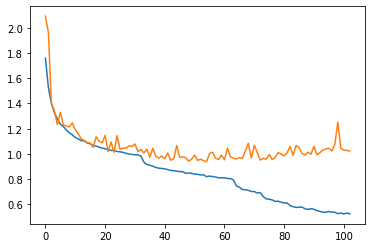

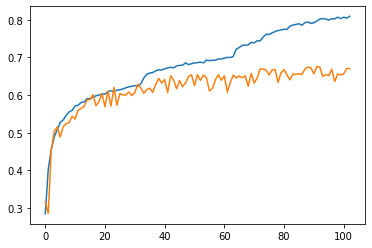

In [12]:
plt.plot([k[0] for k in hist])
plt.plot([k[1] for k in hist])
plt.show()

plt.plot([k[2] for k in hist])
plt.plot([k[3] for k in hist])
plt.show()

In [11]:
best_acc, curloss

(0.6761853448275862, 0.9936334100262872)

In [42]:
hist

[]

## Residual 5_3

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, input_channels, output_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.stride = stride
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(input_channels, output_channels//4, 1, 1, bias = False)
        self.bn2 = nn.BatchNorm2d(output_channels//4)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(output_channels//4, output_channels//4, 3, stride, padding = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(output_channels//4)
        self.relu = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(output_channels//4, output_channels, 1, 1, bias = False)
        self.conv4 = nn.Conv2d(input_channels, output_channels , 1, stride, bias = False)
       
    
    def forward(self, x):
        residual = x
        out = self.bn1(x)
        out1 = self.relu(out)
        out = self.conv1(out1)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)
        if (self.input_channels != self.output_channels) or (self.stride !=1 ):
            residual = self.conv4(out1)
        out += residual
        return out

In [5]:
class Attention(nn.Module):
    
    def __init__(self, feature_depth, target_depth, emb_dim, card=4, k_sizes=[1,3,3,5], p=[0,1,1,2], pooling=True, **kwargs):
        super(Attention, self).__init__()
        
        self.device = kwargs['device']
        
        self.emb_dim = emb_dim
        self.card = card
        self.iconv1 = []
        self.iconv2 = []

        for i in range(card):
            self.iconv1.append(nn.Sequential(nn.Conv2d(feature_depth, emb_dim // self.card, kernel_size=k_sizes[i], stride=1, padding=p[i]),
                                nn.BatchNorm2d(emb_dim // self.card)).to(self.device))
            
            self.iconv2.append(nn.Sequential(nn.Conv2d(feature_depth, emb_dim // self.card, kernel_size=k_sizes[i], stride=1, padding=p[i]),
                                nn.BatchNorm2d(emb_dim // self.card)).to(self.device))
            
        if pooling:
            self.iconv3_encode = nn.Sequential(ResidualBlock(feature_depth, emb_dim // self.card),
                                               nn.MaxPool2d(kernel_size=2, stride=2)).to(self.device)

            self.iconv3_decode = nn.Sequential(nn.UpsamplingBilinear2d(scale_factor=2),
                                               ResidualBlock(emb_dim // self.card, emb_dim)).to(self.device)
        else:
            self.iconv3_encode = ResidualBlock(feature_depth, emb_dim // self.card)

            self.iconv3_decode = ResidualBlock(emb_dim // self.card, emb_dim)
        
            
        self.identity_1 = nn.Sequential(nn.Conv2d(feature_depth, emb_dim, kernel_size=1, stride=1, padding=0),
                                        nn.BatchNorm2d(emb_dim)).to(self.device)
        self.identity_2 = nn.Sequential(nn.Conv2d(feature_depth, emb_dim, kernel_size=1, stride=1, padding=0),
                                        nn.BatchNorm2d(emb_dim)).to(self.device)
        self.identity_3 = nn.Sequential(nn.Conv2d(feature_depth, emb_dim, kernel_size=1, stride=1, padding=0),
                                        nn.BatchNorm2d(emb_dim)).to(self.device)

        self.preconv_qk_1 = nn.Conv1d(self.emb_dim, self.emb_dim, kernel_size=1, stride=1, padding=0)
        self.prebn_qk_1 = nn.BatchNorm1d(self.emb_dim)
        self.preconv_qk_2 = nn.Conv1d(self.emb_dim, self.emb_dim, kernel_size=1, stride=1, padding=0)
        self.prebn_qk_2 = nn.BatchNorm1d(self.emb_dim)
        self.preconv_qk_3 = nn.Conv1d(self.emb_dim, self.emb_dim, kernel_size=1, stride=1, padding=0)
        self.prebn_qk_3 = nn.BatchNorm1d(self.emb_dim)
        
        self.iconv_out = nn.Conv2d(emb_dim, target_depth, kernel_size=1)
        self.bn_out = nn.BatchNorm2d(target_depth)

        
    def forward(self, x):

        # residual 1
        iden_1 = self.identity_1(x).view(x.size(0), self.emb_dim, -1) # (b, emb_dim, HW)
        
        x1_embs = [_conv(x) for _conv in self.iconv1]
        _x1 = [nn.Flatten(-2)(x1_emb) for x1_emb in x1_embs] # (card, b, emb_dim // card, H, W)
        _x1 = torch.cat(_x1, dim=1) # (b, emb_dim, HW)
        _x1 = self.preconv_qk_1(_x1)
        _x1 = self.prebn_qk_1(_x1)  
        
        _x1 = _x1 + iden_1
        
        
        # residual 2
        iden_2 = self.identity_2(x).view(x.size(0), self.emb_dim, -1) # (b, emb_dim, HW)
        x2_embs = [_conv(x) for _conv in self.iconv2]
        _x2 = [nn.Flatten(-2)(x2_emb) for x2_emb in x2_embs] # (card, b, emb_dim // card, H, W)
        _x2 = torch.cat(_x2, dim=1) # (b, emb_dim, HW)
        _x2 = self.preconv_qk_2(_x2)
        _x2 = self.prebn_qk_2(_x2)
        
        _x2 = _x2 + iden_2
        
        # residual 3
        iden_3 = self.identity_3(x)
        x3_encode = self.iconv3_encode(x)
        x3_decode = self.iconv3_decode(x3_encode)
        
        x3_emb = x3_decode + iden_3
        
        _x3 = nn.Flatten(-2)(x3_emb) # (card, b, emb_dim // card, H, W)
        _x3 = self.preconv_qk_3(_x3)
        _x3 = self.prebn_qk_3(_x3)

        QK = torch.matmul(_x1, _x2.permute(0, 2, 1)) # _x2: (card, b, HW, D)
        QK = QK / (math.sqrt(_x1.size(2)) * math.sqrt(_x2.size(1)))
    
        QK = nn.Sigmoid()(QK)

        x_out = torch.matmul((1+QK), _x3)
        x_out = x_out / (math.sqrt(QK.size(2)) * math.sqrt(_x3.size(1)))
        x_out = x_out.reshape(-1, self.emb_dim, x3_emb.size(-2), x3_emb.size(-1))
        x_out = self.iconv_out(x_out)
        x_out = self.bn_out(x_out)
        x_out = nn.LeakyReLU()(x_out)
        
        x_out = x_out + x
        
        return x_out

In [6]:
class SVGG(nn.Module):
    def __init__(self, filters=[64, 128, 256, 512], reduce_factor=2, **kwargs):
        super(SVGG, self).__init__()
        
        self.device = kwargs['device']
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # block 1
        self.preconv_1 = nn.Sequential(nn.Conv2d(1, filters[0], 1, stride=1, padding=0, bias=False),
                                       nn.BatchNorm2d(filters[0]), nn.LeakyReLU(inplace=True))
        self.residual_1_a = ResidualBlock(filters[0], filters[0], stride=1)
        self.residual_1_b = ResidualBlock(filters[0], filters[0], stride=1)
        self.wf1 = Attention(filters[0], filters[0], filters[0] // reduce_factor, device=self.device)
        
        # block 2
        self.preconv_2 = nn.Sequential(nn.Conv2d(filters[0], filters[1], 1, stride=1, padding=0, bias=False),
                                     nn.BatchNorm2d(filters[1]), nn.LeakyReLU(inplace=True))
        self.residual_2_a = ResidualBlock(filters[1], filters[1], stride=1)
        self.residual_2_b = ResidualBlock(filters[1], filters[1], stride=1)
        self.wf2 = Attention(filters[1], filters[1], filters[1] // reduce_factor, device=self.device)
        
        # block 3
        self.preconv_3 = nn.Sequential(nn.Conv2d(filters[1], filters[2], 1, stride=1, padding=0, bias=False),
                                     nn.BatchNorm2d(filters[2]), nn.LeakyReLU(inplace=True))
        self.residual_3_a = ResidualBlock(filters[2], filters[2], stride=1)
        self.residual_3_b = ResidualBlock(filters[2], filters[2], stride=1)
        self.residual_3_c = ResidualBlock(filters[2], filters[2], stride=1)
        self.wf3 = Attention(filters[2], filters[2], filters[2] // reduce_factor, device=self.device)
        
        # block 4
        self.preconv_4 = nn.Sequential(nn.Conv2d(filters[2], filters[3], 1, stride=1, padding=0, bias=False),
                                     nn.BatchNorm2d(filters[3]), nn.LeakyReLU(inplace=True))
        self.residual_4_a = ResidualBlock(filters[3], filters[3], stride=1)
        self.residual_4_b = ResidualBlock(filters[3], filters[3], stride=1)
        self.residual_4_c = ResidualBlock(filters[3], filters[3], stride=1)
        self.wf4 = Attention(filters[3], filters[3], filters[3] // reduce_factor, pooling=False, device=self.device)
        
        # classifier
        self.classifier = nn.Sequential(nn.BatchNorm2d(filters[3]),
                                        nn.ReLU(inplace=True),
                                        nn.AdaptiveAvgPool2d(1),
                                        nn.Flatten(),
                                        nn.Dropout(0.5),
                                        nn.Linear(filters[3], filters[3] // 4),
                                        nn.BatchNorm1d(filters[3] // 4),
                                        nn.ReLU(inplace=True),
                                        nn.Linear(filters[3] // 4, 7))
        
    def forward(self, x):
        
        x = self.preconv_1(x)
        x1_res = self.residual_1_a(x)
        x1_res = self.residual_1_b(x1_res)
        x1_res = self.pool(x1_res)
        
        x1_wf = self.wf1(x1_res)
        
        x2 = self.preconv_2(x1_wf)
        x2_res = self.residual_2_a(x2)
        x2_res = self.residual_2_b(x2_res)
        x2_res = self.pool(x2_res)
        
        x2_wf = self.wf2(x2_res)
        
        x3 = self.preconv_3(x2_wf)
        x3_res = self.residual_3_a(x3)
        x3_res = self.residual_3_b(x3_res)
        x3_res = self.residual_3_c(x3_res)
        x3_res = self.pool(x3_res)
        
        x3_wf = self.wf3(x3_res)
        
        x4 = self.preconv_4(x3_wf)
        x4_res = self.residual_4_a(x4)
        x4_res = self.residual_4_b(x4_res)
        x4_res = self.residual_4_c(x4_res)
        x4_res = self.pool(x4_res)
        
        x4_wf = self.wf4(x4_res)
        
        x_out = self.classifier(x4_wf)
        
        return x_out
        

In [7]:
from torch.optim import lr_scheduler

device = torch.device('cuda')
print(device)

model = SVGG(device=device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.003
# reduce_factor = 2
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

cuda


In [8]:
model = model.to(device)

model_folder = '/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention/'
model_name = 'residual_resnet5_3'
model_path = os.path.join(model_folder, model_name + '.pt')

best_acc = 0.0
curloss = 0.0
hist = []

for epoch in range(150):

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)
    
    # print gradient flow figure
#     plot_grad_flow(model.named_parameters(), epoch, avgloss, avgacc,
#                    savepath=os.path.join(model_folder, model_name + '_gf' + '_' + str(epoch) + '.png'))

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        curloss = (running_valloss / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')
        
    scheduler.step(avgvalloss)

print('Finished Training')

Epoch:  1
- Avg.loss: 1.791  | Avg.acc: 0.256
- Avg. val_loss: 1.954  | Avg. val_acc: 0.281
* Update optimal model
Epoch:  2


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ResidualBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


- Avg.loss: 1.635  | Avg.acc: 0.349
- Avg. val_loss: 1.532  | Avg. val_acc: 0.416
* Update optimal model
Epoch:  3
- Avg.loss: 1.468  | Avg.acc: 0.424
- Avg. val_loss: 1.402  | Avg. val_acc: 0.455
* Update optimal model
Epoch:  4
- Avg.loss: 1.382  | Avg.acc: 0.464
- Avg. val_loss: 1.349  | Avg. val_acc: 0.473
* Update optimal model
Epoch:  5
- Avg.loss: 1.326  | Avg.acc: 0.491
- Avg. val_loss: 1.351  | Avg. val_acc: 0.472
Epoch:  6
- Avg.loss: 1.281  | Avg.acc: 0.510
- Avg. val_loss: 1.307  | Avg. val_acc: 0.502
* Update optimal model
Epoch:  7
- Avg.loss: 1.247  | Avg.acc: 0.521
- Avg. val_loss: 1.206  | Avg. val_acc: 0.524
* Update optimal model
Epoch:  8
- Avg.loss: 1.215  | Avg.acc: 0.536
- Avg. val_loss: 1.262  | Avg. val_acc: 0.509
Epoch:  9
- Avg.loss: 1.203  | Avg.acc: 0.543
- Avg. val_loss: 1.173  | Avg. val_acc: 0.562
* Update optimal model
Epoch:  10
- Avg.loss: 1.174  | Avg.acc: 0.549
- Avg. val_loss: 1.186  | Avg. val_acc: 0.537
Epoch:  11
- Avg.loss: 1.156  | Avg.acc: 0.

- Avg.loss: 0.787  | Avg.acc: 0.708
- Avg. val_loss: 0.945  | Avg. val_acc: 0.660
* Update optimal model
Epoch:  85
- Avg.loss: 0.783  | Avg.acc: 0.707
- Avg. val_loss: 0.948  | Avg. val_acc: 0.662
* Update optimal model
Epoch:  86
- Avg.loss: 0.789  | Avg.acc: 0.706
- Avg. val_loss: 0.928  | Avg. val_acc: 0.665
* Update optimal model
Epoch:  87
- Avg.loss: 0.776  | Avg.acc: 0.711
- Avg. val_loss: 1.070  | Avg. val_acc: 0.629
Epoch:  88
- Avg.loss: 0.768  | Avg.acc: 0.714
- Avg. val_loss: 0.976  | Avg. val_acc: 0.655
Epoch:  89
- Avg.loss: 0.772  | Avg.acc: 0.709
- Avg. val_loss: 0.993  | Avg. val_acc: 0.632
Epoch:  90
- Avg.loss: 0.773  | Avg.acc: 0.716
- Avg. val_loss: 0.977  | Avg. val_acc: 0.655
Epoch:  91
- Avg.loss: 0.768  | Avg.acc: 0.713
- Avg. val_loss: 0.981  | Avg. val_acc: 0.644
Epoch:  92
- Avg.loss: 0.762  | Avg.acc: 0.718
- Avg. val_loss: 0.967  | Avg. val_acc: 0.657
Epoch    92: reducing learning rate of group 0 to 7.5000e-04.
Epoch:  93
- Avg.loss: 0.720  | Avg.acc: 0.

In [16]:
test_model = torch.load('/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention/residual_resnet5_3.pt')
# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)
    acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
    loss = criterion(outputs, labels)

    #         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    running_valloss += loss.item()
    running_valacc += acc

print('- Avg. val_loss: %.6f  | Avg. val_acc: %.6f' % (running_valloss / (i+1), running_valacc / (i+1)))

- Avg. val_loss: 0.949881  | Avg. val_acc: 0.682004


([<matplotlib.lines.Line2D at 0x7f7234ec92b0>,
 0.6769935344827587,
 1.0057090274218856)

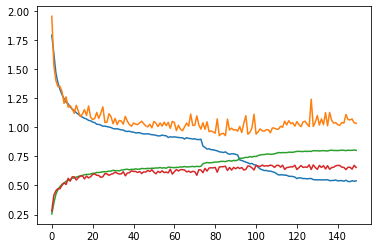

In [10]:
plt.plot(hist), best_acc, curloss

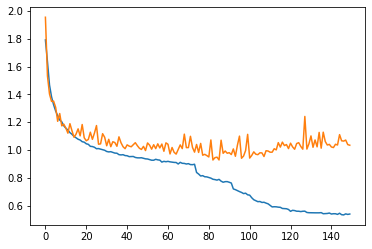

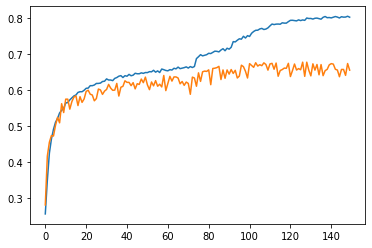

In [21]:
plt.plot([k[0] for k in hist])
plt.plot([k[1] for k in hist])
plt.show()

plt.plot([k[2] for k in hist])
plt.plot([k[3] for k in hist])
plt.show()

In [23]:
import pickle
pickle.dump(hist, open('/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention/residual_resnet5_3_hist.pt', 'wb'))

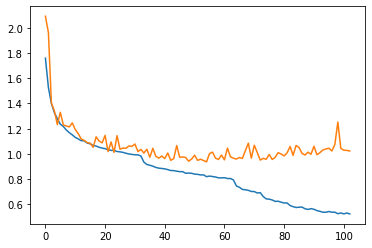

## Residual 5_4

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size=3, stride=1, padding=1):
        super(ResidualBlock, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.stride = stride
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(input_channels, output_channels//4, 1, 1, bias = False)
        self.bn2 = nn.BatchNorm2d(output_channels//4)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(output_channels//4, output_channels//4, kernel_size, stride, padding = padding, bias = False)
        self.bn3 = nn.BatchNorm2d(output_channels//4)
        self.relu = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(output_channels//4, output_channels, 1, 1, bias = False)
        self.conv4 = nn.Conv2d(input_channels, output_channels , 1, stride, bias = False)
       
    
    def forward(self, x):
        residual = x
        out = self.bn1(x)
        out1 = self.relu(out)
        out = self.conv1(out1)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)
        if (self.input_channels != self.output_channels) or (self.stride !=1 ):
            residual = self.conv4(out1)
        out += residual
        return out

In [5]:
class Attention(nn.Module):
    
    def __init__(self, feature_depth, target_depth, emb_dim, card=4, k_sizes=[1,3,3,5], p=[0,1,1,2], pooling=True, **kwargs):
        super(Attention, self).__init__()
        
        self.device = kwargs['device']
        self.pooling = pooling
        
        self.emb_dim = emb_dim
        self.card = card
        self.iconv1_encode, self.iconv1_decode = [], []
        self.iconv2_encode, self.iconv2_decode = [], []

        for i in range(card):
            if pooling:
                self.iconv1_encode.append(nn.Sequential(ResidualBlock(feature_depth, emb_dim // self.card, kernel_size=k_sizes[i], stride=1, padding=p[i]).to(self.device),
                                    nn.MaxPool2d(kernel_size=2, stride=2)).to(self.device))
                self.iconv1_decode.append(nn.Sequential(
#                                     nn.UpsamplingBilinear2d(scale_factor=2), 
                                    ResidualBlock(emb_dim // self.card, emb_dim, kernel_size=k_sizes[i], stride=1, padding=p[i]).to(self.device)).to(self.device))

                self.iconv2_encode.append(nn.Sequential(ResidualBlock(feature_depth, emb_dim // self.card, kernel_size=k_sizes[i], stride=1, padding=p[i]).to(self.device),
                                    nn.MaxPool2d(kernel_size=2, stride=2)).to(self.device))
                self.iconv2_decode.append(nn.Sequential(
#                                     nn.UpsamplingBilinear2d(scale_factor=2), 
                                    ResidualBlock(emb_dim // self.card, emb_dim, kernel_size=k_sizes[i], stride=1, padding=p[i]).to(self.device)).to(self.device))
            else:
                self.iconv1_encode.append(ResidualBlock(feature_depth, emb_dim // self.card, kernel_size=k_sizes[i], stride=1, padding=p[i]).to(self.device))
                self.iconv1_decode.append(ResidualBlock(emb_dim // self.card, emb_dim, kernel_size=k_sizes[i], stride=1, padding=p[i]).to(self.device))
                
                self.iconv2_encode.append(ResidualBlock(feature_depth, emb_dim // self.card, kernel_size=k_sizes[i], stride=1, padding=p[i]).to(self.device))
                self.iconv2_decode.append(ResidualBlock(emb_dim // self.card, emb_dim, kernel_size=k_sizes[i], stride=1, padding=p[i]).to(self.device))
            
        if pooling:
            self.iconv3_encode = nn.Sequential(ResidualBlock(feature_depth, emb_dim // self.card).to(self.device),
                                               nn.MaxPool2d(kernel_size=2, stride=2)).to(self.device)

            self.iconv3_decode = nn.Sequential(
#                                                 nn.UpsamplingBilinear2d(scale_factor=2),
                                                ResidualBlock(emb_dim // self.card, emb_dim).to(self.device)).to(self.device)
        else:
            self.iconv3_encode = ResidualBlock(feature_depth, emb_dim // self.card)

            self.iconv3_decode = ResidualBlock(emb_dim // self.card, emb_dim)
        
            
        self.identity_1 = nn.Sequential(nn.Conv2d(feature_depth, emb_dim, kernel_size=1, stride=1, padding=0),
                                        nn.BatchNorm2d(emb_dim)).to(self.device)
        self.identity_2 = nn.Sequential(nn.Conv2d(feature_depth, emb_dim, kernel_size=1, stride=1, padding=0),
                                        nn.BatchNorm2d(emb_dim)).to(self.device)
        self.identity_3 = nn.Sequential(nn.Conv2d(feature_depth, emb_dim, kernel_size=1, stride=1, padding=0),
                                        nn.BatchNorm2d(emb_dim)).to(self.device)

        self.preconv_qk_1 = nn.Conv1d(self.emb_dim, self.emb_dim, kernel_size=1, stride=1, padding=0)
        self.prebn_qk_1 = nn.BatchNorm1d(self.emb_dim)
        self.preconv_qk_2 = nn.Conv1d(self.emb_dim, self.emb_dim, kernel_size=1, stride=1, padding=0)
        self.prebn_qk_2 = nn.BatchNorm1d(self.emb_dim)
        self.preconv_qk_3 = nn.Conv1d(self.emb_dim, self.emb_dim, kernel_size=1, stride=1, padding=0)
        self.prebn_qk_3 = nn.BatchNorm1d(self.emb_dim)
        
        self.iconv_out = nn.Conv2d(emb_dim, target_depth, kernel_size=1)
        self.bn_out = nn.BatchNorm2d(target_depth)

        
    def forward(self, x):

        # residual 1
        iden_1 = self.identity_1(x) # (b, emb_dim, HW)
        
        if self.pooling:
            iden_1 = nn.MaxPool2d(kernel_size=2, stride=2)(iden_1)
        
        x1_embs_encode = [_conv(x) for _conv in self.iconv1_encode]
        x1_embs_decode = [_conv(x1_embs_encode[i]) for i, _conv in enumerate(self.iconv1_decode)]
        x1_embs_decode = torch.stack(x1_embs_decode).sum(dim=0)
        x1_embs_decode = x1_embs_decode + iden_1
        
        _x1 = nn.Flatten(-2)(x1_embs_decode)
        _x1 = self.preconv_qk_1(_x1)
        _x1 = self.prebn_qk_1(_x1)  
        
        
        # residual 2
        iden_2 = self.identity_2(x) # (b, emb_dim, HW)
        
        if self.pooling:
            iden_2 = nn.MaxPool2d(kernel_size=2, stride=2)(iden_2)
        
        x2_embs_encode = [_conv(x) for _conv in self.iconv2_encode]
        x2_embs_decode = [_conv(x2_embs_encode[i]) for i, _conv in enumerate(self.iconv2_decode)]
        x2_embs_decode = torch.stack(x2_embs_decode).sum(dim=0)
        x2_embs_decode = x2_embs_decode + iden_2
        
        _x2 = nn.Flatten(-2)(x2_embs_decode)
        _x2 = self.preconv_qk_2(_x2)
        _x2 = self.prebn_qk_2(_x2)  
        
        # residual 3
        iden_3 = self.identity_3(x)
        
        
        
        if self.pooling:
            iden_3 = nn.MaxPool2d(kernel_size=2, stride=2)(iden_3)
        
        x3_encode = self.iconv3_encode(x)
        x3_decode = self.iconv3_decode(x3_encode)
        
        x3_emb = x3_decode + iden_3
        
        _x3 = nn.Flatten(-2)(x3_emb) # (card, b, emb_dim // card, H, W)
        _x3 = self.preconv_qk_3(_x3)
        _x3 = self.prebn_qk_3(_x3)

        QK = torch.matmul(_x1, _x2.permute(0, 2, 1)) # _x2: (card, b, HW, D)
        QK = QK / (math.sqrt(_x1.size(2)) * math.sqrt(_x2.size(1)))
    
        QK = nn.Sigmoid()(QK)

        x_out = torch.matmul((1+QK), _x3)
        x_out = x_out / (math.sqrt(QK.size(2)) * math.sqrt(_x3.size(1)))
        x_out = x_out.reshape(-1, self.emb_dim, x3_emb.size(-2), x3_emb.size(-1))
        x_out = self.iconv_out(x_out)
        x_out = self.bn_out(x_out)
        x_out = nn.LeakyReLU()(x_out)
        
        if not self.pooling:
            x_out = x_out + x
        else:
            x_out = x_out + nn.MaxPool2d(kernel_size=2, stride=2)(x)
        
        return x_out

In [6]:
class SVGG(nn.Module):
    def __init__(self, filters=[64, 128, 256, 512], reduce_factor=2, **kwargs):
        super(SVGG, self).__init__()
        
        self.device = kwargs['device']
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # block 1
        self.preconv_1 = nn.Sequential(nn.Conv2d(1, filters[0], 1, stride=1, padding=0, bias=False),
                                       nn.BatchNorm2d(filters[0]), nn.LeakyReLU(inplace=True))
        self.residual_1_a = ResidualBlock(filters[0], filters[0], stride=1)
        self.residual_1_b = ResidualBlock(filters[0], filters[0], stride=1)
        self.wf1 = Attention(filters[0], filters[0], filters[0] // reduce_factor, device=self.device)
        
        # block 2
        self.preconv_2 = nn.Sequential(nn.Conv2d(filters[0], filters[1], 1, stride=1, padding=0, bias=False),
                                     nn.BatchNorm2d(filters[1]), nn.LeakyReLU(inplace=True))
        self.residual_2_a = ResidualBlock(filters[1], filters[1], stride=1)
        self.residual_2_b = ResidualBlock(filters[1], filters[1], stride=1)
        self.wf2 = Attention(filters[1], filters[1], filters[1] // reduce_factor, device=self.device)
        
        # block 3
        self.preconv_3 = nn.Sequential(nn.Conv2d(filters[1], filters[2], 1, stride=1, padding=0, bias=False),
                                     nn.BatchNorm2d(filters[2]), nn.LeakyReLU(inplace=True))
        self.residual_3_a = ResidualBlock(filters[2], filters[2], stride=1)
        self.residual_3_b = ResidualBlock(filters[2], filters[2], stride=1)
        self.residual_3_c = ResidualBlock(filters[2], filters[2], stride=1)
        self.wf3 = Attention(filters[2], filters[2], filters[2] // reduce_factor, device=self.device)
        
        # block 4
        self.preconv_4 = nn.Sequential(nn.Conv2d(filters[2], filters[3], 1, stride=1, padding=0, bias=False),
                                     nn.BatchNorm2d(filters[3]), nn.LeakyReLU(inplace=True))
        self.residual_4_a = ResidualBlock(filters[3], filters[3], stride=1)
        self.residual_4_b = ResidualBlock(filters[3], filters[3], stride=1)
        self.residual_4_c = ResidualBlock(filters[3], filters[3], stride=1)
        self.wf4 = Attention(filters[3], filters[3], filters[3] // reduce_factor, pooling=False, device=self.device)
        
        # classifier
        self.classifier = nn.Sequential(nn.BatchNorm2d(filters[3]),
                                        nn.ReLU(inplace=True),
                                        nn.AdaptiveAvgPool2d(1),
                                        nn.Flatten(),
                                        nn.Dropout(0.5),
                                        nn.Linear(filters[3], filters[3] // 4),
                                        nn.BatchNorm1d(filters[3] // 4),
                                        nn.ReLU(inplace=True),
                                        nn.Linear(filters[3] // 4, 7))
        
    def forward(self, x):
        
        x = self.preconv_1(x)
        x1_res = self.residual_1_a(x)
        x1_res = self.residual_1_b(x1_res)
        
        x1_wf = self.wf1(x1_res)
        
        x2 = self.preconv_2(x1_wf)
        x2_res = self.residual_2_a(x2)
        x2_res = self.residual_2_b(x2_res)
        
        x2_wf = self.wf2(x2_res)
        
        x3 = self.preconv_3(x2_wf)
        x3_res = self.residual_3_a(x3)
        x3_res = self.residual_3_b(x3_res)
        x3_res = self.residual_3_c(x3_res)
        
        x3_wf = self.wf3(x3_res)
        
        x4 = self.preconv_4(x3_wf)
        x4_res = self.residual_4_a(x4)
        x4_res = self.residual_4_b(x4_res)
        x4_res = self.residual_4_c(x4_res)
        x4_res = self.pool(x4_res)
        
        x4_wf = self.wf4(x4_res)
        
        x_out = self.classifier(x4_wf)
        
        return x_out
        

In [7]:
from torch.optim import lr_scheduler

device = torch.device('cuda')
print(device)

model = SVGG(device=device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
# reduce_factor = 2
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

cuda


In [8]:
model = model.to(device)

model_folder = '/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention/'
model_name = 'residual_resnet5_4'
model_path = os.path.join(model_folder, model_name + '.pt')

best_acc = 0.0
curloss = 0.0
hist = []

for epoch in range(150):

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)
    
    # print gradient flow figure
#     plot_grad_flow(model.named_parameters(), epoch, avgloss, avgacc,
#                    savepath=os.path.join(model_folder, model_name + '_gf' + '_' + str(epoch) + '.png'))

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        curloss = (running_valloss / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')
        
    scheduler.step(avgvalloss)

print('Finished Training')

Epoch:  1
- Avg.loss: 1.792  | Avg.acc: 0.262
- Avg. val_loss: 7.713  | Avg. val_acc: 0.262
* Update optimal model
Epoch:  2


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ResidualBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


- Avg.loss: 1.629  | Avg.acc: 0.358
- Avg. val_loss: 2.003  | Avg. val_acc: 0.299
* Update optimal model
Epoch:  3
- Avg.loss: 1.475  | Avg.acc: 0.425
- Avg. val_loss: 1.471  | Avg. val_acc: 0.422
* Update optimal model
Epoch:  4
- Avg.loss: 1.399  | Avg.acc: 0.455
- Avg. val_loss: 1.364  | Avg. val_acc: 0.479
* Update optimal model
Epoch:  5
- Avg.loss: 1.343  | Avg.acc: 0.486
- Avg. val_loss: 1.320  | Avg. val_acc: 0.504
* Update optimal model
Epoch:  6
- Avg.loss: 1.312  | Avg.acc: 0.496
- Avg. val_loss: 1.380  | Avg. val_acc: 0.461
Epoch:  7
- Avg.loss: 1.282  | Avg.acc: 0.506
- Avg. val_loss: 1.278  | Avg. val_acc: 0.515
* Update optimal model
Epoch:  8
- Avg.loss: 1.251  | Avg.acc: 0.521
- Avg. val_loss: 1.381  | Avg. val_acc: 0.479
Epoch:  9
- Avg.loss: 1.226  | Avg.acc: 0.531
- Avg. val_loss: 1.265  | Avg. val_acc: 0.520
* Update optimal model
Epoch:  10
- Avg.loss: 1.209  | Avg.acc: 0.537
- Avg. val_loss: 1.228  | Avg. val_acc: 0.533
* Update optimal model
Epoch:  11
- Avg.los

- Avg.loss: 0.836  | Avg.acc: 0.688
- Avg. val_loss: 0.984  | Avg. val_acc: 0.647
Epoch:  84
- Avg.loss: 0.830  | Avg.acc: 0.691
- Avg. val_loss: 0.967  | Avg. val_acc: 0.640
Epoch    84: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  85
- Avg.loss: 0.817  | Avg.acc: 0.695
- Avg. val_loss: 0.950  | Avg. val_acc: 0.650
Epoch:  86
- Avg.loss: 0.808  | Avg.acc: 0.700
- Avg. val_loss: 0.973  | Avg. val_acc: 0.647
Epoch:  87
- Avg.loss: 0.807  | Avg.acc: 0.700
- Avg. val_loss: 0.956  | Avg. val_acc: 0.650
Epoch:  88
- Avg.loss: 0.808  | Avg.acc: 0.698
- Avg. val_loss: 0.959  | Avg. val_acc: 0.644
Epoch:  89
- Avg.loss: 0.800  | Avg.acc: 0.700
- Avg. val_loss: 0.958  | Avg. val_acc: 0.643
Epoch:  90
- Avg.loss: 0.804  | Avg.acc: 0.698
- Avg. val_loss: 0.985  | Avg. val_acc: 0.638
Epoch:  91
- Avg.loss: 0.797  | Avg.acc: 0.702
- Avg. val_loss: 0.977  | Avg. val_acc: 0.644
Epoch:  92
- Avg.loss: 0.797  | Avg.acc: 0.702
- Avg. val_loss: 0.957  | Avg. val_acc: 0.655
* Update optimal mo

In [13]:
1.9531e-06, 0.00000

1.9531e-06

In [14]:
1e-3

0.001

([<matplotlib.lines.Line2D at 0x7f8834d345f8>,
 0.6641995614035088,
 0.9769616838087115)

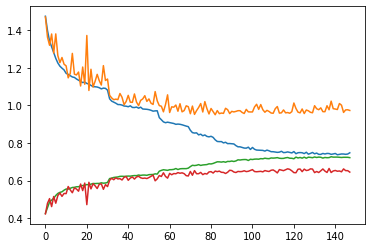

In [11]:
plt.plot(hist[2:]), best_acc, curloss

In [12]:
test_model = torch.load('/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention/residual_resnet5_4.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(val_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)
    acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
    loss = criterion(outputs, labels)

    #         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    running_valloss += loss.item()
    running_valacc += acc

print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

- Avg. val_loss: 0.980  | Avg. val_acc: 0.655


In [15]:
import pickle

pickle.dump(hist, open('/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention/residual_resnet5_4_hist.hdf5', 'wb'))

## Attention keeping original HW (Residual 5_6)

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size=3, stride=1, padding=1):
        super(ResidualBlock, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.stride = stride
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(input_channels, output_channels//4, 1, 1, bias = False)
        self.bn2 = nn.BatchNorm2d(output_channels//4)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(output_channels//4, output_channels//4, kernel_size, stride, padding = padding, bias = False)
        self.bn3 = nn.BatchNorm2d(output_channels//4)
        self.relu = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(output_channels//4, output_channels, 1, 1, bias = False)
        self.conv4 = nn.Conv2d(input_channels, output_channels , 1, stride, bias = False)
       
    
    def forward(self, x):
        residual = x
        out = self.bn1(x)
        out1 = self.relu(out)
        out = self.conv1(out1)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)
        if (self.input_channels != self.output_channels) or (self.stride !=1 ):
            residual = self.conv4(out1)
        out += residual
        return out

In [5]:
class SVGG(nn.Module):
    def __init__(self, filters=[64, 128, 256, 512], reduce_factor=2, **kwargs):
        super(SVGG, self).__init__()
        
        self.device = kwargs['device']
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # block 1
        self.preconv_1 = nn.Sequential(nn.Conv2d(1, filters[0], 1, stride=1, padding=0, bias=False),
                                       nn.BatchNorm2d(filters[0]), nn.LeakyReLU(inplace=True))
        self.residual_1_a = ResidualBlock(filters[0], filters[0], stride=1)
        self.residual_1_b = ResidualBlock(filters[0], filters[0], stride=1)
        self.wf1 = Attention(filters[0], filters[0], filters[0] // reduce_factor, device=self.device)
        
        # block 2
        self.preconv_2 = nn.Sequential(nn.Conv2d(filters[0], filters[1], 1, stride=1, padding=0, bias=False),
                                     nn.BatchNorm2d(filters[1]), nn.LeakyReLU(inplace=True))
        self.residual_2_a = ResidualBlock(filters[1], filters[1], stride=1)
        self.residual_2_b = ResidualBlock(filters[1], filters[1], stride=1)
        self.wf2 = Attention(filters[1], filters[1], filters[1] // reduce_factor, device=self.device)
        
        # block 3
        self.preconv_3 = nn.Sequential(nn.Conv2d(filters[1], filters[2], 1, stride=1, padding=0, bias=False),
                                     nn.BatchNorm2d(filters[2]), nn.LeakyReLU(inplace=True))
        self.residual_3_a = ResidualBlock(filters[2], filters[2], stride=1)
        self.residual_3_b = ResidualBlock(filters[2], filters[2], stride=1)
        self.residual_3_c = ResidualBlock(filters[2], filters[2], stride=1)
        self.wf3 = Attention(filters[2], filters[2], filters[2] // reduce_factor, device=self.device)
        
        # block 4
        self.preconv_4 = nn.Sequential(nn.Conv2d(filters[2], filters[3], 1, stride=1, padding=0, bias=False),
                                     nn.BatchNorm2d(filters[3]), nn.LeakyReLU(inplace=True))
        self.residual_4_a = ResidualBlock(filters[3], filters[3], stride=1)
        self.residual_4_b = ResidualBlock(filters[3], filters[3], stride=1)
        self.residual_4_c = ResidualBlock(filters[3], filters[3], stride=1)
        self.wf4 = Attention(filters[3], filters[3], filters[3] // reduce_factor, pooling=False, device=self.device)
        
        # classifier
        self.classifier = nn.Sequential(nn.BatchNorm2d(filters[3]),
                                        nn.ReLU(inplace=True),
                                        nn.AdaptiveAvgPool2d(1),
                                        nn.Flatten(),
                                        nn.Dropout(0.5),
                                        nn.Linear(filters[3], filters[3] // 4),
                                        nn.BatchNorm1d(filters[3] // 4),
                                        nn.ReLU(inplace=True),
                                        nn.Linear(filters[3] // 4, 7))
        
    def forward(self, x):
        
        x = self.preconv_1(x)
        x1_res = self.residual_1_a(x)
        x1_res = self.residual_1_b(x1_res)
        x1_res = self.pool(x1_res)
        
        x1_wf = self.wf1(x1_res)
        
        x2 = self.preconv_2(x1_wf)
        x2_res = self.residual_2_a(x2)
        x2_res = self.residual_2_b(x2_res)
        x2_res = self.pool(x2_res)
        
        x2_wf = self.wf2(x2_res)
        
        x3 = self.preconv_3(x2_wf)
        x3_res = self.residual_3_a(x3)
        x3_res = self.residual_3_b(x3_res)
        x3_res = self.residual_3_c(x3_res)
        x3_res = self.pool(x3_res)
        
        x3_wf = self.wf3(x3_res)
        
        x4 = self.preconv_4(x3_wf)
        x4_res = self.residual_4_a(x4)
        x4_res = self.residual_4_b(x4_res)
        x4_res = self.residual_4_c(x4_res)
        x4_res = self.pool(x4_res)
        
        x4_wf = self.wf4(x4_res)
        
        x_out = self.classifier(x4_wf)
        
        return x_out
        

In [6]:
class Attention(nn.Module):
    
    def __init__(self, feature_depth, target_depth, emb_dim, **kwargs):
        super(Attention, self).__init__()
        
        self.emb_dim = emb_dim
        self.device = kwargs['device']
        
        self.iconv1 = nn.Conv2d(feature_depth, emb_dim, kernel_size=1)
        self.iconv2 = nn.Conv2d(target_depth, emb_dim, kernel_size=1)
        self.iconv3 = nn.Conv2d(target_depth, emb_dim, kernel_size=1)
        self.iconv_out = nn.Conv2d(emb_dim, target_depth, kernel_size=1)
        self.bn_out = nn.BatchNorm2d(target_depth)
        
        # ensure the init stage is the indentical mapping
#         nn.init.zeros_(self.iconv_out.weight)
#         nn.init.zeros_(self.iconv_out.bias)
#         nn.init.zeros_(self.bn_out.weight)
#         nn.init.zeros_(self.bn_out.bias)
        
    def forward(self, x):
        x1_emb = self.iconv1(x)
        _x1 = nn.Flatten(-2)(x1_emb)
        
        x2_emb = self.iconv2(x)
        _x2 = nn.Flatten(-2)(x2_emb)
        
        x3_emb = self.iconv3(x)
        _x3 = nn.Flatten(-2)(x3_emb)
        
        QK = _x1[:,None,:,:] * _x2[:,None, :, :].permute(0,2,1,3)
        QK = nn.Sigmoid()(QK)
        
        x_out = ((1 + QK) * _x3[:, None, :, :]).sum(2)
        x_out = x_out.view(x3_emb.size())
        
        x_out = self.iconv_out(x_out)
        x_out = self.bn_out(x_out)
        x_out = nn.LeakyReLU()(x_out)
        
        x_out = x_out + x #residual
        
        return x_out

In [8]:
from torch.optim import lr_scheduler

device = torch.device('cuda')
print(device)

model = SVGG(device=device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
# reduce_factor = 2
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

cuda


In [9]:
model = model.to(device)

model_folder = '/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention/'
model_name = 'residual_resnet5_6'
model_path = os.path.join(model_folder, model_name + '.pt')

best_acc = 0.0
curloss = 0.0
hist = []

for epoch in range(100):

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
        print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)
    
    # print gradient flow figure
#     plot_grad_flow(model.named_parameters(), epoch, avgloss, avgacc,
#                    savepath=os.path.join(model_folder, model_name + '_gf' + '_' + str(epoch) + '.png'))

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        
        print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        curloss = (running_valloss / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')
        
    scheduler.step(avgvalloss)

print('Finished Training')

Epoch:  1
	 - Step 1: loss: 1.979 acc: 0.094
	 - Step 2: loss: 1.890 acc: 0.156
	 - Step 3: loss: 1.982 acc: 0.219
	 - Step 4: loss: 1.962 acc: 0.062
	 - Step 5: loss: 2.011 acc: 0.219
	 - Step 6: loss: 1.900 acc: 0.344
	 - Step 7: loss: 1.828 acc: 0.281
	 - Step 8: loss: 1.856 acc: 0.281
	 - Step 9: loss: 1.846 acc: 0.219
	 - Step 10: loss: 1.960 acc: 0.156
	 - Step 11: loss: 1.810 acc: 0.312
	 - Step 12: loss: 1.774 acc: 0.406
	 - Step 13: loss: 1.974 acc: 0.219
	 - Step 14: loss: 1.899 acc: 0.219
	 - Step 15: loss: 1.872 acc: 0.250
	 - Step 16: loss: 1.886 acc: 0.250
	 - Step 17: loss: 1.781 acc: 0.312
	 - Step 18: loss: 1.784 acc: 0.250
	 - Step 19: loss: 1.940 acc: 0.250
	 - Step 20: loss: 2.154 acc: 0.219
	 - Step 21: loss: 1.872 acc: 0.188
	 - Step 22: loss: 1.807 acc: 0.156
	 - Step 23: loss: 1.890 acc: 0.188
	 - Step 24: loss: 1.819 acc: 0.188
	 - Step 25: loss: 1.780 acc: 0.156
	 - Step 26: loss: 1.793 acc: 0.219
	 - Step 27: loss: 1.682 acc: 0.219
	 - Step 28: loss: 1.693 ac

	 - Step 226: loss: 1.728 acc: 0.250
	 - Step 227: loss: 1.832 acc: 0.219
	 - Step 228: loss: 1.869 acc: 0.281
	 - Step 229: loss: 1.836 acc: 0.125
	 - Step 230: loss: 1.804 acc: 0.312
	 - Step 231: loss: 1.900 acc: 0.219
	 - Step 232: loss: 1.811 acc: 0.188
	 - Step 233: loss: 1.808 acc: 0.219
	 - Step 234: loss: 1.785 acc: 0.281
	 - Step 235: loss: 1.853 acc: 0.219
	 - Step 236: loss: 1.962 acc: 0.281
	 - Step 237: loss: 1.768 acc: 0.344
	 - Step 238: loss: 1.721 acc: 0.250
	 - Step 239: loss: 1.869 acc: 0.250
	 - Step 240: loss: 1.879 acc: 0.156
	 - Step 241: loss: 1.707 acc: 0.219
	 - Step 242: loss: 1.945 acc: 0.250
	 - Step 243: loss: 1.831 acc: 0.188
	 - Step 244: loss: 1.807 acc: 0.344
	 - Step 245: loss: 1.891 acc: 0.156
	 - Step 246: loss: 1.790 acc: 0.312
	 - Step 247: loss: 1.928 acc: 0.156
	 - Step 248: loss: 1.762 acc: 0.250
	 - Step 249: loss: 1.750 acc: 0.219
	 - Step 250: loss: 1.807 acc: 0.281
	 - Step 251: loss: 1.873 acc: 0.281
	 - Step 252: loss: 1.903 acc: 0.250
	

	 - Step 448: loss: 1.959 acc: 0.312
	 - Step 449: loss: 1.822 acc: 0.281
	 - Step 450: loss: 1.844 acc: 0.250
	 - Step 451: loss: 1.660 acc: 0.312
	 - Step 452: loss: 1.874 acc: 0.281
	 - Step 453: loss: 1.789 acc: 0.406
	 - Step 454: loss: 2.023 acc: 0.188
	 - Step 455: loss: 1.981 acc: 0.188
	 - Step 456: loss: 1.811 acc: 0.250
	 - Step 457: loss: 1.876 acc: 0.250
	 - Step 458: loss: 1.770 acc: 0.281
	 - Step 459: loss: 1.793 acc: 0.281
	 - Step 460: loss: 1.766 acc: 0.312
	 - Step 461: loss: 1.804 acc: 0.125
	 - Step 462: loss: 1.849 acc: 0.219
	 - Step 463: loss: 1.797 acc: 0.344
	 - Step 464: loss: 1.740 acc: 0.250
	 - Step 465: loss: 1.703 acc: 0.344
	 - Step 466: loss: 1.870 acc: 0.250
	 - Step 467: loss: 1.797 acc: 0.281
	 - Step 468: loss: 1.761 acc: 0.344
	 - Step 469: loss: 1.912 acc: 0.188
	 - Step 470: loss: 1.869 acc: 0.219
	 - Step 471: loss: 1.730 acc: 0.344
	 - Step 472: loss: 1.841 acc: 0.250
	 - Step 473: loss: 1.711 acc: 0.281
	 - Step 474: loss: 1.921 acc: 0.188
	

	 - Step 670: loss: 1.829 acc: 0.250
	 - Step 671: loss: 1.856 acc: 0.250
	 - Step 672: loss: 1.896 acc: 0.156
	 - Step 673: loss: 1.926 acc: 0.219
	 - Step 674: loss: 1.803 acc: 0.281
	 - Step 675: loss: 1.677 acc: 0.312
	 - Step 676: loss: 1.701 acc: 0.250
	 - Step 677: loss: 1.949 acc: 0.188
	 - Step 678: loss: 1.781 acc: 0.250
	 - Step 679: loss: 1.800 acc: 0.281
	 - Step 680: loss: 1.865 acc: 0.219
	 - Step 681: loss: 1.786 acc: 0.312
	 - Step 682: loss: 1.729 acc: 0.219
	 - Step 683: loss: 1.770 acc: 0.312
	 - Step 684: loss: 1.869 acc: 0.188
	 - Step 685: loss: 1.731 acc: 0.375
	 - Step 686: loss: 1.689 acc: 0.281
	 - Step 687: loss: 1.772 acc: 0.219
	 - Step 688: loss: 1.829 acc: 0.281
	 - Step 689: loss: 1.831 acc: 0.281
	 - Step 690: loss: 1.916 acc: 0.250
	 - Step 691: loss: 1.806 acc: 0.188
	 - Step 692: loss: 1.859 acc: 0.219
	 - Step 693: loss: 1.822 acc: 0.188
	 - Step 694: loss: 1.807 acc: 0.250
	 - Step 695: loss: 1.777 acc: 0.281
	 - Step 696: loss: 1.767 acc: 0.250
	

	 - Step 892: loss: 1.821 acc: 0.188
	 - Step 893: loss: 1.831 acc: 0.219
	 - Step 894: loss: 1.786 acc: 0.250
- Avg.loss: 1.819  | Avg.acc: 0.247
	 - Step 1: loss: 1.641 acc: 0.312
	 - Step 2: loss: 1.821 acc: 0.219
	 - Step 3: loss: 1.804 acc: 0.344
	 - Step 4: loss: 1.782 acc: 0.250
	 - Step 5: loss: 1.726 acc: 0.312
	 - Step 6: loss: 1.766 acc: 0.156
	 - Step 7: loss: 2.019 acc: 0.125
	 - Step 8: loss: 1.638 acc: 0.344
	 - Step 9: loss: 1.750 acc: 0.188
	 - Step 10: loss: 1.748 acc: 0.219
	 - Step 11: loss: 1.764 acc: 0.250
	 - Step 12: loss: 1.732 acc: 0.250
	 - Step 13: loss: 2.066 acc: 0.312
	 - Step 14: loss: 1.712 acc: 0.188
	 - Step 15: loss: 1.831 acc: 0.188
	 - Step 16: loss: 1.644 acc: 0.344
	 - Step 17: loss: 1.896 acc: 0.125
	 - Step 18: loss: 1.847 acc: 0.281
	 - Step 19: loss: 1.798 acc: 0.281
	 - Step 20: loss: 1.818 acc: 0.156
	 - Step 21: loss: 1.768 acc: 0.250
	 - Step 22: loss: 1.749 acc: 0.188
	 - Step 23: loss: 1.840 acc: 0.375
	 - Step 24: loss: 2.404 acc: 0.18

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ResidualBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


	 - Step 1: loss: 1.989 acc: 0.219
	 - Step 2: loss: 1.671 acc: 0.438
	 - Step 3: loss: 1.731 acc: 0.312
	 - Step 4: loss: 1.809 acc: 0.219
	 - Step 5: loss: 1.710 acc: 0.344
	 - Step 6: loss: 1.989 acc: 0.156
	 - Step 7: loss: 1.806 acc: 0.188
	 - Step 8: loss: 1.858 acc: 0.281
	 - Step 9: loss: 1.782 acc: 0.406
	 - Step 10: loss: 1.853 acc: 0.250
	 - Step 11: loss: 1.657 acc: 0.375
	 - Step 12: loss: 1.733 acc: 0.250
	 - Step 13: loss: 1.730 acc: 0.250
	 - Step 14: loss: 1.901 acc: 0.406
	 - Step 15: loss: 1.821 acc: 0.281
	 - Step 16: loss: 1.762 acc: 0.281
	 - Step 17: loss: 1.746 acc: 0.312
	 - Step 18: loss: 1.899 acc: 0.281
	 - Step 19: loss: 1.738 acc: 0.281
	 - Step 20: loss: 2.024 acc: 0.219
	 - Step 21: loss: 1.850 acc: 0.125
	 - Step 22: loss: 1.823 acc: 0.125
	 - Step 23: loss: 1.807 acc: 0.250
	 - Step 24: loss: 1.737 acc: 0.344
	 - Step 25: loss: 1.869 acc: 0.219
	 - Step 26: loss: 1.886 acc: 0.156
	 - Step 27: loss: 1.780 acc: 0.219
	 - Step 28: loss: 1.817 acc: 0.281
	

	 - Step 226: loss: 1.784 acc: 0.219
	 - Step 227: loss: 1.786 acc: 0.281
	 - Step 228: loss: 1.901 acc: 0.219
	 - Step 229: loss: 2.058 acc: 0.125
	 - Step 230: loss: 1.845 acc: 0.094
	 - Step 231: loss: 1.813 acc: 0.406
	 - Step 232: loss: 1.799 acc: 0.250
	 - Step 233: loss: 1.731 acc: 0.250
	 - Step 234: loss: 1.693 acc: 0.344
	 - Step 235: loss: 1.681 acc: 0.312
	 - Step 236: loss: 1.762 acc: 0.250
	 - Step 237: loss: 1.889 acc: 0.219
	 - Step 238: loss: 1.771 acc: 0.188
	 - Step 239: loss: 1.685 acc: 0.312
	 - Step 240: loss: 1.651 acc: 0.312
	 - Step 241: loss: 1.823 acc: 0.219
	 - Step 242: loss: 1.621 acc: 0.406
	 - Step 243: loss: 1.836 acc: 0.250
	 - Step 244: loss: 1.694 acc: 0.438
	 - Step 245: loss: 1.747 acc: 0.281
	 - Step 246: loss: 1.710 acc: 0.312
	 - Step 247: loss: 1.716 acc: 0.312
	 - Step 248: loss: 1.805 acc: 0.344
	 - Step 249: loss: 1.636 acc: 0.344
	 - Step 250: loss: 1.852 acc: 0.281
	 - Step 251: loss: 1.849 acc: 0.219
	 - Step 252: loss: 1.783 acc: 0.312
	

	 - Step 448: loss: 1.678 acc: 0.312
	 - Step 449: loss: 1.557 acc: 0.312
	 - Step 450: loss: 1.642 acc: 0.312
	 - Step 451: loss: 1.710 acc: 0.375
	 - Step 452: loss: 1.722 acc: 0.250
	 - Step 453: loss: 1.735 acc: 0.281
	 - Step 454: loss: 1.628 acc: 0.281
	 - Step 455: loss: 1.663 acc: 0.344
	 - Step 456: loss: 1.833 acc: 0.188
	 - Step 457: loss: 1.666 acc: 0.406
	 - Step 458: loss: 2.043 acc: 0.188
	 - Step 459: loss: 1.738 acc: 0.156
	 - Step 460: loss: 1.880 acc: 0.188
	 - Step 461: loss: 1.756 acc: 0.375
	 - Step 462: loss: 1.657 acc: 0.344
	 - Step 463: loss: 1.755 acc: 0.250
	 - Step 464: loss: 1.592 acc: 0.438
	 - Step 465: loss: 1.707 acc: 0.344
	 - Step 466: loss: 1.702 acc: 0.219
	 - Step 467: loss: 1.769 acc: 0.250
	 - Step 468: loss: 1.631 acc: 0.312
	 - Step 469: loss: 1.783 acc: 0.188
	 - Step 470: loss: 1.818 acc: 0.250
	 - Step 471: loss: 1.818 acc: 0.250
	 - Step 472: loss: 1.859 acc: 0.312
	 - Step 473: loss: 1.755 acc: 0.375
	 - Step 474: loss: 1.705 acc: 0.281
	

	 - Step 670: loss: 1.696 acc: 0.469
	 - Step 671: loss: 1.898 acc: 0.094
	 - Step 672: loss: 1.598 acc: 0.500
	 - Step 673: loss: 1.817 acc: 0.250
	 - Step 674: loss: 1.729 acc: 0.281
	 - Step 675: loss: 1.762 acc: 0.344
	 - Step 676: loss: 1.765 acc: 0.281
	 - Step 677: loss: 1.660 acc: 0.406
	 - Step 678: loss: 1.734 acc: 0.281
	 - Step 679: loss: 1.874 acc: 0.156
	 - Step 680: loss: 1.760 acc: 0.312
	 - Step 681: loss: 1.505 acc: 0.438
	 - Step 682: loss: 1.683 acc: 0.406
	 - Step 683: loss: 1.943 acc: 0.125
	 - Step 684: loss: 1.784 acc: 0.344
	 - Step 685: loss: 1.816 acc: 0.250
	 - Step 686: loss: 1.711 acc: 0.375
	 - Step 687: loss: 1.681 acc: 0.344
	 - Step 688: loss: 1.801 acc: 0.219
	 - Step 689: loss: 1.691 acc: 0.375
	 - Step 690: loss: 1.639 acc: 0.312
	 - Step 691: loss: 1.709 acc: 0.219
	 - Step 692: loss: 1.708 acc: 0.344
	 - Step 693: loss: 1.568 acc: 0.406
	 - Step 694: loss: 1.710 acc: 0.344
	 - Step 695: loss: 1.747 acc: 0.344
	 - Step 696: loss: 1.652 acc: 0.406
	

	 - Step 892: loss: 1.813 acc: 0.375
	 - Step 893: loss: 1.619 acc: 0.375
	 - Step 894: loss: 1.971 acc: 0.179
- Avg.loss: 1.755  | Avg.acc: 0.284
	 - Step 1: loss: 1.569 acc: 0.312
	 - Step 2: loss: 1.784 acc: 0.188
	 - Step 3: loss: 1.640 acc: 0.344
	 - Step 4: loss: 1.468 acc: 0.438
	 - Step 5: loss: 1.657 acc: 0.406
	 - Step 6: loss: 1.595 acc: 0.312
	 - Step 7: loss: 1.780 acc: 0.188
	 - Step 8: loss: 1.574 acc: 0.250
	 - Step 9: loss: 1.661 acc: 0.281
	 - Step 10: loss: 1.730 acc: 0.281
	 - Step 11: loss: 1.554 acc: 0.344
	 - Step 12: loss: 1.649 acc: 0.438
	 - Step 13: loss: 1.362 acc: 0.562
	 - Step 14: loss: 1.588 acc: 0.375
	 - Step 15: loss: 1.623 acc: 0.312
	 - Step 16: loss: 1.835 acc: 0.281
	 - Step 17: loss: 1.696 acc: 0.375
	 - Step 18: loss: 1.743 acc: 0.375
	 - Step 19: loss: 1.594 acc: 0.375
	 - Step 20: loss: 1.504 acc: 0.406
	 - Step 21: loss: 1.569 acc: 0.375
	 - Step 22: loss: 1.744 acc: 0.250
	 - Step 23: loss: 1.561 acc: 0.406
	 - Step 24: loss: 1.553 acc: 0.46

	 - Step 112: loss: 1.635 acc: 0.250
	 - Step 113: loss: 1.704 acc: 0.438
	 - Step 114: loss: 1.740 acc: 0.250
	 - Step 115: loss: 1.609 acc: 0.375
	 - Step 116: loss: 1.791 acc: 0.281
	 - Step 117: loss: 1.502 acc: 0.375
	 - Step 118: loss: 1.755 acc: 0.188
	 - Step 119: loss: 1.434 acc: 0.531
	 - Step 120: loss: 1.651 acc: 0.375
	 - Step 121: loss: 1.623 acc: 0.406
	 - Step 122: loss: 1.621 acc: 0.344
	 - Step 123: loss: 1.628 acc: 0.375
	 - Step 124: loss: 1.498 acc: 0.438
	 - Step 125: loss: 1.706 acc: 0.281
	 - Step 126: loss: 1.673 acc: 0.281
	 - Step 127: loss: 1.578 acc: 0.406
	 - Step 128: loss: 1.607 acc: 0.312
	 - Step 129: loss: 1.576 acc: 0.344
	 - Step 130: loss: 1.695 acc: 0.250
	 - Step 131: loss: 1.482 acc: 0.406
	 - Step 132: loss: 1.531 acc: 0.344
	 - Step 133: loss: 1.673 acc: 0.250
	 - Step 134: loss: 1.677 acc: 0.438
	 - Step 135: loss: 1.543 acc: 0.406
	 - Step 136: loss: 1.700 acc: 0.375
	 - Step 137: loss: 1.503 acc: 0.438
	 - Step 138: loss: 1.686 acc: 0.500
	

	 - Step 334: loss: 1.886 acc: 0.188
	 - Step 335: loss: 1.509 acc: 0.406
	 - Step 336: loss: 1.679 acc: 0.312
	 - Step 337: loss: 1.627 acc: 0.438
	 - Step 338: loss: 1.643 acc: 0.188
	 - Step 339: loss: 1.956 acc: 0.312
	 - Step 340: loss: 1.548 acc: 0.531
	 - Step 341: loss: 1.750 acc: 0.250
	 - Step 342: loss: 1.448 acc: 0.406
	 - Step 343: loss: 1.654 acc: 0.312
	 - Step 344: loss: 1.712 acc: 0.281
	 - Step 345: loss: 1.835 acc: 0.281
	 - Step 346: loss: 1.569 acc: 0.312
	 - Step 347: loss: 1.369 acc: 0.531
	 - Step 348: loss: 1.637 acc: 0.250
	 - Step 349: loss: 1.742 acc: 0.469
	 - Step 350: loss: 1.610 acc: 0.438
	 - Step 351: loss: 1.804 acc: 0.406
	 - Step 352: loss: 1.641 acc: 0.375
	 - Step 353: loss: 1.441 acc: 0.406
	 - Step 354: loss: 1.539 acc: 0.500
	 - Step 355: loss: 1.487 acc: 0.375
	 - Step 356: loss: 1.615 acc: 0.406
	 - Step 357: loss: 1.369 acc: 0.438
	 - Step 358: loss: 1.556 acc: 0.344
	 - Step 359: loss: 1.776 acc: 0.375
	 - Step 360: loss: 1.463 acc: 0.406
	

	 - Step 556: loss: 1.436 acc: 0.469
	 - Step 557: loss: 1.588 acc: 0.344
	 - Step 558: loss: 1.480 acc: 0.312
	 - Step 559: loss: 1.457 acc: 0.500
	 - Step 560: loss: 1.579 acc: 0.219
	 - Step 561: loss: 1.567 acc: 0.344
	 - Step 562: loss: 1.427 acc: 0.406
	 - Step 563: loss: 1.388 acc: 0.469
	 - Step 564: loss: 1.625 acc: 0.375
	 - Step 565: loss: 1.473 acc: 0.344
	 - Step 566: loss: 1.529 acc: 0.562
	 - Step 567: loss: 1.346 acc: 0.406
	 - Step 568: loss: 1.693 acc: 0.375
	 - Step 569: loss: 1.670 acc: 0.281
	 - Step 570: loss: 1.334 acc: 0.531
	 - Step 571: loss: 1.820 acc: 0.250
	 - Step 572: loss: 1.906 acc: 0.344
	 - Step 573: loss: 1.505 acc: 0.500
	 - Step 574: loss: 1.798 acc: 0.219
	 - Step 575: loss: 1.464 acc: 0.500
	 - Step 576: loss: 1.600 acc: 0.375
	 - Step 577: loss: 1.806 acc: 0.312
	 - Step 578: loss: 1.455 acc: 0.500
	 - Step 579: loss: 1.662 acc: 0.375
	 - Step 580: loss: 1.801 acc: 0.281
	 - Step 581: loss: 1.404 acc: 0.312
	 - Step 582: loss: 1.896 acc: 0.312
	

	 - Step 778: loss: 1.351 acc: 0.469
	 - Step 779: loss: 1.420 acc: 0.469
	 - Step 780: loss: 1.596 acc: 0.469
	 - Step 781: loss: 1.587 acc: 0.375
	 - Step 782: loss: 1.624 acc: 0.406
	 - Step 783: loss: 1.378 acc: 0.562
	 - Step 784: loss: 1.489 acc: 0.406
	 - Step 785: loss: 1.640 acc: 0.438
	 - Step 786: loss: 1.695 acc: 0.344
	 - Step 787: loss: 1.542 acc: 0.375
	 - Step 788: loss: 1.635 acc: 0.375
	 - Step 789: loss: 1.664 acc: 0.406
	 - Step 790: loss: 1.549 acc: 0.438
	 - Step 791: loss: 1.461 acc: 0.438
	 - Step 792: loss: 1.338 acc: 0.594
	 - Step 793: loss: 1.386 acc: 0.438
	 - Step 794: loss: 1.816 acc: 0.250
	 - Step 795: loss: 1.419 acc: 0.344
	 - Step 796: loss: 1.378 acc: 0.500
	 - Step 797: loss: 1.615 acc: 0.469
	 - Step 798: loss: 1.648 acc: 0.406
	 - Step 799: loss: 1.559 acc: 0.375
	 - Step 800: loss: 1.653 acc: 0.406
	 - Step 801: loss: 1.683 acc: 0.312
	 - Step 802: loss: 1.746 acc: 0.281
	 - Step 803: loss: 1.500 acc: 0.438
	 - Step 804: loss: 1.329 acc: 0.438
	

	 - Step 112: loss: 1.539 acc: 0.438
	 - Step 113: loss: 1.983 acc: 0.000
- Avg. val_loss: 1.498  | Avg. val_acc: 0.412
* Update optimal model
Epoch:  4
	 - Step 1: loss: 1.709 acc: 0.312
	 - Step 2: loss: 1.344 acc: 0.438
	 - Step 3: loss: 1.367 acc: 0.375
	 - Step 4: loss: 1.498 acc: 0.438
	 - Step 5: loss: 1.688 acc: 0.375
	 - Step 6: loss: 1.225 acc: 0.594
	 - Step 7: loss: 1.338 acc: 0.562
	 - Step 8: loss: 1.368 acc: 0.500
	 - Step 9: loss: 1.202 acc: 0.500
	 - Step 10: loss: 1.879 acc: 0.312
	 - Step 11: loss: 1.568 acc: 0.312
	 - Step 12: loss: 1.302 acc: 0.500
	 - Step 13: loss: 1.701 acc: 0.281
	 - Step 14: loss: 1.582 acc: 0.438
	 - Step 15: loss: 1.664 acc: 0.312
	 - Step 16: loss: 1.502 acc: 0.469
	 - Step 17: loss: 1.634 acc: 0.406
	 - Step 18: loss: 1.530 acc: 0.312
	 - Step 19: loss: 1.431 acc: 0.375
	 - Step 20: loss: 1.926 acc: 0.250
	 - Step 21: loss: 1.550 acc: 0.406
	 - Step 22: loss: 1.711 acc: 0.250
	 - Step 23: loss: 1.493 acc: 0.438
	 - Step 24: loss: 1.257 acc

	 - Step 223: loss: 1.313 acc: 0.531
	 - Step 224: loss: 1.710 acc: 0.281
	 - Step 225: loss: 1.576 acc: 0.375
	 - Step 226: loss: 1.556 acc: 0.250
	 - Step 227: loss: 1.808 acc: 0.219
	 - Step 228: loss: 1.560 acc: 0.438
	 - Step 229: loss: 1.424 acc: 0.375
	 - Step 230: loss: 1.594 acc: 0.406
	 - Step 231: loss: 1.473 acc: 0.500
	 - Step 232: loss: 1.374 acc: 0.594
	 - Step 233: loss: 1.652 acc: 0.375
	 - Step 234: loss: 1.538 acc: 0.438
	 - Step 235: loss: 1.504 acc: 0.469
	 - Step 236: loss: 1.791 acc: 0.406
	 - Step 237: loss: 1.472 acc: 0.219
	 - Step 238: loss: 1.573 acc: 0.375
	 - Step 239: loss: 1.664 acc: 0.312
	 - Step 240: loss: 1.454 acc: 0.438
	 - Step 241: loss: 1.610 acc: 0.406
	 - Step 242: loss: 1.539 acc: 0.312
	 - Step 243: loss: 1.511 acc: 0.500
	 - Step 244: loss: 1.674 acc: 0.375
	 - Step 245: loss: 1.332 acc: 0.500
	 - Step 246: loss: 1.729 acc: 0.312
	 - Step 247: loss: 1.352 acc: 0.500
	 - Step 248: loss: 1.365 acc: 0.562
	 - Step 249: loss: 1.274 acc: 0.656
	

	 - Step 445: loss: 1.868 acc: 0.312
	 - Step 446: loss: 1.384 acc: 0.375
	 - Step 447: loss: 1.371 acc: 0.469
	 - Step 448: loss: 1.355 acc: 0.500
	 - Step 449: loss: 1.449 acc: 0.438
	 - Step 450: loss: 1.379 acc: 0.438
	 - Step 451: loss: 1.730 acc: 0.250
	 - Step 452: loss: 1.544 acc: 0.406
	 - Step 453: loss: 1.240 acc: 0.469
	 - Step 454: loss: 1.239 acc: 0.562
	 - Step 455: loss: 1.958 acc: 0.125
	 - Step 456: loss: 1.318 acc: 0.625
	 - Step 457: loss: 1.507 acc: 0.438
	 - Step 458: loss: 1.521 acc: 0.406
	 - Step 459: loss: 1.539 acc: 0.531
	 - Step 460: loss: 1.529 acc: 0.438
	 - Step 461: loss: 1.498 acc: 0.500
	 - Step 462: loss: 1.807 acc: 0.312
	 - Step 463: loss: 1.868 acc: 0.219
	 - Step 464: loss: 1.334 acc: 0.500
	 - Step 465: loss: 1.667 acc: 0.375
	 - Step 466: loss: 1.473 acc: 0.344
	 - Step 467: loss: 1.651 acc: 0.344
	 - Step 468: loss: 1.897 acc: 0.375
	 - Step 469: loss: 1.486 acc: 0.406
	 - Step 470: loss: 1.422 acc: 0.406
	 - Step 471: loss: 1.146 acc: 0.625
	

	 - Step 667: loss: 1.519 acc: 0.406
	 - Step 668: loss: 1.386 acc: 0.375
	 - Step 669: loss: 1.628 acc: 0.406
	 - Step 670: loss: 1.454 acc: 0.438
	 - Step 671: loss: 1.639 acc: 0.406
	 - Step 672: loss: 1.467 acc: 0.469
	 - Step 673: loss: 1.300 acc: 0.500
	 - Step 674: loss: 1.483 acc: 0.375
	 - Step 675: loss: 1.375 acc: 0.406
	 - Step 676: loss: 1.644 acc: 0.406
	 - Step 677: loss: 1.335 acc: 0.469
	 - Step 678: loss: 1.144 acc: 0.594
	 - Step 679: loss: 1.245 acc: 0.531
	 - Step 680: loss: 1.555 acc: 0.344
	 - Step 681: loss: 1.429 acc: 0.562
	 - Step 682: loss: 1.637 acc: 0.438
	 - Step 683: loss: 1.579 acc: 0.344
	 - Step 684: loss: 1.592 acc: 0.375
	 - Step 685: loss: 1.609 acc: 0.406
	 - Step 686: loss: 1.367 acc: 0.438
	 - Step 687: loss: 1.259 acc: 0.562
	 - Step 688: loss: 1.391 acc: 0.438
	 - Step 689: loss: 1.575 acc: 0.406
	 - Step 690: loss: 1.660 acc: 0.312
	 - Step 691: loss: 1.632 acc: 0.406
	 - Step 692: loss: 1.457 acc: 0.500
	 - Step 693: loss: 1.441 acc: 0.500
	

	 - Step 889: loss: 1.562 acc: 0.281
	 - Step 890: loss: 1.504 acc: 0.406
	 - Step 891: loss: 1.391 acc: 0.531
	 - Step 892: loss: 1.471 acc: 0.500
	 - Step 893: loss: 1.439 acc: 0.562
	 - Step 894: loss: 1.419 acc: 0.393
- Avg.loss: 1.499  | Avg.acc: 0.415
	 - Step 1: loss: 1.369 acc: 0.531
	 - Step 2: loss: 1.353 acc: 0.469
	 - Step 3: loss: 1.468 acc: 0.438
	 - Step 4: loss: 1.406 acc: 0.500
	 - Step 5: loss: 1.412 acc: 0.438
	 - Step 6: loss: 1.390 acc: 0.469
	 - Step 7: loss: 1.557 acc: 0.250
	 - Step 8: loss: 1.377 acc: 0.406
	 - Step 9: loss: 1.498 acc: 0.406
	 - Step 10: loss: 1.357 acc: 0.438
	 - Step 11: loss: 1.613 acc: 0.312
	 - Step 12: loss: 1.365 acc: 0.469
	 - Step 13: loss: 1.655 acc: 0.469
	 - Step 14: loss: 1.344 acc: 0.500
	 - Step 15: loss: 1.750 acc: 0.375
	 - Step 16: loss: 1.545 acc: 0.562
	 - Step 17: loss: 1.160 acc: 0.625
	 - Step 18: loss: 1.249 acc: 0.531
	 - Step 19: loss: 1.476 acc: 0.469
	 - Step 20: loss: 1.497 acc: 0.344
	 - Step 21: loss: 1.416 acc: 0

	 - Step 109: loss: 1.788 acc: 0.281
	 - Step 110: loss: 1.509 acc: 0.375
	 - Step 111: loss: 1.462 acc: 0.406
	 - Step 112: loss: 1.662 acc: 0.219
	 - Step 113: loss: 1.492 acc: 0.344
	 - Step 114: loss: 1.655 acc: 0.469
	 - Step 115: loss: 1.616 acc: 0.281
	 - Step 116: loss: 1.468 acc: 0.469
	 - Step 117: loss: 1.340 acc: 0.438
	 - Step 118: loss: 1.549 acc: 0.344
	 - Step 119: loss: 1.452 acc: 0.500
	 - Step 120: loss: 1.593 acc: 0.375
	 - Step 121: loss: 1.635 acc: 0.281
	 - Step 122: loss: 1.646 acc: 0.438
	 - Step 123: loss: 1.696 acc: 0.406
	 - Step 124: loss: 1.403 acc: 0.438
	 - Step 125: loss: 1.400 acc: 0.531
	 - Step 126: loss: 1.520 acc: 0.281
	 - Step 127: loss: 1.386 acc: 0.406
	 - Step 128: loss: 1.351 acc: 0.531
	 - Step 129: loss: 1.280 acc: 0.469
	 - Step 130: loss: 1.372 acc: 0.438
	 - Step 131: loss: 1.432 acc: 0.438
	 - Step 132: loss: 1.264 acc: 0.594
	 - Step 133: loss: 1.381 acc: 0.469
	 - Step 134: loss: 1.420 acc: 0.531
	 - Step 135: loss: 1.384 acc: 0.375
	

	 - Step 331: loss: 1.703 acc: 0.281
	 - Step 332: loss: 1.321 acc: 0.531
	 - Step 333: loss: 1.448 acc: 0.438
	 - Step 334: loss: 1.432 acc: 0.469
	 - Step 335: loss: 1.658 acc: 0.281
	 - Step 336: loss: 1.210 acc: 0.438
	 - Step 337: loss: 1.555 acc: 0.344
	 - Step 338: loss: 1.477 acc: 0.438
	 - Step 339: loss: 1.618 acc: 0.344
	 - Step 340: loss: 1.268 acc: 0.500
	 - Step 341: loss: 1.337 acc: 0.562
	 - Step 342: loss: 1.570 acc: 0.281
	 - Step 343: loss: 1.429 acc: 0.500
	 - Step 344: loss: 1.013 acc: 0.594
	 - Step 345: loss: 1.893 acc: 0.344
	 - Step 346: loss: 1.489 acc: 0.438
	 - Step 347: loss: 1.281 acc: 0.438
	 - Step 348: loss: 1.320 acc: 0.500
	 - Step 349: loss: 1.396 acc: 0.469
	 - Step 350: loss: 1.302 acc: 0.531
	 - Step 351: loss: 1.334 acc: 0.562
	 - Step 352: loss: 1.643 acc: 0.312
	 - Step 353: loss: 1.561 acc: 0.438
	 - Step 354: loss: 1.447 acc: 0.406
	 - Step 355: loss: 1.401 acc: 0.469
	 - Step 356: loss: 1.490 acc: 0.406
	 - Step 357: loss: 1.637 acc: 0.344
	

	 - Step 553: loss: 1.192 acc: 0.594
	 - Step 554: loss: 1.362 acc: 0.531
	 - Step 555: loss: 1.552 acc: 0.312
	 - Step 556: loss: 1.574 acc: 0.375
	 - Step 557: loss: 1.509 acc: 0.406
	 - Step 558: loss: 1.443 acc: 0.469
	 - Step 559: loss: 1.369 acc: 0.438
	 - Step 560: loss: 1.337 acc: 0.531
	 - Step 561: loss: 1.767 acc: 0.469
	 - Step 562: loss: 1.346 acc: 0.500
	 - Step 563: loss: 1.508 acc: 0.438
	 - Step 564: loss: 1.421 acc: 0.406
	 - Step 565: loss: 1.331 acc: 0.406
	 - Step 566: loss: 1.578 acc: 0.344
	 - Step 567: loss: 1.438 acc: 0.406
	 - Step 568: loss: 1.581 acc: 0.375
	 - Step 569: loss: 1.573 acc: 0.438
	 - Step 570: loss: 1.706 acc: 0.344
	 - Step 571: loss: 1.439 acc: 0.438
	 - Step 572: loss: 1.467 acc: 0.500
	 - Step 573: loss: 1.365 acc: 0.438
	 - Step 574: loss: 1.368 acc: 0.438
	 - Step 575: loss: 1.527 acc: 0.344
	 - Step 576: loss: 1.776 acc: 0.375
	 - Step 577: loss: 1.666 acc: 0.438
	 - Step 578: loss: 1.534 acc: 0.438
	 - Step 579: loss: 1.414 acc: 0.438
	

	 - Step 775: loss: 1.430 acc: 0.469
	 - Step 776: loss: 1.515 acc: 0.344
	 - Step 777: loss: 1.289 acc: 0.562
	 - Step 778: loss: 1.376 acc: 0.406
	 - Step 779: loss: 1.307 acc: 0.469
	 - Step 780: loss: 1.454 acc: 0.406
	 - Step 781: loss: 1.300 acc: 0.562
	 - Step 782: loss: 1.327 acc: 0.531
	 - Step 783: loss: 1.343 acc: 0.562
	 - Step 784: loss: 1.449 acc: 0.500
	 - Step 785: loss: 1.567 acc: 0.406
	 - Step 786: loss: 1.421 acc: 0.500
	 - Step 787: loss: 1.271 acc: 0.531
	 - Step 788: loss: 1.386 acc: 0.438
	 - Step 789: loss: 1.364 acc: 0.375
	 - Step 790: loss: 1.386 acc: 0.500
	 - Step 791: loss: 1.523 acc: 0.375
	 - Step 792: loss: 1.349 acc: 0.469
	 - Step 793: loss: 1.352 acc: 0.531
	 - Step 794: loss: 1.434 acc: 0.344
	 - Step 795: loss: 1.485 acc: 0.312
	 - Step 796: loss: 1.387 acc: 0.406
	 - Step 797: loss: 1.386 acc: 0.406
	 - Step 798: loss: 1.669 acc: 0.406
	 - Step 799: loss: 1.549 acc: 0.375
	 - Step 800: loss: 1.463 acc: 0.406
	 - Step 801: loss: 1.515 acc: 0.375
	

	 - Step 112: loss: 1.398 acc: 0.562
	 - Step 113: loss: 2.592 acc: 0.500
- Avg. val_loss: 1.441  | Avg. val_acc: 0.454
* Update optimal model
Epoch:  6
	 - Step 1: loss: 1.538 acc: 0.344
	 - Step 2: loss: 1.156 acc: 0.562
	 - Step 3: loss: 1.384 acc: 0.531
	 - Step 4: loss: 1.719 acc: 0.312
	 - Step 5: loss: 1.313 acc: 0.438
	 - Step 6: loss: 1.248 acc: 0.562
	 - Step 7: loss: 1.631 acc: 0.344
	 - Step 8: loss: 1.765 acc: 0.281
	 - Step 9: loss: 1.226 acc: 0.469
	 - Step 10: loss: 1.254 acc: 0.531
	 - Step 11: loss: 1.278 acc: 0.625
	 - Step 12: loss: 1.210 acc: 0.438
	 - Step 13: loss: 1.292 acc: 0.594
	 - Step 14: loss: 1.454 acc: 0.531
	 - Step 15: loss: 1.296 acc: 0.438
	 - Step 16: loss: 1.525 acc: 0.375
	 - Step 17: loss: 1.397 acc: 0.344
	 - Step 18: loss: 1.297 acc: 0.531
	 - Step 19: loss: 1.379 acc: 0.469
	 - Step 20: loss: 1.267 acc: 0.469
	 - Step 21: loss: 1.215 acc: 0.469
	 - Step 22: loss: 1.480 acc: 0.375
	 - Step 23: loss: 1.430 acc: 0.469
	 - Step 24: loss: 1.262 acc

	 - Step 223: loss: 1.387 acc: 0.344
	 - Step 224: loss: 1.439 acc: 0.312
	 - Step 225: loss: 1.254 acc: 0.469
	 - Step 226: loss: 1.434 acc: 0.406
	 - Step 227: loss: 1.383 acc: 0.406
	 - Step 228: loss: 1.614 acc: 0.438
	 - Step 229: loss: 1.456 acc: 0.469
	 - Step 230: loss: 1.134 acc: 0.531
	 - Step 231: loss: 1.466 acc: 0.438
	 - Step 232: loss: 1.255 acc: 0.531
	 - Step 233: loss: 1.188 acc: 0.562
	 - Step 234: loss: 1.387 acc: 0.406
	 - Step 235: loss: 1.402 acc: 0.375
	 - Step 236: loss: 1.156 acc: 0.656
	 - Step 237: loss: 1.479 acc: 0.375
	 - Step 238: loss: 1.451 acc: 0.531
	 - Step 239: loss: 1.315 acc: 0.500
	 - Step 240: loss: 1.438 acc: 0.438
	 - Step 241: loss: 1.410 acc: 0.375
	 - Step 242: loss: 2.027 acc: 0.312
	 - Step 243: loss: 1.352 acc: 0.594
	 - Step 244: loss: 1.495 acc: 0.438
	 - Step 245: loss: 1.628 acc: 0.438
	 - Step 246: loss: 1.411 acc: 0.469
	 - Step 247: loss: 1.530 acc: 0.438
	 - Step 248: loss: 1.278 acc: 0.469
	 - Step 249: loss: 1.434 acc: 0.375
	

	 - Step 445: loss: 1.472 acc: 0.281
	 - Step 446: loss: 1.516 acc: 0.312
	 - Step 447: loss: 1.154 acc: 0.562
	 - Step 448: loss: 1.309 acc: 0.531
	 - Step 449: loss: 1.281 acc: 0.500
	 - Step 450: loss: 1.568 acc: 0.469
	 - Step 451: loss: 1.524 acc: 0.281
	 - Step 452: loss: 1.703 acc: 0.375
	 - Step 453: loss: 1.331 acc: 0.469
	 - Step 454: loss: 1.524 acc: 0.438
	 - Step 455: loss: 1.235 acc: 0.531
	 - Step 456: loss: 1.323 acc: 0.625
	 - Step 457: loss: 1.228 acc: 0.562
	 - Step 458: loss: 1.342 acc: 0.500
	 - Step 459: loss: 1.294 acc: 0.531
	 - Step 460: loss: 1.520 acc: 0.281
	 - Step 461: loss: 1.306 acc: 0.500
	 - Step 462: loss: 1.239 acc: 0.500
	 - Step 463: loss: 1.227 acc: 0.594
	 - Step 464: loss: 1.587 acc: 0.312
	 - Step 465: loss: 1.237 acc: 0.531
	 - Step 466: loss: 1.184 acc: 0.594
	 - Step 467: loss: 1.658 acc: 0.344
	 - Step 468: loss: 1.444 acc: 0.250
	 - Step 469: loss: 1.244 acc: 0.500
	 - Step 470: loss: 1.575 acc: 0.406
	 - Step 471: loss: 1.227 acc: 0.438
	

	 - Step 667: loss: 1.305 acc: 0.531
	 - Step 668: loss: 1.326 acc: 0.375
	 - Step 669: loss: 1.368 acc: 0.469
	 - Step 670: loss: 1.327 acc: 0.469
	 - Step 671: loss: 1.397 acc: 0.438
	 - Step 672: loss: 1.319 acc: 0.375
	 - Step 673: loss: 1.661 acc: 0.406
	 - Step 674: loss: 1.462 acc: 0.375
	 - Step 675: loss: 1.791 acc: 0.281
	 - Step 676: loss: 1.396 acc: 0.469
	 - Step 677: loss: 1.502 acc: 0.531
	 - Step 678: loss: 1.374 acc: 0.375
	 - Step 679: loss: 1.519 acc: 0.469
	 - Step 680: loss: 1.205 acc: 0.500
	 - Step 681: loss: 1.047 acc: 0.625
	 - Step 682: loss: 1.406 acc: 0.469
	 - Step 683: loss: 1.170 acc: 0.625
	 - Step 684: loss: 1.469 acc: 0.469
	 - Step 685: loss: 1.541 acc: 0.438
	 - Step 686: loss: 1.458 acc: 0.469
	 - Step 687: loss: 1.422 acc: 0.375
	 - Step 688: loss: 1.585 acc: 0.375
	 - Step 689: loss: 1.168 acc: 0.594
	 - Step 690: loss: 1.249 acc: 0.500
	 - Step 691: loss: 1.400 acc: 0.438
	 - Step 692: loss: 1.162 acc: 0.562
	 - Step 693: loss: 1.122 acc: 0.531
	

	 - Step 889: loss: 1.333 acc: 0.500
	 - Step 890: loss: 1.495 acc: 0.438
	 - Step 891: loss: 1.493 acc: 0.469
	 - Step 892: loss: 1.150 acc: 0.562
	 - Step 893: loss: 1.239 acc: 0.531
	 - Step 894: loss: 1.271 acc: 0.429
- Avg.loss: 1.405  | Avg.acc: 0.452
	 - Step 1: loss: 1.252 acc: 0.531
	 - Step 2: loss: 1.486 acc: 0.406
	 - Step 3: loss: 1.447 acc: 0.375
	 - Step 4: loss: 1.419 acc: 0.406
	 - Step 5: loss: 1.329 acc: 0.562
	 - Step 6: loss: 1.209 acc: 0.531
	 - Step 7: loss: 1.152 acc: 0.625
	 - Step 8: loss: 1.521 acc: 0.344
	 - Step 9: loss: 1.377 acc: 0.469
	 - Step 10: loss: 1.369 acc: 0.469
	 - Step 11: loss: 1.177 acc: 0.406
	 - Step 12: loss: 1.347 acc: 0.469
	 - Step 13: loss: 1.434 acc: 0.438
	 - Step 14: loss: 1.210 acc: 0.531
	 - Step 15: loss: 1.367 acc: 0.406
	 - Step 16: loss: 1.342 acc: 0.438
	 - Step 17: loss: 1.432 acc: 0.469
	 - Step 18: loss: 1.116 acc: 0.531
	 - Step 19: loss: 1.507 acc: 0.375
	 - Step 20: loss: 1.258 acc: 0.531
	 - Step 21: loss: 1.234 acc: 0

	 - Step 109: loss: 1.371 acc: 0.438
	 - Step 110: loss: 1.157 acc: 0.594
	 - Step 111: loss: 1.389 acc: 0.500
	 - Step 112: loss: 1.362 acc: 0.531
	 - Step 113: loss: 1.492 acc: 0.344
	 - Step 114: loss: 1.208 acc: 0.531
	 - Step 115: loss: 1.434 acc: 0.500
	 - Step 116: loss: 1.334 acc: 0.500
	 - Step 117: loss: 1.213 acc: 0.562
	 - Step 118: loss: 1.277 acc: 0.438
	 - Step 119: loss: 1.087 acc: 0.625
	 - Step 120: loss: 1.098 acc: 0.562
	 - Step 121: loss: 1.491 acc: 0.344
	 - Step 122: loss: 1.295 acc: 0.500
	 - Step 123: loss: 1.379 acc: 0.469
	 - Step 124: loss: 1.418 acc: 0.406
	 - Step 125: loss: 1.238 acc: 0.594
	 - Step 126: loss: 1.380 acc: 0.438
	 - Step 127: loss: 1.139 acc: 0.656
	 - Step 128: loss: 1.285 acc: 0.469
	 - Step 129: loss: 1.191 acc: 0.531
	 - Step 130: loss: 1.495 acc: 0.438
	 - Step 131: loss: 1.517 acc: 0.469
	 - Step 132: loss: 1.522 acc: 0.375
	 - Step 133: loss: 1.464 acc: 0.438
	 - Step 134: loss: 1.349 acc: 0.375
	 - Step 135: loss: 1.598 acc: 0.438
	

	 - Step 331: loss: 1.379 acc: 0.531
	 - Step 332: loss: 1.568 acc: 0.469
	 - Step 333: loss: 1.601 acc: 0.375
	 - Step 334: loss: 1.566 acc: 0.469
	 - Step 335: loss: 1.382 acc: 0.406
	 - Step 336: loss: 1.290 acc: 0.344
	 - Step 337: loss: 1.511 acc: 0.312
	 - Step 338: loss: 1.295 acc: 0.500
	 - Step 339: loss: 1.433 acc: 0.375
	 - Step 340: loss: 1.770 acc: 0.375
	 - Step 341: loss: 1.383 acc: 0.312
	 - Step 342: loss: 1.276 acc: 0.406
	 - Step 343: loss: 1.145 acc: 0.531
	 - Step 344: loss: 1.570 acc: 0.438
	 - Step 345: loss: 1.480 acc: 0.406
	 - Step 346: loss: 1.272 acc: 0.594
	 - Step 347: loss: 1.292 acc: 0.469
	 - Step 348: loss: 1.314 acc: 0.531
	 - Step 349: loss: 1.177 acc: 0.531
	 - Step 350: loss: 1.092 acc: 0.625
	 - Step 351: loss: 1.607 acc: 0.438
	 - Step 352: loss: 1.308 acc: 0.438
	 - Step 353: loss: 1.293 acc: 0.531
	 - Step 354: loss: 1.772 acc: 0.312
	 - Step 355: loss: 1.489 acc: 0.406
	 - Step 356: loss: 1.190 acc: 0.594
	 - Step 357: loss: 1.359 acc: 0.438
	

	 - Step 553: loss: 1.616 acc: 0.312
	 - Step 554: loss: 1.488 acc: 0.469
	 - Step 555: loss: 1.521 acc: 0.344
	 - Step 556: loss: 1.272 acc: 0.531
	 - Step 557: loss: 1.664 acc: 0.438
	 - Step 558: loss: 1.233 acc: 0.531
	 - Step 559: loss: 1.318 acc: 0.469
	 - Step 560: loss: 1.503 acc: 0.469
	 - Step 561: loss: 1.393 acc: 0.500
	 - Step 562: loss: 1.734 acc: 0.375
	 - Step 563: loss: 1.692 acc: 0.375
	 - Step 564: loss: 1.371 acc: 0.469
	 - Step 565: loss: 1.314 acc: 0.469
	 - Step 566: loss: 1.406 acc: 0.469
	 - Step 567: loss: 1.364 acc: 0.469
	 - Step 568: loss: 1.727 acc: 0.344
	 - Step 569: loss: 1.499 acc: 0.312
	 - Step 570: loss: 1.418 acc: 0.438
	 - Step 571: loss: 1.382 acc: 0.469
	 - Step 572: loss: 1.182 acc: 0.531
	 - Step 573: loss: 1.314 acc: 0.594
	 - Step 574: loss: 1.178 acc: 0.500
	 - Step 575: loss: 1.471 acc: 0.469
	 - Step 576: loss: 1.411 acc: 0.438
	 - Step 577: loss: 1.380 acc: 0.562
	 - Step 578: loss: 1.163 acc: 0.500
	 - Step 579: loss: 1.342 acc: 0.438
	

	 - Step 775: loss: 1.448 acc: 0.406
	 - Step 776: loss: 1.392 acc: 0.531
	 - Step 777: loss: 1.311 acc: 0.594
	 - Step 778: loss: 1.128 acc: 0.562
	 - Step 779: loss: 1.113 acc: 0.562
	 - Step 780: loss: 1.435 acc: 0.406
	 - Step 781: loss: 1.380 acc: 0.406
	 - Step 782: loss: 1.370 acc: 0.531
	 - Step 783: loss: 1.312 acc: 0.469
	 - Step 784: loss: 1.347 acc: 0.500
	 - Step 785: loss: 1.393 acc: 0.531
	 - Step 786: loss: 1.419 acc: 0.562
	 - Step 787: loss: 1.352 acc: 0.375
	 - Step 788: loss: 1.215 acc: 0.594
	 - Step 789: loss: 1.475 acc: 0.438
	 - Step 790: loss: 1.417 acc: 0.312
	 - Step 791: loss: 1.457 acc: 0.438
	 - Step 792: loss: 1.431 acc: 0.469
	 - Step 793: loss: 1.045 acc: 0.562
	 - Step 794: loss: 1.252 acc: 0.531
	 - Step 795: loss: 1.740 acc: 0.312
	 - Step 796: loss: 1.376 acc: 0.500
	 - Step 797: loss: 1.679 acc: 0.312
	 - Step 798: loss: 1.262 acc: 0.625
	 - Step 799: loss: 1.332 acc: 0.438
	 - Step 800: loss: 1.641 acc: 0.375
	 - Step 801: loss: 1.486 acc: 0.344
	

	 - Step 112: loss: 1.631 acc: 0.406
	 - Step 113: loss: 1.591 acc: 0.500
- Avg. val_loss: 1.333  | Avg. val_acc: 0.490
Epoch:  8
	 - Step 1: loss: 1.304 acc: 0.531
	 - Step 2: loss: 1.531 acc: 0.469
	 - Step 3: loss: 1.190 acc: 0.625
	 - Step 4: loss: 1.510 acc: 0.312
	 - Step 5: loss: 1.632 acc: 0.344
	 - Step 6: loss: 0.992 acc: 0.594
	 - Step 7: loss: 1.355 acc: 0.344
	 - Step 8: loss: 1.146 acc: 0.562
	 - Step 9: loss: 1.305 acc: 0.438
	 - Step 10: loss: 1.337 acc: 0.438
	 - Step 11: loss: 1.282 acc: 0.531
	 - Step 12: loss: 1.629 acc: 0.344
	 - Step 13: loss: 1.101 acc: 0.594
	 - Step 14: loss: 1.258 acc: 0.531
	 - Step 15: loss: 1.201 acc: 0.531
	 - Step 16: loss: 1.290 acc: 0.469
	 - Step 17: loss: 1.353 acc: 0.531
	 - Step 18: loss: 1.287 acc: 0.594
	 - Step 19: loss: 1.319 acc: 0.500
	 - Step 20: loss: 1.524 acc: 0.406
	 - Step 21: loss: 1.538 acc: 0.344
	 - Step 22: loss: 1.121 acc: 0.562
	 - Step 23: loss: 1.333 acc: 0.406
	 - Step 24: loss: 1.605 acc: 0.375
	 - Step 25: lo

	 - Step 223: loss: 1.383 acc: 0.500
	 - Step 224: loss: 1.805 acc: 0.344
	 - Step 225: loss: 1.481 acc: 0.438
	 - Step 226: loss: 1.387 acc: 0.500
	 - Step 227: loss: 1.535 acc: 0.469
	 - Step 228: loss: 1.530 acc: 0.406
	 - Step 229: loss: 1.193 acc: 0.562
	 - Step 230: loss: 1.322 acc: 0.406
	 - Step 231: loss: 1.492 acc: 0.406
	 - Step 232: loss: 1.403 acc: 0.344
	 - Step 233: loss: 1.465 acc: 0.406
	 - Step 234: loss: 1.132 acc: 0.594
	 - Step 235: loss: 1.237 acc: 0.500
	 - Step 236: loss: 1.345 acc: 0.500
	 - Step 237: loss: 1.293 acc: 0.438
	 - Step 238: loss: 1.099 acc: 0.594
	 - Step 239: loss: 1.271 acc: 0.438
	 - Step 240: loss: 1.191 acc: 0.594
	 - Step 241: loss: 1.129 acc: 0.562
	 - Step 242: loss: 1.306 acc: 0.438
	 - Step 243: loss: 1.226 acc: 0.594
	 - Step 244: loss: 1.562 acc: 0.375
	 - Step 245: loss: 1.349 acc: 0.438
	 - Step 246: loss: 1.434 acc: 0.375
	 - Step 247: loss: 1.699 acc: 0.219
	 - Step 248: loss: 1.460 acc: 0.375
	 - Step 249: loss: 1.253 acc: 0.406
	

	 - Step 445: loss: 1.365 acc: 0.500
	 - Step 446: loss: 1.321 acc: 0.500
	 - Step 447: loss: 1.603 acc: 0.375
	 - Step 448: loss: 1.395 acc: 0.469
	 - Step 449: loss: 1.579 acc: 0.344
	 - Step 450: loss: 1.217 acc: 0.594
	 - Step 451: loss: 1.505 acc: 0.406
	 - Step 452: loss: 1.403 acc: 0.469
	 - Step 453: loss: 1.406 acc: 0.375
	 - Step 454: loss: 1.222 acc: 0.562
	 - Step 455: loss: 1.343 acc: 0.500
	 - Step 456: loss: 1.198 acc: 0.531
	 - Step 457: loss: 1.253 acc: 0.594
	 - Step 458: loss: 1.289 acc: 0.469
	 - Step 459: loss: 1.680 acc: 0.375
	 - Step 460: loss: 1.375 acc: 0.406
	 - Step 461: loss: 1.283 acc: 0.656
	 - Step 462: loss: 1.289 acc: 0.562
	 - Step 463: loss: 1.169 acc: 0.562
	 - Step 464: loss: 1.457 acc: 0.344
	 - Step 465: loss: 1.282 acc: 0.562
	 - Step 466: loss: 1.197 acc: 0.594
	 - Step 467: loss: 1.246 acc: 0.531
	 - Step 468: loss: 1.551 acc: 0.375
	 - Step 469: loss: 1.200 acc: 0.562
	 - Step 470: loss: 1.328 acc: 0.500
	 - Step 471: loss: 1.061 acc: 0.656
	

	 - Step 667: loss: 1.404 acc: 0.562
	 - Step 668: loss: 1.177 acc: 0.469
	 - Step 669: loss: 1.443 acc: 0.406
	 - Step 670: loss: 1.304 acc: 0.438
	 - Step 671: loss: 1.288 acc: 0.375
	 - Step 672: loss: 1.333 acc: 0.500
	 - Step 673: loss: 1.396 acc: 0.594
	 - Step 674: loss: 1.102 acc: 0.562
	 - Step 675: loss: 1.470 acc: 0.438
	 - Step 676: loss: 1.269 acc: 0.469
	 - Step 677: loss: 1.299 acc: 0.375
	 - Step 678: loss: 1.160 acc: 0.500
	 - Step 679: loss: 1.132 acc: 0.594
	 - Step 680: loss: 1.580 acc: 0.344
	 - Step 681: loss: 1.480 acc: 0.344
	 - Step 682: loss: 1.139 acc: 0.500
	 - Step 683: loss: 1.251 acc: 0.500
	 - Step 684: loss: 1.055 acc: 0.594
	 - Step 685: loss: 1.620 acc: 0.281
	 - Step 686: loss: 1.140 acc: 0.531
	 - Step 687: loss: 1.231 acc: 0.531
	 - Step 688: loss: 1.222 acc: 0.500
	 - Step 689: loss: 1.278 acc: 0.531
	 - Step 690: loss: 1.584 acc: 0.406
	 - Step 691: loss: 0.961 acc: 0.688
	 - Step 692: loss: 1.154 acc: 0.594
	 - Step 693: loss: 1.373 acc: 0.438
	

	 - Step 889: loss: 1.444 acc: 0.531
	 - Step 890: loss: 1.169 acc: 0.594
	 - Step 891: loss: 1.492 acc: 0.438
	 - Step 892: loss: 1.238 acc: 0.531
	 - Step 893: loss: 1.510 acc: 0.375
	 - Step 894: loss: 1.261 acc: 0.464
- Avg.loss: 1.347  | Avg.acc: 0.477
	 - Step 1: loss: 1.458 acc: 0.406
	 - Step 2: loss: 1.398 acc: 0.438
	 - Step 3: loss: 1.671 acc: 0.312
	 - Step 4: loss: 1.203 acc: 0.531
	 - Step 5: loss: 1.363 acc: 0.500
	 - Step 6: loss: 1.165 acc: 0.562
	 - Step 7: loss: 1.428 acc: 0.375
	 - Step 8: loss: 0.987 acc: 0.656
	 - Step 9: loss: 1.258 acc: 0.531
	 - Step 10: loss: 1.558 acc: 0.469
	 - Step 11: loss: 1.573 acc: 0.312
	 - Step 12: loss: 1.770 acc: 0.312
	 - Step 13: loss: 1.430 acc: 0.500
	 - Step 14: loss: 1.290 acc: 0.500
	 - Step 15: loss: 1.381 acc: 0.438
	 - Step 16: loss: 1.634 acc: 0.312
	 - Step 17: loss: 1.417 acc: 0.406
	 - Step 18: loss: 1.512 acc: 0.406
	 - Step 19: loss: 1.234 acc: 0.594
	 - Step 20: loss: 1.382 acc: 0.438
	 - Step 21: loss: 1.318 acc: 0

	 - Step 109: loss: 1.468 acc: 0.469
	 - Step 110: loss: 0.923 acc: 0.656
	 - Step 111: loss: 1.125 acc: 0.500
	 - Step 112: loss: 1.391 acc: 0.531
	 - Step 113: loss: 1.526 acc: 0.406
	 - Step 114: loss: 1.484 acc: 0.531
	 - Step 115: loss: 1.096 acc: 0.562
	 - Step 116: loss: 1.431 acc: 0.406
	 - Step 117: loss: 1.072 acc: 0.594
	 - Step 118: loss: 1.250 acc: 0.375
	 - Step 119: loss: 1.426 acc: 0.562
	 - Step 120: loss: 1.233 acc: 0.562
	 - Step 121: loss: 1.464 acc: 0.438
	 - Step 122: loss: 1.196 acc: 0.594
	 - Step 123: loss: 1.142 acc: 0.562
	 - Step 124: loss: 1.267 acc: 0.531
	 - Step 125: loss: 1.164 acc: 0.562
	 - Step 126: loss: 1.224 acc: 0.531
	 - Step 127: loss: 1.281 acc: 0.500
	 - Step 128: loss: 1.180 acc: 0.531
	 - Step 129: loss: 1.315 acc: 0.469
	 - Step 130: loss: 1.449 acc: 0.531
	 - Step 131: loss: 1.381 acc: 0.500
	 - Step 132: loss: 1.458 acc: 0.500
	 - Step 133: loss: 1.353 acc: 0.438
	 - Step 134: loss: 1.426 acc: 0.375
	 - Step 135: loss: 1.451 acc: 0.531
	

	 - Step 331: loss: 1.225 acc: 0.531
	 - Step 332: loss: 1.403 acc: 0.438
	 - Step 333: loss: 1.546 acc: 0.406
	 - Step 334: loss: 1.234 acc: 0.500
	 - Step 335: loss: 1.361 acc: 0.344
	 - Step 336: loss: 1.369 acc: 0.469
	 - Step 337: loss: 1.021 acc: 0.594
	 - Step 338: loss: 1.664 acc: 0.469
	 - Step 339: loss: 1.588 acc: 0.344
	 - Step 340: loss: 1.152 acc: 0.562
	 - Step 341: loss: 1.290 acc: 0.562
	 - Step 342: loss: 1.303 acc: 0.562
	 - Step 343: loss: 1.417 acc: 0.500
	 - Step 344: loss: 1.278 acc: 0.469
	 - Step 345: loss: 1.353 acc: 0.406
	 - Step 346: loss: 1.348 acc: 0.438
	 - Step 347: loss: 0.997 acc: 0.625
	 - Step 348: loss: 1.323 acc: 0.531
	 - Step 349: loss: 1.423 acc: 0.531
	 - Step 350: loss: 1.207 acc: 0.438
	 - Step 351: loss: 1.174 acc: 0.562
	 - Step 352: loss: 1.399 acc: 0.469
	 - Step 353: loss: 1.210 acc: 0.500
	 - Step 354: loss: 1.235 acc: 0.594
	 - Step 355: loss: 1.499 acc: 0.438
	 - Step 356: loss: 1.343 acc: 0.469
	 - Step 357: loss: 1.233 acc: 0.625
	

	 - Step 553: loss: 1.318 acc: 0.406
	 - Step 554: loss: 1.503 acc: 0.469
	 - Step 555: loss: 0.986 acc: 0.719
	 - Step 556: loss: 1.193 acc: 0.688
	 - Step 557: loss: 1.347 acc: 0.531
	 - Step 558: loss: 1.275 acc: 0.469
	 - Step 559: loss: 1.257 acc: 0.531
	 - Step 560: loss: 1.075 acc: 0.625
	 - Step 561: loss: 1.549 acc: 0.406
	 - Step 562: loss: 1.337 acc: 0.562
	 - Step 563: loss: 1.661 acc: 0.344
	 - Step 564: loss: 1.438 acc: 0.438
	 - Step 565: loss: 1.688 acc: 0.375
	 - Step 566: loss: 1.387 acc: 0.531
	 - Step 567: loss: 1.043 acc: 0.625
	 - Step 568: loss: 1.426 acc: 0.406
	 - Step 569: loss: 1.438 acc: 0.531
	 - Step 570: loss: 1.229 acc: 0.625
	 - Step 571: loss: 1.230 acc: 0.500
	 - Step 572: loss: 1.374 acc: 0.562
	 - Step 573: loss: 1.407 acc: 0.438
	 - Step 574: loss: 1.334 acc: 0.500
	 - Step 575: loss: 1.259 acc: 0.625
	 - Step 576: loss: 1.447 acc: 0.469
	 - Step 577: loss: 1.453 acc: 0.438
	 - Step 578: loss: 1.240 acc: 0.562
	 - Step 579: loss: 1.367 acc: 0.375
	

	 - Step 775: loss: 1.224 acc: 0.469
	 - Step 776: loss: 1.401 acc: 0.500
	 - Step 777: loss: 1.291 acc: 0.562
	 - Step 778: loss: 1.142 acc: 0.625
	 - Step 779: loss: 1.445 acc: 0.438
	 - Step 780: loss: 1.280 acc: 0.531
	 - Step 781: loss: 1.393 acc: 0.375
	 - Step 782: loss: 1.313 acc: 0.531
	 - Step 783: loss: 1.462 acc: 0.375
	 - Step 784: loss: 1.454 acc: 0.469
	 - Step 785: loss: 1.264 acc: 0.500
	 - Step 786: loss: 1.191 acc: 0.562
	 - Step 787: loss: 1.353 acc: 0.469
	 - Step 788: loss: 1.296 acc: 0.406
	 - Step 789: loss: 1.491 acc: 0.438
	 - Step 790: loss: 1.403 acc: 0.531
	 - Step 791: loss: 1.202 acc: 0.531
	 - Step 792: loss: 1.250 acc: 0.531
	 - Step 793: loss: 1.337 acc: 0.438
	 - Step 794: loss: 1.412 acc: 0.531
	 - Step 795: loss: 1.254 acc: 0.469
	 - Step 796: loss: 1.463 acc: 0.438
	 - Step 797: loss: 1.310 acc: 0.500
	 - Step 798: loss: 1.200 acc: 0.531
	 - Step 799: loss: 1.224 acc: 0.531
	 - Step 800: loss: 1.126 acc: 0.625
	 - Step 801: loss: 1.407 acc: 0.500
	

	 - Step 112: loss: 1.301 acc: 0.531
	 - Step 113: loss: 0.318 acc: 1.000
- Avg. val_loss: 1.332  | Avg. val_acc: 0.488
Epoch:  10
	 - Step 1: loss: 1.116 acc: 0.625
	 - Step 2: loss: 1.611 acc: 0.406
	 - Step 3: loss: 1.249 acc: 0.469
	 - Step 4: loss: 1.262 acc: 0.500
	 - Step 5: loss: 1.368 acc: 0.344
	 - Step 6: loss: 1.479 acc: 0.469
	 - Step 7: loss: 1.807 acc: 0.406
	 - Step 8: loss: 1.336 acc: 0.438
	 - Step 9: loss: 1.195 acc: 0.531
	 - Step 10: loss: 1.287 acc: 0.406
	 - Step 11: loss: 1.333 acc: 0.344
	 - Step 12: loss: 1.444 acc: 0.406
	 - Step 13: loss: 1.292 acc: 0.469
	 - Step 14: loss: 1.177 acc: 0.469
	 - Step 15: loss: 1.571 acc: 0.406
	 - Step 16: loss: 1.015 acc: 0.594
	 - Step 17: loss: 1.463 acc: 0.438
	 - Step 18: loss: 1.235 acc: 0.469
	 - Step 19: loss: 1.182 acc: 0.469
	 - Step 20: loss: 1.303 acc: 0.438
	 - Step 21: loss: 0.947 acc: 0.594
	 - Step 22: loss: 1.359 acc: 0.406
	 - Step 23: loss: 1.732 acc: 0.344
	 - Step 24: loss: 1.262 acc: 0.562
	 - Step 25: l

	 - Step 223: loss: 1.261 acc: 0.469
	 - Step 224: loss: 1.163 acc: 0.562
	 - Step 225: loss: 1.446 acc: 0.438
	 - Step 226: loss: 1.248 acc: 0.438
	 - Step 227: loss: 1.719 acc: 0.375
	 - Step 228: loss: 1.243 acc: 0.469
	 - Step 229: loss: 1.022 acc: 0.656
	 - Step 230: loss: 1.312 acc: 0.375
	 - Step 231: loss: 1.335 acc: 0.406
	 - Step 232: loss: 1.272 acc: 0.531
	 - Step 233: loss: 1.349 acc: 0.469
	 - Step 234: loss: 1.143 acc: 0.562
	 - Step 235: loss: 1.790 acc: 0.312
	 - Step 236: loss: 1.130 acc: 0.594
	 - Step 237: loss: 1.183 acc: 0.531
	 - Step 238: loss: 1.451 acc: 0.500
	 - Step 239: loss: 1.227 acc: 0.438
	 - Step 240: loss: 1.428 acc: 0.312
	 - Step 241: loss: 1.183 acc: 0.531
	 - Step 242: loss: 1.188 acc: 0.500
	 - Step 243: loss: 1.372 acc: 0.438
	 - Step 244: loss: 1.612 acc: 0.375
	 - Step 245: loss: 1.387 acc: 0.438
	 - Step 246: loss: 1.558 acc: 0.344
	 - Step 247: loss: 1.160 acc: 0.562
	 - Step 248: loss: 1.187 acc: 0.594
	 - Step 249: loss: 1.281 acc: 0.469
	

	 - Step 445: loss: 1.097 acc: 0.688
	 - Step 446: loss: 1.596 acc: 0.375
	 - Step 447: loss: 1.437 acc: 0.469
	 - Step 448: loss: 1.124 acc: 0.594
	 - Step 449: loss: 1.277 acc: 0.406
	 - Step 450: loss: 1.431 acc: 0.500
	 - Step 451: loss: 1.334 acc: 0.625
	 - Step 452: loss: 1.084 acc: 0.594
	 - Step 453: loss: 1.081 acc: 0.594
	 - Step 454: loss: 1.475 acc: 0.438
	 - Step 455: loss: 1.244 acc: 0.469
	 - Step 456: loss: 1.561 acc: 0.438
	 - Step 457: loss: 1.088 acc: 0.625
	 - Step 458: loss: 1.413 acc: 0.469
	 - Step 459: loss: 1.193 acc: 0.531
	 - Step 460: loss: 1.330 acc: 0.500
	 - Step 461: loss: 1.386 acc: 0.500
	 - Step 462: loss: 1.421 acc: 0.531
	 - Step 463: loss: 1.357 acc: 0.438
	 - Step 464: loss: 1.394 acc: 0.531
	 - Step 465: loss: 1.112 acc: 0.594
	 - Step 466: loss: 1.190 acc: 0.531
	 - Step 467: loss: 1.496 acc: 0.375
	 - Step 468: loss: 1.040 acc: 0.625
	 - Step 469: loss: 1.420 acc: 0.438
	 - Step 470: loss: 0.882 acc: 0.688
	 - Step 471: loss: 1.418 acc: 0.469
	

	 - Step 667: loss: 1.295 acc: 0.562
	 - Step 668: loss: 1.450 acc: 0.438
	 - Step 669: loss: 1.144 acc: 0.531
	 - Step 670: loss: 0.968 acc: 0.594
	 - Step 671: loss: 1.473 acc: 0.375
	 - Step 672: loss: 1.692 acc: 0.406
	 - Step 673: loss: 1.591 acc: 0.312
	 - Step 674: loss: 1.283 acc: 0.562
	 - Step 675: loss: 1.413 acc: 0.438
	 - Step 676: loss: 0.956 acc: 0.656
	 - Step 677: loss: 1.432 acc: 0.500
	 - Step 678: loss: 1.330 acc: 0.469
	 - Step 679: loss: 1.246 acc: 0.500
	 - Step 680: loss: 1.344 acc: 0.531
	 - Step 681: loss: 1.280 acc: 0.438
	 - Step 682: loss: 1.386 acc: 0.594
	 - Step 683: loss: 1.141 acc: 0.594
	 - Step 684: loss: 1.562 acc: 0.375
	 - Step 685: loss: 1.623 acc: 0.281
	 - Step 686: loss: 1.218 acc: 0.500
	 - Step 687: loss: 1.261 acc: 0.531
	 - Step 688: loss: 1.699 acc: 0.312
	 - Step 689: loss: 1.481 acc: 0.469
	 - Step 690: loss: 1.146 acc: 0.656
	 - Step 691: loss: 1.430 acc: 0.375
	 - Step 692: loss: 1.473 acc: 0.438
	 - Step 693: loss: 1.430 acc: 0.500
	

	 - Step 889: loss: 1.223 acc: 0.500
	 - Step 890: loss: 1.098 acc: 0.625
	 - Step 891: loss: 1.199 acc: 0.438
	 - Step 892: loss: 1.379 acc: 0.344
	 - Step 893: loss: 1.447 acc: 0.438
	 - Step 894: loss: 1.346 acc: 0.607
- Avg.loss: 1.302  | Avg.acc: 0.502
	 - Step 1: loss: 1.411 acc: 0.500
	 - Step 2: loss: 1.255 acc: 0.469
	 - Step 3: loss: 1.363 acc: 0.469
	 - Step 4: loss: 1.040 acc: 0.594
	 - Step 5: loss: 1.387 acc: 0.469
	 - Step 6: loss: 1.272 acc: 0.594
	 - Step 7: loss: 1.139 acc: 0.656
	 - Step 8: loss: 1.139 acc: 0.531
	 - Step 9: loss: 1.435 acc: 0.406
	 - Step 10: loss: 1.037 acc: 0.625
	 - Step 11: loss: 0.953 acc: 0.688
	 - Step 12: loss: 1.393 acc: 0.406
	 - Step 13: loss: 1.297 acc: 0.438
	 - Step 14: loss: 1.222 acc: 0.469
	 - Step 15: loss: 1.201 acc: 0.562
	 - Step 16: loss: 1.263 acc: 0.500
	 - Step 17: loss: 1.241 acc: 0.438
	 - Step 18: loss: 1.402 acc: 0.469
	 - Step 19: loss: 1.498 acc: 0.438
	 - Step 20: loss: 1.126 acc: 0.562
	 - Step 21: loss: 1.088 acc: 0

	 - Step 109: loss: 1.086 acc: 0.531
	 - Step 110: loss: 1.255 acc: 0.562
	 - Step 111: loss: 1.154 acc: 0.594
	 - Step 112: loss: 1.166 acc: 0.531
	 - Step 113: loss: 1.271 acc: 0.438
	 - Step 114: loss: 1.337 acc: 0.531
	 - Step 115: loss: 1.273 acc: 0.500
	 - Step 116: loss: 1.308 acc: 0.594
	 - Step 117: loss: 1.241 acc: 0.375
	 - Step 118: loss: 1.425 acc: 0.500
	 - Step 119: loss: 1.237 acc: 0.562
	 - Step 120: loss: 1.414 acc: 0.406
	 - Step 121: loss: 1.496 acc: 0.375
	 - Step 122: loss: 1.335 acc: 0.438
	 - Step 123: loss: 1.273 acc: 0.406
	 - Step 124: loss: 1.301 acc: 0.438
	 - Step 125: loss: 1.163 acc: 0.594
	 - Step 126: loss: 1.161 acc: 0.500
	 - Step 127: loss: 1.003 acc: 0.625
	 - Step 128: loss: 1.222 acc: 0.469
	 - Step 129: loss: 1.198 acc: 0.500
	 - Step 130: loss: 1.227 acc: 0.594
	 - Step 131: loss: 1.159 acc: 0.406
	 - Step 132: loss: 1.521 acc: 0.438
	 - Step 133: loss: 1.291 acc: 0.531
	 - Step 134: loss: 1.140 acc: 0.531
	 - Step 135: loss: 1.591 acc: 0.531
	

	 - Step 331: loss: 1.600 acc: 0.500
	 - Step 332: loss: 1.322 acc: 0.469
	 - Step 333: loss: 1.302 acc: 0.531
	 - Step 334: loss: 1.024 acc: 0.656
	 - Step 335: loss: 1.185 acc: 0.531
	 - Step 336: loss: 1.172 acc: 0.531
	 - Step 337: loss: 1.155 acc: 0.438
	 - Step 338: loss: 1.340 acc: 0.406
	 - Step 339: loss: 1.155 acc: 0.562
	 - Step 340: loss: 1.704 acc: 0.344
	 - Step 341: loss: 1.366 acc: 0.500
	 - Step 342: loss: 1.294 acc: 0.406
	 - Step 343: loss: 1.319 acc: 0.469
	 - Step 344: loss: 1.416 acc: 0.500
	 - Step 345: loss: 1.276 acc: 0.469
	 - Step 346: loss: 1.309 acc: 0.531
	 - Step 347: loss: 1.269 acc: 0.562
	 - Step 348: loss: 1.264 acc: 0.594
	 - Step 349: loss: 1.007 acc: 0.625
	 - Step 350: loss: 0.989 acc: 0.625
	 - Step 351: loss: 1.192 acc: 0.531
	 - Step 352: loss: 1.351 acc: 0.469
	 - Step 353: loss: 0.985 acc: 0.688
	 - Step 354: loss: 1.294 acc: 0.500
	 - Step 355: loss: 1.228 acc: 0.594
	 - Step 356: loss: 1.317 acc: 0.531
	 - Step 357: loss: 1.536 acc: 0.438
	

	 - Step 553: loss: 1.376 acc: 0.375
	 - Step 554: loss: 1.196 acc: 0.562
	 - Step 555: loss: 0.920 acc: 0.750
	 - Step 556: loss: 1.224 acc: 0.594
	 - Step 557: loss: 1.070 acc: 0.656
	 - Step 558: loss: 1.171 acc: 0.562
	 - Step 559: loss: 1.099 acc: 0.594
	 - Step 560: loss: 1.258 acc: 0.562
	 - Step 561: loss: 1.675 acc: 0.406
	 - Step 562: loss: 1.421 acc: 0.500
	 - Step 563: loss: 1.351 acc: 0.594
	 - Step 564: loss: 1.249 acc: 0.500
	 - Step 565: loss: 1.514 acc: 0.375
	 - Step 566: loss: 0.857 acc: 0.688
	 - Step 567: loss: 1.277 acc: 0.656
	 - Step 568: loss: 1.398 acc: 0.375
	 - Step 569: loss: 0.974 acc: 0.562
	 - Step 570: loss: 1.231 acc: 0.531
	 - Step 571: loss: 0.910 acc: 0.594
	 - Step 572: loss: 1.481 acc: 0.469
	 - Step 573: loss: 1.085 acc: 0.594
	 - Step 574: loss: 1.325 acc: 0.500
	 - Step 575: loss: 1.423 acc: 0.469
	 - Step 576: loss: 1.243 acc: 0.469
	 - Step 577: loss: 0.981 acc: 0.625
	 - Step 578: loss: 1.199 acc: 0.531
	 - Step 579: loss: 0.908 acc: 0.562
	

	 - Step 775: loss: 1.430 acc: 0.469
	 - Step 776: loss: 1.296 acc: 0.406
	 - Step 777: loss: 1.329 acc: 0.531
	 - Step 778: loss: 1.135 acc: 0.531
	 - Step 779: loss: 1.366 acc: 0.438
	 - Step 780: loss: 1.230 acc: 0.531
	 - Step 781: loss: 1.357 acc: 0.375
	 - Step 782: loss: 1.285 acc: 0.531
	 - Step 783: loss: 0.959 acc: 0.625
	 - Step 784: loss: 1.075 acc: 0.531
	 - Step 785: loss: 1.349 acc: 0.531
	 - Step 786: loss: 1.219 acc: 0.406
	 - Step 787: loss: 1.386 acc: 0.438
	 - Step 788: loss: 1.227 acc: 0.375
	 - Step 789: loss: 1.550 acc: 0.438
	 - Step 790: loss: 1.350 acc: 0.469
	 - Step 791: loss: 1.439 acc: 0.406
	 - Step 792: loss: 1.383 acc: 0.438
	 - Step 793: loss: 1.170 acc: 0.594
	 - Step 794: loss: 1.393 acc: 0.406
	 - Step 795: loss: 1.321 acc: 0.531
	 - Step 796: loss: 1.088 acc: 0.625
	 - Step 797: loss: 1.205 acc: 0.500
	 - Step 798: loss: 1.255 acc: 0.531
	 - Step 799: loss: 1.275 acc: 0.500
	 - Step 800: loss: 1.159 acc: 0.531
	 - Step 801: loss: 1.157 acc: 0.594
	

	 - Step 112: loss: 1.515 acc: 0.375
	 - Step 113: loss: 1.980 acc: 0.000
- Avg. val_loss: 1.267  | Avg. val_acc: 0.505
* Update optimal model
Epoch:  12
	 - Step 1: loss: 1.348 acc: 0.375
	 - Step 2: loss: 1.399 acc: 0.406
	 - Step 3: loss: 1.156 acc: 0.500
	 - Step 4: loss: 0.969 acc: 0.656
	 - Step 5: loss: 1.619 acc: 0.375
	 - Step 6: loss: 1.013 acc: 0.656
	 - Step 7: loss: 1.291 acc: 0.500
	 - Step 8: loss: 1.465 acc: 0.375
	 - Step 9: loss: 1.129 acc: 0.656
	 - Step 10: loss: 1.197 acc: 0.562
	 - Step 11: loss: 1.157 acc: 0.656
	 - Step 12: loss: 1.008 acc: 0.688
	 - Step 13: loss: 1.101 acc: 0.594
	 - Step 14: loss: 1.205 acc: 0.594
	 - Step 15: loss: 1.150 acc: 0.594
	 - Step 16: loss: 1.227 acc: 0.531
	 - Step 17: loss: 1.464 acc: 0.469
	 - Step 18: loss: 1.422 acc: 0.469
	 - Step 19: loss: 1.058 acc: 0.531
	 - Step 20: loss: 1.339 acc: 0.469
	 - Step 21: loss: 1.177 acc: 0.500
	 - Step 22: loss: 1.263 acc: 0.500
	 - Step 23: loss: 1.467 acc: 0.469
	 - Step 24: loss: 1.185 ac

	 - Step 223: loss: 1.226 acc: 0.531
	 - Step 224: loss: 1.389 acc: 0.562
	 - Step 225: loss: 1.216 acc: 0.531
	 - Step 226: loss: 1.200 acc: 0.500
	 - Step 227: loss: 1.233 acc: 0.500
	 - Step 228: loss: 1.076 acc: 0.625
	 - Step 229: loss: 1.506 acc: 0.344
	 - Step 230: loss: 1.182 acc: 0.531
	 - Step 231: loss: 1.525 acc: 0.375
	 - Step 232: loss: 1.179 acc: 0.500
	 - Step 233: loss: 1.134 acc: 0.594
	 - Step 234: loss: 1.277 acc: 0.469
	 - Step 235: loss: 1.295 acc: 0.500
	 - Step 236: loss: 0.858 acc: 0.781
	 - Step 237: loss: 0.988 acc: 0.625
	 - Step 238: loss: 0.963 acc: 0.562
	 - Step 239: loss: 1.232 acc: 0.562
	 - Step 240: loss: 1.261 acc: 0.562
	 - Step 241: loss: 1.017 acc: 0.594
	 - Step 242: loss: 1.044 acc: 0.562
	 - Step 243: loss: 1.524 acc: 0.406
	 - Step 244: loss: 1.069 acc: 0.688
	 - Step 245: loss: 1.253 acc: 0.531
	 - Step 246: loss: 1.201 acc: 0.531
	 - Step 247: loss: 1.215 acc: 0.531
	 - Step 248: loss: 1.297 acc: 0.469
	 - Step 249: loss: 1.411 acc: 0.438
	

	 - Step 445: loss: 1.266 acc: 0.469
	 - Step 446: loss: 1.259 acc: 0.500
	 - Step 447: loss: 1.456 acc: 0.531
	 - Step 448: loss: 1.233 acc: 0.438
	 - Step 449: loss: 1.015 acc: 0.625
	 - Step 450: loss: 1.239 acc: 0.594
	 - Step 451: loss: 1.246 acc: 0.562
	 - Step 452: loss: 1.276 acc: 0.469
	 - Step 453: loss: 1.374 acc: 0.406
	 - Step 454: loss: 1.486 acc: 0.406
	 - Step 455: loss: 1.312 acc: 0.562
	 - Step 456: loss: 1.261 acc: 0.469
	 - Step 457: loss: 1.322 acc: 0.469
	 - Step 458: loss: 1.333 acc: 0.531
	 - Step 459: loss: 1.320 acc: 0.531
	 - Step 460: loss: 1.012 acc: 0.625
	 - Step 461: loss: 1.239 acc: 0.438
	 - Step 462: loss: 1.166 acc: 0.562
	 - Step 463: loss: 1.074 acc: 0.688
	 - Step 464: loss: 1.247 acc: 0.406
	 - Step 465: loss: 1.055 acc: 0.594
	 - Step 466: loss: 1.412 acc: 0.500
	 - Step 467: loss: 1.223 acc: 0.438
	 - Step 468: loss: 1.218 acc: 0.500
	 - Step 469: loss: 1.322 acc: 0.500
	 - Step 470: loss: 1.526 acc: 0.344
	 - Step 471: loss: 0.990 acc: 0.625
	

	 - Step 667: loss: 1.096 acc: 0.594
	 - Step 668: loss: 1.236 acc: 0.562
	 - Step 669: loss: 1.128 acc: 0.531
	 - Step 670: loss: 1.331 acc: 0.438
	 - Step 671: loss: 1.317 acc: 0.469
	 - Step 672: loss: 1.107 acc: 0.562
	 - Step 673: loss: 1.584 acc: 0.344
	 - Step 674: loss: 1.347 acc: 0.438
	 - Step 675: loss: 1.194 acc: 0.594
	 - Step 676: loss: 1.276 acc: 0.562
	 - Step 677: loss: 1.240 acc: 0.594
	 - Step 678: loss: 1.193 acc: 0.562
	 - Step 679: loss: 1.308 acc: 0.375
	 - Step 680: loss: 1.298 acc: 0.562
	 - Step 681: loss: 1.369 acc: 0.406
	 - Step 682: loss: 1.196 acc: 0.562
	 - Step 683: loss: 1.380 acc: 0.406
	 - Step 684: loss: 1.082 acc: 0.594
	 - Step 685: loss: 1.373 acc: 0.531
	 - Step 686: loss: 1.252 acc: 0.406
	 - Step 687: loss: 1.275 acc: 0.469
	 - Step 688: loss: 1.110 acc: 0.531
	 - Step 689: loss: 1.352 acc: 0.500
	 - Step 690: loss: 1.532 acc: 0.469
	 - Step 691: loss: 1.440 acc: 0.375
	 - Step 692: loss: 1.618 acc: 0.438
	 - Step 693: loss: 1.469 acc: 0.406
	

	 - Step 889: loss: 1.446 acc: 0.500
	 - Step 890: loss: 0.877 acc: 0.750
	 - Step 891: loss: 1.313 acc: 0.469
	 - Step 892: loss: 1.647 acc: 0.438
	 - Step 893: loss: 0.985 acc: 0.625
	 - Step 894: loss: 1.444 acc: 0.393
- Avg.loss: 1.274  | Avg.acc: 0.513
	 - Step 1: loss: 1.184 acc: 0.469
	 - Step 2: loss: 1.180 acc: 0.531
	 - Step 3: loss: 1.179 acc: 0.594
	 - Step 4: loss: 1.357 acc: 0.625
	 - Step 5: loss: 1.192 acc: 0.500
	 - Step 6: loss: 1.092 acc: 0.688
	 - Step 7: loss: 1.608 acc: 0.438
	 - Step 8: loss: 1.229 acc: 0.562
	 - Step 9: loss: 1.233 acc: 0.500
	 - Step 10: loss: 1.118 acc: 0.469
	 - Step 11: loss: 1.121 acc: 0.500
	 - Step 12: loss: 1.115 acc: 0.469
	 - Step 13: loss: 1.608 acc: 0.531
	 - Step 14: loss: 1.223 acc: 0.594
	 - Step 15: loss: 1.336 acc: 0.469
	 - Step 16: loss: 1.335 acc: 0.469
	 - Step 17: loss: 1.105 acc: 0.656
	 - Step 18: loss: 1.292 acc: 0.406
	 - Step 19: loss: 1.283 acc: 0.594
	 - Step 20: loss: 1.075 acc: 0.562
	 - Step 21: loss: 0.934 acc: 0

	 - Step 109: loss: 1.048 acc: 0.562
	 - Step 110: loss: 1.284 acc: 0.406
	 - Step 111: loss: 1.504 acc: 0.500
	 - Step 112: loss: 1.297 acc: 0.531
	 - Step 113: loss: 1.284 acc: 0.438
	 - Step 114: loss: 1.187 acc: 0.562
	 - Step 115: loss: 1.402 acc: 0.406
	 - Step 116: loss: 1.101 acc: 0.719
	 - Step 117: loss: 1.277 acc: 0.469
	 - Step 118: loss: 1.014 acc: 0.625
	 - Step 119: loss: 1.173 acc: 0.500
	 - Step 120: loss: 1.097 acc: 0.656
	 - Step 121: loss: 1.884 acc: 0.281
	 - Step 122: loss: 1.092 acc: 0.625
	 - Step 123: loss: 1.087 acc: 0.531
	 - Step 124: loss: 1.542 acc: 0.344
	 - Step 125: loss: 1.174 acc: 0.562
	 - Step 126: loss: 0.986 acc: 0.594
	 - Step 127: loss: 1.280 acc: 0.562
	 - Step 128: loss: 1.293 acc: 0.438
	 - Step 129: loss: 1.208 acc: 0.438
	 - Step 130: loss: 1.396 acc: 0.500
	 - Step 131: loss: 1.278 acc: 0.500
	 - Step 132: loss: 1.266 acc: 0.469
	 - Step 133: loss: 1.273 acc: 0.469
	 - Step 134: loss: 1.546 acc: 0.469
	 - Step 135: loss: 1.187 acc: 0.562
	

	 - Step 331: loss: 1.177 acc: 0.500
	 - Step 332: loss: 1.585 acc: 0.312
	 - Step 333: loss: 1.188 acc: 0.688
	 - Step 334: loss: 1.264 acc: 0.469
	 - Step 335: loss: 1.001 acc: 0.750
	 - Step 336: loss: 1.307 acc: 0.438
	 - Step 337: loss: 1.113 acc: 0.562
	 - Step 338: loss: 1.256 acc: 0.594
	 - Step 339: loss: 1.151 acc: 0.531
	 - Step 340: loss: 1.478 acc: 0.375
	 - Step 341: loss: 1.445 acc: 0.562
	 - Step 342: loss: 0.994 acc: 0.625
	 - Step 343: loss: 1.289 acc: 0.531
	 - Step 344: loss: 1.334 acc: 0.562
	 - Step 345: loss: 1.258 acc: 0.500
	 - Step 346: loss: 1.434 acc: 0.312
	 - Step 347: loss: 1.171 acc: 0.562
	 - Step 348: loss: 1.203 acc: 0.500
	 - Step 349: loss: 1.324 acc: 0.469
	 - Step 350: loss: 1.122 acc: 0.531
	 - Step 351: loss: 1.388 acc: 0.406
	 - Step 352: loss: 1.081 acc: 0.562
	 - Step 353: loss: 1.193 acc: 0.625
	 - Step 354: loss: 1.525 acc: 0.344
	 - Step 355: loss: 1.305 acc: 0.406
	 - Step 356: loss: 1.257 acc: 0.562
	 - Step 357: loss: 1.434 acc: 0.594
	

	 - Step 553: loss: 1.373 acc: 0.438
	 - Step 554: loss: 1.534 acc: 0.344
	 - Step 555: loss: 1.286 acc: 0.625
	 - Step 556: loss: 1.174 acc: 0.500
	 - Step 557: loss: 1.492 acc: 0.438
	 - Step 558: loss: 1.434 acc: 0.469
	 - Step 559: loss: 1.496 acc: 0.500
	 - Step 560: loss: 1.387 acc: 0.469
	 - Step 561: loss: 1.245 acc: 0.500
	 - Step 562: loss: 1.092 acc: 0.625
	 - Step 563: loss: 1.224 acc: 0.562
	 - Step 564: loss: 1.105 acc: 0.594
	 - Step 565: loss: 0.951 acc: 0.688
	 - Step 566: loss: 1.242 acc: 0.594
	 - Step 567: loss: 1.017 acc: 0.562
	 - Step 568: loss: 1.528 acc: 0.406
	 - Step 569: loss: 1.594 acc: 0.406
	 - Step 570: loss: 1.028 acc: 0.625
	 - Step 571: loss: 1.293 acc: 0.594
	 - Step 572: loss: 1.476 acc: 0.344
	 - Step 573: loss: 1.473 acc: 0.281
	 - Step 574: loss: 1.224 acc: 0.594
	 - Step 575: loss: 1.322 acc: 0.438
	 - Step 576: loss: 1.237 acc: 0.500
	 - Step 577: loss: 1.016 acc: 0.625
	 - Step 578: loss: 1.343 acc: 0.562
	 - Step 579: loss: 1.336 acc: 0.406
	

	 - Step 775: loss: 1.224 acc: 0.562
	 - Step 776: loss: 1.250 acc: 0.562
	 - Step 777: loss: 1.075 acc: 0.656
	 - Step 778: loss: 1.145 acc: 0.438
	 - Step 779: loss: 1.083 acc: 0.469
	 - Step 780: loss: 1.247 acc: 0.594
	 - Step 781: loss: 1.351 acc: 0.625
	 - Step 782: loss: 0.992 acc: 0.594
	 - Step 783: loss: 1.242 acc: 0.531
	 - Step 784: loss: 1.148 acc: 0.656
	 - Step 785: loss: 1.053 acc: 0.562
	 - Step 786: loss: 1.444 acc: 0.469
	 - Step 787: loss: 1.255 acc: 0.500
	 - Step 788: loss: 1.014 acc: 0.688
	 - Step 789: loss: 1.229 acc: 0.500
	 - Step 790: loss: 1.045 acc: 0.594
	 - Step 791: loss: 1.314 acc: 0.500
	 - Step 792: loss: 0.932 acc: 0.562
	 - Step 793: loss: 1.038 acc: 0.625
	 - Step 794: loss: 1.091 acc: 0.594
	 - Step 795: loss: 1.369 acc: 0.438
	 - Step 796: loss: 1.951 acc: 0.438
	 - Step 797: loss: 1.231 acc: 0.531
	 - Step 798: loss: 1.230 acc: 0.594
	 - Step 799: loss: 1.400 acc: 0.594
	 - Step 800: loss: 1.221 acc: 0.531
	 - Step 801: loss: 1.122 acc: 0.594
	

	 - Step 111: loss: 1.030 acc: 0.562
	 - Step 112: loss: 1.423 acc: 0.531
	 - Step 113: loss: 0.820 acc: 1.000
- Avg. val_loss: 1.249  | Avg. val_acc: 0.523
* Update optimal model
Epoch:  14
	 - Step 1: loss: 1.078 acc: 0.594
	 - Step 2: loss: 1.189 acc: 0.562
	 - Step 3: loss: 1.170 acc: 0.562
	 - Step 4: loss: 1.234 acc: 0.375
	 - Step 5: loss: 1.109 acc: 0.594
	 - Step 6: loss: 0.970 acc: 0.594
	 - Step 7: loss: 1.055 acc: 0.594
	 - Step 8: loss: 1.254 acc: 0.531
	 - Step 9: loss: 1.416 acc: 0.406
	 - Step 10: loss: 1.373 acc: 0.562
	 - Step 11: loss: 1.326 acc: 0.500
	 - Step 12: loss: 1.278 acc: 0.438
	 - Step 13: loss: 1.082 acc: 0.562
	 - Step 14: loss: 1.368 acc: 0.469
	 - Step 15: loss: 1.311 acc: 0.500
	 - Step 16: loss: 1.340 acc: 0.438
	 - Step 17: loss: 1.187 acc: 0.594
	 - Step 18: loss: 1.081 acc: 0.719
	 - Step 19: loss: 1.175 acc: 0.531
	 - Step 20: loss: 0.963 acc: 0.688
	 - Step 21: loss: 1.265 acc: 0.562
	 - Step 22: loss: 1.081 acc: 0.594
	 - Step 23: loss: 1.235 a

	 - Step 223: loss: 1.400 acc: 0.500
	 - Step 224: loss: 1.180 acc: 0.594
	 - Step 225: loss: 1.049 acc: 0.688
	 - Step 226: loss: 1.536 acc: 0.406
	 - Step 227: loss: 1.430 acc: 0.406
	 - Step 228: loss: 1.461 acc: 0.500
	 - Step 229: loss: 1.015 acc: 0.594
	 - Step 230: loss: 0.966 acc: 0.688
	 - Step 231: loss: 1.781 acc: 0.312
	 - Step 232: loss: 1.394 acc: 0.469
	 - Step 233: loss: 1.418 acc: 0.375
	 - Step 234: loss: 1.217 acc: 0.438
	 - Step 235: loss: 1.157 acc: 0.594
	 - Step 236: loss: 1.558 acc: 0.469
	 - Step 237: loss: 1.116 acc: 0.500
	 - Step 238: loss: 1.052 acc: 0.562
	 - Step 239: loss: 1.347 acc: 0.406
	 - Step 240: loss: 1.019 acc: 0.625
	 - Step 241: loss: 1.307 acc: 0.469
	 - Step 242: loss: 0.990 acc: 0.688
	 - Step 243: loss: 1.265 acc: 0.562
	 - Step 244: loss: 1.184 acc: 0.656
	 - Step 245: loss: 1.011 acc: 0.719
	 - Step 246: loss: 1.406 acc: 0.344
	 - Step 247: loss: 1.428 acc: 0.562
	 - Step 248: loss: 0.845 acc: 0.750
	 - Step 249: loss: 1.102 acc: 0.438
	

	 - Step 445: loss: 1.363 acc: 0.500
	 - Step 446: loss: 1.008 acc: 0.688
	 - Step 447: loss: 1.205 acc: 0.531
	 - Step 448: loss: 1.324 acc: 0.531
	 - Step 449: loss: 1.366 acc: 0.562
	 - Step 450: loss: 1.082 acc: 0.656
	 - Step 451: loss: 1.121 acc: 0.469
	 - Step 452: loss: 1.359 acc: 0.469
	 - Step 453: loss: 1.061 acc: 0.500
	 - Step 454: loss: 0.915 acc: 0.688
	 - Step 455: loss: 1.256 acc: 0.469
	 - Step 456: loss: 1.311 acc: 0.469
	 - Step 457: loss: 1.275 acc: 0.562
	 - Step 458: loss: 1.549 acc: 0.469
	 - Step 459: loss: 1.150 acc: 0.625
	 - Step 460: loss: 1.213 acc: 0.562
	 - Step 461: loss: 1.466 acc: 0.500
	 - Step 462: loss: 1.234 acc: 0.469
	 - Step 463: loss: 1.169 acc: 0.562
	 - Step 464: loss: 0.991 acc: 0.719
	 - Step 465: loss: 1.180 acc: 0.562
	 - Step 466: loss: 1.145 acc: 0.625
	 - Step 467: loss: 0.907 acc: 0.656
	 - Step 468: loss: 1.159 acc: 0.625
	 - Step 469: loss: 1.234 acc: 0.531
	 - Step 470: loss: 1.362 acc: 0.344
	 - Step 471: loss: 1.343 acc: 0.594
	

	 - Step 667: loss: 1.221 acc: 0.562
	 - Step 668: loss: 1.079 acc: 0.594
	 - Step 669: loss: 0.990 acc: 0.594
	 - Step 670: loss: 1.276 acc: 0.500
	 - Step 671: loss: 1.306 acc: 0.625
	 - Step 672: loss: 1.238 acc: 0.531
	 - Step 673: loss: 1.417 acc: 0.531
	 - Step 674: loss: 1.441 acc: 0.469
	 - Step 675: loss: 1.574 acc: 0.406
	 - Step 676: loss: 1.056 acc: 0.625
	 - Step 677: loss: 1.289 acc: 0.562
	 - Step 678: loss: 1.338 acc: 0.469
	 - Step 679: loss: 1.426 acc: 0.469
	 - Step 680: loss: 1.238 acc: 0.500
	 - Step 681: loss: 1.244 acc: 0.531
	 - Step 682: loss: 1.347 acc: 0.406
	 - Step 683: loss: 1.140 acc: 0.594
	 - Step 684: loss: 1.373 acc: 0.469
	 - Step 685: loss: 1.124 acc: 0.562
	 - Step 686: loss: 1.292 acc: 0.531
	 - Step 687: loss: 1.295 acc: 0.469
	 - Step 688: loss: 1.155 acc: 0.562
	 - Step 689: loss: 1.068 acc: 0.594
	 - Step 690: loss: 1.069 acc: 0.562
	 - Step 691: loss: 1.340 acc: 0.438
	 - Step 692: loss: 1.038 acc: 0.625
	 - Step 693: loss: 1.006 acc: 0.625
	

	 - Step 889: loss: 1.061 acc: 0.688
	 - Step 890: loss: 1.347 acc: 0.406
	 - Step 891: loss: 1.346 acc: 0.469
	 - Step 892: loss: 1.375 acc: 0.500
	 - Step 893: loss: 1.617 acc: 0.375
	 - Step 894: loss: 1.063 acc: 0.643
- Avg.loss: 1.248  | Avg.acc: 0.524
	 - Step 1: loss: 1.004 acc: 0.750
	 - Step 2: loss: 1.387 acc: 0.469
	 - Step 3: loss: 1.312 acc: 0.469
	 - Step 4: loss: 1.421 acc: 0.469
	 - Step 5: loss: 1.269 acc: 0.562
	 - Step 6: loss: 1.223 acc: 0.500
	 - Step 7: loss: 1.112 acc: 0.625
	 - Step 8: loss: 1.156 acc: 0.625
	 - Step 9: loss: 1.344 acc: 0.500
	 - Step 10: loss: 1.103 acc: 0.594
	 - Step 11: loss: 1.259 acc: 0.500
	 - Step 12: loss: 1.177 acc: 0.531
	 - Step 13: loss: 1.090 acc: 0.594
	 - Step 14: loss: 1.260 acc: 0.531
	 - Step 15: loss: 1.098 acc: 0.469
	 - Step 16: loss: 1.308 acc: 0.594
	 - Step 17: loss: 1.289 acc: 0.500
	 - Step 18: loss: 1.230 acc: 0.594
	 - Step 19: loss: 0.991 acc: 0.625
	 - Step 20: loss: 1.283 acc: 0.594
	 - Step 21: loss: 1.450 acc: 0

	 - Step 109: loss: 1.088 acc: 0.562
	 - Step 110: loss: 1.360 acc: 0.406
	 - Step 111: loss: 1.434 acc: 0.469
	 - Step 112: loss: 1.093 acc: 0.562
	 - Step 113: loss: 1.136 acc: 0.562
	 - Step 114: loss: 1.252 acc: 0.438
	 - Step 115: loss: 1.156 acc: 0.656
	 - Step 116: loss: 1.330 acc: 0.531
	 - Step 117: loss: 1.112 acc: 0.469
	 - Step 118: loss: 1.331 acc: 0.469
	 - Step 119: loss: 1.176 acc: 0.594
	 - Step 120: loss: 0.983 acc: 0.656
	 - Step 121: loss: 1.348 acc: 0.531
	 - Step 122: loss: 1.080 acc: 0.594
	 - Step 123: loss: 1.466 acc: 0.531
	 - Step 124: loss: 1.177 acc: 0.469
	 - Step 125: loss: 1.394 acc: 0.469
	 - Step 126: loss: 1.072 acc: 0.625
	 - Step 127: loss: 1.166 acc: 0.656
	 - Step 128: loss: 1.273 acc: 0.469
	 - Step 129: loss: 1.196 acc: 0.469
	 - Step 130: loss: 1.449 acc: 0.375
	 - Step 131: loss: 1.549 acc: 0.500
	 - Step 132: loss: 1.243 acc: 0.688
	 - Step 133: loss: 1.387 acc: 0.594
	 - Step 134: loss: 1.183 acc: 0.656
	 - Step 135: loss: 1.230 acc: 0.500
	

	 - Step 331: loss: 1.173 acc: 0.562
	 - Step 332: loss: 1.079 acc: 0.594
	 - Step 333: loss: 1.054 acc: 0.625
	 - Step 334: loss: 1.328 acc: 0.438
	 - Step 335: loss: 1.119 acc: 0.594
	 - Step 336: loss: 1.290 acc: 0.500
	 - Step 337: loss: 1.277 acc: 0.500
	 - Step 338: loss: 1.244 acc: 0.500
	 - Step 339: loss: 1.261 acc: 0.500
	 - Step 340: loss: 1.293 acc: 0.562
	 - Step 341: loss: 1.230 acc: 0.531
	 - Step 342: loss: 1.377 acc: 0.469
	 - Step 343: loss: 1.209 acc: 0.469
	 - Step 344: loss: 1.074 acc: 0.688
	 - Step 345: loss: 1.228 acc: 0.562
	 - Step 346: loss: 1.433 acc: 0.375
	 - Step 347: loss: 1.644 acc: 0.375
	 - Step 348: loss: 1.142 acc: 0.531
	 - Step 349: loss: 1.116 acc: 0.500
	 - Step 350: loss: 0.998 acc: 0.594
	 - Step 351: loss: 1.169 acc: 0.531
	 - Step 352: loss: 1.587 acc: 0.438
	 - Step 353: loss: 0.941 acc: 0.688
	 - Step 354: loss: 1.328 acc: 0.562
	 - Step 355: loss: 1.452 acc: 0.469
	 - Step 356: loss: 1.199 acc: 0.531
	 - Step 357: loss: 1.077 acc: 0.594
	

	 - Step 553: loss: 1.609 acc: 0.375
	 - Step 554: loss: 0.974 acc: 0.688
	 - Step 555: loss: 1.332 acc: 0.344
	 - Step 556: loss: 1.263 acc: 0.562
	 - Step 557: loss: 0.997 acc: 0.719
	 - Step 558: loss: 0.987 acc: 0.656
	 - Step 559: loss: 1.350 acc: 0.500
	 - Step 560: loss: 1.174 acc: 0.562
	 - Step 561: loss: 1.107 acc: 0.562
	 - Step 562: loss: 1.266 acc: 0.500
	 - Step 563: loss: 0.997 acc: 0.656
	 - Step 564: loss: 1.230 acc: 0.594
	 - Step 565: loss: 1.214 acc: 0.469
	 - Step 566: loss: 1.082 acc: 0.562
	 - Step 567: loss: 1.119 acc: 0.625
	 - Step 568: loss: 1.322 acc: 0.469
	 - Step 569: loss: 1.166 acc: 0.500
	 - Step 570: loss: 1.205 acc: 0.469
	 - Step 571: loss: 1.330 acc: 0.469
	 - Step 572: loss: 1.317 acc: 0.469
	 - Step 573: loss: 1.535 acc: 0.406
	 - Step 574: loss: 1.425 acc: 0.438
	 - Step 575: loss: 1.037 acc: 0.594
	 - Step 576: loss: 1.376 acc: 0.500
	 - Step 577: loss: 1.178 acc: 0.594
	 - Step 578: loss: 1.009 acc: 0.500
	 - Step 579: loss: 1.098 acc: 0.594
	

	 - Step 775: loss: 1.255 acc: 0.375
	 - Step 776: loss: 1.228 acc: 0.500
	 - Step 777: loss: 1.413 acc: 0.438
	 - Step 778: loss: 1.186 acc: 0.531
	 - Step 779: loss: 1.123 acc: 0.625
	 - Step 780: loss: 1.767 acc: 0.344
	 - Step 781: loss: 1.061 acc: 0.531
	 - Step 782: loss: 1.103 acc: 0.469
	 - Step 783: loss: 1.323 acc: 0.438
	 - Step 784: loss: 1.121 acc: 0.562
	 - Step 785: loss: 1.132 acc: 0.688
	 - Step 786: loss: 1.199 acc: 0.562
	 - Step 787: loss: 1.331 acc: 0.438
	 - Step 788: loss: 1.197 acc: 0.469
	 - Step 789: loss: 1.291 acc: 0.500
	 - Step 790: loss: 1.166 acc: 0.500
	 - Step 791: loss: 1.106 acc: 0.656
	 - Step 792: loss: 1.328 acc: 0.500
	 - Step 793: loss: 1.392 acc: 0.438
	 - Step 794: loss: 1.297 acc: 0.500
	 - Step 795: loss: 1.507 acc: 0.375
	 - Step 796: loss: 1.321 acc: 0.562
	 - Step 797: loss: 1.178 acc: 0.531
	 - Step 798: loss: 1.087 acc: 0.562
	 - Step 799: loss: 1.280 acc: 0.594
	 - Step 800: loss: 1.288 acc: 0.500
	 - Step 801: loss: 1.264 acc: 0.562
	

	 - Step 112: loss: 1.143 acc: 0.625
	 - Step 113: loss: 1.988 acc: 0.500
- Avg. val_loss: 1.272  | Avg. val_acc: 0.515
Epoch:  16
	 - Step 1: loss: 1.177 acc: 0.562
	 - Step 2: loss: 1.319 acc: 0.406
	 - Step 3: loss: 0.890 acc: 0.688
	 - Step 4: loss: 1.275 acc: 0.500
	 - Step 5: loss: 1.217 acc: 0.594
	 - Step 6: loss: 1.256 acc: 0.531
	 - Step 7: loss: 1.084 acc: 0.594
	 - Step 8: loss: 0.923 acc: 0.656
	 - Step 9: loss: 1.115 acc: 0.625
	 - Step 10: loss: 0.944 acc: 0.625
	 - Step 11: loss: 1.230 acc: 0.500
	 - Step 12: loss: 1.368 acc: 0.500
	 - Step 13: loss: 1.417 acc: 0.438
	 - Step 14: loss: 1.157 acc: 0.469
	 - Step 15: loss: 1.162 acc: 0.469
	 - Step 16: loss: 0.979 acc: 0.719
	 - Step 17: loss: 1.125 acc: 0.594
	 - Step 18: loss: 1.109 acc: 0.500
	 - Step 19: loss: 1.019 acc: 0.750
	 - Step 20: loss: 1.264 acc: 0.531
	 - Step 21: loss: 1.332 acc: 0.531
	 - Step 22: loss: 1.194 acc: 0.469
	 - Step 23: loss: 1.563 acc: 0.281
	 - Step 24: loss: 1.385 acc: 0.438
	 - Step 25: l

	 - Step 223: loss: 1.357 acc: 0.438
	 - Step 224: loss: 1.180 acc: 0.500
	 - Step 225: loss: 1.261 acc: 0.500
	 - Step 226: loss: 1.510 acc: 0.344
	 - Step 227: loss: 1.185 acc: 0.438
	 - Step 228: loss: 1.450 acc: 0.438
	 - Step 229: loss: 0.939 acc: 0.688
	 - Step 230: loss: 1.242 acc: 0.562
	 - Step 231: loss: 1.197 acc: 0.562
	 - Step 232: loss: 1.127 acc: 0.594
	 - Step 233: loss: 1.172 acc: 0.531
	 - Step 234: loss: 1.377 acc: 0.500
	 - Step 235: loss: 1.228 acc: 0.469
	 - Step 236: loss: 0.985 acc: 0.656
	 - Step 237: loss: 1.162 acc: 0.562
	 - Step 238: loss: 1.333 acc: 0.469
	 - Step 239: loss: 1.133 acc: 0.531
	 - Step 240: loss: 1.336 acc: 0.500
	 - Step 241: loss: 1.041 acc: 0.625
	 - Step 242: loss: 1.236 acc: 0.406
	 - Step 243: loss: 1.030 acc: 0.594
	 - Step 244: loss: 1.133 acc: 0.531
	 - Step 245: loss: 1.317 acc: 0.469
	 - Step 246: loss: 1.387 acc: 0.406
	 - Step 247: loss: 0.934 acc: 0.625
	 - Step 248: loss: 1.141 acc: 0.594
	 - Step 249: loss: 1.269 acc: 0.406
	

	 - Step 445: loss: 1.180 acc: 0.562
	 - Step 446: loss: 1.347 acc: 0.531
	 - Step 447: loss: 1.217 acc: 0.625
	 - Step 448: loss: 1.029 acc: 0.688
	 - Step 449: loss: 1.362 acc: 0.500
	 - Step 450: loss: 1.075 acc: 0.531
	 - Step 451: loss: 1.238 acc: 0.531
	 - Step 452: loss: 1.317 acc: 0.438
	 - Step 453: loss: 1.120 acc: 0.594
	 - Step 454: loss: 1.202 acc: 0.531
	 - Step 455: loss: 1.188 acc: 0.562
	 - Step 456: loss: 1.341 acc: 0.469
	 - Step 457: loss: 0.975 acc: 0.719
	 - Step 458: loss: 1.033 acc: 0.656
	 - Step 459: loss: 1.298 acc: 0.438
	 - Step 460: loss: 1.119 acc: 0.562
	 - Step 461: loss: 1.303 acc: 0.469
	 - Step 462: loss: 1.276 acc: 0.500
	 - Step 463: loss: 1.450 acc: 0.500
	 - Step 464: loss: 1.133 acc: 0.688
	 - Step 465: loss: 0.961 acc: 0.656
	 - Step 466: loss: 1.042 acc: 0.656
	 - Step 467: loss: 1.591 acc: 0.281
	 - Step 468: loss: 1.182 acc: 0.406
	 - Step 469: loss: 1.111 acc: 0.688
	 - Step 470: loss: 1.113 acc: 0.531
	 - Step 471: loss: 1.204 acc: 0.438
	

	 - Step 667: loss: 1.316 acc: 0.531
	 - Step 668: loss: 1.256 acc: 0.562
	 - Step 669: loss: 1.180 acc: 0.562
	 - Step 670: loss: 0.938 acc: 0.688
	 - Step 671: loss: 0.997 acc: 0.594
	 - Step 672: loss: 1.402 acc: 0.469
	 - Step 673: loss: 1.275 acc: 0.500
	 - Step 674: loss: 1.160 acc: 0.625
	 - Step 675: loss: 1.008 acc: 0.625
	 - Step 676: loss: 1.130 acc: 0.500
	 - Step 677: loss: 1.271 acc: 0.500
	 - Step 678: loss: 1.295 acc: 0.469
	 - Step 679: loss: 1.417 acc: 0.438
	 - Step 680: loss: 1.171 acc: 0.625
	 - Step 681: loss: 1.181 acc: 0.594
	 - Step 682: loss: 1.397 acc: 0.438
	 - Step 683: loss: 1.199 acc: 0.469
	 - Step 684: loss: 1.367 acc: 0.562
	 - Step 685: loss: 1.183 acc: 0.531
	 - Step 686: loss: 1.126 acc: 0.562
	 - Step 687: loss: 1.124 acc: 0.500
	 - Step 688: loss: 1.224 acc: 0.469
	 - Step 689: loss: 1.172 acc: 0.562
	 - Step 690: loss: 1.296 acc: 0.562
	 - Step 691: loss: 1.287 acc: 0.469
	 - Step 692: loss: 1.186 acc: 0.625
	 - Step 693: loss: 1.412 acc: 0.406
	

	 - Step 889: loss: 1.307 acc: 0.594
	 - Step 890: loss: 1.438 acc: 0.531
	 - Step 891: loss: 1.147 acc: 0.594
	 - Step 892: loss: 1.394 acc: 0.500
	 - Step 893: loss: 1.279 acc: 0.688
	 - Step 894: loss: 1.217 acc: 0.536
- Avg.loss: 1.234  | Avg.acc: 0.528
	 - Step 1: loss: 1.153 acc: 0.531
	 - Step 2: loss: 1.175 acc: 0.438
	 - Step 3: loss: 1.050 acc: 0.531
	 - Step 4: loss: 1.209 acc: 0.469
	 - Step 5: loss: 1.274 acc: 0.500
	 - Step 6: loss: 1.370 acc: 0.469
	 - Step 7: loss: 1.329 acc: 0.562
	 - Step 8: loss: 1.040 acc: 0.688
	 - Step 9: loss: 1.154 acc: 0.531
	 - Step 10: loss: 1.238 acc: 0.594
	 - Step 11: loss: 1.326 acc: 0.375
	 - Step 12: loss: 1.396 acc: 0.594
	 - Step 13: loss: 0.947 acc: 0.625
	 - Step 14: loss: 0.991 acc: 0.594
	 - Step 15: loss: 1.013 acc: 0.594
	 - Step 16: loss: 1.173 acc: 0.500
	 - Step 17: loss: 1.348 acc: 0.500
	 - Step 18: loss: 1.282 acc: 0.594
	 - Step 19: loss: 1.307 acc: 0.531
	 - Step 20: loss: 1.093 acc: 0.656
	 - Step 21: loss: 1.111 acc: 0

	 - Step 109: loss: 1.199 acc: 0.562
	 - Step 110: loss: 1.299 acc: 0.438
	 - Step 111: loss: 1.233 acc: 0.594
	 - Step 112: loss: 1.056 acc: 0.562
	 - Step 113: loss: 1.259 acc: 0.656
	 - Step 114: loss: 1.262 acc: 0.469
	 - Step 115: loss: 1.144 acc: 0.625
	 - Step 116: loss: 1.184 acc: 0.562
	 - Step 117: loss: 1.357 acc: 0.500
	 - Step 118: loss: 1.275 acc: 0.500
	 - Step 119: loss: 0.923 acc: 0.594
	 - Step 120: loss: 1.148 acc: 0.625
	 - Step 121: loss: 1.125 acc: 0.625
	 - Step 122: loss: 1.005 acc: 0.531
	 - Step 123: loss: 1.263 acc: 0.406
	 - Step 124: loss: 0.793 acc: 0.781
	 - Step 125: loss: 1.164 acc: 0.594
	 - Step 126: loss: 1.204 acc: 0.562
	 - Step 127: loss: 1.244 acc: 0.500
	 - Step 128: loss: 1.455 acc: 0.438
	 - Step 129: loss: 1.483 acc: 0.500
	 - Step 130: loss: 1.034 acc: 0.562
	 - Step 131: loss: 1.277 acc: 0.500
	 - Step 132: loss: 1.424 acc: 0.375
	 - Step 133: loss: 1.027 acc: 0.500
	 - Step 134: loss: 1.315 acc: 0.500
	 - Step 135: loss: 1.313 acc: 0.562
	

	 - Step 331: loss: 1.148 acc: 0.531
	 - Step 332: loss: 1.223 acc: 0.500
	 - Step 333: loss: 1.137 acc: 0.562
	 - Step 334: loss: 1.323 acc: 0.500
	 - Step 335: loss: 1.129 acc: 0.562
	 - Step 336: loss: 1.118 acc: 0.719
	 - Step 337: loss: 1.182 acc: 0.594
	 - Step 338: loss: 0.935 acc: 0.594
	 - Step 339: loss: 1.144 acc: 0.562
	 - Step 340: loss: 1.038 acc: 0.656
	 - Step 341: loss: 1.312 acc: 0.438
	 - Step 342: loss: 1.344 acc: 0.469
	 - Step 343: loss: 1.195 acc: 0.469
	 - Step 344: loss: 1.129 acc: 0.594
	 - Step 345: loss: 1.369 acc: 0.500
	 - Step 346: loss: 1.067 acc: 0.531
	 - Step 347: loss: 1.319 acc: 0.531
	 - Step 348: loss: 1.201 acc: 0.656
	 - Step 349: loss: 0.894 acc: 0.656
	 - Step 350: loss: 0.838 acc: 0.688
	 - Step 351: loss: 1.333 acc: 0.500
	 - Step 352: loss: 1.179 acc: 0.625
	 - Step 353: loss: 1.067 acc: 0.594
	 - Step 354: loss: 1.214 acc: 0.625
	 - Step 355: loss: 1.477 acc: 0.469
	 - Step 356: loss: 1.660 acc: 0.438
	 - Step 357: loss: 1.341 acc: 0.531
	

	 - Step 553: loss: 1.365 acc: 0.500
	 - Step 554: loss: 1.015 acc: 0.594
	 - Step 555: loss: 1.319 acc: 0.500
	 - Step 556: loss: 1.632 acc: 0.344
	 - Step 557: loss: 1.281 acc: 0.500
	 - Step 558: loss: 1.067 acc: 0.625
	 - Step 559: loss: 1.084 acc: 0.656
	 - Step 560: loss: 1.363 acc: 0.531
	 - Step 561: loss: 1.023 acc: 0.594
	 - Step 562: loss: 1.464 acc: 0.344
	 - Step 563: loss: 1.354 acc: 0.500
	 - Step 564: loss: 1.587 acc: 0.531
	 - Step 565: loss: 1.147 acc: 0.625
	 - Step 566: loss: 1.025 acc: 0.625
	 - Step 567: loss: 1.097 acc: 0.656
	 - Step 568: loss: 1.502 acc: 0.500
	 - Step 569: loss: 1.018 acc: 0.625
	 - Step 570: loss: 1.195 acc: 0.531
	 - Step 571: loss: 1.477 acc: 0.438
	 - Step 572: loss: 1.257 acc: 0.500
	 - Step 573: loss: 1.272 acc: 0.469
	 - Step 574: loss: 1.220 acc: 0.531
	 - Step 575: loss: 1.244 acc: 0.531
	 - Step 576: loss: 1.235 acc: 0.531
	 - Step 577: loss: 1.063 acc: 0.562
	 - Step 578: loss: 1.057 acc: 0.625
	 - Step 579: loss: 1.134 acc: 0.531
	

	 - Step 775: loss: 1.204 acc: 0.469
	 - Step 776: loss: 1.188 acc: 0.562
	 - Step 777: loss: 1.519 acc: 0.375
	 - Step 778: loss: 1.241 acc: 0.438
	 - Step 779: loss: 1.087 acc: 0.625
	 - Step 780: loss: 1.259 acc: 0.469
	 - Step 781: loss: 1.104 acc: 0.594
	 - Step 782: loss: 1.488 acc: 0.312
	 - Step 783: loss: 1.114 acc: 0.500
	 - Step 784: loss: 1.064 acc: 0.594
	 - Step 785: loss: 1.515 acc: 0.500
	 - Step 786: loss: 1.277 acc: 0.438
	 - Step 787: loss: 1.066 acc: 0.469
	 - Step 788: loss: 0.982 acc: 0.625
	 - Step 789: loss: 0.992 acc: 0.656
	 - Step 790: loss: 1.191 acc: 0.531
	 - Step 791: loss: 1.189 acc: 0.469
	 - Step 792: loss: 1.102 acc: 0.625
	 - Step 793: loss: 1.020 acc: 0.594
	 - Step 794: loss: 1.253 acc: 0.500
	 - Step 795: loss: 1.234 acc: 0.594
	 - Step 796: loss: 1.398 acc: 0.406
	 - Step 797: loss: 1.239 acc: 0.469
	 - Step 798: loss: 1.097 acc: 0.562
	 - Step 799: loss: 1.398 acc: 0.500
	 - Step 800: loss: 1.146 acc: 0.531
	 - Step 801: loss: 1.409 acc: 0.562
	

	 - Step 111: loss: 1.276 acc: 0.469
	 - Step 112: loss: 1.288 acc: 0.438
	 - Step 113: loss: 0.849 acc: 1.000
- Avg. val_loss: 1.221  | Avg. val_acc: 0.532
Epoch:  18
	 - Step 1: loss: 1.124 acc: 0.531
	 - Step 2: loss: 1.415 acc: 0.562
	 - Step 3: loss: 1.107 acc: 0.500
	 - Step 4: loss: 1.261 acc: 0.500
	 - Step 5: loss: 0.928 acc: 0.719
	 - Step 6: loss: 1.324 acc: 0.500
	 - Step 7: loss: 1.162 acc: 0.625
	 - Step 8: loss: 0.863 acc: 0.719
	 - Step 9: loss: 1.194 acc: 0.531
	 - Step 10: loss: 1.149 acc: 0.562
	 - Step 11: loss: 1.213 acc: 0.500
	 - Step 12: loss: 1.058 acc: 0.688
	 - Step 13: loss: 1.214 acc: 0.469
	 - Step 14: loss: 1.137 acc: 0.656
	 - Step 15: loss: 1.447 acc: 0.438
	 - Step 16: loss: 1.264 acc: 0.500
	 - Step 17: loss: 1.168 acc: 0.500
	 - Step 18: loss: 1.176 acc: 0.656
	 - Step 19: loss: 0.987 acc: 0.656
	 - Step 20: loss: 1.074 acc: 0.500
	 - Step 21: loss: 1.356 acc: 0.375
	 - Step 22: loss: 1.173 acc: 0.562
	 - Step 23: loss: 1.249 acc: 0.531
	 - Step 24: 

	 - Step 223: loss: 1.219 acc: 0.469
	 - Step 224: loss: 1.461 acc: 0.438
	 - Step 225: loss: 1.324 acc: 0.531
	 - Step 226: loss: 1.236 acc: 0.500
	 - Step 227: loss: 1.041 acc: 0.562
	 - Step 228: loss: 0.986 acc: 0.656
	 - Step 229: loss: 0.955 acc: 0.688
	 - Step 230: loss: 1.431 acc: 0.531
	 - Step 231: loss: 1.226 acc: 0.469
	 - Step 232: loss: 1.579 acc: 0.500
	 - Step 233: loss: 1.196 acc: 0.531
	 - Step 234: loss: 1.534 acc: 0.469
	 - Step 235: loss: 1.254 acc: 0.531
	 - Step 236: loss: 0.886 acc: 0.688
	 - Step 237: loss: 0.929 acc: 0.656
	 - Step 238: loss: 1.359 acc: 0.469
	 - Step 239: loss: 0.994 acc: 0.594
	 - Step 240: loss: 1.347 acc: 0.375
	 - Step 241: loss: 1.092 acc: 0.562
	 - Step 242: loss: 1.007 acc: 0.656
	 - Step 243: loss: 1.173 acc: 0.469
	 - Step 244: loss: 1.211 acc: 0.562
	 - Step 245: loss: 1.062 acc: 0.625
	 - Step 246: loss: 1.058 acc: 0.531
	 - Step 247: loss: 1.237 acc: 0.562
	 - Step 248: loss: 1.306 acc: 0.500
	 - Step 249: loss: 1.282 acc: 0.469
	

	 - Step 445: loss: 1.456 acc: 0.406
	 - Step 446: loss: 1.220 acc: 0.500
	 - Step 447: loss: 1.305 acc: 0.406
	 - Step 448: loss: 1.068 acc: 0.594
	 - Step 449: loss: 1.089 acc: 0.625
	 - Step 450: loss: 1.129 acc: 0.562
	 - Step 451: loss: 1.264 acc: 0.438
	 - Step 452: loss: 1.325 acc: 0.500
	 - Step 453: loss: 1.317 acc: 0.531
	 - Step 454: loss: 1.386 acc: 0.500
	 - Step 455: loss: 1.035 acc: 0.656
	 - Step 456: loss: 1.177 acc: 0.562
	 - Step 457: loss: 1.016 acc: 0.719
	 - Step 458: loss: 1.027 acc: 0.625
	 - Step 459: loss: 1.163 acc: 0.562
	 - Step 460: loss: 1.442 acc: 0.438
	 - Step 461: loss: 1.269 acc: 0.500
	 - Step 462: loss: 1.393 acc: 0.594
	 - Step 463: loss: 1.361 acc: 0.438
	 - Step 464: loss: 0.999 acc: 0.562
	 - Step 465: loss: 1.454 acc: 0.469
	 - Step 466: loss: 1.128 acc: 0.531
	 - Step 467: loss: 1.117 acc: 0.562
	 - Step 468: loss: 1.039 acc: 0.594
	 - Step 469: loss: 1.074 acc: 0.625
	 - Step 470: loss: 1.403 acc: 0.438
	 - Step 471: loss: 1.351 acc: 0.562
	

	 - Step 667: loss: 1.404 acc: 0.500
	 - Step 668: loss: 1.161 acc: 0.531
	 - Step 669: loss: 1.211 acc: 0.469
	 - Step 670: loss: 1.180 acc: 0.531
	 - Step 671: loss: 1.183 acc: 0.500
	 - Step 672: loss: 1.134 acc: 0.500
	 - Step 673: loss: 1.208 acc: 0.500
	 - Step 674: loss: 0.951 acc: 0.750
	 - Step 675: loss: 1.427 acc: 0.500
	 - Step 676: loss: 1.093 acc: 0.562
	 - Step 677: loss: 0.887 acc: 0.656
	 - Step 678: loss: 1.279 acc: 0.562
	 - Step 679: loss: 1.177 acc: 0.594
	 - Step 680: loss: 1.050 acc: 0.625
	 - Step 681: loss: 1.259 acc: 0.500
	 - Step 682: loss: 1.282 acc: 0.406
	 - Step 683: loss: 1.288 acc: 0.469
	 - Step 684: loss: 1.105 acc: 0.562
	 - Step 685: loss: 1.140 acc: 0.500
	 - Step 686: loss: 1.398 acc: 0.500
	 - Step 687: loss: 1.674 acc: 0.250
	 - Step 688: loss: 1.350 acc: 0.562
	 - Step 689: loss: 1.357 acc: 0.406
	 - Step 690: loss: 1.261 acc: 0.406
	 - Step 691: loss: 1.176 acc: 0.594
	 - Step 692: loss: 1.280 acc: 0.594
	 - Step 693: loss: 1.241 acc: 0.562
	

	 - Step 889: loss: 1.265 acc: 0.562
	 - Step 890: loss: 1.344 acc: 0.406
	 - Step 891: loss: 1.334 acc: 0.469
	 - Step 892: loss: 1.268 acc: 0.469
	 - Step 893: loss: 1.126 acc: 0.625
	 - Step 894: loss: 0.933 acc: 0.714
- Avg.loss: 1.225  | Avg.acc: 0.531
	 - Step 1: loss: 1.067 acc: 0.562
	 - Step 2: loss: 1.304 acc: 0.531
	 - Step 3: loss: 1.403 acc: 0.531
	 - Step 4: loss: 1.527 acc: 0.469
	 - Step 5: loss: 1.397 acc: 0.531
	 - Step 6: loss: 1.128 acc: 0.594
	 - Step 7: loss: 1.123 acc: 0.625
	 - Step 8: loss: 1.242 acc: 0.531
	 - Step 9: loss: 1.312 acc: 0.562
	 - Step 10: loss: 0.931 acc: 0.688
	 - Step 11: loss: 1.105 acc: 0.531
	 - Step 12: loss: 1.762 acc: 0.281
	 - Step 13: loss: 1.172 acc: 0.500
	 - Step 14: loss: 1.168 acc: 0.562
	 - Step 15: loss: 1.357 acc: 0.500
	 - Step 16: loss: 0.924 acc: 0.688
	 - Step 17: loss: 1.143 acc: 0.594
	 - Step 18: loss: 1.526 acc: 0.375
	 - Step 19: loss: 1.203 acc: 0.500
	 - Step 20: loss: 1.153 acc: 0.562
	 - Step 21: loss: 1.100 acc: 0

	 - Step 109: loss: 1.430 acc: 0.469
	 - Step 110: loss: 1.229 acc: 0.469
	 - Step 111: loss: 1.296 acc: 0.469
	 - Step 112: loss: 1.279 acc: 0.500
	 - Step 113: loss: 1.389 acc: 0.375
	 - Step 114: loss: 1.167 acc: 0.594
	 - Step 115: loss: 1.069 acc: 0.562
	 - Step 116: loss: 1.450 acc: 0.438
	 - Step 117: loss: 1.523 acc: 0.344
	 - Step 118: loss: 1.246 acc: 0.500
	 - Step 119: loss: 1.393 acc: 0.469
	 - Step 120: loss: 1.240 acc: 0.438
	 - Step 121: loss: 1.502 acc: 0.469
	 - Step 122: loss: 1.213 acc: 0.469
	 - Step 123: loss: 1.443 acc: 0.469
	 - Step 124: loss: 1.280 acc: 0.531
	 - Step 125: loss: 1.093 acc: 0.562
	 - Step 126: loss: 1.247 acc: 0.469
	 - Step 127: loss: 1.308 acc: 0.469
	 - Step 128: loss: 1.048 acc: 0.562
	 - Step 129: loss: 1.306 acc: 0.406
	 - Step 130: loss: 1.093 acc: 0.562
	 - Step 131: loss: 1.469 acc: 0.406
	 - Step 132: loss: 1.244 acc: 0.500
	 - Step 133: loss: 1.342 acc: 0.500
	 - Step 134: loss: 1.266 acc: 0.625
	 - Step 135: loss: 0.832 acc: 0.750
	

	 - Step 331: loss: 1.094 acc: 0.531
	 - Step 332: loss: 1.300 acc: 0.500
	 - Step 333: loss: 1.204 acc: 0.594
	 - Step 334: loss: 1.238 acc: 0.562
	 - Step 335: loss: 1.189 acc: 0.531
	 - Step 336: loss: 1.228 acc: 0.500
	 - Step 337: loss: 1.104 acc: 0.531
	 - Step 338: loss: 1.248 acc: 0.500
	 - Step 339: loss: 1.395 acc: 0.406
	 - Step 340: loss: 1.147 acc: 0.656
	 - Step 341: loss: 1.147 acc: 0.594
	 - Step 342: loss: 1.251 acc: 0.500
	 - Step 343: loss: 1.157 acc: 0.500
	 - Step 344: loss: 1.433 acc: 0.375
	 - Step 345: loss: 1.097 acc: 0.750
	 - Step 346: loss: 1.233 acc: 0.500
	 - Step 347: loss: 1.155 acc: 0.688
	 - Step 348: loss: 1.539 acc: 0.469
	 - Step 349: loss: 1.345 acc: 0.500
	 - Step 350: loss: 0.869 acc: 0.781
	 - Step 351: loss: 1.267 acc: 0.500
	 - Step 352: loss: 1.282 acc: 0.406
	 - Step 353: loss: 1.292 acc: 0.406
	 - Step 354: loss: 0.885 acc: 0.625
	 - Step 355: loss: 1.277 acc: 0.406
	 - Step 356: loss: 1.076 acc: 0.594
	 - Step 357: loss: 1.096 acc: 0.656
	

	 - Step 553: loss: 1.197 acc: 0.594
	 - Step 554: loss: 1.187 acc: 0.500
	 - Step 555: loss: 1.448 acc: 0.562
	 - Step 556: loss: 1.139 acc: 0.594
	 - Step 557: loss: 1.630 acc: 0.406
	 - Step 558: loss: 1.211 acc: 0.500
	 - Step 559: loss: 1.408 acc: 0.562
	 - Step 560: loss: 1.161 acc: 0.531
	 - Step 561: loss: 1.212 acc: 0.562
	 - Step 562: loss: 1.339 acc: 0.500
	 - Step 563: loss: 1.014 acc: 0.594
	 - Step 564: loss: 0.978 acc: 0.594
	 - Step 565: loss: 1.352 acc: 0.344
	 - Step 566: loss: 1.162 acc: 0.531
	 - Step 567: loss: 1.036 acc: 0.625
	 - Step 568: loss: 1.334 acc: 0.500
	 - Step 569: loss: 1.371 acc: 0.406
	 - Step 570: loss: 1.259 acc: 0.469
	 - Step 571: loss: 1.455 acc: 0.469
	 - Step 572: loss: 1.377 acc: 0.500
	 - Step 573: loss: 1.065 acc: 0.594
	 - Step 574: loss: 1.175 acc: 0.625
	 - Step 575: loss: 1.237 acc: 0.531
	 - Step 576: loss: 1.463 acc: 0.312
	 - Step 577: loss: 1.064 acc: 0.531
	 - Step 578: loss: 1.457 acc: 0.375
	 - Step 579: loss: 1.181 acc: 0.531
	

	 - Step 777: loss: 1.222 acc: 0.500
	 - Step 778: loss: 1.234 acc: 0.625
	 - Step 779: loss: 1.332 acc: 0.469
	 - Step 780: loss: 1.035 acc: 0.562
	 - Step 781: loss: 1.125 acc: 0.531
	 - Step 782: loss: 1.168 acc: 0.562
	 - Step 783: loss: 1.127 acc: 0.531
	 - Step 784: loss: 1.638 acc: 0.281
	 - Step 785: loss: 1.125 acc: 0.625
	 - Step 786: loss: 1.264 acc: 0.562
	 - Step 787: loss: 1.275 acc: 0.562
	 - Step 788: loss: 1.278 acc: 0.531
	 - Step 789: loss: 1.326 acc: 0.438
	 - Step 790: loss: 1.245 acc: 0.469
	 - Step 791: loss: 1.195 acc: 0.656
	 - Step 792: loss: 1.100 acc: 0.656
	 - Step 793: loss: 1.164 acc: 0.531
	 - Step 794: loss: 1.058 acc: 0.656
	 - Step 795: loss: 1.112 acc: 0.562
	 - Step 796: loss: 1.352 acc: 0.469
	 - Step 797: loss: 1.227 acc: 0.500
	 - Step 798: loss: 1.238 acc: 0.531
	 - Step 799: loss: 1.130 acc: 0.531
	 - Step 800: loss: 1.379 acc: 0.406
	 - Step 801: loss: 1.274 acc: 0.406
	 - Step 802: loss: 1.415 acc: 0.531
	 - Step 803: loss: 1.429 acc: 0.562
	

	 - Step 111: loss: 0.963 acc: 0.625
	 - Step 112: loss: 1.361 acc: 0.500
	 - Step 113: loss: 0.797 acc: 1.000
- Avg. val_loss: 1.182  | Avg. val_acc: 0.552
* Update optimal model
Epoch:  20
	 - Step 1: loss: 1.080 acc: 0.594
	 - Step 2: loss: 1.183 acc: 0.469
	 - Step 3: loss: 1.173 acc: 0.562
	 - Step 4: loss: 1.039 acc: 0.625
	 - Step 5: loss: 1.227 acc: 0.562
	 - Step 6: loss: 1.089 acc: 0.562
	 - Step 7: loss: 1.101 acc: 0.688
	 - Step 8: loss: 1.146 acc: 0.438
	 - Step 9: loss: 1.107 acc: 0.625
	 - Step 10: loss: 0.908 acc: 0.844
	 - Step 11: loss: 0.921 acc: 0.656
	 - Step 12: loss: 0.858 acc: 0.719
	 - Step 13: loss: 1.142 acc: 0.562
	 - Step 14: loss: 1.165 acc: 0.562
	 - Step 15: loss: 1.231 acc: 0.531
	 - Step 16: loss: 1.438 acc: 0.375
	 - Step 17: loss: 1.235 acc: 0.500
	 - Step 18: loss: 0.995 acc: 0.594
	 - Step 19: loss: 1.208 acc: 0.594
	 - Step 20: loss: 1.379 acc: 0.438
	 - Step 21: loss: 1.034 acc: 0.625
	 - Step 22: loss: 1.223 acc: 0.375
	 - Step 23: loss: 1.237 a

	 - Step 223: loss: 1.678 acc: 0.312
	 - Step 224: loss: 1.135 acc: 0.594
	 - Step 225: loss: 0.999 acc: 0.594
	 - Step 226: loss: 1.238 acc: 0.531
	 - Step 227: loss: 1.238 acc: 0.562
	 - Step 228: loss: 1.112 acc: 0.594
	 - Step 229: loss: 0.944 acc: 0.625
	 - Step 230: loss: 1.224 acc: 0.688
	 - Step 231: loss: 0.947 acc: 0.688
	 - Step 232: loss: 1.126 acc: 0.594
	 - Step 233: loss: 1.131 acc: 0.562
	 - Step 234: loss: 1.149 acc: 0.531
	 - Step 235: loss: 1.343 acc: 0.500
	 - Step 236: loss: 1.014 acc: 0.594
	 - Step 237: loss: 1.220 acc: 0.500
	 - Step 238: loss: 1.148 acc: 0.438
	 - Step 239: loss: 1.724 acc: 0.375
	 - Step 240: loss: 1.349 acc: 0.438
	 - Step 241: loss: 1.149 acc: 0.562
	 - Step 242: loss: 1.496 acc: 0.438
	 - Step 243: loss: 0.927 acc: 0.656
	 - Step 244: loss: 1.186 acc: 0.562
	 - Step 245: loss: 1.313 acc: 0.531
	 - Step 246: loss: 1.226 acc: 0.594
	 - Step 247: loss: 1.450 acc: 0.500
	 - Step 248: loss: 1.231 acc: 0.500
	 - Step 249: loss: 1.119 acc: 0.562
	

	 - Step 446: loss: 1.406 acc: 0.344
	 - Step 447: loss: 1.352 acc: 0.438
	 - Step 448: loss: 1.236 acc: 0.531
	 - Step 449: loss: 1.420 acc: 0.406
	 - Step 450: loss: 1.090 acc: 0.594
	 - Step 451: loss: 1.007 acc: 0.656
	 - Step 452: loss: 0.954 acc: 0.688
	 - Step 453: loss: 1.398 acc: 0.438
	 - Step 454: loss: 1.117 acc: 0.531
	 - Step 455: loss: 1.176 acc: 0.562
	 - Step 456: loss: 0.931 acc: 0.656
	 - Step 457: loss: 1.270 acc: 0.500
	 - Step 458: loss: 1.174 acc: 0.531
	 - Step 459: loss: 1.193 acc: 0.438
	 - Step 460: loss: 1.138 acc: 0.688
	 - Step 461: loss: 1.091 acc: 0.656
	 - Step 462: loss: 1.059 acc: 0.562
	 - Step 463: loss: 1.353 acc: 0.438
	 - Step 464: loss: 1.032 acc: 0.562
	 - Step 465: loss: 0.995 acc: 0.625
	 - Step 466: loss: 1.427 acc: 0.375
	 - Step 467: loss: 1.207 acc: 0.469
	 - Step 468: loss: 1.303 acc: 0.594
	 - Step 469: loss: 0.993 acc: 0.562
	 - Step 470: loss: 1.056 acc: 0.594
	 - Step 471: loss: 1.576 acc: 0.312
	 - Step 472: loss: 1.221 acc: 0.531
	

	 - Step 668: loss: 1.118 acc: 0.625
	 - Step 669: loss: 1.449 acc: 0.469
	 - Step 670: loss: 1.072 acc: 0.531
	 - Step 671: loss: 1.310 acc: 0.469
	 - Step 672: loss: 1.398 acc: 0.406
	 - Step 673: loss: 1.363 acc: 0.469
	 - Step 674: loss: 1.320 acc: 0.500
	 - Step 675: loss: 1.174 acc: 0.594
	 - Step 676: loss: 1.339 acc: 0.562
	 - Step 677: loss: 1.233 acc: 0.500
	 - Step 678: loss: 1.314 acc: 0.531
	 - Step 679: loss: 1.364 acc: 0.500
	 - Step 680: loss: 0.988 acc: 0.719
	 - Step 681: loss: 1.056 acc: 0.719
	 - Step 682: loss: 1.219 acc: 0.562
	 - Step 683: loss: 1.143 acc: 0.594
	 - Step 684: loss: 1.180 acc: 0.594
	 - Step 685: loss: 1.012 acc: 0.656
	 - Step 686: loss: 1.244 acc: 0.500
	 - Step 687: loss: 1.038 acc: 0.531
	 - Step 688: loss: 1.155 acc: 0.500
	 - Step 689: loss: 1.501 acc: 0.406
	 - Step 690: loss: 1.104 acc: 0.719
	 - Step 691: loss: 1.193 acc: 0.562
	 - Step 692: loss: 1.163 acc: 0.469
	 - Step 693: loss: 1.102 acc: 0.625
	 - Step 694: loss: 1.002 acc: 0.656
	

	 - Step 890: loss: 1.568 acc: 0.594
	 - Step 891: loss: 1.487 acc: 0.438
	 - Step 892: loss: 1.225 acc: 0.469
	 - Step 893: loss: 1.193 acc: 0.594
	 - Step 894: loss: 1.317 acc: 0.500
- Avg.loss: 1.213  | Avg.acc: 0.539
	 - Step 1: loss: 1.153 acc: 0.531
	 - Step 2: loss: 1.138 acc: 0.562
	 - Step 3: loss: 1.157 acc: 0.594
	 - Step 4: loss: 1.093 acc: 0.594
	 - Step 5: loss: 1.451 acc: 0.438
	 - Step 6: loss: 1.123 acc: 0.688
	 - Step 7: loss: 1.013 acc: 0.656
	 - Step 8: loss: 0.911 acc: 0.562
	 - Step 9: loss: 1.236 acc: 0.469
	 - Step 10: loss: 1.024 acc: 0.656
	 - Step 11: loss: 1.096 acc: 0.562
	 - Step 12: loss: 0.897 acc: 0.656
	 - Step 13: loss: 1.045 acc: 0.531
	 - Step 14: loss: 1.207 acc: 0.500
	 - Step 15: loss: 1.007 acc: 0.562
	 - Step 16: loss: 0.963 acc: 0.688
	 - Step 17: loss: 1.176 acc: 0.469
	 - Step 18: loss: 1.204 acc: 0.531
	 - Step 19: loss: 1.225 acc: 0.531
	 - Step 20: loss: 0.981 acc: 0.594
	 - Step 21: loss: 1.451 acc: 0.438
	 - Step 22: loss: 1.121 acc: 0.

	 - Step 109: loss: 1.030 acc: 0.625
	 - Step 110: loss: 1.168 acc: 0.594
	 - Step 111: loss: 1.507 acc: 0.438
	 - Step 112: loss: 1.249 acc: 0.500
	 - Step 113: loss: 1.052 acc: 0.562
	 - Step 114: loss: 0.940 acc: 0.656
	 - Step 115: loss: 1.299 acc: 0.438
	 - Step 116: loss: 1.440 acc: 0.469
	 - Step 117: loss: 1.280 acc: 0.469
	 - Step 118: loss: 1.421 acc: 0.375
	 - Step 119: loss: 1.379 acc: 0.438
	 - Step 120: loss: 1.043 acc: 0.625
	 - Step 121: loss: 1.524 acc: 0.344
	 - Step 122: loss: 1.318 acc: 0.531
	 - Step 123: loss: 1.203 acc: 0.469
	 - Step 124: loss: 1.110 acc: 0.562
	 - Step 125: loss: 1.202 acc: 0.562
	 - Step 126: loss: 1.088 acc: 0.531
	 - Step 127: loss: 1.125 acc: 0.500
	 - Step 128: loss: 1.375 acc: 0.469
	 - Step 129: loss: 1.303 acc: 0.562
	 - Step 130: loss: 1.212 acc: 0.719
	 - Step 131: loss: 1.124 acc: 0.562
	 - Step 132: loss: 1.252 acc: 0.562
	 - Step 133: loss: 1.413 acc: 0.500
	 - Step 134: loss: 1.286 acc: 0.594
	 - Step 135: loss: 1.145 acc: 0.562
	

	 - Step 331: loss: 1.033 acc: 0.656
	 - Step 332: loss: 1.194 acc: 0.531
	 - Step 333: loss: 1.146 acc: 0.500
	 - Step 334: loss: 1.003 acc: 0.594
	 - Step 335: loss: 1.356 acc: 0.438
	 - Step 336: loss: 1.141 acc: 0.500
	 - Step 337: loss: 1.422 acc: 0.406
	 - Step 338: loss: 1.221 acc: 0.500
	 - Step 339: loss: 1.171 acc: 0.562
	 - Step 340: loss: 1.062 acc: 0.562
	 - Step 341: loss: 1.016 acc: 0.625
	 - Step 342: loss: 1.200 acc: 0.500
	 - Step 343: loss: 1.070 acc: 0.531
	 - Step 344: loss: 1.321 acc: 0.500
	 - Step 345: loss: 1.442 acc: 0.406
	 - Step 346: loss: 1.048 acc: 0.625
	 - Step 347: loss: 1.186 acc: 0.562
	 - Step 348: loss: 1.158 acc: 0.562
	 - Step 349: loss: 1.555 acc: 0.375
	 - Step 350: loss: 0.997 acc: 0.594
	 - Step 351: loss: 1.223 acc: 0.531
	 - Step 352: loss: 1.311 acc: 0.594
	 - Step 353: loss: 1.288 acc: 0.406
	 - Step 354: loss: 1.166 acc: 0.531
	 - Step 355: loss: 1.116 acc: 0.594
	 - Step 356: loss: 1.319 acc: 0.469
	 - Step 357: loss: 1.218 acc: 0.438
	

	 - Step 554: loss: 1.069 acc: 0.656
	 - Step 555: loss: 1.014 acc: 0.594
	 - Step 556: loss: 1.400 acc: 0.594
	 - Step 557: loss: 1.349 acc: 0.469
	 - Step 558: loss: 0.904 acc: 0.719
	 - Step 559: loss: 0.889 acc: 0.625
	 - Step 560: loss: 1.443 acc: 0.500
	 - Step 561: loss: 1.214 acc: 0.469
	 - Step 562: loss: 1.138 acc: 0.531
	 - Step 563: loss: 1.017 acc: 0.562
	 - Step 564: loss: 1.014 acc: 0.531
	 - Step 565: loss: 1.289 acc: 0.438
	 - Step 566: loss: 1.145 acc: 0.594
	 - Step 567: loss: 1.385 acc: 0.406
	 - Step 568: loss: 1.188 acc: 0.531
	 - Step 569: loss: 1.218 acc: 0.625
	 - Step 570: loss: 1.136 acc: 0.531
	 - Step 571: loss: 1.188 acc: 0.594
	 - Step 572: loss: 1.229 acc: 0.500
	 - Step 573: loss: 1.111 acc: 0.531
	 - Step 574: loss: 1.154 acc: 0.594
	 - Step 575: loss: 1.115 acc: 0.500
	 - Step 576: loss: 1.240 acc: 0.531
	 - Step 577: loss: 1.377 acc: 0.438
	 - Step 578: loss: 1.015 acc: 0.625
	 - Step 579: loss: 1.209 acc: 0.625
	 - Step 580: loss: 1.203 acc: 0.562
	

	 - Step 776: loss: 1.207 acc: 0.594
	 - Step 777: loss: 0.970 acc: 0.688
	 - Step 778: loss: 1.055 acc: 0.656
	 - Step 779: loss: 1.298 acc: 0.594
	 - Step 780: loss: 1.095 acc: 0.656
	 - Step 781: loss: 0.946 acc: 0.719
	 - Step 782: loss: 1.173 acc: 0.594
	 - Step 783: loss: 1.107 acc: 0.562
	 - Step 784: loss: 0.868 acc: 0.719
	 - Step 785: loss: 1.073 acc: 0.562
	 - Step 786: loss: 1.340 acc: 0.562
	 - Step 787: loss: 1.175 acc: 0.531
	 - Step 788: loss: 1.086 acc: 0.562
	 - Step 789: loss: 1.096 acc: 0.594
	 - Step 790: loss: 1.009 acc: 0.594
	 - Step 791: loss: 1.229 acc: 0.625
	 - Step 792: loss: 1.294 acc: 0.562
	 - Step 793: loss: 1.633 acc: 0.281
	 - Step 794: loss: 1.106 acc: 0.469
	 - Step 795: loss: 1.087 acc: 0.562
	 - Step 796: loss: 1.123 acc: 0.562
	 - Step 797: loss: 1.101 acc: 0.656
	 - Step 798: loss: 1.138 acc: 0.656
	 - Step 799: loss: 0.908 acc: 0.656
	 - Step 800: loss: 1.445 acc: 0.406
	 - Step 801: loss: 1.033 acc: 0.562
	 - Step 802: loss: 0.884 acc: 0.688
	

	 - Step 112: loss: 1.267 acc: 0.438
	 - Step 113: loss: 0.719 acc: 0.500
- Avg. val_loss: 1.234  | Avg. val_acc: 0.527
Epoch:  22
	 - Step 1: loss: 1.106 acc: 0.500
	 - Step 2: loss: 1.176 acc: 0.719
	 - Step 3: loss: 1.204 acc: 0.531
	 - Step 4: loss: 1.198 acc: 0.500
	 - Step 5: loss: 1.059 acc: 0.688
	 - Step 6: loss: 1.199 acc: 0.562
	 - Step 7: loss: 1.116 acc: 0.594
	 - Step 8: loss: 1.298 acc: 0.469
	 - Step 9: loss: 1.084 acc: 0.562
	 - Step 10: loss: 0.890 acc: 0.781
	 - Step 11: loss: 1.098 acc: 0.656
	 - Step 12: loss: 1.528 acc: 0.344
	 - Step 13: loss: 1.059 acc: 0.531
	 - Step 14: loss: 1.124 acc: 0.562
	 - Step 15: loss: 1.168 acc: 0.594
	 - Step 16: loss: 1.144 acc: 0.531
	 - Step 17: loss: 1.445 acc: 0.375
	 - Step 18: loss: 1.276 acc: 0.562
	 - Step 19: loss: 0.983 acc: 0.719
	 - Step 20: loss: 1.060 acc: 0.656
	 - Step 21: loss: 1.307 acc: 0.531
	 - Step 22: loss: 1.230 acc: 0.594
	 - Step 23: loss: 1.272 acc: 0.438
	 - Step 24: loss: 1.288 acc: 0.469
	 - Step 25: l

	 - Step 223: loss: 0.900 acc: 0.656
	 - Step 224: loss: 1.344 acc: 0.406
	 - Step 225: loss: 1.107 acc: 0.500
	 - Step 226: loss: 1.221 acc: 0.469
	 - Step 227: loss: 0.946 acc: 0.656
	 - Step 228: loss: 1.057 acc: 0.562
	 - Step 229: loss: 1.179 acc: 0.562
	 - Step 230: loss: 1.366 acc: 0.406
	 - Step 231: loss: 0.974 acc: 0.562
	 - Step 232: loss: 1.132 acc: 0.531
	 - Step 233: loss: 1.371 acc: 0.438
	 - Step 234: loss: 1.369 acc: 0.531
	 - Step 235: loss: 1.262 acc: 0.438
	 - Step 236: loss: 1.268 acc: 0.562
	 - Step 237: loss: 1.012 acc: 0.656
	 - Step 238: loss: 1.365 acc: 0.531
	 - Step 239: loss: 1.289 acc: 0.531
	 - Step 240: loss: 1.342 acc: 0.406
	 - Step 241: loss: 1.078 acc: 0.656
	 - Step 242: loss: 1.018 acc: 0.656
	 - Step 243: loss: 1.173 acc: 0.594
	 - Step 244: loss: 1.230 acc: 0.562
	 - Step 245: loss: 1.389 acc: 0.531
	 - Step 246: loss: 1.220 acc: 0.438
	 - Step 247: loss: 1.197 acc: 0.406
	 - Step 248: loss: 1.322 acc: 0.500
	 - Step 249: loss: 1.269 acc: 0.500
	

	 - Step 445: loss: 1.014 acc: 0.656
	 - Step 446: loss: 1.276 acc: 0.531
	 - Step 447: loss: 1.583 acc: 0.562
	 - Step 448: loss: 1.365 acc: 0.438
	 - Step 449: loss: 1.036 acc: 0.688
	 - Step 450: loss: 1.142 acc: 0.625
	 - Step 451: loss: 0.955 acc: 0.625
	 - Step 452: loss: 1.500 acc: 0.375
	 - Step 453: loss: 1.132 acc: 0.500
	 - Step 454: loss: 1.167 acc: 0.656
	 - Step 455: loss: 1.457 acc: 0.438
	 - Step 456: loss: 1.295 acc: 0.531
	 - Step 457: loss: 1.047 acc: 0.594
	 - Step 458: loss: 1.359 acc: 0.531
	 - Step 459: loss: 1.314 acc: 0.594
	 - Step 460: loss: 1.270 acc: 0.500
	 - Step 461: loss: 1.176 acc: 0.625
	 - Step 462: loss: 1.507 acc: 0.312
	 - Step 463: loss: 1.060 acc: 0.625
	 - Step 464: loss: 1.258 acc: 0.438
	 - Step 465: loss: 1.156 acc: 0.406
	 - Step 466: loss: 0.962 acc: 0.656
	 - Step 467: loss: 1.443 acc: 0.438
	 - Step 468: loss: 1.361 acc: 0.500
	 - Step 469: loss: 1.300 acc: 0.531
	 - Step 470: loss: 1.616 acc: 0.344
	 - Step 471: loss: 1.149 acc: 0.625
	

	 - Step 667: loss: 1.369 acc: 0.469
	 - Step 668: loss: 1.408 acc: 0.438
	 - Step 669: loss: 0.971 acc: 0.625
	 - Step 670: loss: 1.123 acc: 0.531
	 - Step 671: loss: 1.237 acc: 0.562
	 - Step 672: loss: 1.069 acc: 0.562
	 - Step 673: loss: 1.206 acc: 0.500
	 - Step 674: loss: 1.239 acc: 0.594
	 - Step 675: loss: 1.196 acc: 0.594
	 - Step 676: loss: 1.196 acc: 0.531
	 - Step 677: loss: 1.099 acc: 0.656
	 - Step 678: loss: 1.022 acc: 0.562
	 - Step 679: loss: 1.112 acc: 0.562
	 - Step 680: loss: 1.283 acc: 0.531
	 - Step 681: loss: 1.220 acc: 0.531
	 - Step 682: loss: 1.350 acc: 0.500
	 - Step 683: loss: 0.979 acc: 0.750
	 - Step 684: loss: 1.374 acc: 0.562
	 - Step 685: loss: 1.171 acc: 0.594
	 - Step 686: loss: 1.191 acc: 0.438
	 - Step 687: loss: 1.040 acc: 0.656
	 - Step 688: loss: 0.946 acc: 0.688
	 - Step 689: loss: 1.167 acc: 0.562
	 - Step 690: loss: 1.188 acc: 0.469
	 - Step 691: loss: 1.046 acc: 0.625
	 - Step 692: loss: 1.419 acc: 0.406
	 - Step 693: loss: 0.982 acc: 0.594
	

	 - Step 889: loss: 1.250 acc: 0.531
	 - Step 890: loss: 1.082 acc: 0.562
	 - Step 891: loss: 1.188 acc: 0.562
	 - Step 892: loss: 1.281 acc: 0.562
	 - Step 893: loss: 1.047 acc: 0.562
	 - Step 894: loss: 0.981 acc: 0.679
- Avg.loss: 1.203  | Avg.acc: 0.544
	 - Step 1: loss: 1.112 acc: 0.625
	 - Step 2: loss: 1.239 acc: 0.500
	 - Step 3: loss: 0.945 acc: 0.656
	 - Step 4: loss: 1.205 acc: 0.562
	 - Step 5: loss: 1.271 acc: 0.500
	 - Step 6: loss: 1.100 acc: 0.562
	 - Step 7: loss: 1.312 acc: 0.594
	 - Step 8: loss: 0.945 acc: 0.562
	 - Step 9: loss: 0.870 acc: 0.719
	 - Step 10: loss: 1.553 acc: 0.312
	 - Step 11: loss: 0.932 acc: 0.656
	 - Step 12: loss: 1.019 acc: 0.562
	 - Step 13: loss: 1.222 acc: 0.562
	 - Step 14: loss: 1.339 acc: 0.531
	 - Step 15: loss: 1.168 acc: 0.562
	 - Step 16: loss: 1.307 acc: 0.500
	 - Step 17: loss: 1.222 acc: 0.500
	 - Step 18: loss: 1.266 acc: 0.531
	 - Step 19: loss: 1.199 acc: 0.500
	 - Step 20: loss: 0.980 acc: 0.688
	 - Step 21: loss: 1.239 acc: 0

	 - Step 109: loss: 1.137 acc: 0.562
	 - Step 110: loss: 1.034 acc: 0.625
	 - Step 111: loss: 1.176 acc: 0.500
	 - Step 112: loss: 1.206 acc: 0.594
	 - Step 113: loss: 1.098 acc: 0.594
	 - Step 114: loss: 1.096 acc: 0.594
	 - Step 115: loss: 1.156 acc: 0.531
	 - Step 116: loss: 1.466 acc: 0.406
	 - Step 117: loss: 1.129 acc: 0.625
	 - Step 118: loss: 1.648 acc: 0.375
	 - Step 119: loss: 1.341 acc: 0.500
	 - Step 120: loss: 1.359 acc: 0.594
	 - Step 121: loss: 1.113 acc: 0.562
	 - Step 122: loss: 1.268 acc: 0.469
	 - Step 123: loss: 1.166 acc: 0.562
	 - Step 124: loss: 1.246 acc: 0.469
	 - Step 125: loss: 0.921 acc: 0.688
	 - Step 126: loss: 1.144 acc: 0.531
	 - Step 127: loss: 1.030 acc: 0.562
	 - Step 128: loss: 1.250 acc: 0.562
	 - Step 129: loss: 1.137 acc: 0.562
	 - Step 130: loss: 1.032 acc: 0.656
	 - Step 131: loss: 1.411 acc: 0.625
	 - Step 132: loss: 1.213 acc: 0.531
	 - Step 133: loss: 0.953 acc: 0.625
	 - Step 134: loss: 1.002 acc: 0.562
	 - Step 135: loss: 1.064 acc: 0.562
	

	 - Step 331: loss: 1.084 acc: 0.656
	 - Step 332: loss: 1.407 acc: 0.500
	 - Step 333: loss: 1.217 acc: 0.594
	 - Step 334: loss: 1.083 acc: 0.562
	 - Step 335: loss: 1.241 acc: 0.531
	 - Step 336: loss: 1.018 acc: 0.688
	 - Step 337: loss: 1.080 acc: 0.500
	 - Step 338: loss: 1.512 acc: 0.406
	 - Step 339: loss: 0.954 acc: 0.656
	 - Step 340: loss: 1.145 acc: 0.562
	 - Step 341: loss: 1.317 acc: 0.438
	 - Step 342: loss: 1.132 acc: 0.688
	 - Step 343: loss: 0.951 acc: 0.750
	 - Step 344: loss: 1.391 acc: 0.406
	 - Step 345: loss: 0.926 acc: 0.719
	 - Step 346: loss: 1.169 acc: 0.469
	 - Step 347: loss: 1.143 acc: 0.594
	 - Step 348: loss: 1.395 acc: 0.469
	 - Step 349: loss: 1.156 acc: 0.562
	 - Step 350: loss: 1.192 acc: 0.562
	 - Step 351: loss: 1.301 acc: 0.406
	 - Step 352: loss: 1.228 acc: 0.438
	 - Step 353: loss: 1.056 acc: 0.562
	 - Step 354: loss: 1.121 acc: 0.625
	 - Step 355: loss: 1.105 acc: 0.500
	 - Step 356: loss: 1.216 acc: 0.562
	 - Step 357: loss: 1.098 acc: 0.594
	

	 - Step 553: loss: 1.184 acc: 0.594
	 - Step 554: loss: 1.527 acc: 0.438
	 - Step 555: loss: 1.233 acc: 0.625
	 - Step 556: loss: 1.272 acc: 0.500
	 - Step 557: loss: 1.111 acc: 0.562
	 - Step 558: loss: 1.172 acc: 0.656
	 - Step 559: loss: 1.064 acc: 0.625
	 - Step 560: loss: 1.414 acc: 0.500
	 - Step 561: loss: 1.086 acc: 0.656
	 - Step 562: loss: 1.104 acc: 0.562
	 - Step 563: loss: 0.966 acc: 0.625
	 - Step 564: loss: 1.048 acc: 0.562
	 - Step 565: loss: 1.515 acc: 0.469
	 - Step 566: loss: 1.118 acc: 0.500
	 - Step 567: loss: 1.525 acc: 0.500
	 - Step 568: loss: 1.163 acc: 0.531
	 - Step 569: loss: 1.168 acc: 0.625
	 - Step 570: loss: 1.501 acc: 0.344
	 - Step 571: loss: 1.317 acc: 0.438
	 - Step 572: loss: 0.845 acc: 0.688
	 - Step 573: loss: 1.115 acc: 0.594
	 - Step 574: loss: 1.187 acc: 0.531
	 - Step 575: loss: 1.334 acc: 0.531
	 - Step 576: loss: 1.071 acc: 0.625
	 - Step 577: loss: 1.173 acc: 0.656
	 - Step 578: loss: 1.177 acc: 0.625
	 - Step 579: loss: 1.122 acc: 0.594
	

	 - Step 775: loss: 1.180 acc: 0.688
	 - Step 776: loss: 1.375 acc: 0.469
	 - Step 777: loss: 1.290 acc: 0.500
	 - Step 778: loss: 0.941 acc: 0.688
	 - Step 779: loss: 1.232 acc: 0.469
	 - Step 780: loss: 1.272 acc: 0.438
	 - Step 781: loss: 0.919 acc: 0.625
	 - Step 782: loss: 1.262 acc: 0.500
	 - Step 783: loss: 1.020 acc: 0.594
	 - Step 784: loss: 1.416 acc: 0.500
	 - Step 785: loss: 1.216 acc: 0.438
	 - Step 786: loss: 1.395 acc: 0.531
	 - Step 787: loss: 1.023 acc: 0.625
	 - Step 788: loss: 1.150 acc: 0.438
	 - Step 789: loss: 1.278 acc: 0.594
	 - Step 790: loss: 1.515 acc: 0.500
	 - Step 791: loss: 1.029 acc: 0.625
	 - Step 792: loss: 1.149 acc: 0.531
	 - Step 793: loss: 1.119 acc: 0.625
	 - Step 794: loss: 1.535 acc: 0.375
	 - Step 795: loss: 1.144 acc: 0.594
	 - Step 796: loss: 1.243 acc: 0.594
	 - Step 797: loss: 1.279 acc: 0.469
	 - Step 798: loss: 1.258 acc: 0.469
	 - Step 799: loss: 1.107 acc: 0.625
	 - Step 800: loss: 1.092 acc: 0.562
	 - Step 801: loss: 1.069 acc: 0.531
	

	 - Step 111: loss: 1.064 acc: 0.625
	 - Step 112: loss: 1.324 acc: 0.531
	 - Step 113: loss: 1.967 acc: 0.500
- Avg. val_loss: 1.152  | Avg. val_acc: 0.558
* Update optimal model
Epoch:  24
	 - Step 1: loss: 1.436 acc: 0.469
	 - Step 2: loss: 1.284 acc: 0.469
	 - Step 3: loss: 1.202 acc: 0.594
	 - Step 4: loss: 1.340 acc: 0.500
	 - Step 5: loss: 1.169 acc: 0.469
	 - Step 6: loss: 1.154 acc: 0.500
	 - Step 7: loss: 1.027 acc: 0.594
	 - Step 8: loss: 0.866 acc: 0.656
	 - Step 9: loss: 0.986 acc: 0.594
	 - Step 10: loss: 1.239 acc: 0.438
	 - Step 11: loss: 1.178 acc: 0.500
	 - Step 12: loss: 1.406 acc: 0.438
	 - Step 13: loss: 1.199 acc: 0.562
	 - Step 14: loss: 1.118 acc: 0.594
	 - Step 15: loss: 1.053 acc: 0.562
	 - Step 16: loss: 1.220 acc: 0.531
	 - Step 17: loss: 1.412 acc: 0.531
	 - Step 18: loss: 1.256 acc: 0.406
	 - Step 19: loss: 0.992 acc: 0.562
	 - Step 20: loss: 0.966 acc: 0.688
	 - Step 21: loss: 1.285 acc: 0.406
	 - Step 22: loss: 0.972 acc: 0.625
	 - Step 23: loss: 1.090 a

	 - Step 223: loss: 1.287 acc: 0.500
	 - Step 224: loss: 1.226 acc: 0.562
	 - Step 225: loss: 1.097 acc: 0.562
	 - Step 226: loss: 1.032 acc: 0.656
	 - Step 227: loss: 1.012 acc: 0.594
	 - Step 228: loss: 1.092 acc: 0.500
	 - Step 229: loss: 1.058 acc: 0.594
	 - Step 230: loss: 1.222 acc: 0.438
	 - Step 231: loss: 1.150 acc: 0.531
	 - Step 232: loss: 1.001 acc: 0.625
	 - Step 233: loss: 1.288 acc: 0.594
	 - Step 234: loss: 1.036 acc: 0.562
	 - Step 235: loss: 1.328 acc: 0.562
	 - Step 236: loss: 1.500 acc: 0.438
	 - Step 237: loss: 1.357 acc: 0.469
	 - Step 238: loss: 1.174 acc: 0.469
	 - Step 239: loss: 0.961 acc: 0.688
	 - Step 240: loss: 1.206 acc: 0.531
	 - Step 241: loss: 1.274 acc: 0.469
	 - Step 242: loss: 1.141 acc: 0.469
	 - Step 243: loss: 1.319 acc: 0.406
	 - Step 244: loss: 1.038 acc: 0.594
	 - Step 245: loss: 1.090 acc: 0.625
	 - Step 246: loss: 1.453 acc: 0.469
	 - Step 247: loss: 0.933 acc: 0.688
	 - Step 248: loss: 1.210 acc: 0.500
	 - Step 249: loss: 1.155 acc: 0.500
	

	 - Step 445: loss: 1.323 acc: 0.469
	 - Step 446: loss: 1.192 acc: 0.531
	 - Step 447: loss: 1.202 acc: 0.594
	 - Step 448: loss: 1.438 acc: 0.375
	 - Step 449: loss: 1.201 acc: 0.562
	 - Step 450: loss: 0.944 acc: 0.719
	 - Step 451: loss: 1.641 acc: 0.375
	 - Step 452: loss: 1.065 acc: 0.625
	 - Step 453: loss: 1.086 acc: 0.594
	 - Step 454: loss: 1.131 acc: 0.531
	 - Step 455: loss: 1.100 acc: 0.562
	 - Step 456: loss: 1.305 acc: 0.562
	 - Step 457: loss: 0.889 acc: 0.625
	 - Step 458: loss: 1.189 acc: 0.594
	 - Step 459: loss: 1.578 acc: 0.469
	 - Step 460: loss: 0.995 acc: 0.594
	 - Step 461: loss: 0.908 acc: 0.719
	 - Step 462: loss: 1.174 acc: 0.500
	 - Step 463: loss: 1.530 acc: 0.438
	 - Step 464: loss: 1.090 acc: 0.594
	 - Step 465: loss: 1.218 acc: 0.562
	 - Step 466: loss: 1.444 acc: 0.531
	 - Step 467: loss: 1.373 acc: 0.469
	 - Step 468: loss: 1.371 acc: 0.562
	 - Step 469: loss: 1.333 acc: 0.438
	 - Step 470: loss: 1.244 acc: 0.531
	 - Step 471: loss: 1.369 acc: 0.406
	

	 - Step 669: loss: 0.978 acc: 0.594
	 - Step 670: loss: 1.461 acc: 0.375
	 - Step 671: loss: 1.173 acc: 0.562
	 - Step 672: loss: 1.200 acc: 0.531
	 - Step 673: loss: 1.354 acc: 0.406
	 - Step 674: loss: 1.200 acc: 0.500
	 - Step 675: loss: 1.301 acc: 0.500
	 - Step 676: loss: 1.288 acc: 0.531
	 - Step 677: loss: 1.057 acc: 0.656
	 - Step 678: loss: 1.321 acc: 0.531
	 - Step 679: loss: 1.246 acc: 0.531
	 - Step 680: loss: 1.114 acc: 0.562
	 - Step 681: loss: 1.086 acc: 0.562
	 - Step 682: loss: 1.238 acc: 0.500
	 - Step 683: loss: 1.100 acc: 0.594
	 - Step 684: loss: 1.227 acc: 0.469
	 - Step 685: loss: 1.083 acc: 0.531
	 - Step 686: loss: 1.126 acc: 0.594
	 - Step 687: loss: 1.296 acc: 0.562
	 - Step 688: loss: 1.389 acc: 0.531
	 - Step 689: loss: 1.176 acc: 0.594
	 - Step 690: loss: 1.180 acc: 0.562
	 - Step 691: loss: 0.975 acc: 0.625
	 - Step 692: loss: 1.090 acc: 0.562
	 - Step 693: loss: 1.420 acc: 0.469
	 - Step 694: loss: 0.953 acc: 0.625
	 - Step 695: loss: 1.166 acc: 0.438
	

	 - Step 891: loss: 1.227 acc: 0.469
	 - Step 892: loss: 1.628 acc: 0.406
	 - Step 893: loss: 1.157 acc: 0.594
	 - Step 894: loss: 1.221 acc: 0.357
- Avg.loss: 1.198  | Avg.acc: 0.542
	 - Step 1: loss: 1.098 acc: 0.500
	 - Step 2: loss: 1.365 acc: 0.500
	 - Step 3: loss: 1.220 acc: 0.594
	 - Step 4: loss: 1.472 acc: 0.375
	 - Step 5: loss: 1.225 acc: 0.562
	 - Step 6: loss: 1.051 acc: 0.531
	 - Step 7: loss: 0.905 acc: 0.656
	 - Step 8: loss: 1.172 acc: 0.594
	 - Step 9: loss: 1.190 acc: 0.594
	 - Step 10: loss: 1.031 acc: 0.594
	 - Step 11: loss: 1.324 acc: 0.438
	 - Step 12: loss: 1.191 acc: 0.469
	 - Step 13: loss: 1.274 acc: 0.500
	 - Step 14: loss: 1.265 acc: 0.531
	 - Step 15: loss: 1.257 acc: 0.500
	 - Step 16: loss: 1.419 acc: 0.406
	 - Step 17: loss: 1.316 acc: 0.438
	 - Step 18: loss: 1.093 acc: 0.531
	 - Step 19: loss: 1.158 acc: 0.625
	 - Step 20: loss: 1.267 acc: 0.438
	 - Step 21: loss: 0.879 acc: 0.688
	 - Step 22: loss: 1.282 acc: 0.531
	 - Step 23: loss: 0.975 acc: 0.6

	 - Step 111: loss: 1.256 acc: 0.562
	 - Step 112: loss: 1.307 acc: 0.438
	 - Step 113: loss: 1.000 acc: 0.625
	 - Step 114: loss: 1.281 acc: 0.500
	 - Step 115: loss: 0.960 acc: 0.750
	 - Step 116: loss: 1.247 acc: 0.469
	 - Step 117: loss: 0.957 acc: 0.625
	 - Step 118: loss: 0.935 acc: 0.688
	 - Step 119: loss: 0.966 acc: 0.719
	 - Step 120: loss: 1.284 acc: 0.500
	 - Step 121: loss: 1.457 acc: 0.594
	 - Step 122: loss: 1.119 acc: 0.594
	 - Step 123: loss: 1.058 acc: 0.562
	 - Step 124: loss: 1.440 acc: 0.469
	 - Step 125: loss: 1.077 acc: 0.531
	 - Step 126: loss: 1.181 acc: 0.500
	 - Step 127: loss: 1.183 acc: 0.594
	 - Step 128: loss: 1.136 acc: 0.594
	 - Step 129: loss: 1.169 acc: 0.688
	 - Step 130: loss: 1.305 acc: 0.406
	 - Step 131: loss: 0.918 acc: 0.750
	 - Step 132: loss: 1.090 acc: 0.562
	 - Step 133: loss: 1.006 acc: 0.656
	 - Step 134: loss: 0.941 acc: 0.688
	 - Step 135: loss: 1.036 acc: 0.594
	 - Step 136: loss: 1.074 acc: 0.531
	 - Step 137: loss: 1.426 acc: 0.500
	

	 - Step 335: loss: 1.231 acc: 0.500
	 - Step 336: loss: 1.100 acc: 0.531
	 - Step 337: loss: 1.042 acc: 0.625
	 - Step 338: loss: 1.129 acc: 0.594
	 - Step 339: loss: 1.296 acc: 0.594
	 - Step 340: loss: 1.010 acc: 0.594
	 - Step 341: loss: 1.352 acc: 0.469
	 - Step 342: loss: 1.455 acc: 0.469
	 - Step 343: loss: 1.244 acc: 0.500
	 - Step 344: loss: 1.159 acc: 0.531
	 - Step 345: loss: 1.453 acc: 0.469
	 - Step 346: loss: 1.419 acc: 0.406
	 - Step 347: loss: 1.341 acc: 0.438
	 - Step 348: loss: 1.134 acc: 0.469
	 - Step 349: loss: 1.019 acc: 0.750
	 - Step 350: loss: 1.325 acc: 0.406
	 - Step 351: loss: 1.232 acc: 0.562
	 - Step 352: loss: 1.059 acc: 0.656
	 - Step 353: loss: 1.354 acc: 0.531
	 - Step 354: loss: 1.214 acc: 0.562
	 - Step 355: loss: 1.019 acc: 0.594
	 - Step 356: loss: 1.057 acc: 0.531
	 - Step 357: loss: 1.299 acc: 0.562
	 - Step 358: loss: 0.856 acc: 0.719
	 - Step 359: loss: 1.241 acc: 0.531
	 - Step 360: loss: 1.146 acc: 0.594
	 - Step 361: loss: 1.227 acc: 0.562
	

	 - Step 557: loss: 1.142 acc: 0.531
	 - Step 558: loss: 1.188 acc: 0.469
	 - Step 559: loss: 1.374 acc: 0.438
	 - Step 560: loss: 1.147 acc: 0.562
	 - Step 561: loss: 1.233 acc: 0.594
	 - Step 562: loss: 1.159 acc: 0.594
	 - Step 563: loss: 1.143 acc: 0.562
	 - Step 564: loss: 1.215 acc: 0.562
	 - Step 565: loss: 1.406 acc: 0.531
	 - Step 566: loss: 1.328 acc: 0.562
	 - Step 567: loss: 1.217 acc: 0.594
	 - Step 568: loss: 1.526 acc: 0.406
	 - Step 569: loss: 1.215 acc: 0.625
	 - Step 570: loss: 1.108 acc: 0.594
	 - Step 571: loss: 1.058 acc: 0.625
	 - Step 572: loss: 1.268 acc: 0.531
	 - Step 573: loss: 1.104 acc: 0.656
	 - Step 574: loss: 1.096 acc: 0.594
	 - Step 575: loss: 1.199 acc: 0.500
	 - Step 576: loss: 1.592 acc: 0.375
	 - Step 577: loss: 1.064 acc: 0.594
	 - Step 578: loss: 1.214 acc: 0.594
	 - Step 579: loss: 1.285 acc: 0.531
	 - Step 580: loss: 0.992 acc: 0.656
	 - Step 581: loss: 1.475 acc: 0.469
	 - Step 582: loss: 1.275 acc: 0.438
	 - Step 583: loss: 0.999 acc: 0.719
	

	 - Step 779: loss: 1.231 acc: 0.500
	 - Step 780: loss: 1.027 acc: 0.594
	 - Step 781: loss: 1.623 acc: 0.281
	 - Step 782: loss: 1.132 acc: 0.562
	 - Step 783: loss: 1.066 acc: 0.531
	 - Step 784: loss: 1.436 acc: 0.562
	 - Step 785: loss: 1.250 acc: 0.594
	 - Step 786: loss: 1.227 acc: 0.562
	 - Step 787: loss: 1.190 acc: 0.562
	 - Step 788: loss: 1.189 acc: 0.562
	 - Step 789: loss: 1.219 acc: 0.500
	 - Step 790: loss: 1.063 acc: 0.562
	 - Step 791: loss: 1.401 acc: 0.406
	 - Step 792: loss: 1.314 acc: 0.594
	 - Step 793: loss: 1.589 acc: 0.344
	 - Step 794: loss: 1.281 acc: 0.594
	 - Step 795: loss: 1.032 acc: 0.656
	 - Step 796: loss: 1.108 acc: 0.500
	 - Step 797: loss: 0.923 acc: 0.719
	 - Step 798: loss: 1.106 acc: 0.625
	 - Step 799: loss: 1.597 acc: 0.312
	 - Step 800: loss: 1.045 acc: 0.656
	 - Step 801: loss: 1.182 acc: 0.562
	 - Step 802: loss: 1.408 acc: 0.469
	 - Step 803: loss: 1.066 acc: 0.656
	 - Step 804: loss: 1.362 acc: 0.500
	 - Step 805: loss: 1.282 acc: 0.531
	

	 - Step 111: loss: 1.232 acc: 0.594
	 - Step 112: loss: 1.181 acc: 0.531
	 - Step 113: loss: 1.344 acc: 0.000
- Avg. val_loss: 1.158  | Avg. val_acc: 0.545
Epoch:  26
	 - Step 1: loss: 1.280 acc: 0.594
	 - Step 2: loss: 1.064 acc: 0.625
	 - Step 3: loss: 1.168 acc: 0.438
	 - Step 4: loss: 1.249 acc: 0.500
	 - Step 5: loss: 1.081 acc: 0.500
	 - Step 6: loss: 1.329 acc: 0.469
	 - Step 7: loss: 1.145 acc: 0.594
	 - Step 8: loss: 1.239 acc: 0.406
	 - Step 9: loss: 1.000 acc: 0.594
	 - Step 10: loss: 1.036 acc: 0.594
	 - Step 11: loss: 1.723 acc: 0.344
	 - Step 12: loss: 1.168 acc: 0.562
	 - Step 13: loss: 1.235 acc: 0.531
	 - Step 14: loss: 1.199 acc: 0.562
	 - Step 15: loss: 1.405 acc: 0.500
	 - Step 16: loss: 1.304 acc: 0.531
	 - Step 17: loss: 1.342 acc: 0.469
	 - Step 18: loss: 1.011 acc: 0.625
	 - Step 19: loss: 1.346 acc: 0.406
	 - Step 20: loss: 1.315 acc: 0.500
	 - Step 21: loss: 1.306 acc: 0.531
	 - Step 22: loss: 1.298 acc: 0.531
	 - Step 23: loss: 1.173 acc: 0.594
	 - Step 24: 

	 - Step 223: loss: 1.395 acc: 0.531
	 - Step 224: loss: 1.061 acc: 0.469
	 - Step 225: loss: 1.456 acc: 0.469
	 - Step 226: loss: 1.130 acc: 0.500
	 - Step 227: loss: 1.464 acc: 0.562
	 - Step 228: loss: 0.941 acc: 0.625
	 - Step 229: loss: 1.216 acc: 0.469
	 - Step 230: loss: 1.232 acc: 0.562
	 - Step 231: loss: 1.068 acc: 0.594
	 - Step 232: loss: 1.025 acc: 0.531
	 - Step 233: loss: 1.125 acc: 0.688
	 - Step 234: loss: 1.082 acc: 0.594
	 - Step 235: loss: 1.009 acc: 0.656
	 - Step 236: loss: 0.978 acc: 0.625
	 - Step 237: loss: 1.125 acc: 0.562
	 - Step 238: loss: 1.175 acc: 0.562
	 - Step 239: loss: 1.129 acc: 0.500
	 - Step 240: loss: 1.011 acc: 0.594
	 - Step 241: loss: 1.257 acc: 0.656
	 - Step 242: loss: 1.333 acc: 0.469
	 - Step 243: loss: 1.150 acc: 0.438
	 - Step 244: loss: 1.078 acc: 0.625
	 - Step 245: loss: 1.222 acc: 0.531
	 - Step 246: loss: 1.366 acc: 0.469
	 - Step 247: loss: 1.325 acc: 0.469
	 - Step 248: loss: 0.778 acc: 0.781
	 - Step 249: loss: 1.086 acc: 0.625
	

	 - Step 445: loss: 0.942 acc: 0.625
	 - Step 446: loss: 1.369 acc: 0.562
	 - Step 447: loss: 1.161 acc: 0.625
	 - Step 448: loss: 1.264 acc: 0.500
	 - Step 449: loss: 1.166 acc: 0.562
	 - Step 450: loss: 1.302 acc: 0.469
	 - Step 451: loss: 1.142 acc: 0.500
	 - Step 452: loss: 1.086 acc: 0.531
	 - Step 453: loss: 1.028 acc: 0.625
	 - Step 454: loss: 1.275 acc: 0.562
	 - Step 455: loss: 1.484 acc: 0.469
	 - Step 456: loss: 1.437 acc: 0.562
	 - Step 457: loss: 1.011 acc: 0.562
	 - Step 458: loss: 1.313 acc: 0.500
	 - Step 459: loss: 1.108 acc: 0.625
	 - Step 460: loss: 1.042 acc: 0.594
	 - Step 461: loss: 1.509 acc: 0.500
	 - Step 462: loss: 1.459 acc: 0.594
	 - Step 463: loss: 1.201 acc: 0.562
	 - Step 464: loss: 0.979 acc: 0.594
	 - Step 465: loss: 1.059 acc: 0.656
	 - Step 466: loss: 1.148 acc: 0.531
	 - Step 467: loss: 1.223 acc: 0.500
	 - Step 468: loss: 1.371 acc: 0.594
	 - Step 469: loss: 1.422 acc: 0.531
	 - Step 470: loss: 1.359 acc: 0.531
	 - Step 471: loss: 1.237 acc: 0.594
	

	 - Step 667: loss: 1.102 acc: 0.562
	 - Step 668: loss: 1.127 acc: 0.469
	 - Step 669: loss: 1.254 acc: 0.406
	 - Step 670: loss: 1.242 acc: 0.594
	 - Step 671: loss: 0.991 acc: 0.656
	 - Step 672: loss: 1.259 acc: 0.469
	 - Step 673: loss: 1.181 acc: 0.531
	 - Step 674: loss: 0.819 acc: 0.812
	 - Step 675: loss: 1.651 acc: 0.375
	 - Step 676: loss: 1.377 acc: 0.500
	 - Step 677: loss: 1.042 acc: 0.500
	 - Step 678: loss: 0.957 acc: 0.594
	 - Step 679: loss: 1.029 acc: 0.625
	 - Step 680: loss: 1.655 acc: 0.438
	 - Step 681: loss: 1.083 acc: 0.594
	 - Step 682: loss: 1.047 acc: 0.656
	 - Step 683: loss: 1.244 acc: 0.531
	 - Step 684: loss: 1.060 acc: 0.625
	 - Step 685: loss: 1.487 acc: 0.438
	 - Step 686: loss: 1.269 acc: 0.375
	 - Step 687: loss: 1.174 acc: 0.500
	 - Step 688: loss: 1.153 acc: 0.562
	 - Step 689: loss: 0.920 acc: 0.625
	 - Step 690: loss: 1.162 acc: 0.500
	 - Step 691: loss: 1.324 acc: 0.500
	 - Step 692: loss: 1.055 acc: 0.656
	 - Step 693: loss: 1.075 acc: 0.594
	

	 - Step 889: loss: 1.318 acc: 0.469
	 - Step 890: loss: 1.347 acc: 0.562
	 - Step 891: loss: 1.355 acc: 0.500
	 - Step 892: loss: 1.104 acc: 0.562
	 - Step 893: loss: 1.348 acc: 0.500
	 - Step 894: loss: 1.086 acc: 0.571
- Avg.loss: 1.189  | Avg.acc: 0.550
	 - Step 1: loss: 1.411 acc: 0.500
	 - Step 2: loss: 1.061 acc: 0.531
	 - Step 3: loss: 1.131 acc: 0.625
	 - Step 4: loss: 1.253 acc: 0.500
	 - Step 5: loss: 1.017 acc: 0.625
	 - Step 6: loss: 1.494 acc: 0.344
	 - Step 7: loss: 1.276 acc: 0.594
	 - Step 8: loss: 1.481 acc: 0.438
	 - Step 9: loss: 0.955 acc: 0.719
	 - Step 10: loss: 1.115 acc: 0.656
	 - Step 11: loss: 1.589 acc: 0.312
	 - Step 12: loss: 1.277 acc: 0.438
	 - Step 13: loss: 1.329 acc: 0.500
	 - Step 14: loss: 1.029 acc: 0.625
	 - Step 15: loss: 0.961 acc: 0.594
	 - Step 16: loss: 1.186 acc: 0.562
	 - Step 17: loss: 1.418 acc: 0.469
	 - Step 18: loss: 1.049 acc: 0.594
	 - Step 19: loss: 0.956 acc: 0.625
	 - Step 20: loss: 0.831 acc: 0.656
	 - Step 21: loss: 0.939 acc: 0

	 - Step 109: loss: 1.164 acc: 0.625
	 - Step 110: loss: 1.107 acc: 0.562
	 - Step 111: loss: 1.005 acc: 0.531
	 - Step 112: loss: 1.190 acc: 0.500
	 - Step 113: loss: 1.124 acc: 0.500
	 - Step 114: loss: 1.147 acc: 0.469
	 - Step 115: loss: 1.031 acc: 0.688
	 - Step 116: loss: 1.263 acc: 0.500
	 - Step 117: loss: 1.068 acc: 0.594
	 - Step 118: loss: 1.052 acc: 0.625
	 - Step 119: loss: 1.159 acc: 0.406
	 - Step 120: loss: 1.214 acc: 0.500
	 - Step 121: loss: 1.150 acc: 0.594
	 - Step 122: loss: 1.261 acc: 0.562
	 - Step 123: loss: 1.131 acc: 0.594
	 - Step 124: loss: 1.189 acc: 0.531
	 - Step 125: loss: 0.912 acc: 0.688
	 - Step 126: loss: 1.010 acc: 0.656
	 - Step 127: loss: 1.158 acc: 0.500
	 - Step 128: loss: 1.072 acc: 0.562
	 - Step 129: loss: 1.223 acc: 0.562
	 - Step 130: loss: 0.998 acc: 0.531
	 - Step 131: loss: 1.107 acc: 0.625
	 - Step 132: loss: 1.245 acc: 0.531
	 - Step 133: loss: 1.297 acc: 0.500
	 - Step 134: loss: 1.197 acc: 0.625
	 - Step 135: loss: 1.341 acc: 0.500
	

	 - Step 331: loss: 1.289 acc: 0.562
	 - Step 332: loss: 1.127 acc: 0.562
	 - Step 333: loss: 1.261 acc: 0.469
	 - Step 334: loss: 1.057 acc: 0.531
	 - Step 335: loss: 1.162 acc: 0.562
	 - Step 336: loss: 1.103 acc: 0.594
	 - Step 337: loss: 1.297 acc: 0.562
	 - Step 338: loss: 1.153 acc: 0.562
	 - Step 339: loss: 1.277 acc: 0.500
	 - Step 340: loss: 0.944 acc: 0.656
	 - Step 341: loss: 1.115 acc: 0.562
	 - Step 342: loss: 1.081 acc: 0.594
	 - Step 343: loss: 1.279 acc: 0.500
	 - Step 344: loss: 1.258 acc: 0.500
	 - Step 345: loss: 0.781 acc: 0.750
	 - Step 346: loss: 1.221 acc: 0.531
	 - Step 347: loss: 0.959 acc: 0.688
	 - Step 348: loss: 1.032 acc: 0.625
	 - Step 349: loss: 0.940 acc: 0.625
	 - Step 350: loss: 1.265 acc: 0.531
	 - Step 351: loss: 1.324 acc: 0.531
	 - Step 352: loss: 1.010 acc: 0.656
	 - Step 353: loss: 1.395 acc: 0.625
	 - Step 354: loss: 1.060 acc: 0.625
	 - Step 355: loss: 0.907 acc: 0.688
	 - Step 356: loss: 1.199 acc: 0.469
	 - Step 357: loss: 1.110 acc: 0.656
	

	 - Step 553: loss: 1.309 acc: 0.562
	 - Step 554: loss: 1.739 acc: 0.344
	 - Step 555: loss: 1.320 acc: 0.438
	 - Step 556: loss: 1.405 acc: 0.438
	 - Step 557: loss: 1.229 acc: 0.531
	 - Step 558: loss: 1.018 acc: 0.719
	 - Step 559: loss: 1.050 acc: 0.594
	 - Step 560: loss: 1.026 acc: 0.562
	 - Step 561: loss: 1.243 acc: 0.438
	 - Step 562: loss: 1.124 acc: 0.594
	 - Step 563: loss: 0.911 acc: 0.719
	 - Step 564: loss: 1.286 acc: 0.500
	 - Step 565: loss: 1.000 acc: 0.656
	 - Step 566: loss: 1.497 acc: 0.469
	 - Step 567: loss: 1.276 acc: 0.469
	 - Step 568: loss: 1.080 acc: 0.625
	 - Step 569: loss: 1.258 acc: 0.500
	 - Step 570: loss: 1.168 acc: 0.500
	 - Step 571: loss: 1.292 acc: 0.500
	 - Step 572: loss: 1.154 acc: 0.562
	 - Step 573: loss: 1.255 acc: 0.438
	 - Step 574: loss: 1.407 acc: 0.469
	 - Step 575: loss: 1.733 acc: 0.312
	 - Step 576: loss: 1.193 acc: 0.469
	 - Step 577: loss: 1.159 acc: 0.531
	 - Step 578: loss: 1.412 acc: 0.469
	 - Step 579: loss: 1.378 acc: 0.469
	

	 - Step 775: loss: 1.329 acc: 0.562
	 - Step 776: loss: 1.042 acc: 0.594
	 - Step 777: loss: 1.112 acc: 0.562
	 - Step 778: loss: 1.091 acc: 0.531
	 - Step 779: loss: 1.121 acc: 0.594
	 - Step 780: loss: 1.068 acc: 0.594
	 - Step 781: loss: 1.121 acc: 0.531
	 - Step 782: loss: 1.028 acc: 0.562
	 - Step 783: loss: 1.051 acc: 0.625
	 - Step 784: loss: 0.978 acc: 0.500
	 - Step 785: loss: 0.847 acc: 0.781
	 - Step 786: loss: 1.334 acc: 0.562
	 - Step 787: loss: 0.881 acc: 0.656
	 - Step 788: loss: 1.223 acc: 0.531
	 - Step 789: loss: 1.212 acc: 0.531
	 - Step 790: loss: 1.211 acc: 0.438
	 - Step 791: loss: 1.250 acc: 0.562
	 - Step 792: loss: 1.058 acc: 0.656
	 - Step 793: loss: 1.199 acc: 0.500
	 - Step 794: loss: 1.246 acc: 0.469
	 - Step 795: loss: 1.476 acc: 0.406
	 - Step 796: loss: 1.286 acc: 0.469
	 - Step 797: loss: 1.064 acc: 0.625
	 - Step 798: loss: 1.326 acc: 0.438
	 - Step 799: loss: 1.393 acc: 0.469
	 - Step 800: loss: 1.250 acc: 0.531
	 - Step 801: loss: 1.202 acc: 0.594
	

	 - Step 111: loss: 1.743 acc: 0.344
	 - Step 112: loss: 1.102 acc: 0.594
	 - Step 113: loss: 0.541 acc: 1.000
- Avg. val_loss: 1.168  | Avg. val_acc: 0.550
Epoch:  28
	 - Step 1: loss: 1.012 acc: 0.625
	 - Step 2: loss: 0.854 acc: 0.656
	 - Step 3: loss: 1.290 acc: 0.469
	 - Step 4: loss: 1.026 acc: 0.656
	 - Step 5: loss: 1.120 acc: 0.500
	 - Step 6: loss: 1.016 acc: 0.531
	 - Step 7: loss: 1.006 acc: 0.562
	 - Step 8: loss: 1.121 acc: 0.625
	 - Step 9: loss: 0.980 acc: 0.594
	 - Step 10: loss: 1.015 acc: 0.531
	 - Step 11: loss: 1.234 acc: 0.469
	 - Step 12: loss: 1.293 acc: 0.438
	 - Step 13: loss: 1.016 acc: 0.750
	 - Step 14: loss: 1.305 acc: 0.438
	 - Step 15: loss: 1.498 acc: 0.281
	 - Step 16: loss: 1.110 acc: 0.562
	 - Step 17: loss: 1.237 acc: 0.531
	 - Step 18: loss: 1.512 acc: 0.406
	 - Step 19: loss: 1.106 acc: 0.625
	 - Step 20: loss: 1.156 acc: 0.625
	 - Step 21: loss: 1.069 acc: 0.562
	 - Step 22: loss: 1.170 acc: 0.562
	 - Step 23: loss: 1.359 acc: 0.469
	 - Step 24: 

	 - Step 223: loss: 1.423 acc: 0.562
	 - Step 224: loss: 1.038 acc: 0.688
	 - Step 225: loss: 1.098 acc: 0.500
	 - Step 226: loss: 1.193 acc: 0.625
	 - Step 227: loss: 1.415 acc: 0.531
	 - Step 228: loss: 0.979 acc: 0.656
	 - Step 229: loss: 1.168 acc: 0.562
	 - Step 230: loss: 1.156 acc: 0.562
	 - Step 231: loss: 1.133 acc: 0.625
	 - Step 232: loss: 0.917 acc: 0.781
	 - Step 233: loss: 1.055 acc: 0.656
	 - Step 234: loss: 1.210 acc: 0.500
	 - Step 235: loss: 1.244 acc: 0.406
	 - Step 236: loss: 1.014 acc: 0.625
	 - Step 237: loss: 1.241 acc: 0.469
	 - Step 238: loss: 0.980 acc: 0.688
	 - Step 239: loss: 1.235 acc: 0.500
	 - Step 240: loss: 1.203 acc: 0.594
	 - Step 241: loss: 1.251 acc: 0.438
	 - Step 242: loss: 0.954 acc: 0.656
	 - Step 243: loss: 1.278 acc: 0.531
	 - Step 244: loss: 1.060 acc: 0.594
	 - Step 245: loss: 1.439 acc: 0.406
	 - Step 246: loss: 1.635 acc: 0.438
	 - Step 247: loss: 0.950 acc: 0.625
	 - Step 248: loss: 1.282 acc: 0.500
	 - Step 249: loss: 1.175 acc: 0.500
	

	 - Step 445: loss: 1.087 acc: 0.656
	 - Step 446: loss: 1.039 acc: 0.625
	 - Step 447: loss: 1.227 acc: 0.500
	 - Step 448: loss: 1.103 acc: 0.656
	 - Step 449: loss: 1.086 acc: 0.500
	 - Step 450: loss: 1.061 acc: 0.531
	 - Step 451: loss: 1.026 acc: 0.625
	 - Step 452: loss: 1.143 acc: 0.500
	 - Step 453: loss: 1.510 acc: 0.438
	 - Step 454: loss: 1.055 acc: 0.625
	 - Step 455: loss: 1.281 acc: 0.406
	 - Step 456: loss: 0.993 acc: 0.656
	 - Step 457: loss: 1.181 acc: 0.500
	 - Step 458: loss: 0.993 acc: 0.688
	 - Step 459: loss: 1.145 acc: 0.562
	 - Step 460: loss: 1.159 acc: 0.562
	 - Step 461: loss: 1.494 acc: 0.438
	 - Step 462: loss: 1.016 acc: 0.562
	 - Step 463: loss: 1.230 acc: 0.500
	 - Step 464: loss: 1.334 acc: 0.375
	 - Step 465: loss: 0.796 acc: 0.719
	 - Step 466: loss: 1.176 acc: 0.500
	 - Step 467: loss: 1.017 acc: 0.688
	 - Step 468: loss: 1.108 acc: 0.656
	 - Step 469: loss: 1.007 acc: 0.625
	 - Step 470: loss: 1.145 acc: 0.531
	 - Step 471: loss: 1.083 acc: 0.562
	

	 - Step 667: loss: 1.055 acc: 0.625
	 - Step 668: loss: 1.439 acc: 0.531
	 - Step 669: loss: 1.280 acc: 0.594
	 - Step 670: loss: 1.089 acc: 0.562
	 - Step 671: loss: 1.039 acc: 0.625
	 - Step 672: loss: 1.179 acc: 0.562
	 - Step 673: loss: 1.407 acc: 0.469
	 - Step 674: loss: 0.966 acc: 0.594
	 - Step 675: loss: 1.012 acc: 0.625
	 - Step 676: loss: 1.003 acc: 0.656
	 - Step 677: loss: 1.167 acc: 0.594
	 - Step 678: loss: 1.283 acc: 0.375
	 - Step 679: loss: 1.325 acc: 0.500
	 - Step 680: loss: 1.760 acc: 0.344
	 - Step 681: loss: 1.143 acc: 0.625
	 - Step 682: loss: 1.673 acc: 0.312
	 - Step 683: loss: 1.344 acc: 0.562
	 - Step 684: loss: 1.169 acc: 0.562
	 - Step 685: loss: 1.218 acc: 0.531
	 - Step 686: loss: 1.122 acc: 0.562
	 - Step 687: loss: 0.949 acc: 0.688
	 - Step 688: loss: 1.484 acc: 0.469
	 - Step 689: loss: 1.289 acc: 0.406
	 - Step 690: loss: 1.025 acc: 0.656
	 - Step 691: loss: 1.154 acc: 0.594
	 - Step 692: loss: 1.195 acc: 0.531
	 - Step 693: loss: 1.209 acc: 0.625
	

	 - Step 889: loss: 1.161 acc: 0.594
	 - Step 890: loss: 1.521 acc: 0.438
	 - Step 891: loss: 1.159 acc: 0.531
	 - Step 892: loss: 1.089 acc: 0.656
	 - Step 893: loss: 1.094 acc: 0.594
	 - Step 894: loss: 0.877 acc: 0.714
- Avg.loss: 1.178  | Avg.acc: 0.551
	 - Step 1: loss: 0.950 acc: 0.656
	 - Step 2: loss: 1.437 acc: 0.469
	 - Step 3: loss: 1.358 acc: 0.500
	 - Step 4: loss: 1.182 acc: 0.594
	 - Step 5: loss: 1.071 acc: 0.562
	 - Step 6: loss: 1.069 acc: 0.625
	 - Step 7: loss: 1.258 acc: 0.438
	 - Step 8: loss: 1.181 acc: 0.562
	 - Step 9: loss: 1.372 acc: 0.406
	 - Step 10: loss: 0.846 acc: 0.719
	 - Step 11: loss: 1.084 acc: 0.594
	 - Step 12: loss: 1.121 acc: 0.531
	 - Step 13: loss: 1.268 acc: 0.594
	 - Step 14: loss: 1.173 acc: 0.625
	 - Step 15: loss: 0.950 acc: 0.719
	 - Step 16: loss: 1.175 acc: 0.500
	 - Step 17: loss: 1.019 acc: 0.656
	 - Step 18: loss: 1.241 acc: 0.594
	 - Step 19: loss: 1.012 acc: 0.688
	 - Step 20: loss: 0.911 acc: 0.750
	 - Step 21: loss: 1.372 acc: 0

	 - Step 109: loss: 1.370 acc: 0.469
	 - Step 110: loss: 1.603 acc: 0.500
	 - Step 111: loss: 1.283 acc: 0.469
	 - Step 112: loss: 1.366 acc: 0.438
	 - Step 113: loss: 1.302 acc: 0.438
	 - Step 114: loss: 1.337 acc: 0.500
	 - Step 115: loss: 1.489 acc: 0.469
	 - Step 116: loss: 1.521 acc: 0.469
	 - Step 117: loss: 1.237 acc: 0.562
	 - Step 118: loss: 1.515 acc: 0.406
	 - Step 119: loss: 1.329 acc: 0.438
	 - Step 120: loss: 1.741 acc: 0.344
	 - Step 121: loss: 1.250 acc: 0.562
	 - Step 122: loss: 1.439 acc: 0.375
	 - Step 123: loss: 1.512 acc: 0.594
	 - Step 124: loss: 1.442 acc: 0.438
	 - Step 125: loss: 1.421 acc: 0.375
	 - Step 126: loss: 1.241 acc: 0.531
	 - Step 127: loss: 1.003 acc: 0.656
	 - Step 128: loss: 1.079 acc: 0.688
	 - Step 129: loss: 1.042 acc: 0.594
	 - Step 130: loss: 1.539 acc: 0.438
	 - Step 131: loss: 1.043 acc: 0.719
	 - Step 132: loss: 0.981 acc: 0.719
	 - Step 133: loss: 1.267 acc: 0.531
	 - Step 134: loss: 1.240 acc: 0.594
	 - Step 135: loss: 1.127 acc: 0.531
	

	 - Step 331: loss: 1.190 acc: 0.594
	 - Step 332: loss: 1.250 acc: 0.438
	 - Step 333: loss: 1.287 acc: 0.469
	 - Step 334: loss: 1.173 acc: 0.531
	 - Step 335: loss: 0.921 acc: 0.719
	 - Step 336: loss: 1.393 acc: 0.469
	 - Step 337: loss: 1.299 acc: 0.562
	 - Step 338: loss: 1.229 acc: 0.531
	 - Step 339: loss: 1.146 acc: 0.500
	 - Step 340: loss: 1.214 acc: 0.469
	 - Step 341: loss: 1.058 acc: 0.531
	 - Step 342: loss: 1.099 acc: 0.562
	 - Step 343: loss: 1.292 acc: 0.438
	 - Step 344: loss: 1.682 acc: 0.469
	 - Step 345: loss: 1.141 acc: 0.594
	 - Step 346: loss: 1.404 acc: 0.438
	 - Step 347: loss: 1.302 acc: 0.562
	 - Step 348: loss: 1.208 acc: 0.562
	 - Step 349: loss: 1.114 acc: 0.500
	 - Step 350: loss: 1.210 acc: 0.469
	 - Step 351: loss: 1.118 acc: 0.594
	 - Step 352: loss: 1.212 acc: 0.500
	 - Step 353: loss: 1.089 acc: 0.500
	 - Step 354: loss: 1.103 acc: 0.500
	 - Step 355: loss: 1.044 acc: 0.594
	 - Step 356: loss: 1.202 acc: 0.531
	 - Step 357: loss: 1.394 acc: 0.438
	

	 - Step 553: loss: 1.156 acc: 0.562
	 - Step 554: loss: 1.317 acc: 0.500
	 - Step 555: loss: 1.271 acc: 0.531
	 - Step 556: loss: 1.229 acc: 0.500
	 - Step 557: loss: 1.262 acc: 0.562
	 - Step 558: loss: 0.986 acc: 0.625
	 - Step 559: loss: 1.315 acc: 0.562
	 - Step 560: loss: 1.095 acc: 0.500
	 - Step 561: loss: 1.240 acc: 0.531
	 - Step 562: loss: 0.970 acc: 0.625
	 - Step 563: loss: 1.088 acc: 0.531
	 - Step 564: loss: 1.048 acc: 0.562
	 - Step 565: loss: 1.272 acc: 0.500
	 - Step 566: loss: 1.163 acc: 0.625
	 - Step 567: loss: 1.056 acc: 0.594
	 - Step 568: loss: 1.973 acc: 0.281
	 - Step 569: loss: 1.218 acc: 0.562
	 - Step 570: loss: 1.698 acc: 0.469
	 - Step 571: loss: 1.786 acc: 0.438
	 - Step 572: loss: 1.291 acc: 0.469
	 - Step 573: loss: 1.216 acc: 0.531
	 - Step 574: loss: 1.317 acc: 0.531
	 - Step 575: loss: 1.239 acc: 0.500
	 - Step 576: loss: 1.115 acc: 0.500
	 - Step 577: loss: 1.386 acc: 0.469
	 - Step 578: loss: 1.134 acc: 0.531
	 - Step 579: loss: 1.314 acc: 0.312
	

	 - Step 775: loss: 1.282 acc: 0.500
	 - Step 776: loss: 0.933 acc: 0.781
	 - Step 777: loss: 1.413 acc: 0.500
	 - Step 778: loss: 1.218 acc: 0.469
	 - Step 779: loss: 1.539 acc: 0.375
	 - Step 780: loss: 1.203 acc: 0.531
	 - Step 781: loss: 1.296 acc: 0.594
	 - Step 782: loss: 1.080 acc: 0.594
	 - Step 783: loss: 1.178 acc: 0.531
	 - Step 784: loss: 1.194 acc: 0.562
	 - Step 785: loss: 1.371 acc: 0.438
	 - Step 786: loss: 1.417 acc: 0.406
	 - Step 787: loss: 1.372 acc: 0.438
	 - Step 788: loss: 0.947 acc: 0.625
	 - Step 789: loss: 1.004 acc: 0.625
	 - Step 790: loss: 1.328 acc: 0.469
	 - Step 791: loss: 1.031 acc: 0.656
	 - Step 792: loss: 1.229 acc: 0.594
	 - Step 793: loss: 1.047 acc: 0.625
	 - Step 794: loss: 1.299 acc: 0.562
	 - Step 795: loss: 1.060 acc: 0.656
	 - Step 796: loss: 1.362 acc: 0.500
	 - Step 797: loss: 1.142 acc: 0.531
	 - Step 798: loss: 1.160 acc: 0.594
	 - Step 799: loss: 1.258 acc: 0.438
	 - Step 800: loss: 1.294 acc: 0.469
	 - Step 801: loss: 1.185 acc: 0.594
	

	 - Step 112: loss: 1.220 acc: 0.469
	 - Step 113: loss: 0.861 acc: 0.500
- Avg. val_loss: 1.199  | Avg. val_acc: 0.530
Epoch:  30
	 - Step 1: loss: 1.304 acc: 0.531
	 - Step 2: loss: 1.344 acc: 0.469
	 - Step 3: loss: 1.019 acc: 0.594
	 - Step 4: loss: 1.350 acc: 0.531
	 - Step 5: loss: 1.280 acc: 0.500
	 - Step 6: loss: 1.345 acc: 0.469
	 - Step 7: loss: 1.412 acc: 0.469
	 - Step 8: loss: 1.246 acc: 0.531
	 - Step 9: loss: 1.230 acc: 0.500
	 - Step 10: loss: 1.095 acc: 0.625
	 - Step 11: loss: 1.031 acc: 0.531
	 - Step 12: loss: 1.285 acc: 0.500
	 - Step 13: loss: 1.353 acc: 0.469
	 - Step 14: loss: 1.184 acc: 0.531
	 - Step 15: loss: 1.733 acc: 0.344
	 - Step 16: loss: 1.550 acc: 0.344
	 - Step 17: loss: 1.402 acc: 0.469
	 - Step 18: loss: 1.290 acc: 0.469
	 - Step 19: loss: 1.281 acc: 0.438
	 - Step 20: loss: 1.159 acc: 0.562
	 - Step 21: loss: 1.150 acc: 0.562
	 - Step 22: loss: 1.329 acc: 0.469
	 - Step 23: loss: 1.275 acc: 0.562
	 - Step 24: loss: 1.285 acc: 0.438
	 - Step 25: l

	 - Step 223: loss: 1.268 acc: 0.562
	 - Step 224: loss: 1.125 acc: 0.594
	 - Step 225: loss: 1.343 acc: 0.562
	 - Step 226: loss: 1.076 acc: 0.656
	 - Step 227: loss: 1.487 acc: 0.438
	 - Step 228: loss: 1.031 acc: 0.594
	 - Step 229: loss: 1.219 acc: 0.531
	 - Step 230: loss: 1.408 acc: 0.438
	 - Step 231: loss: 1.015 acc: 0.625
	 - Step 232: loss: 1.668 acc: 0.469
	 - Step 233: loss: 1.111 acc: 0.531
	 - Step 234: loss: 1.285 acc: 0.406
	 - Step 235: loss: 1.335 acc: 0.594
	 - Step 236: loss: 0.995 acc: 0.594
	 - Step 237: loss: 1.127 acc: 0.469
	 - Step 238: loss: 1.125 acc: 0.531
	 - Step 239: loss: 1.052 acc: 0.656
	 - Step 240: loss: 1.355 acc: 0.469
	 - Step 241: loss: 1.068 acc: 0.594
	 - Step 242: loss: 1.131 acc: 0.531
	 - Step 243: loss: 1.116 acc: 0.562
	 - Step 244: loss: 1.335 acc: 0.500
	 - Step 245: loss: 1.154 acc: 0.594
	 - Step 246: loss: 1.070 acc: 0.594
	 - Step 247: loss: 1.292 acc: 0.438
	 - Step 248: loss: 1.323 acc: 0.406
	 - Step 249: loss: 1.145 acc: 0.719
	

	 - Step 445: loss: 0.954 acc: 0.594
	 - Step 446: loss: 1.412 acc: 0.531
	 - Step 447: loss: 1.170 acc: 0.562
	 - Step 448: loss: 1.439 acc: 0.312
	 - Step 449: loss: 0.986 acc: 0.688
	 - Step 450: loss: 1.240 acc: 0.406
	 - Step 451: loss: 1.450 acc: 0.500
	 - Step 452: loss: 1.175 acc: 0.438
	 - Step 453: loss: 1.134 acc: 0.625
	 - Step 454: loss: 1.285 acc: 0.438
	 - Step 455: loss: 1.258 acc: 0.562
	 - Step 456: loss: 1.054 acc: 0.625
	 - Step 457: loss: 1.294 acc: 0.500
	 - Step 458: loss: 0.998 acc: 0.562
	 - Step 459: loss: 1.436 acc: 0.500
	 - Step 460: loss: 1.300 acc: 0.375
	 - Step 461: loss: 1.425 acc: 0.406
	 - Step 462: loss: 1.568 acc: 0.438
	 - Step 463: loss: 1.309 acc: 0.562
	 - Step 464: loss: 1.228 acc: 0.562
	 - Step 465: loss: 1.586 acc: 0.375
	 - Step 466: loss: 1.065 acc: 0.656
	 - Step 467: loss: 1.083 acc: 0.562
	 - Step 468: loss: 1.183 acc: 0.438
	 - Step 469: loss: 1.392 acc: 0.531
	 - Step 470: loss: 1.344 acc: 0.375
	 - Step 471: loss: 1.128 acc: 0.594
	

	 - Step 667: loss: 1.336 acc: 0.406
	 - Step 668: loss: 1.245 acc: 0.469
	 - Step 669: loss: 1.186 acc: 0.469
	 - Step 670: loss: 1.278 acc: 0.562
	 - Step 671: loss: 1.124 acc: 0.594
	 - Step 672: loss: 1.082 acc: 0.688
	 - Step 673: loss: 1.112 acc: 0.594
	 - Step 674: loss: 1.209 acc: 0.531
	 - Step 675: loss: 1.144 acc: 0.531
	 - Step 676: loss: 1.304 acc: 0.469
	 - Step 677: loss: 1.013 acc: 0.594
	 - Step 678: loss: 1.489 acc: 0.469
	 - Step 679: loss: 1.025 acc: 0.750
	 - Step 680: loss: 1.242 acc: 0.438
	 - Step 681: loss: 0.895 acc: 0.719
	 - Step 682: loss: 1.393 acc: 0.406
	 - Step 683: loss: 1.145 acc: 0.625
	 - Step 684: loss: 1.080 acc: 0.625
	 - Step 685: loss: 1.008 acc: 0.625
	 - Step 686: loss: 1.031 acc: 0.562
	 - Step 687: loss: 1.177 acc: 0.562
	 - Step 688: loss: 1.348 acc: 0.500
	 - Step 689: loss: 1.493 acc: 0.438
	 - Step 690: loss: 1.128 acc: 0.531
	 - Step 691: loss: 1.153 acc: 0.656
	 - Step 692: loss: 1.318 acc: 0.438
	 - Step 693: loss: 1.351 acc: 0.438
	

	 - Step 889: loss: 1.022 acc: 0.594
	 - Step 890: loss: 1.232 acc: 0.500
	 - Step 891: loss: 0.925 acc: 0.625
	 - Step 892: loss: 0.965 acc: 0.594
	 - Step 893: loss: 1.066 acc: 0.594
	 - Step 894: loss: 1.168 acc: 0.500
- Avg.loss: 1.206  | Avg.acc: 0.542
	 - Step 1: loss: 1.146 acc: 0.562
	 - Step 2: loss: 1.090 acc: 0.656
	 - Step 3: loss: 1.676 acc: 0.281
	 - Step 4: loss: 1.023 acc: 0.719
	 - Step 5: loss: 1.041 acc: 0.656
	 - Step 6: loss: 1.709 acc: 0.344
	 - Step 7: loss: 0.995 acc: 0.594
	 - Step 8: loss: 1.000 acc: 0.719
	 - Step 9: loss: 0.861 acc: 0.719
	 - Step 10: loss: 1.435 acc: 0.500
	 - Step 11: loss: 1.226 acc: 0.562
	 - Step 12: loss: 1.237 acc: 0.531
	 - Step 13: loss: 1.174 acc: 0.562
	 - Step 14: loss: 1.222 acc: 0.500
	 - Step 15: loss: 1.153 acc: 0.562
	 - Step 16: loss: 1.249 acc: 0.469
	 - Step 17: loss: 0.889 acc: 0.625
	 - Step 18: loss: 1.215 acc: 0.625
	 - Step 19: loss: 1.329 acc: 0.594
	 - Step 20: loss: 1.118 acc: 0.531
	 - Step 21: loss: 1.110 acc: 0

	 - Step 109: loss: 1.539 acc: 0.281
	 - Step 110: loss: 1.104 acc: 0.531
	 - Step 111: loss: 1.406 acc: 0.469
	 - Step 112: loss: 1.040 acc: 0.625
	 - Step 113: loss: 1.071 acc: 0.688
	 - Step 114: loss: 1.247 acc: 0.562
	 - Step 115: loss: 1.131 acc: 0.594
	 - Step 116: loss: 1.214 acc: 0.531
	 - Step 117: loss: 1.018 acc: 0.625
	 - Step 118: loss: 1.270 acc: 0.469
	 - Step 119: loss: 1.352 acc: 0.531
	 - Step 120: loss: 0.970 acc: 0.688
	 - Step 121: loss: 1.280 acc: 0.469
	 - Step 122: loss: 1.288 acc: 0.562
	 - Step 123: loss: 1.233 acc: 0.594
	 - Step 124: loss: 1.086 acc: 0.625
	 - Step 125: loss: 1.326 acc: 0.562
	 - Step 126: loss: 0.998 acc: 0.594
	 - Step 127: loss: 1.454 acc: 0.469
	 - Step 128: loss: 1.156 acc: 0.594
	 - Step 129: loss: 1.104 acc: 0.594
	 - Step 130: loss: 1.119 acc: 0.469
	 - Step 131: loss: 1.303 acc: 0.562
	 - Step 132: loss: 1.269 acc: 0.531
	 - Step 133: loss: 1.101 acc: 0.625
	 - Step 134: loss: 1.178 acc: 0.500
	 - Step 135: loss: 1.095 acc: 0.594
	

	 - Step 331: loss: 1.149 acc: 0.469
	 - Step 332: loss: 1.256 acc: 0.531
	 - Step 333: loss: 1.210 acc: 0.469
	 - Step 334: loss: 1.290 acc: 0.531
	 - Step 335: loss: 1.284 acc: 0.531
	 - Step 336: loss: 1.000 acc: 0.594
	 - Step 337: loss: 1.065 acc: 0.531
	 - Step 338: loss: 1.572 acc: 0.312
	 - Step 339: loss: 1.154 acc: 0.594
	 - Step 340: loss: 1.268 acc: 0.500
	 - Step 341: loss: 1.212 acc: 0.500
	 - Step 342: loss: 1.477 acc: 0.500
	 - Step 343: loss: 1.082 acc: 0.469
	 - Step 344: loss: 1.216 acc: 0.531
	 - Step 345: loss: 1.306 acc: 0.562
	 - Step 346: loss: 1.190 acc: 0.500
	 - Step 347: loss: 1.073 acc: 0.625
	 - Step 348: loss: 1.308 acc: 0.406
	 - Step 349: loss: 1.173 acc: 0.469
	 - Step 350: loss: 1.284 acc: 0.469
	 - Step 351: loss: 1.179 acc: 0.531
	 - Step 352: loss: 1.116 acc: 0.625
	 - Step 353: loss: 1.408 acc: 0.500
	 - Step 354: loss: 1.270 acc: 0.438
	 - Step 355: loss: 1.219 acc: 0.562
	 - Step 356: loss: 1.164 acc: 0.625
	 - Step 357: loss: 1.109 acc: 0.750
	

	 - Step 553: loss: 1.308 acc: 0.594
	 - Step 554: loss: 1.221 acc: 0.562
	 - Step 555: loss: 1.149 acc: 0.562
	 - Step 556: loss: 1.225 acc: 0.531
	 - Step 557: loss: 1.148 acc: 0.688
	 - Step 558: loss: 1.080 acc: 0.562
	 - Step 559: loss: 1.107 acc: 0.531
	 - Step 560: loss: 1.084 acc: 0.562
	 - Step 561: loss: 1.343 acc: 0.562
	 - Step 562: loss: 0.880 acc: 0.781
	 - Step 563: loss: 0.915 acc: 0.625
	 - Step 564: loss: 1.453 acc: 0.531
	 - Step 565: loss: 1.248 acc: 0.469
	 - Step 566: loss: 1.177 acc: 0.500
	 - Step 567: loss: 1.252 acc: 0.594
	 - Step 568: loss: 1.236 acc: 0.500
	 - Step 569: loss: 1.104 acc: 0.531
	 - Step 570: loss: 1.024 acc: 0.562
	 - Step 571: loss: 1.069 acc: 0.625
	 - Step 572: loss: 1.413 acc: 0.406
	 - Step 573: loss: 1.121 acc: 0.562
	 - Step 574: loss: 1.174 acc: 0.594
	 - Step 575: loss: 1.380 acc: 0.500
	 - Step 576: loss: 1.116 acc: 0.531
	 - Step 577: loss: 1.123 acc: 0.594
	 - Step 578: loss: 1.055 acc: 0.594
	 - Step 579: loss: 1.029 acc: 0.625
	

	 - Step 775: loss: 0.955 acc: 0.562
	 - Step 776: loss: 0.831 acc: 0.719
	 - Step 777: loss: 1.396 acc: 0.531
	 - Step 778: loss: 1.253 acc: 0.531
	 - Step 779: loss: 1.056 acc: 0.594
	 - Step 780: loss: 1.309 acc: 0.500
	 - Step 781: loss: 1.134 acc: 0.500
	 - Step 782: loss: 1.318 acc: 0.406
	 - Step 783: loss: 1.021 acc: 0.469
	 - Step 784: loss: 1.121 acc: 0.531
	 - Step 785: loss: 0.917 acc: 0.781
	 - Step 786: loss: 1.220 acc: 0.594
	 - Step 787: loss: 0.868 acc: 0.781
	 - Step 788: loss: 1.128 acc: 0.562
	 - Step 789: loss: 1.171 acc: 0.625
	 - Step 790: loss: 1.370 acc: 0.531
	 - Step 791: loss: 1.166 acc: 0.562
	 - Step 792: loss: 1.100 acc: 0.500
	 - Step 793: loss: 1.039 acc: 0.531
	 - Step 794: loss: 1.177 acc: 0.656
	 - Step 795: loss: 1.210 acc: 0.500
	 - Step 796: loss: 1.033 acc: 0.594
	 - Step 797: loss: 1.019 acc: 0.594
	 - Step 798: loss: 1.132 acc: 0.531
	 - Step 799: loss: 1.222 acc: 0.500
	 - Step 800: loss: 1.225 acc: 0.531
	 - Step 801: loss: 1.350 acc: 0.500
	

	 - Step 111: loss: 1.206 acc: 0.562
	 - Step 112: loss: 1.316 acc: 0.375
	 - Step 113: loss: 1.106 acc: 0.500
- Avg. val_loss: 1.196  | Avg. val_acc: 0.540
Epoch:  32
	 - Step 1: loss: 1.325 acc: 0.531
	 - Step 2: loss: 1.393 acc: 0.500
	 - Step 3: loss: 1.255 acc: 0.562
	 - Step 4: loss: 1.270 acc: 0.531
	 - Step 5: loss: 1.072 acc: 0.594
	 - Step 6: loss: 1.138 acc: 0.531
	 - Step 7: loss: 0.979 acc: 0.656
	 - Step 8: loss: 1.062 acc: 0.562
	 - Step 9: loss: 1.280 acc: 0.594
	 - Step 10: loss: 1.297 acc: 0.562
	 - Step 11: loss: 1.102 acc: 0.594
	 - Step 12: loss: 1.289 acc: 0.531
	 - Step 13: loss: 1.183 acc: 0.500
	 - Step 14: loss: 1.081 acc: 0.500
	 - Step 15: loss: 0.779 acc: 0.719
	 - Step 16: loss: 0.902 acc: 0.688
	 - Step 17: loss: 1.228 acc: 0.469
	 - Step 18: loss: 0.980 acc: 0.688
	 - Step 19: loss: 1.111 acc: 0.625
	 - Step 20: loss: 1.237 acc: 0.438
	 - Step 21: loss: 1.212 acc: 0.594
	 - Step 22: loss: 0.843 acc: 0.656
	 - Step 23: loss: 1.157 acc: 0.562
	 - Step 24: 

	 - Step 223: loss: 1.387 acc: 0.469
	 - Step 224: loss: 1.164 acc: 0.531
	 - Step 225: loss: 1.367 acc: 0.500
	 - Step 226: loss: 1.003 acc: 0.625
	 - Step 227: loss: 1.502 acc: 0.406
	 - Step 228: loss: 1.213 acc: 0.500
	 - Step 229: loss: 1.061 acc: 0.562
	 - Step 230: loss: 1.284 acc: 0.500
	 - Step 231: loss: 1.220 acc: 0.469
	 - Step 232: loss: 1.154 acc: 0.562
	 - Step 233: loss: 1.584 acc: 0.375
	 - Step 234: loss: 1.137 acc: 0.562
	 - Step 235: loss: 1.114 acc: 0.531
	 - Step 236: loss: 1.746 acc: 0.375
	 - Step 237: loss: 1.235 acc: 0.500
	 - Step 238: loss: 0.975 acc: 0.562
	 - Step 239: loss: 1.117 acc: 0.656
	 - Step 240: loss: 0.973 acc: 0.625
	 - Step 241: loss: 0.803 acc: 0.781
	 - Step 242: loss: 1.150 acc: 0.594
	 - Step 243: loss: 1.316 acc: 0.500
	 - Step 244: loss: 0.921 acc: 0.719
	 - Step 245: loss: 1.099 acc: 0.562
	 - Step 246: loss: 1.004 acc: 0.719
	 - Step 247: loss: 0.989 acc: 0.625
	 - Step 248: loss: 1.221 acc: 0.594
	 - Step 249: loss: 1.215 acc: 0.438
	

	 - Step 445: loss: 1.340 acc: 0.562
	 - Step 446: loss: 1.328 acc: 0.438
	 - Step 447: loss: 1.326 acc: 0.438
	 - Step 448: loss: 0.948 acc: 0.531
	 - Step 449: loss: 1.393 acc: 0.375
	 - Step 450: loss: 1.275 acc: 0.500
	 - Step 451: loss: 0.997 acc: 0.656
	 - Step 452: loss: 1.215 acc: 0.594
	 - Step 453: loss: 1.130 acc: 0.562
	 - Step 454: loss: 1.161 acc: 0.531
	 - Step 455: loss: 0.844 acc: 0.656
	 - Step 456: loss: 1.015 acc: 0.625
	 - Step 457: loss: 1.164 acc: 0.531
	 - Step 458: loss: 1.729 acc: 0.344
	 - Step 459: loss: 1.029 acc: 0.688
	 - Step 460: loss: 1.318 acc: 0.500
	 - Step 461: loss: 1.269 acc: 0.562
	 - Step 462: loss: 1.350 acc: 0.469
	 - Step 463: loss: 1.262 acc: 0.469
	 - Step 464: loss: 0.960 acc: 0.781
	 - Step 465: loss: 1.498 acc: 0.438
	 - Step 466: loss: 1.308 acc: 0.469
	 - Step 467: loss: 1.669 acc: 0.531
	 - Step 468: loss: 1.105 acc: 0.656
	 - Step 469: loss: 1.069 acc: 0.531
	 - Step 470: loss: 1.463 acc: 0.531
	 - Step 471: loss: 1.130 acc: 0.594
	

	 - Step 667: loss: 1.064 acc: 0.594
	 - Step 668: loss: 1.133 acc: 0.531
	 - Step 669: loss: 1.178 acc: 0.531
	 - Step 670: loss: 1.298 acc: 0.562
	 - Step 671: loss: 1.231 acc: 0.438
	 - Step 672: loss: 1.578 acc: 0.500
	 - Step 673: loss: 1.118 acc: 0.656
	 - Step 674: loss: 1.437 acc: 0.375
	 - Step 675: loss: 1.140 acc: 0.438
	 - Step 676: loss: 1.377 acc: 0.531
	 - Step 677: loss: 1.026 acc: 0.594
	 - Step 678: loss: 1.279 acc: 0.500
	 - Step 679: loss: 1.008 acc: 0.594
	 - Step 680: loss: 0.968 acc: 0.625
	 - Step 681: loss: 1.316 acc: 0.438
	 - Step 682: loss: 1.278 acc: 0.438
	 - Step 683: loss: 1.017 acc: 0.594
	 - Step 684: loss: 0.977 acc: 0.594
	 - Step 685: loss: 1.298 acc: 0.500
	 - Step 686: loss: 1.022 acc: 0.531
	 - Step 687: loss: 1.301 acc: 0.531
	 - Step 688: loss: 1.321 acc: 0.562
	 - Step 689: loss: 1.443 acc: 0.562
	 - Step 690: loss: 1.194 acc: 0.531
	 - Step 691: loss: 1.425 acc: 0.594
	 - Step 692: loss: 1.297 acc: 0.625
	 - Step 693: loss: 1.423 acc: 0.500
	

	 - Step 889: loss: 1.631 acc: 0.406
	 - Step 890: loss: 1.167 acc: 0.594
	 - Step 891: loss: 1.421 acc: 0.438
	 - Step 892: loss: 1.055 acc: 0.625
	 - Step 893: loss: 1.232 acc: 0.562
	 - Step 894: loss: 1.192 acc: 0.536
- Avg.loss: 1.188  | Avg.acc: 0.550
	 - Step 1: loss: 1.285 acc: 0.562
	 - Step 2: loss: 1.069 acc: 0.594
	 - Step 3: loss: 1.258 acc: 0.469
	 - Step 4: loss: 1.165 acc: 0.594
	 - Step 5: loss: 1.083 acc: 0.562
	 - Step 6: loss: 1.043 acc: 0.562
	 - Step 7: loss: 1.058 acc: 0.562
	 - Step 8: loss: 1.292 acc: 0.594
	 - Step 9: loss: 0.895 acc: 0.688
	 - Step 10: loss: 0.987 acc: 0.594
	 - Step 11: loss: 1.013 acc: 0.625
	 - Step 12: loss: 1.377 acc: 0.500
	 - Step 13: loss: 1.261 acc: 0.531
	 - Step 14: loss: 1.335 acc: 0.531
	 - Step 15: loss: 1.049 acc: 0.562
	 - Step 16: loss: 1.582 acc: 0.406
	 - Step 17: loss: 1.098 acc: 0.656
	 - Step 18: loss: 1.042 acc: 0.531
	 - Step 19: loss: 1.042 acc: 0.656
	 - Step 20: loss: 1.034 acc: 0.562
	 - Step 21: loss: 1.107 acc: 0

	 - Step 109: loss: 1.296 acc: 0.469
	 - Step 110: loss: 1.518 acc: 0.438
	 - Step 111: loss: 1.213 acc: 0.562
	 - Step 112: loss: 1.045 acc: 0.531
	 - Step 113: loss: 1.105 acc: 0.531
	 - Step 114: loss: 1.220 acc: 0.438
	 - Step 115: loss: 1.066 acc: 0.594
	 - Step 116: loss: 1.390 acc: 0.531
	 - Step 117: loss: 1.410 acc: 0.406
	 - Step 118: loss: 0.920 acc: 0.594
	 - Step 119: loss: 1.195 acc: 0.562
	 - Step 120: loss: 1.270 acc: 0.500
	 - Step 121: loss: 1.048 acc: 0.625
	 - Step 122: loss: 1.429 acc: 0.469
	 - Step 123: loss: 1.390 acc: 0.406
	 - Step 124: loss: 1.211 acc: 0.438
	 - Step 125: loss: 1.175 acc: 0.594
	 - Step 126: loss: 1.101 acc: 0.719
	 - Step 127: loss: 0.983 acc: 0.719
	 - Step 128: loss: 1.255 acc: 0.531
	 - Step 129: loss: 1.265 acc: 0.438
	 - Step 130: loss: 1.049 acc: 0.719
	 - Step 131: loss: 1.004 acc: 0.688
	 - Step 132: loss: 1.440 acc: 0.469
	 - Step 133: loss: 1.023 acc: 0.656
	 - Step 134: loss: 1.333 acc: 0.500
	 - Step 135: loss: 1.708 acc: 0.344
	

	 - Step 331: loss: 0.912 acc: 0.625
	 - Step 332: loss: 1.412 acc: 0.406
	 - Step 333: loss: 1.145 acc: 0.531
	 - Step 334: loss: 1.180 acc: 0.531
	 - Step 335: loss: 1.630 acc: 0.375
	 - Step 336: loss: 1.135 acc: 0.594
	 - Step 337: loss: 0.952 acc: 0.688
	 - Step 338: loss: 1.390 acc: 0.531
	 - Step 339: loss: 1.475 acc: 0.312
	 - Step 340: loss: 1.200 acc: 0.500
	 - Step 341: loss: 0.809 acc: 0.656
	 - Step 342: loss: 1.519 acc: 0.438
	 - Step 343: loss: 1.073 acc: 0.594
	 - Step 344: loss: 1.344 acc: 0.469
	 - Step 345: loss: 1.258 acc: 0.531
	 - Step 346: loss: 1.325 acc: 0.406
	 - Step 347: loss: 1.127 acc: 0.531
	 - Step 348: loss: 1.378 acc: 0.375
	 - Step 349: loss: 1.308 acc: 0.469
	 - Step 350: loss: 1.079 acc: 0.562
	 - Step 351: loss: 1.149 acc: 0.625
	 - Step 352: loss: 1.195 acc: 0.656
	 - Step 353: loss: 1.211 acc: 0.531
	 - Step 354: loss: 1.229 acc: 0.500
	 - Step 355: loss: 1.324 acc: 0.625
	 - Step 356: loss: 1.269 acc: 0.500
	 - Step 357: loss: 1.163 acc: 0.531
	

	 - Step 553: loss: 1.198 acc: 0.469
	 - Step 554: loss: 1.138 acc: 0.562
	 - Step 555: loss: 1.023 acc: 0.656
	 - Step 556: loss: 1.199 acc: 0.562
	 - Step 557: loss: 1.281 acc: 0.562
	 - Step 558: loss: 1.015 acc: 0.500
	 - Step 559: loss: 0.800 acc: 0.812
	 - Step 560: loss: 1.154 acc: 0.562
	 - Step 561: loss: 1.069 acc: 0.562
	 - Step 562: loss: 1.386 acc: 0.469
	 - Step 563: loss: 1.072 acc: 0.500
	 - Step 564: loss: 1.313 acc: 0.594
	 - Step 565: loss: 1.222 acc: 0.562
	 - Step 566: loss: 1.136 acc: 0.500
	 - Step 567: loss: 1.099 acc: 0.625
	 - Step 568: loss: 1.456 acc: 0.375
	 - Step 569: loss: 0.902 acc: 0.656
	 - Step 570: loss: 1.039 acc: 0.531
	 - Step 571: loss: 1.212 acc: 0.625
	 - Step 572: loss: 1.336 acc: 0.500
	 - Step 573: loss: 1.221 acc: 0.562
	 - Step 574: loss: 1.025 acc: 0.625
	 - Step 575: loss: 1.407 acc: 0.500
	 - Step 576: loss: 1.191 acc: 0.500
	 - Step 577: loss: 1.274 acc: 0.469
	 - Step 578: loss: 1.197 acc: 0.406
	 - Step 579: loss: 1.260 acc: 0.406
	

	 - Step 775: loss: 1.295 acc: 0.594
	 - Step 776: loss: 1.053 acc: 0.656
	 - Step 777: loss: 1.145 acc: 0.625
	 - Step 778: loss: 1.248 acc: 0.562
	 - Step 779: loss: 1.365 acc: 0.500
	 - Step 780: loss: 0.967 acc: 0.562
	 - Step 781: loss: 1.144 acc: 0.562
	 - Step 782: loss: 1.075 acc: 0.562
	 - Step 783: loss: 1.138 acc: 0.688
	 - Step 784: loss: 1.267 acc: 0.531
	 - Step 785: loss: 0.996 acc: 0.594
	 - Step 786: loss: 1.233 acc: 0.594
	 - Step 787: loss: 1.300 acc: 0.562
	 - Step 788: loss: 1.053 acc: 0.562
	 - Step 789: loss: 1.464 acc: 0.531
	 - Step 790: loss: 1.054 acc: 0.562
	 - Step 791: loss: 1.154 acc: 0.562
	 - Step 792: loss: 1.045 acc: 0.750
	 - Step 793: loss: 1.317 acc: 0.469
	 - Step 794: loss: 1.330 acc: 0.531
	 - Step 795: loss: 1.138 acc: 0.594
	 - Step 796: loss: 1.028 acc: 0.656
	 - Step 797: loss: 1.011 acc: 0.625
	 - Step 798: loss: 1.216 acc: 0.531
	 - Step 799: loss: 1.001 acc: 0.562
	 - Step 800: loss: 0.870 acc: 0.719
	 - Step 801: loss: 0.897 acc: 0.719
	

	 - Step 111: loss: 1.497 acc: 0.406
	 - Step 112: loss: 1.190 acc: 0.500
	 - Step 113: loss: 1.381 acc: 0.500
- Avg. val_loss: 1.170  | Avg. val_acc: 0.552
Epoch:  34
	 - Step 1: loss: 1.185 acc: 0.594
	 - Step 2: loss: 1.164 acc: 0.625
	 - Step 3: loss: 0.900 acc: 0.594
	 - Step 4: loss: 1.107 acc: 0.562
	 - Step 5: loss: 1.029 acc: 0.594
	 - Step 6: loss: 0.993 acc: 0.625
	 - Step 7: loss: 1.098 acc: 0.594
	 - Step 8: loss: 1.160 acc: 0.531
	 - Step 9: loss: 1.201 acc: 0.531
	 - Step 10: loss: 0.990 acc: 0.625
	 - Step 11: loss: 1.295 acc: 0.562
	 - Step 12: loss: 1.172 acc: 0.562
	 - Step 13: loss: 1.137 acc: 0.562
	 - Step 14: loss: 0.999 acc: 0.625
	 - Step 15: loss: 1.054 acc: 0.562
	 - Step 16: loss: 1.346 acc: 0.531
	 - Step 17: loss: 1.401 acc: 0.469
	 - Step 18: loss: 1.048 acc: 0.531
	 - Step 19: loss: 1.047 acc: 0.562
	 - Step 20: loss: 1.177 acc: 0.469
	 - Step 21: loss: 1.130 acc: 0.562
	 - Step 22: loss: 1.380 acc: 0.438
	 - Step 23: loss: 1.174 acc: 0.500
	 - Step 24: 

	 - Step 223: loss: 1.391 acc: 0.531
	 - Step 224: loss: 1.040 acc: 0.625
	 - Step 225: loss: 1.187 acc: 0.562
	 - Step 226: loss: 1.129 acc: 0.562
	 - Step 227: loss: 1.142 acc: 0.594
	 - Step 228: loss: 1.058 acc: 0.656
	 - Step 229: loss: 1.247 acc: 0.531
	 - Step 230: loss: 1.088 acc: 0.531
	 - Step 231: loss: 1.180 acc: 0.531
	 - Step 232: loss: 1.048 acc: 0.656
	 - Step 233: loss: 1.042 acc: 0.625
	 - Step 234: loss: 1.035 acc: 0.594
	 - Step 235: loss: 1.346 acc: 0.406
	 - Step 236: loss: 1.571 acc: 0.438
	 - Step 237: loss: 1.153 acc: 0.531
	 - Step 238: loss: 1.176 acc: 0.688
	 - Step 239: loss: 1.187 acc: 0.562
	 - Step 240: loss: 0.982 acc: 0.656
	 - Step 241: loss: 1.183 acc: 0.531
	 - Step 242: loss: 1.081 acc: 0.531
	 - Step 243: loss: 1.007 acc: 0.656
	 - Step 244: loss: 1.172 acc: 0.531
	 - Step 245: loss: 1.292 acc: 0.438
	 - Step 246: loss: 1.485 acc: 0.375
	 - Step 247: loss: 1.162 acc: 0.625
	 - Step 248: loss: 1.308 acc: 0.500
	 - Step 249: loss: 1.232 acc: 0.625
	

	 - Step 445: loss: 0.966 acc: 0.625
	 - Step 446: loss: 1.007 acc: 0.500
	 - Step 447: loss: 1.303 acc: 0.531
	 - Step 448: loss: 1.262 acc: 0.469
	 - Step 449: loss: 1.548 acc: 0.469
	 - Step 450: loss: 1.199 acc: 0.531
	 - Step 451: loss: 1.059 acc: 0.562
	 - Step 452: loss: 1.091 acc: 0.719
	 - Step 453: loss: 1.211 acc: 0.469
	 - Step 454: loss: 1.129 acc: 0.594
	 - Step 455: loss: 1.260 acc: 0.406
	 - Step 456: loss: 1.055 acc: 0.500
	 - Step 457: loss: 1.257 acc: 0.562
	 - Step 458: loss: 1.094 acc: 0.594
	 - Step 459: loss: 0.851 acc: 0.688
	 - Step 460: loss: 1.462 acc: 0.406
	 - Step 461: loss: 0.885 acc: 0.688
	 - Step 462: loss: 0.889 acc: 0.719
	 - Step 463: loss: 1.332 acc: 0.438
	 - Step 464: loss: 0.849 acc: 0.812
	 - Step 465: loss: 0.980 acc: 0.688
	 - Step 466: loss: 1.028 acc: 0.625
	 - Step 467: loss: 1.220 acc: 0.594
	 - Step 468: loss: 1.091 acc: 0.625
	 - Step 469: loss: 1.363 acc: 0.406
	 - Step 470: loss: 1.209 acc: 0.500
	 - Step 471: loss: 1.063 acc: 0.562
	

	 - Step 667: loss: 1.071 acc: 0.562
	 - Step 668: loss: 1.357 acc: 0.562
	 - Step 669: loss: 1.166 acc: 0.562
	 - Step 670: loss: 0.984 acc: 0.688
	 - Step 671: loss: 0.964 acc: 0.594
	 - Step 672: loss: 1.181 acc: 0.594
	 - Step 673: loss: 1.211 acc: 0.531
	 - Step 674: loss: 0.897 acc: 0.750
	 - Step 675: loss: 1.024 acc: 0.688
	 - Step 676: loss: 1.068 acc: 0.562
	 - Step 677: loss: 1.359 acc: 0.438
	 - Step 678: loss: 0.937 acc: 0.625
	 - Step 679: loss: 1.010 acc: 0.594
	 - Step 680: loss: 1.131 acc: 0.531
	 - Step 681: loss: 1.050 acc: 0.562
	 - Step 682: loss: 1.090 acc: 0.688
	 - Step 683: loss: 1.619 acc: 0.375
	 - Step 684: loss: 1.329 acc: 0.406
	 - Step 685: loss: 0.995 acc: 0.656
	 - Step 686: loss: 1.164 acc: 0.438
	 - Step 687: loss: 0.965 acc: 0.625
	 - Step 688: loss: 1.138 acc: 0.500
	 - Step 689: loss: 0.961 acc: 0.625
	 - Step 690: loss: 1.329 acc: 0.531
	 - Step 691: loss: 1.212 acc: 0.500
	 - Step 692: loss: 1.174 acc: 0.531
	 - Step 693: loss: 1.108 acc: 0.500
	

	 - Step 889: loss: 1.451 acc: 0.438
	 - Step 890: loss: 1.104 acc: 0.531
	 - Step 891: loss: 1.180 acc: 0.688
	 - Step 892: loss: 1.205 acc: 0.562
	 - Step 893: loss: 0.951 acc: 0.688
	 - Step 894: loss: 1.453 acc: 0.464
- Avg.loss: 1.183  | Avg.acc: 0.549
	 - Step 1: loss: 0.950 acc: 0.562
	 - Step 2: loss: 0.915 acc: 0.719
	 - Step 3: loss: 1.045 acc: 0.531
	 - Step 4: loss: 1.167 acc: 0.500
	 - Step 5: loss: 1.200 acc: 0.500
	 - Step 6: loss: 1.061 acc: 0.531
	 - Step 7: loss: 1.023 acc: 0.562
	 - Step 8: loss: 0.849 acc: 0.656
	 - Step 9: loss: 1.116 acc: 0.625
	 - Step 10: loss: 1.110 acc: 0.656
	 - Step 11: loss: 0.996 acc: 0.625
	 - Step 12: loss: 1.244 acc: 0.625
	 - Step 13: loss: 1.033 acc: 0.531
	 - Step 14: loss: 0.938 acc: 0.688
	 - Step 15: loss: 1.169 acc: 0.438
	 - Step 16: loss: 1.161 acc: 0.438
	 - Step 17: loss: 1.086 acc: 0.531
	 - Step 18: loss: 1.247 acc: 0.500
	 - Step 19: loss: 1.517 acc: 0.500
	 - Step 20: loss: 0.992 acc: 0.625
	 - Step 21: loss: 1.081 acc: 0

	 - Step 109: loss: 1.234 acc: 0.438
	 - Step 110: loss: 0.864 acc: 0.688
	 - Step 111: loss: 1.338 acc: 0.531
	 - Step 112: loss: 1.203 acc: 0.500
	 - Step 113: loss: 1.251 acc: 0.469
	 - Step 114: loss: 1.160 acc: 0.562
	 - Step 115: loss: 0.994 acc: 0.625
	 - Step 116: loss: 1.252 acc: 0.500
	 - Step 117: loss: 1.183 acc: 0.469
	 - Step 118: loss: 1.296 acc: 0.375
	 - Step 119: loss: 1.392 acc: 0.500
	 - Step 120: loss: 1.350 acc: 0.438
	 - Step 121: loss: 1.337 acc: 0.469
	 - Step 122: loss: 1.055 acc: 0.656
	 - Step 123: loss: 1.222 acc: 0.469
	 - Step 124: loss: 0.946 acc: 0.688
	 - Step 125: loss: 1.274 acc: 0.500
	 - Step 126: loss: 1.316 acc: 0.594
	 - Step 127: loss: 1.268 acc: 0.531
	 - Step 128: loss: 1.295 acc: 0.531
	 - Step 129: loss: 1.354 acc: 0.531
	 - Step 130: loss: 1.191 acc: 0.531
	 - Step 131: loss: 1.515 acc: 0.406
	 - Step 132: loss: 1.245 acc: 0.594
	 - Step 133: loss: 1.097 acc: 0.594
	 - Step 134: loss: 0.867 acc: 0.656
	 - Step 135: loss: 0.969 acc: 0.656
	

	 - Step 331: loss: 1.039 acc: 0.719
	 - Step 332: loss: 1.313 acc: 0.500
	 - Step 333: loss: 1.515 acc: 0.375
	 - Step 334: loss: 1.239 acc: 0.500
	 - Step 335: loss: 1.256 acc: 0.438
	 - Step 336: loss: 1.703 acc: 0.438
	 - Step 337: loss: 1.163 acc: 0.594
	 - Step 338: loss: 1.288 acc: 0.438
	 - Step 339: loss: 1.519 acc: 0.438
	 - Step 340: loss: 1.247 acc: 0.469
	 - Step 341: loss: 1.125 acc: 0.594
	 - Step 342: loss: 1.261 acc: 0.531
	 - Step 343: loss: 1.014 acc: 0.594
	 - Step 344: loss: 0.950 acc: 0.688
	 - Step 345: loss: 1.041 acc: 0.594
	 - Step 346: loss: 1.206 acc: 0.562
	 - Step 347: loss: 1.067 acc: 0.656
	 - Step 348: loss: 1.133 acc: 0.688
	 - Step 349: loss: 1.146 acc: 0.562
	 - Step 350: loss: 1.003 acc: 0.656
	 - Step 351: loss: 1.169 acc: 0.562
	 - Step 352: loss: 1.200 acc: 0.562
	 - Step 353: loss: 1.147 acc: 0.594
	 - Step 354: loss: 1.150 acc: 0.562
	 - Step 355: loss: 0.979 acc: 0.625
	 - Step 356: loss: 0.908 acc: 0.625
	 - Step 357: loss: 1.018 acc: 0.781
	

	 - Step 553: loss: 1.233 acc: 0.562
	 - Step 554: loss: 1.222 acc: 0.531
	 - Step 555: loss: 1.535 acc: 0.406
	 - Step 556: loss: 1.321 acc: 0.500
	 - Step 557: loss: 1.205 acc: 0.469
	 - Step 558: loss: 1.013 acc: 0.531
	 - Step 559: loss: 1.012 acc: 0.656
	 - Step 560: loss: 0.957 acc: 0.719
	 - Step 561: loss: 1.005 acc: 0.625
	 - Step 562: loss: 0.901 acc: 0.781
	 - Step 563: loss: 1.274 acc: 0.406
	 - Step 564: loss: 0.877 acc: 0.688
	 - Step 565: loss: 1.016 acc: 0.688
	 - Step 566: loss: 1.159 acc: 0.562
	 - Step 567: loss: 1.242 acc: 0.625
	 - Step 568: loss: 1.098 acc: 0.625
	 - Step 569: loss: 1.263 acc: 0.531
	 - Step 570: loss: 1.436 acc: 0.562
	 - Step 571: loss: 1.399 acc: 0.594
	 - Step 572: loss: 1.520 acc: 0.500
	 - Step 573: loss: 1.069 acc: 0.562
	 - Step 574: loss: 1.008 acc: 0.594
	 - Step 575: loss: 1.487 acc: 0.344
	 - Step 576: loss: 1.458 acc: 0.500
	 - Step 577: loss: 1.111 acc: 0.562
	 - Step 578: loss: 1.083 acc: 0.562
	 - Step 579: loss: 1.123 acc: 0.594
	

	 - Step 775: loss: 1.345 acc: 0.469
	 - Step 776: loss: 1.099 acc: 0.562
	 - Step 777: loss: 1.173 acc: 0.500
	 - Step 778: loss: 1.256 acc: 0.562
	 - Step 779: loss: 1.187 acc: 0.562
	 - Step 780: loss: 1.274 acc: 0.594
	 - Step 781: loss: 1.121 acc: 0.531
	 - Step 782: loss: 1.217 acc: 0.531
	 - Step 783: loss: 1.072 acc: 0.594
	 - Step 784: loss: 1.205 acc: 0.625
	 - Step 785: loss: 1.281 acc: 0.438
	 - Step 786: loss: 1.209 acc: 0.469
	 - Step 787: loss: 1.250 acc: 0.562
	 - Step 788: loss: 1.252 acc: 0.562
	 - Step 789: loss: 0.847 acc: 0.688
	 - Step 790: loss: 1.016 acc: 0.656
	 - Step 791: loss: 1.243 acc: 0.531
	 - Step 792: loss: 1.031 acc: 0.625
	 - Step 793: loss: 1.176 acc: 0.469
	 - Step 794: loss: 1.170 acc: 0.531
	 - Step 795: loss: 1.160 acc: 0.500
	 - Step 796: loss: 1.186 acc: 0.500
	 - Step 797: loss: 1.020 acc: 0.656
	 - Step 798: loss: 1.186 acc: 0.562
	 - Step 799: loss: 1.089 acc: 0.562
	 - Step 800: loss: 1.130 acc: 0.594
	 - Step 801: loss: 1.088 acc: 0.562
	

	 - Step 111: loss: 0.765 acc: 0.688
	 - Step 112: loss: 1.151 acc: 0.469
	 - Step 113: loss: 0.524 acc: 0.500
- Avg. val_loss: 1.172  | Avg. val_acc: 0.545
Epoch:  36
	 - Step 1: loss: 0.921 acc: 0.656
	 - Step 2: loss: 0.988 acc: 0.656
	 - Step 3: loss: 1.501 acc: 0.375
	 - Step 4: loss: 1.213 acc: 0.594
	 - Step 5: loss: 1.030 acc: 0.594
	 - Step 6: loss: 1.269 acc: 0.469
	 - Step 7: loss: 1.226 acc: 0.562
	 - Step 8: loss: 1.107 acc: 0.625
	 - Step 9: loss: 1.109 acc: 0.562
	 - Step 10: loss: 1.147 acc: 0.562
	 - Step 11: loss: 1.287 acc: 0.406
	 - Step 12: loss: 1.404 acc: 0.531
	 - Step 13: loss: 1.305 acc: 0.594
	 - Step 14: loss: 0.914 acc: 0.750
	 - Step 15: loss: 1.323 acc: 0.500
	 - Step 16: loss: 1.209 acc: 0.594
	 - Step 17: loss: 1.064 acc: 0.625
	 - Step 18: loss: 1.232 acc: 0.531
	 - Step 19: loss: 1.087 acc: 0.562
	 - Step 20: loss: 1.133 acc: 0.562
	 - Step 21: loss: 1.045 acc: 0.594
	 - Step 22: loss: 1.564 acc: 0.406
	 - Step 23: loss: 1.232 acc: 0.531
	 - Step 24: 

	 - Step 223: loss: 1.099 acc: 0.500
	 - Step 224: loss: 1.188 acc: 0.469
	 - Step 225: loss: 1.200 acc: 0.344
	 - Step 226: loss: 0.965 acc: 0.750
	 - Step 227: loss: 1.305 acc: 0.406
	 - Step 228: loss: 1.192 acc: 0.531
	 - Step 229: loss: 1.010 acc: 0.594
	 - Step 230: loss: 1.068 acc: 0.594
	 - Step 231: loss: 1.649 acc: 0.375
	 - Step 232: loss: 1.086 acc: 0.625
	 - Step 233: loss: 1.134 acc: 0.531
	 - Step 234: loss: 1.117 acc: 0.625
	 - Step 235: loss: 1.547 acc: 0.469
	 - Step 236: loss: 1.166 acc: 0.500
	 - Step 237: loss: 1.406 acc: 0.469
	 - Step 238: loss: 1.292 acc: 0.562
	 - Step 239: loss: 0.984 acc: 0.531
	 - Step 240: loss: 1.154 acc: 0.531
	 - Step 241: loss: 1.108 acc: 0.531
	 - Step 242: loss: 1.053 acc: 0.594
	 - Step 243: loss: 1.015 acc: 0.656
	 - Step 244: loss: 1.135 acc: 0.531
	 - Step 245: loss: 1.016 acc: 0.562
	 - Step 246: loss: 1.107 acc: 0.688
	 - Step 247: loss: 0.906 acc: 0.750
	 - Step 248: loss: 1.322 acc: 0.625
	 - Step 249: loss: 1.045 acc: 0.688
	

	 - Step 445: loss: 1.188 acc: 0.469
	 - Step 446: loss: 1.045 acc: 0.562
	 - Step 447: loss: 0.979 acc: 0.531
	 - Step 448: loss: 1.261 acc: 0.562
	 - Step 449: loss: 1.321 acc: 0.562
	 - Step 450: loss: 1.090 acc: 0.531
	 - Step 451: loss: 1.143 acc: 0.562
	 - Step 452: loss: 1.140 acc: 0.531
	 - Step 453: loss: 1.341 acc: 0.438
	 - Step 454: loss: 1.190 acc: 0.531
	 - Step 455: loss: 0.898 acc: 0.719
	 - Step 456: loss: 1.305 acc: 0.531
	 - Step 457: loss: 1.166 acc: 0.500
	 - Step 458: loss: 1.005 acc: 0.656
	 - Step 459: loss: 1.199 acc: 0.594
	 - Step 460: loss: 0.943 acc: 0.625
	 - Step 461: loss: 1.341 acc: 0.531
	 - Step 462: loss: 1.319 acc: 0.469
	 - Step 463: loss: 1.561 acc: 0.406
	 - Step 464: loss: 1.045 acc: 0.594
	 - Step 465: loss: 1.085 acc: 0.594
	 - Step 466: loss: 1.114 acc: 0.625
	 - Step 467: loss: 0.898 acc: 0.656
	 - Step 468: loss: 1.054 acc: 0.625
	 - Step 469: loss: 1.045 acc: 0.625
	 - Step 470: loss: 1.314 acc: 0.469
	 - Step 471: loss: 0.825 acc: 0.656
	

	 - Step 667: loss: 1.058 acc: 0.562
	 - Step 668: loss: 1.665 acc: 0.406
	 - Step 669: loss: 1.096 acc: 0.625
	 - Step 670: loss: 1.174 acc: 0.625
	 - Step 671: loss: 1.318 acc: 0.500
	 - Step 672: loss: 1.392 acc: 0.406
	 - Step 673: loss: 1.195 acc: 0.469
	 - Step 674: loss: 1.236 acc: 0.531
	 - Step 675: loss: 1.169 acc: 0.625
	 - Step 676: loss: 1.272 acc: 0.594
	 - Step 677: loss: 1.172 acc: 0.406
	 - Step 678: loss: 1.259 acc: 0.406
	 - Step 679: loss: 1.098 acc: 0.531
	 - Step 680: loss: 1.133 acc: 0.625
	 - Step 681: loss: 1.292 acc: 0.500
	 - Step 682: loss: 1.005 acc: 0.656
	 - Step 683: loss: 1.067 acc: 0.562
	 - Step 684: loss: 1.211 acc: 0.469
	 - Step 685: loss: 0.989 acc: 0.625
	 - Step 686: loss: 1.149 acc: 0.531
	 - Step 687: loss: 1.275 acc: 0.438
	 - Step 688: loss: 1.314 acc: 0.469
	 - Step 689: loss: 1.446 acc: 0.469
	 - Step 690: loss: 1.518 acc: 0.438
	 - Step 691: loss: 1.280 acc: 0.469
	 - Step 692: loss: 0.982 acc: 0.656
	 - Step 693: loss: 1.131 acc: 0.562
	

	 - Step 889: loss: 1.067 acc: 0.594
	 - Step 890: loss: 0.980 acc: 0.594
	 - Step 891: loss: 0.993 acc: 0.656
	 - Step 892: loss: 1.093 acc: 0.500
	 - Step 893: loss: 1.151 acc: 0.469
	 - Step 894: loss: 1.132 acc: 0.536
- Avg.loss: 1.176  | Avg.acc: 0.554
	 - Step 1: loss: 1.139 acc: 0.469
	 - Step 2: loss: 0.916 acc: 0.688
	 - Step 3: loss: 1.212 acc: 0.594
	 - Step 4: loss: 1.409 acc: 0.469
	 - Step 5: loss: 1.042 acc: 0.562
	 - Step 6: loss: 1.085 acc: 0.625
	 - Step 7: loss: 1.272 acc: 0.469
	 - Step 8: loss: 0.838 acc: 0.781
	 - Step 9: loss: 1.195 acc: 0.625
	 - Step 10: loss: 1.191 acc: 0.531
	 - Step 11: loss: 0.962 acc: 0.625
	 - Step 12: loss: 1.232 acc: 0.469
	 - Step 13: loss: 0.972 acc: 0.719
	 - Step 14: loss: 1.385 acc: 0.438
	 - Step 15: loss: 1.288 acc: 0.500
	 - Step 16: loss: 0.704 acc: 0.719
	 - Step 17: loss: 1.152 acc: 0.562
	 - Step 18: loss: 1.337 acc: 0.562
	 - Step 19: loss: 1.066 acc: 0.625
	 - Step 20: loss: 1.128 acc: 0.531
	 - Step 21: loss: 1.308 acc: 0

	 - Step 109: loss: 1.265 acc: 0.500
	 - Step 110: loss: 1.066 acc: 0.531
	 - Step 111: loss: 1.276 acc: 0.531
	 - Step 112: loss: 1.190 acc: 0.500
	 - Step 113: loss: 1.073 acc: 0.656
	 - Step 114: loss: 1.137 acc: 0.594
	 - Step 115: loss: 1.154 acc: 0.594
	 - Step 116: loss: 1.221 acc: 0.500
	 - Step 117: loss: 1.078 acc: 0.531
	 - Step 118: loss: 1.249 acc: 0.594
	 - Step 119: loss: 1.135 acc: 0.562
	 - Step 120: loss: 1.019 acc: 0.688
	 - Step 121: loss: 0.957 acc: 0.656
	 - Step 122: loss: 1.390 acc: 0.469
	 - Step 123: loss: 1.249 acc: 0.531
	 - Step 124: loss: 0.897 acc: 0.719
	 - Step 125: loss: 1.088 acc: 0.625
	 - Step 126: loss: 1.349 acc: 0.625
	 - Step 127: loss: 1.322 acc: 0.406
	 - Step 128: loss: 1.062 acc: 0.594
	 - Step 129: loss: 0.986 acc: 0.625
	 - Step 130: loss: 0.992 acc: 0.625
	 - Step 131: loss: 1.181 acc: 0.594
	 - Step 132: loss: 1.034 acc: 0.656
	 - Step 133: loss: 1.333 acc: 0.406
	 - Step 134: loss: 1.141 acc: 0.469
	 - Step 135: loss: 1.160 acc: 0.562
	

	 - Step 331: loss: 1.348 acc: 0.500
	 - Step 332: loss: 1.141 acc: 0.562
	 - Step 333: loss: 1.282 acc: 0.562
	 - Step 334: loss: 1.526 acc: 0.438
	 - Step 335: loss: 1.040 acc: 0.562
	 - Step 336: loss: 1.067 acc: 0.625
	 - Step 337: loss: 1.372 acc: 0.375
	 - Step 338: loss: 1.404 acc: 0.469
	 - Step 339: loss: 1.084 acc: 0.625
	 - Step 340: loss: 1.027 acc: 0.531
	 - Step 341: loss: 1.427 acc: 0.469
	 - Step 342: loss: 1.174 acc: 0.531
	 - Step 343: loss: 1.069 acc: 0.531
	 - Step 344: loss: 1.065 acc: 0.625
	 - Step 345: loss: 1.180 acc: 0.500
	 - Step 346: loss: 0.936 acc: 0.625
	 - Step 347: loss: 1.100 acc: 0.594
	 - Step 348: loss: 0.921 acc: 0.625
	 - Step 349: loss: 1.013 acc: 0.562
	 - Step 350: loss: 1.252 acc: 0.531
	 - Step 351: loss: 0.910 acc: 0.750
	 - Step 352: loss: 1.228 acc: 0.500
	 - Step 353: loss: 1.220 acc: 0.500
	 - Step 354: loss: 1.310 acc: 0.375
	 - Step 355: loss: 0.984 acc: 0.594
	 - Step 356: loss: 1.188 acc: 0.562
	 - Step 357: loss: 0.819 acc: 0.656
	

	 - Step 553: loss: 1.150 acc: 0.438
	 - Step 554: loss: 1.197 acc: 0.500
	 - Step 555: loss: 1.387 acc: 0.594
	 - Step 556: loss: 1.280 acc: 0.500
	 - Step 557: loss: 1.032 acc: 0.625
	 - Step 558: loss: 1.100 acc: 0.594
	 - Step 559: loss: 1.164 acc: 0.500
	 - Step 560: loss: 0.982 acc: 0.656
	 - Step 561: loss: 1.257 acc: 0.531
	 - Step 562: loss: 0.984 acc: 0.625
	 - Step 563: loss: 1.113 acc: 0.594
	 - Step 564: loss: 1.219 acc: 0.438
	 - Step 565: loss: 1.130 acc: 0.594
	 - Step 566: loss: 1.267 acc: 0.469
	 - Step 567: loss: 1.111 acc: 0.594
	 - Step 568: loss: 1.387 acc: 0.469
	 - Step 569: loss: 1.095 acc: 0.562
	 - Step 570: loss: 1.043 acc: 0.562
	 - Step 571: loss: 1.173 acc: 0.594
	 - Step 572: loss: 1.145 acc: 0.594
	 - Step 573: loss: 0.984 acc: 0.625
	 - Step 574: loss: 1.366 acc: 0.469
	 - Step 575: loss: 1.355 acc: 0.438
	 - Step 576: loss: 1.119 acc: 0.562
	 - Step 577: loss: 1.224 acc: 0.562
	 - Step 578: loss: 1.429 acc: 0.531
	 - Step 579: loss: 1.051 acc: 0.688
	

	 - Step 775: loss: 1.046 acc: 0.656
	 - Step 776: loss: 1.543 acc: 0.469
	 - Step 777: loss: 0.892 acc: 0.750
	 - Step 778: loss: 1.324 acc: 0.531
	 - Step 779: loss: 1.368 acc: 0.469
	 - Step 780: loss: 1.245 acc: 0.500
	 - Step 781: loss: 1.456 acc: 0.406
	 - Step 782: loss: 1.385 acc: 0.406
	 - Step 783: loss: 1.214 acc: 0.500
	 - Step 784: loss: 0.991 acc: 0.562
	 - Step 785: loss: 1.101 acc: 0.656
	 - Step 786: loss: 1.243 acc: 0.562
	 - Step 787: loss: 1.144 acc: 0.562
	 - Step 788: loss: 1.219 acc: 0.500
	 - Step 789: loss: 0.846 acc: 0.719
	 - Step 790: loss: 1.073 acc: 0.562
	 - Step 791: loss: 1.305 acc: 0.469
	 - Step 792: loss: 1.603 acc: 0.406
	 - Step 793: loss: 0.947 acc: 0.625
	 - Step 794: loss: 1.583 acc: 0.344
	 - Step 795: loss: 1.278 acc: 0.344
	 - Step 796: loss: 1.395 acc: 0.375
	 - Step 797: loss: 1.127 acc: 0.438
	 - Step 798: loss: 1.026 acc: 0.500
	 - Step 799: loss: 1.524 acc: 0.312
	 - Step 800: loss: 1.218 acc: 0.531
	 - Step 801: loss: 1.283 acc: 0.469
	

	 - Step 111: loss: 1.149 acc: 0.594
	 - Step 112: loss: 1.220 acc: 0.531
	 - Step 113: loss: 2.400 acc: 0.000
- Avg. val_loss: 1.199  | Avg. val_acc: 0.548
Epoch:  38
	 - Step 1: loss: 1.213 acc: 0.500
	 - Step 2: loss: 0.959 acc: 0.688
	 - Step 3: loss: 1.179 acc: 0.531
	 - Step 4: loss: 1.019 acc: 0.625
	 - Step 5: loss: 1.331 acc: 0.375
	 - Step 6: loss: 0.758 acc: 0.688
	 - Step 7: loss: 0.954 acc: 0.719
	 - Step 8: loss: 1.539 acc: 0.438
	 - Step 9: loss: 1.452 acc: 0.469
	 - Step 10: loss: 1.047 acc: 0.594
	 - Step 11: loss: 1.013 acc: 0.750
	 - Step 12: loss: 1.442 acc: 0.438
	 - Step 13: loss: 0.971 acc: 0.562
	 - Step 14: loss: 0.850 acc: 0.656
	 - Step 15: loss: 1.093 acc: 0.531
	 - Step 16: loss: 0.852 acc: 0.688
	 - Step 17: loss: 0.984 acc: 0.625
	 - Step 18: loss: 1.337 acc: 0.469
	 - Step 19: loss: 1.109 acc: 0.625
	 - Step 20: loss: 0.997 acc: 0.594
	 - Step 21: loss: 1.060 acc: 0.594
	 - Step 22: loss: 1.126 acc: 0.594
	 - Step 23: loss: 1.090 acc: 0.594
	 - Step 24: 

	 - Step 223: loss: 1.343 acc: 0.438
	 - Step 224: loss: 1.078 acc: 0.656
	 - Step 225: loss: 1.306 acc: 0.500
	 - Step 226: loss: 1.327 acc: 0.562
	 - Step 227: loss: 1.151 acc: 0.500
	 - Step 228: loss: 1.262 acc: 0.469
	 - Step 229: loss: 1.094 acc: 0.594
	 - Step 230: loss: 1.092 acc: 0.500
	 - Step 231: loss: 1.107 acc: 0.594
	 - Step 232: loss: 1.430 acc: 0.500
	 - Step 233: loss: 1.352 acc: 0.562
	 - Step 234: loss: 1.065 acc: 0.594
	 - Step 235: loss: 1.146 acc: 0.688
	 - Step 236: loss: 0.905 acc: 0.688
	 - Step 237: loss: 1.156 acc: 0.562
	 - Step 238: loss: 1.047 acc: 0.594
	 - Step 239: loss: 1.230 acc: 0.500
	 - Step 240: loss: 1.272 acc: 0.531
	 - Step 241: loss: 0.917 acc: 0.594
	 - Step 242: loss: 0.964 acc: 0.625
	 - Step 243: loss: 1.391 acc: 0.406
	 - Step 244: loss: 1.229 acc: 0.406
	 - Step 245: loss: 0.698 acc: 0.750
	 - Step 246: loss: 1.466 acc: 0.500
	 - Step 247: loss: 1.021 acc: 0.562
	 - Step 248: loss: 0.937 acc: 0.688
	 - Step 249: loss: 1.307 acc: 0.562
	

	 - Step 445: loss: 1.323 acc: 0.500
	 - Step 446: loss: 1.355 acc: 0.469
	 - Step 447: loss: 1.004 acc: 0.594
	 - Step 448: loss: 1.321 acc: 0.406
	 - Step 449: loss: 1.216 acc: 0.625
	 - Step 450: loss: 1.159 acc: 0.562
	 - Step 451: loss: 1.415 acc: 0.531
	 - Step 452: loss: 1.065 acc: 0.562
	 - Step 453: loss: 1.383 acc: 0.406
	 - Step 454: loss: 1.122 acc: 0.500
	 - Step 455: loss: 1.344 acc: 0.438
	 - Step 456: loss: 1.197 acc: 0.531
	 - Step 457: loss: 1.295 acc: 0.531
	 - Step 458: loss: 1.277 acc: 0.562
	 - Step 459: loss: 1.263 acc: 0.469
	 - Step 460: loss: 1.319 acc: 0.500
	 - Step 461: loss: 1.045 acc: 0.688
	 - Step 462: loss: 1.318 acc: 0.531
	 - Step 463: loss: 1.120 acc: 0.531
	 - Step 464: loss: 1.045 acc: 0.500
	 - Step 465: loss: 1.005 acc: 0.625
	 - Step 466: loss: 1.173 acc: 0.594
	 - Step 467: loss: 1.287 acc: 0.438
	 - Step 468: loss: 1.263 acc: 0.438
	 - Step 469: loss: 1.193 acc: 0.656
	 - Step 470: loss: 1.255 acc: 0.562
	 - Step 471: loss: 1.310 acc: 0.500
	

	 - Step 667: loss: 1.441 acc: 0.438
	 - Step 668: loss: 1.198 acc: 0.500
	 - Step 669: loss: 1.158 acc: 0.562
	 - Step 670: loss: 1.098 acc: 0.688
	 - Step 671: loss: 0.825 acc: 0.688
	 - Step 672: loss: 1.305 acc: 0.531
	 - Step 673: loss: 1.082 acc: 0.500
	 - Step 674: loss: 1.477 acc: 0.375
	 - Step 675: loss: 0.910 acc: 0.656
	 - Step 676: loss: 0.798 acc: 0.688
	 - Step 677: loss: 1.565 acc: 0.438
	 - Step 678: loss: 1.141 acc: 0.531
	 - Step 679: loss: 1.237 acc: 0.438
	 - Step 680: loss: 1.520 acc: 0.375
	 - Step 681: loss: 1.022 acc: 0.656
	 - Step 682: loss: 0.994 acc: 0.656
	 - Step 683: loss: 1.110 acc: 0.469
	 - Step 684: loss: 1.211 acc: 0.625
	 - Step 685: loss: 0.941 acc: 0.625
	 - Step 686: loss: 1.070 acc: 0.594
	 - Step 687: loss: 1.200 acc: 0.594
	 - Step 688: loss: 1.068 acc: 0.562
	 - Step 689: loss: 0.834 acc: 0.750
	 - Step 690: loss: 1.050 acc: 0.562
	 - Step 691: loss: 1.045 acc: 0.531
	 - Step 692: loss: 1.334 acc: 0.406
	 - Step 693: loss: 1.055 acc: 0.594
	

	 - Step 889: loss: 1.166 acc: 0.625
	 - Step 890: loss: 1.174 acc: 0.500
	 - Step 891: loss: 0.919 acc: 0.812
	 - Step 892: loss: 1.474 acc: 0.406
	 - Step 893: loss: 1.001 acc: 0.594
	 - Step 894: loss: 1.152 acc: 0.607
- Avg.loss: 1.179  | Avg.acc: 0.555
	 - Step 1: loss: 1.197 acc: 0.438
	 - Step 2: loss: 1.161 acc: 0.500
	 - Step 3: loss: 1.279 acc: 0.531
	 - Step 4: loss: 1.038 acc: 0.625
	 - Step 5: loss: 1.071 acc: 0.531
	 - Step 6: loss: 1.030 acc: 0.562
	 - Step 7: loss: 1.282 acc: 0.562
	 - Step 8: loss: 1.427 acc: 0.500
	 - Step 9: loss: 1.107 acc: 0.562
	 - Step 10: loss: 1.343 acc: 0.469
	 - Step 11: loss: 1.180 acc: 0.625
	 - Step 12: loss: 1.354 acc: 0.406
	 - Step 13: loss: 1.309 acc: 0.531
	 - Step 14: loss: 1.101 acc: 0.625
	 - Step 15: loss: 1.324 acc: 0.500
	 - Step 16: loss: 1.054 acc: 0.656
	 - Step 17: loss: 1.074 acc: 0.531
	 - Step 18: loss: 0.946 acc: 0.719
	 - Step 19: loss: 1.154 acc: 0.562
	 - Step 20: loss: 0.936 acc: 0.562
	 - Step 21: loss: 0.958 acc: 0

	 - Step 109: loss: 1.253 acc: 0.500
	 - Step 110: loss: 1.086 acc: 0.562
	 - Step 111: loss: 1.238 acc: 0.531
	 - Step 112: loss: 1.153 acc: 0.688
	 - Step 113: loss: 1.116 acc: 0.594
	 - Step 114: loss: 0.922 acc: 0.656
	 - Step 115: loss: 1.211 acc: 0.375
	 - Step 116: loss: 1.028 acc: 0.625
	 - Step 117: loss: 1.090 acc: 0.625
	 - Step 118: loss: 1.238 acc: 0.594
	 - Step 119: loss: 1.238 acc: 0.531
	 - Step 120: loss: 1.569 acc: 0.438
	 - Step 121: loss: 1.398 acc: 0.500
	 - Step 122: loss: 1.145 acc: 0.500
	 - Step 123: loss: 1.161 acc: 0.531
	 - Step 124: loss: 1.042 acc: 0.625
	 - Step 125: loss: 1.011 acc: 0.688
	 - Step 126: loss: 1.300 acc: 0.469
	 - Step 127: loss: 1.046 acc: 0.531
	 - Step 128: loss: 1.151 acc: 0.562
	 - Step 129: loss: 1.389 acc: 0.531
	 - Step 130: loss: 1.079 acc: 0.500
	 - Step 131: loss: 1.152 acc: 0.594
	 - Step 132: loss: 1.052 acc: 0.625
	 - Step 133: loss: 1.091 acc: 0.594
	 - Step 134: loss: 1.291 acc: 0.562
	 - Step 135: loss: 1.123 acc: 0.688
	

	 - Step 331: loss: 1.102 acc: 0.562
	 - Step 332: loss: 1.027 acc: 0.688
	 - Step 333: loss: 1.187 acc: 0.500
	 - Step 334: loss: 0.892 acc: 0.812
	 - Step 335: loss: 0.996 acc: 0.688
	 - Step 336: loss: 1.201 acc: 0.562
	 - Step 337: loss: 1.045 acc: 0.656
	 - Step 338: loss: 1.183 acc: 0.562
	 - Step 339: loss: 1.114 acc: 0.562
	 - Step 340: loss: 1.026 acc: 0.594
	 - Step 341: loss: 1.336 acc: 0.469
	 - Step 342: loss: 1.142 acc: 0.594
	 - Step 343: loss: 1.041 acc: 0.562
	 - Step 344: loss: 0.976 acc: 0.656
	 - Step 345: loss: 1.088 acc: 0.562
	 - Step 346: loss: 1.200 acc: 0.562
	 - Step 347: loss: 0.865 acc: 0.688
	 - Step 348: loss: 1.112 acc: 0.594
	 - Step 349: loss: 1.090 acc: 0.594
	 - Step 350: loss: 1.274 acc: 0.438
	 - Step 351: loss: 1.023 acc: 0.531
	 - Step 352: loss: 0.814 acc: 0.750
	 - Step 353: loss: 1.102 acc: 0.656
	 - Step 354: loss: 1.302 acc: 0.562
	 - Step 355: loss: 1.057 acc: 0.594
	 - Step 356: loss: 1.626 acc: 0.375
	 - Step 357: loss: 1.039 acc: 0.625
	

	 - Step 553: loss: 1.067 acc: 0.656
	 - Step 554: loss: 1.557 acc: 0.375
	 - Step 555: loss: 1.238 acc: 0.500
	 - Step 556: loss: 1.042 acc: 0.625
	 - Step 557: loss: 1.176 acc: 0.594
	 - Step 558: loss: 1.193 acc: 0.594
	 - Step 559: loss: 1.180 acc: 0.531
	 - Step 560: loss: 1.434 acc: 0.531
	 - Step 561: loss: 1.007 acc: 0.656
	 - Step 562: loss: 1.208 acc: 0.469
	 - Step 563: loss: 1.219 acc: 0.562
	 - Step 564: loss: 0.790 acc: 0.781
	 - Step 565: loss: 1.529 acc: 0.375
	 - Step 566: loss: 1.224 acc: 0.562
	 - Step 567: loss: 1.153 acc: 0.500
	 - Step 568: loss: 1.235 acc: 0.562
	 - Step 569: loss: 1.050 acc: 0.469
	 - Step 570: loss: 1.325 acc: 0.469
	 - Step 571: loss: 1.277 acc: 0.594
	 - Step 572: loss: 1.053 acc: 0.594
	 - Step 573: loss: 1.129 acc: 0.625
	 - Step 574: loss: 0.932 acc: 0.688
	 - Step 575: loss: 1.070 acc: 0.562
	 - Step 576: loss: 1.268 acc: 0.500
	 - Step 577: loss: 1.170 acc: 0.594
	 - Step 578: loss: 1.236 acc: 0.562
	 - Step 579: loss: 1.123 acc: 0.469
	

	 - Step 775: loss: 1.627 acc: 0.438
	 - Step 776: loss: 1.195 acc: 0.438
	 - Step 777: loss: 1.142 acc: 0.500
	 - Step 778: loss: 1.191 acc: 0.562
	 - Step 779: loss: 1.268 acc: 0.500
	 - Step 780: loss: 1.502 acc: 0.406
	 - Step 781: loss: 0.827 acc: 0.688
	 - Step 782: loss: 1.110 acc: 0.656
	 - Step 783: loss: 1.321 acc: 0.406
	 - Step 784: loss: 1.165 acc: 0.562
	 - Step 785: loss: 1.309 acc: 0.469
	 - Step 786: loss: 1.310 acc: 0.531
	 - Step 787: loss: 1.237 acc: 0.406
	 - Step 788: loss: 0.891 acc: 0.719
	 - Step 789: loss: 1.268 acc: 0.500
	 - Step 790: loss: 1.111 acc: 0.500
	 - Step 791: loss: 1.443 acc: 0.406
	 - Step 792: loss: 1.001 acc: 0.625
	 - Step 793: loss: 0.862 acc: 0.719
	 - Step 794: loss: 1.439 acc: 0.500
	 - Step 795: loss: 1.019 acc: 0.688
	 - Step 796: loss: 1.156 acc: 0.594
	 - Step 797: loss: 1.035 acc: 0.625
	 - Step 798: loss: 0.998 acc: 0.688
	 - Step 799: loss: 1.479 acc: 0.469
	 - Step 800: loss: 1.028 acc: 0.625
	 - Step 801: loss: 0.992 acc: 0.531
	

	 - Step 112: loss: 1.181 acc: 0.531
	 - Step 113: loss: 0.435 acc: 1.000
- Avg. val_loss: 1.185  | Avg. val_acc: 0.545
Epoch:  40
	 - Step 1: loss: 0.871 acc: 0.688
	 - Step 2: loss: 1.098 acc: 0.688
	 - Step 3: loss: 1.161 acc: 0.625
	 - Step 4: loss: 1.096 acc: 0.562
	 - Step 5: loss: 1.121 acc: 0.531
	 - Step 6: loss: 0.986 acc: 0.688
	 - Step 7: loss: 0.949 acc: 0.656
	 - Step 8: loss: 1.293 acc: 0.406
	 - Step 9: loss: 1.277 acc: 0.500
	 - Step 10: loss: 1.129 acc: 0.625
	 - Step 11: loss: 1.025 acc: 0.656
	 - Step 12: loss: 1.379 acc: 0.500
	 - Step 13: loss: 1.013 acc: 0.531
	 - Step 14: loss: 1.330 acc: 0.594
	 - Step 15: loss: 1.372 acc: 0.562
	 - Step 16: loss: 1.115 acc: 0.656
	 - Step 17: loss: 1.259 acc: 0.656
	 - Step 18: loss: 1.079 acc: 0.656
	 - Step 19: loss: 1.512 acc: 0.406
	 - Step 20: loss: 1.076 acc: 0.562
	 - Step 21: loss: 1.391 acc: 0.438
	 - Step 22: loss: 1.043 acc: 0.656
	 - Step 23: loss: 1.225 acc: 0.562
	 - Step 24: loss: 1.620 acc: 0.406
	 - Step 25: l

	 - Step 223: loss: 0.961 acc: 0.625
	 - Step 224: loss: 1.090 acc: 0.469
	 - Step 225: loss: 1.426 acc: 0.500
	 - Step 226: loss: 1.258 acc: 0.719
	 - Step 227: loss: 1.340 acc: 0.406
	 - Step 228: loss: 1.179 acc: 0.438
	 - Step 229: loss: 1.250 acc: 0.500
	 - Step 230: loss: 1.368 acc: 0.469
	 - Step 231: loss: 1.216 acc: 0.531
	 - Step 232: loss: 1.358 acc: 0.438
	 - Step 233: loss: 1.260 acc: 0.438
	 - Step 234: loss: 0.951 acc: 0.594
	 - Step 235: loss: 0.873 acc: 0.781
	 - Step 236: loss: 1.288 acc: 0.500
	 - Step 237: loss: 1.039 acc: 0.562
	 - Step 238: loss: 1.092 acc: 0.531
	 - Step 239: loss: 1.189 acc: 0.562
	 - Step 240: loss: 1.069 acc: 0.625
	 - Step 241: loss: 1.242 acc: 0.500
	 - Step 242: loss: 1.225 acc: 0.531
	 - Step 243: loss: 1.584 acc: 0.406
	 - Step 244: loss: 1.104 acc: 0.594
	 - Step 245: loss: 1.010 acc: 0.562
	 - Step 246: loss: 1.085 acc: 0.688
	 - Step 247: loss: 0.999 acc: 0.656
	 - Step 248: loss: 1.110 acc: 0.531
	 - Step 249: loss: 0.946 acc: 0.750
	

	 - Step 445: loss: 1.152 acc: 0.562
	 - Step 446: loss: 0.970 acc: 0.719
	 - Step 447: loss: 1.189 acc: 0.625
	 - Step 448: loss: 1.112 acc: 0.531
	 - Step 449: loss: 1.023 acc: 0.688
	 - Step 450: loss: 1.148 acc: 0.625
	 - Step 451: loss: 1.077 acc: 0.656
	 - Step 452: loss: 1.054 acc: 0.656
	 - Step 453: loss: 0.945 acc: 0.688
	 - Step 454: loss: 1.286 acc: 0.625
	 - Step 455: loss: 1.286 acc: 0.562
	 - Step 456: loss: 1.214 acc: 0.406
	 - Step 457: loss: 1.230 acc: 0.562
	 - Step 458: loss: 1.272 acc: 0.469
	 - Step 459: loss: 1.151 acc: 0.656
	 - Step 460: loss: 1.426 acc: 0.375
	 - Step 461: loss: 1.294 acc: 0.500
	 - Step 462: loss: 1.061 acc: 0.562
	 - Step 463: loss: 1.192 acc: 0.562
	 - Step 464: loss: 1.328 acc: 0.500
	 - Step 465: loss: 1.057 acc: 0.562
	 - Step 466: loss: 0.999 acc: 0.625
	 - Step 467: loss: 1.388 acc: 0.438
	 - Step 468: loss: 1.138 acc: 0.531
	 - Step 469: loss: 1.323 acc: 0.594
	 - Step 470: loss: 1.130 acc: 0.531
	 - Step 471: loss: 1.048 acc: 0.500
	

	 - Step 667: loss: 1.328 acc: 0.531
	 - Step 668: loss: 1.407 acc: 0.406
	 - Step 669: loss: 1.062 acc: 0.531
	 - Step 670: loss: 0.959 acc: 0.656
	 - Step 671: loss: 1.078 acc: 0.625
	 - Step 672: loss: 1.246 acc: 0.500
	 - Step 673: loss: 0.949 acc: 0.594
	 - Step 674: loss: 1.306 acc: 0.438
	 - Step 675: loss: 0.893 acc: 0.656
	 - Step 676: loss: 0.964 acc: 0.594
	 - Step 677: loss: 1.068 acc: 0.625
	 - Step 678: loss: 1.195 acc: 0.500
	 - Step 679: loss: 1.173 acc: 0.594
	 - Step 680: loss: 1.253 acc: 0.500
	 - Step 681: loss: 1.535 acc: 0.562
	 - Step 682: loss: 1.227 acc: 0.594
	 - Step 683: loss: 1.173 acc: 0.656
	 - Step 684: loss: 1.224 acc: 0.531
	 - Step 685: loss: 1.342 acc: 0.562
	 - Step 686: loss: 1.202 acc: 0.594
	 - Step 687: loss: 1.312 acc: 0.562
	 - Step 688: loss: 1.410 acc: 0.438
	 - Step 689: loss: 1.294 acc: 0.438
	 - Step 690: loss: 1.401 acc: 0.500
	 - Step 691: loss: 0.955 acc: 0.656
	 - Step 692: loss: 1.455 acc: 0.531
	 - Step 693: loss: 1.035 acc: 0.688
	

	 - Step 889: loss: 1.215 acc: 0.500
	 - Step 890: loss: 1.583 acc: 0.344
	 - Step 891: loss: 1.036 acc: 0.625
	 - Step 892: loss: 1.391 acc: 0.438
	 - Step 893: loss: 1.024 acc: 0.656
	 - Step 894: loss: 1.133 acc: 0.607
- Avg.loss: 1.170  | Avg.acc: 0.559
	 - Step 1: loss: 1.100 acc: 0.531
	 - Step 2: loss: 1.763 acc: 0.375
	 - Step 3: loss: 0.970 acc: 0.656
	 - Step 4: loss: 1.292 acc: 0.562
	 - Step 5: loss: 1.123 acc: 0.562
	 - Step 6: loss: 1.287 acc: 0.500
	 - Step 7: loss: 0.882 acc: 0.688
	 - Step 8: loss: 1.064 acc: 0.688
	 - Step 9: loss: 1.295 acc: 0.406
	 - Step 10: loss: 1.149 acc: 0.562
	 - Step 11: loss: 1.340 acc: 0.469
	 - Step 12: loss: 1.026 acc: 0.625
	 - Step 13: loss: 1.231 acc: 0.438
	 - Step 14: loss: 1.086 acc: 0.594
	 - Step 15: loss: 1.002 acc: 0.500
	 - Step 16: loss: 1.213 acc: 0.562
	 - Step 17: loss: 1.064 acc: 0.594
	 - Step 18: loss: 1.172 acc: 0.562
	 - Step 19: loss: 1.211 acc: 0.594
	 - Step 20: loss: 0.836 acc: 0.781
	 - Step 21: loss: 1.238 acc: 0

	 - Step 109: loss: 1.206 acc: 0.469
	 - Step 110: loss: 1.242 acc: 0.500
	 - Step 111: loss: 1.070 acc: 0.594
	 - Step 112: loss: 0.936 acc: 0.656
	 - Step 113: loss: 1.284 acc: 0.500
	 - Step 114: loss: 1.184 acc: 0.469
	 - Step 115: loss: 1.351 acc: 0.438
	 - Step 116: loss: 1.102 acc: 0.594
	 - Step 117: loss: 1.143 acc: 0.594
	 - Step 118: loss: 0.897 acc: 0.719
	 - Step 119: loss: 1.113 acc: 0.562
	 - Step 120: loss: 1.133 acc: 0.500
	 - Step 121: loss: 1.358 acc: 0.375
	 - Step 122: loss: 1.237 acc: 0.469
	 - Step 123: loss: 1.069 acc: 0.531
	 - Step 124: loss: 1.159 acc: 0.531
	 - Step 125: loss: 1.199 acc: 0.438
	 - Step 126: loss: 1.019 acc: 0.562
	 - Step 127: loss: 1.032 acc: 0.594
	 - Step 128: loss: 1.244 acc: 0.469
	 - Step 129: loss: 0.932 acc: 0.688
	 - Step 130: loss: 1.045 acc: 0.656
	 - Step 131: loss: 1.124 acc: 0.531
	 - Step 132: loss: 1.205 acc: 0.594
	 - Step 133: loss: 1.178 acc: 0.688
	 - Step 134: loss: 1.176 acc: 0.562
	 - Step 135: loss: 0.978 acc: 0.594
	

	 - Step 331: loss: 1.222 acc: 0.438
	 - Step 332: loss: 1.064 acc: 0.562
	 - Step 333: loss: 0.953 acc: 0.688
	 - Step 334: loss: 1.528 acc: 0.500
	 - Step 335: loss: 1.317 acc: 0.469
	 - Step 336: loss: 0.995 acc: 0.688
	 - Step 337: loss: 1.128 acc: 0.531
	 - Step 338: loss: 1.353 acc: 0.500
	 - Step 339: loss: 1.230 acc: 0.562
	 - Step 340: loss: 0.974 acc: 0.656
	 - Step 341: loss: 1.127 acc: 0.562
	 - Step 342: loss: 1.288 acc: 0.406
	 - Step 343: loss: 1.248 acc: 0.438
	 - Step 344: loss: 1.265 acc: 0.469
	 - Step 345: loss: 1.143 acc: 0.625
	 - Step 346: loss: 1.356 acc: 0.500
	 - Step 347: loss: 1.089 acc: 0.656
	 - Step 348: loss: 0.934 acc: 0.688
	 - Step 349: loss: 1.300 acc: 0.625
	 - Step 350: loss: 1.083 acc: 0.625
	 - Step 351: loss: 1.325 acc: 0.438
	 - Step 352: loss: 1.811 acc: 0.281
	 - Step 353: loss: 1.021 acc: 0.688
	 - Step 354: loss: 1.025 acc: 0.656
	 - Step 355: loss: 1.139 acc: 0.625
	 - Step 356: loss: 1.411 acc: 0.406
	 - Step 357: loss: 1.284 acc: 0.438
	

	 - Step 553: loss: 1.303 acc: 0.438
	 - Step 554: loss: 1.328 acc: 0.375
	 - Step 555: loss: 1.267 acc: 0.562
	 - Step 556: loss: 1.144 acc: 0.656
	 - Step 557: loss: 0.792 acc: 0.750
	 - Step 558: loss: 1.368 acc: 0.406
	 - Step 559: loss: 0.811 acc: 0.781
	 - Step 560: loss: 1.144 acc: 0.500
	 - Step 561: loss: 0.804 acc: 0.812
	 - Step 562: loss: 1.294 acc: 0.562
	 - Step 563: loss: 1.135 acc: 0.531
	 - Step 564: loss: 0.833 acc: 0.688
	 - Step 565: loss: 1.184 acc: 0.469
	 - Step 566: loss: 1.204 acc: 0.656
	 - Step 567: loss: 1.141 acc: 0.625
	 - Step 568: loss: 1.053 acc: 0.656
	 - Step 569: loss: 1.025 acc: 0.656
	 - Step 570: loss: 1.192 acc: 0.531
	 - Step 571: loss: 1.169 acc: 0.625
	 - Step 572: loss: 0.794 acc: 0.719
	 - Step 573: loss: 1.062 acc: 0.625
	 - Step 574: loss: 1.230 acc: 0.500
	 - Step 575: loss: 1.434 acc: 0.500
	 - Step 576: loss: 0.992 acc: 0.688
	 - Step 577: loss: 1.082 acc: 0.625
	 - Step 578: loss: 1.128 acc: 0.594
	 - Step 579: loss: 1.042 acc: 0.594
	

	 - Step 775: loss: 0.969 acc: 0.594
	 - Step 776: loss: 1.308 acc: 0.562
	 - Step 777: loss: 1.269 acc: 0.594
	 - Step 778: loss: 1.261 acc: 0.531
	 - Step 779: loss: 1.076 acc: 0.562
	 - Step 780: loss: 1.081 acc: 0.594
	 - Step 781: loss: 0.984 acc: 0.594
	 - Step 782: loss: 1.234 acc: 0.469
	 - Step 783: loss: 1.054 acc: 0.688
	 - Step 784: loss: 1.051 acc: 0.531
	 - Step 785: loss: 0.871 acc: 0.656
	 - Step 786: loss: 1.081 acc: 0.594
	 - Step 787: loss: 0.883 acc: 0.688
	 - Step 788: loss: 1.173 acc: 0.594
	 - Step 789: loss: 1.087 acc: 0.500
	 - Step 790: loss: 0.968 acc: 0.656
	 - Step 791: loss: 1.068 acc: 0.625
	 - Step 792: loss: 1.042 acc: 0.594
	 - Step 793: loss: 0.933 acc: 0.688
	 - Step 794: loss: 1.041 acc: 0.594
	 - Step 795: loss: 0.826 acc: 0.688
	 - Step 796: loss: 1.155 acc: 0.625
	 - Step 797: loss: 0.960 acc: 0.562
	 - Step 798: loss: 1.229 acc: 0.469
	 - Step 799: loss: 1.101 acc: 0.438
	 - Step 800: loss: 1.692 acc: 0.438
	 - Step 801: loss: 1.380 acc: 0.469
	

	 - Step 111: loss: 1.243 acc: 0.469
	 - Step 112: loss: 1.293 acc: 0.562
	 - Step 113: loss: 0.447 acc: 1.000
- Avg. val_loss: 1.127  | Avg. val_acc: 0.571
* Update optimal model
Epoch    41: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  42
	 - Step 1: loss: 1.168 acc: 0.469
	 - Step 2: loss: 1.222 acc: 0.469
	 - Step 3: loss: 1.088 acc: 0.531
	 - Step 4: loss: 0.990 acc: 0.719
	 - Step 5: loss: 0.995 acc: 0.594
	 - Step 6: loss: 1.125 acc: 0.625
	 - Step 7: loss: 0.835 acc: 0.656
	 - Step 8: loss: 1.186 acc: 0.594
	 - Step 9: loss: 1.068 acc: 0.625
	 - Step 10: loss: 1.153 acc: 0.562
	 - Step 11: loss: 1.019 acc: 0.719
	 - Step 12: loss: 1.297 acc: 0.469
	 - Step 13: loss: 0.973 acc: 0.594
	 - Step 14: loss: 1.399 acc: 0.562
	 - Step 15: loss: 1.193 acc: 0.562
	 - Step 16: loss: 0.944 acc: 0.625
	 - Step 17: loss: 1.481 acc: 0.375
	 - Step 18: loss: 0.801 acc: 0.781
	 - Step 19: loss: 1.154 acc: 0.594
	 - Step 20: loss: 1.043 acc: 0.594
	 - Step 21: loss: 1.396 acc: 0.406


	 - Step 220: loss: 1.030 acc: 0.688
	 - Step 221: loss: 1.229 acc: 0.438
	 - Step 222: loss: 1.244 acc: 0.594
	 - Step 223: loss: 0.906 acc: 0.719
	 - Step 224: loss: 0.824 acc: 0.656
	 - Step 225: loss: 1.431 acc: 0.438
	 - Step 226: loss: 1.390 acc: 0.469
	 - Step 227: loss: 1.155 acc: 0.594
	 - Step 228: loss: 1.104 acc: 0.500
	 - Step 229: loss: 1.254 acc: 0.500
	 - Step 230: loss: 1.123 acc: 0.625
	 - Step 231: loss: 1.135 acc: 0.562
	 - Step 232: loss: 1.473 acc: 0.531
	 - Step 233: loss: 1.076 acc: 0.656
	 - Step 234: loss: 1.240 acc: 0.562
	 - Step 235: loss: 0.887 acc: 0.688
	 - Step 236: loss: 1.096 acc: 0.500
	 - Step 237: loss: 1.054 acc: 0.500
	 - Step 238: loss: 1.283 acc: 0.438
	 - Step 239: loss: 1.241 acc: 0.562
	 - Step 240: loss: 1.001 acc: 0.656
	 - Step 241: loss: 0.988 acc: 0.594
	 - Step 242: loss: 1.031 acc: 0.500
	 - Step 243: loss: 1.076 acc: 0.500
	 - Step 244: loss: 1.261 acc: 0.469
	 - Step 245: loss: 1.267 acc: 0.469
	 - Step 246: loss: 1.112 acc: 0.625
	

	 - Step 442: loss: 1.333 acc: 0.500
	 - Step 443: loss: 1.251 acc: 0.469
	 - Step 444: loss: 1.066 acc: 0.625
	 - Step 445: loss: 0.929 acc: 0.719
	 - Step 446: loss: 1.072 acc: 0.625
	 - Step 447: loss: 1.014 acc: 0.625
	 - Step 448: loss: 1.073 acc: 0.656
	 - Step 449: loss: 0.908 acc: 0.750
	 - Step 450: loss: 1.198 acc: 0.469
	 - Step 451: loss: 1.226 acc: 0.469
	 - Step 452: loss: 1.206 acc: 0.594
	 - Step 453: loss: 1.193 acc: 0.562
	 - Step 454: loss: 1.293 acc: 0.625
	 - Step 455: loss: 0.863 acc: 0.750
	 - Step 456: loss: 1.033 acc: 0.594
	 - Step 457: loss: 1.252 acc: 0.562
	 - Step 458: loss: 1.237 acc: 0.531
	 - Step 459: loss: 0.857 acc: 0.719
	 - Step 460: loss: 1.254 acc: 0.500
	 - Step 461: loss: 1.253 acc: 0.625
	 - Step 462: loss: 1.051 acc: 0.625
	 - Step 463: loss: 1.016 acc: 0.594
	 - Step 464: loss: 0.994 acc: 0.625
	 - Step 465: loss: 1.267 acc: 0.500
	 - Step 466: loss: 1.016 acc: 0.562
	 - Step 467: loss: 1.208 acc: 0.562
	 - Step 468: loss: 1.105 acc: 0.656
	

	 - Step 664: loss: 0.932 acc: 0.656
	 - Step 665: loss: 1.056 acc: 0.562
	 - Step 666: loss: 1.442 acc: 0.438
	 - Step 667: loss: 0.951 acc: 0.625
	 - Step 668: loss: 0.953 acc: 0.656
	 - Step 669: loss: 1.039 acc: 0.656
	 - Step 670: loss: 1.335 acc: 0.500
	 - Step 671: loss: 1.040 acc: 0.625
	 - Step 672: loss: 1.318 acc: 0.594
	 - Step 673: loss: 1.473 acc: 0.375
	 - Step 674: loss: 1.226 acc: 0.594
	 - Step 675: loss: 0.978 acc: 0.594
	 - Step 676: loss: 1.015 acc: 0.625
	 - Step 677: loss: 1.076 acc: 0.594
	 - Step 678: loss: 1.392 acc: 0.375
	 - Step 679: loss: 1.222 acc: 0.500
	 - Step 680: loss: 0.937 acc: 0.625
	 - Step 681: loss: 1.110 acc: 0.594
	 - Step 682: loss: 1.115 acc: 0.625
	 - Step 683: loss: 1.009 acc: 0.656
	 - Step 684: loss: 1.074 acc: 0.594
	 - Step 685: loss: 1.199 acc: 0.562
	 - Step 686: loss: 1.131 acc: 0.562
	 - Step 687: loss: 1.181 acc: 0.531
	 - Step 688: loss: 1.169 acc: 0.594
	 - Step 689: loss: 1.161 acc: 0.594
	 - Step 690: loss: 1.186 acc: 0.531
	

	 - Step 886: loss: 1.141 acc: 0.625
	 - Step 887: loss: 1.143 acc: 0.594
	 - Step 888: loss: 0.882 acc: 0.594
	 - Step 889: loss: 1.202 acc: 0.531
	 - Step 890: loss: 0.896 acc: 0.688
	 - Step 891: loss: 1.182 acc: 0.500
	 - Step 892: loss: 1.001 acc: 0.656
	 - Step 893: loss: 0.902 acc: 0.625
	 - Step 894: loss: 1.086 acc: 0.643
- Avg.loss: 1.128  | Avg.acc: 0.572
	 - Step 1: loss: 0.996 acc: 0.562
	 - Step 2: loss: 0.932 acc: 0.656
	 - Step 3: loss: 1.013 acc: 0.625
	 - Step 4: loss: 0.994 acc: 0.625
	 - Step 5: loss: 1.151 acc: 0.562
	 - Step 6: loss: 1.106 acc: 0.625
	 - Step 7: loss: 1.301 acc: 0.500
	 - Step 8: loss: 1.191 acc: 0.594
	 - Step 9: loss: 1.147 acc: 0.562
	 - Step 10: loss: 0.875 acc: 0.688
	 - Step 11: loss: 1.036 acc: 0.594
	 - Step 12: loss: 1.402 acc: 0.438
	 - Step 13: loss: 1.207 acc: 0.500
	 - Step 14: loss: 0.861 acc: 0.688
	 - Step 15: loss: 0.833 acc: 0.688
	 - Step 16: loss: 0.908 acc: 0.625
	 - Step 17: loss: 1.278 acc: 0.469
	 - Step 18: loss: 0.834 acc

	 - Step 106: loss: 1.394 acc: 0.562
	 - Step 107: loss: 0.902 acc: 0.750
	 - Step 108: loss: 1.002 acc: 0.656
	 - Step 109: loss: 0.790 acc: 0.656
	 - Step 110: loss: 1.135 acc: 0.625
	 - Step 111: loss: 0.866 acc: 0.656
	 - Step 112: loss: 0.892 acc: 0.656
	 - Step 113: loss: 0.879 acc: 0.656
	 - Step 114: loss: 1.009 acc: 0.625
	 - Step 115: loss: 1.426 acc: 0.531
	 - Step 116: loss: 0.673 acc: 0.812
	 - Step 117: loss: 1.038 acc: 0.562
	 - Step 118: loss: 1.178 acc: 0.531
	 - Step 119: loss: 1.234 acc: 0.562
	 - Step 120: loss: 0.970 acc: 0.594
	 - Step 121: loss: 1.250 acc: 0.469
	 - Step 122: loss: 1.207 acc: 0.500
	 - Step 123: loss: 0.805 acc: 0.781
	 - Step 124: loss: 1.184 acc: 0.625
	 - Step 125: loss: 0.829 acc: 0.625
	 - Step 126: loss: 1.035 acc: 0.594
	 - Step 127: loss: 0.848 acc: 0.688
	 - Step 128: loss: 0.902 acc: 0.719
	 - Step 129: loss: 1.122 acc: 0.531
	 - Step 130: loss: 1.260 acc: 0.500
	 - Step 131: loss: 0.907 acc: 0.656
	 - Step 132: loss: 0.818 acc: 0.688
	

	 - Step 328: loss: 1.083 acc: 0.562
	 - Step 329: loss: 1.014 acc: 0.594
	 - Step 330: loss: 0.984 acc: 0.625
	 - Step 331: loss: 1.101 acc: 0.625
	 - Step 332: loss: 1.131 acc: 0.562
	 - Step 333: loss: 0.923 acc: 0.781
	 - Step 334: loss: 1.046 acc: 0.594
	 - Step 335: loss: 0.971 acc: 0.656
	 - Step 336: loss: 1.073 acc: 0.594
	 - Step 337: loss: 1.211 acc: 0.594
	 - Step 338: loss: 0.984 acc: 0.594
	 - Step 339: loss: 1.100 acc: 0.625
	 - Step 340: loss: 0.979 acc: 0.719
	 - Step 341: loss: 1.023 acc: 0.625
	 - Step 342: loss: 1.266 acc: 0.531
	 - Step 343: loss: 0.870 acc: 0.750
	 - Step 344: loss: 0.943 acc: 0.656
	 - Step 345: loss: 0.969 acc: 0.625
	 - Step 346: loss: 1.112 acc: 0.688
	 - Step 347: loss: 1.156 acc: 0.562
	 - Step 348: loss: 0.780 acc: 0.688
	 - Step 349: loss: 0.866 acc: 0.688
	 - Step 350: loss: 1.140 acc: 0.562
	 - Step 351: loss: 1.006 acc: 0.594
	 - Step 352: loss: 1.170 acc: 0.531
	 - Step 353: loss: 1.214 acc: 0.562
	 - Step 354: loss: 1.303 acc: 0.500
	

	 - Step 550: loss: 0.991 acc: 0.656
	 - Step 551: loss: 1.322 acc: 0.594
	 - Step 552: loss: 0.882 acc: 0.719
	 - Step 553: loss: 0.873 acc: 0.625
	 - Step 554: loss: 1.274 acc: 0.531
	 - Step 555: loss: 1.219 acc: 0.594
	 - Step 556: loss: 0.928 acc: 0.688
	 - Step 557: loss: 1.012 acc: 0.562
	 - Step 558: loss: 1.011 acc: 0.656
	 - Step 559: loss: 1.110 acc: 0.625
	 - Step 560: loss: 1.159 acc: 0.562
	 - Step 561: loss: 1.019 acc: 0.562
	 - Step 562: loss: 1.201 acc: 0.531
	 - Step 563: loss: 1.130 acc: 0.562
	 - Step 564: loss: 1.329 acc: 0.531
	 - Step 565: loss: 1.031 acc: 0.688
	 - Step 566: loss: 1.105 acc: 0.531
	 - Step 567: loss: 1.167 acc: 0.594
	 - Step 568: loss: 1.019 acc: 0.719
	 - Step 569: loss: 1.038 acc: 0.719
	 - Step 570: loss: 1.032 acc: 0.625
	 - Step 571: loss: 1.183 acc: 0.469
	 - Step 572: loss: 1.120 acc: 0.594
	 - Step 573: loss: 1.415 acc: 0.500
	 - Step 574: loss: 0.949 acc: 0.625
	 - Step 575: loss: 1.212 acc: 0.594
	 - Step 576: loss: 0.896 acc: 0.781
	

	 - Step 772: loss: 0.965 acc: 0.562
	 - Step 773: loss: 0.994 acc: 0.594
	 - Step 774: loss: 0.952 acc: 0.594
	 - Step 775: loss: 1.493 acc: 0.438
	 - Step 776: loss: 1.242 acc: 0.500
	 - Step 777: loss: 1.141 acc: 0.625
	 - Step 778: loss: 0.868 acc: 0.719
	 - Step 779: loss: 1.518 acc: 0.469
	 - Step 780: loss: 1.246 acc: 0.531
	 - Step 781: loss: 1.127 acc: 0.625
	 - Step 782: loss: 1.134 acc: 0.469
	 - Step 783: loss: 0.857 acc: 0.750
	 - Step 784: loss: 1.037 acc: 0.688
	 - Step 785: loss: 1.217 acc: 0.625
	 - Step 786: loss: 1.432 acc: 0.375
	 - Step 787: loss: 1.016 acc: 0.594
	 - Step 788: loss: 1.325 acc: 0.500
	 - Step 789: loss: 1.270 acc: 0.562
	 - Step 790: loss: 1.161 acc: 0.594
	 - Step 791: loss: 1.258 acc: 0.438
	 - Step 792: loss: 1.240 acc: 0.594
	 - Step 793: loss: 1.133 acc: 0.562
	 - Step 794: loss: 1.191 acc: 0.562
	 - Step 795: loss: 1.258 acc: 0.531
	 - Step 796: loss: 0.978 acc: 0.531
	 - Step 797: loss: 0.916 acc: 0.688
	 - Step 798: loss: 1.154 acc: 0.625
	

	 - Step 111: loss: 1.240 acc: 0.562
	 - Step 112: loss: 1.026 acc: 0.531
	 - Step 113: loss: 1.507 acc: 0.500
- Avg. val_loss: 1.108  | Avg. val_acc: 0.576
Epoch:  44
	 - Step 1: loss: 1.179 acc: 0.500
	 - Step 2: loss: 1.191 acc: 0.438
	 - Step 3: loss: 1.313 acc: 0.562
	 - Step 4: loss: 0.941 acc: 0.625
	 - Step 5: loss: 1.022 acc: 0.625
	 - Step 6: loss: 0.854 acc: 0.750
	 - Step 7: loss: 1.113 acc: 0.625
	 - Step 8: loss: 0.823 acc: 0.750
	 - Step 9: loss: 1.404 acc: 0.438
	 - Step 10: loss: 0.945 acc: 0.594
	 - Step 11: loss: 1.334 acc: 0.531
	 - Step 12: loss: 1.170 acc: 0.531
	 - Step 13: loss: 0.976 acc: 0.656
	 - Step 14: loss: 0.976 acc: 0.656
	 - Step 15: loss: 1.371 acc: 0.562
	 - Step 16: loss: 1.201 acc: 0.594
	 - Step 17: loss: 1.245 acc: 0.438
	 - Step 18: loss: 1.216 acc: 0.500
	 - Step 19: loss: 1.075 acc: 0.594
	 - Step 20: loss: 0.996 acc: 0.594
	 - Step 21: loss: 1.207 acc: 0.562
	 - Step 22: loss: 1.042 acc: 0.500
	 - Step 23: loss: 1.015 acc: 0.688
	 - Step 24: 

	 - Step 223: loss: 1.513 acc: 0.438
	 - Step 224: loss: 1.047 acc: 0.656
	 - Step 225: loss: 1.131 acc: 0.531
	 - Step 226: loss: 1.243 acc: 0.500
	 - Step 227: loss: 1.151 acc: 0.469
	 - Step 228: loss: 0.991 acc: 0.656
	 - Step 229: loss: 0.992 acc: 0.625
	 - Step 230: loss: 1.070 acc: 0.562
	 - Step 231: loss: 1.187 acc: 0.531
	 - Step 232: loss: 1.021 acc: 0.625
	 - Step 233: loss: 1.133 acc: 0.500
	 - Step 234: loss: 1.084 acc: 0.594
	 - Step 235: loss: 1.156 acc: 0.500
	 - Step 236: loss: 1.174 acc: 0.625
	 - Step 237: loss: 0.976 acc: 0.688
	 - Step 238: loss: 0.971 acc: 0.688
	 - Step 239: loss: 1.233 acc: 0.469
	 - Step 240: loss: 1.241 acc: 0.656
	 - Step 241: loss: 0.941 acc: 0.625
	 - Step 242: loss: 1.169 acc: 0.531
	 - Step 243: loss: 1.504 acc: 0.531
	 - Step 244: loss: 0.980 acc: 0.656
	 - Step 245: loss: 1.055 acc: 0.562
	 - Step 246: loss: 1.107 acc: 0.562
	 - Step 247: loss: 1.066 acc: 0.500
	 - Step 248: loss: 1.096 acc: 0.656
	 - Step 249: loss: 1.581 acc: 0.406
	

	 - Step 445: loss: 0.981 acc: 0.594
	 - Step 446: loss: 1.161 acc: 0.531
	 - Step 447: loss: 1.129 acc: 0.469
	 - Step 448: loss: 0.830 acc: 0.688
	 - Step 449: loss: 1.005 acc: 0.562
	 - Step 450: loss: 1.330 acc: 0.562
	 - Step 451: loss: 0.900 acc: 0.719
	 - Step 452: loss: 1.107 acc: 0.688
	 - Step 453: loss: 1.084 acc: 0.562
	 - Step 454: loss: 1.443 acc: 0.406
	 - Step 455: loss: 1.171 acc: 0.625
	 - Step 456: loss: 1.086 acc: 0.406
	 - Step 457: loss: 1.010 acc: 0.594
	 - Step 458: loss: 0.975 acc: 0.625
	 - Step 459: loss: 1.004 acc: 0.656
	 - Step 460: loss: 1.349 acc: 0.469
	 - Step 461: loss: 1.022 acc: 0.656
	 - Step 462: loss: 1.016 acc: 0.594
	 - Step 463: loss: 0.828 acc: 0.688
	 - Step 464: loss: 1.254 acc: 0.531
	 - Step 465: loss: 0.799 acc: 0.688
	 - Step 466: loss: 0.798 acc: 0.719
	 - Step 467: loss: 1.167 acc: 0.625
	 - Step 468: loss: 1.054 acc: 0.594
	 - Step 469: loss: 0.803 acc: 0.844
	 - Step 470: loss: 1.336 acc: 0.438
	 - Step 471: loss: 1.095 acc: 0.656
	

	 - Step 667: loss: 1.030 acc: 0.656
	 - Step 668: loss: 1.213 acc: 0.531
	 - Step 669: loss: 1.415 acc: 0.469
	 - Step 670: loss: 1.027 acc: 0.594
	 - Step 671: loss: 1.146 acc: 0.594
	 - Step 672: loss: 1.102 acc: 0.594
	 - Step 673: loss: 0.981 acc: 0.562
	 - Step 674: loss: 1.222 acc: 0.562
	 - Step 675: loss: 0.943 acc: 0.625
	 - Step 676: loss: 1.182 acc: 0.500
	 - Step 677: loss: 0.989 acc: 0.594
	 - Step 678: loss: 1.519 acc: 0.406
	 - Step 679: loss: 1.012 acc: 0.656
	 - Step 680: loss: 1.067 acc: 0.562
	 - Step 681: loss: 1.168 acc: 0.562
	 - Step 682: loss: 1.281 acc: 0.531
	 - Step 683: loss: 1.074 acc: 0.688
	 - Step 684: loss: 1.071 acc: 0.562
	 - Step 685: loss: 1.171 acc: 0.562
	 - Step 686: loss: 1.081 acc: 0.531
	 - Step 687: loss: 1.052 acc: 0.500
	 - Step 688: loss: 1.016 acc: 0.594
	 - Step 689: loss: 1.422 acc: 0.531
	 - Step 690: loss: 0.907 acc: 0.688
	 - Step 691: loss: 1.210 acc: 0.469
	 - Step 692: loss: 1.239 acc: 0.469
	 - Step 693: loss: 1.440 acc: 0.375
	

	 - Step 889: loss: 1.133 acc: 0.531
	 - Step 890: loss: 1.061 acc: 0.531
	 - Step 891: loss: 1.221 acc: 0.531
	 - Step 892: loss: 0.841 acc: 0.688
	 - Step 893: loss: 1.158 acc: 0.594
	 - Step 894: loss: 1.023 acc: 0.500
- Avg.loss: 1.106  | Avg.acc: 0.579
	 - Step 1: loss: 1.223 acc: 0.438
	 - Step 2: loss: 1.245 acc: 0.531
	 - Step 3: loss: 0.940 acc: 0.625
	 - Step 4: loss: 1.070 acc: 0.688
	 - Step 5: loss: 1.234 acc: 0.625
	 - Step 6: loss: 1.290 acc: 0.594
	 - Step 7: loss: 1.203 acc: 0.469
	 - Step 8: loss: 0.713 acc: 0.719
	 - Step 9: loss: 1.040 acc: 0.531
	 - Step 10: loss: 0.917 acc: 0.750
	 - Step 11: loss: 0.966 acc: 0.594
	 - Step 12: loss: 1.029 acc: 0.594
	 - Step 13: loss: 0.976 acc: 0.656
	 - Step 14: loss: 1.196 acc: 0.562
	 - Step 15: loss: 1.255 acc: 0.531
	 - Step 16: loss: 1.178 acc: 0.531
	 - Step 17: loss: 0.942 acc: 0.625
	 - Step 18: loss: 0.850 acc: 0.719
	 - Step 19: loss: 1.262 acc: 0.562
	 - Step 20: loss: 1.035 acc: 0.500
	 - Step 21: loss: 1.163 acc: 0

	 - Step 109: loss: 1.062 acc: 0.562
	 - Step 110: loss: 1.111 acc: 0.625
	 - Step 111: loss: 1.038 acc: 0.656
	 - Step 112: loss: 1.202 acc: 0.531
	 - Step 113: loss: 1.151 acc: 0.625
	 - Step 114: loss: 1.029 acc: 0.562
	 - Step 115: loss: 1.258 acc: 0.531
	 - Step 116: loss: 1.051 acc: 0.531
	 - Step 117: loss: 1.058 acc: 0.531
	 - Step 118: loss: 1.000 acc: 0.719
	 - Step 119: loss: 1.063 acc: 0.719
	 - Step 120: loss: 1.158 acc: 0.500
	 - Step 121: loss: 0.973 acc: 0.562
	 - Step 122: loss: 0.911 acc: 0.625
	 - Step 123: loss: 1.152 acc: 0.469
	 - Step 124: loss: 1.327 acc: 0.406
	 - Step 125: loss: 1.246 acc: 0.594
	 - Step 126: loss: 1.413 acc: 0.438
	 - Step 127: loss: 0.838 acc: 0.688
	 - Step 128: loss: 0.754 acc: 0.812
	 - Step 129: loss: 1.074 acc: 0.438
	 - Step 130: loss: 0.993 acc: 0.531
	 - Step 131: loss: 0.929 acc: 0.656
	 - Step 132: loss: 0.969 acc: 0.594
	 - Step 133: loss: 0.792 acc: 0.750
	 - Step 134: loss: 0.886 acc: 0.688
	 - Step 135: loss: 1.235 acc: 0.531
	

	 - Step 331: loss: 1.346 acc: 0.469
	 - Step 332: loss: 0.857 acc: 0.656
	 - Step 333: loss: 1.029 acc: 0.562
	 - Step 334: loss: 0.980 acc: 0.656
	 - Step 335: loss: 0.796 acc: 0.781
	 - Step 336: loss: 0.984 acc: 0.531
	 - Step 337: loss: 1.440 acc: 0.469
	 - Step 338: loss: 1.145 acc: 0.500
	 - Step 339: loss: 0.958 acc: 0.625
	 - Step 340: loss: 1.257 acc: 0.469
	 - Step 341: loss: 1.083 acc: 0.656
	 - Step 342: loss: 0.950 acc: 0.625
	 - Step 343: loss: 0.957 acc: 0.656
	 - Step 344: loss: 1.136 acc: 0.562
	 - Step 345: loss: 1.007 acc: 0.688
	 - Step 346: loss: 1.138 acc: 0.531
	 - Step 347: loss: 0.902 acc: 0.688
	 - Step 348: loss: 1.136 acc: 0.625
	 - Step 349: loss: 1.016 acc: 0.688
	 - Step 350: loss: 0.955 acc: 0.531
	 - Step 351: loss: 0.986 acc: 0.594
	 - Step 352: loss: 0.960 acc: 0.625
	 - Step 353: loss: 1.454 acc: 0.438
	 - Step 354: loss: 0.685 acc: 0.781
	 - Step 355: loss: 1.199 acc: 0.719
	 - Step 356: loss: 1.015 acc: 0.688
	 - Step 357: loss: 0.852 acc: 0.625
	

	 - Step 553: loss: 1.072 acc: 0.625
	 - Step 554: loss: 0.917 acc: 0.688
	 - Step 555: loss: 1.026 acc: 0.656
	 - Step 556: loss: 0.952 acc: 0.594
	 - Step 557: loss: 0.881 acc: 0.688
	 - Step 558: loss: 1.208 acc: 0.562
	 - Step 559: loss: 1.367 acc: 0.531
	 - Step 560: loss: 1.292 acc: 0.594
	 - Step 561: loss: 1.445 acc: 0.500
	 - Step 562: loss: 0.959 acc: 0.688
	 - Step 563: loss: 1.224 acc: 0.469
	 - Step 564: loss: 0.919 acc: 0.781
	 - Step 565: loss: 1.345 acc: 0.656
	 - Step 566: loss: 1.151 acc: 0.562
	 - Step 567: loss: 1.065 acc: 0.688
	 - Step 568: loss: 1.129 acc: 0.625
	 - Step 569: loss: 0.996 acc: 0.594
	 - Step 570: loss: 0.883 acc: 0.719
	 - Step 571: loss: 1.233 acc: 0.500
	 - Step 572: loss: 1.058 acc: 0.500
	 - Step 573: loss: 1.224 acc: 0.531
	 - Step 574: loss: 1.032 acc: 0.594
	 - Step 575: loss: 1.188 acc: 0.438
	 - Step 576: loss: 0.893 acc: 0.656
	 - Step 577: loss: 0.996 acc: 0.500
	 - Step 578: loss: 0.838 acc: 0.688
	 - Step 579: loss: 0.948 acc: 0.625
	

	 - Step 775: loss: 1.433 acc: 0.562
	 - Step 776: loss: 1.344 acc: 0.469
	 - Step 777: loss: 0.999 acc: 0.562
	 - Step 778: loss: 1.310 acc: 0.500
	 - Step 779: loss: 0.786 acc: 0.688
	 - Step 780: loss: 0.939 acc: 0.719
	 - Step 781: loss: 1.182 acc: 0.562
	 - Step 782: loss: 0.809 acc: 0.719
	 - Step 783: loss: 1.344 acc: 0.469
	 - Step 784: loss: 0.993 acc: 0.656
	 - Step 785: loss: 1.162 acc: 0.469
	 - Step 786: loss: 1.254 acc: 0.531
	 - Step 787: loss: 1.023 acc: 0.531
	 - Step 788: loss: 1.121 acc: 0.500
	 - Step 789: loss: 1.330 acc: 0.438
	 - Step 790: loss: 0.893 acc: 0.750
	 - Step 791: loss: 1.045 acc: 0.562
	 - Step 792: loss: 1.331 acc: 0.500
	 - Step 793: loss: 1.686 acc: 0.406
	 - Step 794: loss: 1.166 acc: 0.469
	 - Step 795: loss: 1.167 acc: 0.438
	 - Step 796: loss: 1.292 acc: 0.531
	 - Step 797: loss: 1.141 acc: 0.500
	 - Step 798: loss: 0.927 acc: 0.688
	 - Step 799: loss: 1.339 acc: 0.438
	 - Step 800: loss: 1.122 acc: 0.562
	 - Step 801: loss: 1.118 acc: 0.594
	

	 - Step 111: loss: 1.084 acc: 0.625
	 - Step 112: loss: 1.179 acc: 0.500
	 - Step 113: loss: 2.076 acc: 0.500
- Avg. val_loss: 1.093  | Avg. val_acc: 0.586
* Update optimal model
Epoch:  46
	 - Step 1: loss: 1.028 acc: 0.531
	 - Step 2: loss: 1.215 acc: 0.531
	 - Step 3: loss: 1.101 acc: 0.594
	 - Step 4: loss: 0.995 acc: 0.656
	 - Step 5: loss: 1.035 acc: 0.531
	 - Step 6: loss: 1.337 acc: 0.531
	 - Step 7: loss: 1.021 acc: 0.594
	 - Step 8: loss: 1.292 acc: 0.531
	 - Step 9: loss: 1.036 acc: 0.625
	 - Step 10: loss: 0.927 acc: 0.594
	 - Step 11: loss: 1.167 acc: 0.594
	 - Step 12: loss: 1.307 acc: 0.594
	 - Step 13: loss: 0.793 acc: 0.719
	 - Step 14: loss: 1.055 acc: 0.562
	 - Step 15: loss: 1.283 acc: 0.531
	 - Step 16: loss: 1.266 acc: 0.438
	 - Step 17: loss: 1.003 acc: 0.562
	 - Step 18: loss: 1.212 acc: 0.438
	 - Step 19: loss: 1.004 acc: 0.656
	 - Step 20: loss: 0.910 acc: 0.594
	 - Step 21: loss: 0.954 acc: 0.688
	 - Step 22: loss: 1.332 acc: 0.469
	 - Step 23: loss: 0.991 a

	 - Step 223: loss: 0.860 acc: 0.594
	 - Step 224: loss: 1.442 acc: 0.406
	 - Step 225: loss: 1.137 acc: 0.531
	 - Step 226: loss: 0.973 acc: 0.594
	 - Step 227: loss: 1.193 acc: 0.562
	 - Step 228: loss: 0.899 acc: 0.625
	 - Step 229: loss: 1.444 acc: 0.375
	 - Step 230: loss: 1.301 acc: 0.438
	 - Step 231: loss: 1.148 acc: 0.406
	 - Step 232: loss: 1.105 acc: 0.531
	 - Step 233: loss: 0.974 acc: 0.688
	 - Step 234: loss: 0.897 acc: 0.750
	 - Step 235: loss: 0.870 acc: 0.656
	 - Step 236: loss: 1.062 acc: 0.625
	 - Step 237: loss: 0.842 acc: 0.688
	 - Step 238: loss: 1.005 acc: 0.656
	 - Step 239: loss: 0.933 acc: 0.656
	 - Step 240: loss: 1.067 acc: 0.625
	 - Step 241: loss: 1.042 acc: 0.594
	 - Step 242: loss: 1.481 acc: 0.438
	 - Step 243: loss: 1.005 acc: 0.531
	 - Step 244: loss: 1.223 acc: 0.562
	 - Step 245: loss: 1.128 acc: 0.500
	 - Step 246: loss: 1.240 acc: 0.531
	 - Step 247: loss: 0.979 acc: 0.625
	 - Step 248: loss: 1.248 acc: 0.469
	 - Step 249: loss: 1.216 acc: 0.531
	

	 - Step 445: loss: 0.919 acc: 0.625
	 - Step 446: loss: 1.309 acc: 0.438
	 - Step 447: loss: 1.186 acc: 0.562
	 - Step 448: loss: 1.404 acc: 0.438
	 - Step 449: loss: 0.789 acc: 0.719
	 - Step 450: loss: 1.156 acc: 0.531
	 - Step 451: loss: 0.986 acc: 0.562
	 - Step 452: loss: 0.871 acc: 0.625
	 - Step 453: loss: 1.364 acc: 0.406
	 - Step 454: loss: 1.031 acc: 0.594
	 - Step 455: loss: 1.104 acc: 0.656
	 - Step 456: loss: 1.123 acc: 0.594
	 - Step 457: loss: 1.033 acc: 0.625
	 - Step 458: loss: 1.216 acc: 0.562
	 - Step 459: loss: 1.394 acc: 0.562
	 - Step 460: loss: 0.988 acc: 0.719
	 - Step 461: loss: 1.533 acc: 0.469
	 - Step 462: loss: 0.925 acc: 0.625
	 - Step 463: loss: 0.912 acc: 0.625
	 - Step 464: loss: 0.908 acc: 0.719
	 - Step 465: loss: 0.843 acc: 0.812
	 - Step 466: loss: 0.972 acc: 0.594
	 - Step 467: loss: 0.942 acc: 0.594
	 - Step 468: loss: 1.218 acc: 0.531
	 - Step 469: loss: 1.143 acc: 0.594
	 - Step 470: loss: 1.197 acc: 0.500
	 - Step 471: loss: 1.190 acc: 0.625
	

	 - Step 667: loss: 1.216 acc: 0.531
	 - Step 668: loss: 1.434 acc: 0.531
	 - Step 669: loss: 1.127 acc: 0.531
	 - Step 670: loss: 0.992 acc: 0.656
	 - Step 671: loss: 0.954 acc: 0.625
	 - Step 672: loss: 1.044 acc: 0.562
	 - Step 673: loss: 1.426 acc: 0.375
	 - Step 674: loss: 1.328 acc: 0.469
	 - Step 675: loss: 1.081 acc: 0.531
	 - Step 676: loss: 1.045 acc: 0.625
	 - Step 677: loss: 1.360 acc: 0.594
	 - Step 678: loss: 1.120 acc: 0.531
	 - Step 679: loss: 1.017 acc: 0.594
	 - Step 680: loss: 1.105 acc: 0.562
	 - Step 681: loss: 1.189 acc: 0.469
	 - Step 682: loss: 0.899 acc: 0.719
	 - Step 683: loss: 1.204 acc: 0.594
	 - Step 684: loss: 1.153 acc: 0.562
	 - Step 685: loss: 1.011 acc: 0.688
	 - Step 686: loss: 1.122 acc: 0.531
	 - Step 687: loss: 1.167 acc: 0.594
	 - Step 688: loss: 1.370 acc: 0.531
	 - Step 689: loss: 0.920 acc: 0.625
	 - Step 690: loss: 0.890 acc: 0.719
	 - Step 691: loss: 1.079 acc: 0.500
	 - Step 692: loss: 1.171 acc: 0.562
	 - Step 693: loss: 1.253 acc: 0.562
	

	 - Step 889: loss: 1.064 acc: 0.688
	 - Step 890: loss: 1.185 acc: 0.625
	 - Step 891: loss: 0.996 acc: 0.594
	 - Step 892: loss: 0.931 acc: 0.656
	 - Step 893: loss: 1.104 acc: 0.531
	 - Step 894: loss: 1.108 acc: 0.643
- Avg.loss: 1.098  | Avg.acc: 0.581
	 - Step 1: loss: 1.055 acc: 0.656
	 - Step 2: loss: 1.085 acc: 0.531
	 - Step 3: loss: 0.975 acc: 0.625
	 - Step 4: loss: 1.373 acc: 0.469
	 - Step 5: loss: 1.318 acc: 0.562
	 - Step 6: loss: 1.084 acc: 0.531
	 - Step 7: loss: 0.875 acc: 0.656
	 - Step 8: loss: 1.140 acc: 0.594
	 - Step 9: loss: 1.192 acc: 0.500
	 - Step 10: loss: 1.231 acc: 0.594
	 - Step 11: loss: 1.098 acc: 0.562
	 - Step 12: loss: 0.825 acc: 0.750
	 - Step 13: loss: 0.948 acc: 0.562
	 - Step 14: loss: 0.988 acc: 0.625
	 - Step 15: loss: 1.173 acc: 0.531
	 - Step 16: loss: 0.990 acc: 0.625
	 - Step 17: loss: 1.254 acc: 0.469
	 - Step 18: loss: 1.158 acc: 0.500
	 - Step 19: loss: 1.218 acc: 0.469
	 - Step 20: loss: 1.583 acc: 0.406
	 - Step 21: loss: 0.916 acc: 0

	 - Step 109: loss: 0.908 acc: 0.656
	 - Step 110: loss: 1.216 acc: 0.594
	 - Step 111: loss: 0.811 acc: 0.688
	 - Step 112: loss: 1.175 acc: 0.688
	 - Step 113: loss: 1.065 acc: 0.500
	 - Step 114: loss: 1.372 acc: 0.500
	 - Step 115: loss: 1.090 acc: 0.688
	 - Step 116: loss: 1.017 acc: 0.531
	 - Step 117: loss: 1.203 acc: 0.469
	 - Step 118: loss: 0.995 acc: 0.500
	 - Step 119: loss: 1.003 acc: 0.562
	 - Step 120: loss: 0.993 acc: 0.625
	 - Step 121: loss: 1.367 acc: 0.500
	 - Step 122: loss: 1.194 acc: 0.625
	 - Step 123: loss: 1.071 acc: 0.688
	 - Step 124: loss: 1.319 acc: 0.500
	 - Step 125: loss: 1.446 acc: 0.438
	 - Step 126: loss: 1.322 acc: 0.562
	 - Step 127: loss: 0.966 acc: 0.562
	 - Step 128: loss: 1.007 acc: 0.625
	 - Step 129: loss: 1.051 acc: 0.562
	 - Step 130: loss: 0.964 acc: 0.625
	 - Step 131: loss: 1.241 acc: 0.469
	 - Step 132: loss: 1.180 acc: 0.625
	 - Step 133: loss: 1.073 acc: 0.594
	 - Step 134: loss: 1.556 acc: 0.406
	 - Step 135: loss: 1.110 acc: 0.594
	

	 - Step 331: loss: 1.141 acc: 0.719
	 - Step 332: loss: 1.335 acc: 0.531
	 - Step 333: loss: 0.996 acc: 0.625
	 - Step 334: loss: 1.149 acc: 0.562
	 - Step 335: loss: 1.137 acc: 0.656
	 - Step 336: loss: 1.416 acc: 0.500
	 - Step 337: loss: 0.905 acc: 0.719
	 - Step 338: loss: 0.890 acc: 0.656
	 - Step 339: loss: 1.157 acc: 0.719
	 - Step 340: loss: 1.259 acc: 0.531
	 - Step 341: loss: 0.995 acc: 0.656
	 - Step 342: loss: 1.170 acc: 0.469
	 - Step 343: loss: 1.205 acc: 0.531
	 - Step 344: loss: 1.264 acc: 0.594
	 - Step 345: loss: 1.237 acc: 0.594
	 - Step 346: loss: 0.998 acc: 0.625
	 - Step 347: loss: 1.347 acc: 0.500
	 - Step 348: loss: 1.117 acc: 0.500
	 - Step 349: loss: 1.175 acc: 0.500
	 - Step 350: loss: 1.263 acc: 0.500
	 - Step 351: loss: 1.011 acc: 0.625
	 - Step 352: loss: 1.150 acc: 0.531
	 - Step 353: loss: 0.823 acc: 0.719
	 - Step 354: loss: 0.899 acc: 0.688
	 - Step 355: loss: 1.109 acc: 0.594
	 - Step 356: loss: 1.035 acc: 0.625
	 - Step 357: loss: 0.913 acc: 0.688
	

	 - Step 553: loss: 0.786 acc: 0.750
	 - Step 554: loss: 1.161 acc: 0.500
	 - Step 555: loss: 0.961 acc: 0.625
	 - Step 556: loss: 1.258 acc: 0.594
	 - Step 557: loss: 1.408 acc: 0.438
	 - Step 558: loss: 0.709 acc: 0.781
	 - Step 559: loss: 1.214 acc: 0.562
	 - Step 560: loss: 1.083 acc: 0.656
	 - Step 561: loss: 1.049 acc: 0.625
	 - Step 562: loss: 1.302 acc: 0.500
	 - Step 563: loss: 1.018 acc: 0.562
	 - Step 564: loss: 0.889 acc: 0.750
	 - Step 565: loss: 1.056 acc: 0.594
	 - Step 566: loss: 0.926 acc: 0.625
	 - Step 567: loss: 1.367 acc: 0.500
	 - Step 568: loss: 0.885 acc: 0.625
	 - Step 569: loss: 0.970 acc: 0.656
	 - Step 570: loss: 1.172 acc: 0.594
	 - Step 571: loss: 1.115 acc: 0.500
	 - Step 572: loss: 1.154 acc: 0.562
	 - Step 573: loss: 1.165 acc: 0.500
	 - Step 574: loss: 0.750 acc: 0.875
	 - Step 575: loss: 1.061 acc: 0.625
	 - Step 576: loss: 1.175 acc: 0.594
	 - Step 577: loss: 0.998 acc: 0.656
	 - Step 578: loss: 1.382 acc: 0.500
	 - Step 579: loss: 1.281 acc: 0.531
	

	 - Step 775: loss: 1.204 acc: 0.469
	 - Step 776: loss: 1.199 acc: 0.562
	 - Step 777: loss: 1.059 acc: 0.750
	 - Step 778: loss: 0.880 acc: 0.688
	 - Step 779: loss: 1.301 acc: 0.500
	 - Step 780: loss: 1.160 acc: 0.469
	 - Step 781: loss: 0.955 acc: 0.719
	 - Step 782: loss: 1.230 acc: 0.531
	 - Step 783: loss: 1.126 acc: 0.688
	 - Step 784: loss: 1.075 acc: 0.562
	 - Step 785: loss: 1.120 acc: 0.500
	 - Step 786: loss: 0.985 acc: 0.594
	 - Step 787: loss: 0.927 acc: 0.750
	 - Step 788: loss: 1.044 acc: 0.594
	 - Step 789: loss: 1.100 acc: 0.594
	 - Step 790: loss: 1.092 acc: 0.562
	 - Step 791: loss: 1.271 acc: 0.562
	 - Step 792: loss: 1.223 acc: 0.562
	 - Step 793: loss: 0.809 acc: 0.688
	 - Step 794: loss: 0.935 acc: 0.656
	 - Step 795: loss: 0.969 acc: 0.656
	 - Step 796: loss: 0.985 acc: 0.562
	 - Step 797: loss: 1.233 acc: 0.531
	 - Step 798: loss: 0.844 acc: 0.656
	 - Step 799: loss: 0.931 acc: 0.719
	 - Step 800: loss: 1.209 acc: 0.531
	 - Step 801: loss: 0.839 acc: 0.656
	

	 - Step 111: loss: 1.019 acc: 0.562
	 - Step 112: loss: 1.164 acc: 0.656
	 - Step 113: loss: 1.781 acc: 0.000
- Avg. val_loss: 1.064  | Avg. val_acc: 0.591
* Update optimal model
Epoch:  48
	 - Step 1: loss: 1.011 acc: 0.625
	 - Step 2: loss: 1.251 acc: 0.531
	 - Step 3: loss: 1.146 acc: 0.656
	 - Step 4: loss: 0.991 acc: 0.625
	 - Step 5: loss: 0.896 acc: 0.688
	 - Step 6: loss: 0.932 acc: 0.656
	 - Step 7: loss: 0.938 acc: 0.594
	 - Step 8: loss: 1.064 acc: 0.531
	 - Step 9: loss: 0.956 acc: 0.656
	 - Step 10: loss: 0.978 acc: 0.594
	 - Step 11: loss: 0.907 acc: 0.750
	 - Step 12: loss: 0.968 acc: 0.688
	 - Step 13: loss: 1.120 acc: 0.469
	 - Step 14: loss: 1.153 acc: 0.500
	 - Step 15: loss: 0.902 acc: 0.719
	 - Step 16: loss: 0.856 acc: 0.656
	 - Step 17: loss: 0.913 acc: 0.656
	 - Step 18: loss: 1.387 acc: 0.469
	 - Step 19: loss: 1.077 acc: 0.531
	 - Step 20: loss: 0.762 acc: 0.781
	 - Step 21: loss: 1.098 acc: 0.562
	 - Step 22: loss: 1.372 acc: 0.500
	 - Step 23: loss: 1.172 a

	 - Step 223: loss: 1.032 acc: 0.656
	 - Step 224: loss: 1.015 acc: 0.656
	 - Step 225: loss: 0.922 acc: 0.531
	 - Step 226: loss: 1.255 acc: 0.625
	 - Step 227: loss: 1.060 acc: 0.500
	 - Step 228: loss: 0.946 acc: 0.656
	 - Step 229: loss: 1.054 acc: 0.656
	 - Step 230: loss: 1.046 acc: 0.531
	 - Step 231: loss: 0.965 acc: 0.656
	 - Step 232: loss: 1.014 acc: 0.469
	 - Step 233: loss: 1.063 acc: 0.594
	 - Step 234: loss: 0.962 acc: 0.656
	 - Step 235: loss: 1.175 acc: 0.719
	 - Step 236: loss: 1.104 acc: 0.719
	 - Step 237: loss: 0.970 acc: 0.594
	 - Step 238: loss: 1.097 acc: 0.562
	 - Step 239: loss: 1.142 acc: 0.625
	 - Step 240: loss: 1.212 acc: 0.562
	 - Step 241: loss: 1.184 acc: 0.562
	 - Step 242: loss: 1.148 acc: 0.469
	 - Step 243: loss: 1.135 acc: 0.500
	 - Step 244: loss: 1.019 acc: 0.688
	 - Step 245: loss: 1.135 acc: 0.531
	 - Step 246: loss: 0.864 acc: 0.719
	 - Step 247: loss: 1.365 acc: 0.469
	 - Step 248: loss: 0.941 acc: 0.688
	 - Step 249: loss: 1.024 acc: 0.531
	

	 - Step 445: loss: 1.095 acc: 0.562
	 - Step 446: loss: 1.277 acc: 0.500
	 - Step 447: loss: 1.036 acc: 0.656
	 - Step 448: loss: 1.184 acc: 0.531
	 - Step 449: loss: 0.839 acc: 0.688
	 - Step 450: loss: 1.205 acc: 0.594
	 - Step 451: loss: 0.912 acc: 0.719
	 - Step 452: loss: 1.077 acc: 0.500
	 - Step 453: loss: 1.089 acc: 0.562
	 - Step 454: loss: 1.033 acc: 0.594
	 - Step 455: loss: 1.317 acc: 0.531
	 - Step 456: loss: 0.960 acc: 0.625
	 - Step 457: loss: 0.950 acc: 0.594
	 - Step 458: loss: 0.942 acc: 0.656
	 - Step 459: loss: 1.264 acc: 0.469
	 - Step 460: loss: 0.814 acc: 0.688
	 - Step 461: loss: 1.055 acc: 0.562
	 - Step 462: loss: 0.966 acc: 0.531
	 - Step 463: loss: 1.084 acc: 0.500
	 - Step 464: loss: 1.175 acc: 0.500
	 - Step 465: loss: 0.805 acc: 0.812
	 - Step 466: loss: 0.787 acc: 0.719
	 - Step 467: loss: 1.224 acc: 0.531
	 - Step 468: loss: 1.328 acc: 0.438
	 - Step 469: loss: 1.070 acc: 0.594
	 - Step 470: loss: 1.310 acc: 0.406
	 - Step 471: loss: 1.177 acc: 0.562
	

	 - Step 667: loss: 0.880 acc: 0.719
	 - Step 668: loss: 0.765 acc: 0.656
	 - Step 669: loss: 1.066 acc: 0.594
	 - Step 670: loss: 1.050 acc: 0.625
	 - Step 671: loss: 1.206 acc: 0.500
	 - Step 672: loss: 1.041 acc: 0.625
	 - Step 673: loss: 1.154 acc: 0.531
	 - Step 674: loss: 1.083 acc: 0.562
	 - Step 675: loss: 1.087 acc: 0.469
	 - Step 676: loss: 1.208 acc: 0.469
	 - Step 677: loss: 1.139 acc: 0.594
	 - Step 678: loss: 1.472 acc: 0.469
	 - Step 679: loss: 1.119 acc: 0.531
	 - Step 680: loss: 1.233 acc: 0.562
	 - Step 681: loss: 1.293 acc: 0.594
	 - Step 682: loss: 1.208 acc: 0.469
	 - Step 683: loss: 1.214 acc: 0.594
	 - Step 684: loss: 1.441 acc: 0.438
	 - Step 685: loss: 1.142 acc: 0.469
	 - Step 686: loss: 1.072 acc: 0.531
	 - Step 687: loss: 1.258 acc: 0.500
	 - Step 688: loss: 1.039 acc: 0.656
	 - Step 689: loss: 0.869 acc: 0.750
	 - Step 690: loss: 1.145 acc: 0.594
	 - Step 691: loss: 0.965 acc: 0.625
	 - Step 692: loss: 1.369 acc: 0.406
	 - Step 693: loss: 1.127 acc: 0.562
	

	 - Step 889: loss: 1.163 acc: 0.531
	 - Step 890: loss: 1.211 acc: 0.500
	 - Step 891: loss: 1.039 acc: 0.656
	 - Step 892: loss: 1.068 acc: 0.625
	 - Step 893: loss: 1.136 acc: 0.531
	 - Step 894: loss: 1.085 acc: 0.679
- Avg.loss: 1.096  | Avg.acc: 0.585
	 - Step 1: loss: 0.775 acc: 0.719
	 - Step 2: loss: 1.057 acc: 0.688
	 - Step 3: loss: 1.202 acc: 0.562
	 - Step 4: loss: 1.369 acc: 0.562
	 - Step 5: loss: 1.182 acc: 0.531
	 - Step 6: loss: 0.976 acc: 0.562
	 - Step 7: loss: 1.346 acc: 0.438
	 - Step 8: loss: 0.916 acc: 0.594
	 - Step 9: loss: 0.968 acc: 0.625
	 - Step 10: loss: 1.076 acc: 0.594
	 - Step 11: loss: 0.954 acc: 0.656
	 - Step 12: loss: 0.898 acc: 0.688
	 - Step 13: loss: 1.060 acc: 0.562
	 - Step 14: loss: 1.172 acc: 0.562
	 - Step 15: loss: 1.188 acc: 0.531
	 - Step 16: loss: 1.133 acc: 0.562
	 - Step 17: loss: 0.919 acc: 0.656
	 - Step 18: loss: 1.247 acc: 0.562
	 - Step 19: loss: 0.974 acc: 0.625
	 - Step 20: loss: 1.308 acc: 0.500
	 - Step 21: loss: 1.382 acc: 0

	 - Step 109: loss: 1.480 acc: 0.438
	 - Step 110: loss: 0.945 acc: 0.625
	 - Step 111: loss: 1.030 acc: 0.531
	 - Step 112: loss: 1.089 acc: 0.469
	 - Step 113: loss: 1.037 acc: 0.625
	 - Step 114: loss: 0.985 acc: 0.719
	 - Step 115: loss: 0.982 acc: 0.656
	 - Step 116: loss: 1.360 acc: 0.594
	 - Step 117: loss: 0.904 acc: 0.688
	 - Step 118: loss: 1.181 acc: 0.531
	 - Step 119: loss: 1.108 acc: 0.531
	 - Step 120: loss: 1.172 acc: 0.594
	 - Step 121: loss: 1.144 acc: 0.594
	 - Step 122: loss: 1.002 acc: 0.594
	 - Step 123: loss: 1.131 acc: 0.562
	 - Step 124: loss: 0.936 acc: 0.594
	 - Step 125: loss: 1.070 acc: 0.625
	 - Step 126: loss: 1.078 acc: 0.594
	 - Step 127: loss: 1.042 acc: 0.500
	 - Step 128: loss: 1.358 acc: 0.500
	 - Step 129: loss: 1.182 acc: 0.438
	 - Step 130: loss: 1.136 acc: 0.594
	 - Step 131: loss: 0.982 acc: 0.625
	 - Step 132: loss: 1.128 acc: 0.594
	 - Step 133: loss: 1.109 acc: 0.625
	 - Step 134: loss: 0.951 acc: 0.625
	 - Step 135: loss: 1.189 acc: 0.625
	

	 - Step 331: loss: 0.931 acc: 0.656
	 - Step 332: loss: 0.907 acc: 0.625
	 - Step 333: loss: 1.169 acc: 0.500
	 - Step 334: loss: 0.896 acc: 0.781
	 - Step 335: loss: 1.095 acc: 0.562
	 - Step 336: loss: 1.287 acc: 0.438
	 - Step 337: loss: 1.126 acc: 0.594
	 - Step 338: loss: 1.023 acc: 0.688
	 - Step 339: loss: 0.967 acc: 0.625
	 - Step 340: loss: 0.905 acc: 0.688
	 - Step 341: loss: 0.958 acc: 0.625
	 - Step 342: loss: 1.030 acc: 0.500
	 - Step 343: loss: 0.986 acc: 0.531
	 - Step 344: loss: 1.114 acc: 0.625
	 - Step 345: loss: 0.857 acc: 0.656
	 - Step 346: loss: 0.923 acc: 0.688
	 - Step 347: loss: 1.596 acc: 0.438
	 - Step 348: loss: 1.003 acc: 0.594
	 - Step 349: loss: 1.162 acc: 0.500
	 - Step 350: loss: 0.719 acc: 0.781
	 - Step 351: loss: 0.981 acc: 0.594
	 - Step 352: loss: 1.165 acc: 0.625
	 - Step 353: loss: 1.478 acc: 0.469
	 - Step 354: loss: 1.598 acc: 0.375
	 - Step 355: loss: 1.096 acc: 0.625
	 - Step 356: loss: 1.203 acc: 0.406
	 - Step 357: loss: 0.888 acc: 0.719
	

	 - Step 553: loss: 1.322 acc: 0.500
	 - Step 554: loss: 1.118 acc: 0.562
	 - Step 555: loss: 0.705 acc: 0.781
	 - Step 556: loss: 1.190 acc: 0.562
	 - Step 557: loss: 1.294 acc: 0.562
	 - Step 558: loss: 0.967 acc: 0.656
	 - Step 559: loss: 1.040 acc: 0.594
	 - Step 560: loss: 0.979 acc: 0.656
	 - Step 561: loss: 0.912 acc: 0.625
	 - Step 562: loss: 0.937 acc: 0.594
	 - Step 563: loss: 1.199 acc: 0.594
	 - Step 564: loss: 1.130 acc: 0.531
	 - Step 565: loss: 0.870 acc: 0.688
	 - Step 566: loss: 1.217 acc: 0.469
	 - Step 567: loss: 1.027 acc: 0.656
	 - Step 568: loss: 0.909 acc: 0.656
	 - Step 569: loss: 0.848 acc: 0.625
	 - Step 570: loss: 1.110 acc: 0.594
	 - Step 571: loss: 1.232 acc: 0.625
	 - Step 572: loss: 1.294 acc: 0.406
	 - Step 573: loss: 1.501 acc: 0.438
	 - Step 574: loss: 0.914 acc: 0.656
	 - Step 575: loss: 1.271 acc: 0.469
	 - Step 576: loss: 1.480 acc: 0.344
	 - Step 577: loss: 0.973 acc: 0.594
	 - Step 578: loss: 1.194 acc: 0.562
	 - Step 579: loss: 0.843 acc: 0.656
	

	 - Step 775: loss: 1.132 acc: 0.656
	 - Step 776: loss: 1.039 acc: 0.594
	 - Step 777: loss: 0.898 acc: 0.688
	 - Step 778: loss: 1.518 acc: 0.531
	 - Step 779: loss: 1.098 acc: 0.562
	 - Step 780: loss: 0.737 acc: 0.781
	 - Step 781: loss: 1.046 acc: 0.656
	 - Step 782: loss: 0.996 acc: 0.656
	 - Step 783: loss: 0.706 acc: 0.719
	 - Step 784: loss: 1.039 acc: 0.625
	 - Step 785: loss: 0.975 acc: 0.688
	 - Step 786: loss: 1.164 acc: 0.625
	 - Step 787: loss: 0.915 acc: 0.719
	 - Step 788: loss: 1.282 acc: 0.562
	 - Step 789: loss: 1.470 acc: 0.531
	 - Step 790: loss: 1.556 acc: 0.469
	 - Step 791: loss: 1.346 acc: 0.438
	 - Step 792: loss: 1.123 acc: 0.625
	 - Step 793: loss: 1.148 acc: 0.469
	 - Step 794: loss: 1.277 acc: 0.562
	 - Step 795: loss: 1.295 acc: 0.469
	 - Step 796: loss: 0.928 acc: 0.562
	 - Step 797: loss: 1.426 acc: 0.469
	 - Step 798: loss: 0.975 acc: 0.656
	 - Step 799: loss: 1.000 acc: 0.594
	 - Step 800: loss: 0.954 acc: 0.719
	 - Step 801: loss: 1.426 acc: 0.406
	

	 - Step 112: loss: 0.934 acc: 0.688
	 - Step 113: loss: 2.063 acc: 0.500
- Avg. val_loss: 1.079  | Avg. val_acc: 0.587
Epoch:  50
	 - Step 1: loss: 1.166 acc: 0.594
	 - Step 2: loss: 0.828 acc: 0.719
	 - Step 3: loss: 0.909 acc: 0.625
	 - Step 4: loss: 0.862 acc: 0.719
	 - Step 5: loss: 1.085 acc: 0.625
	 - Step 6: loss: 1.022 acc: 0.625
	 - Step 7: loss: 1.059 acc: 0.562
	 - Step 8: loss: 0.936 acc: 0.625
	 - Step 9: loss: 0.959 acc: 0.594
	 - Step 10: loss: 0.845 acc: 0.688
	 - Step 11: loss: 1.033 acc: 0.656
	 - Step 12: loss: 1.112 acc: 0.562
	 - Step 13: loss: 1.094 acc: 0.562
	 - Step 14: loss: 0.812 acc: 0.688
	 - Step 15: loss: 1.165 acc: 0.531
	 - Step 16: loss: 1.324 acc: 0.406
	 - Step 17: loss: 1.847 acc: 0.375
	 - Step 18: loss: 0.698 acc: 0.688
	 - Step 19: loss: 1.174 acc: 0.469
	 - Step 20: loss: 1.105 acc: 0.625
	 - Step 21: loss: 1.106 acc: 0.688
	 - Step 22: loss: 1.275 acc: 0.562
	 - Step 23: loss: 1.191 acc: 0.500
	 - Step 24: loss: 1.123 acc: 0.469
	 - Step 25: l

	 - Step 223: loss: 1.238 acc: 0.562
	 - Step 224: loss: 1.184 acc: 0.469
	 - Step 225: loss: 0.876 acc: 0.688
	 - Step 226: loss: 1.135 acc: 0.531
	 - Step 227: loss: 1.133 acc: 0.594
	 - Step 228: loss: 1.060 acc: 0.562
	 - Step 229: loss: 1.055 acc: 0.531
	 - Step 230: loss: 0.879 acc: 0.625
	 - Step 231: loss: 1.309 acc: 0.594
	 - Step 232: loss: 1.032 acc: 0.625
	 - Step 233: loss: 0.866 acc: 0.656
	 - Step 234: loss: 0.987 acc: 0.688
	 - Step 235: loss: 1.052 acc: 0.562
	 - Step 236: loss: 1.157 acc: 0.469
	 - Step 237: loss: 1.344 acc: 0.438
	 - Step 238: loss: 1.216 acc: 0.594
	 - Step 239: loss: 1.111 acc: 0.531
	 - Step 240: loss: 1.183 acc: 0.594
	 - Step 241: loss: 0.931 acc: 0.562
	 - Step 242: loss: 1.142 acc: 0.531
	 - Step 243: loss: 1.019 acc: 0.562
	 - Step 244: loss: 1.015 acc: 0.594
	 - Step 245: loss: 0.886 acc: 0.688
	 - Step 246: loss: 1.014 acc: 0.531
	 - Step 247: loss: 0.802 acc: 0.719
	 - Step 248: loss: 0.810 acc: 0.688
	 - Step 249: loss: 1.503 acc: 0.438
	

	 - Step 445: loss: 1.119 acc: 0.594
	 - Step 446: loss: 1.298 acc: 0.562
	 - Step 447: loss: 1.231 acc: 0.500
	 - Step 448: loss: 1.345 acc: 0.500
	 - Step 449: loss: 0.824 acc: 0.656
	 - Step 450: loss: 1.045 acc: 0.562
	 - Step 451: loss: 1.162 acc: 0.469
	 - Step 452: loss: 1.440 acc: 0.469
	 - Step 453: loss: 1.282 acc: 0.594
	 - Step 454: loss: 1.293 acc: 0.438
	 - Step 455: loss: 1.019 acc: 0.656
	 - Step 456: loss: 1.295 acc: 0.531
	 - Step 457: loss: 1.120 acc: 0.562
	 - Step 458: loss: 0.668 acc: 0.781
	 - Step 459: loss: 0.865 acc: 0.719
	 - Step 460: loss: 1.175 acc: 0.562
	 - Step 461: loss: 1.162 acc: 0.594
	 - Step 462: loss: 1.255 acc: 0.500
	 - Step 463: loss: 1.103 acc: 0.500
	 - Step 464: loss: 0.991 acc: 0.531
	 - Step 465: loss: 1.342 acc: 0.531
	 - Step 466: loss: 0.952 acc: 0.656
	 - Step 467: loss: 0.981 acc: 0.750
	 - Step 468: loss: 1.132 acc: 0.500
	 - Step 469: loss: 0.946 acc: 0.562
	 - Step 470: loss: 1.125 acc: 0.562
	 - Step 471: loss: 0.935 acc: 0.625
	

	 - Step 667: loss: 1.136 acc: 0.500
	 - Step 668: loss: 1.089 acc: 0.656
	 - Step 669: loss: 1.171 acc: 0.625
	 - Step 670: loss: 1.383 acc: 0.531
	 - Step 671: loss: 0.875 acc: 0.688
	 - Step 672: loss: 0.814 acc: 0.750
	 - Step 673: loss: 1.327 acc: 0.594
	 - Step 674: loss: 1.180 acc: 0.531
	 - Step 675: loss: 0.765 acc: 0.688
	 - Step 676: loss: 1.002 acc: 0.594
	 - Step 677: loss: 1.089 acc: 0.625
	 - Step 678: loss: 0.980 acc: 0.531
	 - Step 679: loss: 1.027 acc: 0.594
	 - Step 680: loss: 0.887 acc: 0.688
	 - Step 681: loss: 1.296 acc: 0.531
	 - Step 682: loss: 1.272 acc: 0.500
	 - Step 683: loss: 1.021 acc: 0.594
	 - Step 684: loss: 1.090 acc: 0.594
	 - Step 685: loss: 1.039 acc: 0.594
	 - Step 686: loss: 0.890 acc: 0.594
	 - Step 687: loss: 1.186 acc: 0.594
	 - Step 688: loss: 0.989 acc: 0.719
	 - Step 689: loss: 0.948 acc: 0.594
	 - Step 690: loss: 0.891 acc: 0.750
	 - Step 691: loss: 0.964 acc: 0.625
	 - Step 692: loss: 1.225 acc: 0.562
	 - Step 693: loss: 0.923 acc: 0.656
	

	 - Step 889: loss: 1.331 acc: 0.438
	 - Step 890: loss: 1.516 acc: 0.500
	 - Step 891: loss: 0.857 acc: 0.656
	 - Step 892: loss: 1.118 acc: 0.531
	 - Step 893: loss: 1.174 acc: 0.656
	 - Step 894: loss: 1.109 acc: 0.643
- Avg.loss: 1.090  | Avg.acc: 0.588
	 - Step 1: loss: 1.187 acc: 0.594
	 - Step 2: loss: 1.092 acc: 0.562
	 - Step 3: loss: 0.923 acc: 0.719
	 - Step 4: loss: 0.996 acc: 0.688
	 - Step 5: loss: 1.296 acc: 0.531
	 - Step 6: loss: 0.785 acc: 0.688
	 - Step 7: loss: 1.213 acc: 0.562
	 - Step 8: loss: 0.938 acc: 0.656
	 - Step 9: loss: 1.314 acc: 0.469
	 - Step 10: loss: 1.072 acc: 0.594
	 - Step 11: loss: 1.175 acc: 0.531
	 - Step 12: loss: 1.078 acc: 0.594
	 - Step 13: loss: 1.068 acc: 0.562
	 - Step 14: loss: 1.024 acc: 0.531
	 - Step 15: loss: 1.323 acc: 0.469
	 - Step 16: loss: 0.939 acc: 0.750
	 - Step 17: loss: 1.062 acc: 0.656
	 - Step 18: loss: 0.822 acc: 0.656
	 - Step 19: loss: 1.270 acc: 0.469
	 - Step 20: loss: 1.113 acc: 0.594
	 - Step 21: loss: 1.067 acc: 0

	 - Step 109: loss: 1.163 acc: 0.594
	 - Step 110: loss: 1.300 acc: 0.469
	 - Step 111: loss: 1.043 acc: 0.625
	 - Step 112: loss: 0.970 acc: 0.625
	 - Step 113: loss: 1.055 acc: 0.531
	 - Step 114: loss: 1.254 acc: 0.469
	 - Step 115: loss: 1.065 acc: 0.625
	 - Step 116: loss: 1.130 acc: 0.594
	 - Step 117: loss: 1.064 acc: 0.531
	 - Step 118: loss: 1.168 acc: 0.500
	 - Step 119: loss: 1.082 acc: 0.594
	 - Step 120: loss: 1.259 acc: 0.562
	 - Step 121: loss: 1.279 acc: 0.469
	 - Step 122: loss: 1.269 acc: 0.469
	 - Step 123: loss: 1.160 acc: 0.531
	 - Step 124: loss: 0.978 acc: 0.562
	 - Step 125: loss: 1.020 acc: 0.500
	 - Step 126: loss: 1.254 acc: 0.562
	 - Step 127: loss: 1.119 acc: 0.500
	 - Step 128: loss: 0.650 acc: 0.906
	 - Step 129: loss: 0.860 acc: 0.688
	 - Step 130: loss: 1.155 acc: 0.625
	 - Step 131: loss: 0.942 acc: 0.625
	 - Step 132: loss: 1.279 acc: 0.562
	 - Step 133: loss: 1.238 acc: 0.406
	 - Step 134: loss: 1.145 acc: 0.594
	 - Step 135: loss: 1.353 acc: 0.375
	

	 - Step 331: loss: 1.210 acc: 0.438
	 - Step 332: loss: 1.233 acc: 0.500
	 - Step 333: loss: 1.123 acc: 0.562
	 - Step 334: loss: 0.964 acc: 0.594
	 - Step 335: loss: 1.013 acc: 0.594
	 - Step 336: loss: 0.942 acc: 0.656
	 - Step 337: loss: 1.086 acc: 0.562
	 - Step 338: loss: 0.901 acc: 0.719
	 - Step 339: loss: 0.993 acc: 0.656
	 - Step 340: loss: 1.024 acc: 0.625
	 - Step 341: loss: 0.787 acc: 0.719
	 - Step 342: loss: 0.893 acc: 0.656
	 - Step 343: loss: 0.942 acc: 0.594
	 - Step 344: loss: 1.443 acc: 0.406
	 - Step 345: loss: 1.446 acc: 0.438
	 - Step 346: loss: 1.289 acc: 0.562
	 - Step 347: loss: 0.996 acc: 0.562
	 - Step 348: loss: 1.075 acc: 0.656
	 - Step 349: loss: 1.270 acc: 0.594
	 - Step 350: loss: 1.006 acc: 0.562
	 - Step 351: loss: 1.335 acc: 0.469
	 - Step 352: loss: 1.216 acc: 0.500
	 - Step 353: loss: 1.035 acc: 0.562
	 - Step 354: loss: 1.157 acc: 0.469
	 - Step 355: loss: 1.261 acc: 0.531
	 - Step 356: loss: 1.045 acc: 0.594
	 - Step 357: loss: 1.078 acc: 0.531
	

	 - Step 553: loss: 1.018 acc: 0.531
	 - Step 554: loss: 1.102 acc: 0.594
	 - Step 555: loss: 1.437 acc: 0.500
	 - Step 556: loss: 1.159 acc: 0.688
	 - Step 557: loss: 1.032 acc: 0.656
	 - Step 558: loss: 0.947 acc: 0.625
	 - Step 559: loss: 0.980 acc: 0.719
	 - Step 560: loss: 0.865 acc: 0.812
	 - Step 561: loss: 1.210 acc: 0.500
	 - Step 562: loss: 0.817 acc: 0.750
	 - Step 563: loss: 1.012 acc: 0.625
	 - Step 564: loss: 1.160 acc: 0.562
	 - Step 565: loss: 1.114 acc: 0.594
	 - Step 566: loss: 1.278 acc: 0.531
	 - Step 567: loss: 1.057 acc: 0.656
	 - Step 568: loss: 1.247 acc: 0.500
	 - Step 569: loss: 1.012 acc: 0.656
	 - Step 570: loss: 0.908 acc: 0.625
	 - Step 571: loss: 1.061 acc: 0.594
	 - Step 572: loss: 1.016 acc: 0.500
	 - Step 573: loss: 0.993 acc: 0.531
	 - Step 574: loss: 1.060 acc: 0.625
	 - Step 575: loss: 1.453 acc: 0.406
	 - Step 576: loss: 0.848 acc: 0.719
	 - Step 577: loss: 1.042 acc: 0.594
	 - Step 578: loss: 1.352 acc: 0.500
	 - Step 579: loss: 1.143 acc: 0.594
	

	 - Step 775: loss: 1.268 acc: 0.562
	 - Step 776: loss: 1.057 acc: 0.531
	 - Step 777: loss: 1.121 acc: 0.531
	 - Step 778: loss: 1.333 acc: 0.562
	 - Step 779: loss: 0.799 acc: 0.781
	 - Step 780: loss: 1.124 acc: 0.562
	 - Step 781: loss: 1.808 acc: 0.312
	 - Step 782: loss: 1.105 acc: 0.562
	 - Step 783: loss: 1.163 acc: 0.531
	 - Step 784: loss: 1.254 acc: 0.500
	 - Step 785: loss: 0.832 acc: 0.656
	 - Step 786: loss: 0.807 acc: 0.688
	 - Step 787: loss: 1.181 acc: 0.594
	 - Step 788: loss: 0.850 acc: 0.719
	 - Step 789: loss: 1.157 acc: 0.469
	 - Step 790: loss: 0.817 acc: 0.719
	 - Step 791: loss: 0.980 acc: 0.656
	 - Step 792: loss: 1.253 acc: 0.594
	 - Step 793: loss: 1.125 acc: 0.438
	 - Step 794: loss: 0.836 acc: 0.688
	 - Step 795: loss: 1.088 acc: 0.625
	 - Step 796: loss: 1.218 acc: 0.469
	 - Step 797: loss: 1.229 acc: 0.625
	 - Step 798: loss: 1.157 acc: 0.500
	 - Step 799: loss: 0.929 acc: 0.688
	 - Step 800: loss: 1.192 acc: 0.594
	 - Step 801: loss: 0.736 acc: 0.719
	

	 - Step 111: loss: 1.036 acc: 0.594
	 - Step 112: loss: 1.183 acc: 0.531
	 - Step 113: loss: 0.149 acc: 1.000
- Avg. val_loss: 1.068  | Avg. val_acc: 0.600
* Update optimal model
Epoch:  52
	 - Step 1: loss: 1.021 acc: 0.594
	 - Step 2: loss: 1.027 acc: 0.688
	 - Step 3: loss: 0.981 acc: 0.625
	 - Step 4: loss: 0.805 acc: 0.719
	 - Step 5: loss: 0.994 acc: 0.656
	 - Step 6: loss: 1.043 acc: 0.625
	 - Step 7: loss: 0.769 acc: 0.688
	 - Step 8: loss: 1.093 acc: 0.562
	 - Step 9: loss: 1.182 acc: 0.531
	 - Step 10: loss: 0.927 acc: 0.656
	 - Step 11: loss: 0.937 acc: 0.625
	 - Step 12: loss: 1.158 acc: 0.594
	 - Step 13: loss: 1.146 acc: 0.469
	 - Step 14: loss: 0.926 acc: 0.594
	 - Step 15: loss: 1.238 acc: 0.562
	 - Step 16: loss: 1.129 acc: 0.500
	 - Step 17: loss: 1.068 acc: 0.531
	 - Step 18: loss: 1.122 acc: 0.594
	 - Step 19: loss: 1.270 acc: 0.469
	 - Step 20: loss: 0.864 acc: 0.688
	 - Step 21: loss: 0.974 acc: 0.656
	 - Step 22: loss: 0.846 acc: 0.625
	 - Step 23: loss: 0.999 a

	 - Step 223: loss: 1.156 acc: 0.438
	 - Step 224: loss: 0.913 acc: 0.562
	 - Step 225: loss: 1.309 acc: 0.500
	 - Step 226: loss: 1.214 acc: 0.469
	 - Step 227: loss: 1.107 acc: 0.562
	 - Step 228: loss: 1.391 acc: 0.500
	 - Step 229: loss: 1.149 acc: 0.562
	 - Step 230: loss: 0.902 acc: 0.688
	 - Step 231: loss: 1.223 acc: 0.531
	 - Step 232: loss: 1.014 acc: 0.656
	 - Step 233: loss: 1.073 acc: 0.594
	 - Step 234: loss: 0.972 acc: 0.625
	 - Step 235: loss: 1.365 acc: 0.531
	 - Step 236: loss: 1.190 acc: 0.500
	 - Step 237: loss: 1.144 acc: 0.469
	 - Step 238: loss: 1.287 acc: 0.562
	 - Step 239: loss: 1.340 acc: 0.469
	 - Step 240: loss: 1.234 acc: 0.594
	 - Step 241: loss: 1.378 acc: 0.438
	 - Step 242: loss: 1.216 acc: 0.500
	 - Step 243: loss: 1.106 acc: 0.500
	 - Step 244: loss: 1.017 acc: 0.594
	 - Step 245: loss: 1.243 acc: 0.531
	 - Step 246: loss: 1.280 acc: 0.469
	 - Step 247: loss: 1.071 acc: 0.531
	 - Step 248: loss: 1.172 acc: 0.531
	 - Step 249: loss: 1.526 acc: 0.406
	

	 - Step 445: loss: 1.077 acc: 0.750
	 - Step 446: loss: 0.929 acc: 0.625
	 - Step 447: loss: 1.249 acc: 0.500
	 - Step 448: loss: 1.058 acc: 0.594
	 - Step 449: loss: 1.041 acc: 0.688
	 - Step 450: loss: 1.223 acc: 0.469
	 - Step 451: loss: 1.232 acc: 0.562
	 - Step 452: loss: 1.211 acc: 0.500
	 - Step 453: loss: 0.990 acc: 0.625
	 - Step 454: loss: 1.279 acc: 0.594
	 - Step 455: loss: 1.338 acc: 0.562
	 - Step 456: loss: 1.072 acc: 0.594
	 - Step 457: loss: 1.185 acc: 0.594
	 - Step 458: loss: 1.075 acc: 0.562
	 - Step 459: loss: 1.266 acc: 0.594
	 - Step 460: loss: 1.289 acc: 0.594
	 - Step 461: loss: 1.163 acc: 0.562
	 - Step 462: loss: 0.837 acc: 0.719
	 - Step 463: loss: 1.179 acc: 0.594
	 - Step 464: loss: 1.152 acc: 0.469
	 - Step 465: loss: 1.224 acc: 0.500
	 - Step 466: loss: 1.278 acc: 0.469
	 - Step 467: loss: 1.089 acc: 0.688
	 - Step 468: loss: 1.105 acc: 0.656
	 - Step 469: loss: 1.215 acc: 0.594
	 - Step 470: loss: 1.114 acc: 0.625
	 - Step 471: loss: 1.282 acc: 0.406
	

	 - Step 667: loss: 1.229 acc: 0.531
	 - Step 668: loss: 1.327 acc: 0.469
	 - Step 669: loss: 1.097 acc: 0.625
	 - Step 670: loss: 1.004 acc: 0.688
	 - Step 671: loss: 0.971 acc: 0.594
	 - Step 672: loss: 1.005 acc: 0.656
	 - Step 673: loss: 0.939 acc: 0.656
	 - Step 674: loss: 1.044 acc: 0.594
	 - Step 675: loss: 0.828 acc: 0.750
	 - Step 676: loss: 0.912 acc: 0.594
	 - Step 677: loss: 1.354 acc: 0.531
	 - Step 678: loss: 1.331 acc: 0.469
	 - Step 679: loss: 1.430 acc: 0.500
	 - Step 680: loss: 1.177 acc: 0.562
	 - Step 681: loss: 0.974 acc: 0.688
	 - Step 682: loss: 0.975 acc: 0.594
	 - Step 683: loss: 1.163 acc: 0.531
	 - Step 684: loss: 1.249 acc: 0.531
	 - Step 685: loss: 1.163 acc: 0.594
	 - Step 686: loss: 1.038 acc: 0.656
	 - Step 687: loss: 1.431 acc: 0.500
	 - Step 688: loss: 0.757 acc: 0.688
	 - Step 689: loss: 1.128 acc: 0.562
	 - Step 690: loss: 1.227 acc: 0.500
	 - Step 691: loss: 0.837 acc: 0.688
	 - Step 692: loss: 1.326 acc: 0.375
	 - Step 693: loss: 0.967 acc: 0.625
	

	 - Step 889: loss: 1.221 acc: 0.625
	 - Step 890: loss: 1.371 acc: 0.469
	 - Step 891: loss: 1.076 acc: 0.656
	 - Step 892: loss: 0.780 acc: 0.750
	 - Step 893: loss: 1.256 acc: 0.562
	 - Step 894: loss: 1.200 acc: 0.536
- Avg.loss: 1.153  | Avg.acc: 0.563
	 - Step 1: loss: 1.075 acc: 0.562
	 - Step 2: loss: 1.076 acc: 0.594
	 - Step 3: loss: 1.236 acc: 0.469
	 - Step 4: loss: 0.925 acc: 0.688
	 - Step 5: loss: 1.059 acc: 0.656
	 - Step 6: loss: 0.854 acc: 0.688
	 - Step 7: loss: 1.291 acc: 0.469
	 - Step 8: loss: 1.132 acc: 0.625
	 - Step 9: loss: 1.394 acc: 0.562
	 - Step 10: loss: 1.214 acc: 0.531
	 - Step 11: loss: 0.915 acc: 0.656
	 - Step 12: loss: 1.370 acc: 0.594
	 - Step 13: loss: 1.023 acc: 0.531
	 - Step 14: loss: 0.976 acc: 0.719
	 - Step 15: loss: 1.079 acc: 0.594
	 - Step 16: loss: 1.054 acc: 0.688
	 - Step 17: loss: 1.171 acc: 0.594
	 - Step 18: loss: 1.284 acc: 0.469
	 - Step 19: loss: 1.035 acc: 0.688
	 - Step 20: loss: 1.015 acc: 0.656
	 - Step 21: loss: 1.233 acc: 0

	 - Step 109: loss: 0.859 acc: 0.750
	 - Step 110: loss: 1.080 acc: 0.594
	 - Step 111: loss: 1.238 acc: 0.562
	 - Step 112: loss: 1.113 acc: 0.500
	 - Step 113: loss: 1.477 acc: 0.531
	 - Step 114: loss: 1.363 acc: 0.406
	 - Step 115: loss: 1.276 acc: 0.625
	 - Step 116: loss: 1.077 acc: 0.562
	 - Step 117: loss: 1.080 acc: 0.562
	 - Step 118: loss: 1.239 acc: 0.531
	 - Step 119: loss: 1.209 acc: 0.656
	 - Step 120: loss: 1.021 acc: 0.625
	 - Step 121: loss: 1.264 acc: 0.531
	 - Step 122: loss: 1.170 acc: 0.500
	 - Step 123: loss: 1.206 acc: 0.531
	 - Step 124: loss: 1.009 acc: 0.781
	 - Step 125: loss: 1.319 acc: 0.500
	 - Step 126: loss: 0.768 acc: 0.750
	 - Step 127: loss: 1.077 acc: 0.594
	 - Step 128: loss: 1.165 acc: 0.531
	 - Step 129: loss: 0.866 acc: 0.688
	 - Step 130: loss: 1.200 acc: 0.531
	 - Step 131: loss: 1.087 acc: 0.625
	 - Step 132: loss: 0.834 acc: 0.656
	 - Step 133: loss: 0.974 acc: 0.688
	 - Step 134: loss: 1.352 acc: 0.531
	 - Step 135: loss: 0.891 acc: 0.688
	

	 - Step 331: loss: 0.940 acc: 0.562
	 - Step 332: loss: 1.105 acc: 0.562
	 - Step 333: loss: 1.091 acc: 0.562
	 - Step 334: loss: 1.458 acc: 0.375
	 - Step 335: loss: 1.066 acc: 0.562
	 - Step 336: loss: 1.394 acc: 0.469
	 - Step 337: loss: 1.275 acc: 0.500
	 - Step 338: loss: 0.828 acc: 0.719
	 - Step 339: loss: 1.301 acc: 0.438
	 - Step 340: loss: 1.317 acc: 0.531
	 - Step 341: loss: 1.001 acc: 0.625
	 - Step 342: loss: 0.991 acc: 0.625
	 - Step 343: loss: 1.083 acc: 0.562
	 - Step 344: loss: 1.147 acc: 0.531
	 - Step 345: loss: 1.096 acc: 0.594
	 - Step 346: loss: 1.336 acc: 0.469
	 - Step 347: loss: 0.952 acc: 0.656
	 - Step 348: loss: 1.118 acc: 0.531
	 - Step 349: loss: 1.271 acc: 0.625
	 - Step 350: loss: 0.913 acc: 0.562
	 - Step 351: loss: 1.240 acc: 0.625
	 - Step 352: loss: 1.395 acc: 0.500
	 - Step 353: loss: 1.079 acc: 0.594
	 - Step 354: loss: 1.105 acc: 0.562
	 - Step 355: loss: 1.198 acc: 0.562
	 - Step 356: loss: 1.349 acc: 0.500
	 - Step 357: loss: 0.759 acc: 0.812
	

	 - Step 553: loss: 1.307 acc: 0.500
	 - Step 554: loss: 0.992 acc: 0.594
	 - Step 555: loss: 1.164 acc: 0.500
	 - Step 556: loss: 0.822 acc: 0.750
	 - Step 557: loss: 1.172 acc: 0.562
	 - Step 558: loss: 1.169 acc: 0.500
	 - Step 559: loss: 0.927 acc: 0.625
	 - Step 560: loss: 1.408 acc: 0.500
	 - Step 561: loss: 1.178 acc: 0.594
	 - Step 562: loss: 1.272 acc: 0.594
	 - Step 563: loss: 0.852 acc: 0.750
	 - Step 564: loss: 1.063 acc: 0.594
	 - Step 565: loss: 1.095 acc: 0.531
	 - Step 566: loss: 1.638 acc: 0.500
	 - Step 567: loss: 1.045 acc: 0.656
	 - Step 568: loss: 1.113 acc: 0.625
	 - Step 569: loss: 1.489 acc: 0.469
	 - Step 570: loss: 1.046 acc: 0.688
	 - Step 571: loss: 0.942 acc: 0.625
	 - Step 572: loss: 1.089 acc: 0.688
	 - Step 573: loss: 1.361 acc: 0.500
	 - Step 574: loss: 0.834 acc: 0.688
	 - Step 575: loss: 1.044 acc: 0.531
	 - Step 576: loss: 1.064 acc: 0.562
	 - Step 577: loss: 1.155 acc: 0.625
	 - Step 578: loss: 1.153 acc: 0.594
	 - Step 579: loss: 1.134 acc: 0.531
	

	 - Step 775: loss: 0.796 acc: 0.656
	 - Step 776: loss: 0.993 acc: 0.656
	 - Step 777: loss: 0.987 acc: 0.750
	 - Step 778: loss: 1.232 acc: 0.531
	 - Step 779: loss: 1.404 acc: 0.562
	 - Step 780: loss: 1.114 acc: 0.625
	 - Step 781: loss: 1.321 acc: 0.531
	 - Step 782: loss: 1.157 acc: 0.656
	 - Step 783: loss: 1.103 acc: 0.531
	 - Step 784: loss: 0.987 acc: 0.656
	 - Step 785: loss: 0.988 acc: 0.688
	 - Step 786: loss: 1.522 acc: 0.438
	 - Step 787: loss: 1.113 acc: 0.562
	 - Step 788: loss: 0.930 acc: 0.625
	 - Step 789: loss: 0.870 acc: 0.625
	 - Step 790: loss: 1.544 acc: 0.406
	 - Step 791: loss: 0.923 acc: 0.656
	 - Step 792: loss: 0.928 acc: 0.656
	 - Step 793: loss: 1.530 acc: 0.375
	 - Step 794: loss: 0.940 acc: 0.625
	 - Step 795: loss: 1.133 acc: 0.562
	 - Step 796: loss: 1.140 acc: 0.594
	 - Step 797: loss: 0.923 acc: 0.781
	 - Step 798: loss: 1.057 acc: 0.594
	 - Step 799: loss: 1.184 acc: 0.469
	 - Step 800: loss: 0.801 acc: 0.688
	 - Step 801: loss: 1.062 acc: 0.656
	

	 - Step 112: loss: 1.036 acc: 0.625
	 - Step 113: loss: 1.231 acc: 1.000
- Avg. val_loss: 1.092  | Avg. val_acc: 0.594
Epoch:  54
	 - Step 1: loss: 1.143 acc: 0.594
	 - Step 2: loss: 1.305 acc: 0.469
	 - Step 3: loss: 1.116 acc: 0.625
	 - Step 4: loss: 1.069 acc: 0.562
	 - Step 5: loss: 1.222 acc: 0.562
	 - Step 6: loss: 1.036 acc: 0.625
	 - Step 7: loss: 1.107 acc: 0.594
	 - Step 8: loss: 1.385 acc: 0.406
	 - Step 9: loss: 1.359 acc: 0.594
	 - Step 10: loss: 1.178 acc: 0.562
	 - Step 11: loss: 1.239 acc: 0.625
	 - Step 12: loss: 1.047 acc: 0.625
	 - Step 13: loss: 0.993 acc: 0.625
	 - Step 14: loss: 1.140 acc: 0.625
	 - Step 15: loss: 0.836 acc: 0.656
	 - Step 16: loss: 1.267 acc: 0.625
	 - Step 17: loss: 0.969 acc: 0.562
	 - Step 18: loss: 1.494 acc: 0.344
	 - Step 19: loss: 1.469 acc: 0.469
	 - Step 20: loss: 1.056 acc: 0.562
	 - Step 21: loss: 0.812 acc: 0.750
	 - Step 22: loss: 1.070 acc: 0.656
	 - Step 23: loss: 1.079 acc: 0.594
	 - Step 24: loss: 0.872 acc: 0.625
	 - Step 25: l

	 - Step 223: loss: 1.448 acc: 0.438
	 - Step 224: loss: 0.918 acc: 0.719
	 - Step 225: loss: 1.291 acc: 0.594
	 - Step 226: loss: 1.180 acc: 0.625
	 - Step 227: loss: 1.057 acc: 0.594
	 - Step 228: loss: 1.181 acc: 0.500
	 - Step 229: loss: 1.095 acc: 0.594
	 - Step 230: loss: 0.984 acc: 0.562
	 - Step 231: loss: 0.897 acc: 0.688
	 - Step 232: loss: 1.178 acc: 0.531
	 - Step 233: loss: 0.828 acc: 0.719
	 - Step 234: loss: 1.023 acc: 0.688
	 - Step 235: loss: 1.062 acc: 0.531
	 - Step 236: loss: 1.082 acc: 0.594
	 - Step 237: loss: 1.444 acc: 0.469
	 - Step 238: loss: 1.157 acc: 0.625
	 - Step 239: loss: 1.061 acc: 0.562
	 - Step 240: loss: 1.087 acc: 0.625
	 - Step 241: loss: 1.165 acc: 0.500
	 - Step 242: loss: 1.200 acc: 0.625
	 - Step 243: loss: 0.922 acc: 0.719
	 - Step 244: loss: 0.983 acc: 0.656
	 - Step 245: loss: 1.096 acc: 0.594
	 - Step 246: loss: 0.845 acc: 0.719
	 - Step 247: loss: 1.114 acc: 0.562
	 - Step 248: loss: 1.207 acc: 0.594
	 - Step 249: loss: 1.025 acc: 0.531
	

	 - Step 445: loss: 1.076 acc: 0.625
	 - Step 446: loss: 1.096 acc: 0.562
	 - Step 447: loss: 1.312 acc: 0.500
	 - Step 448: loss: 1.168 acc: 0.531
	 - Step 449: loss: 1.113 acc: 0.531
	 - Step 450: loss: 1.334 acc: 0.438
	 - Step 451: loss: 0.943 acc: 0.594
	 - Step 452: loss: 1.200 acc: 0.625
	 - Step 453: loss: 1.107 acc: 0.531
	 - Step 454: loss: 1.005 acc: 0.625
	 - Step 455: loss: 0.993 acc: 0.625
	 - Step 456: loss: 0.917 acc: 0.531
	 - Step 457: loss: 0.975 acc: 0.594
	 - Step 458: loss: 1.759 acc: 0.375
	 - Step 459: loss: 1.148 acc: 0.562
	 - Step 460: loss: 1.148 acc: 0.625
	 - Step 461: loss: 1.236 acc: 0.531
	 - Step 462: loss: 1.051 acc: 0.594
	 - Step 463: loss: 0.738 acc: 0.750
	 - Step 464: loss: 1.418 acc: 0.469
	 - Step 465: loss: 1.144 acc: 0.500
	 - Step 466: loss: 1.059 acc: 0.562
	 - Step 467: loss: 0.943 acc: 0.688
	 - Step 468: loss: 1.059 acc: 0.562
	 - Step 469: loss: 1.215 acc: 0.562
	 - Step 470: loss: 0.983 acc: 0.656
	 - Step 471: loss: 1.185 acc: 0.469
	

	 - Step 667: loss: 1.093 acc: 0.562
	 - Step 668: loss: 1.266 acc: 0.531
	 - Step 669: loss: 1.123 acc: 0.531
	 - Step 670: loss: 0.985 acc: 0.625
	 - Step 671: loss: 1.269 acc: 0.594
	 - Step 672: loss: 1.148 acc: 0.594
	 - Step 673: loss: 1.444 acc: 0.312
	 - Step 674: loss: 1.122 acc: 0.469
	 - Step 675: loss: 1.405 acc: 0.531
	 - Step 676: loss: 1.075 acc: 0.594
	 - Step 677: loss: 1.129 acc: 0.500
	 - Step 678: loss: 1.022 acc: 0.562
	 - Step 679: loss: 0.621 acc: 0.750
	 - Step 680: loss: 1.018 acc: 0.500
	 - Step 681: loss: 0.925 acc: 0.625
	 - Step 682: loss: 1.170 acc: 0.469
	 - Step 683: loss: 1.132 acc: 0.625
	 - Step 684: loss: 1.252 acc: 0.562
	 - Step 685: loss: 1.185 acc: 0.562
	 - Step 686: loss: 1.216 acc: 0.594
	 - Step 687: loss: 1.195 acc: 0.625
	 - Step 688: loss: 1.381 acc: 0.500
	 - Step 689: loss: 0.961 acc: 0.656
	 - Step 690: loss: 1.098 acc: 0.625
	 - Step 691: loss: 0.971 acc: 0.656
	 - Step 692: loss: 1.307 acc: 0.469
	 - Step 693: loss: 1.202 acc: 0.500
	

	 - Step 889: loss: 0.872 acc: 0.719
	 - Step 890: loss: 1.217 acc: 0.562
	 - Step 891: loss: 0.996 acc: 0.625
	 - Step 892: loss: 1.118 acc: 0.500
	 - Step 893: loss: 0.923 acc: 0.625
	 - Step 894: loss: 1.176 acc: 0.500
- Avg.loss: 1.104  | Avg.acc: 0.583
	 - Step 1: loss: 1.455 acc: 0.531
	 - Step 2: loss: 1.251 acc: 0.562
	 - Step 3: loss: 0.834 acc: 0.719
	 - Step 4: loss: 1.122 acc: 0.594
	 - Step 5: loss: 0.951 acc: 0.656
	 - Step 6: loss: 1.084 acc: 0.594
	 - Step 7: loss: 1.226 acc: 0.500
	 - Step 8: loss: 0.891 acc: 0.844
	 - Step 9: loss: 0.964 acc: 0.594
	 - Step 10: loss: 1.332 acc: 0.500
	 - Step 11: loss: 1.403 acc: 0.531
	 - Step 12: loss: 0.913 acc: 0.656
	 - Step 13: loss: 1.099 acc: 0.500
	 - Step 14: loss: 1.403 acc: 0.406
	 - Step 15: loss: 0.841 acc: 0.719
	 - Step 16: loss: 1.135 acc: 0.562
	 - Step 17: loss: 1.139 acc: 0.500
	 - Step 18: loss: 1.551 acc: 0.562
	 - Step 19: loss: 0.949 acc: 0.625
	 - Step 20: loss: 1.024 acc: 0.500
	 - Step 21: loss: 1.102 acc: 0

	 - Step 109: loss: 1.404 acc: 0.438
	 - Step 110: loss: 1.161 acc: 0.594
	 - Step 111: loss: 1.278 acc: 0.531
	 - Step 112: loss: 1.090 acc: 0.594
	 - Step 113: loss: 1.049 acc: 0.656
	 - Step 114: loss: 1.121 acc: 0.594
	 - Step 115: loss: 0.964 acc: 0.719
	 - Step 116: loss: 1.128 acc: 0.469
	 - Step 117: loss: 1.136 acc: 0.594
	 - Step 118: loss: 1.144 acc: 0.531
	 - Step 119: loss: 1.047 acc: 0.625
	 - Step 120: loss: 1.082 acc: 0.562
	 - Step 121: loss: 1.027 acc: 0.594
	 - Step 122: loss: 1.072 acc: 0.688
	 - Step 123: loss: 1.035 acc: 0.531
	 - Step 124: loss: 0.956 acc: 0.688
	 - Step 125: loss: 0.916 acc: 0.719
	 - Step 126: loss: 1.053 acc: 0.438
	 - Step 127: loss: 0.999 acc: 0.594
	 - Step 128: loss: 0.946 acc: 0.625
	 - Step 129: loss: 0.985 acc: 0.688
	 - Step 130: loss: 0.933 acc: 0.688
	 - Step 131: loss: 1.564 acc: 0.500
	 - Step 132: loss: 1.687 acc: 0.469
	 - Step 133: loss: 1.306 acc: 0.625
	 - Step 134: loss: 1.061 acc: 0.594
	 - Step 135: loss: 1.154 acc: 0.406
	

	 - Step 331: loss: 1.157 acc: 0.625
	 - Step 332: loss: 1.214 acc: 0.594
	 - Step 333: loss: 1.316 acc: 0.594
	 - Step 334: loss: 1.239 acc: 0.531
	 - Step 335: loss: 1.149 acc: 0.438
	 - Step 336: loss: 1.054 acc: 0.625
	 - Step 337: loss: 1.092 acc: 0.594
	 - Step 338: loss: 0.965 acc: 0.688
	 - Step 339: loss: 1.018 acc: 0.625
	 - Step 340: loss: 1.195 acc: 0.469
	 - Step 341: loss: 1.169 acc: 0.531
	 - Step 342: loss: 0.954 acc: 0.688
	 - Step 343: loss: 1.144 acc: 0.594
	 - Step 344: loss: 1.041 acc: 0.562
	 - Step 345: loss: 1.165 acc: 0.500
	 - Step 346: loss: 0.808 acc: 0.656
	 - Step 347: loss: 1.215 acc: 0.562
	 - Step 348: loss: 0.970 acc: 0.625
	 - Step 349: loss: 1.169 acc: 0.531
	 - Step 350: loss: 0.846 acc: 0.719
	 - Step 351: loss: 0.933 acc: 0.688
	 - Step 352: loss: 1.004 acc: 0.656
	 - Step 353: loss: 0.921 acc: 0.719
	 - Step 354: loss: 1.134 acc: 0.656
	 - Step 355: loss: 1.094 acc: 0.688
	 - Step 356: loss: 1.115 acc: 0.656
	 - Step 357: loss: 1.368 acc: 0.469
	

	 - Step 553: loss: 0.853 acc: 0.719
	 - Step 554: loss: 0.918 acc: 0.656
	 - Step 555: loss: 1.077 acc: 0.656
	 - Step 556: loss: 1.173 acc: 0.562
	 - Step 557: loss: 0.850 acc: 0.781
	 - Step 558: loss: 1.024 acc: 0.625
	 - Step 559: loss: 1.156 acc: 0.594
	 - Step 560: loss: 1.095 acc: 0.594
	 - Step 561: loss: 1.408 acc: 0.438
	 - Step 562: loss: 1.000 acc: 0.625
	 - Step 563: loss: 1.174 acc: 0.531
	 - Step 564: loss: 1.031 acc: 0.656
	 - Step 565: loss: 0.921 acc: 0.656
	 - Step 566: loss: 1.162 acc: 0.500
	 - Step 567: loss: 1.333 acc: 0.469
	 - Step 568: loss: 1.381 acc: 0.469
	 - Step 569: loss: 1.091 acc: 0.562
	 - Step 570: loss: 0.916 acc: 0.719
	 - Step 571: loss: 0.954 acc: 0.656
	 - Step 572: loss: 1.145 acc: 0.656
	 - Step 573: loss: 1.133 acc: 0.594
	 - Step 574: loss: 0.998 acc: 0.656
	 - Step 575: loss: 1.041 acc: 0.594
	 - Step 576: loss: 0.981 acc: 0.531
	 - Step 577: loss: 1.164 acc: 0.594
	 - Step 578: loss: 0.881 acc: 0.719
	 - Step 579: loss: 1.032 acc: 0.625
	

	 - Step 775: loss: 1.133 acc: 0.594
	 - Step 776: loss: 1.110 acc: 0.562
	 - Step 777: loss: 1.006 acc: 0.656
	 - Step 778: loss: 1.196 acc: 0.469
	 - Step 779: loss: 0.842 acc: 0.750
	 - Step 780: loss: 1.145 acc: 0.531
	 - Step 781: loss: 1.186 acc: 0.531
	 - Step 782: loss: 0.943 acc: 0.594
	 - Step 783: loss: 1.252 acc: 0.500
	 - Step 784: loss: 1.230 acc: 0.469
	 - Step 785: loss: 0.947 acc: 0.594
	 - Step 786: loss: 0.898 acc: 0.656
	 - Step 787: loss: 1.209 acc: 0.438
	 - Step 788: loss: 0.903 acc: 0.750
	 - Step 789: loss: 1.088 acc: 0.562
	 - Step 790: loss: 1.180 acc: 0.531
	 - Step 791: loss: 1.040 acc: 0.500
	 - Step 792: loss: 1.348 acc: 0.438
	 - Step 793: loss: 1.157 acc: 0.594
	 - Step 794: loss: 1.151 acc: 0.469
	 - Step 795: loss: 0.787 acc: 0.781
	 - Step 796: loss: 1.175 acc: 0.562
	 - Step 797: loss: 1.388 acc: 0.531
	 - Step 798: loss: 1.090 acc: 0.656
	 - Step 799: loss: 1.170 acc: 0.469
	 - Step 800: loss: 0.777 acc: 0.750
	 - Step 801: loss: 1.088 acc: 0.531
	

	 - Step 112: loss: 0.901 acc: 0.594
	 - Step 113: loss: 2.652 acc: 0.000
- Avg. val_loss: 1.139  | Avg. val_acc: 0.573
Epoch:  56
	 - Step 1: loss: 0.920 acc: 0.656
	 - Step 2: loss: 1.245 acc: 0.406
	 - Step 3: loss: 1.154 acc: 0.594
	 - Step 4: loss: 0.796 acc: 0.781
	 - Step 5: loss: 0.880 acc: 0.656
	 - Step 6: loss: 1.177 acc: 0.562
	 - Step 7: loss: 1.242 acc: 0.562
	 - Step 8: loss: 0.978 acc: 0.594
	 - Step 9: loss: 1.110 acc: 0.531
	 - Step 10: loss: 1.219 acc: 0.562
	 - Step 11: loss: 1.157 acc: 0.594
	 - Step 12: loss: 1.233 acc: 0.594
	 - Step 13: loss: 1.049 acc: 0.531
	 - Step 14: loss: 1.149 acc: 0.469
	 - Step 15: loss: 0.979 acc: 0.656
	 - Step 16: loss: 1.123 acc: 0.500
	 - Step 17: loss: 1.378 acc: 0.500
	 - Step 18: loss: 0.853 acc: 0.750
	 - Step 19: loss: 1.191 acc: 0.531
	 - Step 20: loss: 1.282 acc: 0.500
	 - Step 21: loss: 1.046 acc: 0.562
	 - Step 22: loss: 1.270 acc: 0.625
	 - Step 23: loss: 1.002 acc: 0.688
	 - Step 24: loss: 1.327 acc: 0.438
	 - Step 25: l

	 - Step 223: loss: 0.922 acc: 0.656
	 - Step 224: loss: 0.968 acc: 0.625
	 - Step 225: loss: 1.089 acc: 0.656
	 - Step 226: loss: 0.947 acc: 0.656
	 - Step 227: loss: 0.967 acc: 0.688
	 - Step 228: loss: 1.085 acc: 0.656
	 - Step 229: loss: 0.818 acc: 0.656
	 - Step 230: loss: 1.177 acc: 0.500
	 - Step 231: loss: 1.261 acc: 0.500
	 - Step 232: loss: 1.185 acc: 0.562
	 - Step 233: loss: 0.946 acc: 0.688
	 - Step 234: loss: 1.017 acc: 0.656
	 - Step 235: loss: 1.015 acc: 0.562
	 - Step 236: loss: 1.296 acc: 0.438
	 - Step 237: loss: 0.993 acc: 0.562
	 - Step 238: loss: 1.185 acc: 0.500
	 - Step 239: loss: 0.847 acc: 0.719
	 - Step 240: loss: 0.963 acc: 0.656
	 - Step 241: loss: 1.334 acc: 0.500
	 - Step 242: loss: 1.122 acc: 0.500
	 - Step 243: loss: 0.929 acc: 0.594
	 - Step 244: loss: 1.345 acc: 0.500
	 - Step 245: loss: 1.332 acc: 0.562
	 - Step 246: loss: 0.848 acc: 0.656
	 - Step 247: loss: 0.930 acc: 0.594
	 - Step 248: loss: 1.354 acc: 0.406
	 - Step 249: loss: 1.080 acc: 0.594
	

	 - Step 445: loss: 0.851 acc: 0.719
	 - Step 446: loss: 1.011 acc: 0.656
	 - Step 447: loss: 1.019 acc: 0.719
	 - Step 448: loss: 1.198 acc: 0.531
	 - Step 449: loss: 1.188 acc: 0.500
	 - Step 450: loss: 0.907 acc: 0.656
	 - Step 451: loss: 1.044 acc: 0.594
	 - Step 452: loss: 0.983 acc: 0.594
	 - Step 453: loss: 1.319 acc: 0.438
	 - Step 454: loss: 1.441 acc: 0.469
	 - Step 455: loss: 1.195 acc: 0.594
	 - Step 456: loss: 1.212 acc: 0.531
	 - Step 457: loss: 1.106 acc: 0.594
	 - Step 458: loss: 1.002 acc: 0.656
	 - Step 459: loss: 1.096 acc: 0.625
	 - Step 460: loss: 1.118 acc: 0.531
	 - Step 461: loss: 0.962 acc: 0.750
	 - Step 462: loss: 1.201 acc: 0.594
	 - Step 463: loss: 1.058 acc: 0.531
	 - Step 464: loss: 1.115 acc: 0.594
	 - Step 465: loss: 1.148 acc: 0.562
	 - Step 466: loss: 1.108 acc: 0.594
	 - Step 467: loss: 1.435 acc: 0.438
	 - Step 468: loss: 1.091 acc: 0.562
	 - Step 469: loss: 0.765 acc: 0.719
	 - Step 470: loss: 1.201 acc: 0.500
	 - Step 471: loss: 1.296 acc: 0.500
	

	 - Step 667: loss: 1.071 acc: 0.594
	 - Step 668: loss: 0.866 acc: 0.719
	 - Step 669: loss: 1.247 acc: 0.531
	 - Step 670: loss: 1.159 acc: 0.469
	 - Step 671: loss: 0.950 acc: 0.594
	 - Step 672: loss: 1.122 acc: 0.531
	 - Step 673: loss: 1.247 acc: 0.531
	 - Step 674: loss: 0.985 acc: 0.625
	 - Step 675: loss: 1.428 acc: 0.469
	 - Step 676: loss: 1.069 acc: 0.562
	 - Step 677: loss: 1.243 acc: 0.438
	 - Step 678: loss: 1.133 acc: 0.688
	 - Step 679: loss: 1.132 acc: 0.531
	 - Step 680: loss: 0.945 acc: 0.656
	 - Step 681: loss: 1.002 acc: 0.688
	 - Step 682: loss: 0.981 acc: 0.625
	 - Step 683: loss: 1.011 acc: 0.625
	 - Step 684: loss: 1.352 acc: 0.562
	 - Step 685: loss: 1.159 acc: 0.562
	 - Step 686: loss: 1.210 acc: 0.562
	 - Step 687: loss: 1.024 acc: 0.469
	 - Step 688: loss: 1.035 acc: 0.594
	 - Step 689: loss: 1.070 acc: 0.625
	 - Step 690: loss: 0.972 acc: 0.625
	 - Step 691: loss: 0.890 acc: 0.625
	 - Step 692: loss: 0.973 acc: 0.625
	 - Step 693: loss: 0.935 acc: 0.719
	

	 - Step 889: loss: 1.247 acc: 0.531
	 - Step 890: loss: 1.348 acc: 0.500
	 - Step 891: loss: 1.172 acc: 0.531
	 - Step 892: loss: 0.946 acc: 0.688
	 - Step 893: loss: 0.989 acc: 0.750
	 - Step 894: loss: 1.480 acc: 0.500
- Avg.loss: 1.093  | Avg.acc: 0.587
	 - Step 1: loss: 0.875 acc: 0.688
	 - Step 2: loss: 1.011 acc: 0.625
	 - Step 3: loss: 1.046 acc: 0.594
	 - Step 4: loss: 0.986 acc: 0.531
	 - Step 5: loss: 1.347 acc: 0.406
	 - Step 6: loss: 1.068 acc: 0.656
	 - Step 7: loss: 1.131 acc: 0.531
	 - Step 8: loss: 1.119 acc: 0.562
	 - Step 9: loss: 1.102 acc: 0.562
	 - Step 10: loss: 1.557 acc: 0.438
	 - Step 11: loss: 1.125 acc: 0.656
	 - Step 12: loss: 1.189 acc: 0.531
	 - Step 13: loss: 1.184 acc: 0.500
	 - Step 14: loss: 1.043 acc: 0.688
	 - Step 15: loss: 1.186 acc: 0.562
	 - Step 16: loss: 1.166 acc: 0.594
	 - Step 17: loss: 0.989 acc: 0.688
	 - Step 18: loss: 1.111 acc: 0.688
	 - Step 19: loss: 0.963 acc: 0.594
	 - Step 20: loss: 1.085 acc: 0.500
	 - Step 21: loss: 1.128 acc: 0

	 - Step 106: loss: 1.049 acc: 0.594
	 - Step 107: loss: 0.972 acc: 0.594
	 - Step 108: loss: 0.905 acc: 0.688
	 - Step 109: loss: 1.164 acc: 0.594
	 - Step 110: loss: 1.057 acc: 0.656
	 - Step 111: loss: 1.210 acc: 0.625
	 - Step 112: loss: 0.979 acc: 0.531
	 - Step 113: loss: 0.984 acc: 0.594
	 - Step 114: loss: 0.922 acc: 0.656
	 - Step 115: loss: 1.121 acc: 0.594
	 - Step 116: loss: 1.240 acc: 0.469
	 - Step 117: loss: 1.399 acc: 0.406
	 - Step 118: loss: 1.333 acc: 0.531
	 - Step 119: loss: 1.150 acc: 0.531
	 - Step 120: loss: 1.086 acc: 0.531
	 - Step 121: loss: 0.984 acc: 0.594
	 - Step 122: loss: 1.462 acc: 0.406
	 - Step 123: loss: 1.447 acc: 0.469
	 - Step 124: loss: 0.905 acc: 0.656
	 - Step 125: loss: 1.310 acc: 0.500
	 - Step 126: loss: 0.874 acc: 0.625
	 - Step 127: loss: 1.377 acc: 0.625
	 - Step 128: loss: 1.010 acc: 0.625
	 - Step 129: loss: 1.239 acc: 0.469
	 - Step 130: loss: 1.078 acc: 0.750
	 - Step 131: loss: 1.072 acc: 0.594
	 - Step 132: loss: 0.987 acc: 0.562
	

	 - Step 328: loss: 0.839 acc: 0.688
	 - Step 329: loss: 0.991 acc: 0.656
	 - Step 330: loss: 1.324 acc: 0.438
	 - Step 331: loss: 0.909 acc: 0.688
	 - Step 332: loss: 1.266 acc: 0.562
	 - Step 333: loss: 0.944 acc: 0.594
	 - Step 334: loss: 1.055 acc: 0.594
	 - Step 335: loss: 1.349 acc: 0.469
	 - Step 336: loss: 0.924 acc: 0.625
	 - Step 337: loss: 1.285 acc: 0.469
	 - Step 338: loss: 1.085 acc: 0.562
	 - Step 339: loss: 0.942 acc: 0.625
	 - Step 340: loss: 0.978 acc: 0.656
	 - Step 341: loss: 0.900 acc: 0.688
	 - Step 342: loss: 0.987 acc: 0.688
	 - Step 343: loss: 0.995 acc: 0.625
	 - Step 344: loss: 1.240 acc: 0.531
	 - Step 345: loss: 0.789 acc: 0.750
	 - Step 346: loss: 1.039 acc: 0.594
	 - Step 347: loss: 1.424 acc: 0.500
	 - Step 348: loss: 1.109 acc: 0.531
	 - Step 349: loss: 0.968 acc: 0.594
	 - Step 350: loss: 1.064 acc: 0.594
	 - Step 351: loss: 1.322 acc: 0.469
	 - Step 352: loss: 0.847 acc: 0.750
	 - Step 353: loss: 1.185 acc: 0.594
	 - Step 354: loss: 0.842 acc: 0.719
	

	 - Step 550: loss: 1.258 acc: 0.531
	 - Step 551: loss: 1.041 acc: 0.562
	 - Step 552: loss: 0.993 acc: 0.625
	 - Step 553: loss: 1.043 acc: 0.625
	 - Step 554: loss: 1.287 acc: 0.438
	 - Step 555: loss: 0.985 acc: 0.719
	 - Step 556: loss: 1.268 acc: 0.500
	 - Step 557: loss: 1.283 acc: 0.562
	 - Step 558: loss: 0.967 acc: 0.625
	 - Step 559: loss: 1.087 acc: 0.594
	 - Step 560: loss: 1.327 acc: 0.531
	 - Step 561: loss: 0.946 acc: 0.625
	 - Step 562: loss: 0.912 acc: 0.625
	 - Step 563: loss: 0.965 acc: 0.656
	 - Step 564: loss: 1.145 acc: 0.594
	 - Step 565: loss: 1.170 acc: 0.625
	 - Step 566: loss: 0.980 acc: 0.750
	 - Step 567: loss: 1.028 acc: 0.688
	 - Step 568: loss: 1.058 acc: 0.562
	 - Step 569: loss: 1.120 acc: 0.625
	 - Step 570: loss: 1.063 acc: 0.656
	 - Step 571: loss: 0.810 acc: 0.719
	 - Step 572: loss: 1.430 acc: 0.469
	 - Step 573: loss: 0.927 acc: 0.656
	 - Step 574: loss: 1.530 acc: 0.312
	 - Step 575: loss: 0.962 acc: 0.656
	 - Step 576: loss: 1.098 acc: 0.562
	

	 - Step 772: loss: 0.975 acc: 0.625
	 - Step 773: loss: 0.808 acc: 0.750
	 - Step 774: loss: 1.178 acc: 0.625
	 - Step 775: loss: 1.097 acc: 0.531
	 - Step 776: loss: 0.894 acc: 0.594
	 - Step 777: loss: 1.203 acc: 0.656
	 - Step 778: loss: 1.158 acc: 0.469
	 - Step 779: loss: 1.128 acc: 0.562
	 - Step 780: loss: 1.053 acc: 0.562
	 - Step 781: loss: 1.311 acc: 0.531
	 - Step 782: loss: 1.144 acc: 0.500
	 - Step 783: loss: 0.955 acc: 0.688
	 - Step 784: loss: 1.100 acc: 0.562
	 - Step 785: loss: 0.997 acc: 0.500
	 - Step 786: loss: 1.156 acc: 0.438
	 - Step 787: loss: 1.097 acc: 0.625
	 - Step 788: loss: 1.281 acc: 0.562
	 - Step 789: loss: 1.387 acc: 0.375
	 - Step 790: loss: 0.982 acc: 0.594
	 - Step 791: loss: 1.342 acc: 0.469
	 - Step 792: loss: 1.012 acc: 0.656
	 - Step 793: loss: 1.162 acc: 0.531
	 - Step 794: loss: 0.858 acc: 0.688
	 - Step 795: loss: 0.960 acc: 0.688
	 - Step 796: loss: 0.976 acc: 0.562
	 - Step 797: loss: 1.120 acc: 0.562
	 - Step 798: loss: 1.027 acc: 0.625
	

	 - Step 111: loss: 0.897 acc: 0.719
	 - Step 112: loss: 1.061 acc: 0.625
	 - Step 113: loss: 0.846 acc: 0.500
- Avg. val_loss: 1.045  | Avg. val_acc: 0.605
* Update optimal model
Epoch:  58
	 - Step 1: loss: 1.045 acc: 0.719
	 - Step 2: loss: 0.840 acc: 0.719
	 - Step 3: loss: 0.849 acc: 0.750
	 - Step 4: loss: 1.060 acc: 0.562
	 - Step 5: loss: 0.905 acc: 0.656
	 - Step 6: loss: 1.008 acc: 0.625
	 - Step 7: loss: 0.811 acc: 0.750
	 - Step 8: loss: 1.068 acc: 0.594
	 - Step 9: loss: 1.370 acc: 0.469
	 - Step 10: loss: 0.840 acc: 0.688
	 - Step 11: loss: 0.998 acc: 0.594
	 - Step 12: loss: 1.360 acc: 0.469
	 - Step 13: loss: 1.254 acc: 0.594
	 - Step 14: loss: 0.973 acc: 0.656
	 - Step 15: loss: 1.362 acc: 0.594
	 - Step 16: loss: 0.997 acc: 0.625
	 - Step 17: loss: 1.111 acc: 0.625
	 - Step 18: loss: 1.066 acc: 0.562
	 - Step 19: loss: 0.966 acc: 0.625
	 - Step 20: loss: 0.879 acc: 0.688
	 - Step 21: loss: 1.075 acc: 0.531
	 - Step 22: loss: 1.280 acc: 0.469
	 - Step 23: loss: 1.173 a

	 - Step 223: loss: 0.834 acc: 0.781
	 - Step 224: loss: 1.353 acc: 0.500
	 - Step 225: loss: 1.199 acc: 0.469
	 - Step 226: loss: 1.241 acc: 0.406
	 - Step 227: loss: 0.972 acc: 0.594
	 - Step 228: loss: 0.933 acc: 0.688
	 - Step 229: loss: 0.945 acc: 0.719
	 - Step 230: loss: 0.883 acc: 0.625
	 - Step 231: loss: 0.861 acc: 0.562
	 - Step 232: loss: 1.078 acc: 0.469
	 - Step 233: loss: 1.113 acc: 0.562
	 - Step 234: loss: 1.165 acc: 0.469
	 - Step 235: loss: 1.003 acc: 0.625
	 - Step 236: loss: 1.138 acc: 0.531
	 - Step 237: loss: 0.928 acc: 0.594
	 - Step 238: loss: 1.101 acc: 0.562
	 - Step 239: loss: 0.979 acc: 0.531
	 - Step 240: loss: 0.990 acc: 0.625
	 - Step 241: loss: 1.060 acc: 0.688
	 - Step 242: loss: 0.948 acc: 0.625
	 - Step 243: loss: 0.962 acc: 0.688
	 - Step 244: loss: 0.957 acc: 0.625
	 - Step 245: loss: 1.202 acc: 0.531
	 - Step 246: loss: 0.880 acc: 0.750
	 - Step 247: loss: 1.022 acc: 0.625
	 - Step 248: loss: 0.935 acc: 0.656
	 - Step 249: loss: 1.148 acc: 0.656
	

	 - Step 445: loss: 1.268 acc: 0.656
	 - Step 446: loss: 0.922 acc: 0.594
	 - Step 447: loss: 1.600 acc: 0.438
	 - Step 448: loss: 1.033 acc: 0.625
	 - Step 449: loss: 1.071 acc: 0.656
	 - Step 450: loss: 1.352 acc: 0.594
	 - Step 451: loss: 0.973 acc: 0.562
	 - Step 452: loss: 1.059 acc: 0.562
	 - Step 453: loss: 1.032 acc: 0.500
	 - Step 454: loss: 0.963 acc: 0.594
	 - Step 455: loss: 1.385 acc: 0.469
	 - Step 456: loss: 0.961 acc: 0.562
	 - Step 457: loss: 1.065 acc: 0.531
	 - Step 458: loss: 1.181 acc: 0.625
	 - Step 459: loss: 1.160 acc: 0.594
	 - Step 460: loss: 0.920 acc: 0.594
	 - Step 461: loss: 1.381 acc: 0.500
	 - Step 462: loss: 0.758 acc: 0.719
	 - Step 463: loss: 0.988 acc: 0.688
	 - Step 464: loss: 1.294 acc: 0.562
	 - Step 465: loss: 0.951 acc: 0.750
	 - Step 466: loss: 0.947 acc: 0.688
	 - Step 467: loss: 1.147 acc: 0.656
	 - Step 468: loss: 1.182 acc: 0.469
	 - Step 469: loss: 1.150 acc: 0.625
	 - Step 470: loss: 1.179 acc: 0.531
	 - Step 471: loss: 0.949 acc: 0.656
	

	 - Step 667: loss: 1.217 acc: 0.500
	 - Step 668: loss: 1.094 acc: 0.594
	 - Step 669: loss: 1.457 acc: 0.500
	 - Step 670: loss: 0.766 acc: 0.719
	 - Step 671: loss: 1.159 acc: 0.562
	 - Step 672: loss: 1.058 acc: 0.594
	 - Step 673: loss: 1.287 acc: 0.531
	 - Step 674: loss: 1.107 acc: 0.562
	 - Step 675: loss: 1.210 acc: 0.656
	 - Step 676: loss: 1.160 acc: 0.531
	 - Step 677: loss: 1.072 acc: 0.750
	 - Step 678: loss: 1.202 acc: 0.531
	 - Step 679: loss: 0.819 acc: 0.719
	 - Step 680: loss: 1.282 acc: 0.500
	 - Step 681: loss: 1.195 acc: 0.594
	 - Step 682: loss: 1.022 acc: 0.562
	 - Step 683: loss: 1.022 acc: 0.562
	 - Step 684: loss: 0.975 acc: 0.656
	 - Step 685: loss: 1.030 acc: 0.594
	 - Step 686: loss: 1.225 acc: 0.594
	 - Step 687: loss: 1.520 acc: 0.375
	 - Step 688: loss: 1.485 acc: 0.719
	 - Step 689: loss: 0.965 acc: 0.688
	 - Step 690: loss: 1.092 acc: 0.594
	 - Step 691: loss: 0.947 acc: 0.656
	 - Step 692: loss: 0.962 acc: 0.594
	 - Step 693: loss: 1.101 acc: 0.625
	

	 - Step 889: loss: 1.165 acc: 0.656
	 - Step 890: loss: 1.226 acc: 0.500
	 - Step 891: loss: 1.005 acc: 0.594
	 - Step 892: loss: 1.311 acc: 0.469
	 - Step 893: loss: 1.467 acc: 0.500
	 - Step 894: loss: 0.841 acc: 0.679
- Avg.loss: 1.055  | Avg.acc: 0.603
	 - Step 1: loss: 1.170 acc: 0.500
	 - Step 2: loss: 0.867 acc: 0.625
	 - Step 3: loss: 0.879 acc: 0.656
	 - Step 4: loss: 0.884 acc: 0.719
	 - Step 5: loss: 0.802 acc: 0.688
	 - Step 6: loss: 0.909 acc: 0.625
	 - Step 7: loss: 0.960 acc: 0.500
	 - Step 8: loss: 0.857 acc: 0.656
	 - Step 9: loss: 0.961 acc: 0.656
	 - Step 10: loss: 0.997 acc: 0.656
	 - Step 11: loss: 1.058 acc: 0.625
	 - Step 12: loss: 1.548 acc: 0.438
	 - Step 13: loss: 1.056 acc: 0.656
	 - Step 14: loss: 0.835 acc: 0.688
	 - Step 15: loss: 1.237 acc: 0.562
	 - Step 16: loss: 1.179 acc: 0.500
	 - Step 17: loss: 1.201 acc: 0.594
	 - Step 18: loss: 1.067 acc: 0.656
	 - Step 19: loss: 0.837 acc: 0.688
	 - Step 20: loss: 1.386 acc: 0.500
	 - Step 21: loss: 0.918 acc: 0

	 - Step 109: loss: 0.880 acc: 0.688
	 - Step 110: loss: 1.165 acc: 0.500
	 - Step 111: loss: 1.255 acc: 0.531
	 - Step 112: loss: 1.227 acc: 0.562
	 - Step 113: loss: 1.018 acc: 0.625
	 - Step 114: loss: 1.356 acc: 0.406
	 - Step 115: loss: 0.994 acc: 0.531
	 - Step 116: loss: 1.711 acc: 0.375
	 - Step 117: loss: 1.328 acc: 0.531
	 - Step 118: loss: 0.880 acc: 0.656
	 - Step 119: loss: 0.688 acc: 0.750
	 - Step 120: loss: 0.909 acc: 0.750
	 - Step 121: loss: 0.916 acc: 0.688
	 - Step 122: loss: 0.982 acc: 0.531
	 - Step 123: loss: 1.187 acc: 0.594
	 - Step 124: loss: 0.902 acc: 0.719
	 - Step 125: loss: 1.077 acc: 0.531
	 - Step 126: loss: 1.004 acc: 0.625
	 - Step 127: loss: 1.105 acc: 0.594
	 - Step 128: loss: 1.162 acc: 0.562
	 - Step 129: loss: 1.109 acc: 0.531
	 - Step 130: loss: 1.066 acc: 0.531
	 - Step 131: loss: 1.034 acc: 0.594
	 - Step 132: loss: 1.018 acc: 0.594
	 - Step 133: loss: 0.737 acc: 0.719
	 - Step 134: loss: 1.347 acc: 0.469
	 - Step 135: loss: 1.312 acc: 0.438
	

	 - Step 331: loss: 1.288 acc: 0.594
	 - Step 332: loss: 1.267 acc: 0.500
	 - Step 333: loss: 1.254 acc: 0.656
	 - Step 334: loss: 0.923 acc: 0.750
	 - Step 335: loss: 1.112 acc: 0.594
	 - Step 336: loss: 1.248 acc: 0.500
	 - Step 337: loss: 1.009 acc: 0.562
	 - Step 338: loss: 1.234 acc: 0.562
	 - Step 339: loss: 0.993 acc: 0.656
	 - Step 340: loss: 0.878 acc: 0.594
	 - Step 341: loss: 0.792 acc: 0.656
	 - Step 342: loss: 1.154 acc: 0.562
	 - Step 343: loss: 1.403 acc: 0.469
	 - Step 344: loss: 0.898 acc: 0.688
	 - Step 345: loss: 1.012 acc: 0.625
	 - Step 346: loss: 0.963 acc: 0.625
	 - Step 347: loss: 0.968 acc: 0.656
	 - Step 348: loss: 1.048 acc: 0.562
	 - Step 349: loss: 1.119 acc: 0.625
	 - Step 350: loss: 1.239 acc: 0.500
	 - Step 351: loss: 0.935 acc: 0.594
	 - Step 352: loss: 0.954 acc: 0.656
	 - Step 353: loss: 1.234 acc: 0.562
	 - Step 354: loss: 1.077 acc: 0.500
	 - Step 355: loss: 1.408 acc: 0.406
	 - Step 356: loss: 1.119 acc: 0.594
	 - Step 357: loss: 0.850 acc: 0.688
	

	 - Step 553: loss: 1.014 acc: 0.562
	 - Step 554: loss: 1.060 acc: 0.625
	 - Step 555: loss: 1.229 acc: 0.594
	 - Step 556: loss: 0.922 acc: 0.656
	 - Step 557: loss: 1.198 acc: 0.594
	 - Step 558: loss: 1.009 acc: 0.656
	 - Step 559: loss: 1.015 acc: 0.594
	 - Step 560: loss: 1.246 acc: 0.594
	 - Step 561: loss: 1.097 acc: 0.562
	 - Step 562: loss: 1.227 acc: 0.500
	 - Step 563: loss: 1.061 acc: 0.594
	 - Step 564: loss: 1.055 acc: 0.594
	 - Step 565: loss: 1.068 acc: 0.625
	 - Step 566: loss: 0.879 acc: 0.688
	 - Step 567: loss: 1.226 acc: 0.531
	 - Step 568: loss: 1.051 acc: 0.656
	 - Step 569: loss: 1.482 acc: 0.469
	 - Step 570: loss: 1.174 acc: 0.469
	 - Step 571: loss: 1.103 acc: 0.594
	 - Step 572: loss: 1.065 acc: 0.562
	 - Step 573: loss: 0.850 acc: 0.750
	 - Step 574: loss: 0.855 acc: 0.688
	 - Step 575: loss: 0.895 acc: 0.719
	 - Step 576: loss: 1.022 acc: 0.500
	 - Step 577: loss: 1.092 acc: 0.500
	 - Step 578: loss: 1.618 acc: 0.469
	 - Step 579: loss: 1.241 acc: 0.469
	

	 - Step 775: loss: 0.860 acc: 0.656
	 - Step 776: loss: 1.184 acc: 0.562
	 - Step 777: loss: 1.185 acc: 0.625
	 - Step 778: loss: 0.920 acc: 0.562
	 - Step 779: loss: 1.266 acc: 0.500
	 - Step 780: loss: 1.072 acc: 0.500
	 - Step 781: loss: 0.757 acc: 0.781
	 - Step 782: loss: 1.179 acc: 0.438
	 - Step 783: loss: 0.877 acc: 0.562
	 - Step 784: loss: 1.242 acc: 0.562
	 - Step 785: loss: 0.916 acc: 0.688
	 - Step 786: loss: 0.849 acc: 0.688
	 - Step 787: loss: 1.318 acc: 0.438
	 - Step 788: loss: 1.221 acc: 0.500
	 - Step 789: loss: 1.054 acc: 0.625
	 - Step 790: loss: 0.823 acc: 0.781
	 - Step 791: loss: 1.131 acc: 0.594
	 - Step 792: loss: 0.963 acc: 0.750
	 - Step 793: loss: 1.048 acc: 0.562
	 - Step 794: loss: 0.752 acc: 0.781
	 - Step 795: loss: 0.888 acc: 0.594
	 - Step 796: loss: 0.937 acc: 0.688
	 - Step 797: loss: 1.034 acc: 0.562
	 - Step 798: loss: 1.231 acc: 0.469
	 - Step 799: loss: 1.252 acc: 0.594
	 - Step 800: loss: 0.942 acc: 0.656
	 - Step 801: loss: 0.809 acc: 0.719
	

	 - Step 112: loss: 1.123 acc: 0.562
	 - Step 113: loss: 0.666 acc: 0.500
- Avg. val_loss: 1.035  | Avg. val_acc: 0.613
* Update optimal model
Epoch:  60
	 - Step 1: loss: 1.128 acc: 0.531
	 - Step 2: loss: 1.224 acc: 0.500
	 - Step 3: loss: 1.027 acc: 0.531
	 - Step 4: loss: 0.962 acc: 0.562
	 - Step 5: loss: 0.882 acc: 0.688
	 - Step 6: loss: 1.192 acc: 0.531
	 - Step 7: loss: 1.065 acc: 0.656
	 - Step 8: loss: 1.378 acc: 0.500
	 - Step 9: loss: 1.042 acc: 0.625
	 - Step 10: loss: 0.941 acc: 0.656
	 - Step 11: loss: 1.003 acc: 0.625
	 - Step 12: loss: 1.279 acc: 0.375
	 - Step 13: loss: 1.252 acc: 0.594
	 - Step 14: loss: 0.710 acc: 0.844
	 - Step 15: loss: 1.210 acc: 0.500
	 - Step 16: loss: 1.004 acc: 0.594
	 - Step 17: loss: 1.176 acc: 0.438
	 - Step 18: loss: 0.884 acc: 0.750
	 - Step 19: loss: 0.827 acc: 0.812
	 - Step 20: loss: 0.899 acc: 0.625
	 - Step 21: loss: 1.261 acc: 0.469
	 - Step 22: loss: 1.039 acc: 0.625
	 - Step 23: loss: 1.128 acc: 0.625
	 - Step 24: loss: 1.070 ac

	 - Step 223: loss: 0.674 acc: 0.750
	 - Step 224: loss: 0.915 acc: 0.594
	 - Step 225: loss: 1.212 acc: 0.625
	 - Step 226: loss: 1.043 acc: 0.562
	 - Step 227: loss: 0.963 acc: 0.656
	 - Step 228: loss: 1.200 acc: 0.594
	 - Step 229: loss: 1.014 acc: 0.656
	 - Step 230: loss: 0.947 acc: 0.656
	 - Step 231: loss: 1.384 acc: 0.406
	 - Step 232: loss: 1.132 acc: 0.625
	 - Step 233: loss: 0.953 acc: 0.562
	 - Step 234: loss: 1.209 acc: 0.562
	 - Step 235: loss: 0.924 acc: 0.625
	 - Step 236: loss: 1.443 acc: 0.500
	 - Step 237: loss: 0.981 acc: 0.656
	 - Step 238: loss: 1.319 acc: 0.438
	 - Step 239: loss: 0.969 acc: 0.625
	 - Step 240: loss: 1.261 acc: 0.438
	 - Step 241: loss: 0.941 acc: 0.594
	 - Step 242: loss: 1.083 acc: 0.500
	 - Step 243: loss: 0.939 acc: 0.750
	 - Step 244: loss: 1.149 acc: 0.688
	 - Step 245: loss: 1.042 acc: 0.594
	 - Step 246: loss: 1.038 acc: 0.562
	 - Step 247: loss: 1.025 acc: 0.750
	 - Step 248: loss: 0.949 acc: 0.656
	 - Step 249: loss: 1.226 acc: 0.531
	

	 - Step 445: loss: 1.085 acc: 0.562
	 - Step 446: loss: 1.013 acc: 0.594
	 - Step 447: loss: 0.850 acc: 0.781
	 - Step 448: loss: 1.088 acc: 0.656
	 - Step 449: loss: 1.282 acc: 0.469
	 - Step 450: loss: 1.111 acc: 0.594
	 - Step 451: loss: 0.985 acc: 0.562
	 - Step 452: loss: 0.818 acc: 0.625
	 - Step 453: loss: 1.180 acc: 0.531
	 - Step 454: loss: 0.799 acc: 0.719
	 - Step 455: loss: 1.198 acc: 0.562
	 - Step 456: loss: 1.126 acc: 0.656
	 - Step 457: loss: 1.093 acc: 0.562
	 - Step 458: loss: 0.884 acc: 0.625
	 - Step 459: loss: 1.279 acc: 0.594
	 - Step 460: loss: 0.850 acc: 0.688
	 - Step 461: loss: 0.916 acc: 0.688
	 - Step 462: loss: 1.024 acc: 0.594
	 - Step 463: loss: 0.886 acc: 0.781
	 - Step 464: loss: 0.823 acc: 0.719
	 - Step 465: loss: 1.548 acc: 0.438
	 - Step 466: loss: 1.107 acc: 0.594
	 - Step 467: loss: 1.426 acc: 0.344
	 - Step 468: loss: 0.764 acc: 0.750
	 - Step 469: loss: 1.044 acc: 0.656
	 - Step 470: loss: 0.879 acc: 0.656
	 - Step 471: loss: 1.412 acc: 0.500
	

	 - Step 667: loss: 0.974 acc: 0.594
	 - Step 668: loss: 0.929 acc: 0.594
	 - Step 669: loss: 1.442 acc: 0.469
	 - Step 670: loss: 1.071 acc: 0.625
	 - Step 671: loss: 0.957 acc: 0.656
	 - Step 672: loss: 0.933 acc: 0.594
	 - Step 673: loss: 0.961 acc: 0.594
	 - Step 674: loss: 1.203 acc: 0.562
	 - Step 675: loss: 1.011 acc: 0.719
	 - Step 676: loss: 0.943 acc: 0.625
	 - Step 677: loss: 1.162 acc: 0.562
	 - Step 678: loss: 1.180 acc: 0.500
	 - Step 679: loss: 1.325 acc: 0.406
	 - Step 680: loss: 1.520 acc: 0.500
	 - Step 681: loss: 1.002 acc: 0.531
	 - Step 682: loss: 1.133 acc: 0.562
	 - Step 683: loss: 0.832 acc: 0.688
	 - Step 684: loss: 1.243 acc: 0.594
	 - Step 685: loss: 1.394 acc: 0.531
	 - Step 686: loss: 0.904 acc: 0.750
	 - Step 687: loss: 1.116 acc: 0.500
	 - Step 688: loss: 1.215 acc: 0.531
	 - Step 689: loss: 1.019 acc: 0.625
	 - Step 690: loss: 1.253 acc: 0.438
	 - Step 691: loss: 1.144 acc: 0.500
	 - Step 692: loss: 0.945 acc: 0.688
	 - Step 693: loss: 1.106 acc: 0.531
	

	 - Step 889: loss: 1.170 acc: 0.500
	 - Step 890: loss: 0.845 acc: 0.812
	 - Step 891: loss: 1.158 acc: 0.562
	 - Step 892: loss: 1.103 acc: 0.562
	 - Step 893: loss: 1.065 acc: 0.562
	 - Step 894: loss: 1.210 acc: 0.464
- Avg.loss: 1.052  | Avg.acc: 0.603
	 - Step 1: loss: 0.959 acc: 0.656
	 - Step 2: loss: 1.032 acc: 0.594
	 - Step 3: loss: 1.402 acc: 0.562
	 - Step 4: loss: 0.686 acc: 0.750
	 - Step 5: loss: 0.999 acc: 0.625
	 - Step 6: loss: 0.816 acc: 0.594
	 - Step 7: loss: 1.000 acc: 0.531
	 - Step 8: loss: 0.948 acc: 0.656
	 - Step 9: loss: 1.499 acc: 0.562
	 - Step 10: loss: 1.125 acc: 0.562
	 - Step 11: loss: 1.232 acc: 0.469
	 - Step 12: loss: 1.268 acc: 0.688
	 - Step 13: loss: 1.067 acc: 0.562
	 - Step 14: loss: 0.878 acc: 0.688
	 - Step 15: loss: 1.168 acc: 0.531
	 - Step 16: loss: 1.354 acc: 0.531
	 - Step 17: loss: 1.080 acc: 0.562
	 - Step 18: loss: 0.901 acc: 0.688
	 - Step 19: loss: 1.189 acc: 0.438
	 - Step 20: loss: 0.932 acc: 0.750
	 - Step 21: loss: 0.677 acc: 0

	 - Step 109: loss: 0.740 acc: 0.656
	 - Step 110: loss: 1.366 acc: 0.562
	 - Step 111: loss: 1.034 acc: 0.594
	 - Step 112: loss: 1.054 acc: 0.562
	 - Step 113: loss: 1.086 acc: 0.500
	 - Step 114: loss: 0.938 acc: 0.656
	 - Step 115: loss: 0.986 acc: 0.625
	 - Step 116: loss: 1.189 acc: 0.688
	 - Step 117: loss: 1.005 acc: 0.625
	 - Step 118: loss: 1.053 acc: 0.562
	 - Step 119: loss: 1.030 acc: 0.594
	 - Step 120: loss: 1.099 acc: 0.656
	 - Step 121: loss: 1.132 acc: 0.625
	 - Step 122: loss: 0.893 acc: 0.625
	 - Step 123: loss: 1.194 acc: 0.688
	 - Step 124: loss: 0.637 acc: 0.750
	 - Step 125: loss: 0.963 acc: 0.656
	 - Step 126: loss: 1.084 acc: 0.594
	 - Step 127: loss: 1.160 acc: 0.531
	 - Step 128: loss: 1.011 acc: 0.625
	 - Step 129: loss: 0.916 acc: 0.656
	 - Step 130: loss: 1.186 acc: 0.594
	 - Step 131: loss: 1.207 acc: 0.531
	 - Step 132: loss: 0.640 acc: 0.781
	 - Step 133: loss: 1.231 acc: 0.625
	 - Step 134: loss: 1.053 acc: 0.625
	 - Step 135: loss: 0.985 acc: 0.594
	

	 - Step 331: loss: 1.154 acc: 0.562
	 - Step 332: loss: 1.050 acc: 0.656
	 - Step 333: loss: 1.289 acc: 0.562
	 - Step 334: loss: 0.892 acc: 0.562
	 - Step 335: loss: 1.076 acc: 0.562
	 - Step 336: loss: 0.869 acc: 0.656
	 - Step 337: loss: 1.070 acc: 0.594
	 - Step 338: loss: 0.892 acc: 0.625
	 - Step 339: loss: 1.298 acc: 0.469
	 - Step 340: loss: 0.833 acc: 0.688
	 - Step 341: loss: 0.878 acc: 0.750
	 - Step 342: loss: 1.163 acc: 0.656
	 - Step 343: loss: 0.831 acc: 0.719
	 - Step 344: loss: 1.221 acc: 0.469
	 - Step 345: loss: 1.206 acc: 0.531
	 - Step 346: loss: 1.225 acc: 0.406
	 - Step 347: loss: 1.195 acc: 0.469
	 - Step 348: loss: 0.738 acc: 0.781
	 - Step 349: loss: 1.034 acc: 0.625
	 - Step 350: loss: 0.828 acc: 0.719
	 - Step 351: loss: 0.833 acc: 0.688
	 - Step 352: loss: 0.870 acc: 0.656
	 - Step 353: loss: 1.037 acc: 0.625
	 - Step 354: loss: 0.728 acc: 0.781
	 - Step 355: loss: 1.310 acc: 0.469
	 - Step 356: loss: 1.175 acc: 0.562
	 - Step 357: loss: 1.144 acc: 0.562
	

	 - Step 553: loss: 1.396 acc: 0.500
	 - Step 554: loss: 0.944 acc: 0.594
	 - Step 555: loss: 0.787 acc: 0.750
	 - Step 556: loss: 1.194 acc: 0.500
	 - Step 557: loss: 0.839 acc: 0.688
	 - Step 558: loss: 0.915 acc: 0.719
	 - Step 559: loss: 1.317 acc: 0.562
	 - Step 560: loss: 1.251 acc: 0.500
	 - Step 561: loss: 0.919 acc: 0.656
	 - Step 562: loss: 1.003 acc: 0.688
	 - Step 563: loss: 1.131 acc: 0.531
	 - Step 564: loss: 1.249 acc: 0.500
	 - Step 565: loss: 1.173 acc: 0.500
	 - Step 566: loss: 0.859 acc: 0.719
	 - Step 567: loss: 1.010 acc: 0.562
	 - Step 568: loss: 1.061 acc: 0.562
	 - Step 569: loss: 0.983 acc: 0.688
	 - Step 570: loss: 1.000 acc: 0.625
	 - Step 571: loss: 0.868 acc: 0.719
	 - Step 572: loss: 0.953 acc: 0.625
	 - Step 573: loss: 1.261 acc: 0.594
	 - Step 574: loss: 0.916 acc: 0.594
	 - Step 575: loss: 1.380 acc: 0.531
	 - Step 576: loss: 0.819 acc: 0.750
	 - Step 577: loss: 1.060 acc: 0.625
	 - Step 578: loss: 0.947 acc: 0.719
	 - Step 579: loss: 0.897 acc: 0.625
	

	 - Step 775: loss: 1.108 acc: 0.531
	 - Step 776: loss: 0.863 acc: 0.594
	 - Step 777: loss: 0.982 acc: 0.656
	 - Step 778: loss: 1.506 acc: 0.469
	 - Step 779: loss: 1.214 acc: 0.469
	 - Step 780: loss: 0.839 acc: 0.656
	 - Step 781: loss: 1.045 acc: 0.562
	 - Step 782: loss: 0.704 acc: 0.719
	 - Step 783: loss: 1.105 acc: 0.594
	 - Step 784: loss: 0.818 acc: 0.719
	 - Step 785: loss: 1.048 acc: 0.531
	 - Step 786: loss: 0.969 acc: 0.625
	 - Step 787: loss: 0.852 acc: 0.688
	 - Step 788: loss: 1.317 acc: 0.531
	 - Step 789: loss: 0.862 acc: 0.625
	 - Step 790: loss: 1.265 acc: 0.562
	 - Step 791: loss: 0.897 acc: 0.594
	 - Step 792: loss: 1.273 acc: 0.438
	 - Step 793: loss: 0.774 acc: 0.750
	 - Step 794: loss: 0.908 acc: 0.625
	 - Step 795: loss: 1.450 acc: 0.406
	 - Step 796: loss: 0.985 acc: 0.500
	 - Step 797: loss: 1.068 acc: 0.625
	 - Step 798: loss: 1.225 acc: 0.531
	 - Step 799: loss: 1.079 acc: 0.562
	 - Step 800: loss: 0.932 acc: 0.688
	 - Step 801: loss: 1.493 acc: 0.469
	

	 - Step 112: loss: 1.135 acc: 0.531
	 - Step 113: loss: 1.463 acc: 0.500
- Avg. val_loss: 1.035  | Avg. val_acc: 0.609
Epoch:  62
	 - Step 1: loss: 0.920 acc: 0.656
	 - Step 2: loss: 0.990 acc: 0.531
	 - Step 3: loss: 1.093 acc: 0.594
	 - Step 4: loss: 0.937 acc: 0.688
	 - Step 5: loss: 1.291 acc: 0.500
	 - Step 6: loss: 1.090 acc: 0.562
	 - Step 7: loss: 0.958 acc: 0.594
	 - Step 8: loss: 1.078 acc: 0.562
	 - Step 9: loss: 0.930 acc: 0.688
	 - Step 10: loss: 1.211 acc: 0.625
	 - Step 11: loss: 0.717 acc: 0.688
	 - Step 12: loss: 0.861 acc: 0.656
	 - Step 13: loss: 1.001 acc: 0.625
	 - Step 14: loss: 1.068 acc: 0.562
	 - Step 15: loss: 1.118 acc: 0.562
	 - Step 16: loss: 0.993 acc: 0.625
	 - Step 17: loss: 1.053 acc: 0.625
	 - Step 18: loss: 0.981 acc: 0.625
	 - Step 19: loss: 0.922 acc: 0.750
	 - Step 20: loss: 1.088 acc: 0.500
	 - Step 21: loss: 0.878 acc: 0.625
	 - Step 22: loss: 0.878 acc: 0.688
	 - Step 23: loss: 1.607 acc: 0.375
	 - Step 24: loss: 0.961 acc: 0.594
	 - Step 25: l

	 - Step 223: loss: 0.993 acc: 0.594
	 - Step 224: loss: 1.313 acc: 0.469
	 - Step 225: loss: 1.088 acc: 0.531
	 - Step 226: loss: 1.235 acc: 0.562
	 - Step 227: loss: 0.928 acc: 0.688
	 - Step 228: loss: 0.975 acc: 0.625
	 - Step 229: loss: 0.827 acc: 0.750
	 - Step 230: loss: 0.852 acc: 0.688
	 - Step 231: loss: 1.001 acc: 0.625
	 - Step 232: loss: 1.079 acc: 0.625
	 - Step 233: loss: 1.117 acc: 0.625
	 - Step 234: loss: 1.461 acc: 0.438
	 - Step 235: loss: 1.483 acc: 0.406
	 - Step 236: loss: 0.822 acc: 0.656
	 - Step 237: loss: 1.001 acc: 0.656
	 - Step 238: loss: 0.861 acc: 0.750
	 - Step 239: loss: 0.856 acc: 0.719
	 - Step 240: loss: 1.145 acc: 0.500
	 - Step 241: loss: 0.945 acc: 0.688
	 - Step 242: loss: 1.387 acc: 0.406
	 - Step 243: loss: 0.905 acc: 0.688
	 - Step 244: loss: 0.984 acc: 0.719
	 - Step 245: loss: 1.251 acc: 0.562
	 - Step 246: loss: 1.192 acc: 0.531
	 - Step 247: loss: 0.833 acc: 0.688
	 - Step 248: loss: 0.853 acc: 0.594
	 - Step 249: loss: 1.002 acc: 0.688
	

	 - Step 445: loss: 0.760 acc: 0.719
	 - Step 446: loss: 0.818 acc: 0.750
	 - Step 447: loss: 1.047 acc: 0.594
	 - Step 448: loss: 0.962 acc: 0.500
	 - Step 449: loss: 0.992 acc: 0.625
	 - Step 450: loss: 0.701 acc: 0.719
	 - Step 451: loss: 1.045 acc: 0.531
	 - Step 452: loss: 1.008 acc: 0.594
	 - Step 453: loss: 1.160 acc: 0.594
	 - Step 454: loss: 0.973 acc: 0.656
	 - Step 455: loss: 1.049 acc: 0.562
	 - Step 456: loss: 1.088 acc: 0.656
	 - Step 457: loss: 0.990 acc: 0.562
	 - Step 458: loss: 1.136 acc: 0.562
	 - Step 459: loss: 0.964 acc: 0.656
	 - Step 460: loss: 0.905 acc: 0.656
	 - Step 461: loss: 0.781 acc: 0.719
	 - Step 462: loss: 0.700 acc: 0.812
	 - Step 463: loss: 0.961 acc: 0.719
	 - Step 464: loss: 1.006 acc: 0.500
	 - Step 465: loss: 1.405 acc: 0.438
	 - Step 466: loss: 0.959 acc: 0.594
	 - Step 467: loss: 0.983 acc: 0.625
	 - Step 468: loss: 0.983 acc: 0.531
	 - Step 469: loss: 1.047 acc: 0.562
	 - Step 470: loss: 1.021 acc: 0.531
	 - Step 471: loss: 0.999 acc: 0.625
	

	 - Step 667: loss: 0.927 acc: 0.688
	 - Step 668: loss: 0.846 acc: 0.688
	 - Step 669: loss: 1.159 acc: 0.594
	 - Step 670: loss: 1.256 acc: 0.500
	 - Step 671: loss: 1.352 acc: 0.469
	 - Step 672: loss: 0.884 acc: 0.750
	 - Step 673: loss: 0.891 acc: 0.656
	 - Step 674: loss: 1.245 acc: 0.500
	 - Step 675: loss: 0.958 acc: 0.688
	 - Step 676: loss: 0.833 acc: 0.750
	 - Step 677: loss: 1.168 acc: 0.562
	 - Step 678: loss: 1.191 acc: 0.531
	 - Step 679: loss: 1.160 acc: 0.656
	 - Step 680: loss: 0.972 acc: 0.719
	 - Step 681: loss: 1.037 acc: 0.562
	 - Step 682: loss: 1.092 acc: 0.656
	 - Step 683: loss: 1.057 acc: 0.688
	 - Step 684: loss: 0.789 acc: 0.844
	 - Step 685: loss: 1.066 acc: 0.625
	 - Step 686: loss: 0.923 acc: 0.656
	 - Step 687: loss: 0.919 acc: 0.500
	 - Step 688: loss: 1.280 acc: 0.531
	 - Step 689: loss: 1.092 acc: 0.688
	 - Step 690: loss: 1.054 acc: 0.594
	 - Step 691: loss: 1.321 acc: 0.438
	 - Step 692: loss: 1.255 acc: 0.594
	 - Step 693: loss: 0.865 acc: 0.719
	

	 - Step 889: loss: 1.019 acc: 0.656
	 - Step 890: loss: 1.025 acc: 0.562
	 - Step 891: loss: 1.405 acc: 0.531
	 - Step 892: loss: 1.150 acc: 0.594
	 - Step 893: loss: 0.970 acc: 0.594
	 - Step 894: loss: 1.038 acc: 0.536
- Avg.loss: 1.042  | Avg.acc: 0.607
	 - Step 1: loss: 1.098 acc: 0.594
	 - Step 2: loss: 1.194 acc: 0.469
	 - Step 3: loss: 1.036 acc: 0.656
	 - Step 4: loss: 1.037 acc: 0.625
	 - Step 5: loss: 0.964 acc: 0.688
	 - Step 6: loss: 1.030 acc: 0.594
	 - Step 7: loss: 0.963 acc: 0.688
	 - Step 8: loss: 1.156 acc: 0.594
	 - Step 9: loss: 1.009 acc: 0.594
	 - Step 10: loss: 1.463 acc: 0.562
	 - Step 11: loss: 0.952 acc: 0.688
	 - Step 12: loss: 1.030 acc: 0.594
	 - Step 13: loss: 1.412 acc: 0.531
	 - Step 14: loss: 1.095 acc: 0.562
	 - Step 15: loss: 1.053 acc: 0.719
	 - Step 16: loss: 1.040 acc: 0.562
	 - Step 17: loss: 1.300 acc: 0.531
	 - Step 18: loss: 0.680 acc: 0.719
	 - Step 19: loss: 1.134 acc: 0.562
	 - Step 20: loss: 0.958 acc: 0.562
	 - Step 21: loss: 1.319 acc: 0

	 - Step 109: loss: 1.050 acc: 0.625
	 - Step 110: loss: 1.192 acc: 0.531
	 - Step 111: loss: 0.932 acc: 0.656
	 - Step 112: loss: 0.970 acc: 0.688
	 - Step 113: loss: 1.332 acc: 0.531
	 - Step 114: loss: 1.247 acc: 0.500
	 - Step 115: loss: 1.282 acc: 0.562
	 - Step 116: loss: 1.089 acc: 0.656
	 - Step 117: loss: 0.844 acc: 0.781
	 - Step 118: loss: 1.053 acc: 0.500
	 - Step 119: loss: 0.993 acc: 0.781
	 - Step 120: loss: 1.039 acc: 0.594
	 - Step 121: loss: 1.127 acc: 0.594
	 - Step 122: loss: 1.278 acc: 0.562
	 - Step 123: loss: 1.171 acc: 0.531
	 - Step 124: loss: 0.988 acc: 0.594
	 - Step 125: loss: 1.243 acc: 0.500
	 - Step 126: loss: 0.901 acc: 0.688
	 - Step 127: loss: 0.919 acc: 0.625
	 - Step 128: loss: 1.044 acc: 0.531
	 - Step 129: loss: 0.905 acc: 0.750
	 - Step 130: loss: 1.015 acc: 0.594
	 - Step 131: loss: 0.893 acc: 0.688
	 - Step 132: loss: 0.869 acc: 0.656
	 - Step 133: loss: 0.972 acc: 0.594
	 - Step 134: loss: 0.940 acc: 0.594
	 - Step 135: loss: 0.826 acc: 0.750
	

	 - Step 331: loss: 1.044 acc: 0.531
	 - Step 332: loss: 0.661 acc: 0.812
	 - Step 333: loss: 0.945 acc: 0.625
	 - Step 334: loss: 1.285 acc: 0.531
	 - Step 335: loss: 1.331 acc: 0.469
	 - Step 336: loss: 1.132 acc: 0.562
	 - Step 337: loss: 0.813 acc: 0.719
	 - Step 338: loss: 1.017 acc: 0.594
	 - Step 339: loss: 1.098 acc: 0.594
	 - Step 340: loss: 1.174 acc: 0.594
	 - Step 341: loss: 1.215 acc: 0.594
	 - Step 342: loss: 0.948 acc: 0.625
	 - Step 343: loss: 1.184 acc: 0.562
	 - Step 344: loss: 0.949 acc: 0.688
	 - Step 345: loss: 0.945 acc: 0.625
	 - Step 346: loss: 0.943 acc: 0.656
	 - Step 347: loss: 1.054 acc: 0.656
	 - Step 348: loss: 0.806 acc: 0.750
	 - Step 349: loss: 1.174 acc: 0.531
	 - Step 350: loss: 0.963 acc: 0.688
	 - Step 351: loss: 1.135 acc: 0.562
	 - Step 352: loss: 0.983 acc: 0.594
	 - Step 353: loss: 1.069 acc: 0.531
	 - Step 354: loss: 1.218 acc: 0.562
	 - Step 355: loss: 1.014 acc: 0.562
	 - Step 356: loss: 1.118 acc: 0.531
	 - Step 357: loss: 0.858 acc: 0.719
	

	 - Step 553: loss: 1.204 acc: 0.500
	 - Step 554: loss: 1.151 acc: 0.594
	 - Step 555: loss: 1.364 acc: 0.438
	 - Step 556: loss: 0.940 acc: 0.688
	 - Step 557: loss: 0.995 acc: 0.531
	 - Step 558: loss: 1.140 acc: 0.531
	 - Step 559: loss: 1.137 acc: 0.531
	 - Step 560: loss: 1.135 acc: 0.656
	 - Step 561: loss: 1.156 acc: 0.500
	 - Step 562: loss: 0.961 acc: 0.594
	 - Step 563: loss: 1.185 acc: 0.594
	 - Step 564: loss: 0.952 acc: 0.625
	 - Step 565: loss: 1.344 acc: 0.406
	 - Step 566: loss: 1.137 acc: 0.625
	 - Step 567: loss: 0.864 acc: 0.594
	 - Step 568: loss: 0.772 acc: 0.688
	 - Step 569: loss: 1.072 acc: 0.531
	 - Step 570: loss: 0.793 acc: 0.688
	 - Step 571: loss: 1.164 acc: 0.594
	 - Step 572: loss: 1.226 acc: 0.594
	 - Step 573: loss: 0.918 acc: 0.688
	 - Step 574: loss: 1.286 acc: 0.500
	 - Step 575: loss: 1.215 acc: 0.500
	 - Step 576: loss: 0.837 acc: 0.625
	 - Step 577: loss: 1.124 acc: 0.531
	 - Step 578: loss: 1.064 acc: 0.656
	 - Step 579: loss: 0.870 acc: 0.688
	

	 - Step 775: loss: 1.497 acc: 0.469
	 - Step 776: loss: 1.011 acc: 0.562
	 - Step 777: loss: 1.087 acc: 0.562
	 - Step 778: loss: 1.020 acc: 0.656
	 - Step 779: loss: 1.062 acc: 0.594
	 - Step 780: loss: 1.212 acc: 0.562
	 - Step 781: loss: 1.228 acc: 0.531
	 - Step 782: loss: 1.004 acc: 0.625
	 - Step 783: loss: 1.052 acc: 0.656
	 - Step 784: loss: 0.779 acc: 0.688
	 - Step 785: loss: 1.052 acc: 0.594
	 - Step 786: loss: 1.141 acc: 0.500
	 - Step 787: loss: 1.186 acc: 0.531
	 - Step 788: loss: 0.966 acc: 0.594
	 - Step 789: loss: 0.869 acc: 0.719
	 - Step 790: loss: 0.819 acc: 0.656
	 - Step 791: loss: 1.115 acc: 0.594
	 - Step 792: loss: 0.908 acc: 0.562
	 - Step 793: loss: 0.908 acc: 0.719
	 - Step 794: loss: 1.219 acc: 0.594
	 - Step 795: loss: 1.077 acc: 0.562
	 - Step 796: loss: 1.107 acc: 0.562
	 - Step 797: loss: 0.783 acc: 0.750
	 - Step 798: loss: 0.891 acc: 0.594
	 - Step 799: loss: 1.251 acc: 0.500
	 - Step 800: loss: 0.819 acc: 0.719
	 - Step 801: loss: 1.190 acc: 0.531
	

	 - Step 111: loss: 1.103 acc: 0.562
	 - Step 112: loss: 0.948 acc: 0.625
	 - Step 113: loss: 0.713 acc: 0.500
- Avg. val_loss: 1.023  | Avg. val_acc: 0.611
Epoch:  64
	 - Step 1: loss: 0.979 acc: 0.688
	 - Step 2: loss: 1.129 acc: 0.438
	 - Step 3: loss: 1.020 acc: 0.656
	 - Step 4: loss: 1.397 acc: 0.500
	 - Step 5: loss: 1.063 acc: 0.562
	 - Step 6: loss: 1.340 acc: 0.625
	 - Step 7: loss: 1.070 acc: 0.656
	 - Step 8: loss: 1.307 acc: 0.438
	 - Step 9: loss: 1.311 acc: 0.625
	 - Step 10: loss: 1.123 acc: 0.594
	 - Step 11: loss: 0.772 acc: 0.750
	 - Step 12: loss: 1.091 acc: 0.594
	 - Step 13: loss: 1.077 acc: 0.656
	 - Step 14: loss: 1.150 acc: 0.594
	 - Step 15: loss: 1.016 acc: 0.656
	 - Step 16: loss: 0.924 acc: 0.562
	 - Step 17: loss: 0.816 acc: 0.781
	 - Step 18: loss: 1.101 acc: 0.531
	 - Step 19: loss: 0.869 acc: 0.625
	 - Step 20: loss: 0.817 acc: 0.750
	 - Step 21: loss: 0.623 acc: 0.812
	 - Step 22: loss: 0.999 acc: 0.594
	 - Step 23: loss: 1.173 acc: 0.562
	 - Step 24: 

	 - Step 223: loss: 1.391 acc: 0.531
	 - Step 224: loss: 0.939 acc: 0.594
	 - Step 225: loss: 1.345 acc: 0.625
	 - Step 226: loss: 0.883 acc: 0.719
	 - Step 227: loss: 1.604 acc: 0.438
	 - Step 228: loss: 0.907 acc: 0.656
	 - Step 229: loss: 1.001 acc: 0.562
	 - Step 230: loss: 0.914 acc: 0.688
	 - Step 231: loss: 1.116 acc: 0.562
	 - Step 232: loss: 1.043 acc: 0.656
	 - Step 233: loss: 1.025 acc: 0.594
	 - Step 234: loss: 0.918 acc: 0.688
	 - Step 235: loss: 1.161 acc: 0.625
	 - Step 236: loss: 1.109 acc: 0.531
	 - Step 237: loss: 1.061 acc: 0.562
	 - Step 238: loss: 0.908 acc: 0.625
	 - Step 239: loss: 0.802 acc: 0.719
	 - Step 240: loss: 1.432 acc: 0.438
	 - Step 241: loss: 0.982 acc: 0.500
	 - Step 242: loss: 1.069 acc: 0.594
	 - Step 243: loss: 1.055 acc: 0.531
	 - Step 244: loss: 1.274 acc: 0.531
	 - Step 245: loss: 1.186 acc: 0.562
	 - Step 246: loss: 1.123 acc: 0.594
	 - Step 247: loss: 0.748 acc: 0.688
	 - Step 248: loss: 1.155 acc: 0.375
	 - Step 249: loss: 0.864 acc: 0.688
	

	 - Step 445: loss: 1.061 acc: 0.531
	 - Step 446: loss: 1.042 acc: 0.656
	 - Step 447: loss: 1.054 acc: 0.594
	 - Step 448: loss: 0.914 acc: 0.656
	 - Step 449: loss: 1.018 acc: 0.562
	 - Step 450: loss: 1.054 acc: 0.688
	 - Step 451: loss: 0.985 acc: 0.625
	 - Step 452: loss: 1.171 acc: 0.594
	 - Step 453: loss: 1.053 acc: 0.531
	 - Step 454: loss: 1.384 acc: 0.562
	 - Step 455: loss: 0.911 acc: 0.688
	 - Step 456: loss: 1.194 acc: 0.531
	 - Step 457: loss: 1.122 acc: 0.531
	 - Step 458: loss: 0.974 acc: 0.562
	 - Step 459: loss: 0.830 acc: 0.656
	 - Step 460: loss: 1.094 acc: 0.688
	 - Step 461: loss: 0.977 acc: 0.562
	 - Step 462: loss: 1.060 acc: 0.594
	 - Step 463: loss: 1.143 acc: 0.625
	 - Step 464: loss: 1.096 acc: 0.562
	 - Step 465: loss: 1.215 acc: 0.500
	 - Step 466: loss: 1.026 acc: 0.656
	 - Step 467: loss: 0.962 acc: 0.562
	 - Step 468: loss: 0.992 acc: 0.594
	 - Step 469: loss: 1.013 acc: 0.625
	 - Step 470: loss: 0.984 acc: 0.562
	 - Step 471: loss: 1.117 acc: 0.625
	

	 - Step 667: loss: 0.952 acc: 0.625
	 - Step 668: loss: 0.805 acc: 0.688
	 - Step 669: loss: 1.222 acc: 0.625
	 - Step 670: loss: 1.060 acc: 0.625
	 - Step 671: loss: 0.995 acc: 0.531
	 - Step 672: loss: 1.175 acc: 0.469
	 - Step 673: loss: 1.071 acc: 0.562
	 - Step 674: loss: 1.248 acc: 0.469
	 - Step 675: loss: 1.076 acc: 0.750
	 - Step 676: loss: 1.229 acc: 0.594
	 - Step 677: loss: 0.943 acc: 0.656
	 - Step 678: loss: 0.932 acc: 0.719
	 - Step 679: loss: 0.969 acc: 0.656
	 - Step 680: loss: 0.998 acc: 0.625
	 - Step 681: loss: 1.169 acc: 0.562
	 - Step 682: loss: 1.346 acc: 0.469
	 - Step 683: loss: 0.821 acc: 0.656
	 - Step 684: loss: 0.920 acc: 0.625
	 - Step 685: loss: 1.263 acc: 0.531
	 - Step 686: loss: 1.306 acc: 0.562
	 - Step 687: loss: 0.920 acc: 0.688
	 - Step 688: loss: 1.010 acc: 0.719
	 - Step 689: loss: 0.897 acc: 0.688
	 - Step 690: loss: 0.942 acc: 0.625
	 - Step 691: loss: 0.878 acc: 0.625
	 - Step 692: loss: 1.160 acc: 0.625
	 - Step 693: loss: 0.881 acc: 0.656
	

	 - Step 889: loss: 1.056 acc: 0.594
	 - Step 890: loss: 1.078 acc: 0.562
	 - Step 891: loss: 1.311 acc: 0.531
	 - Step 892: loss: 0.911 acc: 0.656
	 - Step 893: loss: 0.765 acc: 0.750
	 - Step 894: loss: 1.118 acc: 0.607
- Avg.loss: 1.035  | Avg.acc: 0.609
	 - Step 1: loss: 0.909 acc: 0.750
	 - Step 2: loss: 0.839 acc: 0.656
	 - Step 3: loss: 0.868 acc: 0.688
	 - Step 4: loss: 1.002 acc: 0.656
	 - Step 5: loss: 1.413 acc: 0.562
	 - Step 6: loss: 1.235 acc: 0.562
	 - Step 7: loss: 0.764 acc: 0.719
	 - Step 8: loss: 0.838 acc: 0.781
	 - Step 9: loss: 0.575 acc: 0.781
	 - Step 10: loss: 1.109 acc: 0.531
	 - Step 11: loss: 0.970 acc: 0.688
	 - Step 12: loss: 1.235 acc: 0.469
	 - Step 13: loss: 1.006 acc: 0.625
	 - Step 14: loss: 1.091 acc: 0.594
	 - Step 15: loss: 0.903 acc: 0.594
	 - Step 16: loss: 1.056 acc: 0.625
	 - Step 17: loss: 1.061 acc: 0.531
	 - Step 18: loss: 1.086 acc: 0.625
	 - Step 19: loss: 1.113 acc: 0.656
	 - Step 20: loss: 1.046 acc: 0.562
	 - Step 21: loss: 0.949 acc: 0

	 - Step 109: loss: 1.160 acc: 0.625
	 - Step 110: loss: 0.799 acc: 0.719
	 - Step 111: loss: 0.988 acc: 0.625
	 - Step 112: loss: 0.777 acc: 0.625
	 - Step 113: loss: 0.924 acc: 0.656
	 - Step 114: loss: 0.930 acc: 0.625
	 - Step 115: loss: 0.949 acc: 0.656
	 - Step 116: loss: 1.145 acc: 0.625
	 - Step 117: loss: 1.197 acc: 0.562
	 - Step 118: loss: 0.968 acc: 0.625
	 - Step 119: loss: 0.622 acc: 0.750
	 - Step 120: loss: 1.095 acc: 0.562
	 - Step 121: loss: 1.045 acc: 0.625
	 - Step 122: loss: 1.059 acc: 0.500
	 - Step 123: loss: 1.241 acc: 0.594
	 - Step 124: loss: 1.118 acc: 0.656
	 - Step 125: loss: 0.873 acc: 0.656
	 - Step 126: loss: 1.024 acc: 0.625
	 - Step 127: loss: 0.762 acc: 0.719
	 - Step 128: loss: 1.249 acc: 0.562
	 - Step 129: loss: 1.109 acc: 0.562
	 - Step 130: loss: 1.166 acc: 0.562
	 - Step 131: loss: 1.006 acc: 0.656
	 - Step 132: loss: 1.223 acc: 0.500
	 - Step 133: loss: 1.097 acc: 0.531
	 - Step 134: loss: 1.016 acc: 0.531
	 - Step 135: loss: 1.350 acc: 0.500
	

	 - Step 331: loss: 1.483 acc: 0.500
	 - Step 332: loss: 0.947 acc: 0.625
	 - Step 333: loss: 0.902 acc: 0.719
	 - Step 334: loss: 0.953 acc: 0.625
	 - Step 335: loss: 0.902 acc: 0.594
	 - Step 336: loss: 1.073 acc: 0.625
	 - Step 337: loss: 0.799 acc: 0.750
	 - Step 338: loss: 0.984 acc: 0.656
	 - Step 339: loss: 1.323 acc: 0.531
	 - Step 340: loss: 0.906 acc: 0.625
	 - Step 341: loss: 1.201 acc: 0.594
	 - Step 342: loss: 1.204 acc: 0.594
	 - Step 343: loss: 1.041 acc: 0.625
	 - Step 344: loss: 1.563 acc: 0.469
	 - Step 345: loss: 1.042 acc: 0.625
	 - Step 346: loss: 0.939 acc: 0.656
	 - Step 347: loss: 0.838 acc: 0.625
	 - Step 348: loss: 0.789 acc: 0.656
	 - Step 349: loss: 1.059 acc: 0.656
	 - Step 350: loss: 0.897 acc: 0.688
	 - Step 351: loss: 1.185 acc: 0.531
	 - Step 352: loss: 0.960 acc: 0.688
	 - Step 353: loss: 1.252 acc: 0.438
	 - Step 354: loss: 0.983 acc: 0.625
	 - Step 355: loss: 1.407 acc: 0.562
	 - Step 356: loss: 0.776 acc: 0.688
	 - Step 357: loss: 1.068 acc: 0.656
	

	 - Step 553: loss: 0.756 acc: 0.812
	 - Step 554: loss: 0.804 acc: 0.750
	 - Step 555: loss: 0.943 acc: 0.750
	 - Step 556: loss: 0.916 acc: 0.688
	 - Step 557: loss: 1.013 acc: 0.656
	 - Step 558: loss: 0.900 acc: 0.656
	 - Step 559: loss: 0.758 acc: 0.688
	 - Step 560: loss: 0.858 acc: 0.625
	 - Step 561: loss: 1.124 acc: 0.531
	 - Step 562: loss: 1.231 acc: 0.500
	 - Step 563: loss: 1.098 acc: 0.594
	 - Step 564: loss: 1.127 acc: 0.625
	 - Step 565: loss: 1.376 acc: 0.531
	 - Step 566: loss: 0.872 acc: 0.656
	 - Step 567: loss: 0.915 acc: 0.594
	 - Step 568: loss: 0.989 acc: 0.688
	 - Step 569: loss: 0.891 acc: 0.781
	 - Step 570: loss: 1.071 acc: 0.531
	 - Step 571: loss: 1.175 acc: 0.562
	 - Step 572: loss: 0.888 acc: 0.688
	 - Step 573: loss: 0.846 acc: 0.688
	 - Step 574: loss: 0.943 acc: 0.656
	 - Step 575: loss: 0.845 acc: 0.750
	 - Step 576: loss: 1.145 acc: 0.531
	 - Step 577: loss: 1.062 acc: 0.625
	 - Step 578: loss: 1.118 acc: 0.531
	 - Step 579: loss: 0.973 acc: 0.656
	

	 - Step 775: loss: 0.628 acc: 0.812
	 - Step 776: loss: 0.869 acc: 0.719
	 - Step 777: loss: 0.707 acc: 0.781
	 - Step 778: loss: 1.022 acc: 0.562
	 - Step 779: loss: 1.052 acc: 0.594
	 - Step 780: loss: 0.904 acc: 0.594
	 - Step 781: loss: 0.769 acc: 0.688
	 - Step 782: loss: 0.844 acc: 0.719
	 - Step 783: loss: 0.745 acc: 0.750
	 - Step 784: loss: 0.982 acc: 0.625
	 - Step 785: loss: 1.012 acc: 0.594
	 - Step 786: loss: 0.773 acc: 0.719
	 - Step 787: loss: 1.130 acc: 0.625
	 - Step 788: loss: 0.601 acc: 0.875
	 - Step 789: loss: 0.841 acc: 0.719
	 - Step 790: loss: 1.117 acc: 0.469
	 - Step 791: loss: 0.847 acc: 0.719
	 - Step 792: loss: 1.146 acc: 0.594
	 - Step 793: loss: 1.071 acc: 0.531
	 - Step 794: loss: 1.043 acc: 0.500
	 - Step 795: loss: 0.856 acc: 0.719
	 - Step 796: loss: 1.067 acc: 0.594
	 - Step 797: loss: 1.003 acc: 0.562
	 - Step 798: loss: 1.044 acc: 0.562
	 - Step 799: loss: 1.015 acc: 0.656
	 - Step 800: loss: 1.412 acc: 0.594
	 - Step 801: loss: 1.000 acc: 0.625
	

	 - Step 111: loss: 1.292 acc: 0.531
	 - Step 112: loss: 0.911 acc: 0.750
	 - Step 113: loss: 0.173 acc: 1.000
- Avg. val_loss: 1.027  | Avg. val_acc: 0.610
Epoch:  66
	 - Step 1: loss: 0.901 acc: 0.750
	 - Step 2: loss: 0.986 acc: 0.562
	 - Step 3: loss: 1.193 acc: 0.438
	 - Step 4: loss: 1.007 acc: 0.531
	 - Step 5: loss: 0.961 acc: 0.594
	 - Step 6: loss: 1.769 acc: 0.406
	 - Step 7: loss: 1.060 acc: 0.531
	 - Step 8: loss: 1.628 acc: 0.469
	 - Step 9: loss: 0.999 acc: 0.688
	 - Step 10: loss: 1.041 acc: 0.656
	 - Step 11: loss: 0.784 acc: 0.594
	 - Step 12: loss: 0.971 acc: 0.531
	 - Step 13: loss: 1.028 acc: 0.562
	 - Step 14: loss: 1.169 acc: 0.562
	 - Step 15: loss: 1.196 acc: 0.500
	 - Step 16: loss: 1.056 acc: 0.562
	 - Step 17: loss: 1.156 acc: 0.594
	 - Step 18: loss: 0.837 acc: 0.688
	 - Step 19: loss: 0.822 acc: 0.750
	 - Step 20: loss: 0.695 acc: 0.812
	 - Step 21: loss: 1.029 acc: 0.594
	 - Step 22: loss: 0.805 acc: 0.750
	 - Step 23: loss: 0.840 acc: 0.625
	 - Step 24: 

	 - Step 223: loss: 1.188 acc: 0.531
	 - Step 224: loss: 0.953 acc: 0.656
	 - Step 225: loss: 1.031 acc: 0.594
	 - Step 226: loss: 0.940 acc: 0.594
	 - Step 227: loss: 0.907 acc: 0.562
	 - Step 228: loss: 0.867 acc: 0.656
	 - Step 229: loss: 1.243 acc: 0.562
	 - Step 230: loss: 0.913 acc: 0.812
	 - Step 231: loss: 1.237 acc: 0.562
	 - Step 232: loss: 0.744 acc: 0.688
	 - Step 233: loss: 0.806 acc: 0.750
	 - Step 234: loss: 0.845 acc: 0.656
	 - Step 235: loss: 1.195 acc: 0.531
	 - Step 236: loss: 1.363 acc: 0.531
	 - Step 237: loss: 0.802 acc: 0.719
	 - Step 238: loss: 1.022 acc: 0.625
	 - Step 239: loss: 1.001 acc: 0.656
	 - Step 240: loss: 0.949 acc: 0.656
	 - Step 241: loss: 1.165 acc: 0.562
	 - Step 242: loss: 1.089 acc: 0.688
	 - Step 243: loss: 0.830 acc: 0.656
	 - Step 244: loss: 0.880 acc: 0.688
	 - Step 245: loss: 1.144 acc: 0.594
	 - Step 246: loss: 1.021 acc: 0.531
	 - Step 247: loss: 1.101 acc: 0.500
	 - Step 248: loss: 0.999 acc: 0.656
	 - Step 249: loss: 0.979 acc: 0.656
	

	 - Step 445: loss: 1.039 acc: 0.594
	 - Step 446: loss: 1.015 acc: 0.625
	 - Step 447: loss: 1.120 acc: 0.500
	 - Step 448: loss: 1.132 acc: 0.625
	 - Step 449: loss: 1.412 acc: 0.469
	 - Step 450: loss: 0.963 acc: 0.688
	 - Step 451: loss: 1.166 acc: 0.594
	 - Step 452: loss: 1.119 acc: 0.625
	 - Step 453: loss: 0.800 acc: 0.750
	 - Step 454: loss: 0.863 acc: 0.719
	 - Step 455: loss: 1.021 acc: 0.656
	 - Step 456: loss: 0.828 acc: 0.812
	 - Step 457: loss: 0.922 acc: 0.625
	 - Step 458: loss: 0.871 acc: 0.688
	 - Step 459: loss: 0.941 acc: 0.625
	 - Step 460: loss: 0.918 acc: 0.625
	 - Step 461: loss: 1.054 acc: 0.562
	 - Step 462: loss: 0.927 acc: 0.656
	 - Step 463: loss: 0.846 acc: 0.719
	 - Step 464: loss: 1.340 acc: 0.531
	 - Step 465: loss: 1.089 acc: 0.500
	 - Step 466: loss: 0.914 acc: 0.625
	 - Step 467: loss: 0.891 acc: 0.688
	 - Step 468: loss: 0.845 acc: 0.719
	 - Step 469: loss: 1.016 acc: 0.594
	 - Step 470: loss: 0.963 acc: 0.688
	 - Step 471: loss: 1.143 acc: 0.625
	

	 - Step 667: loss: 1.140 acc: 0.562
	 - Step 668: loss: 1.186 acc: 0.531
	 - Step 669: loss: 0.865 acc: 0.750
	 - Step 670: loss: 1.009 acc: 0.594
	 - Step 671: loss: 1.129 acc: 0.625
	 - Step 672: loss: 0.925 acc: 0.688
	 - Step 673: loss: 0.812 acc: 0.719
	 - Step 674: loss: 1.099 acc: 0.562
	 - Step 675: loss: 1.191 acc: 0.594
	 - Step 676: loss: 1.035 acc: 0.469
	 - Step 677: loss: 0.853 acc: 0.656
	 - Step 678: loss: 0.792 acc: 0.688
	 - Step 679: loss: 1.171 acc: 0.562
	 - Step 680: loss: 1.230 acc: 0.406
	 - Step 681: loss: 1.142 acc: 0.625
	 - Step 682: loss: 1.448 acc: 0.438
	 - Step 683: loss: 1.297 acc: 0.531
	 - Step 684: loss: 0.939 acc: 0.688
	 - Step 685: loss: 1.413 acc: 0.531
	 - Step 686: loss: 1.261 acc: 0.594
	 - Step 687: loss: 1.048 acc: 0.531
	 - Step 688: loss: 0.992 acc: 0.656
	 - Step 689: loss: 1.027 acc: 0.625
	 - Step 690: loss: 0.850 acc: 0.719
	 - Step 691: loss: 1.291 acc: 0.500
	 - Step 692: loss: 1.274 acc: 0.438
	 - Step 693: loss: 0.969 acc: 0.594
	

	 - Step 889: loss: 1.058 acc: 0.656
	 - Step 890: loss: 0.843 acc: 0.719
	 - Step 891: loss: 1.022 acc: 0.562
	 - Step 892: loss: 0.909 acc: 0.656
	 - Step 893: loss: 1.045 acc: 0.594
	 - Step 894: loss: 0.881 acc: 0.571
- Avg.loss: 1.036  | Avg.acc: 0.607
	 - Step 1: loss: 1.260 acc: 0.531
	 - Step 2: loss: 0.965 acc: 0.594
	 - Step 3: loss: 0.793 acc: 0.656
	 - Step 4: loss: 0.918 acc: 0.625
	 - Step 5: loss: 0.905 acc: 0.625
	 - Step 6: loss: 0.817 acc: 0.688
	 - Step 7: loss: 1.117 acc: 0.500
	 - Step 8: loss: 0.853 acc: 0.594
	 - Step 9: loss: 1.097 acc: 0.719
	 - Step 10: loss: 0.783 acc: 0.719
	 - Step 11: loss: 1.097 acc: 0.531
	 - Step 12: loss: 1.183 acc: 0.594
	 - Step 13: loss: 1.534 acc: 0.406
	 - Step 14: loss: 0.866 acc: 0.656
	 - Step 15: loss: 0.663 acc: 0.719
	 - Step 16: loss: 1.332 acc: 0.500
	 - Step 17: loss: 0.829 acc: 0.750
	 - Step 18: loss: 1.029 acc: 0.562
	 - Step 19: loss: 1.017 acc: 0.562
	 - Step 20: loss: 1.344 acc: 0.531
	 - Step 21: loss: 0.976 acc: 0

	 - Step 108: loss: 0.910 acc: 0.625
	 - Step 109: loss: 0.815 acc: 0.625
	 - Step 110: loss: 0.922 acc: 0.688
	 - Step 111: loss: 1.053 acc: 0.562
	 - Step 112: loss: 0.811 acc: 0.719
	 - Step 113: loss: 0.840 acc: 0.594
	 - Step 114: loss: 1.028 acc: 0.531
	 - Step 115: loss: 1.225 acc: 0.594
	 - Step 116: loss: 1.002 acc: 0.625
	 - Step 117: loss: 1.074 acc: 0.500
	 - Step 118: loss: 0.791 acc: 0.750
	 - Step 119: loss: 1.017 acc: 0.625
	 - Step 120: loss: 0.852 acc: 0.625
	 - Step 121: loss: 0.974 acc: 0.688
	 - Step 122: loss: 1.093 acc: 0.625
	 - Step 123: loss: 1.077 acc: 0.625
	 - Step 124: loss: 1.121 acc: 0.500
	 - Step 125: loss: 1.158 acc: 0.594
	 - Step 126: loss: 0.963 acc: 0.656
	 - Step 127: loss: 0.763 acc: 0.688
	 - Step 128: loss: 1.138 acc: 0.656
	 - Step 129: loss: 1.189 acc: 0.656
	 - Step 130: loss: 1.170 acc: 0.594
	 - Step 131: loss: 1.085 acc: 0.625
	 - Step 132: loss: 0.967 acc: 0.625
	 - Step 133: loss: 1.127 acc: 0.469
	 - Step 134: loss: 0.769 acc: 0.812
	

	 - Step 332: loss: 0.971 acc: 0.594
	 - Step 333: loss: 1.252 acc: 0.469
	 - Step 334: loss: 1.224 acc: 0.500
	 - Step 335: loss: 0.880 acc: 0.625
	 - Step 336: loss: 1.079 acc: 0.656
	 - Step 337: loss: 0.922 acc: 0.625
	 - Step 338: loss: 0.866 acc: 0.688
	 - Step 339: loss: 1.046 acc: 0.562
	 - Step 340: loss: 0.835 acc: 0.812
	 - Step 341: loss: 1.011 acc: 0.688
	 - Step 342: loss: 0.955 acc: 0.656
	 - Step 343: loss: 1.325 acc: 0.625
	 - Step 344: loss: 1.131 acc: 0.500
	 - Step 345: loss: 1.024 acc: 0.469
	 - Step 346: loss: 0.962 acc: 0.625
	 - Step 347: loss: 1.279 acc: 0.500
	 - Step 348: loss: 1.056 acc: 0.531
	 - Step 349: loss: 1.235 acc: 0.562
	 - Step 350: loss: 1.048 acc: 0.594
	 - Step 351: loss: 1.220 acc: 0.531
	 - Step 352: loss: 1.058 acc: 0.656
	 - Step 353: loss: 1.138 acc: 0.562
	 - Step 354: loss: 0.952 acc: 0.625
	 - Step 355: loss: 1.298 acc: 0.406
	 - Step 356: loss: 1.099 acc: 0.562
	 - Step 357: loss: 1.050 acc: 0.625
	 - Step 358: loss: 1.200 acc: 0.500
	

	 - Step 554: loss: 0.937 acc: 0.594
	 - Step 555: loss: 1.007 acc: 0.594
	 - Step 556: loss: 0.839 acc: 0.625
	 - Step 557: loss: 1.122 acc: 0.500
	 - Step 558: loss: 0.896 acc: 0.594
	 - Step 559: loss: 0.851 acc: 0.719
	 - Step 560: loss: 0.808 acc: 0.719
	 - Step 561: loss: 0.693 acc: 0.750
	 - Step 562: loss: 1.035 acc: 0.625
	 - Step 563: loss: 1.359 acc: 0.438
	 - Step 564: loss: 1.186 acc: 0.656
	 - Step 565: loss: 0.729 acc: 0.719
	 - Step 566: loss: 0.981 acc: 0.625
	 - Step 567: loss: 1.111 acc: 0.500
	 - Step 568: loss: 1.001 acc: 0.656
	 - Step 569: loss: 1.008 acc: 0.562
	 - Step 570: loss: 0.882 acc: 0.656
	 - Step 571: loss: 0.660 acc: 0.781
	 - Step 572: loss: 0.776 acc: 0.719
	 - Step 573: loss: 0.986 acc: 0.625
	 - Step 574: loss: 1.055 acc: 0.656
	 - Step 575: loss: 1.281 acc: 0.562
	 - Step 576: loss: 1.450 acc: 0.375
	 - Step 577: loss: 1.164 acc: 0.500
	 - Step 578: loss: 1.033 acc: 0.531
	 - Step 579: loss: 1.179 acc: 0.531
	 - Step 580: loss: 1.421 acc: 0.531
	

	 - Step 776: loss: 0.807 acc: 0.688
	 - Step 777: loss: 1.476 acc: 0.375
	 - Step 778: loss: 1.099 acc: 0.531
	 - Step 779: loss: 0.981 acc: 0.562
	 - Step 780: loss: 1.298 acc: 0.594
	 - Step 781: loss: 1.167 acc: 0.656
	 - Step 782: loss: 0.951 acc: 0.625
	 - Step 783: loss: 1.161 acc: 0.531
	 - Step 784: loss: 1.132 acc: 0.594
	 - Step 785: loss: 1.092 acc: 0.594
	 - Step 786: loss: 1.121 acc: 0.469
	 - Step 787: loss: 0.972 acc: 0.656
	 - Step 788: loss: 0.947 acc: 0.625
	 - Step 789: loss: 0.899 acc: 0.594
	 - Step 790: loss: 0.962 acc: 0.688
	 - Step 791: loss: 0.936 acc: 0.688
	 - Step 792: loss: 1.183 acc: 0.562
	 - Step 793: loss: 0.952 acc: 0.531
	 - Step 794: loss: 1.166 acc: 0.531
	 - Step 795: loss: 1.292 acc: 0.500
	 - Step 796: loss: 0.622 acc: 0.844
	 - Step 797: loss: 1.037 acc: 0.625
	 - Step 798: loss: 1.141 acc: 0.562
	 - Step 799: loss: 1.470 acc: 0.531
	 - Step 800: loss: 1.104 acc: 0.594
	 - Step 801: loss: 1.229 acc: 0.500
	 - Step 802: loss: 1.192 acc: 0.562
	

	 - Step 112: loss: 0.837 acc: 0.656
	 - Step 113: loss: 0.159 acc: 1.000
- Avg. val_loss: 1.032  | Avg. val_acc: 0.614
* Update optimal model
Epoch:  68
	 - Step 1: loss: 0.903 acc: 0.719
	 - Step 2: loss: 0.838 acc: 0.719
	 - Step 3: loss: 1.151 acc: 0.562
	 - Step 4: loss: 0.808 acc: 0.656
	 - Step 5: loss: 1.142 acc: 0.531
	 - Step 6: loss: 0.811 acc: 0.688
	 - Step 7: loss: 1.327 acc: 0.500
	 - Step 8: loss: 1.061 acc: 0.594
	 - Step 9: loss: 1.177 acc: 0.625
	 - Step 10: loss: 0.982 acc: 0.625
	 - Step 11: loss: 0.896 acc: 0.625
	 - Step 12: loss: 0.925 acc: 0.594
	 - Step 13: loss: 1.408 acc: 0.438
	 - Step 14: loss: 1.007 acc: 0.594
	 - Step 15: loss: 0.878 acc: 0.625
	 - Step 16: loss: 1.249 acc: 0.469
	 - Step 17: loss: 1.035 acc: 0.594
	 - Step 18: loss: 0.788 acc: 0.750
	 - Step 19: loss: 1.123 acc: 0.625
	 - Step 20: loss: 0.970 acc: 0.625
	 - Step 21: loss: 1.475 acc: 0.469
	 - Step 22: loss: 1.457 acc: 0.438
	 - Step 23: loss: 0.879 acc: 0.562
	 - Step 24: loss: 0.936 ac

	 - Step 223: loss: 0.693 acc: 0.719
	 - Step 224: loss: 0.854 acc: 0.750
	 - Step 225: loss: 0.942 acc: 0.625
	 - Step 226: loss: 0.919 acc: 0.750
	 - Step 227: loss: 1.110 acc: 0.500
	 - Step 228: loss: 1.016 acc: 0.594
	 - Step 229: loss: 1.086 acc: 0.531
	 - Step 230: loss: 0.922 acc: 0.625
	 - Step 231: loss: 0.762 acc: 0.750
	 - Step 232: loss: 1.093 acc: 0.500
	 - Step 233: loss: 1.114 acc: 0.531
	 - Step 234: loss: 1.166 acc: 0.469
	 - Step 235: loss: 0.944 acc: 0.562
	 - Step 236: loss: 1.038 acc: 0.656
	 - Step 237: loss: 1.085 acc: 0.656
	 - Step 238: loss: 0.966 acc: 0.625
	 - Step 239: loss: 0.984 acc: 0.688
	 - Step 240: loss: 1.102 acc: 0.562
	 - Step 241: loss: 0.701 acc: 0.844
	 - Step 242: loss: 1.423 acc: 0.531
	 - Step 243: loss: 0.734 acc: 0.688
	 - Step 244: loss: 1.253 acc: 0.594
	 - Step 245: loss: 0.801 acc: 0.719
	 - Step 246: loss: 1.155 acc: 0.594
	 - Step 247: loss: 1.313 acc: 0.562
	 - Step 248: loss: 0.954 acc: 0.625
	 - Step 249: loss: 0.899 acc: 0.625
	

	 - Step 445: loss: 0.874 acc: 0.594
	 - Step 446: loss: 1.171 acc: 0.625
	 - Step 447: loss: 0.764 acc: 0.719
	 - Step 448: loss: 1.161 acc: 0.500
	 - Step 449: loss: 1.233 acc: 0.562
	 - Step 450: loss: 0.669 acc: 0.781
	 - Step 451: loss: 0.904 acc: 0.594
	 - Step 452: loss: 1.086 acc: 0.562
	 - Step 453: loss: 0.997 acc: 0.688
	 - Step 454: loss: 0.861 acc: 0.719
	 - Step 455: loss: 1.304 acc: 0.438
	 - Step 456: loss: 1.554 acc: 0.500
	 - Step 457: loss: 1.430 acc: 0.500
	 - Step 458: loss: 1.479 acc: 0.500
	 - Step 459: loss: 0.956 acc: 0.562
	 - Step 460: loss: 1.268 acc: 0.438
	 - Step 461: loss: 1.184 acc: 0.531
	 - Step 462: loss: 0.703 acc: 0.781
	 - Step 463: loss: 0.926 acc: 0.688
	 - Step 464: loss: 1.340 acc: 0.406
	 - Step 465: loss: 0.894 acc: 0.656
	 - Step 466: loss: 1.098 acc: 0.656
	 - Step 467: loss: 1.149 acc: 0.500
	 - Step 468: loss: 1.065 acc: 0.594
	 - Step 469: loss: 0.902 acc: 0.625
	 - Step 470: loss: 1.305 acc: 0.438
	 - Step 471: loss: 1.096 acc: 0.594
	

	 - Step 667: loss: 0.884 acc: 0.719
	 - Step 668: loss: 0.908 acc: 0.594
	 - Step 669: loss: 1.230 acc: 0.594
	 - Step 670: loss: 0.913 acc: 0.688
	 - Step 671: loss: 1.038 acc: 0.625
	 - Step 672: loss: 1.173 acc: 0.469
	 - Step 673: loss: 1.093 acc: 0.688
	 - Step 674: loss: 1.145 acc: 0.594
	 - Step 675: loss: 0.836 acc: 0.656
	 - Step 676: loss: 1.152 acc: 0.531
	 - Step 677: loss: 0.864 acc: 0.625
	 - Step 678: loss: 1.011 acc: 0.500
	 - Step 679: loss: 0.996 acc: 0.719
	 - Step 680: loss: 1.251 acc: 0.562
	 - Step 681: loss: 1.095 acc: 0.719
	 - Step 682: loss: 1.022 acc: 0.562
	 - Step 683: loss: 1.063 acc: 0.562
	 - Step 684: loss: 1.319 acc: 0.500
	 - Step 685: loss: 0.980 acc: 0.688
	 - Step 686: loss: 1.229 acc: 0.500
	 - Step 687: loss: 0.917 acc: 0.688
	 - Step 688: loss: 0.789 acc: 0.781
	 - Step 689: loss: 1.395 acc: 0.438
	 - Step 690: loss: 0.884 acc: 0.688
	 - Step 691: loss: 1.059 acc: 0.562
	 - Step 692: loss: 0.818 acc: 0.688
	 - Step 693: loss: 0.894 acc: 0.719
	

	 - Step 889: loss: 0.704 acc: 0.812
	 - Step 890: loss: 0.658 acc: 0.844
	 - Step 891: loss: 0.960 acc: 0.562
	 - Step 892: loss: 0.915 acc: 0.594
	 - Step 893: loss: 1.201 acc: 0.531
	 - Step 894: loss: 0.992 acc: 0.607
- Avg.loss: 1.032  | Avg.acc: 0.613
	 - Step 1: loss: 1.079 acc: 0.594
	 - Step 2: loss: 1.430 acc: 0.562
	 - Step 3: loss: 1.197 acc: 0.500
	 - Step 4: loss: 1.016 acc: 0.625
	 - Step 5: loss: 1.019 acc: 0.594
	 - Step 6: loss: 0.729 acc: 0.750
	 - Step 7: loss: 1.109 acc: 0.688
	 - Step 8: loss: 1.143 acc: 0.688
	 - Step 9: loss: 0.862 acc: 0.719
	 - Step 10: loss: 1.126 acc: 0.562
	 - Step 11: loss: 1.162 acc: 0.531
	 - Step 12: loss: 1.003 acc: 0.625
	 - Step 13: loss: 0.906 acc: 0.719
	 - Step 14: loss: 1.031 acc: 0.594
	 - Step 15: loss: 1.143 acc: 0.531
	 - Step 16: loss: 1.015 acc: 0.625
	 - Step 17: loss: 1.329 acc: 0.469
	 - Step 18: loss: 0.905 acc: 0.562
	 - Step 19: loss: 1.160 acc: 0.500
	 - Step 20: loss: 1.086 acc: 0.594
	 - Step 21: loss: 1.111 acc: 0

	 - Step 109: loss: 1.146 acc: 0.438
	 - Step 110: loss: 1.027 acc: 0.688
	 - Step 111: loss: 0.913 acc: 0.594
	 - Step 112: loss: 1.107 acc: 0.594
	 - Step 113: loss: 1.114 acc: 0.594
	 - Step 114: loss: 1.057 acc: 0.531
	 - Step 115: loss: 0.958 acc: 0.562
	 - Step 116: loss: 1.030 acc: 0.562
	 - Step 117: loss: 1.082 acc: 0.531
	 - Step 118: loss: 1.071 acc: 0.656
	 - Step 119: loss: 1.043 acc: 0.594
	 - Step 120: loss: 1.198 acc: 0.625
	 - Step 121: loss: 0.952 acc: 0.594
	 - Step 122: loss: 1.217 acc: 0.406
	 - Step 123: loss: 1.276 acc: 0.500
	 - Step 124: loss: 0.866 acc: 0.688
	 - Step 125: loss: 1.014 acc: 0.688
	 - Step 126: loss: 0.898 acc: 0.562
	 - Step 127: loss: 1.191 acc: 0.594
	 - Step 128: loss: 0.944 acc: 0.719
	 - Step 129: loss: 1.150 acc: 0.656
	 - Step 130: loss: 0.891 acc: 0.719
	 - Step 131: loss: 0.826 acc: 0.656
	 - Step 132: loss: 0.873 acc: 0.656
	 - Step 133: loss: 0.883 acc: 0.688
	 - Step 134: loss: 1.194 acc: 0.656
	 - Step 135: loss: 1.041 acc: 0.625
	

	 - Step 331: loss: 0.957 acc: 0.719
	 - Step 332: loss: 0.917 acc: 0.719
	 - Step 333: loss: 0.931 acc: 0.594
	 - Step 334: loss: 1.296 acc: 0.562
	 - Step 335: loss: 0.982 acc: 0.531
	 - Step 336: loss: 1.101 acc: 0.500
	 - Step 337: loss: 1.126 acc: 0.531
	 - Step 338: loss: 1.081 acc: 0.594
	 - Step 339: loss: 1.072 acc: 0.562
	 - Step 340: loss: 0.906 acc: 0.656
	 - Step 341: loss: 1.091 acc: 0.531
	 - Step 342: loss: 1.664 acc: 0.344
	 - Step 343: loss: 0.970 acc: 0.594
	 - Step 344: loss: 0.983 acc: 0.531
	 - Step 345: loss: 1.079 acc: 0.625
	 - Step 346: loss: 1.100 acc: 0.531
	 - Step 347: loss: 0.841 acc: 0.750
	 - Step 348: loss: 0.927 acc: 0.594
	 - Step 349: loss: 0.687 acc: 0.781
	 - Step 350: loss: 0.939 acc: 0.688
	 - Step 351: loss: 1.150 acc: 0.594
	 - Step 352: loss: 0.774 acc: 0.781
	 - Step 353: loss: 0.804 acc: 0.781
	 - Step 354: loss: 1.018 acc: 0.625
	 - Step 355: loss: 0.849 acc: 0.625
	 - Step 356: loss: 1.116 acc: 0.625
	 - Step 357: loss: 1.267 acc: 0.500
	

	 - Step 553: loss: 0.990 acc: 0.625
	 - Step 554: loss: 0.878 acc: 0.625
	 - Step 555: loss: 0.991 acc: 0.625
	 - Step 556: loss: 1.069 acc: 0.594
	 - Step 557: loss: 0.726 acc: 0.781
	 - Step 558: loss: 1.586 acc: 0.469
	 - Step 559: loss: 0.879 acc: 0.625
	 - Step 560: loss: 0.934 acc: 0.688
	 - Step 561: loss: 0.799 acc: 0.781
	 - Step 562: loss: 1.267 acc: 0.531
	 - Step 563: loss: 1.289 acc: 0.469
	 - Step 564: loss: 1.091 acc: 0.562
	 - Step 565: loss: 0.747 acc: 0.750
	 - Step 566: loss: 1.083 acc: 0.531
	 - Step 567: loss: 0.769 acc: 0.719
	 - Step 568: loss: 1.115 acc: 0.531
	 - Step 569: loss: 1.056 acc: 0.625
	 - Step 570: loss: 1.257 acc: 0.375
	 - Step 571: loss: 0.746 acc: 0.688
	 - Step 572: loss: 0.915 acc: 0.688
	 - Step 573: loss: 0.782 acc: 0.719
	 - Step 574: loss: 0.845 acc: 0.750
	 - Step 575: loss: 1.043 acc: 0.625
	 - Step 576: loss: 0.917 acc: 0.625
	 - Step 577: loss: 1.097 acc: 0.531
	 - Step 578: loss: 1.194 acc: 0.562
	 - Step 579: loss: 1.146 acc: 0.469
	

	 - Step 775: loss: 1.111 acc: 0.531
	 - Step 776: loss: 0.884 acc: 0.625
	 - Step 777: loss: 1.053 acc: 0.656
	 - Step 778: loss: 0.979 acc: 0.594
	 - Step 779: loss: 1.364 acc: 0.375
	 - Step 780: loss: 1.265 acc: 0.562
	 - Step 781: loss: 1.024 acc: 0.656
	 - Step 782: loss: 1.285 acc: 0.469
	 - Step 783: loss: 1.272 acc: 0.469
	 - Step 784: loss: 0.702 acc: 0.750
	 - Step 785: loss: 1.032 acc: 0.594
	 - Step 786: loss: 0.842 acc: 0.656
	 - Step 787: loss: 0.908 acc: 0.594
	 - Step 788: loss: 0.938 acc: 0.625
	 - Step 789: loss: 0.671 acc: 0.750
	 - Step 790: loss: 0.808 acc: 0.750
	 - Step 791: loss: 1.003 acc: 0.438
	 - Step 792: loss: 1.094 acc: 0.562
	 - Step 793: loss: 0.765 acc: 0.688
	 - Step 794: loss: 1.143 acc: 0.531
	 - Step 795: loss: 1.053 acc: 0.594
	 - Step 796: loss: 1.089 acc: 0.594
	 - Step 797: loss: 1.255 acc: 0.562
	 - Step 798: loss: 0.839 acc: 0.688
	 - Step 799: loss: 1.058 acc: 0.625
	 - Step 800: loss: 1.160 acc: 0.562
	 - Step 801: loss: 0.906 acc: 0.688
	

	 - Step 112: loss: 0.991 acc: 0.562
	 - Step 113: loss: 1.018 acc: 0.500
- Avg. val_loss: 1.029  | Avg. val_acc: 0.606
Epoch:  70
	 - Step 1: loss: 1.467 acc: 0.406
	 - Step 2: loss: 0.640 acc: 0.812
	 - Step 3: loss: 0.997 acc: 0.656
	 - Step 4: loss: 1.166 acc: 0.594
	 - Step 5: loss: 0.926 acc: 0.719
	 - Step 6: loss: 1.300 acc: 0.562
	 - Step 7: loss: 1.305 acc: 0.531
	 - Step 8: loss: 0.993 acc: 0.625
	 - Step 9: loss: 0.971 acc: 0.625
	 - Step 10: loss: 1.069 acc: 0.688
	 - Step 11: loss: 0.963 acc: 0.594
	 - Step 12: loss: 0.901 acc: 0.688
	 - Step 13: loss: 0.960 acc: 0.594
	 - Step 14: loss: 1.210 acc: 0.531
	 - Step 15: loss: 1.140 acc: 0.562
	 - Step 16: loss: 0.580 acc: 0.750
	 - Step 17: loss: 0.974 acc: 0.656
	 - Step 18: loss: 1.185 acc: 0.625
	 - Step 19: loss: 1.074 acc: 0.656
	 - Step 20: loss: 1.354 acc: 0.469
	 - Step 21: loss: 1.154 acc: 0.625
	 - Step 22: loss: 0.911 acc: 0.656
	 - Step 23: loss: 1.029 acc: 0.688
	 - Step 24: loss: 1.238 acc: 0.469
	 - Step 25: l

	 - Step 223: loss: 1.035 acc: 0.594
	 - Step 224: loss: 1.456 acc: 0.469
	 - Step 225: loss: 1.166 acc: 0.531
	 - Step 226: loss: 1.044 acc: 0.625
	 - Step 227: loss: 0.991 acc: 0.594
	 - Step 228: loss: 0.911 acc: 0.688
	 - Step 229: loss: 1.071 acc: 0.594
	 - Step 230: loss: 0.994 acc: 0.594
	 - Step 231: loss: 0.767 acc: 0.656
	 - Step 232: loss: 0.982 acc: 0.656
	 - Step 233: loss: 0.999 acc: 0.625
	 - Step 234: loss: 1.432 acc: 0.531
	 - Step 235: loss: 1.051 acc: 0.688
	 - Step 236: loss: 1.101 acc: 0.438
	 - Step 237: loss: 1.120 acc: 0.594
	 - Step 238: loss: 0.819 acc: 0.719
	 - Step 239: loss: 1.002 acc: 0.625
	 - Step 240: loss: 0.930 acc: 0.562
	 - Step 241: loss: 0.991 acc: 0.531
	 - Step 242: loss: 0.783 acc: 0.656
	 - Step 243: loss: 0.918 acc: 0.625
	 - Step 244: loss: 0.913 acc: 0.688
	 - Step 245: loss: 1.053 acc: 0.656
	 - Step 246: loss: 0.853 acc: 0.781
	 - Step 247: loss: 0.986 acc: 0.594
	 - Step 248: loss: 1.058 acc: 0.562
	 - Step 249: loss: 0.943 acc: 0.688
	

	 - Step 445: loss: 0.880 acc: 0.688
	 - Step 446: loss: 1.389 acc: 0.438
	 - Step 447: loss: 0.790 acc: 0.781
	 - Step 448: loss: 1.061 acc: 0.656
	 - Step 449: loss: 1.141 acc: 0.594
	 - Step 450: loss: 1.134 acc: 0.594
	 - Step 451: loss: 1.033 acc: 0.625
	 - Step 452: loss: 1.160 acc: 0.562
	 - Step 453: loss: 1.132 acc: 0.500
	 - Step 454: loss: 0.761 acc: 0.719
	 - Step 455: loss: 1.061 acc: 0.562
	 - Step 456: loss: 1.533 acc: 0.438
	 - Step 457: loss: 0.840 acc: 0.781
	 - Step 458: loss: 1.113 acc: 0.625
	 - Step 459: loss: 0.834 acc: 0.625
	 - Step 460: loss: 0.833 acc: 0.750
	 - Step 461: loss: 0.935 acc: 0.656
	 - Step 462: loss: 0.901 acc: 0.625
	 - Step 463: loss: 1.173 acc: 0.656
	 - Step 464: loss: 1.093 acc: 0.562
	 - Step 465: loss: 0.779 acc: 0.719
	 - Step 466: loss: 0.853 acc: 0.719
	 - Step 467: loss: 0.995 acc: 0.656
	 - Step 468: loss: 0.891 acc: 0.719
	 - Step 469: loss: 1.013 acc: 0.562
	 - Step 470: loss: 1.028 acc: 0.719
	 - Step 471: loss: 0.822 acc: 0.719
	

	 - Step 667: loss: 1.146 acc: 0.500
	 - Step 668: loss: 1.062 acc: 0.469
	 - Step 669: loss: 1.289 acc: 0.500
	 - Step 670: loss: 1.211 acc: 0.500
	 - Step 671: loss: 0.872 acc: 0.688
	 - Step 672: loss: 1.123 acc: 0.594
	 - Step 673: loss: 1.099 acc: 0.594
	 - Step 674: loss: 1.374 acc: 0.594
	 - Step 675: loss: 1.090 acc: 0.625
	 - Step 676: loss: 0.864 acc: 0.688
	 - Step 677: loss: 0.887 acc: 0.594
	 - Step 678: loss: 1.050 acc: 0.562
	 - Step 679: loss: 0.886 acc: 0.625
	 - Step 680: loss: 1.083 acc: 0.594
	 - Step 681: loss: 0.758 acc: 0.750
	 - Step 682: loss: 1.274 acc: 0.531
	 - Step 683: loss: 0.784 acc: 0.719
	 - Step 684: loss: 1.008 acc: 0.625
	 - Step 685: loss: 1.555 acc: 0.375
	 - Step 686: loss: 1.034 acc: 0.562
	 - Step 687: loss: 1.197 acc: 0.656
	 - Step 688: loss: 1.221 acc: 0.531
	 - Step 689: loss: 1.052 acc: 0.562
	 - Step 690: loss: 0.979 acc: 0.688
	 - Step 691: loss: 1.015 acc: 0.688
	 - Step 692: loss: 0.780 acc: 0.656
	 - Step 693: loss: 0.970 acc: 0.656
	

	 - Step 889: loss: 0.874 acc: 0.531
	 - Step 890: loss: 0.850 acc: 0.688
	 - Step 891: loss: 1.120 acc: 0.562
	 - Step 892: loss: 1.113 acc: 0.531
	 - Step 893: loss: 1.072 acc: 0.625
	 - Step 894: loss: 1.084 acc: 0.571
- Avg.loss: 1.031  | Avg.acc: 0.612
	 - Step 1: loss: 0.925 acc: 0.594
	 - Step 2: loss: 0.835 acc: 0.719
	 - Step 3: loss: 1.115 acc: 0.500
	 - Step 4: loss: 1.015 acc: 0.594
	 - Step 5: loss: 0.911 acc: 0.594
	 - Step 6: loss: 1.016 acc: 0.688
	 - Step 7: loss: 0.961 acc: 0.750
	 - Step 8: loss: 0.958 acc: 0.656
	 - Step 9: loss: 1.199 acc: 0.500
	 - Step 10: loss: 1.011 acc: 0.719
	 - Step 11: loss: 0.815 acc: 0.688
	 - Step 12: loss: 0.808 acc: 0.719
	 - Step 13: loss: 0.951 acc: 0.625
	 - Step 14: loss: 1.145 acc: 0.500
	 - Step 15: loss: 0.890 acc: 0.656
	 - Step 16: loss: 0.699 acc: 0.750
	 - Step 17: loss: 1.316 acc: 0.531
	 - Step 18: loss: 0.667 acc: 0.750
	 - Step 19: loss: 0.857 acc: 0.750
	 - Step 20: loss: 1.176 acc: 0.531
	 - Step 21: loss: 1.186 acc: 0

	 - Step 109: loss: 0.866 acc: 0.688
	 - Step 110: loss: 1.062 acc: 0.594
	 - Step 111: loss: 1.180 acc: 0.688
	 - Step 112: loss: 0.920 acc: 0.719
	 - Step 113: loss: 0.879 acc: 0.688
	 - Step 114: loss: 1.233 acc: 0.531
	 - Step 115: loss: 1.313 acc: 0.562
	 - Step 116: loss: 0.841 acc: 0.688
	 - Step 117: loss: 1.084 acc: 0.625
	 - Step 118: loss: 0.822 acc: 0.656
	 - Step 119: loss: 1.225 acc: 0.500
	 - Step 120: loss: 0.877 acc: 0.594
	 - Step 121: loss: 0.930 acc: 0.719
	 - Step 122: loss: 0.982 acc: 0.594
	 - Step 123: loss: 1.122 acc: 0.500
	 - Step 124: loss: 1.051 acc: 0.625
	 - Step 125: loss: 0.840 acc: 0.719
	 - Step 126: loss: 1.238 acc: 0.562
	 - Step 127: loss: 0.729 acc: 0.781
	 - Step 128: loss: 0.879 acc: 0.688
	 - Step 129: loss: 0.789 acc: 0.719
	 - Step 130: loss: 0.820 acc: 0.688
	 - Step 131: loss: 1.044 acc: 0.625
	 - Step 132: loss: 0.877 acc: 0.656
	 - Step 133: loss: 1.248 acc: 0.531
	 - Step 134: loss: 0.903 acc: 0.656
	 - Step 135: loss: 0.754 acc: 0.719
	

	 - Step 331: loss: 0.905 acc: 0.625
	 - Step 332: loss: 1.077 acc: 0.594
	 - Step 333: loss: 0.937 acc: 0.656
	 - Step 334: loss: 0.859 acc: 0.719
	 - Step 335: loss: 1.040 acc: 0.656
	 - Step 336: loss: 1.024 acc: 0.500
	 - Step 337: loss: 0.844 acc: 0.656
	 - Step 338: loss: 0.668 acc: 0.844
	 - Step 339: loss: 1.005 acc: 0.531
	 - Step 340: loss: 1.441 acc: 0.562
	 - Step 341: loss: 0.926 acc: 0.688
	 - Step 342: loss: 1.077 acc: 0.562
	 - Step 343: loss: 1.051 acc: 0.656
	 - Step 344: loss: 1.176 acc: 0.562
	 - Step 345: loss: 1.120 acc: 0.500
	 - Step 346: loss: 1.032 acc: 0.656
	 - Step 347: loss: 0.832 acc: 0.719
	 - Step 348: loss: 0.902 acc: 0.719
	 - Step 349: loss: 0.950 acc: 0.656
	 - Step 350: loss: 0.920 acc: 0.656
	 - Step 351: loss: 0.914 acc: 0.594
	 - Step 352: loss: 1.000 acc: 0.625
	 - Step 353: loss: 1.323 acc: 0.500
	 - Step 354: loss: 0.967 acc: 0.688
	 - Step 355: loss: 1.092 acc: 0.625
	 - Step 356: loss: 1.290 acc: 0.469
	 - Step 357: loss: 0.913 acc: 0.688
	

	 - Step 553: loss: 0.804 acc: 0.719
	 - Step 554: loss: 0.971 acc: 0.625
	 - Step 555: loss: 1.053 acc: 0.656
	 - Step 556: loss: 1.262 acc: 0.594
	 - Step 557: loss: 0.844 acc: 0.719
	 - Step 558: loss: 1.036 acc: 0.594
	 - Step 559: loss: 1.337 acc: 0.562
	 - Step 560: loss: 0.983 acc: 0.562
	 - Step 561: loss: 1.022 acc: 0.594
	 - Step 562: loss: 0.746 acc: 0.719
	 - Step 563: loss: 0.874 acc: 0.781
	 - Step 564: loss: 1.057 acc: 0.562
	 - Step 565: loss: 1.046 acc: 0.562
	 - Step 566: loss: 0.948 acc: 0.562
	 - Step 567: loss: 0.999 acc: 0.562
	 - Step 568: loss: 1.414 acc: 0.438
	 - Step 569: loss: 0.777 acc: 0.781
	 - Step 570: loss: 1.119 acc: 0.531
	 - Step 571: loss: 1.006 acc: 0.594
	 - Step 572: loss: 0.963 acc: 0.594
	 - Step 573: loss: 0.852 acc: 0.688
	 - Step 574: loss: 1.171 acc: 0.594
	 - Step 575: loss: 0.859 acc: 0.625
	 - Step 576: loss: 1.379 acc: 0.531
	 - Step 577: loss: 0.815 acc: 0.719
	 - Step 578: loss: 1.176 acc: 0.594
	 - Step 579: loss: 1.155 acc: 0.594
	

	 - Step 775: loss: 0.767 acc: 0.688
	 - Step 776: loss: 1.016 acc: 0.719
	 - Step 777: loss: 0.819 acc: 0.688
	 - Step 778: loss: 0.957 acc: 0.688
	 - Step 779: loss: 1.279 acc: 0.500
	 - Step 780: loss: 0.910 acc: 0.625
	 - Step 781: loss: 1.125 acc: 0.562
	 - Step 782: loss: 0.955 acc: 0.719
	 - Step 783: loss: 1.004 acc: 0.656
	 - Step 784: loss: 0.715 acc: 0.750
	 - Step 785: loss: 1.084 acc: 0.594
	 - Step 786: loss: 1.156 acc: 0.469
	 - Step 787: loss: 1.103 acc: 0.562
	 - Step 788: loss: 1.232 acc: 0.562
	 - Step 789: loss: 1.459 acc: 0.438
	 - Step 790: loss: 0.842 acc: 0.656
	 - Step 791: loss: 0.882 acc: 0.688
	 - Step 792: loss: 1.146 acc: 0.562
	 - Step 793: loss: 1.101 acc: 0.594
	 - Step 794: loss: 1.077 acc: 0.531
	 - Step 795: loss: 1.395 acc: 0.469
	 - Step 796: loss: 1.226 acc: 0.594
	 - Step 797: loss: 1.205 acc: 0.500
	 - Step 798: loss: 1.039 acc: 0.719
	 - Step 799: loss: 1.040 acc: 0.531
	 - Step 800: loss: 1.220 acc: 0.469
	 - Step 801: loss: 1.271 acc: 0.625
	

	 - Step 111: loss: 0.756 acc: 0.719
	 - Step 112: loss: 0.963 acc: 0.625
	 - Step 113: loss: 0.921 acc: 0.500
- Avg. val_loss: 1.026  | Avg. val_acc: 0.611
Epoch:  72
	 - Step 1: loss: 1.273 acc: 0.438
	 - Step 2: loss: 1.314 acc: 0.594
	 - Step 3: loss: 0.948 acc: 0.625
	 - Step 4: loss: 1.028 acc: 0.562
	 - Step 5: loss: 1.290 acc: 0.469
	 - Step 6: loss: 0.783 acc: 0.688
	 - Step 7: loss: 0.928 acc: 0.688
	 - Step 8: loss: 1.156 acc: 0.531
	 - Step 9: loss: 0.996 acc: 0.594
	 - Step 10: loss: 1.038 acc: 0.562
	 - Step 11: loss: 1.201 acc: 0.500
	 - Step 12: loss: 0.778 acc: 0.656
	 - Step 13: loss: 1.069 acc: 0.625
	 - Step 14: loss: 0.855 acc: 0.750
	 - Step 15: loss: 1.057 acc: 0.594
	 - Step 16: loss: 1.069 acc: 0.656
	 - Step 17: loss: 1.060 acc: 0.625
	 - Step 18: loss: 0.957 acc: 0.688
	 - Step 19: loss: 1.078 acc: 0.562
	 - Step 20: loss: 0.706 acc: 0.719
	 - Step 21: loss: 0.915 acc: 0.656
	 - Step 22: loss: 0.822 acc: 0.688
	 - Step 23: loss: 1.178 acc: 0.469
	 - Step 24: 

	 - Step 223: loss: 0.807 acc: 0.719
	 - Step 224: loss: 0.998 acc: 0.531
	 - Step 225: loss: 0.820 acc: 0.750
	 - Step 226: loss: 1.226 acc: 0.531
	 - Step 227: loss: 0.993 acc: 0.625
	 - Step 228: loss: 1.201 acc: 0.500
	 - Step 229: loss: 0.944 acc: 0.625
	 - Step 230: loss: 1.273 acc: 0.500
	 - Step 231: loss: 1.226 acc: 0.531
	 - Step 232: loss: 0.888 acc: 0.719
	 - Step 233: loss: 1.282 acc: 0.531
	 - Step 234: loss: 1.383 acc: 0.500
	 - Step 235: loss: 1.456 acc: 0.469
	 - Step 236: loss: 1.090 acc: 0.562
	 - Step 237: loss: 1.018 acc: 0.594
	 - Step 238: loss: 1.214 acc: 0.594
	 - Step 239: loss: 0.892 acc: 0.688
	 - Step 240: loss: 1.361 acc: 0.406
	 - Step 241: loss: 0.953 acc: 0.625
	 - Step 242: loss: 1.167 acc: 0.531
	 - Step 243: loss: 0.888 acc: 0.656
	 - Step 244: loss: 1.341 acc: 0.469
	 - Step 245: loss: 0.915 acc: 0.656
	 - Step 246: loss: 1.018 acc: 0.594
	 - Step 247: loss: 0.977 acc: 0.719
	 - Step 248: loss: 0.854 acc: 0.625
	 - Step 249: loss: 0.988 acc: 0.562
	

	 - Step 445: loss: 1.392 acc: 0.500
	 - Step 446: loss: 1.231 acc: 0.594
	 - Step 447: loss: 1.307 acc: 0.562
	 - Step 448: loss: 1.378 acc: 0.469
	 - Step 449: loss: 1.230 acc: 0.531
	 - Step 450: loss: 1.250 acc: 0.500
	 - Step 451: loss: 0.718 acc: 0.781
	 - Step 452: loss: 0.988 acc: 0.750
	 - Step 453: loss: 1.059 acc: 0.500
	 - Step 454: loss: 1.098 acc: 0.594
	 - Step 455: loss: 0.938 acc: 0.562
	 - Step 456: loss: 1.275 acc: 0.438
	 - Step 457: loss: 0.931 acc: 0.594
	 - Step 458: loss: 1.028 acc: 0.625
	 - Step 459: loss: 1.276 acc: 0.562
	 - Step 460: loss: 1.098 acc: 0.594
	 - Step 461: loss: 0.918 acc: 0.656
	 - Step 462: loss: 1.088 acc: 0.594
	 - Step 463: loss: 1.197 acc: 0.656
	 - Step 464: loss: 1.147 acc: 0.531
	 - Step 465: loss: 0.943 acc: 0.625
	 - Step 466: loss: 0.833 acc: 0.688
	 - Step 467: loss: 0.894 acc: 0.656
	 - Step 468: loss: 1.067 acc: 0.562
	 - Step 469: loss: 1.050 acc: 0.625
	 - Step 470: loss: 0.846 acc: 0.719
	 - Step 471: loss: 0.937 acc: 0.625
	

	 - Step 667: loss: 0.714 acc: 0.781
	 - Step 668: loss: 1.116 acc: 0.656
	 - Step 669: loss: 0.905 acc: 0.656
	 - Step 670: loss: 1.073 acc: 0.562
	 - Step 671: loss: 1.019 acc: 0.531
	 - Step 672: loss: 1.299 acc: 0.562
	 - Step 673: loss: 1.418 acc: 0.406
	 - Step 674: loss: 1.356 acc: 0.469
	 - Step 675: loss: 0.792 acc: 0.719
	 - Step 676: loss: 1.132 acc: 0.625
	 - Step 677: loss: 0.784 acc: 0.625
	 - Step 678: loss: 0.972 acc: 0.656
	 - Step 679: loss: 1.350 acc: 0.469
	 - Step 680: loss: 1.252 acc: 0.625
	 - Step 681: loss: 1.073 acc: 0.656
	 - Step 682: loss: 1.073 acc: 0.469
	 - Step 683: loss: 1.396 acc: 0.375
	 - Step 684: loss: 1.043 acc: 0.531
	 - Step 685: loss: 1.378 acc: 0.500
	 - Step 686: loss: 0.893 acc: 0.625
	 - Step 687: loss: 0.910 acc: 0.781
	 - Step 688: loss: 0.843 acc: 0.688
	 - Step 689: loss: 0.924 acc: 0.719
	 - Step 690: loss: 0.932 acc: 0.625
	 - Step 691: loss: 1.158 acc: 0.656
	 - Step 692: loss: 0.867 acc: 0.719
	 - Step 693: loss: 0.880 acc: 0.719
	

	 - Step 889: loss: 1.063 acc: 0.500
	 - Step 890: loss: 1.427 acc: 0.531
	 - Step 891: loss: 1.135 acc: 0.531
	 - Step 892: loss: 1.181 acc: 0.562
	 - Step 893: loss: 0.776 acc: 0.781
	 - Step 894: loss: 1.028 acc: 0.536
- Avg.loss: 1.027  | Avg.acc: 0.614
	 - Step 1: loss: 0.837 acc: 0.625
	 - Step 2: loss: 0.785 acc: 0.750
	 - Step 3: loss: 1.023 acc: 0.625
	 - Step 4: loss: 1.362 acc: 0.594
	 - Step 5: loss: 1.387 acc: 0.562
	 - Step 6: loss: 1.142 acc: 0.531
	 - Step 7: loss: 1.084 acc: 0.562
	 - Step 8: loss: 0.833 acc: 0.656
	 - Step 9: loss: 0.864 acc: 0.750
	 - Step 10: loss: 0.857 acc: 0.625
	 - Step 11: loss: 1.171 acc: 0.594
	 - Step 12: loss: 1.280 acc: 0.500
	 - Step 13: loss: 1.179 acc: 0.656
	 - Step 14: loss: 1.231 acc: 0.531
	 - Step 15: loss: 1.266 acc: 0.562
	 - Step 16: loss: 1.038 acc: 0.594
	 - Step 17: loss: 1.161 acc: 0.562
	 - Step 18: loss: 0.984 acc: 0.688
	 - Step 19: loss: 0.833 acc: 0.656
	 - Step 20: loss: 1.108 acc: 0.531
	 - Step 21: loss: 1.117 acc: 0

	 - Step 106: loss: 0.938 acc: 0.719
	 - Step 107: loss: 0.987 acc: 0.562
	 - Step 108: loss: 1.201 acc: 0.469
	 - Step 109: loss: 0.913 acc: 0.688
	 - Step 110: loss: 1.056 acc: 0.562
	 - Step 111: loss: 0.817 acc: 0.719
	 - Step 112: loss: 0.888 acc: 0.750
	 - Step 113: loss: 1.001 acc: 0.625
	 - Step 114: loss: 1.201 acc: 0.500
	 - Step 115: loss: 0.899 acc: 0.656
	 - Step 116: loss: 1.142 acc: 0.656
	 - Step 117: loss: 1.218 acc: 0.562
	 - Step 118: loss: 0.967 acc: 0.625
	 - Step 119: loss: 0.806 acc: 0.656
	 - Step 120: loss: 1.047 acc: 0.531
	 - Step 121: loss: 0.762 acc: 0.688
	 - Step 122: loss: 1.043 acc: 0.688
	 - Step 123: loss: 1.131 acc: 0.594
	 - Step 124: loss: 1.065 acc: 0.594
	 - Step 125: loss: 0.945 acc: 0.688
	 - Step 126: loss: 0.880 acc: 0.719
	 - Step 127: loss: 1.292 acc: 0.469
	 - Step 128: loss: 1.159 acc: 0.594
	 - Step 129: loss: 0.965 acc: 0.562
	 - Step 130: loss: 0.788 acc: 0.719
	 - Step 131: loss: 1.143 acc: 0.562
	 - Step 132: loss: 1.162 acc: 0.562
	

	 - Step 328: loss: 0.969 acc: 0.625
	 - Step 329: loss: 1.023 acc: 0.625
	 - Step 330: loss: 0.851 acc: 0.781
	 - Step 331: loss: 0.894 acc: 0.656
	 - Step 332: loss: 0.940 acc: 0.656
	 - Step 333: loss: 1.155 acc: 0.531
	 - Step 334: loss: 1.065 acc: 0.656
	 - Step 335: loss: 1.115 acc: 0.625
	 - Step 336: loss: 0.650 acc: 0.719
	 - Step 337: loss: 1.201 acc: 0.594
	 - Step 338: loss: 1.073 acc: 0.562
	 - Step 339: loss: 1.106 acc: 0.562
	 - Step 340: loss: 1.048 acc: 0.625
	 - Step 341: loss: 1.201 acc: 0.531
	 - Step 342: loss: 0.883 acc: 0.656
	 - Step 343: loss: 1.027 acc: 0.562
	 - Step 344: loss: 1.093 acc: 0.625
	 - Step 345: loss: 0.817 acc: 0.781
	 - Step 346: loss: 1.013 acc: 0.562
	 - Step 347: loss: 1.306 acc: 0.531
	 - Step 348: loss: 1.281 acc: 0.562
	 - Step 349: loss: 0.822 acc: 0.688
	 - Step 350: loss: 0.956 acc: 0.656
	 - Step 351: loss: 0.814 acc: 0.625
	 - Step 352: loss: 1.419 acc: 0.312
	 - Step 353: loss: 1.272 acc: 0.500
	 - Step 354: loss: 0.984 acc: 0.562
	

	 - Step 550: loss: 1.120 acc: 0.562
	 - Step 551: loss: 1.143 acc: 0.531
	 - Step 552: loss: 1.042 acc: 0.625
	 - Step 553: loss: 1.039 acc: 0.562
	 - Step 554: loss: 1.124 acc: 0.531
	 - Step 555: loss: 0.879 acc: 0.656
	 - Step 556: loss: 0.737 acc: 0.781
	 - Step 557: loss: 0.903 acc: 0.688
	 - Step 558: loss: 0.886 acc: 0.719
	 - Step 559: loss: 1.022 acc: 0.688
	 - Step 560: loss: 1.046 acc: 0.594
	 - Step 561: loss: 0.987 acc: 0.719
	 - Step 562: loss: 1.317 acc: 0.562
	 - Step 563: loss: 1.007 acc: 0.656
	 - Step 564: loss: 1.026 acc: 0.688
	 - Step 565: loss: 1.373 acc: 0.594
	 - Step 566: loss: 1.007 acc: 0.656
	 - Step 567: loss: 1.084 acc: 0.594
	 - Step 568: loss: 1.094 acc: 0.594
	 - Step 569: loss: 0.853 acc: 0.688
	 - Step 570: loss: 1.025 acc: 0.688
	 - Step 571: loss: 1.036 acc: 0.625
	 - Step 572: loss: 0.976 acc: 0.625
	 - Step 573: loss: 0.897 acc: 0.656
	 - Step 574: loss: 0.995 acc: 0.594
	 - Step 575: loss: 1.017 acc: 0.688
	 - Step 576: loss: 1.323 acc: 0.562
	

	 - Step 772: loss: 1.149 acc: 0.562
	 - Step 773: loss: 0.969 acc: 0.625
	 - Step 774: loss: 1.118 acc: 0.656
	 - Step 775: loss: 0.662 acc: 0.812
	 - Step 776: loss: 0.762 acc: 0.750
	 - Step 777: loss: 0.962 acc: 0.625
	 - Step 778: loss: 0.955 acc: 0.656
	 - Step 779: loss: 0.945 acc: 0.594
	 - Step 780: loss: 1.001 acc: 0.688
	 - Step 781: loss: 1.113 acc: 0.531
	 - Step 782: loss: 1.147 acc: 0.562
	 - Step 783: loss: 1.352 acc: 0.469
	 - Step 784: loss: 1.293 acc: 0.500
	 - Step 785: loss: 1.295 acc: 0.500
	 - Step 786: loss: 1.032 acc: 0.594
	 - Step 787: loss: 0.938 acc: 0.531
	 - Step 788: loss: 0.953 acc: 0.656
	 - Step 789: loss: 1.155 acc: 0.531
	 - Step 790: loss: 0.877 acc: 0.688
	 - Step 791: loss: 0.845 acc: 0.562
	 - Step 792: loss: 1.440 acc: 0.375
	 - Step 793: loss: 0.950 acc: 0.594
	 - Step 794: loss: 1.158 acc: 0.594
	 - Step 795: loss: 0.858 acc: 0.688
	 - Step 796: loss: 0.724 acc: 0.656
	 - Step 797: loss: 0.904 acc: 0.688
	 - Step 798: loss: 0.912 acc: 0.688
	

	 - Step 102: loss: 1.289 acc: 0.656
	 - Step 103: loss: 0.886 acc: 0.688
	 - Step 104: loss: 0.819 acc: 0.625
	 - Step 105: loss: 0.956 acc: 0.656
	 - Step 106: loss: 0.990 acc: 0.625
	 - Step 107: loss: 0.934 acc: 0.625
	 - Step 108: loss: 1.170 acc: 0.531
	 - Step 109: loss: 0.959 acc: 0.562
	 - Step 110: loss: 1.317 acc: 0.500
	 - Step 111: loss: 1.271 acc: 0.469
	 - Step 112: loss: 1.085 acc: 0.625
	 - Step 113: loss: 1.976 acc: 0.500
- Avg. val_loss: 1.022  | Avg. val_acc: 0.620
* Update optimal model
Epoch:  74
	 - Step 1: loss: 0.966 acc: 0.656
	 - Step 2: loss: 0.861 acc: 0.750
	 - Step 3: loss: 0.671 acc: 0.875
	 - Step 4: loss: 1.187 acc: 0.562
	 - Step 5: loss: 0.821 acc: 0.656
	 - Step 6: loss: 0.888 acc: 0.719
	 - Step 7: loss: 1.224 acc: 0.562
	 - Step 8: loss: 0.919 acc: 0.594
	 - Step 9: loss: 0.963 acc: 0.719
	 - Step 10: loss: 0.840 acc: 0.750
	 - Step 11: loss: 0.911 acc: 0.656
	 - Step 12: loss: 0.972 acc: 0.625
	 - Step 13: loss: 0.874 acc: 0.562
	 - Step 14: loss

	 - Step 214: loss: 1.118 acc: 0.625
	 - Step 215: loss: 1.179 acc: 0.562
	 - Step 216: loss: 0.834 acc: 0.688
	 - Step 217: loss: 1.113 acc: 0.625
	 - Step 218: loss: 1.018 acc: 0.562
	 - Step 219: loss: 1.121 acc: 0.656
	 - Step 220: loss: 0.797 acc: 0.688
	 - Step 221: loss: 1.034 acc: 0.656
	 - Step 222: loss: 0.846 acc: 0.656
	 - Step 223: loss: 1.098 acc: 0.625
	 - Step 224: loss: 1.012 acc: 0.688
	 - Step 225: loss: 0.877 acc: 0.688
	 - Step 226: loss: 0.995 acc: 0.625
	 - Step 227: loss: 0.910 acc: 0.656
	 - Step 228: loss: 0.849 acc: 0.688
	 - Step 229: loss: 1.193 acc: 0.531
	 - Step 230: loss: 1.230 acc: 0.594
	 - Step 231: loss: 0.879 acc: 0.656
	 - Step 232: loss: 0.892 acc: 0.656
	 - Step 233: loss: 1.213 acc: 0.594
	 - Step 234: loss: 1.253 acc: 0.500
	 - Step 235: loss: 0.916 acc: 0.688
	 - Step 236: loss: 1.033 acc: 0.656
	 - Step 237: loss: 0.758 acc: 0.781
	 - Step 238: loss: 0.584 acc: 0.875
	 - Step 239: loss: 0.808 acc: 0.688
	 - Step 240: loss: 0.849 acc: 0.688
	

	 - Step 436: loss: 0.743 acc: 0.719
	 - Step 437: loss: 0.946 acc: 0.656
	 - Step 438: loss: 1.091 acc: 0.500
	 - Step 439: loss: 0.907 acc: 0.719
	 - Step 440: loss: 1.126 acc: 0.562
	 - Step 441: loss: 0.770 acc: 0.656
	 - Step 442: loss: 1.036 acc: 0.562
	 - Step 443: loss: 1.004 acc: 0.594
	 - Step 444: loss: 0.811 acc: 0.719
	 - Step 445: loss: 0.955 acc: 0.562
	 - Step 446: loss: 0.944 acc: 0.688
	 - Step 447: loss: 0.963 acc: 0.625
	 - Step 448: loss: 1.095 acc: 0.625
	 - Step 449: loss: 1.097 acc: 0.688
	 - Step 450: loss: 0.709 acc: 0.812
	 - Step 451: loss: 1.060 acc: 0.500
	 - Step 452: loss: 0.777 acc: 0.781
	 - Step 453: loss: 1.090 acc: 0.688
	 - Step 454: loss: 0.784 acc: 0.688
	 - Step 455: loss: 1.100 acc: 0.688
	 - Step 456: loss: 0.990 acc: 0.688
	 - Step 457: loss: 1.276 acc: 0.562
	 - Step 458: loss: 1.140 acc: 0.500
	 - Step 459: loss: 1.003 acc: 0.594
	 - Step 460: loss: 1.063 acc: 0.656
	 - Step 461: loss: 1.062 acc: 0.594
	 - Step 462: loss: 1.272 acc: 0.562
	

	 - Step 658: loss: 1.295 acc: 0.469
	 - Step 659: loss: 0.981 acc: 0.625
	 - Step 660: loss: 1.178 acc: 0.500
	 - Step 661: loss: 1.030 acc: 0.625
	 - Step 662: loss: 1.059 acc: 0.594
	 - Step 663: loss: 0.768 acc: 0.719
	 - Step 664: loss: 0.982 acc: 0.656
	 - Step 665: loss: 1.000 acc: 0.500
	 - Step 666: loss: 0.844 acc: 0.625
	 - Step 667: loss: 0.895 acc: 0.750
	 - Step 668: loss: 1.020 acc: 0.594
	 - Step 669: loss: 1.164 acc: 0.469
	 - Step 670: loss: 1.180 acc: 0.625
	 - Step 671: loss: 0.781 acc: 0.656
	 - Step 672: loss: 1.159 acc: 0.625
	 - Step 673: loss: 0.943 acc: 0.656
	 - Step 674: loss: 1.099 acc: 0.500
	 - Step 675: loss: 0.749 acc: 0.656
	 - Step 676: loss: 0.997 acc: 0.562
	 - Step 677: loss: 0.656 acc: 0.812
	 - Step 678: loss: 1.210 acc: 0.531
	 - Step 679: loss: 0.679 acc: 0.781
	 - Step 680: loss: 0.764 acc: 0.656
	 - Step 681: loss: 0.617 acc: 0.750
	 - Step 682: loss: 0.945 acc: 0.688
	 - Step 683: loss: 0.953 acc: 0.656
	 - Step 684: loss: 1.108 acc: 0.531
	

	 - Step 880: loss: 1.135 acc: 0.594
	 - Step 881: loss: 1.211 acc: 0.562
	 - Step 882: loss: 1.118 acc: 0.562
	 - Step 883: loss: 0.982 acc: 0.656
	 - Step 884: loss: 0.760 acc: 0.688
	 - Step 885: loss: 0.990 acc: 0.625
	 - Step 886: loss: 0.799 acc: 0.719
	 - Step 887: loss: 0.950 acc: 0.625
	 - Step 888: loss: 0.959 acc: 0.562
	 - Step 889: loss: 1.034 acc: 0.594
	 - Step 890: loss: 1.157 acc: 0.531
	 - Step 891: loss: 1.007 acc: 0.594
	 - Step 892: loss: 1.224 acc: 0.594
	 - Step 893: loss: 1.135 acc: 0.594
	 - Step 894: loss: 0.805 acc: 0.643
- Avg.loss: 1.000  | Avg.acc: 0.624
	 - Step 1: loss: 0.912 acc: 0.719
	 - Step 2: loss: 1.258 acc: 0.562
	 - Step 3: loss: 0.985 acc: 0.656
	 - Step 4: loss: 1.216 acc: 0.531
	 - Step 5: loss: 0.758 acc: 0.812
	 - Step 6: loss: 0.994 acc: 0.594
	 - Step 7: loss: 0.968 acc: 0.625
	 - Step 8: loss: 0.869 acc: 0.750
	 - Step 9: loss: 1.036 acc: 0.656
	 - Step 10: loss: 0.921 acc: 0.781
	 - Step 11: loss: 1.123 acc: 0.625
	 - Step 12: loss: 0.9

	 - Step 100: loss: 1.098 acc: 0.438
	 - Step 101: loss: 1.136 acc: 0.562
	 - Step 102: loss: 0.984 acc: 0.656
	 - Step 103: loss: 1.068 acc: 0.531
	 - Step 104: loss: 0.835 acc: 0.781
	 - Step 105: loss: 1.125 acc: 0.656
	 - Step 106: loss: 1.223 acc: 0.562
	 - Step 107: loss: 1.164 acc: 0.469
	 - Step 108: loss: 1.046 acc: 0.625
	 - Step 109: loss: 0.874 acc: 0.719
	 - Step 110: loss: 0.798 acc: 0.688
	 - Step 111: loss: 0.806 acc: 0.688
	 - Step 112: loss: 0.800 acc: 0.688
	 - Step 113: loss: 0.807 acc: 0.719
	 - Step 114: loss: 0.742 acc: 0.719
	 - Step 115: loss: 0.889 acc: 0.500
	 - Step 116: loss: 1.005 acc: 0.594
	 - Step 117: loss: 0.757 acc: 0.781
	 - Step 118: loss: 0.815 acc: 0.781
	 - Step 119: loss: 0.772 acc: 0.594
	 - Step 120: loss: 0.755 acc: 0.719
	 - Step 121: loss: 0.921 acc: 0.531
	 - Step 122: loss: 1.075 acc: 0.594
	 - Step 123: loss: 1.413 acc: 0.469
	 - Step 124: loss: 0.923 acc: 0.688
	 - Step 125: loss: 0.868 acc: 0.688
	 - Step 126: loss: 0.774 acc: 0.781
	

	 - Step 322: loss: 1.015 acc: 0.656
	 - Step 323: loss: 0.820 acc: 0.719
	 - Step 324: loss: 0.803 acc: 0.719
	 - Step 325: loss: 0.787 acc: 0.688
	 - Step 326: loss: 0.956 acc: 0.656
	 - Step 327: loss: 1.133 acc: 0.469
	 - Step 328: loss: 1.159 acc: 0.688
	 - Step 329: loss: 0.989 acc: 0.719
	 - Step 330: loss: 0.844 acc: 0.688
	 - Step 331: loss: 1.096 acc: 0.594
	 - Step 332: loss: 0.845 acc: 0.688
	 - Step 333: loss: 1.181 acc: 0.625
	 - Step 334: loss: 1.002 acc: 0.594
	 - Step 335: loss: 0.884 acc: 0.719
	 - Step 336: loss: 0.986 acc: 0.719
	 - Step 337: loss: 0.875 acc: 0.656
	 - Step 338: loss: 1.028 acc: 0.531
	 - Step 339: loss: 0.962 acc: 0.625
	 - Step 340: loss: 0.984 acc: 0.656
	 - Step 341: loss: 0.876 acc: 0.719
	 - Step 342: loss: 0.985 acc: 0.656
	 - Step 343: loss: 1.042 acc: 0.625
	 - Step 344: loss: 0.824 acc: 0.656
	 - Step 345: loss: 0.981 acc: 0.625
	 - Step 346: loss: 1.212 acc: 0.594
	 - Step 347: loss: 1.372 acc: 0.562
	 - Step 348: loss: 0.845 acc: 0.656
	

	 - Step 544: loss: 1.125 acc: 0.469
	 - Step 545: loss: 0.885 acc: 0.688
	 - Step 546: loss: 0.979 acc: 0.625
	 - Step 547: loss: 1.021 acc: 0.594
	 - Step 548: loss: 0.867 acc: 0.688
	 - Step 549: loss: 1.028 acc: 0.562
	 - Step 550: loss: 1.166 acc: 0.500
	 - Step 551: loss: 0.818 acc: 0.688
	 - Step 552: loss: 1.190 acc: 0.594
	 - Step 553: loss: 0.909 acc: 0.625
	 - Step 554: loss: 0.950 acc: 0.688
	 - Step 555: loss: 1.067 acc: 0.500
	 - Step 556: loss: 0.772 acc: 0.688
	 - Step 557: loss: 0.948 acc: 0.656
	 - Step 558: loss: 0.758 acc: 0.781
	 - Step 559: loss: 0.950 acc: 0.469
	 - Step 560: loss: 1.240 acc: 0.625
	 - Step 561: loss: 1.409 acc: 0.438
	 - Step 562: loss: 0.939 acc: 0.656
	 - Step 563: loss: 1.146 acc: 0.562
	 - Step 564: loss: 1.047 acc: 0.625
	 - Step 565: loss: 0.782 acc: 0.719
	 - Step 566: loss: 0.667 acc: 0.812
	 - Step 567: loss: 1.083 acc: 0.656
	 - Step 568: loss: 0.878 acc: 0.719
	 - Step 569: loss: 1.150 acc: 0.562
	 - Step 570: loss: 1.253 acc: 0.469
	

	 - Step 766: loss: 0.950 acc: 0.562
	 - Step 767: loss: 1.128 acc: 0.562
	 - Step 768: loss: 0.966 acc: 0.594
	 - Step 769: loss: 0.714 acc: 0.781
	 - Step 770: loss: 0.834 acc: 0.719
	 - Step 771: loss: 1.289 acc: 0.469
	 - Step 772: loss: 0.817 acc: 0.719
	 - Step 773: loss: 0.950 acc: 0.750
	 - Step 774: loss: 0.856 acc: 0.656
	 - Step 775: loss: 0.862 acc: 0.688
	 - Step 776: loss: 1.072 acc: 0.594
	 - Step 777: loss: 1.168 acc: 0.625
	 - Step 778: loss: 0.787 acc: 0.812
	 - Step 779: loss: 0.765 acc: 0.781
	 - Step 780: loss: 0.904 acc: 0.719
	 - Step 781: loss: 0.881 acc: 0.656
	 - Step 782: loss: 1.007 acc: 0.625
	 - Step 783: loss: 0.792 acc: 0.750
	 - Step 784: loss: 0.830 acc: 0.719
	 - Step 785: loss: 1.047 acc: 0.625
	 - Step 786: loss: 0.997 acc: 0.625
	 - Step 787: loss: 1.049 acc: 0.625
	 - Step 788: loss: 0.945 acc: 0.625
	 - Step 789: loss: 1.079 acc: 0.688
	 - Step 790: loss: 0.809 acc: 0.750
	 - Step 791: loss: 1.143 acc: 0.625
	 - Step 792: loss: 0.691 acc: 0.750
	

	 - Step 101: loss: 0.798 acc: 0.719
	 - Step 102: loss: 0.991 acc: 0.688
	 - Step 103: loss: 1.044 acc: 0.594
	 - Step 104: loss: 1.051 acc: 0.594
	 - Step 105: loss: 1.198 acc: 0.500
	 - Step 106: loss: 1.138 acc: 0.531
	 - Step 107: loss: 0.709 acc: 0.688
	 - Step 108: loss: 0.843 acc: 0.719
	 - Step 109: loss: 0.903 acc: 0.688
	 - Step 110: loss: 1.230 acc: 0.500
	 - Step 111: loss: 0.745 acc: 0.656
	 - Step 112: loss: 1.258 acc: 0.594
	 - Step 113: loss: 0.290 acc: 1.000
- Avg. val_loss: 1.004  | Avg. val_acc: 0.627
* Update optimal model
Epoch:  76
	 - Step 1: loss: 0.977 acc: 0.656
	 - Step 2: loss: 1.410 acc: 0.438
	 - Step 3: loss: 0.648 acc: 0.844
	 - Step 4: loss: 0.882 acc: 0.688
	 - Step 5: loss: 0.661 acc: 0.750
	 - Step 6: loss: 0.862 acc: 0.625
	 - Step 7: loss: 1.062 acc: 0.625
	 - Step 8: loss: 0.949 acc: 0.594
	 - Step 9: loss: 0.836 acc: 0.594
	 - Step 10: loss: 1.356 acc: 0.531
	 - Step 11: loss: 1.110 acc: 0.562
	 - Step 12: loss: 0.933 acc: 0.656
	 - Step 13: los

	 - Step 211: loss: 1.272 acc: 0.594
	 - Step 212: loss: 1.031 acc: 0.625
	 - Step 213: loss: 1.370 acc: 0.500
	 - Step 214: loss: 1.063 acc: 0.625
	 - Step 215: loss: 1.030 acc: 0.625
	 - Step 216: loss: 0.983 acc: 0.656
	 - Step 217: loss: 1.106 acc: 0.594
	 - Step 218: loss: 0.972 acc: 0.562
	 - Step 219: loss: 0.882 acc: 0.656
	 - Step 220: loss: 1.146 acc: 0.594
	 - Step 221: loss: 1.177 acc: 0.625
	 - Step 222: loss: 0.880 acc: 0.656
	 - Step 223: loss: 1.023 acc: 0.594
	 - Step 224: loss: 1.148 acc: 0.562
	 - Step 225: loss: 0.638 acc: 0.781
	 - Step 226: loss: 0.877 acc: 0.719
	 - Step 227: loss: 1.260 acc: 0.469
	 - Step 228: loss: 0.905 acc: 0.594
	 - Step 229: loss: 0.955 acc: 0.625
	 - Step 230: loss: 1.018 acc: 0.656
	 - Step 231: loss: 0.945 acc: 0.625
	 - Step 232: loss: 0.920 acc: 0.594
	 - Step 233: loss: 1.181 acc: 0.531
	 - Step 234: loss: 0.994 acc: 0.531
	 - Step 235: loss: 1.233 acc: 0.562
	 - Step 236: loss: 0.692 acc: 0.750
	 - Step 237: loss: 0.972 acc: 0.656
	

	 - Step 433: loss: 0.760 acc: 0.781
	 - Step 434: loss: 1.144 acc: 0.625
	 - Step 435: loss: 1.302 acc: 0.531
	 - Step 436: loss: 1.025 acc: 0.625
	 - Step 437: loss: 1.007 acc: 0.656
	 - Step 438: loss: 1.136 acc: 0.531
	 - Step 439: loss: 0.874 acc: 0.625
	 - Step 440: loss: 1.033 acc: 0.625
	 - Step 441: loss: 1.267 acc: 0.625
	 - Step 442: loss: 0.603 acc: 0.844
	 - Step 443: loss: 0.972 acc: 0.719
	 - Step 444: loss: 1.352 acc: 0.469
	 - Step 445: loss: 1.044 acc: 0.594
	 - Step 446: loss: 1.046 acc: 0.625
	 - Step 447: loss: 0.739 acc: 0.781
	 - Step 448: loss: 0.945 acc: 0.688
	 - Step 449: loss: 0.844 acc: 0.750
	 - Step 450: loss: 0.913 acc: 0.750
	 - Step 451: loss: 0.754 acc: 0.750
	 - Step 452: loss: 0.963 acc: 0.562
	 - Step 453: loss: 1.061 acc: 0.656
	 - Step 454: loss: 0.796 acc: 0.688
	 - Step 455: loss: 1.111 acc: 0.562
	 - Step 456: loss: 1.038 acc: 0.531
	 - Step 457: loss: 0.725 acc: 0.719
	 - Step 458: loss: 0.829 acc: 0.781
	 - Step 459: loss: 0.572 acc: 0.781
	

	 - Step 655: loss: 1.010 acc: 0.625
	 - Step 656: loss: 0.767 acc: 0.750
	 - Step 657: loss: 1.033 acc: 0.625
	 - Step 658: loss: 0.935 acc: 0.656
	 - Step 659: loss: 1.378 acc: 0.438
	 - Step 660: loss: 1.054 acc: 0.562
	 - Step 661: loss: 0.718 acc: 0.719
	 - Step 662: loss: 1.082 acc: 0.500
	 - Step 663: loss: 0.958 acc: 0.688
	 - Step 664: loss: 1.103 acc: 0.562
	 - Step 665: loss: 1.449 acc: 0.500
	 - Step 666: loss: 1.059 acc: 0.656
	 - Step 667: loss: 0.896 acc: 0.688
	 - Step 668: loss: 0.777 acc: 0.656
	 - Step 669: loss: 1.126 acc: 0.688
	 - Step 670: loss: 1.077 acc: 0.625
	 - Step 671: loss: 0.942 acc: 0.625
	 - Step 672: loss: 1.085 acc: 0.531
	 - Step 673: loss: 1.160 acc: 0.625
	 - Step 674: loss: 0.830 acc: 0.719
	 - Step 675: loss: 0.978 acc: 0.594
	 - Step 676: loss: 1.136 acc: 0.719
	 - Step 677: loss: 0.888 acc: 0.688
	 - Step 678: loss: 1.183 acc: 0.625
	 - Step 679: loss: 0.945 acc: 0.594
	 - Step 680: loss: 1.056 acc: 0.656
	 - Step 681: loss: 0.777 acc: 0.781
	

	 - Step 877: loss: 0.953 acc: 0.656
	 - Step 878: loss: 0.749 acc: 0.750
	 - Step 879: loss: 0.729 acc: 0.719
	 - Step 880: loss: 1.139 acc: 0.562
	 - Step 881: loss: 0.933 acc: 0.719
	 - Step 882: loss: 1.510 acc: 0.406
	 - Step 883: loss: 1.258 acc: 0.438
	 - Step 884: loss: 0.866 acc: 0.688
	 - Step 885: loss: 1.059 acc: 0.562
	 - Step 886: loss: 0.826 acc: 0.688
	 - Step 887: loss: 0.864 acc: 0.781
	 - Step 888: loss: 0.872 acc: 0.719
	 - Step 889: loss: 0.868 acc: 0.594
	 - Step 890: loss: 1.237 acc: 0.438
	 - Step 891: loss: 1.150 acc: 0.500
	 - Step 892: loss: 0.892 acc: 0.594
	 - Step 893: loss: 0.926 acc: 0.625
	 - Step 894: loss: 0.848 acc: 0.679
- Avg.loss: 0.992  | Avg.acc: 0.629
	 - Step 1: loss: 0.944 acc: 0.625
	 - Step 2: loss: 0.706 acc: 0.781
	 - Step 3: loss: 1.064 acc: 0.625
	 - Step 4: loss: 0.839 acc: 0.750
	 - Step 5: loss: 0.957 acc: 0.688
	 - Step 6: loss: 1.542 acc: 0.562
	 - Step 7: loss: 0.688 acc: 0.750
	 - Step 8: loss: 1.016 acc: 0.625
	 - Step 9: loss: 

	 - Step 94: loss: 1.171 acc: 0.656
	 - Step 95: loss: 1.291 acc: 0.500
	 - Step 96: loss: 0.972 acc: 0.594
	 - Step 97: loss: 0.827 acc: 0.688
	 - Step 98: loss: 0.996 acc: 0.656
	 - Step 99: loss: 0.811 acc: 0.625
	 - Step 100: loss: 0.948 acc: 0.688
	 - Step 101: loss: 1.076 acc: 0.625
	 - Step 102: loss: 0.904 acc: 0.656
	 - Step 103: loss: 1.073 acc: 0.531
	 - Step 104: loss: 0.945 acc: 0.719
	 - Step 105: loss: 0.928 acc: 0.594
	 - Step 106: loss: 0.815 acc: 0.719
	 - Step 107: loss: 0.976 acc: 0.750
	 - Step 108: loss: 1.095 acc: 0.625
	 - Step 109: loss: 1.181 acc: 0.500
	 - Step 110: loss: 0.821 acc: 0.812
	 - Step 111: loss: 0.992 acc: 0.625
	 - Step 112: loss: 0.888 acc: 0.781
	 - Step 113: loss: 0.666 acc: 0.750
	 - Step 114: loss: 1.155 acc: 0.438
	 - Step 115: loss: 0.972 acc: 0.656
	 - Step 116: loss: 0.951 acc: 0.688
	 - Step 117: loss: 0.742 acc: 0.844
	 - Step 118: loss: 0.979 acc: 0.656
	 - Step 119: loss: 0.772 acc: 0.719
	 - Step 120: loss: 0.779 acc: 0.781
	 - Ste

	 - Step 316: loss: 1.265 acc: 0.531
	 - Step 317: loss: 1.098 acc: 0.625
	 - Step 318: loss: 1.320 acc: 0.469
	 - Step 319: loss: 1.333 acc: 0.500
	 - Step 320: loss: 1.158 acc: 0.469
	 - Step 321: loss: 0.872 acc: 0.594
	 - Step 322: loss: 0.917 acc: 0.625
	 - Step 323: loss: 0.828 acc: 0.656
	 - Step 324: loss: 1.058 acc: 0.656
	 - Step 325: loss: 0.833 acc: 0.656
	 - Step 326: loss: 0.986 acc: 0.562
	 - Step 327: loss: 0.942 acc: 0.656
	 - Step 328: loss: 0.892 acc: 0.656
	 - Step 329: loss: 0.848 acc: 0.688
	 - Step 330: loss: 1.239 acc: 0.562
	 - Step 331: loss: 0.918 acc: 0.656
	 - Step 332: loss: 0.783 acc: 0.750
	 - Step 333: loss: 0.956 acc: 0.625
	 - Step 334: loss: 0.740 acc: 0.750
	 - Step 335: loss: 0.958 acc: 0.688
	 - Step 336: loss: 0.917 acc: 0.656
	 - Step 337: loss: 0.920 acc: 0.688
	 - Step 338: loss: 0.872 acc: 0.625
	 - Step 339: loss: 1.005 acc: 0.594
	 - Step 340: loss: 1.080 acc: 0.594
	 - Step 341: loss: 0.936 acc: 0.719
	 - Step 342: loss: 0.689 acc: 0.812
	

	 - Step 538: loss: 1.042 acc: 0.656
	 - Step 539: loss: 1.282 acc: 0.531
	 - Step 540: loss: 1.166 acc: 0.500
	 - Step 541: loss: 0.920 acc: 0.625
	 - Step 542: loss: 0.902 acc: 0.656
	 - Step 543: loss: 0.973 acc: 0.625
	 - Step 544: loss: 0.986 acc: 0.625
	 - Step 545: loss: 0.922 acc: 0.656
	 - Step 546: loss: 0.948 acc: 0.625
	 - Step 547: loss: 1.359 acc: 0.594
	 - Step 548: loss: 0.927 acc: 0.781
	 - Step 549: loss: 1.288 acc: 0.531
	 - Step 550: loss: 1.172 acc: 0.531
	 - Step 551: loss: 1.089 acc: 0.562
	 - Step 552: loss: 0.916 acc: 0.656
	 - Step 553: loss: 1.480 acc: 0.406
	 - Step 554: loss: 0.875 acc: 0.656
	 - Step 555: loss: 0.924 acc: 0.688
	 - Step 556: loss: 0.837 acc: 0.719
	 - Step 557: loss: 0.840 acc: 0.719
	 - Step 558: loss: 0.657 acc: 0.750
	 - Step 559: loss: 0.861 acc: 0.688
	 - Step 560: loss: 0.663 acc: 0.812
	 - Step 561: loss: 0.876 acc: 0.750
	 - Step 562: loss: 1.252 acc: 0.531
	 - Step 563: loss: 0.994 acc: 0.688
	 - Step 564: loss: 1.587 acc: 0.438
	

	 - Step 760: loss: 0.855 acc: 0.781
	 - Step 761: loss: 0.972 acc: 0.625
	 - Step 762: loss: 1.348 acc: 0.562
	 - Step 763: loss: 1.062 acc: 0.562
	 - Step 764: loss: 1.454 acc: 0.469
	 - Step 765: loss: 0.889 acc: 0.719
	 - Step 766: loss: 0.829 acc: 0.719
	 - Step 767: loss: 1.063 acc: 0.594
	 - Step 768: loss: 0.905 acc: 0.719
	 - Step 769: loss: 1.278 acc: 0.625
	 - Step 770: loss: 0.987 acc: 0.656
	 - Step 771: loss: 0.905 acc: 0.781
	 - Step 772: loss: 0.951 acc: 0.594
	 - Step 773: loss: 1.102 acc: 0.500
	 - Step 774: loss: 1.310 acc: 0.438
	 - Step 775: loss: 1.286 acc: 0.562
	 - Step 776: loss: 1.101 acc: 0.625
	 - Step 777: loss: 1.141 acc: 0.500
	 - Step 778: loss: 0.844 acc: 0.750
	 - Step 779: loss: 0.955 acc: 0.531
	 - Step 780: loss: 1.122 acc: 0.531
	 - Step 781: loss: 1.216 acc: 0.531
	 - Step 782: loss: 1.222 acc: 0.594
	 - Step 783: loss: 0.974 acc: 0.625
	 - Step 784: loss: 0.902 acc: 0.656
	 - Step 785: loss: 0.866 acc: 0.656
	 - Step 786: loss: 1.097 acc: 0.594
	

	 - Step 91: loss: 1.092 acc: 0.562
	 - Step 92: loss: 1.028 acc: 0.625
	 - Step 93: loss: 0.977 acc: 0.625
	 - Step 94: loss: 0.827 acc: 0.656
	 - Step 95: loss: 0.964 acc: 0.656
	 - Step 96: loss: 0.744 acc: 0.719
	 - Step 97: loss: 0.966 acc: 0.656
	 - Step 98: loss: 0.902 acc: 0.656
	 - Step 99: loss: 0.748 acc: 0.781
	 - Step 100: loss: 1.290 acc: 0.531
	 - Step 101: loss: 0.641 acc: 0.688
	 - Step 102: loss: 0.794 acc: 0.688
	 - Step 103: loss: 1.223 acc: 0.531
	 - Step 104: loss: 0.875 acc: 0.750
	 - Step 105: loss: 1.168 acc: 0.531
	 - Step 106: loss: 0.910 acc: 0.656
	 - Step 107: loss: 1.176 acc: 0.625
	 - Step 108: loss: 0.765 acc: 0.625
	 - Step 109: loss: 0.944 acc: 0.594
	 - Step 110: loss: 1.117 acc: 0.531
	 - Step 111: loss: 0.995 acc: 0.594
	 - Step 112: loss: 0.963 acc: 0.688
	 - Step 113: loss: 1.466 acc: 0.000
- Avg. val_loss: 1.013  | Avg. val_acc: 0.615
Epoch:  78
	 - Step 1: loss: 0.735 acc: 0.781
	 - Step 2: loss: 0.947 acc: 0.688
	 - Step 3: loss: 0.990 acc: 0.

	 - Step 202: loss: 0.878 acc: 0.625
	 - Step 203: loss: 0.846 acc: 0.656
	 - Step 204: loss: 1.168 acc: 0.594
	 - Step 205: loss: 0.977 acc: 0.625
	 - Step 206: loss: 1.033 acc: 0.625
	 - Step 207: loss: 0.921 acc: 0.656
	 - Step 208: loss: 1.117 acc: 0.594
	 - Step 209: loss: 0.917 acc: 0.688
	 - Step 210: loss: 0.948 acc: 0.688
	 - Step 211: loss: 1.156 acc: 0.625
	 - Step 212: loss: 0.959 acc: 0.656
	 - Step 213: loss: 0.643 acc: 0.875
	 - Step 214: loss: 0.932 acc: 0.656
	 - Step 215: loss: 0.760 acc: 0.719
	 - Step 216: loss: 1.348 acc: 0.531
	 - Step 217: loss: 1.116 acc: 0.656
	 - Step 218: loss: 1.114 acc: 0.719
	 - Step 219: loss: 1.290 acc: 0.500
	 - Step 220: loss: 0.612 acc: 0.844
	 - Step 221: loss: 0.868 acc: 0.656
	 - Step 222: loss: 1.191 acc: 0.562
	 - Step 223: loss: 0.884 acc: 0.750
	 - Step 224: loss: 1.016 acc: 0.656
	 - Step 225: loss: 1.029 acc: 0.625
	 - Step 226: loss: 0.912 acc: 0.656
	 - Step 227: loss: 0.970 acc: 0.656
	 - Step 228: loss: 0.869 acc: 0.719
	

	 - Step 424: loss: 1.013 acc: 0.656
	 - Step 425: loss: 0.914 acc: 0.625
	 - Step 426: loss: 1.127 acc: 0.469
	 - Step 427: loss: 0.859 acc: 0.750
	 - Step 428: loss: 0.723 acc: 0.844
	 - Step 429: loss: 0.777 acc: 0.719
	 - Step 430: loss: 1.114 acc: 0.562
	 - Step 431: loss: 0.984 acc: 0.594
	 - Step 432: loss: 0.890 acc: 0.688
	 - Step 433: loss: 1.130 acc: 0.562
	 - Step 434: loss: 0.884 acc: 0.656
	 - Step 435: loss: 1.334 acc: 0.531
	 - Step 436: loss: 1.183 acc: 0.688
	 - Step 437: loss: 0.891 acc: 0.594
	 - Step 438: loss: 1.083 acc: 0.562
	 - Step 439: loss: 1.027 acc: 0.500
	 - Step 440: loss: 0.834 acc: 0.562
	 - Step 441: loss: 1.004 acc: 0.625
	 - Step 442: loss: 1.096 acc: 0.562
	 - Step 443: loss: 1.096 acc: 0.625
	 - Step 444: loss: 0.742 acc: 0.719
	 - Step 445: loss: 0.988 acc: 0.594
	 - Step 446: loss: 1.049 acc: 0.500
	 - Step 447: loss: 0.753 acc: 0.750
	 - Step 448: loss: 0.865 acc: 0.750
	 - Step 449: loss: 1.069 acc: 0.688
	 - Step 450: loss: 1.128 acc: 0.625
	

	 - Step 646: loss: 1.045 acc: 0.594
	 - Step 647: loss: 1.030 acc: 0.531
	 - Step 648: loss: 0.973 acc: 0.625
	 - Step 649: loss: 0.866 acc: 0.719
	 - Step 650: loss: 1.105 acc: 0.625
	 - Step 651: loss: 0.958 acc: 0.594
	 - Step 652: loss: 0.932 acc: 0.688
	 - Step 653: loss: 1.060 acc: 0.656
	 - Step 654: loss: 0.840 acc: 0.719
	 - Step 655: loss: 0.803 acc: 0.688
	 - Step 656: loss: 0.958 acc: 0.625
	 - Step 657: loss: 0.805 acc: 0.656
	 - Step 658: loss: 0.864 acc: 0.656
	 - Step 659: loss: 1.060 acc: 0.594
	 - Step 660: loss: 1.184 acc: 0.562
	 - Step 661: loss: 0.930 acc: 0.562
	 - Step 662: loss: 0.980 acc: 0.594
	 - Step 663: loss: 0.975 acc: 0.688
	 - Step 664: loss: 0.825 acc: 0.656
	 - Step 665: loss: 1.019 acc: 0.656
	 - Step 666: loss: 0.873 acc: 0.625
	 - Step 667: loss: 1.031 acc: 0.688
	 - Step 668: loss: 0.917 acc: 0.688
	 - Step 669: loss: 1.212 acc: 0.562
	 - Step 670: loss: 0.995 acc: 0.594
	 - Step 671: loss: 1.477 acc: 0.531
	 - Step 672: loss: 0.832 acc: 0.656
	

	 - Step 868: loss: 0.629 acc: 0.812
	 - Step 869: loss: 0.804 acc: 0.688
	 - Step 870: loss: 0.871 acc: 0.625
	 - Step 871: loss: 1.056 acc: 0.594
	 - Step 872: loss: 1.265 acc: 0.562
	 - Step 873: loss: 0.832 acc: 0.594
	 - Step 874: loss: 1.138 acc: 0.688
	 - Step 875: loss: 0.813 acc: 0.750
	 - Step 876: loss: 0.873 acc: 0.750
	 - Step 877: loss: 0.937 acc: 0.625
	 - Step 878: loss: 1.040 acc: 0.531
	 - Step 879: loss: 1.082 acc: 0.688
	 - Step 880: loss: 0.759 acc: 0.656
	 - Step 881: loss: 0.977 acc: 0.594
	 - Step 882: loss: 0.985 acc: 0.625
	 - Step 883: loss: 1.135 acc: 0.656
	 - Step 884: loss: 0.852 acc: 0.719
	 - Step 885: loss: 1.182 acc: 0.594
	 - Step 886: loss: 0.898 acc: 0.625
	 - Step 887: loss: 0.756 acc: 0.719
	 - Step 888: loss: 0.942 acc: 0.719
	 - Step 889: loss: 0.815 acc: 0.719
	 - Step 890: loss: 0.844 acc: 0.688
	 - Step 891: loss: 0.855 acc: 0.656
	 - Step 892: loss: 0.978 acc: 0.562
	 - Step 893: loss: 0.820 acc: 0.625
	 - Step 894: loss: 1.123 acc: 0.500
-

	 - Step 85: loss: 0.662 acc: 0.656
	 - Step 86: loss: 0.880 acc: 0.719
	 - Step 87: loss: 1.207 acc: 0.562
	 - Step 88: loss: 1.347 acc: 0.500
	 - Step 89: loss: 1.149 acc: 0.438
	 - Step 90: loss: 0.844 acc: 0.719
	 - Step 91: loss: 1.136 acc: 0.531
	 - Step 92: loss: 0.810 acc: 0.656
	 - Step 93: loss: 1.267 acc: 0.594
	 - Step 94: loss: 0.954 acc: 0.656
	 - Step 95: loss: 1.228 acc: 0.594
	 - Step 96: loss: 0.738 acc: 0.719
	 - Step 97: loss: 0.835 acc: 0.656
	 - Step 98: loss: 0.971 acc: 0.594
	 - Step 99: loss: 0.979 acc: 0.594
	 - Step 100: loss: 1.054 acc: 0.625
	 - Step 101: loss: 0.944 acc: 0.719
	 - Step 102: loss: 1.071 acc: 0.656
	 - Step 103: loss: 0.910 acc: 0.625
	 - Step 104: loss: 0.931 acc: 0.594
	 - Step 105: loss: 0.963 acc: 0.562
	 - Step 106: loss: 0.940 acc: 0.656
	 - Step 107: loss: 0.571 acc: 0.844
	 - Step 108: loss: 1.144 acc: 0.438
	 - Step 109: loss: 1.010 acc: 0.625
	 - Step 110: loss: 0.791 acc: 0.844
	 - Step 111: loss: 0.966 acc: 0.656
	 - Step 112: lo

	 - Step 307: loss: 0.844 acc: 0.719
	 - Step 308: loss: 0.884 acc: 0.750
	 - Step 309: loss: 0.877 acc: 0.594
	 - Step 310: loss: 1.014 acc: 0.594
	 - Step 311: loss: 1.159 acc: 0.594
	 - Step 312: loss: 0.950 acc: 0.688
	 - Step 313: loss: 0.906 acc: 0.688
	 - Step 314: loss: 0.851 acc: 0.688
	 - Step 315: loss: 0.920 acc: 0.594
	 - Step 316: loss: 1.069 acc: 0.594
	 - Step 317: loss: 0.673 acc: 0.781
	 - Step 318: loss: 0.848 acc: 0.656
	 - Step 319: loss: 0.849 acc: 0.656
	 - Step 320: loss: 0.859 acc: 0.594
	 - Step 321: loss: 0.767 acc: 0.781
	 - Step 322: loss: 1.052 acc: 0.688
	 - Step 323: loss: 1.275 acc: 0.438
	 - Step 324: loss: 0.558 acc: 0.844
	 - Step 325: loss: 0.963 acc: 0.656
	 - Step 326: loss: 0.861 acc: 0.750
	 - Step 327: loss: 0.876 acc: 0.688
	 - Step 328: loss: 1.106 acc: 0.562
	 - Step 329: loss: 0.885 acc: 0.688
	 - Step 330: loss: 1.085 acc: 0.531
	 - Step 331: loss: 0.992 acc: 0.594
	 - Step 332: loss: 0.633 acc: 0.844
	 - Step 333: loss: 0.801 acc: 0.750
	

	 - Step 529: loss: 1.263 acc: 0.625
	 - Step 530: loss: 0.758 acc: 0.750
	 - Step 531: loss: 0.961 acc: 0.719
	 - Step 532: loss: 1.009 acc: 0.625
	 - Step 533: loss: 0.981 acc: 0.719
	 - Step 534: loss: 0.748 acc: 0.719
	 - Step 535: loss: 0.927 acc: 0.625
	 - Step 536: loss: 0.987 acc: 0.594
	 - Step 537: loss: 0.744 acc: 0.688
	 - Step 538: loss: 0.648 acc: 0.812
	 - Step 539: loss: 1.044 acc: 0.656
	 - Step 540: loss: 0.937 acc: 0.625
	 - Step 541: loss: 1.060 acc: 0.688
	 - Step 542: loss: 0.812 acc: 0.750
	 - Step 543: loss: 1.088 acc: 0.719
	 - Step 544: loss: 1.190 acc: 0.531
	 - Step 545: loss: 1.259 acc: 0.438
	 - Step 546: loss: 0.984 acc: 0.625
	 - Step 547: loss: 0.820 acc: 0.656
	 - Step 548: loss: 0.834 acc: 0.656
	 - Step 549: loss: 1.210 acc: 0.594
	 - Step 550: loss: 0.924 acc: 0.719
	 - Step 551: loss: 0.698 acc: 0.812
	 - Step 552: loss: 0.894 acc: 0.750
	 - Step 553: loss: 0.746 acc: 0.688
	 - Step 554: loss: 1.010 acc: 0.594
	 - Step 555: loss: 1.315 acc: 0.500
	

	 - Step 751: loss: 1.054 acc: 0.656
	 - Step 752: loss: 0.912 acc: 0.656
	 - Step 753: loss: 0.920 acc: 0.594
	 - Step 754: loss: 1.087 acc: 0.531
	 - Step 755: loss: 1.090 acc: 0.594
	 - Step 756: loss: 0.947 acc: 0.625
	 - Step 757: loss: 0.968 acc: 0.625
	 - Step 758: loss: 0.908 acc: 0.625
	 - Step 759: loss: 1.257 acc: 0.562
	 - Step 760: loss: 0.720 acc: 0.719
	 - Step 761: loss: 0.704 acc: 0.688
	 - Step 762: loss: 0.817 acc: 0.719
	 - Step 763: loss: 0.936 acc: 0.656
	 - Step 764: loss: 1.165 acc: 0.469
	 - Step 765: loss: 1.092 acc: 0.562
	 - Step 766: loss: 0.980 acc: 0.594
	 - Step 767: loss: 0.996 acc: 0.625
	 - Step 768: loss: 0.920 acc: 0.719
	 - Step 769: loss: 0.769 acc: 0.719
	 - Step 770: loss: 1.153 acc: 0.594
	 - Step 771: loss: 0.917 acc: 0.594
	 - Step 772: loss: 1.120 acc: 0.594
	 - Step 773: loss: 0.959 acc: 0.656
	 - Step 774: loss: 0.817 acc: 0.781
	 - Step 775: loss: 0.991 acc: 0.594
	 - Step 776: loss: 1.356 acc: 0.562
	 - Step 777: loss: 0.809 acc: 0.688
	

	 - Step 81: loss: 0.965 acc: 0.625
	 - Step 82: loss: 1.131 acc: 0.562
	 - Step 83: loss: 1.094 acc: 0.469
	 - Step 84: loss: 1.275 acc: 0.531
	 - Step 85: loss: 0.919 acc: 0.688
	 - Step 86: loss: 0.956 acc: 0.594
	 - Step 87: loss: 0.983 acc: 0.469
	 - Step 88: loss: 0.782 acc: 0.656
	 - Step 89: loss: 0.774 acc: 0.750
	 - Step 90: loss: 0.958 acc: 0.688
	 - Step 91: loss: 0.658 acc: 0.781
	 - Step 92: loss: 0.944 acc: 0.594
	 - Step 93: loss: 0.964 acc: 0.594
	 - Step 94: loss: 0.859 acc: 0.656
	 - Step 95: loss: 0.847 acc: 0.688
	 - Step 96: loss: 0.966 acc: 0.625
	 - Step 97: loss: 1.101 acc: 0.656
	 - Step 98: loss: 0.918 acc: 0.656
	 - Step 99: loss: 0.940 acc: 0.688
	 - Step 100: loss: 0.986 acc: 0.594
	 - Step 101: loss: 0.737 acc: 0.625
	 - Step 102: loss: 1.325 acc: 0.625
	 - Step 103: loss: 1.129 acc: 0.625
	 - Step 104: loss: 0.835 acc: 0.688
	 - Step 105: loss: 1.067 acc: 0.625
	 - Step 106: loss: 1.146 acc: 0.562
	 - Step 107: loss: 0.847 acc: 0.719
	 - Step 108: loss: 

	 - Step 193: loss: 1.322 acc: 0.500
	 - Step 194: loss: 1.048 acc: 0.531
	 - Step 195: loss: 0.820 acc: 0.719
	 - Step 196: loss: 1.031 acc: 0.656
	 - Step 197: loss: 1.082 acc: 0.531
	 - Step 198: loss: 1.176 acc: 0.562
	 - Step 199: loss: 0.812 acc: 0.719
	 - Step 200: loss: 0.788 acc: 0.719
	 - Step 201: loss: 0.870 acc: 0.781
	 - Step 202: loss: 0.779 acc: 0.688
	 - Step 203: loss: 0.937 acc: 0.688
	 - Step 204: loss: 0.877 acc: 0.625
	 - Step 205: loss: 1.156 acc: 0.500
	 - Step 206: loss: 1.017 acc: 0.500
	 - Step 207: loss: 1.112 acc: 0.500
	 - Step 208: loss: 0.924 acc: 0.688
	 - Step 209: loss: 0.799 acc: 0.812
	 - Step 210: loss: 0.932 acc: 0.656
	 - Step 211: loss: 0.743 acc: 0.781
	 - Step 212: loss: 0.924 acc: 0.656
	 - Step 213: loss: 0.955 acc: 0.625
	 - Step 214: loss: 1.352 acc: 0.562
	 - Step 215: loss: 1.014 acc: 0.719
	 - Step 216: loss: 0.524 acc: 0.875
	 - Step 217: loss: 0.831 acc: 0.781
	 - Step 218: loss: 0.593 acc: 0.750
	 - Step 219: loss: 0.792 acc: 0.688
	

	 - Step 415: loss: 1.162 acc: 0.531
	 - Step 416: loss: 1.230 acc: 0.500
	 - Step 417: loss: 0.887 acc: 0.656
	 - Step 418: loss: 0.692 acc: 0.719
	 - Step 419: loss: 1.053 acc: 0.625
	 - Step 420: loss: 0.940 acc: 0.688
	 - Step 421: loss: 0.929 acc: 0.656
	 - Step 422: loss: 0.816 acc: 0.750
	 - Step 423: loss: 0.990 acc: 0.656
	 - Step 424: loss: 0.728 acc: 0.781
	 - Step 425: loss: 1.053 acc: 0.625
	 - Step 426: loss: 1.102 acc: 0.531
	 - Step 427: loss: 1.075 acc: 0.562
	 - Step 428: loss: 0.969 acc: 0.625
	 - Step 429: loss: 0.730 acc: 0.781
	 - Step 430: loss: 0.942 acc: 0.688
	 - Step 431: loss: 0.987 acc: 0.688
	 - Step 432: loss: 0.683 acc: 0.750
	 - Step 433: loss: 1.108 acc: 0.562
	 - Step 434: loss: 0.802 acc: 0.656
	 - Step 435: loss: 1.035 acc: 0.656
	 - Step 436: loss: 1.245 acc: 0.469
	 - Step 437: loss: 0.904 acc: 0.688
	 - Step 438: loss: 0.995 acc: 0.688
	 - Step 439: loss: 1.054 acc: 0.594
	 - Step 440: loss: 1.024 acc: 0.625
	 - Step 441: loss: 0.866 acc: 0.656
	

	 - Step 637: loss: 0.981 acc: 0.625
	 - Step 638: loss: 0.823 acc: 0.688
	 - Step 639: loss: 0.898 acc: 0.688
	 - Step 640: loss: 1.235 acc: 0.469
	 - Step 641: loss: 0.870 acc: 0.688
	 - Step 642: loss: 0.837 acc: 0.625
	 - Step 643: loss: 1.008 acc: 0.656
	 - Step 644: loss: 1.118 acc: 0.594
	 - Step 645: loss: 0.893 acc: 0.625
	 - Step 646: loss: 0.942 acc: 0.594
	 - Step 647: loss: 0.926 acc: 0.656
	 - Step 648: loss: 0.753 acc: 0.625
	 - Step 649: loss: 0.938 acc: 0.688
	 - Step 650: loss: 0.781 acc: 0.719
	 - Step 651: loss: 1.067 acc: 0.562
	 - Step 652: loss: 1.155 acc: 0.438
	 - Step 653: loss: 0.902 acc: 0.594
	 - Step 654: loss: 0.663 acc: 0.844
	 - Step 655: loss: 1.056 acc: 0.594
	 - Step 656: loss: 1.104 acc: 0.625
	 - Step 657: loss: 1.143 acc: 0.625
	 - Step 658: loss: 0.976 acc: 0.719
	 - Step 659: loss: 1.054 acc: 0.562
	 - Step 660: loss: 0.979 acc: 0.625
	 - Step 661: loss: 1.061 acc: 0.656
	 - Step 662: loss: 0.901 acc: 0.750
	 - Step 663: loss: 1.129 acc: 0.562
	

	 - Step 859: loss: 1.018 acc: 0.562
	 - Step 860: loss: 0.996 acc: 0.656
	 - Step 861: loss: 1.575 acc: 0.438
	 - Step 862: loss: 1.047 acc: 0.469
	 - Step 863: loss: 0.818 acc: 0.719
	 - Step 864: loss: 0.791 acc: 0.688
	 - Step 865: loss: 1.185 acc: 0.625
	 - Step 866: loss: 1.054 acc: 0.594
	 - Step 867: loss: 1.152 acc: 0.562
	 - Step 868: loss: 0.865 acc: 0.688
	 - Step 869: loss: 1.062 acc: 0.625
	 - Step 870: loss: 0.651 acc: 0.875
	 - Step 871: loss: 1.052 acc: 0.562
	 - Step 872: loss: 0.930 acc: 0.656
	 - Step 873: loss: 0.600 acc: 0.938
	 - Step 874: loss: 1.018 acc: 0.625
	 - Step 875: loss: 1.031 acc: 0.594
	 - Step 876: loss: 0.732 acc: 0.781
	 - Step 877: loss: 1.221 acc: 0.656
	 - Step 878: loss: 1.089 acc: 0.656
	 - Step 879: loss: 0.907 acc: 0.688
	 - Step 880: loss: 1.357 acc: 0.406
	 - Step 881: loss: 0.975 acc: 0.562
	 - Step 882: loss: 1.252 acc: 0.438
	 - Step 883: loss: 1.078 acc: 0.562
	 - Step 884: loss: 0.896 acc: 0.688
	 - Step 885: loss: 1.143 acc: 0.719
	

	 - Step 79: loss: 0.837 acc: 0.719
	 - Step 80: loss: 1.072 acc: 0.625
	 - Step 81: loss: 1.200 acc: 0.594
	 - Step 82: loss: 0.774 acc: 0.688
	 - Step 83: loss: 0.882 acc: 0.594
	 - Step 84: loss: 1.195 acc: 0.531
	 - Step 85: loss: 1.512 acc: 0.406
	 - Step 86: loss: 1.010 acc: 0.562
	 - Step 87: loss: 0.861 acc: 0.625
	 - Step 88: loss: 1.131 acc: 0.656
	 - Step 89: loss: 1.275 acc: 0.500
	 - Step 90: loss: 0.852 acc: 0.750
	 - Step 91: loss: 0.901 acc: 0.719
	 - Step 92: loss: 0.867 acc: 0.719
	 - Step 93: loss: 0.695 acc: 0.719
	 - Step 94: loss: 1.295 acc: 0.500
	 - Step 95: loss: 1.297 acc: 0.531
	 - Step 96: loss: 0.780 acc: 0.656
	 - Step 97: loss: 0.765 acc: 0.750
	 - Step 98: loss: 1.201 acc: 0.562
	 - Step 99: loss: 0.797 acc: 0.750
	 - Step 100: loss: 0.791 acc: 0.688
	 - Step 101: loss: 0.980 acc: 0.594
	 - Step 102: loss: 0.889 acc: 0.688
	 - Step 103: loss: 0.609 acc: 0.750
	 - Step 104: loss: 1.038 acc: 0.656
	 - Step 105: loss: 0.698 acc: 0.750
	 - Step 106: loss: 0.

	 - Step 301: loss: 1.055 acc: 0.688
	 - Step 302: loss: 1.117 acc: 0.594
	 - Step 303: loss: 0.846 acc: 0.656
	 - Step 304: loss: 1.079 acc: 0.531
	 - Step 305: loss: 0.810 acc: 0.688
	 - Step 306: loss: 1.283 acc: 0.438
	 - Step 307: loss: 0.818 acc: 0.688
	 - Step 308: loss: 0.989 acc: 0.625
	 - Step 309: loss: 1.111 acc: 0.562
	 - Step 310: loss: 0.978 acc: 0.594
	 - Step 311: loss: 0.988 acc: 0.562
	 - Step 312: loss: 0.755 acc: 0.719
	 - Step 313: loss: 0.969 acc: 0.562
	 - Step 314: loss: 1.019 acc: 0.656
	 - Step 315: loss: 1.195 acc: 0.469
	 - Step 316: loss: 1.207 acc: 0.531
	 - Step 317: loss: 0.975 acc: 0.688
	 - Step 318: loss: 0.919 acc: 0.656
	 - Step 319: loss: 0.939 acc: 0.688
	 - Step 320: loss: 1.110 acc: 0.562
	 - Step 321: loss: 0.995 acc: 0.594
	 - Step 322: loss: 1.111 acc: 0.625
	 - Step 323: loss: 0.831 acc: 0.656
	 - Step 324: loss: 1.050 acc: 0.656
	 - Step 325: loss: 0.988 acc: 0.656
	 - Step 326: loss: 1.028 acc: 0.625
	 - Step 327: loss: 0.814 acc: 0.625
	

	 - Step 523: loss: 0.981 acc: 0.594
	 - Step 524: loss: 0.945 acc: 0.688
	 - Step 525: loss: 0.866 acc: 0.688
	 - Step 526: loss: 0.730 acc: 0.719
	 - Step 527: loss: 0.853 acc: 0.719
	 - Step 528: loss: 0.690 acc: 0.781
	 - Step 529: loss: 0.891 acc: 0.688
	 - Step 530: loss: 1.270 acc: 0.562
	 - Step 531: loss: 1.003 acc: 0.688
	 - Step 532: loss: 1.239 acc: 0.531
	 - Step 533: loss: 0.722 acc: 0.688
	 - Step 534: loss: 1.251 acc: 0.500
	 - Step 535: loss: 1.127 acc: 0.625
	 - Step 536: loss: 0.722 acc: 0.688
	 - Step 537: loss: 0.888 acc: 0.750
	 - Step 538: loss: 1.106 acc: 0.656
	 - Step 539: loss: 1.236 acc: 0.594
	 - Step 540: loss: 0.953 acc: 0.656
	 - Step 541: loss: 1.207 acc: 0.500
	 - Step 542: loss: 1.038 acc: 0.531
	 - Step 543: loss: 1.117 acc: 0.594
	 - Step 544: loss: 0.899 acc: 0.719
	 - Step 545: loss: 0.878 acc: 0.688
	 - Step 546: loss: 1.208 acc: 0.500
	 - Step 547: loss: 0.986 acc: 0.531
	 - Step 548: loss: 1.020 acc: 0.562
	 - Step 549: loss: 0.919 acc: 0.719
	

	 - Step 745: loss: 1.112 acc: 0.594
	 - Step 746: loss: 0.990 acc: 0.594
	 - Step 747: loss: 1.090 acc: 0.656
	 - Step 748: loss: 0.950 acc: 0.719
	 - Step 749: loss: 0.883 acc: 0.750
	 - Step 750: loss: 1.262 acc: 0.594
	 - Step 751: loss: 0.851 acc: 0.688
	 - Step 752: loss: 0.880 acc: 0.719
	 - Step 753: loss: 0.929 acc: 0.625
	 - Step 754: loss: 0.934 acc: 0.719
	 - Step 755: loss: 0.892 acc: 0.594
	 - Step 756: loss: 1.068 acc: 0.469
	 - Step 757: loss: 0.907 acc: 0.719
	 - Step 758: loss: 0.867 acc: 0.625
	 - Step 759: loss: 1.100 acc: 0.531
	 - Step 760: loss: 0.947 acc: 0.688
	 - Step 761: loss: 1.016 acc: 0.594
	 - Step 762: loss: 0.985 acc: 0.594
	 - Step 763: loss: 0.632 acc: 0.750
	 - Step 764: loss: 0.952 acc: 0.625
	 - Step 765: loss: 0.830 acc: 0.719
	 - Step 766: loss: 0.798 acc: 0.625
	 - Step 767: loss: 1.045 acc: 0.531
	 - Step 768: loss: 0.851 acc: 0.719
	 - Step 769: loss: 1.278 acc: 0.438
	 - Step 770: loss: 0.744 acc: 0.688
	 - Step 771: loss: 0.999 acc: 0.656
	

	 - Step 81: loss: 1.198 acc: 0.531
	 - Step 82: loss: 1.168 acc: 0.594
	 - Step 83: loss: 1.012 acc: 0.562
	 - Step 84: loss: 1.007 acc: 0.656
	 - Step 85: loss: 0.770 acc: 0.812
	 - Step 86: loss: 1.108 acc: 0.594
	 - Step 87: loss: 1.095 acc: 0.656
	 - Step 88: loss: 0.565 acc: 0.844
	 - Step 89: loss: 0.711 acc: 0.688
	 - Step 90: loss: 0.910 acc: 0.719
	 - Step 91: loss: 0.788 acc: 0.656
	 - Step 92: loss: 1.045 acc: 0.562
	 - Step 93: loss: 0.692 acc: 0.750
	 - Step 94: loss: 0.670 acc: 0.750
	 - Step 95: loss: 0.920 acc: 0.719
	 - Step 96: loss: 1.152 acc: 0.531
	 - Step 97: loss: 1.292 acc: 0.500
	 - Step 98: loss: 0.957 acc: 0.719
	 - Step 99: loss: 1.126 acc: 0.531
	 - Step 100: loss: 0.729 acc: 0.750
	 - Step 101: loss: 1.017 acc: 0.594
	 - Step 102: loss: 1.178 acc: 0.562
	 - Step 103: loss: 0.928 acc: 0.594
	 - Step 104: loss: 0.934 acc: 0.688
	 - Step 105: loss: 1.224 acc: 0.562
	 - Step 106: loss: 1.108 acc: 0.625
	 - Step 107: loss: 1.192 acc: 0.531
	 - Step 108: loss: 

	 - Step 193: loss: 1.086 acc: 0.500
	 - Step 194: loss: 0.782 acc: 0.719
	 - Step 195: loss: 0.738 acc: 0.750
	 - Step 196: loss: 0.935 acc: 0.562
	 - Step 197: loss: 0.752 acc: 0.781
	 - Step 198: loss: 1.212 acc: 0.500
	 - Step 199: loss: 0.997 acc: 0.531
	 - Step 200: loss: 0.804 acc: 0.812
	 - Step 201: loss: 1.168 acc: 0.531
	 - Step 202: loss: 0.814 acc: 0.656
	 - Step 203: loss: 1.063 acc: 0.594
	 - Step 204: loss: 0.806 acc: 0.719
	 - Step 205: loss: 1.024 acc: 0.594
	 - Step 206: loss: 0.878 acc: 0.656
	 - Step 207: loss: 1.507 acc: 0.500
	 - Step 208: loss: 1.024 acc: 0.656
	 - Step 209: loss: 0.830 acc: 0.656
	 - Step 210: loss: 1.070 acc: 0.625
	 - Step 211: loss: 1.386 acc: 0.562
	 - Step 212: loss: 0.849 acc: 0.750
	 - Step 213: loss: 0.759 acc: 0.719
	 - Step 214: loss: 0.951 acc: 0.656
	 - Step 215: loss: 0.794 acc: 0.688
	 - Step 216: loss: 1.069 acc: 0.594
	 - Step 217: loss: 1.185 acc: 0.406
	 - Step 218: loss: 0.613 acc: 0.875
	 - Step 219: loss: 1.105 acc: 0.469
	

	 - Step 415: loss: 0.728 acc: 0.688
	 - Step 416: loss: 0.833 acc: 0.688
	 - Step 417: loss: 1.199 acc: 0.531
	 - Step 418: loss: 0.968 acc: 0.562
	 - Step 419: loss: 0.929 acc: 0.656
	 - Step 420: loss: 1.021 acc: 0.688
	 - Step 421: loss: 1.129 acc: 0.469
	 - Step 422: loss: 1.118 acc: 0.500
	 - Step 423: loss: 0.960 acc: 0.625
	 - Step 424: loss: 0.673 acc: 0.844
	 - Step 425: loss: 0.702 acc: 0.750
	 - Step 426: loss: 1.019 acc: 0.562
	 - Step 427: loss: 0.831 acc: 0.656
	 - Step 428: loss: 1.288 acc: 0.438
	 - Step 429: loss: 1.056 acc: 0.594
	 - Step 430: loss: 0.848 acc: 0.719
	 - Step 431: loss: 0.855 acc: 0.656
	 - Step 432: loss: 0.729 acc: 0.656
	 - Step 433: loss: 0.822 acc: 0.688
	 - Step 434: loss: 0.877 acc: 0.625
	 - Step 435: loss: 0.804 acc: 0.688
	 - Step 436: loss: 0.869 acc: 0.719
	 - Step 437: loss: 1.284 acc: 0.438
	 - Step 438: loss: 0.717 acc: 0.719
	 - Step 439: loss: 0.902 acc: 0.719
	 - Step 440: loss: 0.941 acc: 0.688
	 - Step 441: loss: 1.002 acc: 0.594
	

	 - Step 637: loss: 1.071 acc: 0.531
	 - Step 638: loss: 0.893 acc: 0.688
	 - Step 639: loss: 0.955 acc: 0.781
	 - Step 640: loss: 0.981 acc: 0.656
	 - Step 641: loss: 1.155 acc: 0.500
	 - Step 642: loss: 1.160 acc: 0.656
	 - Step 643: loss: 0.968 acc: 0.625
	 - Step 644: loss: 0.666 acc: 0.750
	 - Step 645: loss: 0.859 acc: 0.656
	 - Step 646: loss: 0.786 acc: 0.719
	 - Step 647: loss: 0.985 acc: 0.625
	 - Step 648: loss: 1.017 acc: 0.656
	 - Step 649: loss: 0.767 acc: 0.719
	 - Step 650: loss: 1.083 acc: 0.625
	 - Step 651: loss: 0.963 acc: 0.719
	 - Step 652: loss: 0.827 acc: 0.656
	 - Step 653: loss: 0.871 acc: 0.719
	 - Step 654: loss: 0.784 acc: 0.594
	 - Step 655: loss: 1.016 acc: 0.625
	 - Step 656: loss: 0.902 acc: 0.625
	 - Step 657: loss: 1.022 acc: 0.688
	 - Step 658: loss: 1.015 acc: 0.688
	 - Step 659: loss: 1.059 acc: 0.531
	 - Step 660: loss: 0.977 acc: 0.688
	 - Step 661: loss: 1.052 acc: 0.625
	 - Step 662: loss: 1.001 acc: 0.594
	 - Step 663: loss: 1.132 acc: 0.531
	

	 - Step 859: loss: 1.081 acc: 0.656
	 - Step 860: loss: 0.844 acc: 0.719
	 - Step 861: loss: 0.915 acc: 0.656
	 - Step 862: loss: 1.018 acc: 0.656
	 - Step 863: loss: 0.888 acc: 0.688
	 - Step 864: loss: 1.013 acc: 0.531
	 - Step 865: loss: 0.792 acc: 0.625
	 - Step 866: loss: 1.049 acc: 0.562
	 - Step 867: loss: 0.851 acc: 0.750
	 - Step 868: loss: 0.771 acc: 0.781
	 - Step 869: loss: 1.338 acc: 0.594
	 - Step 870: loss: 1.475 acc: 0.469
	 - Step 871: loss: 1.002 acc: 0.625
	 - Step 872: loss: 0.853 acc: 0.625
	 - Step 873: loss: 0.889 acc: 0.656
	 - Step 874: loss: 0.722 acc: 0.719
	 - Step 875: loss: 0.795 acc: 0.719
	 - Step 876: loss: 1.201 acc: 0.562
	 - Step 877: loss: 0.709 acc: 0.688
	 - Step 878: loss: 1.093 acc: 0.531
	 - Step 879: loss: 0.875 acc: 0.719
	 - Step 880: loss: 0.887 acc: 0.781
	 - Step 881: loss: 0.863 acc: 0.688
	 - Step 882: loss: 1.241 acc: 0.594
	 - Step 883: loss: 0.783 acc: 0.688
	 - Step 884: loss: 0.705 acc: 0.844
	 - Step 885: loss: 1.236 acc: 0.594
	

	 - Step 76: loss: 0.945 acc: 0.594
	 - Step 77: loss: 0.909 acc: 0.656
	 - Step 78: loss: 0.708 acc: 0.688
	 - Step 79: loss: 1.034 acc: 0.688
	 - Step 80: loss: 1.049 acc: 0.562
	 - Step 81: loss: 1.029 acc: 0.625
	 - Step 82: loss: 0.733 acc: 0.781
	 - Step 83: loss: 0.800 acc: 0.625
	 - Step 84: loss: 0.944 acc: 0.625
	 - Step 85: loss: 1.159 acc: 0.469
	 - Step 86: loss: 1.006 acc: 0.625
	 - Step 87: loss: 1.003 acc: 0.688
	 - Step 88: loss: 1.072 acc: 0.625
	 - Step 89: loss: 0.544 acc: 0.844
	 - Step 90: loss: 0.891 acc: 0.625
	 - Step 91: loss: 1.239 acc: 0.531
	 - Step 92: loss: 0.711 acc: 0.750
	 - Step 93: loss: 0.859 acc: 0.719
	 - Step 94: loss: 1.279 acc: 0.594
	 - Step 95: loss: 0.927 acc: 0.656
	 - Step 96: loss: 1.097 acc: 0.562
	 - Step 97: loss: 0.884 acc: 0.625
	 - Step 98: loss: 1.283 acc: 0.500
	 - Step 99: loss: 1.278 acc: 0.469
	 - Step 100: loss: 0.985 acc: 0.625
	 - Step 101: loss: 0.967 acc: 0.594
	 - Step 102: loss: 0.825 acc: 0.719
	 - Step 103: loss: 1.282

	 - Step 300: loss: 0.992 acc: 0.625
	 - Step 301: loss: 0.801 acc: 0.750
	 - Step 302: loss: 1.175 acc: 0.531
	 - Step 303: loss: 1.005 acc: 0.594
	 - Step 304: loss: 1.237 acc: 0.562
	 - Step 305: loss: 1.137 acc: 0.562
	 - Step 306: loss: 0.992 acc: 0.625
	 - Step 307: loss: 1.188 acc: 0.531
	 - Step 308: loss: 1.134 acc: 0.531
	 - Step 309: loss: 0.653 acc: 0.844
	 - Step 310: loss: 0.927 acc: 0.562
	 - Step 311: loss: 0.909 acc: 0.688
	 - Step 312: loss: 0.856 acc: 0.719
	 - Step 313: loss: 0.891 acc: 0.719
	 - Step 314: loss: 1.123 acc: 0.531
	 - Step 315: loss: 1.130 acc: 0.531
	 - Step 316: loss: 0.783 acc: 0.625
	 - Step 317: loss: 0.994 acc: 0.688
	 - Step 318: loss: 0.823 acc: 0.688
	 - Step 319: loss: 0.823 acc: 0.750
	 - Step 320: loss: 0.990 acc: 0.719
	 - Step 321: loss: 1.055 acc: 0.625
	 - Step 322: loss: 0.776 acc: 0.844
	 - Step 323: loss: 0.863 acc: 0.656
	 - Step 324: loss: 0.982 acc: 0.625
	 - Step 325: loss: 1.047 acc: 0.594
	 - Step 326: loss: 1.226 acc: 0.562
	

	 - Step 523: loss: 0.661 acc: 0.750
	 - Step 524: loss: 0.735 acc: 0.750
	 - Step 525: loss: 0.935 acc: 0.625
	 - Step 526: loss: 1.024 acc: 0.562
	 - Step 527: loss: 0.886 acc: 0.594
	 - Step 528: loss: 0.847 acc: 0.625
	 - Step 529: loss: 1.037 acc: 0.625
	 - Step 530: loss: 1.108 acc: 0.625
	 - Step 531: loss: 0.884 acc: 0.625
	 - Step 532: loss: 1.022 acc: 0.656
	 - Step 533: loss: 0.841 acc: 0.688
	 - Step 534: loss: 0.977 acc: 0.625
	 - Step 535: loss: 0.943 acc: 0.688
	 - Step 536: loss: 1.088 acc: 0.562
	 - Step 537: loss: 1.151 acc: 0.531
	 - Step 538: loss: 1.281 acc: 0.469
	 - Step 539: loss: 1.370 acc: 0.469
	 - Step 540: loss: 1.005 acc: 0.562
	 - Step 541: loss: 0.932 acc: 0.688
	 - Step 542: loss: 1.154 acc: 0.594
	 - Step 543: loss: 1.189 acc: 0.656
	 - Step 544: loss: 0.843 acc: 0.781
	 - Step 545: loss: 0.815 acc: 0.625
	 - Step 546: loss: 1.017 acc: 0.594
	 - Step 547: loss: 0.908 acc: 0.656
	 - Step 548: loss: 1.023 acc: 0.719
	 - Step 549: loss: 1.316 acc: 0.531
	

	 - Step 746: loss: 1.116 acc: 0.562
	 - Step 747: loss: 0.909 acc: 0.688
	 - Step 748: loss: 0.948 acc: 0.562
	 - Step 749: loss: 0.939 acc: 0.625
	 - Step 750: loss: 0.949 acc: 0.656
	 - Step 751: loss: 0.988 acc: 0.625
	 - Step 752: loss: 1.022 acc: 0.688
	 - Step 753: loss: 0.946 acc: 0.562
	 - Step 754: loss: 1.009 acc: 0.594
	 - Step 755: loss: 0.882 acc: 0.750
	 - Step 756: loss: 0.998 acc: 0.656
	 - Step 757: loss: 0.720 acc: 0.688
	 - Step 758: loss: 0.947 acc: 0.594
	 - Step 759: loss: 0.815 acc: 0.750
	 - Step 760: loss: 0.687 acc: 0.781
	 - Step 761: loss: 0.781 acc: 0.656
	 - Step 762: loss: 0.817 acc: 0.625
	 - Step 763: loss: 1.094 acc: 0.469
	 - Step 764: loss: 1.389 acc: 0.531
	 - Step 765: loss: 0.861 acc: 0.719
	 - Step 766: loss: 1.152 acc: 0.469
	 - Step 767: loss: 0.534 acc: 0.875
	 - Step 768: loss: 0.724 acc: 0.750
	 - Step 769: loss: 1.072 acc: 0.656
	 - Step 770: loss: 0.913 acc: 0.688
	 - Step 771: loss: 1.017 acc: 0.625
	 - Step 772: loss: 0.755 acc: 0.781
	

	 - Step 78: loss: 0.926 acc: 0.594
	 - Step 79: loss: 1.152 acc: 0.438
	 - Step 80: loss: 1.063 acc: 0.594
	 - Step 81: loss: 0.935 acc: 0.625
	 - Step 82: loss: 0.702 acc: 0.750
	 - Step 83: loss: 0.948 acc: 0.531
	 - Step 84: loss: 0.766 acc: 0.719
	 - Step 85: loss: 0.603 acc: 0.844
	 - Step 86: loss: 0.817 acc: 0.750
	 - Step 87: loss: 0.865 acc: 0.594
	 - Step 88: loss: 1.142 acc: 0.562
	 - Step 89: loss: 0.987 acc: 0.531
	 - Step 90: loss: 1.383 acc: 0.375
	 - Step 91: loss: 0.871 acc: 0.625
	 - Step 92: loss: 1.246 acc: 0.562
	 - Step 93: loss: 0.678 acc: 0.781
	 - Step 94: loss: 1.021 acc: 0.562
	 - Step 95: loss: 0.991 acc: 0.656
	 - Step 96: loss: 0.983 acc: 0.625
	 - Step 97: loss: 0.936 acc: 0.781
	 - Step 98: loss: 0.984 acc: 0.625
	 - Step 99: loss: 1.054 acc: 0.594
	 - Step 100: loss: 1.225 acc: 0.625
	 - Step 101: loss: 1.090 acc: 0.594
	 - Step 102: loss: 0.781 acc: 0.688
	 - Step 103: loss: 0.858 acc: 0.625
	 - Step 104: loss: 0.946 acc: 0.625
	 - Step 105: loss: 0.9

	 - Step 191: loss: 1.077 acc: 0.500
	 - Step 192: loss: 0.740 acc: 0.844
	 - Step 193: loss: 0.884 acc: 0.688
	 - Step 194: loss: 0.893 acc: 0.688
	 - Step 195: loss: 0.993 acc: 0.594
	 - Step 196: loss: 0.831 acc: 0.656
	 - Step 197: loss: 1.027 acc: 0.594
	 - Step 198: loss: 1.067 acc: 0.531
	 - Step 199: loss: 1.292 acc: 0.469
	 - Step 200: loss: 1.566 acc: 0.562
	 - Step 201: loss: 1.156 acc: 0.562
	 - Step 202: loss: 1.007 acc: 0.625
	 - Step 203: loss: 1.006 acc: 0.656
	 - Step 204: loss: 0.901 acc: 0.656
	 - Step 205: loss: 0.960 acc: 0.719
	 - Step 206: loss: 0.987 acc: 0.594
	 - Step 207: loss: 0.977 acc: 0.656
	 - Step 208: loss: 0.843 acc: 0.688
	 - Step 209: loss: 0.929 acc: 0.562
	 - Step 210: loss: 0.995 acc: 0.656
	 - Step 211: loss: 1.009 acc: 0.594
	 - Step 212: loss: 1.079 acc: 0.656
	 - Step 213: loss: 0.780 acc: 0.688
	 - Step 214: loss: 1.105 acc: 0.562
	 - Step 215: loss: 0.879 acc: 0.656
	 - Step 216: loss: 1.055 acc: 0.625
	 - Step 217: loss: 0.823 acc: 0.688
	

	 - Step 413: loss: 1.111 acc: 0.469
	 - Step 414: loss: 0.659 acc: 0.781
	 - Step 415: loss: 0.854 acc: 0.719
	 - Step 416: loss: 0.830 acc: 0.719
	 - Step 417: loss: 1.093 acc: 0.562
	 - Step 418: loss: 1.096 acc: 0.562
	 - Step 419: loss: 0.934 acc: 0.656
	 - Step 420: loss: 0.804 acc: 0.625
	 - Step 421: loss: 1.010 acc: 0.656
	 - Step 422: loss: 0.779 acc: 0.656
	 - Step 423: loss: 0.745 acc: 0.656
	 - Step 424: loss: 0.759 acc: 0.750
	 - Step 425: loss: 0.878 acc: 0.625
	 - Step 426: loss: 0.754 acc: 0.750
	 - Step 427: loss: 1.075 acc: 0.562
	 - Step 428: loss: 0.885 acc: 0.719
	 - Step 429: loss: 0.681 acc: 0.781
	 - Step 430: loss: 0.956 acc: 0.688
	 - Step 431: loss: 0.929 acc: 0.656
	 - Step 432: loss: 1.260 acc: 0.500
	 - Step 433: loss: 0.877 acc: 0.625
	 - Step 434: loss: 0.955 acc: 0.625
	 - Step 435: loss: 0.800 acc: 0.719
	 - Step 436: loss: 0.949 acc: 0.656
	 - Step 437: loss: 1.002 acc: 0.625
	 - Step 438: loss: 1.006 acc: 0.625
	 - Step 439: loss: 0.901 acc: 0.688
	

	 - Step 635: loss: 1.078 acc: 0.562
	 - Step 636: loss: 0.637 acc: 0.812
	 - Step 637: loss: 0.949 acc: 0.688
	 - Step 638: loss: 0.884 acc: 0.656
	 - Step 639: loss: 0.806 acc: 0.750
	 - Step 640: loss: 0.876 acc: 0.625
	 - Step 641: loss: 0.681 acc: 0.812
	 - Step 642: loss: 1.421 acc: 0.562
	 - Step 643: loss: 1.041 acc: 0.656
	 - Step 644: loss: 0.902 acc: 0.625
	 - Step 645: loss: 0.922 acc: 0.594
	 - Step 646: loss: 1.053 acc: 0.625
	 - Step 647: loss: 0.983 acc: 0.594
	 - Step 648: loss: 0.857 acc: 0.562
	 - Step 649: loss: 1.167 acc: 0.562
	 - Step 650: loss: 1.027 acc: 0.625
	 - Step 651: loss: 0.883 acc: 0.656
	 - Step 652: loss: 1.013 acc: 0.594
	 - Step 653: loss: 0.912 acc: 0.719
	 - Step 654: loss: 0.903 acc: 0.750
	 - Step 655: loss: 0.889 acc: 0.688
	 - Step 656: loss: 0.943 acc: 0.625
	 - Step 657: loss: 1.425 acc: 0.469
	 - Step 658: loss: 0.859 acc: 0.688
	 - Step 659: loss: 0.979 acc: 0.562
	 - Step 660: loss: 0.783 acc: 0.688
	 - Step 661: loss: 0.707 acc: 0.844
	

	 - Step 857: loss: 0.725 acc: 0.719
	 - Step 858: loss: 0.879 acc: 0.625
	 - Step 859: loss: 0.772 acc: 0.688
	 - Step 860: loss: 0.829 acc: 0.781
	 - Step 861: loss: 1.100 acc: 0.562
	 - Step 862: loss: 1.077 acc: 0.531
	 - Step 863: loss: 1.099 acc: 0.594
	 - Step 864: loss: 0.831 acc: 0.719
	 - Step 865: loss: 0.898 acc: 0.594
	 - Step 866: loss: 1.149 acc: 0.469
	 - Step 867: loss: 1.162 acc: 0.500
	 - Step 868: loss: 1.007 acc: 0.531
	 - Step 869: loss: 0.765 acc: 0.781
	 - Step 870: loss: 1.328 acc: 0.531
	 - Step 871: loss: 0.774 acc: 0.750
	 - Step 872: loss: 0.999 acc: 0.656
	 - Step 873: loss: 1.022 acc: 0.656
	 - Step 874: loss: 0.924 acc: 0.594
	 - Step 875: loss: 1.478 acc: 0.500
	 - Step 876: loss: 0.896 acc: 0.750
	 - Step 877: loss: 1.073 acc: 0.594
	 - Step 878: loss: 1.307 acc: 0.531
	 - Step 879: loss: 0.862 acc: 0.656
	 - Step 880: loss: 0.757 acc: 0.719
	 - Step 881: loss: 0.961 acc: 0.656
	 - Step 882: loss: 0.797 acc: 0.625
	 - Step 883: loss: 0.967 acc: 0.688
	

	 - Step 76: loss: 1.438 acc: 0.438
	 - Step 77: loss: 1.393 acc: 0.531
	 - Step 78: loss: 0.930 acc: 0.688
	 - Step 79: loss: 0.844 acc: 0.781
	 - Step 80: loss: 1.006 acc: 0.625
	 - Step 81: loss: 1.057 acc: 0.594
	 - Step 82: loss: 1.012 acc: 0.594
	 - Step 83: loss: 1.364 acc: 0.469
	 - Step 84: loss: 1.350 acc: 0.469
	 - Step 85: loss: 1.362 acc: 0.531
	 - Step 86: loss: 1.173 acc: 0.531
	 - Step 87: loss: 1.054 acc: 0.562
	 - Step 88: loss: 1.053 acc: 0.531
	 - Step 89: loss: 0.829 acc: 0.750
	 - Step 90: loss: 0.771 acc: 0.688
	 - Step 91: loss: 0.886 acc: 0.594
	 - Step 92: loss: 0.949 acc: 0.625
	 - Step 93: loss: 1.322 acc: 0.469
	 - Step 94: loss: 0.641 acc: 0.844
	 - Step 95: loss: 0.902 acc: 0.719
	 - Step 96: loss: 0.892 acc: 0.750
	 - Step 97: loss: 0.890 acc: 0.625
	 - Step 98: loss: 0.815 acc: 0.656
	 - Step 99: loss: 1.058 acc: 0.688
	 - Step 100: loss: 0.756 acc: 0.688
	 - Step 101: loss: 0.994 acc: 0.656
	 - Step 102: loss: 0.963 acc: 0.625
	 - Step 103: loss: 1.454

	 - Step 301: loss: 1.073 acc: 0.656
	 - Step 302: loss: 1.072 acc: 0.469
	 - Step 303: loss: 1.173 acc: 0.625
	 - Step 304: loss: 0.699 acc: 0.719
	 - Step 305: loss: 1.050 acc: 0.625
	 - Step 306: loss: 0.958 acc: 0.562
	 - Step 307: loss: 1.434 acc: 0.500
	 - Step 308: loss: 1.065 acc: 0.625
	 - Step 309: loss: 0.801 acc: 0.688
	 - Step 310: loss: 1.273 acc: 0.562
	 - Step 311: loss: 1.563 acc: 0.344
	 - Step 312: loss: 1.041 acc: 0.625
	 - Step 313: loss: 0.817 acc: 0.750
	 - Step 314: loss: 0.863 acc: 0.562
	 - Step 315: loss: 0.938 acc: 0.625
	 - Step 316: loss: 0.718 acc: 0.719
	 - Step 317: loss: 0.976 acc: 0.594
	 - Step 318: loss: 0.885 acc: 0.688
	 - Step 319: loss: 0.823 acc: 0.625
	 - Step 320: loss: 0.899 acc: 0.656
	 - Step 321: loss: 0.874 acc: 0.656
	 - Step 322: loss: 0.947 acc: 0.656
	 - Step 323: loss: 0.727 acc: 0.812
	 - Step 324: loss: 0.921 acc: 0.688
	 - Step 325: loss: 0.983 acc: 0.594
	 - Step 326: loss: 0.783 acc: 0.625
	 - Step 327: loss: 1.036 acc: 0.625
	

	 - Step 523: loss: 1.135 acc: 0.594
	 - Step 524: loss: 0.738 acc: 0.688
	 - Step 525: loss: 1.167 acc: 0.594
	 - Step 526: loss: 1.137 acc: 0.531
	 - Step 527: loss: 0.988 acc: 0.594
	 - Step 528: loss: 1.023 acc: 0.531
	 - Step 529: loss: 1.007 acc: 0.594
	 - Step 530: loss: 1.029 acc: 0.562
	 - Step 531: loss: 0.859 acc: 0.688
	 - Step 532: loss: 0.993 acc: 0.562
	 - Step 533: loss: 1.051 acc: 0.656
	 - Step 534: loss: 0.928 acc: 0.656
	 - Step 535: loss: 0.923 acc: 0.562
	 - Step 536: loss: 1.023 acc: 0.531
	 - Step 537: loss: 0.780 acc: 0.812
	 - Step 538: loss: 1.440 acc: 0.469
	 - Step 539: loss: 0.819 acc: 0.625
	 - Step 540: loss: 0.857 acc: 0.656
	 - Step 541: loss: 0.741 acc: 0.688
	 - Step 542: loss: 1.067 acc: 0.594
	 - Step 543: loss: 1.016 acc: 0.531
	 - Step 544: loss: 0.898 acc: 0.688
	 - Step 545: loss: 0.793 acc: 0.625
	 - Step 546: loss: 0.866 acc: 0.719
	 - Step 547: loss: 0.847 acc: 0.750
	 - Step 548: loss: 1.138 acc: 0.562
	 - Step 549: loss: 0.864 acc: 0.656
	

	 - Step 745: loss: 0.887 acc: 0.688
	 - Step 746: loss: 1.075 acc: 0.562
	 - Step 747: loss: 0.791 acc: 0.656
	 - Step 748: loss: 1.004 acc: 0.562
	 - Step 749: loss: 1.028 acc: 0.625
	 - Step 750: loss: 0.712 acc: 0.750
	 - Step 751: loss: 0.982 acc: 0.656
	 - Step 752: loss: 1.006 acc: 0.688
	 - Step 753: loss: 0.738 acc: 0.719
	 - Step 754: loss: 0.716 acc: 0.750
	 - Step 755: loss: 0.704 acc: 0.750
	 - Step 756: loss: 0.700 acc: 0.719
	 - Step 757: loss: 0.893 acc: 0.688
	 - Step 758: loss: 1.012 acc: 0.562
	 - Step 759: loss: 0.939 acc: 0.594
	 - Step 760: loss: 0.967 acc: 0.594
	 - Step 761: loss: 1.019 acc: 0.688
	 - Step 762: loss: 1.036 acc: 0.625
	 - Step 763: loss: 0.787 acc: 0.781
	 - Step 764: loss: 0.815 acc: 0.750
	 - Step 765: loss: 0.886 acc: 0.656
	 - Step 766: loss: 0.812 acc: 0.719
	 - Step 767: loss: 0.767 acc: 0.688
	 - Step 768: loss: 0.912 acc: 0.688
	 - Step 769: loss: 1.044 acc: 0.594
	 - Step 770: loss: 0.974 acc: 0.531
	 - Step 771: loss: 1.193 acc: 0.594
	

	 - Step 81: loss: 1.293 acc: 0.438
	 - Step 82: loss: 1.037 acc: 0.625
	 - Step 83: loss: 0.965 acc: 0.562
	 - Step 84: loss: 1.360 acc: 0.500
	 - Step 85: loss: 0.824 acc: 0.625
	 - Step 86: loss: 1.171 acc: 0.594
	 - Step 87: loss: 1.088 acc: 0.656
	 - Step 88: loss: 1.180 acc: 0.594
	 - Step 89: loss: 1.179 acc: 0.500
	 - Step 90: loss: 0.814 acc: 0.625
	 - Step 91: loss: 1.223 acc: 0.625
	 - Step 92: loss: 0.931 acc: 0.688
	 - Step 93: loss: 0.754 acc: 0.719
	 - Step 94: loss: 0.941 acc: 0.812
	 - Step 95: loss: 0.881 acc: 0.594
	 - Step 96: loss: 0.874 acc: 0.625
	 - Step 97: loss: 1.030 acc: 0.562
	 - Step 98: loss: 0.712 acc: 0.781
	 - Step 99: loss: 1.054 acc: 0.625
	 - Step 100: loss: 0.988 acc: 0.625
	 - Step 101: loss: 1.000 acc: 0.656
	 - Step 102: loss: 1.000 acc: 0.656
	 - Step 103: loss: 0.873 acc: 0.719
	 - Step 104: loss: 0.929 acc: 0.625
	 - Step 105: loss: 0.840 acc: 0.688
	 - Step 106: loss: 1.511 acc: 0.469
	 - Step 107: loss: 1.152 acc: 0.500
	 - Step 108: loss: 

	 - Step 193: loss: 0.830 acc: 0.688
	 - Step 194: loss: 1.131 acc: 0.562
	 - Step 195: loss: 0.931 acc: 0.562
	 - Step 196: loss: 0.928 acc: 0.656
	 - Step 197: loss: 0.919 acc: 0.719
	 - Step 198: loss: 1.000 acc: 0.719
	 - Step 199: loss: 0.959 acc: 0.594
	 - Step 200: loss: 1.375 acc: 0.469
	 - Step 201: loss: 0.997 acc: 0.625
	 - Step 202: loss: 1.200 acc: 0.562
	 - Step 203: loss: 1.262 acc: 0.531
	 - Step 204: loss: 1.391 acc: 0.469
	 - Step 205: loss: 0.912 acc: 0.625
	 - Step 206: loss: 0.773 acc: 0.750
	 - Step 207: loss: 1.088 acc: 0.594
	 - Step 208: loss: 0.922 acc: 0.625
	 - Step 209: loss: 1.227 acc: 0.469
	 - Step 210: loss: 0.846 acc: 0.656
	 - Step 211: loss: 0.920 acc: 0.625
	 - Step 212: loss: 1.175 acc: 0.625
	 - Step 213: loss: 1.102 acc: 0.531
	 - Step 214: loss: 0.869 acc: 0.656
	 - Step 215: loss: 1.030 acc: 0.656
	 - Step 216: loss: 1.052 acc: 0.594
	 - Step 217: loss: 0.807 acc: 0.656
	 - Step 218: loss: 0.986 acc: 0.750
	 - Step 219: loss: 1.019 acc: 0.594
	

	 - Step 415: loss: 1.036 acc: 0.594
	 - Step 416: loss: 0.978 acc: 0.688
	 - Step 417: loss: 1.052 acc: 0.562
	 - Step 418: loss: 0.940 acc: 0.594
	 - Step 419: loss: 0.859 acc: 0.656
	 - Step 420: loss: 0.768 acc: 0.719
	 - Step 421: loss: 0.945 acc: 0.625
	 - Step 422: loss: 0.963 acc: 0.625
	 - Step 423: loss: 1.094 acc: 0.531
	 - Step 424: loss: 0.865 acc: 0.656
	 - Step 425: loss: 1.032 acc: 0.656
	 - Step 426: loss: 0.937 acc: 0.625
	 - Step 427: loss: 1.268 acc: 0.562
	 - Step 428: loss: 0.955 acc: 0.688
	 - Step 429: loss: 1.246 acc: 0.562
	 - Step 430: loss: 1.208 acc: 0.562
	 - Step 431: loss: 1.013 acc: 0.562
	 - Step 432: loss: 0.858 acc: 0.688
	 - Step 433: loss: 1.018 acc: 0.594
	 - Step 434: loss: 0.864 acc: 0.688
	 - Step 435: loss: 0.909 acc: 0.656
	 - Step 436: loss: 1.120 acc: 0.531
	 - Step 437: loss: 1.083 acc: 0.562
	 - Step 438: loss: 0.791 acc: 0.781
	 - Step 439: loss: 0.576 acc: 0.844
	 - Step 440: loss: 0.940 acc: 0.688
	 - Step 441: loss: 0.929 acc: 0.562
	

	 - Step 637: loss: 0.946 acc: 0.719
	 - Step 638: loss: 1.112 acc: 0.500
	 - Step 639: loss: 1.032 acc: 0.625
	 - Step 640: loss: 0.789 acc: 0.656
	 - Step 641: loss: 0.883 acc: 0.656
	 - Step 642: loss: 1.044 acc: 0.562
	 - Step 643: loss: 0.773 acc: 0.656
	 - Step 644: loss: 0.902 acc: 0.656
	 - Step 645: loss: 1.089 acc: 0.531
	 - Step 646: loss: 0.742 acc: 0.781
	 - Step 647: loss: 0.800 acc: 0.781
	 - Step 648: loss: 0.846 acc: 0.688
	 - Step 649: loss: 1.003 acc: 0.625
	 - Step 650: loss: 1.916 acc: 0.344
	 - Step 651: loss: 0.953 acc: 0.625
	 - Step 652: loss: 1.190 acc: 0.594
	 - Step 653: loss: 0.754 acc: 0.781
	 - Step 654: loss: 0.791 acc: 0.750
	 - Step 655: loss: 1.452 acc: 0.469
	 - Step 656: loss: 1.011 acc: 0.594
	 - Step 657: loss: 1.180 acc: 0.562
	 - Step 658: loss: 1.276 acc: 0.562
	 - Step 659: loss: 1.145 acc: 0.656
	 - Step 660: loss: 0.762 acc: 0.719
	 - Step 661: loss: 0.898 acc: 0.750
	 - Step 662: loss: 0.980 acc: 0.719
	 - Step 663: loss: 0.992 acc: 0.719
	

	 - Step 859: loss: 1.044 acc: 0.625
	 - Step 860: loss: 0.724 acc: 0.656
	 - Step 861: loss: 0.918 acc: 0.688
	 - Step 862: loss: 1.121 acc: 0.656
	 - Step 863: loss: 0.941 acc: 0.625
	 - Step 864: loss: 0.994 acc: 0.688
	 - Step 865: loss: 0.717 acc: 0.781
	 - Step 866: loss: 0.994 acc: 0.594
	 - Step 867: loss: 1.059 acc: 0.562
	 - Step 868: loss: 1.091 acc: 0.500
	 - Step 869: loss: 1.032 acc: 0.562
	 - Step 870: loss: 0.842 acc: 0.656
	 - Step 871: loss: 0.770 acc: 0.656
	 - Step 872: loss: 0.916 acc: 0.656
	 - Step 873: loss: 1.205 acc: 0.500
	 - Step 874: loss: 0.714 acc: 0.781
	 - Step 875: loss: 0.885 acc: 0.656
	 - Step 876: loss: 1.259 acc: 0.531
	 - Step 877: loss: 0.876 acc: 0.688
	 - Step 878: loss: 0.940 acc: 0.688
	 - Step 879: loss: 1.378 acc: 0.531
	 - Step 880: loss: 1.052 acc: 0.531
	 - Step 881: loss: 0.974 acc: 0.562
	 - Step 882: loss: 0.823 acc: 0.656
	 - Step 883: loss: 0.656 acc: 0.812
	 - Step 884: loss: 0.851 acc: 0.656
	 - Step 885: loss: 0.667 acc: 0.750
	

	 - Step 79: loss: 1.016 acc: 0.594
	 - Step 80: loss: 1.161 acc: 0.562
	 - Step 81: loss: 0.726 acc: 0.750
	 - Step 82: loss: 1.171 acc: 0.562
	 - Step 83: loss: 0.918 acc: 0.719
	 - Step 84: loss: 1.048 acc: 0.625
	 - Step 85: loss: 1.077 acc: 0.625
	 - Step 86: loss: 0.960 acc: 0.656
	 - Step 87: loss: 1.032 acc: 0.469
	 - Step 88: loss: 0.681 acc: 0.781
	 - Step 89: loss: 1.136 acc: 0.594
	 - Step 90: loss: 1.111 acc: 0.500
	 - Step 91: loss: 1.127 acc: 0.500
	 - Step 92: loss: 0.748 acc: 0.719
	 - Step 93: loss: 0.885 acc: 0.719
	 - Step 94: loss: 1.287 acc: 0.625
	 - Step 95: loss: 1.020 acc: 0.625
	 - Step 96: loss: 0.743 acc: 0.656
	 - Step 97: loss: 1.045 acc: 0.625
	 - Step 98: loss: 0.969 acc: 0.656
	 - Step 99: loss: 0.984 acc: 0.531
	 - Step 100: loss: 0.893 acc: 0.750
	 - Step 101: loss: 0.855 acc: 0.688
	 - Step 102: loss: 0.955 acc: 0.625
	 - Step 103: loss: 0.976 acc: 0.594
	 - Step 104: loss: 0.957 acc: 0.656
	 - Step 105: loss: 1.095 acc: 0.531
	 - Step 106: loss: 0.

	 - Step 301: loss: 0.994 acc: 0.625
	 - Step 302: loss: 1.276 acc: 0.562
	 - Step 303: loss: 1.257 acc: 0.562
	 - Step 304: loss: 0.630 acc: 0.781
	 - Step 305: loss: 1.016 acc: 0.688
	 - Step 306: loss: 1.303 acc: 0.531
	 - Step 307: loss: 1.038 acc: 0.656
	 - Step 308: loss: 0.841 acc: 0.781
	 - Step 309: loss: 0.954 acc: 0.688
	 - Step 310: loss: 0.918 acc: 0.594
	 - Step 311: loss: 1.400 acc: 0.438
	 - Step 312: loss: 0.757 acc: 0.719
	 - Step 313: loss: 1.159 acc: 0.625
	 - Step 314: loss: 0.996 acc: 0.625
	 - Step 315: loss: 0.939 acc: 0.625
	 - Step 316: loss: 0.736 acc: 0.688
	 - Step 317: loss: 0.990 acc: 0.625
	 - Step 318: loss: 0.900 acc: 0.656
	 - Step 319: loss: 0.806 acc: 0.781
	 - Step 320: loss: 1.069 acc: 0.500
	 - Step 321: loss: 0.966 acc: 0.625
	 - Step 322: loss: 0.948 acc: 0.594
	 - Step 323: loss: 0.942 acc: 0.594
	 - Step 324: loss: 0.752 acc: 0.812
	 - Step 325: loss: 0.965 acc: 0.625
	 - Step 326: loss: 1.068 acc: 0.531
	 - Step 327: loss: 0.925 acc: 0.562
	

	 - Step 523: loss: 0.914 acc: 0.656
	 - Step 524: loss: 1.072 acc: 0.562
	 - Step 525: loss: 1.077 acc: 0.531
	 - Step 526: loss: 0.878 acc: 0.656
	 - Step 527: loss: 0.932 acc: 0.625
	 - Step 528: loss: 1.272 acc: 0.594
	 - Step 529: loss: 0.722 acc: 0.750
	 - Step 530: loss: 1.189 acc: 0.531
	 - Step 531: loss: 0.990 acc: 0.656
	 - Step 532: loss: 1.058 acc: 0.656
	 - Step 533: loss: 1.045 acc: 0.562
	 - Step 534: loss: 1.176 acc: 0.469
	 - Step 535: loss: 0.975 acc: 0.562
	 - Step 536: loss: 1.223 acc: 0.625
	 - Step 537: loss: 0.994 acc: 0.562
	 - Step 538: loss: 0.971 acc: 0.594
	 - Step 539: loss: 0.743 acc: 0.688
	 - Step 540: loss: 1.023 acc: 0.625
	 - Step 541: loss: 0.964 acc: 0.625
	 - Step 542: loss: 0.977 acc: 0.719
	 - Step 543: loss: 1.456 acc: 0.531
	 - Step 544: loss: 0.915 acc: 0.625
	 - Step 545: loss: 1.013 acc: 0.594
	 - Step 546: loss: 0.896 acc: 0.625
	 - Step 547: loss: 1.287 acc: 0.469
	 - Step 548: loss: 1.390 acc: 0.438
	 - Step 549: loss: 0.871 acc: 0.688
	

	 - Step 745: loss: 0.769 acc: 0.719
	 - Step 746: loss: 0.945 acc: 0.562
	 - Step 747: loss: 0.722 acc: 0.781
	 - Step 748: loss: 0.756 acc: 0.719
	 - Step 749: loss: 0.947 acc: 0.625
	 - Step 750: loss: 0.798 acc: 0.719
	 - Step 751: loss: 0.945 acc: 0.625
	 - Step 752: loss: 0.858 acc: 0.688
	 - Step 753: loss: 1.117 acc: 0.469
	 - Step 754: loss: 0.950 acc: 0.562
	 - Step 755: loss: 0.820 acc: 0.688
	 - Step 756: loss: 0.965 acc: 0.594
	 - Step 757: loss: 1.095 acc: 0.625
	 - Step 758: loss: 1.054 acc: 0.594
	 - Step 759: loss: 0.884 acc: 0.656
	 - Step 760: loss: 1.096 acc: 0.625
	 - Step 761: loss: 1.178 acc: 0.500
	 - Step 762: loss: 1.001 acc: 0.656
	 - Step 763: loss: 0.823 acc: 0.594
	 - Step 764: loss: 0.869 acc: 0.656
	 - Step 765: loss: 1.156 acc: 0.625
	 - Step 766: loss: 1.014 acc: 0.656
	 - Step 767: loss: 1.177 acc: 0.625
	 - Step 768: loss: 1.003 acc: 0.625
	 - Step 769: loss: 1.312 acc: 0.469
	 - Step 770: loss: 0.915 acc: 0.688
	 - Step 771: loss: 0.883 acc: 0.688
	

	 - Step 81: loss: 0.862 acc: 0.625
	 - Step 82: loss: 1.014 acc: 0.688
	 - Step 83: loss: 1.077 acc: 0.562
	 - Step 84: loss: 0.582 acc: 0.750
	 - Step 85: loss: 0.980 acc: 0.656
	 - Step 86: loss: 0.979 acc: 0.656
	 - Step 87: loss: 0.670 acc: 0.781
	 - Step 88: loss: 0.794 acc: 0.719
	 - Step 89: loss: 0.897 acc: 0.656
	 - Step 90: loss: 1.136 acc: 0.594
	 - Step 91: loss: 1.125 acc: 0.500
	 - Step 92: loss: 1.167 acc: 0.594
	 - Step 93: loss: 0.922 acc: 0.719
	 - Step 94: loss: 0.755 acc: 0.781
	 - Step 95: loss: 1.102 acc: 0.594
	 - Step 96: loss: 1.436 acc: 0.375
	 - Step 97: loss: 1.132 acc: 0.500
	 - Step 98: loss: 1.097 acc: 0.625
	 - Step 99: loss: 1.387 acc: 0.594
	 - Step 100: loss: 0.837 acc: 0.625
	 - Step 101: loss: 1.027 acc: 0.594
	 - Step 102: loss: 0.852 acc: 0.688
	 - Step 103: loss: 0.920 acc: 0.656
	 - Step 104: loss: 1.020 acc: 0.625
	 - Step 105: loss: 1.097 acc: 0.562
	 - Step 106: loss: 1.246 acc: 0.500
	 - Step 107: loss: 1.160 acc: 0.656
	 - Step 108: loss: 

	 - Step 193: loss: 0.809 acc: 0.656
	 - Step 194: loss: 0.797 acc: 0.688
	 - Step 195: loss: 0.826 acc: 0.562
	 - Step 196: loss: 0.727 acc: 0.781
	 - Step 197: loss: 1.063 acc: 0.625
	 - Step 198: loss: 1.167 acc: 0.500
	 - Step 199: loss: 0.733 acc: 0.812
	 - Step 200: loss: 1.245 acc: 0.469
	 - Step 201: loss: 1.210 acc: 0.500
	 - Step 202: loss: 1.125 acc: 0.625
	 - Step 203: loss: 1.166 acc: 0.625
	 - Step 204: loss: 1.077 acc: 0.625
	 - Step 205: loss: 1.061 acc: 0.594
	 - Step 206: loss: 1.099 acc: 0.594
	 - Step 207: loss: 0.950 acc: 0.656
	 - Step 208: loss: 1.275 acc: 0.625
	 - Step 209: loss: 0.785 acc: 0.719
	 - Step 210: loss: 0.952 acc: 0.656
	 - Step 211: loss: 0.919 acc: 0.688
	 - Step 212: loss: 0.612 acc: 0.781
	 - Step 213: loss: 0.746 acc: 0.812
	 - Step 214: loss: 0.985 acc: 0.531
	 - Step 215: loss: 0.919 acc: 0.719
	 - Step 216: loss: 0.719 acc: 0.719
	 - Step 217: loss: 0.770 acc: 0.625
	 - Step 218: loss: 1.355 acc: 0.562
	 - Step 219: loss: 1.132 acc: 0.500
	

	 - Step 415: loss: 1.053 acc: 0.500
	 - Step 416: loss: 1.243 acc: 0.594
	 - Step 417: loss: 1.097 acc: 0.594
	 - Step 418: loss: 0.839 acc: 0.688
	 - Step 419: loss: 0.953 acc: 0.625
	 - Step 420: loss: 1.202 acc: 0.656
	 - Step 421: loss: 0.876 acc: 0.625
	 - Step 422: loss: 0.808 acc: 0.781
	 - Step 423: loss: 1.141 acc: 0.562
	 - Step 424: loss: 0.915 acc: 0.656
	 - Step 425: loss: 0.956 acc: 0.688
	 - Step 426: loss: 0.936 acc: 0.656
	 - Step 427: loss: 0.941 acc: 0.688
	 - Step 428: loss: 1.109 acc: 0.688
	 - Step 429: loss: 0.811 acc: 0.750
	 - Step 430: loss: 0.908 acc: 0.562
	 - Step 431: loss: 0.902 acc: 0.656
	 - Step 432: loss: 0.975 acc: 0.688
	 - Step 433: loss: 0.923 acc: 0.500
	 - Step 434: loss: 0.836 acc: 0.594
	 - Step 435: loss: 0.939 acc: 0.656
	 - Step 436: loss: 0.812 acc: 0.688
	 - Step 437: loss: 0.934 acc: 0.750
	 - Step 438: loss: 0.861 acc: 0.656
	 - Step 439: loss: 1.033 acc: 0.594
	 - Step 440: loss: 1.048 acc: 0.562
	 - Step 441: loss: 0.902 acc: 0.719
	

	 - Step 637: loss: 1.138 acc: 0.375
	 - Step 638: loss: 0.655 acc: 0.812
	 - Step 639: loss: 0.776 acc: 0.688
	 - Step 640: loss: 1.004 acc: 0.562
	 - Step 641: loss: 1.010 acc: 0.625
	 - Step 642: loss: 0.984 acc: 0.562
	 - Step 643: loss: 1.041 acc: 0.531
	 - Step 644: loss: 0.807 acc: 0.625
	 - Step 645: loss: 1.162 acc: 0.500
	 - Step 646: loss: 1.070 acc: 0.656
	 - Step 647: loss: 0.921 acc: 0.688
	 - Step 648: loss: 0.917 acc: 0.656
	 - Step 649: loss: 1.154 acc: 0.531
	 - Step 650: loss: 0.987 acc: 0.750
	 - Step 651: loss: 0.952 acc: 0.625
	 - Step 652: loss: 1.105 acc: 0.531
	 - Step 653: loss: 0.928 acc: 0.688
	 - Step 654: loss: 0.819 acc: 0.750
	 - Step 655: loss: 1.032 acc: 0.594
	 - Step 656: loss: 0.816 acc: 0.719
	 - Step 657: loss: 1.256 acc: 0.562
	 - Step 658: loss: 0.856 acc: 0.688
	 - Step 659: loss: 0.697 acc: 0.812
	 - Step 660: loss: 0.683 acc: 0.719
	 - Step 661: loss: 1.178 acc: 0.469
	 - Step 662: loss: 0.983 acc: 0.594
	 - Step 663: loss: 0.909 acc: 0.688
	

	 - Step 859: loss: 0.929 acc: 0.625
	 - Step 860: loss: 0.998 acc: 0.531
	 - Step 861: loss: 0.864 acc: 0.625
	 - Step 862: loss: 1.164 acc: 0.688
	 - Step 863: loss: 1.023 acc: 0.562
	 - Step 864: loss: 0.914 acc: 0.719
	 - Step 865: loss: 1.263 acc: 0.531
	 - Step 866: loss: 1.307 acc: 0.562
	 - Step 867: loss: 1.238 acc: 0.562
	 - Step 868: loss: 0.855 acc: 0.688
	 - Step 869: loss: 1.207 acc: 0.531
	 - Step 870: loss: 1.483 acc: 0.438
	 - Step 871: loss: 0.934 acc: 0.656
	 - Step 872: loss: 0.811 acc: 0.719
	 - Step 873: loss: 0.930 acc: 0.719
	 - Step 874: loss: 0.964 acc: 0.625
	 - Step 875: loss: 1.109 acc: 0.594
	 - Step 876: loss: 1.072 acc: 0.625
	 - Step 877: loss: 1.113 acc: 0.656
	 - Step 878: loss: 1.163 acc: 0.500
	 - Step 879: loss: 1.119 acc: 0.625
	 - Step 880: loss: 0.747 acc: 0.625
	 - Step 881: loss: 0.776 acc: 0.688
	 - Step 882: loss: 1.201 acc: 0.531
	 - Step 883: loss: 0.781 acc: 0.656
	 - Step 884: loss: 0.791 acc: 0.719
	 - Step 885: loss: 0.975 acc: 0.719
	

	 - Step 79: loss: 0.864 acc: 0.656
	 - Step 80: loss: 0.863 acc: 0.656
	 - Step 81: loss: 1.194 acc: 0.562
	 - Step 82: loss: 1.292 acc: 0.562
	 - Step 83: loss: 0.962 acc: 0.656
	 - Step 84: loss: 0.935 acc: 0.594
	 - Step 85: loss: 1.081 acc: 0.531
	 - Step 86: loss: 0.889 acc: 0.531
	 - Step 87: loss: 1.124 acc: 0.594
	 - Step 88: loss: 0.877 acc: 0.656
	 - Step 89: loss: 1.112 acc: 0.625
	 - Step 90: loss: 1.101 acc: 0.625
	 - Step 91: loss: 1.168 acc: 0.500
	 - Step 92: loss: 0.775 acc: 0.750
	 - Step 93: loss: 1.184 acc: 0.562
	 - Step 94: loss: 0.989 acc: 0.594
	 - Step 95: loss: 0.824 acc: 0.719
	 - Step 96: loss: 1.101 acc: 0.531
	 - Step 97: loss: 1.094 acc: 0.531
	 - Step 98: loss: 1.034 acc: 0.500
	 - Step 99: loss: 0.864 acc: 0.750
	 - Step 100: loss: 0.863 acc: 0.688
	 - Step 101: loss: 1.013 acc: 0.594
	 - Step 102: loss: 1.029 acc: 0.594
	 - Step 103: loss: 0.842 acc: 0.719
	 - Step 104: loss: 1.132 acc: 0.594
	 - Step 105: loss: 0.865 acc: 0.656
	 - Step 106: loss: 0.

	 - Step 301: loss: 1.170 acc: 0.531
	 - Step 302: loss: 0.806 acc: 0.750
	 - Step 303: loss: 0.885 acc: 0.625
	 - Step 304: loss: 0.724 acc: 0.719
	 - Step 305: loss: 0.673 acc: 0.812
	 - Step 306: loss: 0.748 acc: 0.781
	 - Step 307: loss: 1.201 acc: 0.594
	 - Step 308: loss: 1.008 acc: 0.594
	 - Step 309: loss: 0.816 acc: 0.688
	 - Step 310: loss: 0.795 acc: 0.750
	 - Step 311: loss: 0.782 acc: 0.688
	 - Step 312: loss: 1.108 acc: 0.656
	 - Step 313: loss: 0.774 acc: 0.750
	 - Step 314: loss: 0.895 acc: 0.625
	 - Step 315: loss: 0.971 acc: 0.656
	 - Step 316: loss: 1.113 acc: 0.562
	 - Step 317: loss: 1.044 acc: 0.594
	 - Step 318: loss: 1.029 acc: 0.688
	 - Step 319: loss: 0.896 acc: 0.656
	 - Step 320: loss: 1.286 acc: 0.469
	 - Step 321: loss: 0.790 acc: 0.750
	 - Step 322: loss: 0.917 acc: 0.656
	 - Step 323: loss: 0.998 acc: 0.625
	 - Step 324: loss: 0.853 acc: 0.750
	 - Step 325: loss: 1.183 acc: 0.469
	 - Step 326: loss: 0.890 acc: 0.656
	 - Step 327: loss: 0.929 acc: 0.594
	

	 - Step 523: loss: 0.997 acc: 0.562
	 - Step 524: loss: 0.847 acc: 0.625
	 - Step 525: loss: 1.223 acc: 0.500
	 - Step 526: loss: 0.956 acc: 0.750
	 - Step 527: loss: 0.924 acc: 0.656
	 - Step 528: loss: 1.033 acc: 0.688
	 - Step 529: loss: 1.013 acc: 0.688
	 - Step 530: loss: 0.816 acc: 0.719
	 - Step 531: loss: 0.969 acc: 0.594
	 - Step 532: loss: 1.104 acc: 0.594
	 - Step 533: loss: 0.775 acc: 0.812
	 - Step 534: loss: 0.864 acc: 0.656
	 - Step 535: loss: 1.036 acc: 0.562
	 - Step 536: loss: 1.120 acc: 0.531
	 - Step 537: loss: 0.742 acc: 0.781
	 - Step 538: loss: 0.790 acc: 0.750
	 - Step 539: loss: 0.749 acc: 0.750
	 - Step 540: loss: 1.166 acc: 0.531
	 - Step 541: loss: 0.826 acc: 0.656
	 - Step 542: loss: 0.865 acc: 0.594
	 - Step 543: loss: 0.962 acc: 0.625
	 - Step 544: loss: 0.712 acc: 0.781
	 - Step 545: loss: 0.950 acc: 0.656
	 - Step 546: loss: 1.237 acc: 0.406
	 - Step 547: loss: 0.899 acc: 0.656
	 - Step 548: loss: 0.642 acc: 0.781
	 - Step 549: loss: 0.856 acc: 0.656
	

	 - Step 745: loss: 0.835 acc: 0.688
	 - Step 746: loss: 0.954 acc: 0.594
	 - Step 747: loss: 0.809 acc: 0.688
	 - Step 748: loss: 0.935 acc: 0.656
	 - Step 749: loss: 0.814 acc: 0.625
	 - Step 750: loss: 1.186 acc: 0.625
	 - Step 751: loss: 1.069 acc: 0.562
	 - Step 752: loss: 0.958 acc: 0.656
	 - Step 753: loss: 1.135 acc: 0.469
	 - Step 754: loss: 1.260 acc: 0.531
	 - Step 755: loss: 0.798 acc: 0.750
	 - Step 756: loss: 1.027 acc: 0.625
	 - Step 757: loss: 0.971 acc: 0.688
	 - Step 758: loss: 0.932 acc: 0.688
	 - Step 759: loss: 0.944 acc: 0.656
	 - Step 760: loss: 0.911 acc: 0.625
	 - Step 761: loss: 1.342 acc: 0.531
	 - Step 762: loss: 0.958 acc: 0.594
	 - Step 763: loss: 0.919 acc: 0.719
	 - Step 764: loss: 0.870 acc: 0.688
	 - Step 765: loss: 0.892 acc: 0.688
	 - Step 766: loss: 1.155 acc: 0.625
	 - Step 767: loss: 0.555 acc: 0.812
	 - Step 768: loss: 1.203 acc: 0.531
	 - Step 769: loss: 1.064 acc: 0.625
	 - Step 770: loss: 0.926 acc: 0.750
	 - Step 771: loss: 0.737 acc: 0.750
	

	 - Step 81: loss: 0.949 acc: 0.688
	 - Step 82: loss: 0.972 acc: 0.688
	 - Step 83: loss: 1.033 acc: 0.625
	 - Step 84: loss: 0.734 acc: 0.719
	 - Step 85: loss: 1.238 acc: 0.594
	 - Step 86: loss: 1.183 acc: 0.594
	 - Step 87: loss: 1.117 acc: 0.562
	 - Step 88: loss: 0.956 acc: 0.656
	 - Step 89: loss: 1.050 acc: 0.562
	 - Step 90: loss: 0.851 acc: 0.656
	 - Step 91: loss: 0.804 acc: 0.688
	 - Step 92: loss: 0.993 acc: 0.625
	 - Step 93: loss: 1.109 acc: 0.562
	 - Step 94: loss: 1.094 acc: 0.594
	 - Step 95: loss: 0.994 acc: 0.688
	 - Step 96: loss: 0.873 acc: 0.625
	 - Step 97: loss: 1.286 acc: 0.594
	 - Step 98: loss: 0.875 acc: 0.625
	 - Step 99: loss: 1.023 acc: 0.656
	 - Step 100: loss: 0.971 acc: 0.625
	 - Step 101: loss: 1.055 acc: 0.625
	 - Step 102: loss: 0.838 acc: 0.688
	 - Step 103: loss: 0.907 acc: 0.531
	 - Step 104: loss: 1.395 acc: 0.625
	 - Step 105: loss: 0.790 acc: 0.688
	 - Step 106: loss: 0.933 acc: 0.625
	 - Step 107: loss: 1.450 acc: 0.531
	 - Step 108: loss: 

	 - Step 193: loss: 0.780 acc: 0.719
	 - Step 194: loss: 0.801 acc: 0.594
	 - Step 195: loss: 0.817 acc: 0.625
	 - Step 196: loss: 0.898 acc: 0.781
	 - Step 197: loss: 0.732 acc: 0.812
	 - Step 198: loss: 0.861 acc: 0.719
	 - Step 199: loss: 0.903 acc: 0.656
	 - Step 200: loss: 0.777 acc: 0.750
	 - Step 201: loss: 1.280 acc: 0.469
	 - Step 202: loss: 0.869 acc: 0.656
	 - Step 203: loss: 1.122 acc: 0.531
	 - Step 204: loss: 1.165 acc: 0.594
	 - Step 205: loss: 0.851 acc: 0.688
	 - Step 206: loss: 1.147 acc: 0.531
	 - Step 207: loss: 1.015 acc: 0.594
	 - Step 208: loss: 1.060 acc: 0.625
	 - Step 209: loss: 0.768 acc: 0.750
	 - Step 210: loss: 0.765 acc: 0.781
	 - Step 211: loss: 1.205 acc: 0.562
	 - Step 212: loss: 0.960 acc: 0.719
	 - Step 213: loss: 0.938 acc: 0.656
	 - Step 214: loss: 0.802 acc: 0.750
	 - Step 215: loss: 0.972 acc: 0.562
	 - Step 216: loss: 0.917 acc: 0.688
	 - Step 217: loss: 1.137 acc: 0.562
	 - Step 218: loss: 1.006 acc: 0.594
	 - Step 219: loss: 1.015 acc: 0.656
	

	 - Step 415: loss: 0.632 acc: 0.750
	 - Step 416: loss: 0.912 acc: 0.719
	 - Step 417: loss: 1.026 acc: 0.656
	 - Step 418: loss: 0.964 acc: 0.594
	 - Step 419: loss: 0.769 acc: 0.688
	 - Step 420: loss: 0.888 acc: 0.688
	 - Step 421: loss: 0.935 acc: 0.656
	 - Step 422: loss: 0.731 acc: 0.719
	 - Step 423: loss: 0.970 acc: 0.656
	 - Step 424: loss: 0.934 acc: 0.688
	 - Step 425: loss: 0.965 acc: 0.750
	 - Step 426: loss: 0.770 acc: 0.688
	 - Step 427: loss: 0.999 acc: 0.594
	 - Step 428: loss: 0.782 acc: 0.750
	 - Step 429: loss: 0.968 acc: 0.594
	 - Step 430: loss: 0.958 acc: 0.625
	 - Step 431: loss: 1.178 acc: 0.562
	 - Step 432: loss: 0.786 acc: 0.656
	 - Step 433: loss: 0.767 acc: 0.750
	 - Step 434: loss: 0.854 acc: 0.594
	 - Step 435: loss: 0.898 acc: 0.656
	 - Step 436: loss: 0.834 acc: 0.719
	 - Step 437: loss: 0.944 acc: 0.656
	 - Step 438: loss: 1.046 acc: 0.594
	 - Step 439: loss: 1.123 acc: 0.562
	 - Step 440: loss: 0.884 acc: 0.719
	 - Step 441: loss: 1.024 acc: 0.625
	

	 - Step 637: loss: 0.626 acc: 0.750
	 - Step 638: loss: 1.122 acc: 0.562
	 - Step 639: loss: 1.147 acc: 0.500
	 - Step 640: loss: 1.016 acc: 0.719
	 - Step 641: loss: 0.990 acc: 0.562
	 - Step 642: loss: 1.291 acc: 0.562
	 - Step 643: loss: 0.936 acc: 0.656
	 - Step 644: loss: 1.161 acc: 0.625
	 - Step 645: loss: 0.956 acc: 0.562
	 - Step 646: loss: 0.883 acc: 0.562
	 - Step 647: loss: 1.031 acc: 0.562
	 - Step 648: loss: 1.284 acc: 0.562
	 - Step 649: loss: 0.817 acc: 0.781
	 - Step 650: loss: 0.993 acc: 0.688
	 - Step 651: loss: 1.435 acc: 0.500
	 - Step 652: loss: 1.112 acc: 0.625
	 - Step 653: loss: 1.009 acc: 0.594
	 - Step 654: loss: 0.858 acc: 0.625
	 - Step 655: loss: 1.099 acc: 0.625
	 - Step 656: loss: 1.110 acc: 0.562
	 - Step 657: loss: 1.388 acc: 0.562
	 - Step 658: loss: 1.288 acc: 0.469
	 - Step 659: loss: 1.030 acc: 0.656
	 - Step 660: loss: 1.044 acc: 0.625
	 - Step 661: loss: 0.839 acc: 0.719
	 - Step 662: loss: 0.770 acc: 0.719
	 - Step 663: loss: 1.036 acc: 0.625
	

	 - Step 859: loss: 1.021 acc: 0.625
	 - Step 860: loss: 1.160 acc: 0.625
	 - Step 861: loss: 0.876 acc: 0.688
	 - Step 862: loss: 1.155 acc: 0.531
	 - Step 863: loss: 1.043 acc: 0.594
	 - Step 864: loss: 1.143 acc: 0.562
	 - Step 865: loss: 0.911 acc: 0.625
	 - Step 866: loss: 0.650 acc: 0.781
	 - Step 867: loss: 0.917 acc: 0.656
	 - Step 868: loss: 0.876 acc: 0.656
	 - Step 869: loss: 1.135 acc: 0.500
	 - Step 870: loss: 1.514 acc: 0.531
	 - Step 871: loss: 0.810 acc: 0.719
	 - Step 872: loss: 0.961 acc: 0.594
	 - Step 873: loss: 0.929 acc: 0.656
	 - Step 874: loss: 0.901 acc: 0.625
	 - Step 875: loss: 0.843 acc: 0.688
	 - Step 876: loss: 0.902 acc: 0.688
	 - Step 877: loss: 1.035 acc: 0.625
	 - Step 878: loss: 0.993 acc: 0.656
	 - Step 879: loss: 0.961 acc: 0.562
	 - Step 880: loss: 0.705 acc: 0.719
	 - Step 881: loss: 1.310 acc: 0.500
	 - Step 882: loss: 1.230 acc: 0.625
	 - Step 883: loss: 0.977 acc: 0.531
	 - Step 884: loss: 0.937 acc: 0.688
	 - Step 885: loss: 0.873 acc: 0.562
	

	 - Step 79: loss: 0.703 acc: 0.750
	 - Step 80: loss: 0.854 acc: 0.719
	 - Step 81: loss: 1.308 acc: 0.531
	 - Step 82: loss: 1.010 acc: 0.531
	 - Step 83: loss: 0.950 acc: 0.656
	 - Step 84: loss: 0.932 acc: 0.656
	 - Step 85: loss: 1.200 acc: 0.562
	 - Step 86: loss: 0.700 acc: 0.750
	 - Step 87: loss: 0.808 acc: 0.656
	 - Step 88: loss: 0.977 acc: 0.688
	 - Step 89: loss: 0.951 acc: 0.562
	 - Step 90: loss: 1.301 acc: 0.562
	 - Step 91: loss: 1.124 acc: 0.656
	 - Step 92: loss: 0.900 acc: 0.656
	 - Step 93: loss: 1.212 acc: 0.500
	 - Step 94: loss: 1.221 acc: 0.469
	 - Step 95: loss: 0.936 acc: 0.594
	 - Step 96: loss: 1.149 acc: 0.469
	 - Step 97: loss: 0.771 acc: 0.688
	 - Step 98: loss: 0.734 acc: 0.719
	 - Step 99: loss: 0.994 acc: 0.688
	 - Step 100: loss: 1.077 acc: 0.594
	 - Step 101: loss: 1.091 acc: 0.594
	 - Step 102: loss: 1.044 acc: 0.625
	 - Step 103: loss: 0.669 acc: 0.906
	 - Step 104: loss: 0.803 acc: 0.688
	 - Step 105: loss: 1.070 acc: 0.594
	 - Step 106: loss: 0.

	 - Step 301: loss: 0.958 acc: 0.625
	 - Step 302: loss: 1.023 acc: 0.688
	 - Step 303: loss: 1.114 acc: 0.562
	 - Step 304: loss: 0.635 acc: 0.750
	 - Step 305: loss: 0.716 acc: 0.688
	 - Step 306: loss: 1.192 acc: 0.531
	 - Step 307: loss: 0.697 acc: 0.688
	 - Step 308: loss: 0.932 acc: 0.594
	 - Step 309: loss: 0.749 acc: 0.688
	 - Step 310: loss: 0.716 acc: 0.750
	 - Step 311: loss: 1.137 acc: 0.531
	 - Step 312: loss: 1.140 acc: 0.406
	 - Step 313: loss: 0.917 acc: 0.656
	 - Step 314: loss: 0.762 acc: 0.719
	 - Step 315: loss: 0.998 acc: 0.625
	 - Step 316: loss: 1.128 acc: 0.656
	 - Step 317: loss: 0.848 acc: 0.688
	 - Step 318: loss: 0.908 acc: 0.562
	 - Step 319: loss: 0.815 acc: 0.719
	 - Step 320: loss: 1.229 acc: 0.625
	 - Step 321: loss: 1.084 acc: 0.594
	 - Step 322: loss: 1.045 acc: 0.594
	 - Step 323: loss: 0.962 acc: 0.656
	 - Step 324: loss: 1.029 acc: 0.625
	 - Step 325: loss: 0.915 acc: 0.625
	 - Step 326: loss: 0.985 acc: 0.656
	 - Step 327: loss: 0.989 acc: 0.562
	

	 - Step 523: loss: 0.891 acc: 0.719
	 - Step 524: loss: 0.948 acc: 0.562
	 - Step 525: loss: 1.217 acc: 0.625
	 - Step 526: loss: 0.995 acc: 0.719
	 - Step 527: loss: 0.798 acc: 0.750
	 - Step 528: loss: 0.961 acc: 0.719
	 - Step 529: loss: 0.894 acc: 0.656
	 - Step 530: loss: 0.810 acc: 0.688
	 - Step 531: loss: 1.021 acc: 0.625
	 - Step 532: loss: 0.978 acc: 0.688
	 - Step 533: loss: 0.897 acc: 0.625
	 - Step 534: loss: 1.242 acc: 0.469
	 - Step 535: loss: 0.713 acc: 0.688
	 - Step 536: loss: 0.998 acc: 0.625
	 - Step 537: loss: 0.828 acc: 0.688
	 - Step 538: loss: 0.994 acc: 0.688
	 - Step 539: loss: 0.940 acc: 0.719
	 - Step 540: loss: 0.842 acc: 0.688
	 - Step 541: loss: 0.727 acc: 0.719
	 - Step 542: loss: 0.744 acc: 0.812
	 - Step 543: loss: 0.652 acc: 0.781
	 - Step 544: loss: 0.883 acc: 0.594
	 - Step 545: loss: 1.160 acc: 0.531
	 - Step 546: loss: 0.995 acc: 0.594
	 - Step 547: loss: 1.543 acc: 0.438
	 - Step 548: loss: 0.802 acc: 0.719
	 - Step 549: loss: 0.992 acc: 0.625
	

	 - Step 745: loss: 0.910 acc: 0.656
	 - Step 746: loss: 0.830 acc: 0.688
	 - Step 747: loss: 1.195 acc: 0.469
	 - Step 748: loss: 0.679 acc: 0.781
	 - Step 749: loss: 0.908 acc: 0.594
	 - Step 750: loss: 1.021 acc: 0.469
	 - Step 751: loss: 1.070 acc: 0.594
	 - Step 752: loss: 0.711 acc: 0.750
	 - Step 753: loss: 1.084 acc: 0.625
	 - Step 754: loss: 0.774 acc: 0.625
	 - Step 755: loss: 1.114 acc: 0.562
	 - Step 756: loss: 1.164 acc: 0.656
	 - Step 757: loss: 1.413 acc: 0.438
	 - Step 758: loss: 0.673 acc: 0.781
	 - Step 759: loss: 0.928 acc: 0.656
	 - Step 760: loss: 0.784 acc: 0.688
	 - Step 761: loss: 1.264 acc: 0.688
	 - Step 762: loss: 0.963 acc: 0.594
	 - Step 763: loss: 0.934 acc: 0.594
	 - Step 764: loss: 0.744 acc: 0.875
	 - Step 765: loss: 1.043 acc: 0.438
	 - Step 766: loss: 0.880 acc: 0.625
	 - Step 767: loss: 1.007 acc: 0.656
	 - Step 768: loss: 0.774 acc: 0.781
	 - Step 769: loss: 1.099 acc: 0.625
	 - Step 770: loss: 1.052 acc: 0.500
	 - Step 771: loss: 0.882 acc: 0.719
	

	 - Step 81: loss: 1.020 acc: 0.469
	 - Step 82: loss: 0.827 acc: 0.719
	 - Step 83: loss: 1.269 acc: 0.531
	 - Step 84: loss: 1.192 acc: 0.531
	 - Step 85: loss: 0.883 acc: 0.719
	 - Step 86: loss: 1.094 acc: 0.594
	 - Step 87: loss: 0.905 acc: 0.625
	 - Step 88: loss: 1.048 acc: 0.625
	 - Step 89: loss: 1.361 acc: 0.438
	 - Step 90: loss: 0.672 acc: 0.750
	 - Step 91: loss: 1.369 acc: 0.469
	 - Step 92: loss: 1.007 acc: 0.656
	 - Step 93: loss: 0.995 acc: 0.656
	 - Step 94: loss: 1.094 acc: 0.625
	 - Step 95: loss: 0.902 acc: 0.594
	 - Step 96: loss: 1.308 acc: 0.562
	 - Step 97: loss: 1.077 acc: 0.500
	 - Step 98: loss: 0.910 acc: 0.750
	 - Step 99: loss: 1.040 acc: 0.562
	 - Step 100: loss: 1.475 acc: 0.406
	 - Step 101: loss: 1.114 acc: 0.625
	 - Step 102: loss: 1.005 acc: 0.531
	 - Step 103: loss: 0.974 acc: 0.625
	 - Step 104: loss: 1.052 acc: 0.719
	 - Step 105: loss: 0.891 acc: 0.656
	 - Step 106: loss: 0.793 acc: 0.719
	 - Step 107: loss: 1.093 acc: 0.531
	 - Step 108: loss: 

	 - Step 193: loss: 0.986 acc: 0.562
	 - Step 194: loss: 0.897 acc: 0.750
	 - Step 195: loss: 0.823 acc: 0.688
	 - Step 196: loss: 1.006 acc: 0.688
	 - Step 197: loss: 0.918 acc: 0.719
	 - Step 198: loss: 0.831 acc: 0.594
	 - Step 199: loss: 0.783 acc: 0.688
	 - Step 200: loss: 0.729 acc: 0.781
	 - Step 201: loss: 0.890 acc: 0.656
	 - Step 202: loss: 1.105 acc: 0.656
	 - Step 203: loss: 0.960 acc: 0.719
	 - Step 204: loss: 0.748 acc: 0.781
	 - Step 205: loss: 0.964 acc: 0.594
	 - Step 206: loss: 1.197 acc: 0.500
	 - Step 207: loss: 0.878 acc: 0.656
	 - Step 208: loss: 0.944 acc: 0.625
	 - Step 209: loss: 0.856 acc: 0.594
	 - Step 210: loss: 0.924 acc: 0.562
	 - Step 211: loss: 1.111 acc: 0.500
	 - Step 212: loss: 1.144 acc: 0.562
	 - Step 213: loss: 1.177 acc: 0.562
	 - Step 214: loss: 0.980 acc: 0.562
	 - Step 215: loss: 1.083 acc: 0.625
	 - Step 216: loss: 0.788 acc: 0.750
	 - Step 217: loss: 0.792 acc: 0.594
	 - Step 218: loss: 1.087 acc: 0.625
	 - Step 219: loss: 0.933 acc: 0.656
	

	 - Step 415: loss: 1.050 acc: 0.625
	 - Step 416: loss: 0.915 acc: 0.656
	 - Step 417: loss: 0.662 acc: 0.812
	 - Step 418: loss: 1.143 acc: 0.531
	 - Step 419: loss: 0.723 acc: 0.750
	 - Step 420: loss: 1.085 acc: 0.594
	 - Step 421: loss: 0.889 acc: 0.625
	 - Step 422: loss: 0.867 acc: 0.656
	 - Step 423: loss: 1.099 acc: 0.594
	 - Step 424: loss: 0.970 acc: 0.594
	 - Step 425: loss: 0.863 acc: 0.688
	 - Step 426: loss: 1.062 acc: 0.625
	 - Step 427: loss: 0.936 acc: 0.594
	 - Step 428: loss: 0.769 acc: 0.688
	 - Step 429: loss: 1.125 acc: 0.562
	 - Step 430: loss: 1.098 acc: 0.562
	 - Step 431: loss: 1.037 acc: 0.625
	 - Step 432: loss: 0.693 acc: 0.812
	 - Step 433: loss: 0.989 acc: 0.688
	 - Step 434: loss: 0.732 acc: 0.656
	 - Step 435: loss: 0.994 acc: 0.531
	 - Step 436: loss: 1.054 acc: 0.562
	 - Step 437: loss: 0.924 acc: 0.656
	 - Step 438: loss: 0.845 acc: 0.688
	 - Step 439: loss: 1.066 acc: 0.625
	 - Step 440: loss: 1.001 acc: 0.656
	 - Step 441: loss: 0.916 acc: 0.750
	

	 - Step 637: loss: 0.900 acc: 0.750
	 - Step 638: loss: 1.103 acc: 0.438
	 - Step 639: loss: 0.848 acc: 0.656
	 - Step 640: loss: 0.884 acc: 0.656
	 - Step 641: loss: 0.682 acc: 0.781
	 - Step 642: loss: 0.783 acc: 0.656
	 - Step 643: loss: 0.845 acc: 0.688
	 - Step 644: loss: 0.891 acc: 0.625
	 - Step 645: loss: 0.943 acc: 0.625
	 - Step 646: loss: 0.882 acc: 0.688
	 - Step 647: loss: 0.784 acc: 0.719
	 - Step 648: loss: 0.832 acc: 0.750
	 - Step 649: loss: 0.833 acc: 0.688
	 - Step 650: loss: 0.658 acc: 0.781
	 - Step 651: loss: 1.066 acc: 0.625
	 - Step 652: loss: 1.101 acc: 0.531
	 - Step 653: loss: 1.022 acc: 0.656
	 - Step 654: loss: 1.102 acc: 0.625
	 - Step 655: loss: 1.121 acc: 0.594
	 - Step 656: loss: 0.718 acc: 0.750
	 - Step 657: loss: 1.191 acc: 0.562
	 - Step 658: loss: 0.829 acc: 0.688
	 - Step 659: loss: 0.876 acc: 0.688
	 - Step 660: loss: 1.254 acc: 0.594
	 - Step 661: loss: 0.931 acc: 0.719
	 - Step 662: loss: 0.950 acc: 0.594
	 - Step 663: loss: 1.201 acc: 0.625
	

	 - Step 859: loss: 1.088 acc: 0.531
	 - Step 860: loss: 0.695 acc: 0.688
	 - Step 861: loss: 0.842 acc: 0.625
	 - Step 862: loss: 1.249 acc: 0.469
	 - Step 863: loss: 1.117 acc: 0.750
	 - Step 864: loss: 1.083 acc: 0.562
	 - Step 865: loss: 0.707 acc: 0.719
	 - Step 866: loss: 1.007 acc: 0.531
	 - Step 867: loss: 0.895 acc: 0.594
	 - Step 868: loss: 0.963 acc: 0.500
	 - Step 869: loss: 1.250 acc: 0.469
	 - Step 870: loss: 1.263 acc: 0.531
	 - Step 871: loss: 0.917 acc: 0.625
	 - Step 872: loss: 0.894 acc: 0.750
	 - Step 873: loss: 1.444 acc: 0.500
	 - Step 874: loss: 0.787 acc: 0.688
	 - Step 875: loss: 1.075 acc: 0.562
	 - Step 876: loss: 0.904 acc: 0.625
	 - Step 877: loss: 1.161 acc: 0.500
	 - Step 878: loss: 0.795 acc: 0.688
	 - Step 879: loss: 0.914 acc: 0.688
	 - Step 880: loss: 1.010 acc: 0.625
	 - Step 881: loss: 0.999 acc: 0.656
	 - Step 882: loss: 0.710 acc: 0.719
	 - Step 883: loss: 1.350 acc: 0.531
	 - Step 884: loss: 1.314 acc: 0.562
	 - Step 885: loss: 0.982 acc: 0.594
	

	 - Step 79: loss: 1.077 acc: 0.500
	 - Step 80: loss: 0.914 acc: 0.688
	 - Step 81: loss: 0.901 acc: 0.594
	 - Step 82: loss: 1.074 acc: 0.656
	 - Step 83: loss: 1.102 acc: 0.562
	 - Step 84: loss: 0.792 acc: 0.750
	 - Step 85: loss: 0.994 acc: 0.625
	 - Step 86: loss: 0.868 acc: 0.719
	 - Step 87: loss: 1.019 acc: 0.531
	 - Step 88: loss: 0.801 acc: 0.656
	 - Step 89: loss: 0.981 acc: 0.594
	 - Step 90: loss: 0.878 acc: 0.719
	 - Step 91: loss: 1.004 acc: 0.688
	 - Step 92: loss: 0.690 acc: 0.719
	 - Step 93: loss: 1.197 acc: 0.594
	 - Step 94: loss: 1.523 acc: 0.562
	 - Step 95: loss: 1.014 acc: 0.531
	 - Step 96: loss: 0.595 acc: 0.781
	 - Step 97: loss: 1.177 acc: 0.531
	 - Step 98: loss: 1.143 acc: 0.500
	 - Step 99: loss: 0.882 acc: 0.656
	 - Step 100: loss: 0.850 acc: 0.719
	 - Step 101: loss: 1.268 acc: 0.406
	 - Step 102: loss: 1.048 acc: 0.625
	 - Step 103: loss: 0.984 acc: 0.688
	 - Step 104: loss: 0.645 acc: 0.750
	 - Step 105: loss: 0.829 acc: 0.719
	 - Step 106: loss: 1.

	 - Step 301: loss: 1.080 acc: 0.469
	 - Step 302: loss: 0.966 acc: 0.625
	 - Step 303: loss: 0.914 acc: 0.656
	 - Step 304: loss: 0.776 acc: 0.688
	 - Step 305: loss: 0.870 acc: 0.656
	 - Step 306: loss: 0.735 acc: 0.781
	 - Step 307: loss: 0.906 acc: 0.688
	 - Step 308: loss: 0.768 acc: 0.719
	 - Step 309: loss: 0.872 acc: 0.656
	 - Step 310: loss: 0.944 acc: 0.625
	 - Step 311: loss: 0.953 acc: 0.688
	 - Step 312: loss: 0.933 acc: 0.719
	 - Step 313: loss: 0.692 acc: 0.656
	 - Step 314: loss: 0.884 acc: 0.656
	 - Step 315: loss: 1.095 acc: 0.656
	 - Step 316: loss: 0.702 acc: 0.719
	 - Step 317: loss: 1.229 acc: 0.594
	 - Step 318: loss: 0.989 acc: 0.531
	 - Step 319: loss: 0.976 acc: 0.625
	 - Step 320: loss: 1.018 acc: 0.719
	 - Step 321: loss: 0.947 acc: 0.594
	 - Step 322: loss: 0.962 acc: 0.562
	 - Step 323: loss: 0.903 acc: 0.625
	 - Step 324: loss: 1.009 acc: 0.594
	 - Step 325: loss: 0.827 acc: 0.750
	 - Step 326: loss: 0.822 acc: 0.688
	 - Step 327: loss: 0.741 acc: 0.844
	

	 - Step 523: loss: 0.987 acc: 0.562
	 - Step 524: loss: 0.887 acc: 0.625
	 - Step 525: loss: 1.237 acc: 0.500
	 - Step 526: loss: 1.043 acc: 0.594
	 - Step 527: loss: 0.759 acc: 0.688
	 - Step 528: loss: 1.366 acc: 0.531
	 - Step 529: loss: 1.318 acc: 0.500
	 - Step 530: loss: 0.795 acc: 0.750
	 - Step 531: loss: 0.852 acc: 0.719
	 - Step 532: loss: 0.720 acc: 0.781
	 - Step 533: loss: 0.711 acc: 0.688
	 - Step 534: loss: 0.779 acc: 0.781
	 - Step 535: loss: 0.955 acc: 0.594
	 - Step 536: loss: 1.226 acc: 0.562
	 - Step 537: loss: 1.351 acc: 0.500
	 - Step 538: loss: 0.896 acc: 0.688
	 - Step 539: loss: 1.001 acc: 0.594
	 - Step 540: loss: 0.944 acc: 0.594
	 - Step 541: loss: 0.789 acc: 0.688
	 - Step 542: loss: 1.214 acc: 0.594
	 - Step 543: loss: 1.384 acc: 0.625
	 - Step 544: loss: 0.701 acc: 0.719
	 - Step 545: loss: 1.064 acc: 0.688
	 - Step 546: loss: 0.734 acc: 0.781
	 - Step 547: loss: 0.720 acc: 0.688
	 - Step 548: loss: 0.955 acc: 0.625
	 - Step 549: loss: 1.308 acc: 0.438
	

	 - Step 745: loss: 1.252 acc: 0.500
	 - Step 746: loss: 1.213 acc: 0.625
	 - Step 747: loss: 1.177 acc: 0.562
	 - Step 748: loss: 1.108 acc: 0.625
	 - Step 749: loss: 0.869 acc: 0.656
	 - Step 750: loss: 1.171 acc: 0.594
	 - Step 751: loss: 0.904 acc: 0.594
	 - Step 752: loss: 0.968 acc: 0.625
	 - Step 753: loss: 0.915 acc: 0.562
	 - Step 754: loss: 0.973 acc: 0.688
	 - Step 755: loss: 0.970 acc: 0.562
	 - Step 756: loss: 0.995 acc: 0.656
	 - Step 757: loss: 0.897 acc: 0.625
	 - Step 758: loss: 0.758 acc: 0.750
	 - Step 759: loss: 1.133 acc: 0.625
	 - Step 760: loss: 1.067 acc: 0.719
	 - Step 761: loss: 1.086 acc: 0.594
	 - Step 762: loss: 1.154 acc: 0.531
	 - Step 763: loss: 0.879 acc: 0.750
	 - Step 764: loss: 1.007 acc: 0.625
	 - Step 765: loss: 0.805 acc: 0.750
	 - Step 766: loss: 0.871 acc: 0.656
	 - Step 767: loss: 0.894 acc: 0.625
	 - Step 768: loss: 0.955 acc: 0.594
	 - Step 769: loss: 1.092 acc: 0.562
	 - Step 770: loss: 0.989 acc: 0.656
	 - Step 771: loss: 0.907 acc: 0.594
	

	 - Step 81: loss: 1.014 acc: 0.625
	 - Step 82: loss: 1.072 acc: 0.656
	 - Step 83: loss: 0.524 acc: 0.812
	 - Step 84: loss: 1.478 acc: 0.469
	 - Step 85: loss: 1.591 acc: 0.375
	 - Step 86: loss: 0.872 acc: 0.656
	 - Step 87: loss: 0.777 acc: 0.656
	 - Step 88: loss: 1.181 acc: 0.500
	 - Step 89: loss: 1.251 acc: 0.594
	 - Step 90: loss: 1.232 acc: 0.625
	 - Step 91: loss: 0.784 acc: 0.750
	 - Step 92: loss: 0.845 acc: 0.719
	 - Step 93: loss: 1.004 acc: 0.625
	 - Step 94: loss: 0.655 acc: 0.781
	 - Step 95: loss: 1.413 acc: 0.531
	 - Step 96: loss: 1.197 acc: 0.531
	 - Step 97: loss: 0.825 acc: 0.656
	 - Step 98: loss: 0.851 acc: 0.688
	 - Step 99: loss: 1.077 acc: 0.656
	 - Step 100: loss: 0.962 acc: 0.719
	 - Step 101: loss: 1.119 acc: 0.625
	 - Step 102: loss: 0.832 acc: 0.750
	 - Step 103: loss: 0.822 acc: 0.812
	 - Step 104: loss: 0.862 acc: 0.750
	 - Step 105: loss: 0.864 acc: 0.719
	 - Step 106: loss: 1.038 acc: 0.625
	 - Step 107: loss: 0.880 acc: 0.625
	 - Step 108: loss: 

	 - Step 190: loss: 1.021 acc: 0.562
	 - Step 191: loss: 1.096 acc: 0.594
	 - Step 192: loss: 0.722 acc: 0.750
	 - Step 193: loss: 0.836 acc: 0.688
	 - Step 194: loss: 0.912 acc: 0.625
	 - Step 195: loss: 0.908 acc: 0.750
	 - Step 196: loss: 0.797 acc: 0.719
	 - Step 197: loss: 1.575 acc: 0.469
	 - Step 198: loss: 0.869 acc: 0.688
	 - Step 199: loss: 1.096 acc: 0.562
	 - Step 200: loss: 0.926 acc: 0.625
	 - Step 201: loss: 0.958 acc: 0.625
	 - Step 202: loss: 1.155 acc: 0.531
	 - Step 203: loss: 1.070 acc: 0.719
	 - Step 204: loss: 0.910 acc: 0.625
	 - Step 205: loss: 0.861 acc: 0.594
	 - Step 206: loss: 1.193 acc: 0.562
	 - Step 207: loss: 0.759 acc: 0.656
	 - Step 208: loss: 0.735 acc: 0.750
	 - Step 209: loss: 1.006 acc: 0.625
	 - Step 210: loss: 0.905 acc: 0.594
	 - Step 211: loss: 1.131 acc: 0.562
	 - Step 212: loss: 1.055 acc: 0.625
	 - Step 213: loss: 1.117 acc: 0.562
	 - Step 214: loss: 0.964 acc: 0.688
	 - Step 215: loss: 0.847 acc: 0.625
	 - Step 216: loss: 1.270 acc: 0.500
	

	 - Step 412: loss: 1.199 acc: 0.625
	 - Step 413: loss: 0.834 acc: 0.812
	 - Step 414: loss: 0.978 acc: 0.562
	 - Step 415: loss: 0.971 acc: 0.531
	 - Step 416: loss: 0.645 acc: 0.781
	 - Step 417: loss: 0.948 acc: 0.594
	 - Step 418: loss: 0.902 acc: 0.625
	 - Step 419: loss: 0.928 acc: 0.688
	 - Step 420: loss: 1.006 acc: 0.594
	 - Step 421: loss: 0.948 acc: 0.594
	 - Step 422: loss: 0.725 acc: 0.688
	 - Step 423: loss: 1.203 acc: 0.562
	 - Step 424: loss: 1.012 acc: 0.656
	 - Step 425: loss: 0.925 acc: 0.656
	 - Step 426: loss: 0.992 acc: 0.656
	 - Step 427: loss: 1.493 acc: 0.438
	 - Step 428: loss: 0.641 acc: 0.875
	 - Step 429: loss: 1.114 acc: 0.562
	 - Step 430: loss: 0.960 acc: 0.625
	 - Step 431: loss: 0.995 acc: 0.562
	 - Step 432: loss: 0.928 acc: 0.625
	 - Step 433: loss: 1.004 acc: 0.688
	 - Step 434: loss: 0.898 acc: 0.656
	 - Step 435: loss: 0.826 acc: 0.656
	 - Step 436: loss: 0.768 acc: 0.750
	 - Step 437: loss: 0.826 acc: 0.688
	 - Step 438: loss: 0.872 acc: 0.656
	

	 - Step 634: loss: 0.987 acc: 0.594
	 - Step 635: loss: 1.096 acc: 0.562
	 - Step 636: loss: 0.673 acc: 0.812
	 - Step 637: loss: 1.194 acc: 0.562
	 - Step 638: loss: 0.902 acc: 0.656
	 - Step 639: loss: 1.164 acc: 0.531
	 - Step 640: loss: 0.706 acc: 0.750
	 - Step 641: loss: 0.718 acc: 0.750
	 - Step 642: loss: 1.236 acc: 0.531
	 - Step 643: loss: 1.148 acc: 0.500
	 - Step 644: loss: 0.897 acc: 0.688
	 - Step 645: loss: 0.893 acc: 0.500
	 - Step 646: loss: 1.039 acc: 0.500
	 - Step 647: loss: 0.998 acc: 0.625
	 - Step 648: loss: 0.867 acc: 0.688
	 - Step 649: loss: 0.800 acc: 0.625
	 - Step 650: loss: 1.049 acc: 0.625
	 - Step 651: loss: 1.021 acc: 0.594
	 - Step 652: loss: 0.877 acc: 0.625
	 - Step 653: loss: 0.793 acc: 0.812
	 - Step 654: loss: 1.053 acc: 0.562
	 - Step 655: loss: 0.656 acc: 0.781
	 - Step 656: loss: 0.887 acc: 0.656
	 - Step 657: loss: 0.908 acc: 0.656
	 - Step 658: loss: 1.095 acc: 0.625
	 - Step 659: loss: 1.010 acc: 0.594
	 - Step 660: loss: 1.003 acc: 0.562
	

	 - Step 856: loss: 0.838 acc: 0.625
	 - Step 857: loss: 1.212 acc: 0.531
	 - Step 858: loss: 1.223 acc: 0.531
	 - Step 859: loss: 0.976 acc: 0.688
	 - Step 860: loss: 0.874 acc: 0.656
	 - Step 861: loss: 0.814 acc: 0.750
	 - Step 862: loss: 1.438 acc: 0.438
	 - Step 863: loss: 0.815 acc: 0.625
	 - Step 864: loss: 1.112 acc: 0.562
	 - Step 865: loss: 0.794 acc: 0.781
	 - Step 866: loss: 1.070 acc: 0.562
	 - Step 867: loss: 0.666 acc: 0.781
	 - Step 868: loss: 0.845 acc: 0.750
	 - Step 869: loss: 1.212 acc: 0.531
	 - Step 870: loss: 0.729 acc: 0.719
	 - Step 871: loss: 0.856 acc: 0.688
	 - Step 872: loss: 0.753 acc: 0.562
	 - Step 873: loss: 0.842 acc: 0.656
	 - Step 874: loss: 1.065 acc: 0.562
	 - Step 875: loss: 1.057 acc: 0.562
	 - Step 876: loss: 0.780 acc: 0.719
	 - Step 877: loss: 0.855 acc: 0.719
	 - Step 878: loss: 1.093 acc: 0.562
	 - Step 879: loss: 1.045 acc: 0.625
	 - Step 880: loss: 1.131 acc: 0.562
	 - Step 881: loss: 0.951 acc: 0.594
	 - Step 882: loss: 0.988 acc: 0.719
	

	 - Step 76: loss: 0.823 acc: 0.688
	 - Step 77: loss: 1.264 acc: 0.438
	 - Step 78: loss: 1.110 acc: 0.500
	 - Step 79: loss: 0.767 acc: 0.719
	 - Step 80: loss: 1.137 acc: 0.500
	 - Step 81: loss: 0.764 acc: 0.656
	 - Step 82: loss: 1.123 acc: 0.594
	 - Step 83: loss: 0.986 acc: 0.656
	 - Step 84: loss: 0.911 acc: 0.781
	 - Step 85: loss: 0.807 acc: 0.656
	 - Step 86: loss: 1.219 acc: 0.531
	 - Step 87: loss: 0.916 acc: 0.688
	 - Step 88: loss: 1.037 acc: 0.562
	 - Step 89: loss: 0.751 acc: 0.656
	 - Step 90: loss: 1.259 acc: 0.500
	 - Step 91: loss: 0.701 acc: 0.781
	 - Step 92: loss: 0.836 acc: 0.719
	 - Step 93: loss: 0.859 acc: 0.656
	 - Step 94: loss: 1.052 acc: 0.469
	 - Step 95: loss: 0.949 acc: 0.625
	 - Step 96: loss: 0.934 acc: 0.625
	 - Step 97: loss: 0.905 acc: 0.688
	 - Step 98: loss: 1.041 acc: 0.656
	 - Step 99: loss: 1.079 acc: 0.531
	 - Step 100: loss: 0.868 acc: 0.688
	 - Step 101: loss: 0.955 acc: 0.719
	 - Step 102: loss: 1.047 acc: 0.531
	 - Step 103: loss: 1.062

	 - Step 301: loss: 0.756 acc: 0.750
	 - Step 302: loss: 1.040 acc: 0.594
	 - Step 303: loss: 0.830 acc: 0.750
	 - Step 304: loss: 0.941 acc: 0.625
	 - Step 305: loss: 0.795 acc: 0.750
	 - Step 306: loss: 0.741 acc: 0.719
	 - Step 307: loss: 0.905 acc: 0.594
	 - Step 308: loss: 0.963 acc: 0.594
	 - Step 309: loss: 0.769 acc: 0.719
	 - Step 310: loss: 0.903 acc: 0.688
	 - Step 311: loss: 1.137 acc: 0.500
	 - Step 312: loss: 0.940 acc: 0.594
	 - Step 313: loss: 0.833 acc: 0.750
	 - Step 314: loss: 0.827 acc: 0.750
	 - Step 315: loss: 0.771 acc: 0.719
	 - Step 316: loss: 0.839 acc: 0.625
	 - Step 317: loss: 1.226 acc: 0.594
	 - Step 318: loss: 1.048 acc: 0.625
	 - Step 319: loss: 1.182 acc: 0.562
	 - Step 320: loss: 1.008 acc: 0.625
	 - Step 321: loss: 1.008 acc: 0.594
	 - Step 322: loss: 0.922 acc: 0.719
	 - Step 323: loss: 0.936 acc: 0.688
	 - Step 324: loss: 0.986 acc: 0.562
	 - Step 325: loss: 1.265 acc: 0.594
	 - Step 326: loss: 1.010 acc: 0.562
	 - Step 327: loss: 0.925 acc: 0.719
	

	 - Step 523: loss: 0.910 acc: 0.625
	 - Step 524: loss: 1.121 acc: 0.469
	 - Step 525: loss: 0.857 acc: 0.812
	 - Step 526: loss: 1.382 acc: 0.469
	 - Step 527: loss: 0.892 acc: 0.625
	 - Step 528: loss: 1.203 acc: 0.625
	 - Step 529: loss: 0.756 acc: 0.688
	 - Step 530: loss: 1.062 acc: 0.562
	 - Step 531: loss: 0.912 acc: 0.750
	 - Step 532: loss: 1.066 acc: 0.594
	 - Step 533: loss: 1.376 acc: 0.500
	 - Step 534: loss: 1.001 acc: 0.562
	 - Step 535: loss: 1.284 acc: 0.500
	 - Step 536: loss: 0.790 acc: 0.781
	 - Step 537: loss: 0.824 acc: 0.625
	 - Step 538: loss: 0.833 acc: 0.781
	 - Step 539: loss: 0.680 acc: 0.719
	 - Step 540: loss: 0.907 acc: 0.688
	 - Step 541: loss: 1.172 acc: 0.594
	 - Step 542: loss: 0.773 acc: 0.688
	 - Step 543: loss: 0.925 acc: 0.625
	 - Step 544: loss: 0.924 acc: 0.656
	 - Step 545: loss: 0.841 acc: 0.594
	 - Step 546: loss: 1.051 acc: 0.562
	 - Step 547: loss: 0.824 acc: 0.656
	 - Step 548: loss: 0.905 acc: 0.688
	 - Step 549: loss: 1.029 acc: 0.594
	

	 - Step 745: loss: 0.900 acc: 0.656
	 - Step 746: loss: 0.765 acc: 0.781
	 - Step 747: loss: 0.761 acc: 0.719
	 - Step 748: loss: 0.614 acc: 0.781
	 - Step 749: loss: 1.048 acc: 0.594
	 - Step 750: loss: 0.848 acc: 0.688
	 - Step 751: loss: 1.116 acc: 0.594
	 - Step 752: loss: 0.923 acc: 0.625
	 - Step 753: loss: 0.950 acc: 0.625
	 - Step 754: loss: 0.955 acc: 0.625
	 - Step 755: loss: 0.943 acc: 0.656
	 - Step 756: loss: 1.056 acc: 0.531
	 - Step 757: loss: 1.048 acc: 0.625
	 - Step 758: loss: 0.982 acc: 0.625
	 - Step 759: loss: 0.886 acc: 0.656
	 - Step 760: loss: 0.531 acc: 0.812
	 - Step 761: loss: 0.893 acc: 0.688
	 - Step 762: loss: 0.914 acc: 0.719
	 - Step 763: loss: 0.955 acc: 0.688
	 - Step 764: loss: 0.686 acc: 0.719
	 - Step 765: loss: 0.707 acc: 0.812
	 - Step 766: loss: 0.940 acc: 0.625
	 - Step 767: loss: 0.938 acc: 0.531
	 - Step 768: loss: 0.715 acc: 0.688
	 - Step 769: loss: 0.767 acc: 0.750
	 - Step 770: loss: 0.890 acc: 0.656
	 - Step 771: loss: 0.918 acc: 0.688
	

	 - Step 82: loss: 1.014 acc: 0.562
	 - Step 83: loss: 1.043 acc: 0.594
	 - Step 84: loss: 1.162 acc: 0.594
	 - Step 85: loss: 0.722 acc: 0.688
	 - Step 86: loss: 0.827 acc: 0.625
	 - Step 87: loss: 1.109 acc: 0.656
	 - Step 88: loss: 1.176 acc: 0.500
	 - Step 89: loss: 0.933 acc: 0.688
	 - Step 90: loss: 0.860 acc: 0.625
	 - Step 91: loss: 1.105 acc: 0.656
	 - Step 92: loss: 0.851 acc: 0.656
	 - Step 93: loss: 1.225 acc: 0.625
	 - Step 94: loss: 1.052 acc: 0.625
	 - Step 95: loss: 1.361 acc: 0.594
	 - Step 96: loss: 1.032 acc: 0.656
	 - Step 97: loss: 0.940 acc: 0.625
	 - Step 98: loss: 0.869 acc: 0.719
	 - Step 99: loss: 0.650 acc: 0.781
	 - Step 100: loss: 0.771 acc: 0.719
	 - Step 101: loss: 0.873 acc: 0.688
	 - Step 102: loss: 1.063 acc: 0.656
	 - Step 103: loss: 0.875 acc: 0.750
	 - Step 104: loss: 0.806 acc: 0.656
	 - Step 105: loss: 0.978 acc: 0.594
	 - Step 106: loss: 1.054 acc: 0.719
	 - Step 107: loss: 0.902 acc: 0.719
	 - Step 108: loss: 0.991 acc: 0.625
	 - Step 109: loss:

	 - Step 193: loss: 0.899 acc: 0.750
	 - Step 194: loss: 0.852 acc: 0.750
	 - Step 195: loss: 0.806 acc: 0.719
	 - Step 196: loss: 0.622 acc: 0.781
	 - Step 197: loss: 1.188 acc: 0.500
	 - Step 198: loss: 1.012 acc: 0.688
	 - Step 199: loss: 0.794 acc: 0.688
	 - Step 200: loss: 1.164 acc: 0.562
	 - Step 201: loss: 1.058 acc: 0.594
	 - Step 202: loss: 0.767 acc: 0.688
	 - Step 203: loss: 0.728 acc: 0.719
	 - Step 204: loss: 1.033 acc: 0.562
	 - Step 205: loss: 1.474 acc: 0.344
	 - Step 206: loss: 0.898 acc: 0.656
	 - Step 207: loss: 1.076 acc: 0.594
	 - Step 208: loss: 0.826 acc: 0.656
	 - Step 209: loss: 1.135 acc: 0.531
	 - Step 210: loss: 0.985 acc: 0.562
	 - Step 211: loss: 0.968 acc: 0.656
	 - Step 212: loss: 1.228 acc: 0.594
	 - Step 213: loss: 0.837 acc: 0.688
	 - Step 214: loss: 0.774 acc: 0.625
	 - Step 215: loss: 1.072 acc: 0.594
	 - Step 216: loss: 0.939 acc: 0.562
	 - Step 217: loss: 0.877 acc: 0.719
	 - Step 218: loss: 1.143 acc: 0.500
	 - Step 219: loss: 1.023 acc: 0.594
	

	 - Step 415: loss: 0.819 acc: 0.625
	 - Step 416: loss: 1.107 acc: 0.531
	 - Step 417: loss: 0.859 acc: 0.688
	 - Step 418: loss: 0.777 acc: 0.719
	 - Step 419: loss: 1.242 acc: 0.594
	 - Step 420: loss: 1.065 acc: 0.531
	 - Step 421: loss: 0.764 acc: 0.656
	 - Step 422: loss: 1.097 acc: 0.562
	 - Step 423: loss: 0.732 acc: 0.781
	 - Step 424: loss: 0.882 acc: 0.656
	 - Step 425: loss: 1.258 acc: 0.656
	 - Step 426: loss: 0.943 acc: 0.594
	 - Step 427: loss: 0.993 acc: 0.594
	 - Step 428: loss: 0.930 acc: 0.688
	 - Step 429: loss: 1.385 acc: 0.438
	 - Step 430: loss: 0.990 acc: 0.531
	 - Step 431: loss: 0.834 acc: 0.656
	 - Step 432: loss: 0.704 acc: 0.844
	 - Step 433: loss: 1.078 acc: 0.531
	 - Step 434: loss: 0.715 acc: 0.688
	 - Step 435: loss: 0.964 acc: 0.562
	 - Step 436: loss: 1.003 acc: 0.625
	 - Step 437: loss: 1.378 acc: 0.469
	 - Step 438: loss: 0.904 acc: 0.688
	 - Step 439: loss: 0.776 acc: 0.656
	 - Step 440: loss: 1.122 acc: 0.594
	 - Step 441: loss: 0.829 acc: 0.719
	

	 - Step 637: loss: 0.783 acc: 0.781
	 - Step 638: loss: 0.767 acc: 0.719
	 - Step 639: loss: 0.876 acc: 0.656
	 - Step 640: loss: 0.799 acc: 0.719
	 - Step 641: loss: 0.964 acc: 0.656
	 - Step 642: loss: 0.882 acc: 0.656
	 - Step 643: loss: 0.788 acc: 0.812
	 - Step 644: loss: 0.654 acc: 0.719
	 - Step 645: loss: 0.908 acc: 0.625
	 - Step 646: loss: 0.806 acc: 0.812
	 - Step 647: loss: 0.946 acc: 0.656
	 - Step 648: loss: 0.821 acc: 0.719
	 - Step 649: loss: 0.997 acc: 0.625
	 - Step 650: loss: 0.910 acc: 0.625
	 - Step 651: loss: 1.394 acc: 0.469
	 - Step 652: loss: 1.256 acc: 0.562
	 - Step 653: loss: 1.038 acc: 0.594
	 - Step 654: loss: 1.025 acc: 0.562
	 - Step 655: loss: 0.986 acc: 0.656
	 - Step 656: loss: 0.947 acc: 0.688
	 - Step 657: loss: 1.103 acc: 0.594
	 - Step 658: loss: 0.613 acc: 0.844
	 - Step 659: loss: 1.049 acc: 0.656
	 - Step 660: loss: 0.994 acc: 0.625
	 - Step 661: loss: 0.858 acc: 0.688
	 - Step 662: loss: 0.817 acc: 0.688
	 - Step 663: loss: 0.899 acc: 0.594
	

	 - Step 859: loss: 0.965 acc: 0.750
	 - Step 860: loss: 0.764 acc: 0.688
	 - Step 861: loss: 1.487 acc: 0.500
	 - Step 862: loss: 1.097 acc: 0.594
	 - Step 863: loss: 0.962 acc: 0.531
	 - Step 864: loss: 0.948 acc: 0.656
	 - Step 865: loss: 0.920 acc: 0.594
	 - Step 866: loss: 1.180 acc: 0.562
	 - Step 867: loss: 0.677 acc: 0.656
	 - Step 868: loss: 0.843 acc: 0.625
	 - Step 869: loss: 0.904 acc: 0.688
	 - Step 870: loss: 0.934 acc: 0.625
	 - Step 871: loss: 0.848 acc: 0.656
	 - Step 872: loss: 0.992 acc: 0.688
	 - Step 873: loss: 1.192 acc: 0.562
	 - Step 874: loss: 0.835 acc: 0.688
	 - Step 875: loss: 1.072 acc: 0.625
	 - Step 876: loss: 0.744 acc: 0.781
	 - Step 877: loss: 0.782 acc: 0.719
	 - Step 878: loss: 0.771 acc: 0.688
	 - Step 879: loss: 0.717 acc: 0.812
	 - Step 880: loss: 0.766 acc: 0.719
	 - Step 881: loss: 0.977 acc: 0.688
	 - Step 882: loss: 0.912 acc: 0.562
	 - Step 883: loss: 0.668 acc: 0.750
	 - Step 884: loss: 0.980 acc: 0.719
	 - Step 885: loss: 0.952 acc: 0.656
	

	 - Step 79: loss: 1.033 acc: 0.625
	 - Step 80: loss: 0.910 acc: 0.656
	 - Step 81: loss: 0.713 acc: 0.750
	 - Step 82: loss: 1.196 acc: 0.531
	 - Step 83: loss: 0.647 acc: 0.812
	 - Step 84: loss: 0.979 acc: 0.656
	 - Step 85: loss: 0.610 acc: 0.781
	 - Step 86: loss: 0.862 acc: 0.625
	 - Step 87: loss: 0.785 acc: 0.781
	 - Step 88: loss: 0.781 acc: 0.688
	 - Step 89: loss: 1.240 acc: 0.438
	 - Step 90: loss: 0.918 acc: 0.594
	 - Step 91: loss: 0.918 acc: 0.656
	 - Step 92: loss: 0.931 acc: 0.688
	 - Step 93: loss: 1.069 acc: 0.750
	 - Step 94: loss: 1.002 acc: 0.531
	 - Step 95: loss: 0.861 acc: 0.719
	 - Step 96: loss: 0.881 acc: 0.594
	 - Step 97: loss: 0.709 acc: 0.750
	 - Step 98: loss: 0.895 acc: 0.656
	 - Step 99: loss: 0.943 acc: 0.656
	 - Step 100: loss: 0.978 acc: 0.594
	 - Step 101: loss: 0.675 acc: 0.750
	 - Step 102: loss: 1.114 acc: 0.500
	 - Step 103: loss: 0.692 acc: 0.781
	 - Step 104: loss: 0.788 acc: 0.656
	 - Step 105: loss: 1.022 acc: 0.562
	 - Step 106: loss: 0.

	 - Step 301: loss: 0.867 acc: 0.656
	 - Step 302: loss: 0.941 acc: 0.594
	 - Step 303: loss: 0.930 acc: 0.688
	 - Step 304: loss: 1.004 acc: 0.656
	 - Step 305: loss: 0.953 acc: 0.625
	 - Step 306: loss: 1.037 acc: 0.562
	 - Step 307: loss: 0.951 acc: 0.656
	 - Step 308: loss: 0.736 acc: 0.688
	 - Step 309: loss: 1.035 acc: 0.562
	 - Step 310: loss: 1.275 acc: 0.594
	 - Step 311: loss: 0.921 acc: 0.656
	 - Step 312: loss: 0.739 acc: 0.812
	 - Step 313: loss: 0.899 acc: 0.719
	 - Step 314: loss: 0.991 acc: 0.562
	 - Step 315: loss: 0.816 acc: 0.562
	 - Step 316: loss: 0.930 acc: 0.688
	 - Step 317: loss: 0.710 acc: 0.844
	 - Step 318: loss: 0.875 acc: 0.688
	 - Step 319: loss: 0.900 acc: 0.594
	 - Step 320: loss: 0.772 acc: 0.625
	 - Step 321: loss: 0.829 acc: 0.719
	 - Step 322: loss: 0.885 acc: 0.656
	 - Step 323: loss: 1.047 acc: 0.594
	 - Step 324: loss: 0.766 acc: 0.688
	 - Step 325: loss: 1.015 acc: 0.625
	 - Step 326: loss: 0.543 acc: 0.844
	 - Step 327: loss: 0.971 acc: 0.656
	

	 - Step 523: loss: 0.760 acc: 0.656
	 - Step 524: loss: 0.633 acc: 0.781
	 - Step 525: loss: 0.922 acc: 0.625
	 - Step 526: loss: 1.270 acc: 0.438
	 - Step 527: loss: 1.121 acc: 0.500
	 - Step 528: loss: 1.107 acc: 0.531
	 - Step 529: loss: 0.975 acc: 0.688
	 - Step 530: loss: 0.637 acc: 0.781
	 - Step 531: loss: 0.834 acc: 0.719
	 - Step 532: loss: 1.206 acc: 0.531
	 - Step 533: loss: 0.680 acc: 0.750
	 - Step 534: loss: 0.635 acc: 0.781
	 - Step 535: loss: 1.154 acc: 0.562
	 - Step 536: loss: 1.006 acc: 0.531
	 - Step 537: loss: 1.120 acc: 0.594
	 - Step 538: loss: 1.003 acc: 0.531
	 - Step 539: loss: 1.008 acc: 0.500
	 - Step 540: loss: 0.777 acc: 0.750
	 - Step 541: loss: 0.630 acc: 0.844
	 - Step 542: loss: 1.008 acc: 0.562
	 - Step 543: loss: 0.879 acc: 0.656
	 - Step 544: loss: 0.998 acc: 0.625
	 - Step 545: loss: 0.949 acc: 0.656
	 - Step 546: loss: 0.852 acc: 0.688
	 - Step 547: loss: 0.964 acc: 0.625
	 - Step 548: loss: 0.922 acc: 0.656
	 - Step 549: loss: 1.112 acc: 0.625
	

	 - Step 745: loss: 0.796 acc: 0.688
	 - Step 746: loss: 0.940 acc: 0.656
	 - Step 747: loss: 0.799 acc: 0.688
	 - Step 748: loss: 0.896 acc: 0.656
	 - Step 749: loss: 1.124 acc: 0.562
	 - Step 750: loss: 0.689 acc: 0.719
	 - Step 751: loss: 0.741 acc: 0.750
	 - Step 752: loss: 0.903 acc: 0.688
	 - Step 753: loss: 1.159 acc: 0.438
	 - Step 754: loss: 0.766 acc: 0.688
	 - Step 755: loss: 0.904 acc: 0.688
	 - Step 756: loss: 1.094 acc: 0.562
	 - Step 757: loss: 0.863 acc: 0.719
	 - Step 758: loss: 0.721 acc: 0.844
	 - Step 759: loss: 0.877 acc: 0.656
	 - Step 760: loss: 0.874 acc: 0.656
	 - Step 761: loss: 0.893 acc: 0.688
	 - Step 762: loss: 1.029 acc: 0.656
	 - Step 763: loss: 0.878 acc: 0.656
	 - Step 764: loss: 0.907 acc: 0.750
	 - Step 765: loss: 0.885 acc: 0.688
	 - Step 766: loss: 0.807 acc: 0.688
	 - Step 767: loss: 0.747 acc: 0.719
	 - Step 768: loss: 1.138 acc: 0.625
	 - Step 769: loss: 0.800 acc: 0.688
	 - Step 770: loss: 0.909 acc: 0.656
	 - Step 771: loss: 0.942 acc: 0.656
	

	 - Step 81: loss: 0.997 acc: 0.719
	 - Step 82: loss: 1.072 acc: 0.531
	 - Step 83: loss: 1.199 acc: 0.656
	 - Step 84: loss: 1.065 acc: 0.562
	 - Step 85: loss: 0.741 acc: 0.688
	 - Step 86: loss: 1.028 acc: 0.562
	 - Step 87: loss: 0.887 acc: 0.719
	 - Step 88: loss: 0.961 acc: 0.594
	 - Step 89: loss: 0.945 acc: 0.656
	 - Step 90: loss: 0.857 acc: 0.719
	 - Step 91: loss: 1.049 acc: 0.625
	 - Step 92: loss: 0.984 acc: 0.594
	 - Step 93: loss: 1.017 acc: 0.656
	 - Step 94: loss: 0.851 acc: 0.719
	 - Step 95: loss: 1.097 acc: 0.562
	 - Step 96: loss: 0.810 acc: 0.719
	 - Step 97: loss: 1.141 acc: 0.531
	 - Step 98: loss: 1.203 acc: 0.594
	 - Step 99: loss: 0.889 acc: 0.625
	 - Step 100: loss: 0.855 acc: 0.656
	 - Step 101: loss: 0.899 acc: 0.688
	 - Step 102: loss: 0.641 acc: 0.781
	 - Step 103: loss: 0.900 acc: 0.625
	 - Step 104: loss: 1.027 acc: 0.625
	 - Step 105: loss: 0.759 acc: 0.719
	 - Step 106: loss: 1.016 acc: 0.531
	 - Step 107: loss: 0.946 acc: 0.656
	 - Step 108: loss: 

	 - Step 193: loss: 1.005 acc: 0.531
	 - Step 194: loss: 0.590 acc: 0.812
	 - Step 195: loss: 0.974 acc: 0.656
	 - Step 196: loss: 0.928 acc: 0.656
	 - Step 197: loss: 0.652 acc: 0.781
	 - Step 198: loss: 0.748 acc: 0.750
	 - Step 199: loss: 0.870 acc: 0.719
	 - Step 200: loss: 1.170 acc: 0.688
	 - Step 201: loss: 1.276 acc: 0.469
	 - Step 202: loss: 0.687 acc: 0.781
	 - Step 203: loss: 0.887 acc: 0.656
	 - Step 204: loss: 0.998 acc: 0.562
	 - Step 205: loss: 0.980 acc: 0.688
	 - Step 206: loss: 0.938 acc: 0.625
	 - Step 207: loss: 0.771 acc: 0.719
	 - Step 208: loss: 0.826 acc: 0.719
	 - Step 209: loss: 1.042 acc: 0.594
	 - Step 210: loss: 0.820 acc: 0.688
	 - Step 211: loss: 0.807 acc: 0.688
	 - Step 212: loss: 1.309 acc: 0.469
	 - Step 213: loss: 1.099 acc: 0.625
	 - Step 214: loss: 0.727 acc: 0.750
	 - Step 215: loss: 0.596 acc: 0.844
	 - Step 216: loss: 0.726 acc: 0.719
	 - Step 217: loss: 1.242 acc: 0.656
	 - Step 218: loss: 1.188 acc: 0.469
	 - Step 219: loss: 0.837 acc: 0.688
	

	 - Step 415: loss: 1.213 acc: 0.594
	 - Step 416: loss: 0.832 acc: 0.656
	 - Step 417: loss: 0.968 acc: 0.688
	 - Step 418: loss: 1.256 acc: 0.562
	 - Step 419: loss: 1.064 acc: 0.656
	 - Step 420: loss: 0.747 acc: 0.719
	 - Step 421: loss: 0.865 acc: 0.656
	 - Step 422: loss: 0.915 acc: 0.688
	 - Step 423: loss: 0.913 acc: 0.719
	 - Step 424: loss: 0.919 acc: 0.719
	 - Step 425: loss: 1.005 acc: 0.562
	 - Step 426: loss: 1.118 acc: 0.500
	 - Step 427: loss: 1.031 acc: 0.562
	 - Step 428: loss: 0.832 acc: 0.688
	 - Step 429: loss: 1.154 acc: 0.562
	 - Step 430: loss: 1.012 acc: 0.656
	 - Step 431: loss: 1.089 acc: 0.562
	 - Step 432: loss: 1.015 acc: 0.688
	 - Step 433: loss: 1.058 acc: 0.625
	 - Step 434: loss: 1.007 acc: 0.625
	 - Step 435: loss: 0.974 acc: 0.625
	 - Step 436: loss: 1.045 acc: 0.531
	 - Step 437: loss: 0.773 acc: 0.719
	 - Step 438: loss: 1.082 acc: 0.500
	 - Step 439: loss: 0.773 acc: 0.719
	 - Step 440: loss: 1.068 acc: 0.656
	 - Step 441: loss: 1.085 acc: 0.500
	

	 - Step 637: loss: 0.961 acc: 0.656
	 - Step 638: loss: 0.770 acc: 0.656
	 - Step 639: loss: 0.990 acc: 0.594
	 - Step 640: loss: 0.981 acc: 0.594
	 - Step 641: loss: 0.972 acc: 0.562
	 - Step 642: loss: 0.972 acc: 0.656
	 - Step 643: loss: 0.937 acc: 0.625
	 - Step 644: loss: 0.773 acc: 0.750
	 - Step 645: loss: 1.258 acc: 0.500
	 - Step 646: loss: 0.930 acc: 0.594
	 - Step 647: loss: 0.772 acc: 0.750
	 - Step 648: loss: 1.072 acc: 0.562
	 - Step 649: loss: 0.963 acc: 0.656
	 - Step 650: loss: 1.079 acc: 0.656
	 - Step 651: loss: 0.696 acc: 0.656
	 - Step 652: loss: 0.708 acc: 0.750
	 - Step 653: loss: 0.616 acc: 0.781
	 - Step 654: loss: 0.903 acc: 0.688
	 - Step 655: loss: 0.913 acc: 0.656
	 - Step 656: loss: 0.916 acc: 0.531
	 - Step 657: loss: 0.884 acc: 0.750
	 - Step 658: loss: 0.936 acc: 0.656
	 - Step 659: loss: 0.678 acc: 0.750
	 - Step 660: loss: 1.019 acc: 0.531
	 - Step 661: loss: 0.804 acc: 0.719
	 - Step 662: loss: 1.539 acc: 0.406
	 - Step 663: loss: 1.161 acc: 0.594
	

	 - Step 859: loss: 0.764 acc: 0.750
	 - Step 860: loss: 0.726 acc: 0.688
	 - Step 861: loss: 1.016 acc: 0.688
	 - Step 862: loss: 0.920 acc: 0.656
	 - Step 863: loss: 0.723 acc: 0.750
	 - Step 864: loss: 0.798 acc: 0.656
	 - Step 865: loss: 1.045 acc: 0.594
	 - Step 866: loss: 0.735 acc: 0.719
	 - Step 867: loss: 0.764 acc: 0.656
	 - Step 868: loss: 0.948 acc: 0.594
	 - Step 869: loss: 0.903 acc: 0.781
	 - Step 870: loss: 0.883 acc: 0.562
	 - Step 871: loss: 0.926 acc: 0.656
	 - Step 872: loss: 0.853 acc: 0.625
	 - Step 873: loss: 1.321 acc: 0.531
	 - Step 874: loss: 0.871 acc: 0.688
	 - Step 875: loss: 0.701 acc: 0.719
	 - Step 876: loss: 0.877 acc: 0.656
	 - Step 877: loss: 0.879 acc: 0.812
	 - Step 878: loss: 0.842 acc: 0.750
	 - Step 879: loss: 1.013 acc: 0.562
	 - Step 880: loss: 1.179 acc: 0.500
	 - Step 881: loss: 1.106 acc: 0.625
	 - Step 882: loss: 0.898 acc: 0.625
	 - Step 883: loss: 1.144 acc: 0.531
	 - Step 884: loss: 0.937 acc: 0.594
	 - Step 885: loss: 0.717 acc: 0.719
	

	 - Step 79: loss: 1.094 acc: 0.562
	 - Step 80: loss: 1.043 acc: 0.562
	 - Step 81: loss: 0.950 acc: 0.625
	 - Step 82: loss: 0.963 acc: 0.688
	 - Step 83: loss: 1.028 acc: 0.594
	 - Step 84: loss: 0.859 acc: 0.562
	 - Step 85: loss: 0.840 acc: 0.781
	 - Step 86: loss: 0.995 acc: 0.625
	 - Step 87: loss: 0.813 acc: 0.594
	 - Step 88: loss: 0.804 acc: 0.656
	 - Step 89: loss: 0.738 acc: 0.750
	 - Step 90: loss: 0.909 acc: 0.688
	 - Step 91: loss: 1.120 acc: 0.625
	 - Step 92: loss: 1.048 acc: 0.625
	 - Step 93: loss: 0.813 acc: 0.688
	 - Step 94: loss: 0.926 acc: 0.594
	 - Step 95: loss: 0.958 acc: 0.656
	 - Step 96: loss: 0.835 acc: 0.688
	 - Step 97: loss: 0.939 acc: 0.656
	 - Step 98: loss: 0.755 acc: 0.719
	 - Step 99: loss: 0.859 acc: 0.656
	 - Step 100: loss: 0.866 acc: 0.750
	 - Step 101: loss: 1.293 acc: 0.594
	 - Step 102: loss: 0.928 acc: 0.750
	 - Step 103: loss: 0.689 acc: 0.719
	 - Step 104: loss: 0.697 acc: 0.781
	 - Step 105: loss: 0.938 acc: 0.625
	 - Step 106: loss: 0.

	 - Step 301: loss: 0.899 acc: 0.656
	 - Step 302: loss: 1.241 acc: 0.594
	 - Step 303: loss: 1.171 acc: 0.500
	 - Step 304: loss: 1.286 acc: 0.625
	 - Step 305: loss: 1.060 acc: 0.594
	 - Step 306: loss: 0.701 acc: 0.750
	 - Step 307: loss: 1.169 acc: 0.469
	 - Step 308: loss: 1.001 acc: 0.688
	 - Step 309: loss: 0.879 acc: 0.719
	 - Step 310: loss: 1.003 acc: 0.594
	 - Step 311: loss: 0.697 acc: 0.750
	 - Step 312: loss: 1.040 acc: 0.531
	 - Step 313: loss: 1.240 acc: 0.531
	 - Step 314: loss: 0.956 acc: 0.625
	 - Step 315: loss: 0.802 acc: 0.750
	 - Step 316: loss: 0.981 acc: 0.531
	 - Step 317: loss: 0.838 acc: 0.719
	 - Step 318: loss: 1.199 acc: 0.594
	 - Step 319: loss: 0.697 acc: 0.750
	 - Step 320: loss: 0.989 acc: 0.594
	 - Step 321: loss: 1.074 acc: 0.562
	 - Step 322: loss: 0.884 acc: 0.688
	 - Step 323: loss: 0.731 acc: 0.688
	 - Step 324: loss: 0.920 acc: 0.594
	 - Step 325: loss: 1.015 acc: 0.688
	 - Step 326: loss: 0.684 acc: 0.719
	 - Step 327: loss: 0.836 acc: 0.719
	

	 - Step 523: loss: 0.955 acc: 0.656
	 - Step 524: loss: 1.002 acc: 0.562
	 - Step 525: loss: 0.773 acc: 0.656
	 - Step 526: loss: 0.890 acc: 0.656
	 - Step 527: loss: 1.002 acc: 0.594
	 - Step 528: loss: 1.238 acc: 0.625
	 - Step 529: loss: 0.992 acc: 0.562
	 - Step 530: loss: 0.897 acc: 0.656
	 - Step 531: loss: 0.887 acc: 0.719
	 - Step 532: loss: 1.182 acc: 0.562
	 - Step 533: loss: 1.110 acc: 0.531
	 - Step 534: loss: 0.733 acc: 0.688
	 - Step 535: loss: 1.172 acc: 0.531
	 - Step 536: loss: 1.131 acc: 0.656
	 - Step 537: loss: 1.100 acc: 0.469
	 - Step 538: loss: 0.928 acc: 0.719
	 - Step 539: loss: 0.794 acc: 0.750
	 - Step 540: loss: 1.062 acc: 0.500
	 - Step 541: loss: 0.948 acc: 0.656
	 - Step 542: loss: 0.990 acc: 0.656
	 - Step 543: loss: 0.708 acc: 0.781
	 - Step 544: loss: 0.754 acc: 0.750
	 - Step 545: loss: 0.908 acc: 0.625
	 - Step 546: loss: 0.718 acc: 0.781
	 - Step 547: loss: 1.249 acc: 0.500
	 - Step 548: loss: 0.822 acc: 0.594
	 - Step 549: loss: 1.135 acc: 0.719
	

	 - Step 745: loss: 1.143 acc: 0.594
	 - Step 746: loss: 0.897 acc: 0.656
	 - Step 747: loss: 0.770 acc: 0.750
	 - Step 748: loss: 0.832 acc: 0.750
	 - Step 749: loss: 0.811 acc: 0.750
	 - Step 750: loss: 0.881 acc: 0.719
	 - Step 751: loss: 0.760 acc: 0.750
	 - Step 752: loss: 0.859 acc: 0.688
	 - Step 753: loss: 0.859 acc: 0.781
	 - Step 754: loss: 1.260 acc: 0.531
	 - Step 755: loss: 1.084 acc: 0.625
	 - Step 756: loss: 0.904 acc: 0.719
	 - Step 757: loss: 0.960 acc: 0.594
	 - Step 758: loss: 0.886 acc: 0.625
	 - Step 759: loss: 1.339 acc: 0.406
	 - Step 760: loss: 0.825 acc: 0.719
	 - Step 761: loss: 1.084 acc: 0.594
	 - Step 762: loss: 0.981 acc: 0.719
	 - Step 763: loss: 0.961 acc: 0.531
	 - Step 764: loss: 1.234 acc: 0.625
	 - Step 765: loss: 1.027 acc: 0.656
	 - Step 766: loss: 0.798 acc: 0.688
	 - Step 767: loss: 0.861 acc: 0.562
	 - Step 768: loss: 1.397 acc: 0.406
	 - Step 769: loss: 0.974 acc: 0.562
	 - Step 770: loss: 1.108 acc: 0.625
	 - Step 771: loss: 1.167 acc: 0.500
	

	 - Step 81: loss: 0.889 acc: 0.719
	 - Step 82: loss: 0.936 acc: 0.656
	 - Step 83: loss: 0.845 acc: 0.719
	 - Step 84: loss: 0.928 acc: 0.656
	 - Step 85: loss: 0.931 acc: 0.625
	 - Step 86: loss: 0.942 acc: 0.625
	 - Step 87: loss: 0.891 acc: 0.688
	 - Step 88: loss: 0.986 acc: 0.625
	 - Step 89: loss: 1.073 acc: 0.625
	 - Step 90: loss: 0.902 acc: 0.719
	 - Step 91: loss: 0.884 acc: 0.625
	 - Step 92: loss: 0.971 acc: 0.562
	 - Step 93: loss: 0.629 acc: 0.719
	 - Step 94: loss: 0.890 acc: 0.688
	 - Step 95: loss: 0.667 acc: 0.719
	 - Step 96: loss: 0.978 acc: 0.656
	 - Step 97: loss: 1.075 acc: 0.625
	 - Step 98: loss: 1.215 acc: 0.531
	 - Step 99: loss: 0.869 acc: 0.625
	 - Step 100: loss: 0.832 acc: 0.719
	 - Step 101: loss: 0.870 acc: 0.750
	 - Step 102: loss: 1.189 acc: 0.469
	 - Step 103: loss: 0.919 acc: 0.719
	 - Step 104: loss: 0.834 acc: 0.688
	 - Step 105: loss: 0.986 acc: 0.594
	 - Step 106: loss: 0.862 acc: 0.656
	 - Step 107: loss: 0.807 acc: 0.688
	 - Step 108: loss: 

	 - Step 193: loss: 1.171 acc: 0.656
	 - Step 194: loss: 0.710 acc: 0.719
	 - Step 195: loss: 0.606 acc: 0.750
	 - Step 196: loss: 0.817 acc: 0.688
	 - Step 197: loss: 0.970 acc: 0.625
	 - Step 198: loss: 0.737 acc: 0.750
	 - Step 199: loss: 0.789 acc: 0.688
	 - Step 200: loss: 1.049 acc: 0.688
	 - Step 201: loss: 1.219 acc: 0.688
	 - Step 202: loss: 0.785 acc: 0.781
	 - Step 203: loss: 0.788 acc: 0.656
	 - Step 204: loss: 1.219 acc: 0.562
	 - Step 205: loss: 0.785 acc: 0.656
	 - Step 206: loss: 0.759 acc: 0.625
	 - Step 207: loss: 0.655 acc: 0.844
	 - Step 208: loss: 1.183 acc: 0.500
	 - Step 209: loss: 0.852 acc: 0.688
	 - Step 210: loss: 0.822 acc: 0.625
	 - Step 211: loss: 0.819 acc: 0.656
	 - Step 212: loss: 0.893 acc: 0.594
	 - Step 213: loss: 0.781 acc: 0.594
	 - Step 214: loss: 0.943 acc: 0.688
	 - Step 215: loss: 0.923 acc: 0.719
	 - Step 216: loss: 0.732 acc: 0.812
	 - Step 217: loss: 0.999 acc: 0.656
	 - Step 218: loss: 0.758 acc: 0.719
	 - Step 219: loss: 0.773 acc: 0.719
	

	 - Step 415: loss: 0.749 acc: 0.781
	 - Step 416: loss: 1.097 acc: 0.531
	 - Step 417: loss: 1.355 acc: 0.406
	 - Step 418: loss: 0.706 acc: 0.719
	 - Step 419: loss: 1.130 acc: 0.531
	 - Step 420: loss: 0.846 acc: 0.688
	 - Step 421: loss: 1.060 acc: 0.531
	 - Step 422: loss: 1.053 acc: 0.469
	 - Step 423: loss: 0.907 acc: 0.656
	 - Step 424: loss: 0.896 acc: 0.688
	 - Step 425: loss: 0.873 acc: 0.656
	 - Step 426: loss: 1.082 acc: 0.625
	 - Step 427: loss: 0.895 acc: 0.562
	 - Step 428: loss: 0.968 acc: 0.625
	 - Step 429: loss: 0.966 acc: 0.594
	 - Step 430: loss: 0.884 acc: 0.625
	 - Step 431: loss: 0.813 acc: 0.656
	 - Step 432: loss: 1.136 acc: 0.594
	 - Step 433: loss: 1.086 acc: 0.625
	 - Step 434: loss: 0.823 acc: 0.719
	 - Step 435: loss: 0.847 acc: 0.625
	 - Step 436: loss: 0.827 acc: 0.625
	 - Step 437: loss: 1.235 acc: 0.594
	 - Step 438: loss: 1.022 acc: 0.594
	 - Step 439: loss: 1.127 acc: 0.656
	 - Step 440: loss: 1.008 acc: 0.594
	 - Step 441: loss: 0.903 acc: 0.656
	

	 - Step 637: loss: 0.661 acc: 0.750
	 - Step 638: loss: 1.037 acc: 0.531
	 - Step 639: loss: 0.675 acc: 0.750
	 - Step 640: loss: 1.140 acc: 0.625
	 - Step 641: loss: 0.895 acc: 0.656
	 - Step 642: loss: 0.764 acc: 0.688
	 - Step 643: loss: 0.773 acc: 0.750
	 - Step 644: loss: 0.850 acc: 0.625
	 - Step 645: loss: 1.275 acc: 0.469
	 - Step 646: loss: 0.971 acc: 0.688
	 - Step 647: loss: 1.083 acc: 0.594
	 - Step 648: loss: 0.908 acc: 0.688
	 - Step 649: loss: 0.881 acc: 0.656
	 - Step 650: loss: 0.628 acc: 0.781
	 - Step 651: loss: 0.772 acc: 0.625
	 - Step 652: loss: 0.695 acc: 0.719
	 - Step 653: loss: 1.156 acc: 0.562
	 - Step 654: loss: 1.027 acc: 0.531
	 - Step 655: loss: 0.941 acc: 0.719
	 - Step 656: loss: 0.870 acc: 0.625
	 - Step 657: loss: 1.097 acc: 0.562
	 - Step 658: loss: 0.758 acc: 0.781
	 - Step 659: loss: 0.955 acc: 0.688
	 - Step 660: loss: 1.093 acc: 0.594
	 - Step 661: loss: 0.967 acc: 0.562
	 - Step 662: loss: 1.277 acc: 0.594
	 - Step 663: loss: 1.075 acc: 0.531
	

	 - Step 859: loss: 0.941 acc: 0.562
	 - Step 860: loss: 0.962 acc: 0.625
	 - Step 861: loss: 0.884 acc: 0.719
	 - Step 862: loss: 0.716 acc: 0.844
	 - Step 863: loss: 1.013 acc: 0.688
	 - Step 864: loss: 0.986 acc: 0.594
	 - Step 865: loss: 1.260 acc: 0.469
	 - Step 866: loss: 0.848 acc: 0.719
	 - Step 867: loss: 0.803 acc: 0.688
	 - Step 868: loss: 0.934 acc: 0.656
	 - Step 869: loss: 0.823 acc: 0.688
	 - Step 870: loss: 1.296 acc: 0.500
	 - Step 871: loss: 1.099 acc: 0.562
	 - Step 872: loss: 1.134 acc: 0.656
	 - Step 873: loss: 0.571 acc: 0.844
	 - Step 874: loss: 0.931 acc: 0.656
	 - Step 875: loss: 0.992 acc: 0.562
	 - Step 876: loss: 1.054 acc: 0.656
	 - Step 877: loss: 0.685 acc: 0.812
	 - Step 878: loss: 1.030 acc: 0.625
	 - Step 879: loss: 0.723 acc: 0.656
	 - Step 880: loss: 0.979 acc: 0.625
	 - Step 881: loss: 0.949 acc: 0.656
	 - Step 882: loss: 0.909 acc: 0.750
	 - Step 883: loss: 0.858 acc: 0.625
	 - Step 884: loss: 1.399 acc: 0.562
	 - Step 885: loss: 0.737 acc: 0.812
	

In [10]:
model = model.to(device)

model_folder = '/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention/'
model_name = 'residual_resnet5_6'
model_path = os.path.join(model_folder, model_name + '.pt')


for epoch in range(100, 200):

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
        print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)
    
    # print gradient flow figure
#     plot_grad_flow(model.named_parameters(), epoch, avgloss, avgacc,
#                    savepath=os.path.join(model_folder, model_name + '_gf' + '_' + str(epoch) + '.png'))

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        
        print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        curloss = (running_valloss / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')
        
    scheduler.step(avgvalloss)

print('Finished Training')

Epoch:  101
	 - Step 1: loss: 0.751 acc: 0.719
	 - Step 2: loss: 0.908 acc: 0.688
	 - Step 3: loss: 0.842 acc: 0.812
	 - Step 4: loss: 0.816 acc: 0.688
	 - Step 5: loss: 0.664 acc: 0.812
	 - Step 6: loss: 1.124 acc: 0.594
	 - Step 7: loss: 0.901 acc: 0.656
	 - Step 8: loss: 1.023 acc: 0.656
	 - Step 9: loss: 0.662 acc: 0.844
	 - Step 10: loss: 0.759 acc: 0.688
	 - Step 11: loss: 0.863 acc: 0.688
	 - Step 12: loss: 0.938 acc: 0.625
	 - Step 13: loss: 0.886 acc: 0.625
	 - Step 14: loss: 0.958 acc: 0.688
	 - Step 15: loss: 0.932 acc: 0.656
	 - Step 16: loss: 1.067 acc: 0.688
	 - Step 17: loss: 0.789 acc: 0.594
	 - Step 18: loss: 0.803 acc: 0.750
	 - Step 19: loss: 0.663 acc: 0.688
	 - Step 20: loss: 0.626 acc: 0.812
	 - Step 21: loss: 1.017 acc: 0.562
	 - Step 22: loss: 1.029 acc: 0.656
	 - Step 23: loss: 0.736 acc: 0.750
	 - Step 24: loss: 1.102 acc: 0.531
	 - Step 25: loss: 0.830 acc: 0.719
	 - Step 26: loss: 0.794 acc: 0.656
	 - Step 27: loss: 0.883 acc: 0.625
	 - Step 28: loss: 0.688 

	 - Step 226: loss: 1.124 acc: 0.500
	 - Step 227: loss: 0.954 acc: 0.562
	 - Step 228: loss: 0.718 acc: 0.781
	 - Step 229: loss: 0.958 acc: 0.656
	 - Step 230: loss: 1.047 acc: 0.656
	 - Step 231: loss: 0.745 acc: 0.844
	 - Step 232: loss: 1.121 acc: 0.438
	 - Step 233: loss: 0.879 acc: 0.719
	 - Step 234: loss: 0.858 acc: 0.656
	 - Step 235: loss: 0.728 acc: 0.688
	 - Step 236: loss: 0.847 acc: 0.688
	 - Step 237: loss: 1.104 acc: 0.469
	 - Step 238: loss: 0.884 acc: 0.625
	 - Step 239: loss: 0.859 acc: 0.688
	 - Step 240: loss: 0.837 acc: 0.688
	 - Step 241: loss: 0.981 acc: 0.562
	 - Step 242: loss: 0.790 acc: 0.750
	 - Step 243: loss: 0.840 acc: 0.719
	 - Step 244: loss: 0.741 acc: 0.688
	 - Step 245: loss: 1.085 acc: 0.531
	 - Step 246: loss: 0.858 acc: 0.656
	 - Step 247: loss: 1.305 acc: 0.594
	 - Step 248: loss: 1.099 acc: 0.656
	 - Step 249: loss: 0.983 acc: 0.594
	 - Step 250: loss: 0.827 acc: 0.656
	 - Step 251: loss: 1.148 acc: 0.500
	 - Step 252: loss: 0.890 acc: 0.625
	

	 - Step 448: loss: 1.058 acc: 0.625
	 - Step 449: loss: 0.887 acc: 0.656
	 - Step 450: loss: 0.837 acc: 0.688
	 - Step 451: loss: 1.019 acc: 0.688
	 - Step 452: loss: 1.044 acc: 0.531
	 - Step 453: loss: 1.238 acc: 0.594
	 - Step 454: loss: 0.901 acc: 0.625
	 - Step 455: loss: 0.927 acc: 0.656
	 - Step 456: loss: 1.087 acc: 0.625
	 - Step 457: loss: 1.292 acc: 0.469
	 - Step 458: loss: 0.714 acc: 0.719
	 - Step 459: loss: 0.906 acc: 0.750
	 - Step 460: loss: 0.873 acc: 0.656
	 - Step 461: loss: 0.751 acc: 0.688
	 - Step 462: loss: 0.973 acc: 0.625
	 - Step 463: loss: 0.906 acc: 0.719
	 - Step 464: loss: 1.030 acc: 0.625
	 - Step 465: loss: 0.775 acc: 0.750
	 - Step 466: loss: 0.913 acc: 0.719
	 - Step 467: loss: 0.898 acc: 0.594
	 - Step 468: loss: 1.099 acc: 0.562
	 - Step 469: loss: 0.868 acc: 0.656
	 - Step 470: loss: 0.968 acc: 0.625
	 - Step 471: loss: 0.932 acc: 0.562
	 - Step 472: loss: 0.742 acc: 0.688
	 - Step 473: loss: 0.807 acc: 0.656
	 - Step 474: loss: 1.129 acc: 0.594
	

	 - Step 670: loss: 0.901 acc: 0.625
	 - Step 671: loss: 1.013 acc: 0.656
	 - Step 672: loss: 1.240 acc: 0.531
	 - Step 673: loss: 1.095 acc: 0.594
	 - Step 674: loss: 0.852 acc: 0.781
	 - Step 675: loss: 1.226 acc: 0.625
	 - Step 676: loss: 0.682 acc: 0.781
	 - Step 677: loss: 1.030 acc: 0.688
	 - Step 678: loss: 0.914 acc: 0.500
	 - Step 679: loss: 0.990 acc: 0.562
	 - Step 680: loss: 1.078 acc: 0.625
	 - Step 681: loss: 0.935 acc: 0.594
	 - Step 682: loss: 0.827 acc: 0.656
	 - Step 683: loss: 0.936 acc: 0.719
	 - Step 684: loss: 0.939 acc: 0.688
	 - Step 685: loss: 1.287 acc: 0.594
	 - Step 686: loss: 1.038 acc: 0.719
	 - Step 687: loss: 1.255 acc: 0.656
	 - Step 688: loss: 0.887 acc: 0.594
	 - Step 689: loss: 0.888 acc: 0.625
	 - Step 690: loss: 0.994 acc: 0.594
	 - Step 691: loss: 0.841 acc: 0.719
	 - Step 692: loss: 0.899 acc: 0.594
	 - Step 693: loss: 1.023 acc: 0.562
	 - Step 694: loss: 0.581 acc: 0.812
	 - Step 695: loss: 0.944 acc: 0.594
	 - Step 696: loss: 1.359 acc: 0.469
	

	 - Step 892: loss: 0.897 acc: 0.656
	 - Step 893: loss: 0.889 acc: 0.688
	 - Step 894: loss: 1.123 acc: 0.714
- Avg.loss: 0.936  | Avg.acc: 0.648
	 - Step 1: loss: 0.835 acc: 0.656
	 - Step 2: loss: 0.554 acc: 0.781
	 - Step 3: loss: 1.092 acc: 0.656
	 - Step 4: loss: 0.927 acc: 0.656
	 - Step 5: loss: 1.035 acc: 0.625
	 - Step 6: loss: 0.968 acc: 0.688
	 - Step 7: loss: 0.949 acc: 0.688
	 - Step 8: loss: 0.621 acc: 0.812
	 - Step 9: loss: 0.606 acc: 0.781
	 - Step 10: loss: 1.106 acc: 0.594
	 - Step 11: loss: 0.949 acc: 0.688
	 - Step 12: loss: 0.846 acc: 0.688
	 - Step 13: loss: 1.211 acc: 0.531
	 - Step 14: loss: 1.321 acc: 0.594
	 - Step 15: loss: 1.101 acc: 0.625
	 - Step 16: loss: 0.916 acc: 0.562
	 - Step 17: loss: 1.194 acc: 0.469
	 - Step 18: loss: 1.179 acc: 0.469
	 - Step 19: loss: 1.019 acc: 0.594
	 - Step 20: loss: 1.119 acc: 0.562
	 - Step 21: loss: 1.087 acc: 0.531
	 - Step 22: loss: 0.587 acc: 0.750
	 - Step 23: loss: 1.098 acc: 0.531
	 - Step 24: loss: 1.017 acc: 0.68

	 - Step 112: loss: 0.726 acc: 0.719
	 - Step 113: loss: 0.655 acc: 0.688
	 - Step 114: loss: 1.165 acc: 0.562
	 - Step 115: loss: 0.702 acc: 0.750
	 - Step 116: loss: 0.916 acc: 0.656
	 - Step 117: loss: 0.966 acc: 0.594
	 - Step 118: loss: 0.697 acc: 0.781
	 - Step 119: loss: 0.820 acc: 0.719
	 - Step 120: loss: 1.164 acc: 0.594
	 - Step 121: loss: 0.865 acc: 0.656
	 - Step 122: loss: 0.809 acc: 0.656
	 - Step 123: loss: 0.980 acc: 0.656
	 - Step 124: loss: 0.810 acc: 0.750
	 - Step 125: loss: 0.686 acc: 0.812
	 - Step 126: loss: 0.905 acc: 0.594
	 - Step 127: loss: 0.859 acc: 0.625
	 - Step 128: loss: 0.953 acc: 0.656
	 - Step 129: loss: 1.239 acc: 0.562
	 - Step 130: loss: 0.979 acc: 0.625
	 - Step 131: loss: 0.853 acc: 0.719
	 - Step 132: loss: 0.751 acc: 0.719
	 - Step 133: loss: 1.150 acc: 0.531
	 - Step 134: loss: 0.852 acc: 0.719
	 - Step 135: loss: 1.435 acc: 0.469
	 - Step 136: loss: 0.992 acc: 0.656
	 - Step 137: loss: 0.935 acc: 0.594
	 - Step 138: loss: 0.955 acc: 0.594
	

	 - Step 334: loss: 0.854 acc: 0.719
	 - Step 335: loss: 1.002 acc: 0.594
	 - Step 336: loss: 1.018 acc: 0.625
	 - Step 337: loss: 1.203 acc: 0.531
	 - Step 338: loss: 1.108 acc: 0.594
	 - Step 339: loss: 1.110 acc: 0.625
	 - Step 340: loss: 0.823 acc: 0.750
	 - Step 341: loss: 0.784 acc: 0.688
	 - Step 342: loss: 0.887 acc: 0.594
	 - Step 343: loss: 0.805 acc: 0.719
	 - Step 344: loss: 0.840 acc: 0.719
	 - Step 345: loss: 0.711 acc: 0.625
	 - Step 346: loss: 0.869 acc: 0.688
	 - Step 347: loss: 1.218 acc: 0.469
	 - Step 348: loss: 0.860 acc: 0.625
	 - Step 349: loss: 1.140 acc: 0.562
	 - Step 350: loss: 0.699 acc: 0.781
	 - Step 351: loss: 0.729 acc: 0.719
	 - Step 352: loss: 0.733 acc: 0.719
	 - Step 353: loss: 1.221 acc: 0.438
	 - Step 354: loss: 0.968 acc: 0.594
	 - Step 355: loss: 0.819 acc: 0.719
	 - Step 356: loss: 1.175 acc: 0.594
	 - Step 357: loss: 1.009 acc: 0.625
	 - Step 358: loss: 0.852 acc: 0.750
	 - Step 359: loss: 0.945 acc: 0.719
	 - Step 360: loss: 0.890 acc: 0.656
	

	 - Step 556: loss: 0.741 acc: 0.750
	 - Step 557: loss: 0.828 acc: 0.656
	 - Step 558: loss: 1.044 acc: 0.562
	 - Step 559: loss: 0.979 acc: 0.656
	 - Step 560: loss: 1.056 acc: 0.594
	 - Step 561: loss: 1.238 acc: 0.562
	 - Step 562: loss: 0.820 acc: 0.781
	 - Step 563: loss: 1.034 acc: 0.688
	 - Step 564: loss: 0.726 acc: 0.719
	 - Step 565: loss: 0.973 acc: 0.594
	 - Step 566: loss: 0.737 acc: 0.688
	 - Step 567: loss: 0.960 acc: 0.625
	 - Step 568: loss: 1.006 acc: 0.656
	 - Step 569: loss: 0.761 acc: 0.781
	 - Step 570: loss: 0.965 acc: 0.688
	 - Step 571: loss: 0.837 acc: 0.688
	 - Step 572: loss: 0.837 acc: 0.688
	 - Step 573: loss: 0.867 acc: 0.656
	 - Step 574: loss: 1.072 acc: 0.594
	 - Step 575: loss: 0.828 acc: 0.750
	 - Step 576: loss: 0.812 acc: 0.750
	 - Step 577: loss: 0.799 acc: 0.750
	 - Step 578: loss: 0.705 acc: 0.719
	 - Step 579: loss: 0.873 acc: 0.656
	 - Step 580: loss: 0.922 acc: 0.656
	 - Step 581: loss: 0.775 acc: 0.656
	 - Step 582: loss: 1.083 acc: 0.594
	

	 - Step 778: loss: 0.805 acc: 0.656
	 - Step 779: loss: 0.919 acc: 0.656
	 - Step 780: loss: 1.064 acc: 0.594
	 - Step 781: loss: 1.025 acc: 0.562
	 - Step 782: loss: 1.009 acc: 0.562
	 - Step 783: loss: 1.082 acc: 0.656
	 - Step 784: loss: 0.792 acc: 0.688
	 - Step 785: loss: 1.023 acc: 0.656
	 - Step 786: loss: 0.901 acc: 0.719
	 - Step 787: loss: 1.143 acc: 0.438
	 - Step 788: loss: 0.856 acc: 0.656
	 - Step 789: loss: 0.955 acc: 0.656
	 - Step 790: loss: 1.008 acc: 0.656
	 - Step 791: loss: 0.814 acc: 0.656
	 - Step 792: loss: 0.786 acc: 0.688
	 - Step 793: loss: 0.743 acc: 0.688
	 - Step 794: loss: 0.851 acc: 0.750
	 - Step 795: loss: 1.042 acc: 0.562
	 - Step 796: loss: 1.121 acc: 0.562
	 - Step 797: loss: 0.845 acc: 0.625
	 - Step 798: loss: 0.966 acc: 0.562
	 - Step 799: loss: 0.881 acc: 0.719
	 - Step 800: loss: 0.995 acc: 0.656
	 - Step 801: loss: 0.957 acc: 0.594
	 - Step 802: loss: 0.782 acc: 0.719
	 - Step 803: loss: 0.813 acc: 0.688
	 - Step 804: loss: 0.882 acc: 0.594
	

	 - Step 113: loss: 0.430 acc: 0.500
- Avg. val_loss: 0.973  | Avg. val_acc: 0.635
Epoch:  103
	 - Step 1: loss: 1.017 acc: 0.688
	 - Step 2: loss: 0.846 acc: 0.688
	 - Step 3: loss: 0.700 acc: 0.656
	 - Step 4: loss: 0.952 acc: 0.594
	 - Step 5: loss: 0.927 acc: 0.625
	 - Step 6: loss: 0.891 acc: 0.625
	 - Step 7: loss: 0.942 acc: 0.656
	 - Step 8: loss: 1.059 acc: 0.594
	 - Step 9: loss: 0.594 acc: 0.781
	 - Step 10: loss: 0.979 acc: 0.656
	 - Step 11: loss: 1.292 acc: 0.531
	 - Step 12: loss: 1.259 acc: 0.531
	 - Step 13: loss: 0.890 acc: 0.719
	 - Step 14: loss: 0.846 acc: 0.781
	 - Step 15: loss: 0.789 acc: 0.719
	 - Step 16: loss: 1.009 acc: 0.562
	 - Step 17: loss: 0.776 acc: 0.656
	 - Step 18: loss: 1.043 acc: 0.625
	 - Step 19: loss: 0.816 acc: 0.594
	 - Step 20: loss: 0.993 acc: 0.594
	 - Step 21: loss: 0.699 acc: 0.750
	 - Step 22: loss: 1.027 acc: 0.688
	 - Step 23: loss: 1.186 acc: 0.594
	 - Step 24: loss: 0.930 acc: 0.500
	 - Step 25: loss: 0.884 acc: 0.594
	 - Step 26: l

	 - Step 223: loss: 1.156 acc: 0.500
	 - Step 224: loss: 0.936 acc: 0.656
	 - Step 225: loss: 0.995 acc: 0.594
	 - Step 226: loss: 0.960 acc: 0.656
	 - Step 227: loss: 0.679 acc: 0.656
	 - Step 228: loss: 0.841 acc: 0.688
	 - Step 229: loss: 0.988 acc: 0.562
	 - Step 230: loss: 1.027 acc: 0.625
	 - Step 231: loss: 0.896 acc: 0.688
	 - Step 232: loss: 0.883 acc: 0.656
	 - Step 233: loss: 0.843 acc: 0.688
	 - Step 234: loss: 0.814 acc: 0.656
	 - Step 235: loss: 1.250 acc: 0.438
	 - Step 236: loss: 0.842 acc: 0.719
	 - Step 237: loss: 1.055 acc: 0.594
	 - Step 238: loss: 0.817 acc: 0.656
	 - Step 239: loss: 0.796 acc: 0.656
	 - Step 240: loss: 0.869 acc: 0.750
	 - Step 241: loss: 0.995 acc: 0.656
	 - Step 242: loss: 0.754 acc: 0.719
	 - Step 243: loss: 0.868 acc: 0.656
	 - Step 244: loss: 0.840 acc: 0.719
	 - Step 245: loss: 0.832 acc: 0.688
	 - Step 246: loss: 1.092 acc: 0.562
	 - Step 247: loss: 0.803 acc: 0.656
	 - Step 248: loss: 1.270 acc: 0.469
	 - Step 249: loss: 0.963 acc: 0.656
	

	 - Step 445: loss: 1.152 acc: 0.531
	 - Step 446: loss: 1.008 acc: 0.562
	 - Step 447: loss: 1.171 acc: 0.594
	 - Step 448: loss: 1.216 acc: 0.500
	 - Step 449: loss: 1.097 acc: 0.594
	 - Step 450: loss: 0.773 acc: 0.719
	 - Step 451: loss: 1.146 acc: 0.375
	 - Step 452: loss: 0.911 acc: 0.656
	 - Step 453: loss: 1.019 acc: 0.562
	 - Step 454: loss: 1.109 acc: 0.562
	 - Step 455: loss: 1.154 acc: 0.656
	 - Step 456: loss: 1.151 acc: 0.500
	 - Step 457: loss: 0.926 acc: 0.625
	 - Step 458: loss: 0.722 acc: 0.781
	 - Step 459: loss: 0.719 acc: 0.719
	 - Step 460: loss: 0.839 acc: 0.719
	 - Step 461: loss: 1.171 acc: 0.500
	 - Step 462: loss: 0.696 acc: 0.844
	 - Step 463: loss: 1.091 acc: 0.562
	 - Step 464: loss: 1.090 acc: 0.625
	 - Step 465: loss: 1.016 acc: 0.625
	 - Step 466: loss: 0.990 acc: 0.594
	 - Step 467: loss: 0.849 acc: 0.750
	 - Step 468: loss: 1.098 acc: 0.594
	 - Step 469: loss: 0.881 acc: 0.688
	 - Step 470: loss: 1.085 acc: 0.656
	 - Step 471: loss: 0.977 acc: 0.656
	

	 - Step 667: loss: 1.052 acc: 0.625
	 - Step 668: loss: 1.110 acc: 0.688
	 - Step 669: loss: 1.215 acc: 0.656
	 - Step 670: loss: 1.158 acc: 0.500
	 - Step 671: loss: 0.936 acc: 0.688
	 - Step 672: loss: 1.192 acc: 0.562
	 - Step 673: loss: 0.856 acc: 0.688
	 - Step 674: loss: 0.903 acc: 0.656
	 - Step 675: loss: 0.859 acc: 0.656
	 - Step 676: loss: 1.023 acc: 0.656
	 - Step 677: loss: 0.622 acc: 0.812
	 - Step 678: loss: 1.151 acc: 0.625
	 - Step 679: loss: 1.008 acc: 0.594
	 - Step 680: loss: 1.069 acc: 0.625
	 - Step 681: loss: 1.119 acc: 0.531
	 - Step 682: loss: 0.748 acc: 0.719
	 - Step 683: loss: 0.597 acc: 0.812
	 - Step 684: loss: 0.695 acc: 0.719
	 - Step 685: loss: 0.869 acc: 0.625
	 - Step 686: loss: 0.685 acc: 0.781
	 - Step 687: loss: 0.995 acc: 0.594
	 - Step 688: loss: 0.907 acc: 0.688
	 - Step 689: loss: 0.909 acc: 0.656
	 - Step 690: loss: 0.942 acc: 0.656
	 - Step 691: loss: 1.018 acc: 0.656
	 - Step 692: loss: 0.625 acc: 0.781
	 - Step 693: loss: 0.851 acc: 0.750
	

	 - Step 889: loss: 1.059 acc: 0.656
	 - Step 890: loss: 0.932 acc: 0.656
	 - Step 891: loss: 0.635 acc: 0.812
	 - Step 892: loss: 0.860 acc: 0.688
	 - Step 893: loss: 1.057 acc: 0.531
	 - Step 894: loss: 1.363 acc: 0.536
- Avg.loss: 0.929  | Avg.acc: 0.649
	 - Step 1: loss: 1.251 acc: 0.625
	 - Step 2: loss: 1.106 acc: 0.625
	 - Step 3: loss: 0.806 acc: 0.688
	 - Step 4: loss: 1.078 acc: 0.625
	 - Step 5: loss: 0.943 acc: 0.625
	 - Step 6: loss: 0.856 acc: 0.688
	 - Step 7: loss: 1.095 acc: 0.562
	 - Step 8: loss: 1.071 acc: 0.500
	 - Step 9: loss: 0.805 acc: 0.750
	 - Step 10: loss: 0.956 acc: 0.656
	 - Step 11: loss: 0.773 acc: 0.688
	 - Step 12: loss: 0.848 acc: 0.688
	 - Step 13: loss: 0.695 acc: 0.688
	 - Step 14: loss: 0.820 acc: 0.750
	 - Step 15: loss: 0.589 acc: 0.750
	 - Step 16: loss: 1.002 acc: 0.625
	 - Step 17: loss: 1.054 acc: 0.625
	 - Step 18: loss: 1.020 acc: 0.625
	 - Step 19: loss: 1.045 acc: 0.625
	 - Step 20: loss: 1.133 acc: 0.719
	 - Step 21: loss: 1.021 acc: 0

	 - Step 109: loss: 0.778 acc: 0.719
	 - Step 110: loss: 0.677 acc: 0.781
	 - Step 111: loss: 0.954 acc: 0.656
	 - Step 112: loss: 0.921 acc: 0.625
	 - Step 113: loss: 1.100 acc: 0.594
	 - Step 114: loss: 0.972 acc: 0.688
	 - Step 115: loss: 1.250 acc: 0.625
	 - Step 116: loss: 1.052 acc: 0.594
	 - Step 117: loss: 0.912 acc: 0.750
	 - Step 118: loss: 0.875 acc: 0.719
	 - Step 119: loss: 0.818 acc: 0.656
	 - Step 120: loss: 0.763 acc: 0.656
	 - Step 121: loss: 1.246 acc: 0.469
	 - Step 122: loss: 0.782 acc: 0.719
	 - Step 123: loss: 1.032 acc: 0.562
	 - Step 124: loss: 0.887 acc: 0.625
	 - Step 125: loss: 0.820 acc: 0.625
	 - Step 126: loss: 1.120 acc: 0.531
	 - Step 127: loss: 0.705 acc: 0.750
	 - Step 128: loss: 1.182 acc: 0.469
	 - Step 129: loss: 0.902 acc: 0.594
	 - Step 130: loss: 0.805 acc: 0.625
	 - Step 131: loss: 1.135 acc: 0.594
	 - Step 132: loss: 1.052 acc: 0.594
	 - Step 133: loss: 1.123 acc: 0.531
	 - Step 134: loss: 0.799 acc: 0.688
	 - Step 135: loss: 0.743 acc: 0.656
	

	 - Step 331: loss: 0.860 acc: 0.625
	 - Step 332: loss: 1.225 acc: 0.625
	 - Step 333: loss: 0.699 acc: 0.719
	 - Step 334: loss: 0.849 acc: 0.719
	 - Step 335: loss: 0.931 acc: 0.656
	 - Step 336: loss: 0.786 acc: 0.781
	 - Step 337: loss: 0.749 acc: 0.688
	 - Step 338: loss: 0.748 acc: 0.625
	 - Step 339: loss: 0.946 acc: 0.594
	 - Step 340: loss: 0.940 acc: 0.594
	 - Step 341: loss: 1.076 acc: 0.688
	 - Step 342: loss: 0.841 acc: 0.625
	 - Step 343: loss: 1.055 acc: 0.594
	 - Step 344: loss: 0.940 acc: 0.562
	 - Step 345: loss: 1.150 acc: 0.500
	 - Step 346: loss: 0.995 acc: 0.531
	 - Step 347: loss: 0.937 acc: 0.625
	 - Step 348: loss: 0.794 acc: 0.719
	 - Step 349: loss: 0.852 acc: 0.656
	 - Step 350: loss: 0.817 acc: 0.750
	 - Step 351: loss: 0.620 acc: 0.750
	 - Step 352: loss: 1.032 acc: 0.562
	 - Step 353: loss: 0.725 acc: 0.719
	 - Step 354: loss: 0.919 acc: 0.625
	 - Step 355: loss: 0.678 acc: 0.750
	 - Step 356: loss: 0.749 acc: 0.625
	 - Step 357: loss: 1.062 acc: 0.562
	

	 - Step 553: loss: 1.148 acc: 0.562
	 - Step 554: loss: 1.090 acc: 0.594
	 - Step 555: loss: 0.923 acc: 0.594
	 - Step 556: loss: 0.945 acc: 0.656
	 - Step 557: loss: 1.096 acc: 0.562
	 - Step 558: loss: 0.858 acc: 0.656
	 - Step 559: loss: 0.871 acc: 0.719
	 - Step 560: loss: 0.811 acc: 0.688
	 - Step 561: loss: 1.119 acc: 0.562
	 - Step 562: loss: 0.749 acc: 0.750
	 - Step 563: loss: 0.970 acc: 0.562
	 - Step 564: loss: 0.840 acc: 0.719
	 - Step 565: loss: 0.801 acc: 0.656
	 - Step 566: loss: 1.022 acc: 0.500
	 - Step 567: loss: 0.850 acc: 0.531
	 - Step 568: loss: 1.051 acc: 0.656
	 - Step 569: loss: 1.137 acc: 0.625
	 - Step 570: loss: 0.905 acc: 0.625
	 - Step 571: loss: 0.886 acc: 0.656
	 - Step 572: loss: 0.779 acc: 0.750
	 - Step 573: loss: 0.997 acc: 0.656
	 - Step 574: loss: 0.826 acc: 0.719
	 - Step 575: loss: 1.077 acc: 0.531
	 - Step 576: loss: 0.948 acc: 0.594
	 - Step 577: loss: 1.160 acc: 0.594
	 - Step 578: loss: 0.653 acc: 0.812
	 - Step 579: loss: 0.828 acc: 0.594
	

	 - Step 775: loss: 0.996 acc: 0.594
	 - Step 776: loss: 0.929 acc: 0.625
	 - Step 777: loss: 0.999 acc: 0.594
	 - Step 778: loss: 0.906 acc: 0.656
	 - Step 779: loss: 0.892 acc: 0.656
	 - Step 780: loss: 1.066 acc: 0.688
	 - Step 781: loss: 0.824 acc: 0.656
	 - Step 782: loss: 0.851 acc: 0.594
	 - Step 783: loss: 0.944 acc: 0.719
	 - Step 784: loss: 0.774 acc: 0.594
	 - Step 785: loss: 1.072 acc: 0.625
	 - Step 786: loss: 0.856 acc: 0.594
	 - Step 787: loss: 1.293 acc: 0.500
	 - Step 788: loss: 0.774 acc: 0.719
	 - Step 789: loss: 0.870 acc: 0.625
	 - Step 790: loss: 0.627 acc: 0.812
	 - Step 791: loss: 0.847 acc: 0.656
	 - Step 792: loss: 0.864 acc: 0.688
	 - Step 793: loss: 0.775 acc: 0.719
	 - Step 794: loss: 0.994 acc: 0.625
	 - Step 795: loss: 0.573 acc: 0.875
	 - Step 796: loss: 0.596 acc: 0.781
	 - Step 797: loss: 0.798 acc: 0.719
	 - Step 798: loss: 0.886 acc: 0.750
	 - Step 799: loss: 0.780 acc: 0.688
	 - Step 800: loss: 1.021 acc: 0.531
	 - Step 801: loss: 0.967 acc: 0.531
	

	 - Step 112: loss: 0.597 acc: 0.812
	 - Step 113: loss: 1.418 acc: 0.500
- Avg. val_loss: 0.987  | Avg. val_acc: 0.635
Epoch:  105
	 - Step 1: loss: 0.953 acc: 0.594
	 - Step 2: loss: 1.316 acc: 0.625
	 - Step 3: loss: 0.488 acc: 0.844
	 - Step 4: loss: 0.913 acc: 0.656
	 - Step 5: loss: 1.093 acc: 0.594
	 - Step 6: loss: 1.001 acc: 0.719
	 - Step 7: loss: 1.122 acc: 0.562
	 - Step 8: loss: 0.704 acc: 0.656
	 - Step 9: loss: 0.921 acc: 0.719
	 - Step 10: loss: 1.043 acc: 0.562
	 - Step 11: loss: 1.176 acc: 0.531
	 - Step 12: loss: 1.269 acc: 0.500
	 - Step 13: loss: 0.807 acc: 0.625
	 - Step 14: loss: 0.680 acc: 0.688
	 - Step 15: loss: 0.830 acc: 0.656
	 - Step 16: loss: 0.940 acc: 0.656
	 - Step 17: loss: 0.917 acc: 0.719
	 - Step 18: loss: 0.892 acc: 0.594
	 - Step 19: loss: 0.698 acc: 0.781
	 - Step 20: loss: 0.688 acc: 0.750
	 - Step 21: loss: 0.809 acc: 0.688
	 - Step 22: loss: 1.022 acc: 0.594
	 - Step 23: loss: 1.072 acc: 0.656
	 - Step 24: loss: 0.669 acc: 0.812
	 - Step 25: 

	 - Step 223: loss: 1.054 acc: 0.625
	 - Step 224: loss: 0.763 acc: 0.656
	 - Step 225: loss: 1.016 acc: 0.656
	 - Step 226: loss: 0.971 acc: 0.562
	 - Step 227: loss: 1.399 acc: 0.500
	 - Step 228: loss: 1.019 acc: 0.625
	 - Step 229: loss: 0.716 acc: 0.688
	 - Step 230: loss: 0.836 acc: 0.688
	 - Step 231: loss: 0.930 acc: 0.719
	 - Step 232: loss: 0.795 acc: 0.750
	 - Step 233: loss: 1.013 acc: 0.656
	 - Step 234: loss: 0.836 acc: 0.625
	 - Step 235: loss: 1.019 acc: 0.562
	 - Step 236: loss: 1.381 acc: 0.562
	 - Step 237: loss: 1.032 acc: 0.562
	 - Step 238: loss: 0.945 acc: 0.656
	 - Step 239: loss: 0.954 acc: 0.688
	 - Step 240: loss: 0.887 acc: 0.625
	 - Step 241: loss: 0.797 acc: 0.656
	 - Step 242: loss: 0.888 acc: 0.719
	 - Step 243: loss: 0.795 acc: 0.719
	 - Step 244: loss: 0.974 acc: 0.625
	 - Step 245: loss: 1.131 acc: 0.594
	 - Step 246: loss: 0.909 acc: 0.688
	 - Step 247: loss: 0.904 acc: 0.781
	 - Step 248: loss: 0.605 acc: 0.750
	 - Step 249: loss: 0.792 acc: 0.719
	

	 - Step 445: loss: 0.742 acc: 0.688
	 - Step 446: loss: 1.016 acc: 0.594
	 - Step 447: loss: 0.810 acc: 0.656
	 - Step 448: loss: 0.741 acc: 0.688
	 - Step 449: loss: 1.144 acc: 0.625
	 - Step 450: loss: 0.883 acc: 0.625
	 - Step 451: loss: 1.086 acc: 0.625
	 - Step 452: loss: 0.967 acc: 0.562
	 - Step 453: loss: 0.850 acc: 0.625
	 - Step 454: loss: 0.930 acc: 0.625
	 - Step 455: loss: 1.076 acc: 0.594
	 - Step 456: loss: 0.845 acc: 0.625
	 - Step 457: loss: 0.906 acc: 0.688
	 - Step 458: loss: 0.914 acc: 0.656
	 - Step 459: loss: 0.846 acc: 0.594
	 - Step 460: loss: 0.668 acc: 0.781
	 - Step 461: loss: 0.695 acc: 0.781
	 - Step 462: loss: 0.769 acc: 0.719
	 - Step 463: loss: 1.052 acc: 0.625
	 - Step 464: loss: 0.871 acc: 0.656
	 - Step 465: loss: 1.203 acc: 0.594
	 - Step 466: loss: 0.875 acc: 0.656
	 - Step 467: loss: 0.781 acc: 0.656
	 - Step 468: loss: 0.626 acc: 0.688
	 - Step 469: loss: 0.924 acc: 0.594
	 - Step 470: loss: 0.780 acc: 0.781
	 - Step 471: loss: 0.956 acc: 0.594
	

	 - Step 667: loss: 0.758 acc: 0.781
	 - Step 668: loss: 0.688 acc: 0.812
	 - Step 669: loss: 0.808 acc: 0.594
	 - Step 670: loss: 0.740 acc: 0.781
	 - Step 671: loss: 0.974 acc: 0.594
	 - Step 672: loss: 0.895 acc: 0.656
	 - Step 673: loss: 1.044 acc: 0.531
	 - Step 674: loss: 0.824 acc: 0.750
	 - Step 675: loss: 0.963 acc: 0.594
	 - Step 676: loss: 0.817 acc: 0.688
	 - Step 677: loss: 1.334 acc: 0.531
	 - Step 678: loss: 1.099 acc: 0.688
	 - Step 679: loss: 0.746 acc: 0.688
	 - Step 680: loss: 0.968 acc: 0.625
	 - Step 681: loss: 0.781 acc: 0.750
	 - Step 682: loss: 0.815 acc: 0.594
	 - Step 683: loss: 1.077 acc: 0.594
	 - Step 684: loss: 0.782 acc: 0.719
	 - Step 685: loss: 1.084 acc: 0.625
	 - Step 686: loss: 0.938 acc: 0.594
	 - Step 687: loss: 0.974 acc: 0.781
	 - Step 688: loss: 0.649 acc: 0.750
	 - Step 689: loss: 0.856 acc: 0.656
	 - Step 690: loss: 0.929 acc: 0.594
	 - Step 691: loss: 0.763 acc: 0.750
	 - Step 692: loss: 0.729 acc: 0.688
	 - Step 693: loss: 0.524 acc: 0.844
	

	 - Step 889: loss: 0.981 acc: 0.625
	 - Step 890: loss: 0.917 acc: 0.719
	 - Step 891: loss: 0.756 acc: 0.781
	 - Step 892: loss: 1.045 acc: 0.562
	 - Step 893: loss: 1.009 acc: 0.594
	 - Step 894: loss: 1.042 acc: 0.643
- Avg.loss: 0.926  | Avg.acc: 0.651
	 - Step 1: loss: 0.878 acc: 0.750
	 - Step 2: loss: 1.259 acc: 0.531
	 - Step 3: loss: 0.825 acc: 0.719
	 - Step 4: loss: 1.115 acc: 0.625
	 - Step 5: loss: 0.967 acc: 0.656
	 - Step 6: loss: 1.145 acc: 0.625
	 - Step 7: loss: 0.875 acc: 0.656
	 - Step 8: loss: 1.184 acc: 0.531
	 - Step 9: loss: 1.005 acc: 0.594
	 - Step 10: loss: 0.996 acc: 0.625
	 - Step 11: loss: 1.037 acc: 0.750
	 - Step 12: loss: 1.015 acc: 0.562
	 - Step 13: loss: 0.658 acc: 0.719
	 - Step 14: loss: 0.730 acc: 0.781
	 - Step 15: loss: 1.027 acc: 0.656
	 - Step 16: loss: 0.930 acc: 0.625
	 - Step 17: loss: 0.832 acc: 0.719
	 - Step 18: loss: 1.005 acc: 0.594
	 - Step 19: loss: 0.780 acc: 0.656
	 - Step 20: loss: 0.946 acc: 0.719
	 - Step 21: loss: 1.314 acc: 0

	 - Step 109: loss: 1.163 acc: 0.562
	 - Step 110: loss: 1.064 acc: 0.594
	 - Step 111: loss: 0.610 acc: 0.781
	 - Step 112: loss: 0.860 acc: 0.656
	 - Step 113: loss: 0.850 acc: 0.688
	 - Step 114: loss: 0.848 acc: 0.656
	 - Step 115: loss: 0.899 acc: 0.625
	 - Step 116: loss: 1.124 acc: 0.500
	 - Step 117: loss: 1.338 acc: 0.531
	 - Step 118: loss: 0.668 acc: 0.781
	 - Step 119: loss: 1.179 acc: 0.625
	 - Step 120: loss: 0.973 acc: 0.562
	 - Step 121: loss: 0.922 acc: 0.781
	 - Step 122: loss: 0.731 acc: 0.750
	 - Step 123: loss: 0.680 acc: 0.781
	 - Step 124: loss: 1.028 acc: 0.562
	 - Step 125: loss: 1.232 acc: 0.656
	 - Step 126: loss: 0.921 acc: 0.562
	 - Step 127: loss: 1.159 acc: 0.406
	 - Step 128: loss: 1.268 acc: 0.438
	 - Step 129: loss: 0.683 acc: 0.688
	 - Step 130: loss: 0.822 acc: 0.719
	 - Step 131: loss: 1.233 acc: 0.531
	 - Step 132: loss: 0.926 acc: 0.688
	 - Step 133: loss: 0.680 acc: 0.719
	 - Step 134: loss: 1.023 acc: 0.562
	 - Step 135: loss: 1.210 acc: 0.500
	

	 - Step 331: loss: 1.222 acc: 0.625
	 - Step 332: loss: 0.977 acc: 0.594
	 - Step 333: loss: 1.075 acc: 0.625
	 - Step 334: loss: 0.924 acc: 0.781
	 - Step 335: loss: 0.748 acc: 0.719
	 - Step 336: loss: 0.899 acc: 0.625
	 - Step 337: loss: 0.769 acc: 0.688
	 - Step 338: loss: 1.055 acc: 0.625
	 - Step 339: loss: 0.838 acc: 0.719
	 - Step 340: loss: 0.817 acc: 0.719
	 - Step 341: loss: 0.652 acc: 0.750
	 - Step 342: loss: 0.818 acc: 0.719
	 - Step 343: loss: 0.889 acc: 0.625
	 - Step 344: loss: 1.145 acc: 0.688
	 - Step 345: loss: 1.136 acc: 0.531
	 - Step 346: loss: 0.824 acc: 0.688
	 - Step 347: loss: 0.991 acc: 0.594
	 - Step 348: loss: 0.948 acc: 0.594
	 - Step 349: loss: 0.994 acc: 0.625
	 - Step 350: loss: 0.824 acc: 0.625
	 - Step 351: loss: 0.654 acc: 0.781
	 - Step 352: loss: 1.059 acc: 0.656
	 - Step 353: loss: 0.833 acc: 0.625
	 - Step 354: loss: 0.865 acc: 0.594
	 - Step 355: loss: 0.904 acc: 0.719
	 - Step 356: loss: 0.898 acc: 0.688
	 - Step 357: loss: 0.927 acc: 0.656
	

	 - Step 553: loss: 0.831 acc: 0.625
	 - Step 554: loss: 1.000 acc: 0.656
	 - Step 555: loss: 0.792 acc: 0.688
	 - Step 556: loss: 0.977 acc: 0.625
	 - Step 557: loss: 0.900 acc: 0.750
	 - Step 558: loss: 0.987 acc: 0.594
	 - Step 559: loss: 0.870 acc: 0.688
	 - Step 560: loss: 0.849 acc: 0.688
	 - Step 561: loss: 1.075 acc: 0.594
	 - Step 562: loss: 0.839 acc: 0.750
	 - Step 563: loss: 1.192 acc: 0.594
	 - Step 564: loss: 0.868 acc: 0.688
	 - Step 565: loss: 0.722 acc: 0.750
	 - Step 566: loss: 1.213 acc: 0.562
	 - Step 567: loss: 0.796 acc: 0.719
	 - Step 568: loss: 0.889 acc: 0.562
	 - Step 569: loss: 0.839 acc: 0.688
	 - Step 570: loss: 1.294 acc: 0.469
	 - Step 571: loss: 0.713 acc: 0.750
	 - Step 572: loss: 0.950 acc: 0.656
	 - Step 573: loss: 0.703 acc: 0.750
	 - Step 574: loss: 0.830 acc: 0.719
	 - Step 575: loss: 0.963 acc: 0.594
	 - Step 576: loss: 0.631 acc: 0.688
	 - Step 577: loss: 0.745 acc: 0.625
	 - Step 578: loss: 0.896 acc: 0.688
	 - Step 579: loss: 0.838 acc: 0.656
	

	 - Step 775: loss: 0.770 acc: 0.719
	 - Step 776: loss: 0.774 acc: 0.688
	 - Step 777: loss: 1.022 acc: 0.562
	 - Step 778: loss: 0.703 acc: 0.719
	 - Step 779: loss: 0.688 acc: 0.750
	 - Step 780: loss: 0.980 acc: 0.625
	 - Step 781: loss: 0.990 acc: 0.750
	 - Step 782: loss: 0.836 acc: 0.750
	 - Step 783: loss: 0.825 acc: 0.625
	 - Step 784: loss: 0.845 acc: 0.656
	 - Step 785: loss: 0.788 acc: 0.719
	 - Step 786: loss: 0.943 acc: 0.625
	 - Step 787: loss: 0.819 acc: 0.781
	 - Step 788: loss: 1.057 acc: 0.562
	 - Step 789: loss: 0.666 acc: 0.781
	 - Step 790: loss: 0.818 acc: 0.688
	 - Step 791: loss: 0.982 acc: 0.625
	 - Step 792: loss: 0.697 acc: 0.688
	 - Step 793: loss: 1.088 acc: 0.594
	 - Step 794: loss: 1.104 acc: 0.594
	 - Step 795: loss: 1.019 acc: 0.656
	 - Step 796: loss: 1.315 acc: 0.531
	 - Step 797: loss: 0.964 acc: 0.656
	 - Step 798: loss: 0.833 acc: 0.719
	 - Step 799: loss: 0.855 acc: 0.625
	 - Step 800: loss: 0.667 acc: 0.781
	 - Step 801: loss: 1.094 acc: 0.625
	

	 - Step 112: loss: 0.921 acc: 0.719
	 - Step 113: loss: 0.430 acc: 1.000
- Avg. val_loss: 0.974  | Avg. val_acc: 0.643
* Update optimal model
Epoch:  107
	 - Step 1: loss: 1.203 acc: 0.500
	 - Step 2: loss: 0.805 acc: 0.688
	 - Step 3: loss: 0.893 acc: 0.625
	 - Step 4: loss: 0.822 acc: 0.656
	 - Step 5: loss: 1.016 acc: 0.625
	 - Step 6: loss: 0.976 acc: 0.656
	 - Step 7: loss: 0.856 acc: 0.656
	 - Step 8: loss: 0.794 acc: 0.688
	 - Step 9: loss: 0.991 acc: 0.562
	 - Step 10: loss: 1.070 acc: 0.562
	 - Step 11: loss: 1.060 acc: 0.625
	 - Step 12: loss: 0.989 acc: 0.656
	 - Step 13: loss: 0.801 acc: 0.750
	 - Step 14: loss: 1.010 acc: 0.531
	 - Step 15: loss: 0.690 acc: 0.656
	 - Step 16: loss: 0.916 acc: 0.656
	 - Step 17: loss: 0.977 acc: 0.562
	 - Step 18: loss: 0.952 acc: 0.625
	 - Step 19: loss: 0.670 acc: 0.719
	 - Step 20: loss: 0.741 acc: 0.688
	 - Step 21: loss: 0.998 acc: 0.625
	 - Step 22: loss: 0.855 acc: 0.812
	 - Step 23: loss: 0.992 acc: 0.688
	 - Step 24: loss: 1.171 a

	 - Step 223: loss: 1.036 acc: 0.562
	 - Step 224: loss: 0.872 acc: 0.688
	 - Step 225: loss: 1.038 acc: 0.781
	 - Step 226: loss: 0.748 acc: 0.688
	 - Step 227: loss: 0.854 acc: 0.656
	 - Step 228: loss: 0.947 acc: 0.688
	 - Step 229: loss: 1.057 acc: 0.594
	 - Step 230: loss: 0.668 acc: 0.750
	 - Step 231: loss: 0.669 acc: 0.781
	 - Step 232: loss: 0.989 acc: 0.562
	 - Step 233: loss: 0.997 acc: 0.594
	 - Step 234: loss: 0.844 acc: 0.625
	 - Step 235: loss: 1.053 acc: 0.531
	 - Step 236: loss: 0.870 acc: 0.656
	 - Step 237: loss: 0.676 acc: 0.656
	 - Step 238: loss: 0.579 acc: 0.812
	 - Step 239: loss: 0.824 acc: 0.750
	 - Step 240: loss: 0.715 acc: 0.750
	 - Step 241: loss: 1.053 acc: 0.562
	 - Step 242: loss: 0.908 acc: 0.719
	 - Step 243: loss: 0.752 acc: 0.688
	 - Step 244: loss: 0.828 acc: 0.656
	 - Step 245: loss: 1.354 acc: 0.469
	 - Step 246: loss: 0.800 acc: 0.750
	 - Step 247: loss: 0.878 acc: 0.625
	 - Step 248: loss: 0.909 acc: 0.625
	 - Step 249: loss: 0.909 acc: 0.594
	

	 - Step 445: loss: 0.810 acc: 0.625
	 - Step 446: loss: 1.326 acc: 0.469
	 - Step 447: loss: 1.098 acc: 0.562
	 - Step 448: loss: 1.025 acc: 0.562
	 - Step 449: loss: 0.938 acc: 0.625
	 - Step 450: loss: 0.944 acc: 0.625
	 - Step 451: loss: 0.788 acc: 0.781
	 - Step 452: loss: 0.900 acc: 0.688
	 - Step 453: loss: 1.020 acc: 0.469
	 - Step 454: loss: 1.105 acc: 0.688
	 - Step 455: loss: 0.716 acc: 0.844
	 - Step 456: loss: 0.721 acc: 0.719
	 - Step 457: loss: 0.859 acc: 0.688
	 - Step 458: loss: 0.726 acc: 0.719
	 - Step 459: loss: 1.110 acc: 0.688
	 - Step 460: loss: 0.858 acc: 0.625
	 - Step 461: loss: 0.815 acc: 0.688
	 - Step 462: loss: 0.964 acc: 0.656
	 - Step 463: loss: 1.219 acc: 0.469
	 - Step 464: loss: 0.792 acc: 0.750
	 - Step 465: loss: 0.965 acc: 0.656
	 - Step 466: loss: 0.956 acc: 0.688
	 - Step 467: loss: 0.939 acc: 0.688
	 - Step 468: loss: 0.896 acc: 0.594
	 - Step 469: loss: 0.911 acc: 0.656
	 - Step 470: loss: 0.786 acc: 0.688
	 - Step 471: loss: 0.993 acc: 0.781
	

	 - Step 667: loss: 0.733 acc: 0.750
	 - Step 668: loss: 1.540 acc: 0.438
	 - Step 669: loss: 0.806 acc: 0.656
	 - Step 670: loss: 0.730 acc: 0.688
	 - Step 671: loss: 0.780 acc: 0.688
	 - Step 672: loss: 1.221 acc: 0.531
	 - Step 673: loss: 1.215 acc: 0.500
	 - Step 674: loss: 0.700 acc: 0.781
	 - Step 675: loss: 0.825 acc: 0.719
	 - Step 676: loss: 0.809 acc: 0.719
	 - Step 677: loss: 0.838 acc: 0.688
	 - Step 678: loss: 0.852 acc: 0.750
	 - Step 679: loss: 1.087 acc: 0.656
	 - Step 680: loss: 1.411 acc: 0.625
	 - Step 681: loss: 0.972 acc: 0.594
	 - Step 682: loss: 0.781 acc: 0.750
	 - Step 683: loss: 0.845 acc: 0.656
	 - Step 684: loss: 0.804 acc: 0.750
	 - Step 685: loss: 0.919 acc: 0.719
	 - Step 686: loss: 0.734 acc: 0.688
	 - Step 687: loss: 0.820 acc: 0.750
	 - Step 688: loss: 0.988 acc: 0.531
	 - Step 689: loss: 0.846 acc: 0.719
	 - Step 690: loss: 0.740 acc: 0.719
	 - Step 691: loss: 0.755 acc: 0.781
	 - Step 692: loss: 0.940 acc: 0.688
	 - Step 693: loss: 1.002 acc: 0.594
	

	 - Step 889: loss: 0.851 acc: 0.781
	 - Step 890: loss: 1.021 acc: 0.719
	 - Step 891: loss: 0.925 acc: 0.625
	 - Step 892: loss: 0.986 acc: 0.562
	 - Step 893: loss: 0.703 acc: 0.750
	 - Step 894: loss: 1.081 acc: 0.607
- Avg.loss: 0.925  | Avg.acc: 0.652
	 - Step 1: loss: 0.893 acc: 0.719
	 - Step 2: loss: 1.341 acc: 0.469
	 - Step 3: loss: 1.209 acc: 0.469
	 - Step 4: loss: 1.135 acc: 0.562
	 - Step 5: loss: 0.755 acc: 0.688
	 - Step 6: loss: 0.912 acc: 0.625
	 - Step 7: loss: 1.258 acc: 0.500
	 - Step 8: loss: 1.231 acc: 0.531
	 - Step 9: loss: 0.604 acc: 0.750
	 - Step 10: loss: 0.886 acc: 0.656
	 - Step 11: loss: 1.067 acc: 0.594
	 - Step 12: loss: 0.775 acc: 0.750
	 - Step 13: loss: 1.275 acc: 0.594
	 - Step 14: loss: 0.982 acc: 0.625
	 - Step 15: loss: 0.945 acc: 0.594
	 - Step 16: loss: 0.874 acc: 0.656
	 - Step 17: loss: 0.882 acc: 0.781
	 - Step 18: loss: 1.431 acc: 0.438
	 - Step 19: loss: 1.199 acc: 0.531
	 - Step 20: loss: 1.078 acc: 0.531
	 - Step 21: loss: 1.123 acc: 0

	 - Step 109: loss: 1.077 acc: 0.562
	 - Step 110: loss: 0.679 acc: 0.719
	 - Step 111: loss: 0.618 acc: 0.812
	 - Step 112: loss: 1.155 acc: 0.531
	 - Step 113: loss: 1.080 acc: 0.562
	 - Step 114: loss: 0.865 acc: 0.594
	 - Step 115: loss: 0.966 acc: 0.594
	 - Step 116: loss: 1.013 acc: 0.562
	 - Step 117: loss: 0.756 acc: 0.688
	 - Step 118: loss: 1.169 acc: 0.562
	 - Step 119: loss: 0.749 acc: 0.719
	 - Step 120: loss: 1.027 acc: 0.625
	 - Step 121: loss: 1.117 acc: 0.469
	 - Step 122: loss: 1.041 acc: 0.656
	 - Step 123: loss: 1.079 acc: 0.625
	 - Step 124: loss: 1.336 acc: 0.594
	 - Step 125: loss: 0.950 acc: 0.688
	 - Step 126: loss: 0.825 acc: 0.656
	 - Step 127: loss: 0.746 acc: 0.781
	 - Step 128: loss: 0.776 acc: 0.688
	 - Step 129: loss: 0.812 acc: 0.594
	 - Step 130: loss: 0.988 acc: 0.594
	 - Step 131: loss: 0.945 acc: 0.688
	 - Step 132: loss: 0.855 acc: 0.750
	 - Step 133: loss: 0.929 acc: 0.594
	 - Step 134: loss: 0.696 acc: 0.688
	 - Step 135: loss: 0.719 acc: 0.750
	

	 - Step 331: loss: 0.775 acc: 0.781
	 - Step 332: loss: 0.872 acc: 0.750
	 - Step 333: loss: 1.187 acc: 0.594
	 - Step 334: loss: 0.741 acc: 0.750
	 - Step 335: loss: 0.778 acc: 0.656
	 - Step 336: loss: 1.077 acc: 0.500
	 - Step 337: loss: 0.867 acc: 0.688
	 - Step 338: loss: 0.883 acc: 0.625
	 - Step 339: loss: 0.643 acc: 0.812
	 - Step 340: loss: 1.037 acc: 0.625
	 - Step 341: loss: 1.422 acc: 0.500
	 - Step 342: loss: 1.111 acc: 0.531
	 - Step 343: loss: 0.927 acc: 0.625
	 - Step 344: loss: 0.959 acc: 0.625
	 - Step 345: loss: 0.661 acc: 0.812
	 - Step 346: loss: 0.906 acc: 0.750
	 - Step 347: loss: 1.028 acc: 0.594
	 - Step 348: loss: 0.700 acc: 0.781
	 - Step 349: loss: 0.917 acc: 0.688
	 - Step 350: loss: 0.891 acc: 0.625
	 - Step 351: loss: 0.934 acc: 0.719
	 - Step 352: loss: 0.988 acc: 0.719
	 - Step 353: loss: 0.761 acc: 0.656
	 - Step 354: loss: 0.877 acc: 0.594
	 - Step 355: loss: 0.855 acc: 0.688
	 - Step 356: loss: 1.047 acc: 0.625
	 - Step 357: loss: 0.816 acc: 0.719
	

	 - Step 553: loss: 0.751 acc: 0.750
	 - Step 554: loss: 1.234 acc: 0.594
	 - Step 555: loss: 0.864 acc: 0.625
	 - Step 556: loss: 0.735 acc: 0.781
	 - Step 557: loss: 1.125 acc: 0.719
	 - Step 558: loss: 1.259 acc: 0.500
	 - Step 559: loss: 0.574 acc: 0.844
	 - Step 560: loss: 0.813 acc: 0.781
	 - Step 561: loss: 0.842 acc: 0.688
	 - Step 562: loss: 0.935 acc: 0.594
	 - Step 563: loss: 0.856 acc: 0.719
	 - Step 564: loss: 1.016 acc: 0.594
	 - Step 565: loss: 1.005 acc: 0.562
	 - Step 566: loss: 1.117 acc: 0.625
	 - Step 567: loss: 0.706 acc: 0.719
	 - Step 568: loss: 0.760 acc: 0.719
	 - Step 569: loss: 0.981 acc: 0.656
	 - Step 570: loss: 0.918 acc: 0.656
	 - Step 571: loss: 0.891 acc: 0.688
	 - Step 572: loss: 1.036 acc: 0.625
	 - Step 573: loss: 0.799 acc: 0.688
	 - Step 574: loss: 0.968 acc: 0.500
	 - Step 575: loss: 0.888 acc: 0.656
	 - Step 576: loss: 0.830 acc: 0.719
	 - Step 577: loss: 0.763 acc: 0.719
	 - Step 578: loss: 0.826 acc: 0.781
	 - Step 579: loss: 0.948 acc: 0.594
	

	 - Step 775: loss: 1.015 acc: 0.594
	 - Step 776: loss: 0.887 acc: 0.719
	 - Step 777: loss: 0.878 acc: 0.719
	 - Step 778: loss: 0.866 acc: 0.719
	 - Step 779: loss: 1.272 acc: 0.438
	 - Step 780: loss: 1.110 acc: 0.625
	 - Step 781: loss: 0.880 acc: 0.594
	 - Step 782: loss: 1.236 acc: 0.562
	 - Step 783: loss: 0.819 acc: 0.594
	 - Step 784: loss: 1.028 acc: 0.750
	 - Step 785: loss: 0.607 acc: 0.781
	 - Step 786: loss: 0.926 acc: 0.500
	 - Step 787: loss: 0.866 acc: 0.688
	 - Step 788: loss: 0.733 acc: 0.719
	 - Step 789: loss: 0.813 acc: 0.719
	 - Step 790: loss: 0.950 acc: 0.656
	 - Step 791: loss: 0.986 acc: 0.594
	 - Step 792: loss: 0.944 acc: 0.688
	 - Step 793: loss: 0.959 acc: 0.656
	 - Step 794: loss: 0.741 acc: 0.781
	 - Step 795: loss: 0.755 acc: 0.750
	 - Step 796: loss: 0.778 acc: 0.688
	 - Step 797: loss: 0.804 acc: 0.781
	 - Step 798: loss: 0.803 acc: 0.781
	 - Step 799: loss: 1.183 acc: 0.594
	 - Step 800: loss: 1.160 acc: 0.500
	 - Step 801: loss: 1.165 acc: 0.656
	

	 - Step 112: loss: 0.791 acc: 0.719
	 - Step 113: loss: 1.164 acc: 0.500
- Avg. val_loss: 0.985  | Avg. val_acc: 0.640
Epoch:  109
	 - Step 1: loss: 0.837 acc: 0.688
	 - Step 2: loss: 0.747 acc: 0.688
	 - Step 3: loss: 0.679 acc: 0.688
	 - Step 4: loss: 0.859 acc: 0.688
	 - Step 5: loss: 0.962 acc: 0.594
	 - Step 6: loss: 0.695 acc: 0.719
	 - Step 7: loss: 0.849 acc: 0.656
	 - Step 8: loss: 0.982 acc: 0.656
	 - Step 9: loss: 0.972 acc: 0.625
	 - Step 10: loss: 0.866 acc: 0.688
	 - Step 11: loss: 1.148 acc: 0.562
	 - Step 12: loss: 1.189 acc: 0.594
	 - Step 13: loss: 0.755 acc: 0.750
	 - Step 14: loss: 1.167 acc: 0.594
	 - Step 15: loss: 0.688 acc: 0.750
	 - Step 16: loss: 1.241 acc: 0.500
	 - Step 17: loss: 0.971 acc: 0.531
	 - Step 18: loss: 0.989 acc: 0.562
	 - Step 19: loss: 1.013 acc: 0.625
	 - Step 20: loss: 1.001 acc: 0.719
	 - Step 21: loss: 0.909 acc: 0.625
	 - Step 22: loss: 0.839 acc: 0.656
	 - Step 23: loss: 0.858 acc: 0.750
	 - Step 24: loss: 0.796 acc: 0.688
	 - Step 25: 

	 - Step 223: loss: 1.146 acc: 0.625
	 - Step 224: loss: 1.022 acc: 0.656
	 - Step 225: loss: 0.616 acc: 0.750
	 - Step 226: loss: 0.969 acc: 0.594
	 - Step 227: loss: 0.778 acc: 0.625
	 - Step 228: loss: 1.046 acc: 0.531
	 - Step 229: loss: 0.884 acc: 0.688
	 - Step 230: loss: 0.996 acc: 0.562
	 - Step 231: loss: 0.796 acc: 0.719
	 - Step 232: loss: 1.002 acc: 0.688
	 - Step 233: loss: 0.927 acc: 0.688
	 - Step 234: loss: 0.796 acc: 0.656
	 - Step 235: loss: 0.810 acc: 0.656
	 - Step 236: loss: 0.691 acc: 0.781
	 - Step 237: loss: 0.982 acc: 0.656
	 - Step 238: loss: 1.003 acc: 0.500
	 - Step 239: loss: 0.800 acc: 0.625
	 - Step 240: loss: 0.782 acc: 0.719
	 - Step 241: loss: 1.173 acc: 0.562
	 - Step 242: loss: 1.074 acc: 0.594
	 - Step 243: loss: 0.766 acc: 0.812
	 - Step 244: loss: 0.806 acc: 0.719
	 - Step 245: loss: 0.974 acc: 0.719
	 - Step 246: loss: 0.810 acc: 0.719
	 - Step 247: loss: 0.719 acc: 0.812
	 - Step 248: loss: 1.191 acc: 0.562
	 - Step 249: loss: 0.984 acc: 0.625
	

	 - Step 445: loss: 0.750 acc: 0.656
	 - Step 446: loss: 0.896 acc: 0.625
	 - Step 447: loss: 0.920 acc: 0.656
	 - Step 448: loss: 0.950 acc: 0.594
	 - Step 449: loss: 0.750 acc: 0.719
	 - Step 450: loss: 0.835 acc: 0.781
	 - Step 451: loss: 0.789 acc: 0.719
	 - Step 452: loss: 0.729 acc: 0.719
	 - Step 453: loss: 0.820 acc: 0.750
	 - Step 454: loss: 0.612 acc: 0.781
	 - Step 455: loss: 0.857 acc: 0.719
	 - Step 456: loss: 0.925 acc: 0.656
	 - Step 457: loss: 0.967 acc: 0.594
	 - Step 458: loss: 1.187 acc: 0.531
	 - Step 459: loss: 0.999 acc: 0.594
	 - Step 460: loss: 0.970 acc: 0.656
	 - Step 461: loss: 1.043 acc: 0.656
	 - Step 462: loss: 0.858 acc: 0.656
	 - Step 463: loss: 0.840 acc: 0.625
	 - Step 464: loss: 1.203 acc: 0.469
	 - Step 465: loss: 0.836 acc: 0.656
	 - Step 466: loss: 0.905 acc: 0.656
	 - Step 467: loss: 0.903 acc: 0.656
	 - Step 468: loss: 0.836 acc: 0.656
	 - Step 469: loss: 0.941 acc: 0.656
	 - Step 470: loss: 0.927 acc: 0.594
	 - Step 471: loss: 0.690 acc: 0.781
	

	 - Step 667: loss: 0.804 acc: 0.688
	 - Step 668: loss: 1.030 acc: 0.500
	 - Step 669: loss: 1.033 acc: 0.719
	 - Step 670: loss: 0.985 acc: 0.562
	 - Step 671: loss: 0.895 acc: 0.625
	 - Step 672: loss: 0.956 acc: 0.719
	 - Step 673: loss: 0.748 acc: 0.719
	 - Step 674: loss: 1.028 acc: 0.719
	 - Step 675: loss: 0.826 acc: 0.719
	 - Step 676: loss: 0.941 acc: 0.656
	 - Step 677: loss: 0.931 acc: 0.719
	 - Step 678: loss: 0.791 acc: 0.688
	 - Step 679: loss: 1.034 acc: 0.625
	 - Step 680: loss: 0.842 acc: 0.688
	 - Step 681: loss: 0.840 acc: 0.656
	 - Step 682: loss: 0.734 acc: 0.719
	 - Step 683: loss: 0.840 acc: 0.625
	 - Step 684: loss: 1.013 acc: 0.500
	 - Step 685: loss: 0.828 acc: 0.656
	 - Step 686: loss: 0.858 acc: 0.719
	 - Step 687: loss: 0.929 acc: 0.719
	 - Step 688: loss: 0.938 acc: 0.719
	 - Step 689: loss: 1.002 acc: 0.531
	 - Step 690: loss: 0.917 acc: 0.750
	 - Step 691: loss: 0.988 acc: 0.625
	 - Step 692: loss: 1.128 acc: 0.625
	 - Step 693: loss: 1.003 acc: 0.562
	

	 - Step 889: loss: 1.226 acc: 0.500
	 - Step 890: loss: 0.911 acc: 0.594
	 - Step 891: loss: 1.010 acc: 0.594
	 - Step 892: loss: 0.965 acc: 0.656
	 - Step 893: loss: 0.741 acc: 0.688
	 - Step 894: loss: 0.885 acc: 0.786
- Avg.loss: 0.923  | Avg.acc: 0.655
	 - Step 1: loss: 0.847 acc: 0.656
	 - Step 2: loss: 1.044 acc: 0.594
	 - Step 3: loss: 0.936 acc: 0.656
	 - Step 4: loss: 1.010 acc: 0.594
	 - Step 5: loss: 0.699 acc: 0.656
	 - Step 6: loss: 1.084 acc: 0.562
	 - Step 7: loss: 1.130 acc: 0.594
	 - Step 8: loss: 1.353 acc: 0.469
	 - Step 9: loss: 0.939 acc: 0.594
	 - Step 10: loss: 1.171 acc: 0.594
	 - Step 11: loss: 0.947 acc: 0.750
	 - Step 12: loss: 0.850 acc: 0.625
	 - Step 13: loss: 0.690 acc: 0.750
	 - Step 14: loss: 0.781 acc: 0.688
	 - Step 15: loss: 0.815 acc: 0.750
	 - Step 16: loss: 0.948 acc: 0.656
	 - Step 17: loss: 0.866 acc: 0.625
	 - Step 18: loss: 0.560 acc: 0.781
	 - Step 19: loss: 0.783 acc: 0.656
	 - Step 20: loss: 1.088 acc: 0.562
	 - Step 21: loss: 1.315 acc: 0

	 - Step 106: loss: 0.741 acc: 0.750
	 - Step 107: loss: 1.069 acc: 0.531
	 - Step 108: loss: 0.575 acc: 0.812
	 - Step 109: loss: 0.909 acc: 0.656
	 - Step 110: loss: 1.150 acc: 0.625
	 - Step 111: loss: 0.992 acc: 0.719
	 - Step 112: loss: 0.862 acc: 0.750
	 - Step 113: loss: 0.908 acc: 0.656
	 - Step 114: loss: 0.778 acc: 0.688
	 - Step 115: loss: 0.958 acc: 0.562
	 - Step 116: loss: 1.426 acc: 0.500
	 - Step 117: loss: 0.758 acc: 0.719
	 - Step 118: loss: 0.777 acc: 0.656
	 - Step 119: loss: 0.941 acc: 0.625
	 - Step 120: loss: 1.050 acc: 0.656
	 - Step 121: loss: 0.722 acc: 0.656
	 - Step 122: loss: 0.916 acc: 0.781
	 - Step 123: loss: 0.725 acc: 0.719
	 - Step 124: loss: 1.432 acc: 0.500
	 - Step 125: loss: 0.958 acc: 0.562
	 - Step 126: loss: 0.854 acc: 0.656
	 - Step 127: loss: 0.841 acc: 0.656
	 - Step 128: loss: 0.985 acc: 0.688
	 - Step 129: loss: 0.694 acc: 0.812
	 - Step 130: loss: 0.835 acc: 0.719
	 - Step 131: loss: 0.686 acc: 0.750
	 - Step 132: loss: 0.963 acc: 0.625
	

	 - Step 328: loss: 0.963 acc: 0.656
	 - Step 329: loss: 1.032 acc: 0.625
	 - Step 330: loss: 0.566 acc: 0.781
	 - Step 331: loss: 0.978 acc: 0.625
	 - Step 332: loss: 0.891 acc: 0.719
	 - Step 333: loss: 1.111 acc: 0.531
	 - Step 334: loss: 0.831 acc: 0.562
	 - Step 335: loss: 0.866 acc: 0.719
	 - Step 336: loss: 1.114 acc: 0.688
	 - Step 337: loss: 0.832 acc: 0.719
	 - Step 338: loss: 0.661 acc: 0.781
	 - Step 339: loss: 0.983 acc: 0.625
	 - Step 340: loss: 1.364 acc: 0.562
	 - Step 341: loss: 1.013 acc: 0.531
	 - Step 342: loss: 0.882 acc: 0.531
	 - Step 343: loss: 1.073 acc: 0.688
	 - Step 344: loss: 0.964 acc: 0.688
	 - Step 345: loss: 1.188 acc: 0.469
	 - Step 346: loss: 0.650 acc: 0.656
	 - Step 347: loss: 1.388 acc: 0.531
	 - Step 348: loss: 0.927 acc: 0.656
	 - Step 349: loss: 0.665 acc: 0.750
	 - Step 350: loss: 0.746 acc: 0.656
	 - Step 351: loss: 0.936 acc: 0.656
	 - Step 352: loss: 1.278 acc: 0.531
	 - Step 353: loss: 1.115 acc: 0.594
	 - Step 354: loss: 0.909 acc: 0.656
	

	 - Step 550: loss: 1.147 acc: 0.562
	 - Step 551: loss: 0.630 acc: 0.781
	 - Step 552: loss: 1.060 acc: 0.625
	 - Step 553: loss: 0.890 acc: 0.594
	 - Step 554: loss: 1.087 acc: 0.594
	 - Step 555: loss: 0.785 acc: 0.719
	 - Step 556: loss: 0.693 acc: 0.812
	 - Step 557: loss: 0.783 acc: 0.688
	 - Step 558: loss: 1.023 acc: 0.562
	 - Step 559: loss: 1.094 acc: 0.656
	 - Step 560: loss: 0.715 acc: 0.719
	 - Step 561: loss: 1.076 acc: 0.562
	 - Step 562: loss: 0.817 acc: 0.688
	 - Step 563: loss: 0.756 acc: 0.688
	 - Step 564: loss: 0.995 acc: 0.531
	 - Step 565: loss: 1.455 acc: 0.469
	 - Step 566: loss: 0.819 acc: 0.812
	 - Step 567: loss: 0.879 acc: 0.688
	 - Step 568: loss: 1.066 acc: 0.594
	 - Step 569: loss: 1.019 acc: 0.594
	 - Step 570: loss: 0.771 acc: 0.812
	 - Step 571: loss: 0.991 acc: 0.781
	 - Step 572: loss: 1.017 acc: 0.625
	 - Step 573: loss: 0.917 acc: 0.656
	 - Step 574: loss: 1.087 acc: 0.500
	 - Step 575: loss: 0.889 acc: 0.625
	 - Step 576: loss: 1.030 acc: 0.469
	

	 - Step 772: loss: 0.591 acc: 0.812
	 - Step 773: loss: 0.760 acc: 0.625
	 - Step 774: loss: 0.811 acc: 0.719
	 - Step 775: loss: 0.859 acc: 0.688
	 - Step 776: loss: 1.012 acc: 0.500
	 - Step 777: loss: 0.987 acc: 0.656
	 - Step 778: loss: 0.806 acc: 0.688
	 - Step 779: loss: 0.906 acc: 0.656
	 - Step 780: loss: 0.842 acc: 0.688
	 - Step 781: loss: 0.784 acc: 0.656
	 - Step 782: loss: 0.971 acc: 0.562
	 - Step 783: loss: 0.934 acc: 0.688
	 - Step 784: loss: 0.777 acc: 0.656
	 - Step 785: loss: 0.991 acc: 0.625
	 - Step 786: loss: 0.825 acc: 0.656
	 - Step 787: loss: 1.458 acc: 0.438
	 - Step 788: loss: 0.774 acc: 0.812
	 - Step 789: loss: 0.873 acc: 0.688
	 - Step 790: loss: 0.782 acc: 0.781
	 - Step 791: loss: 0.806 acc: 0.812
	 - Step 792: loss: 0.572 acc: 0.781
	 - Step 793: loss: 0.559 acc: 0.875
	 - Step 794: loss: 0.806 acc: 0.688
	 - Step 795: loss: 1.029 acc: 0.594
	 - Step 796: loss: 0.861 acc: 0.688
	 - Step 797: loss: 0.682 acc: 0.688
	 - Step 798: loss: 1.180 acc: 0.500
	

	 - Step 112: loss: 0.803 acc: 0.719
	 - Step 113: loss: 0.565 acc: 1.000
- Avg. val_loss: 0.969  | Avg. val_acc: 0.646
* Update optimal model
Epoch:  111
	 - Step 1: loss: 0.835 acc: 0.656
	 - Step 2: loss: 1.115 acc: 0.531
	 - Step 3: loss: 0.785 acc: 0.688
	 - Step 4: loss: 1.161 acc: 0.562
	 - Step 5: loss: 0.906 acc: 0.594
	 - Step 6: loss: 1.237 acc: 0.562
	 - Step 7: loss: 0.773 acc: 0.750
	 - Step 8: loss: 0.761 acc: 0.812
	 - Step 9: loss: 0.691 acc: 0.781
	 - Step 10: loss: 0.744 acc: 0.656
	 - Step 11: loss: 0.839 acc: 0.594
	 - Step 12: loss: 1.007 acc: 0.656
	 - Step 13: loss: 0.916 acc: 0.594
	 - Step 14: loss: 0.754 acc: 0.750
	 - Step 15: loss: 0.875 acc: 0.688
	 - Step 16: loss: 0.811 acc: 0.719
	 - Step 17: loss: 0.830 acc: 0.594
	 - Step 18: loss: 1.134 acc: 0.500
	 - Step 19: loss: 0.918 acc: 0.594
	 - Step 20: loss: 1.015 acc: 0.594
	 - Step 21: loss: 0.933 acc: 0.594
	 - Step 22: loss: 0.631 acc: 0.812
	 - Step 23: loss: 1.222 acc: 0.531
	 - Step 24: loss: 0.861 a

	 - Step 223: loss: 0.641 acc: 0.812
	 - Step 224: loss: 1.188 acc: 0.656
	 - Step 225: loss: 1.069 acc: 0.562
	 - Step 226: loss: 1.058 acc: 0.625
	 - Step 227: loss: 0.725 acc: 0.719
	 - Step 228: loss: 1.018 acc: 0.625
	 - Step 229: loss: 1.114 acc: 0.625
	 - Step 230: loss: 0.934 acc: 0.656
	 - Step 231: loss: 0.831 acc: 0.750
	 - Step 232: loss: 0.805 acc: 0.750
	 - Step 233: loss: 0.722 acc: 0.688
	 - Step 234: loss: 0.999 acc: 0.594
	 - Step 235: loss: 0.840 acc: 0.750
	 - Step 236: loss: 0.730 acc: 0.656
	 - Step 237: loss: 0.668 acc: 0.781
	 - Step 238: loss: 0.691 acc: 0.750
	 - Step 239: loss: 0.832 acc: 0.594
	 - Step 240: loss: 0.938 acc: 0.656
	 - Step 241: loss: 0.779 acc: 0.656
	 - Step 242: loss: 0.880 acc: 0.562
	 - Step 243: loss: 0.903 acc: 0.625
	 - Step 244: loss: 0.706 acc: 0.719
	 - Step 245: loss: 0.783 acc: 0.750
	 - Step 246: loss: 0.734 acc: 0.719
	 - Step 247: loss: 0.872 acc: 0.750
	 - Step 248: loss: 0.745 acc: 0.781
	 - Step 249: loss: 0.869 acc: 0.656
	

	 - Step 445: loss: 0.829 acc: 0.656
	 - Step 446: loss: 1.217 acc: 0.562
	 - Step 447: loss: 0.699 acc: 0.781
	 - Step 448: loss: 0.890 acc: 0.688
	 - Step 449: loss: 0.834 acc: 0.719
	 - Step 450: loss: 0.835 acc: 0.688
	 - Step 451: loss: 0.608 acc: 0.750
	 - Step 452: loss: 0.963 acc: 0.562
	 - Step 453: loss: 0.991 acc: 0.500
	 - Step 454: loss: 0.537 acc: 0.812
	 - Step 455: loss: 0.797 acc: 0.719
	 - Step 456: loss: 0.659 acc: 0.781
	 - Step 457: loss: 0.717 acc: 0.812
	 - Step 458: loss: 1.024 acc: 0.656
	 - Step 459: loss: 0.764 acc: 0.719
	 - Step 460: loss: 0.834 acc: 0.719
	 - Step 461: loss: 1.156 acc: 0.500
	 - Step 462: loss: 0.663 acc: 0.688
	 - Step 463: loss: 0.864 acc: 0.625
	 - Step 464: loss: 0.896 acc: 0.562
	 - Step 465: loss: 0.721 acc: 0.750
	 - Step 466: loss: 0.611 acc: 0.688
	 - Step 467: loss: 1.004 acc: 0.688
	 - Step 468: loss: 0.870 acc: 0.625
	 - Step 469: loss: 0.774 acc: 0.719
	 - Step 470: loss: 0.915 acc: 0.594
	 - Step 471: loss: 0.791 acc: 0.750
	

	 - Step 667: loss: 1.090 acc: 0.531
	 - Step 668: loss: 0.650 acc: 0.719
	 - Step 669: loss: 0.710 acc: 0.781
	 - Step 670: loss: 0.781 acc: 0.781
	 - Step 671: loss: 0.875 acc: 0.688
	 - Step 672: loss: 0.889 acc: 0.594
	 - Step 673: loss: 0.874 acc: 0.688
	 - Step 674: loss: 0.867 acc: 0.719
	 - Step 675: loss: 0.784 acc: 0.781
	 - Step 676: loss: 0.934 acc: 0.688
	 - Step 677: loss: 0.775 acc: 0.688
	 - Step 678: loss: 0.840 acc: 0.781
	 - Step 679: loss: 0.901 acc: 0.594
	 - Step 680: loss: 0.808 acc: 0.781
	 - Step 681: loss: 0.934 acc: 0.688
	 - Step 682: loss: 1.222 acc: 0.469
	 - Step 683: loss: 0.937 acc: 0.625
	 - Step 684: loss: 0.815 acc: 0.625
	 - Step 685: loss: 0.795 acc: 0.688
	 - Step 686: loss: 0.781 acc: 0.719
	 - Step 687: loss: 0.960 acc: 0.688
	 - Step 688: loss: 1.132 acc: 0.625
	 - Step 689: loss: 0.939 acc: 0.625
	 - Step 690: loss: 0.785 acc: 0.688
	 - Step 691: loss: 1.083 acc: 0.656
	 - Step 692: loss: 1.001 acc: 0.562
	 - Step 693: loss: 0.492 acc: 0.844
	

	 - Step 889: loss: 0.669 acc: 0.844
	 - Step 890: loss: 0.798 acc: 0.719
	 - Step 891: loss: 0.848 acc: 0.750
	 - Step 892: loss: 0.977 acc: 0.531
	 - Step 893: loss: 0.649 acc: 0.750
	 - Step 894: loss: 0.909 acc: 0.571
- Avg.loss: 0.909  | Avg.acc: 0.658
	 - Step 1: loss: 0.859 acc: 0.688
	 - Step 2: loss: 0.728 acc: 0.719
	 - Step 3: loss: 0.619 acc: 0.750
	 - Step 4: loss: 0.885 acc: 0.688
	 - Step 5: loss: 1.302 acc: 0.531
	 - Step 6: loss: 1.013 acc: 0.688
	 - Step 7: loss: 0.868 acc: 0.625
	 - Step 8: loss: 1.221 acc: 0.656
	 - Step 9: loss: 0.837 acc: 0.688
	 - Step 10: loss: 0.620 acc: 0.812
	 - Step 11: loss: 0.943 acc: 0.625
	 - Step 12: loss: 0.825 acc: 0.688
	 - Step 13: loss: 1.115 acc: 0.594
	 - Step 14: loss: 1.222 acc: 0.500
	 - Step 15: loss: 1.293 acc: 0.688
	 - Step 16: loss: 1.199 acc: 0.531
	 - Step 17: loss: 0.841 acc: 0.750
	 - Step 18: loss: 0.561 acc: 0.781
	 - Step 19: loss: 0.753 acc: 0.688
	 - Step 20: loss: 0.999 acc: 0.625
	 - Step 21: loss: 1.154 acc: 0

	 - Step 109: loss: 0.857 acc: 0.625
	 - Step 110: loss: 0.766 acc: 0.688
	 - Step 111: loss: 0.659 acc: 0.812
	 - Step 112: loss: 0.988 acc: 0.625
	 - Step 113: loss: 0.880 acc: 0.625
	 - Step 114: loss: 0.854 acc: 0.688
	 - Step 115: loss: 0.764 acc: 0.750
	 - Step 116: loss: 0.987 acc: 0.719
	 - Step 117: loss: 0.684 acc: 0.750
	 - Step 118: loss: 1.079 acc: 0.625
	 - Step 119: loss: 1.020 acc: 0.562
	 - Step 120: loss: 0.955 acc: 0.656
	 - Step 121: loss: 0.843 acc: 0.719
	 - Step 122: loss: 0.901 acc: 0.688
	 - Step 123: loss: 0.908 acc: 0.656
	 - Step 124: loss: 0.974 acc: 0.656
	 - Step 125: loss: 0.862 acc: 0.750
	 - Step 126: loss: 0.729 acc: 0.781
	 - Step 127: loss: 0.958 acc: 0.625
	 - Step 128: loss: 0.741 acc: 0.656
	 - Step 129: loss: 0.737 acc: 0.750
	 - Step 130: loss: 1.023 acc: 0.594
	 - Step 131: loss: 0.676 acc: 0.781
	 - Step 132: loss: 0.878 acc: 0.656
	 - Step 133: loss: 0.849 acc: 0.688
	 - Step 134: loss: 0.685 acc: 0.781
	 - Step 135: loss: 0.727 acc: 0.781
	

	 - Step 331: loss: 0.889 acc: 0.625
	 - Step 332: loss: 1.187 acc: 0.625
	 - Step 333: loss: 0.839 acc: 0.625
	 - Step 334: loss: 0.827 acc: 0.750
	 - Step 335: loss: 1.468 acc: 0.344
	 - Step 336: loss: 1.210 acc: 0.531
	 - Step 337: loss: 0.881 acc: 0.688
	 - Step 338: loss: 1.268 acc: 0.438
	 - Step 339: loss: 0.660 acc: 0.812
	 - Step 340: loss: 0.894 acc: 0.688
	 - Step 341: loss: 1.067 acc: 0.594
	 - Step 342: loss: 0.693 acc: 0.750
	 - Step 343: loss: 1.073 acc: 0.562
	 - Step 344: loss: 0.974 acc: 0.594
	 - Step 345: loss: 0.808 acc: 0.656
	 - Step 346: loss: 0.861 acc: 0.688
	 - Step 347: loss: 0.773 acc: 0.656
	 - Step 348: loss: 0.640 acc: 0.812
	 - Step 349: loss: 0.911 acc: 0.656
	 - Step 350: loss: 0.778 acc: 0.625
	 - Step 351: loss: 0.604 acc: 0.812
	 - Step 352: loss: 0.698 acc: 0.750
	 - Step 353: loss: 0.765 acc: 0.750
	 - Step 354: loss: 1.180 acc: 0.625
	 - Step 355: loss: 0.962 acc: 0.625
	 - Step 356: loss: 0.754 acc: 0.688
	 - Step 357: loss: 0.854 acc: 0.688
	

	 - Step 553: loss: 0.862 acc: 0.688
	 - Step 554: loss: 0.679 acc: 0.781
	 - Step 555: loss: 0.841 acc: 0.688
	 - Step 556: loss: 1.033 acc: 0.500
	 - Step 557: loss: 1.016 acc: 0.500
	 - Step 558: loss: 0.883 acc: 0.688
	 - Step 559: loss: 0.999 acc: 0.594
	 - Step 560: loss: 0.802 acc: 0.656
	 - Step 561: loss: 1.129 acc: 0.562
	 - Step 562: loss: 0.823 acc: 0.688
	 - Step 563: loss: 0.905 acc: 0.562
	 - Step 564: loss: 0.969 acc: 0.594
	 - Step 565: loss: 0.805 acc: 0.625
	 - Step 566: loss: 0.834 acc: 0.719
	 - Step 567: loss: 1.012 acc: 0.656
	 - Step 568: loss: 0.749 acc: 0.688
	 - Step 569: loss: 0.916 acc: 0.625
	 - Step 570: loss: 0.711 acc: 0.719
	 - Step 571: loss: 0.803 acc: 0.781
	 - Step 572: loss: 0.935 acc: 0.562
	 - Step 573: loss: 0.832 acc: 0.656
	 - Step 574: loss: 0.815 acc: 0.750
	 - Step 575: loss: 1.045 acc: 0.656
	 - Step 576: loss: 0.930 acc: 0.656
	 - Step 577: loss: 0.844 acc: 0.719
	 - Step 578: loss: 1.183 acc: 0.500
	 - Step 579: loss: 0.898 acc: 0.656
	

	 - Step 775: loss: 1.032 acc: 0.594
	 - Step 776: loss: 0.935 acc: 0.688
	 - Step 777: loss: 0.845 acc: 0.656
	 - Step 778: loss: 0.655 acc: 0.750
	 - Step 779: loss: 0.857 acc: 0.625
	 - Step 780: loss: 0.941 acc: 0.656
	 - Step 781: loss: 0.872 acc: 0.688
	 - Step 782: loss: 1.053 acc: 0.656
	 - Step 783: loss: 1.298 acc: 0.562
	 - Step 784: loss: 0.826 acc: 0.562
	 - Step 785: loss: 0.963 acc: 0.625
	 - Step 786: loss: 1.076 acc: 0.594
	 - Step 787: loss: 0.740 acc: 0.719
	 - Step 788: loss: 1.023 acc: 0.656
	 - Step 789: loss: 1.059 acc: 0.531
	 - Step 790: loss: 1.422 acc: 0.469
	 - Step 791: loss: 0.862 acc: 0.688
	 - Step 792: loss: 1.029 acc: 0.625
	 - Step 793: loss: 1.008 acc: 0.531
	 - Step 794: loss: 0.868 acc: 0.625
	 - Step 795: loss: 0.884 acc: 0.719
	 - Step 796: loss: 0.693 acc: 0.719
	 - Step 797: loss: 0.755 acc: 0.625
	 - Step 798: loss: 1.022 acc: 0.625
	 - Step 799: loss: 0.987 acc: 0.594
	 - Step 800: loss: 0.953 acc: 0.594
	 - Step 801: loss: 1.125 acc: 0.656
	

	 - Step 112: loss: 1.334 acc: 0.500
	 - Step 113: loss: 1.416 acc: 0.000
- Avg. val_loss: 0.980  | Avg. val_acc: 0.626
Epoch:  113
	 - Step 1: loss: 0.876 acc: 0.656
	 - Step 2: loss: 0.800 acc: 0.656
	 - Step 3: loss: 1.052 acc: 0.594
	 - Step 4: loss: 1.051 acc: 0.562
	 - Step 5: loss: 1.072 acc: 0.625
	 - Step 6: loss: 0.941 acc: 0.688
	 - Step 7: loss: 0.858 acc: 0.719
	 - Step 8: loss: 0.911 acc: 0.656
	 - Step 9: loss: 0.724 acc: 0.750
	 - Step 10: loss: 0.922 acc: 0.625
	 - Step 11: loss: 1.012 acc: 0.594
	 - Step 12: loss: 0.986 acc: 0.562
	 - Step 13: loss: 0.880 acc: 0.656
	 - Step 14: loss: 1.308 acc: 0.469
	 - Step 15: loss: 0.739 acc: 0.719
	 - Step 16: loss: 0.988 acc: 0.438
	 - Step 17: loss: 0.801 acc: 0.719
	 - Step 18: loss: 0.718 acc: 0.812
	 - Step 19: loss: 1.136 acc: 0.625
	 - Step 20: loss: 0.865 acc: 0.625
	 - Step 21: loss: 1.068 acc: 0.562
	 - Step 22: loss: 0.802 acc: 0.625
	 - Step 23: loss: 0.885 acc: 0.688
	 - Step 24: loss: 0.698 acc: 0.750
	 - Step 25: 

	 - Step 223: loss: 0.886 acc: 0.688
	 - Step 224: loss: 0.924 acc: 0.688
	 - Step 225: loss: 0.747 acc: 0.688
	 - Step 226: loss: 0.775 acc: 0.656
	 - Step 227: loss: 1.135 acc: 0.562
	 - Step 228: loss: 0.882 acc: 0.594
	 - Step 229: loss: 0.900 acc: 0.688
	 - Step 230: loss: 0.820 acc: 0.688
	 - Step 231: loss: 1.071 acc: 0.594
	 - Step 232: loss: 1.042 acc: 0.594
	 - Step 233: loss: 0.797 acc: 0.688
	 - Step 234: loss: 0.969 acc: 0.594
	 - Step 235: loss: 0.929 acc: 0.625
	 - Step 236: loss: 1.136 acc: 0.469
	 - Step 237: loss: 0.733 acc: 0.750
	 - Step 238: loss: 1.028 acc: 0.594
	 - Step 239: loss: 1.100 acc: 0.594
	 - Step 240: loss: 0.923 acc: 0.625
	 - Step 241: loss: 0.778 acc: 0.656
	 - Step 242: loss: 0.875 acc: 0.750
	 - Step 243: loss: 0.916 acc: 0.688
	 - Step 244: loss: 0.868 acc: 0.688
	 - Step 245: loss: 0.892 acc: 0.688
	 - Step 246: loss: 0.838 acc: 0.750
	 - Step 247: loss: 0.834 acc: 0.625
	 - Step 248: loss: 0.838 acc: 0.625
	 - Step 249: loss: 0.752 acc: 0.812
	

	 - Step 445: loss: 1.204 acc: 0.750
	 - Step 446: loss: 1.066 acc: 0.531
	 - Step 447: loss: 0.804 acc: 0.656
	 - Step 448: loss: 1.208 acc: 0.625
	 - Step 449: loss: 0.937 acc: 0.594
	 - Step 450: loss: 0.781 acc: 0.812
	 - Step 451: loss: 1.090 acc: 0.562
	 - Step 452: loss: 0.782 acc: 0.719
	 - Step 453: loss: 0.825 acc: 0.719
	 - Step 454: loss: 0.728 acc: 0.750
	 - Step 455: loss: 0.800 acc: 0.688
	 - Step 456: loss: 0.615 acc: 0.750
	 - Step 457: loss: 0.902 acc: 0.688
	 - Step 458: loss: 0.696 acc: 0.750
	 - Step 459: loss: 0.856 acc: 0.656
	 - Step 460: loss: 0.824 acc: 0.688
	 - Step 461: loss: 0.914 acc: 0.688
	 - Step 462: loss: 1.075 acc: 0.656
	 - Step 463: loss: 0.789 acc: 0.688
	 - Step 464: loss: 0.918 acc: 0.656
	 - Step 465: loss: 1.105 acc: 0.656
	 - Step 466: loss: 1.222 acc: 0.562
	 - Step 467: loss: 1.194 acc: 0.438
	 - Step 468: loss: 0.696 acc: 0.719
	 - Step 469: loss: 0.957 acc: 0.656
	 - Step 470: loss: 0.884 acc: 0.656
	 - Step 471: loss: 0.661 acc: 0.781
	

	 - Step 667: loss: 0.973 acc: 0.625
	 - Step 668: loss: 1.053 acc: 0.688
	 - Step 669: loss: 1.074 acc: 0.531
	 - Step 670: loss: 1.224 acc: 0.531
	 - Step 671: loss: 0.556 acc: 0.781
	 - Step 672: loss: 0.752 acc: 0.719
	 - Step 673: loss: 0.753 acc: 0.656
	 - Step 674: loss: 0.726 acc: 0.719
	 - Step 675: loss: 0.648 acc: 0.719
	 - Step 676: loss: 0.934 acc: 0.625
	 - Step 677: loss: 1.056 acc: 0.594
	 - Step 678: loss: 1.376 acc: 0.469
	 - Step 679: loss: 1.082 acc: 0.594
	 - Step 680: loss: 0.930 acc: 0.688
	 - Step 681: loss: 0.985 acc: 0.719
	 - Step 682: loss: 0.842 acc: 0.656
	 - Step 683: loss: 0.903 acc: 0.688
	 - Step 684: loss: 1.084 acc: 0.625
	 - Step 685: loss: 0.845 acc: 0.688
	 - Step 686: loss: 0.908 acc: 0.656
	 - Step 687: loss: 1.097 acc: 0.562
	 - Step 688: loss: 1.013 acc: 0.531
	 - Step 689: loss: 0.864 acc: 0.688
	 - Step 690: loss: 0.871 acc: 0.719
	 - Step 691: loss: 1.084 acc: 0.625
	 - Step 692: loss: 1.331 acc: 0.562
	 - Step 693: loss: 0.831 acc: 0.656
	

	 - Step 889: loss: 1.295 acc: 0.500
	 - Step 890: loss: 1.109 acc: 0.562
	 - Step 891: loss: 0.961 acc: 0.531
	 - Step 892: loss: 0.872 acc: 0.656
	 - Step 893: loss: 1.248 acc: 0.531
	 - Step 894: loss: 0.628 acc: 0.679
- Avg.loss: 0.902  | Avg.acc: 0.660
	 - Step 1: loss: 0.973 acc: 0.594
	 - Step 2: loss: 0.985 acc: 0.688
	 - Step 3: loss: 0.829 acc: 0.656
	 - Step 4: loss: 0.846 acc: 0.719
	 - Step 5: loss: 1.095 acc: 0.688
	 - Step 6: loss: 0.789 acc: 0.594
	 - Step 7: loss: 0.992 acc: 0.594
	 - Step 8: loss: 1.146 acc: 0.594
	 - Step 9: loss: 1.125 acc: 0.625
	 - Step 10: loss: 0.913 acc: 0.625
	 - Step 11: loss: 1.006 acc: 0.656
	 - Step 12: loss: 0.900 acc: 0.688
	 - Step 13: loss: 0.880 acc: 0.625
	 - Step 14: loss: 0.771 acc: 0.719
	 - Step 15: loss: 0.811 acc: 0.656
	 - Step 16: loss: 1.076 acc: 0.594
	 - Step 17: loss: 1.172 acc: 0.594
	 - Step 18: loss: 0.836 acc: 0.750
	 - Step 19: loss: 0.909 acc: 0.625
	 - Step 20: loss: 1.046 acc: 0.594
	 - Step 21: loss: 0.810 acc: 0

	 - Step 109: loss: 0.818 acc: 0.719
	 - Step 110: loss: 1.153 acc: 0.656
	 - Step 111: loss: 0.941 acc: 0.594
	 - Step 112: loss: 0.998 acc: 0.656
	 - Step 113: loss: 0.770 acc: 0.719
	 - Step 114: loss: 0.904 acc: 0.656
	 - Step 115: loss: 0.740 acc: 0.656
	 - Step 116: loss: 1.316 acc: 0.594
	 - Step 117: loss: 0.903 acc: 0.688
	 - Step 118: loss: 0.950 acc: 0.656
	 - Step 119: loss: 0.961 acc: 0.562
	 - Step 120: loss: 0.940 acc: 0.688
	 - Step 121: loss: 1.080 acc: 0.656
	 - Step 122: loss: 1.043 acc: 0.625
	 - Step 123: loss: 1.080 acc: 0.594
	 - Step 124: loss: 1.097 acc: 0.531
	 - Step 125: loss: 0.687 acc: 0.812
	 - Step 126: loss: 0.930 acc: 0.625
	 - Step 127: loss: 1.287 acc: 0.562
	 - Step 128: loss: 1.290 acc: 0.469
	 - Step 129: loss: 1.047 acc: 0.594
	 - Step 130: loss: 0.895 acc: 0.688
	 - Step 131: loss: 1.055 acc: 0.625
	 - Step 132: loss: 0.588 acc: 0.812
	 - Step 133: loss: 0.966 acc: 0.625
	 - Step 134: loss: 0.904 acc: 0.719
	 - Step 135: loss: 1.086 acc: 0.562
	

	 - Step 331: loss: 0.783 acc: 0.719
	 - Step 332: loss: 0.738 acc: 0.719
	 - Step 333: loss: 1.053 acc: 0.531
	 - Step 334: loss: 1.176 acc: 0.656
	 - Step 335: loss: 1.078 acc: 0.625
	 - Step 336: loss: 1.000 acc: 0.500
	 - Step 337: loss: 0.608 acc: 0.812
	 - Step 338: loss: 0.927 acc: 0.656
	 - Step 339: loss: 1.041 acc: 0.562
	 - Step 340: loss: 0.545 acc: 0.844
	 - Step 341: loss: 0.906 acc: 0.719
	 - Step 342: loss: 0.511 acc: 0.844
	 - Step 343: loss: 0.820 acc: 0.719
	 - Step 344: loss: 0.838 acc: 0.719
	 - Step 345: loss: 1.058 acc: 0.562
	 - Step 346: loss: 1.006 acc: 0.625
	 - Step 347: loss: 0.911 acc: 0.750
	 - Step 348: loss: 0.971 acc: 0.562
	 - Step 349: loss: 0.871 acc: 0.625
	 - Step 350: loss: 1.442 acc: 0.469
	 - Step 351: loss: 1.016 acc: 0.688
	 - Step 352: loss: 0.764 acc: 0.719
	 - Step 353: loss: 0.903 acc: 0.781
	 - Step 354: loss: 0.884 acc: 0.656
	 - Step 355: loss: 1.119 acc: 0.562
	 - Step 356: loss: 0.900 acc: 0.719
	 - Step 357: loss: 1.007 acc: 0.750
	

	 - Step 553: loss: 1.144 acc: 0.562
	 - Step 554: loss: 0.994 acc: 0.625
	 - Step 555: loss: 0.948 acc: 0.719
	 - Step 556: loss: 0.869 acc: 0.594
	 - Step 557: loss: 1.009 acc: 0.625
	 - Step 558: loss: 0.966 acc: 0.531
	 - Step 559: loss: 0.832 acc: 0.656
	 - Step 560: loss: 1.230 acc: 0.531
	 - Step 561: loss: 0.961 acc: 0.625
	 - Step 562: loss: 0.904 acc: 0.656
	 - Step 563: loss: 0.870 acc: 0.594
	 - Step 564: loss: 0.775 acc: 0.750
	 - Step 565: loss: 0.972 acc: 0.562
	 - Step 566: loss: 0.933 acc: 0.625
	 - Step 567: loss: 1.000 acc: 0.594
	 - Step 568: loss: 1.190 acc: 0.594
	 - Step 569: loss: 0.708 acc: 0.750
	 - Step 570: loss: 0.763 acc: 0.656
	 - Step 571: loss: 0.805 acc: 0.688
	 - Step 572: loss: 1.059 acc: 0.469
	 - Step 573: loss: 0.836 acc: 0.625
	 - Step 574: loss: 0.778 acc: 0.719
	 - Step 575: loss: 0.871 acc: 0.625
	 - Step 576: loss: 0.598 acc: 0.781
	 - Step 577: loss: 0.715 acc: 0.781
	 - Step 578: loss: 0.748 acc: 0.625
	 - Step 579: loss: 0.908 acc: 0.625
	

	 - Step 775: loss: 0.797 acc: 0.719
	 - Step 776: loss: 0.891 acc: 0.594
	 - Step 777: loss: 0.994 acc: 0.719
	 - Step 778: loss: 0.735 acc: 0.750
	 - Step 779: loss: 1.066 acc: 0.594
	 - Step 780: loss: 1.299 acc: 0.531
	 - Step 781: loss: 1.009 acc: 0.625
	 - Step 782: loss: 0.851 acc: 0.656
	 - Step 783: loss: 0.715 acc: 0.812
	 - Step 784: loss: 0.640 acc: 0.750
	 - Step 785: loss: 0.937 acc: 0.562
	 - Step 786: loss: 0.812 acc: 0.719
	 - Step 787: loss: 1.102 acc: 0.469
	 - Step 788: loss: 0.615 acc: 0.750
	 - Step 789: loss: 0.889 acc: 0.625
	 - Step 790: loss: 0.910 acc: 0.688
	 - Step 791: loss: 0.948 acc: 0.688
	 - Step 792: loss: 0.880 acc: 0.562
	 - Step 793: loss: 0.878 acc: 0.562
	 - Step 794: loss: 0.762 acc: 0.750
	 - Step 795: loss: 0.684 acc: 0.781
	 - Step 796: loss: 0.742 acc: 0.719
	 - Step 797: loss: 0.797 acc: 0.719
	 - Step 798: loss: 0.638 acc: 0.750
	 - Step 799: loss: 1.030 acc: 0.625
	 - Step 800: loss: 0.920 acc: 0.562
	 - Step 801: loss: 0.992 acc: 0.625
	

	 - Step 112: loss: 1.130 acc: 0.594
	 - Step 113: loss: 0.152 acc: 1.000
- Avg. val_loss: 0.969  | Avg. val_acc: 0.647
* Update optimal model
Epoch:  115
	 - Step 1: loss: 0.809 acc: 0.625
	 - Step 2: loss: 0.900 acc: 0.625
	 - Step 3: loss: 0.590 acc: 0.781
	 - Step 4: loss: 0.791 acc: 0.688
	 - Step 5: loss: 0.681 acc: 0.688
	 - Step 6: loss: 1.019 acc: 0.656
	 - Step 7: loss: 0.728 acc: 0.719
	 - Step 8: loss: 0.821 acc: 0.625
	 - Step 9: loss: 0.873 acc: 0.656
	 - Step 10: loss: 0.810 acc: 0.625
	 - Step 11: loss: 0.916 acc: 0.781
	 - Step 12: loss: 0.997 acc: 0.656
	 - Step 13: loss: 0.646 acc: 0.750
	 - Step 14: loss: 1.065 acc: 0.531
	 - Step 15: loss: 0.760 acc: 0.781
	 - Step 16: loss: 0.715 acc: 0.688
	 - Step 17: loss: 0.664 acc: 0.875
	 - Step 18: loss: 0.779 acc: 0.719
	 - Step 19: loss: 0.874 acc: 0.656
	 - Step 20: loss: 0.846 acc: 0.562
	 - Step 21: loss: 0.998 acc: 0.625
	 - Step 22: loss: 0.773 acc: 0.750
	 - Step 23: loss: 0.705 acc: 0.688
	 - Step 24: loss: 0.755 a

	 - Step 223: loss: 0.920 acc: 0.625
	 - Step 224: loss: 0.937 acc: 0.656
	 - Step 225: loss: 0.810 acc: 0.812
	 - Step 226: loss: 0.897 acc: 0.656
	 - Step 227: loss: 0.862 acc: 0.719
	 - Step 228: loss: 0.781 acc: 0.656
	 - Step 229: loss: 0.903 acc: 0.594
	 - Step 230: loss: 1.190 acc: 0.500
	 - Step 231: loss: 0.638 acc: 0.750
	 - Step 232: loss: 0.628 acc: 0.781
	 - Step 233: loss: 1.057 acc: 0.625
	 - Step 234: loss: 0.720 acc: 0.812
	 - Step 235: loss: 1.283 acc: 0.438
	 - Step 236: loss: 0.604 acc: 0.781
	 - Step 237: loss: 1.066 acc: 0.531
	 - Step 238: loss: 1.042 acc: 0.625
	 - Step 239: loss: 0.919 acc: 0.625
	 - Step 240: loss: 0.934 acc: 0.688
	 - Step 241: loss: 1.167 acc: 0.688
	 - Step 242: loss: 1.122 acc: 0.531
	 - Step 243: loss: 0.942 acc: 0.562
	 - Step 244: loss: 0.946 acc: 0.594
	 - Step 245: loss: 0.753 acc: 0.656
	 - Step 246: loss: 1.280 acc: 0.562
	 - Step 247: loss: 1.133 acc: 0.594
	 - Step 248: loss: 1.044 acc: 0.594
	 - Step 249: loss: 0.876 acc: 0.656
	

	 - Step 445: loss: 0.831 acc: 0.688
	 - Step 446: loss: 0.541 acc: 0.844
	 - Step 447: loss: 0.820 acc: 0.719
	 - Step 448: loss: 0.845 acc: 0.750
	 - Step 449: loss: 0.833 acc: 0.625
	 - Step 450: loss: 1.073 acc: 0.656
	 - Step 451: loss: 0.993 acc: 0.594
	 - Step 452: loss: 0.842 acc: 0.719
	 - Step 453: loss: 0.924 acc: 0.594
	 - Step 454: loss: 0.966 acc: 0.656
	 - Step 455: loss: 0.940 acc: 0.656
	 - Step 456: loss: 0.940 acc: 0.688
	 - Step 457: loss: 0.975 acc: 0.562
	 - Step 458: loss: 1.023 acc: 0.625
	 - Step 459: loss: 1.596 acc: 0.438
	 - Step 460: loss: 0.744 acc: 0.719
	 - Step 461: loss: 0.858 acc: 0.656
	 - Step 462: loss: 0.595 acc: 0.719
	 - Step 463: loss: 0.602 acc: 0.812
	 - Step 464: loss: 0.961 acc: 0.594
	 - Step 465: loss: 0.541 acc: 0.844
	 - Step 466: loss: 0.905 acc: 0.594
	 - Step 467: loss: 0.658 acc: 0.781
	 - Step 468: loss: 0.865 acc: 0.688
	 - Step 469: loss: 0.802 acc: 0.750
	 - Step 470: loss: 0.854 acc: 0.719
	 - Step 471: loss: 1.077 acc: 0.625
	

	 - Step 667: loss: 0.994 acc: 0.656
	 - Step 668: loss: 1.005 acc: 0.562
	 - Step 669: loss: 1.171 acc: 0.594
	 - Step 670: loss: 1.034 acc: 0.594
	 - Step 671: loss: 0.852 acc: 0.656
	 - Step 672: loss: 0.639 acc: 0.812
	 - Step 673: loss: 0.635 acc: 0.688
	 - Step 674: loss: 1.058 acc: 0.594
	 - Step 675: loss: 0.725 acc: 0.688
	 - Step 676: loss: 0.728 acc: 0.688
	 - Step 677: loss: 0.937 acc: 0.562
	 - Step 678: loss: 0.733 acc: 0.719
	 - Step 679: loss: 0.823 acc: 0.781
	 - Step 680: loss: 1.158 acc: 0.469
	 - Step 681: loss: 1.176 acc: 0.594
	 - Step 682: loss: 1.053 acc: 0.531
	 - Step 683: loss: 1.115 acc: 0.594
	 - Step 684: loss: 0.709 acc: 0.719
	 - Step 685: loss: 0.713 acc: 0.656
	 - Step 686: loss: 0.959 acc: 0.594
	 - Step 687: loss: 1.027 acc: 0.656
	 - Step 688: loss: 0.846 acc: 0.719
	 - Step 689: loss: 0.968 acc: 0.562
	 - Step 690: loss: 1.015 acc: 0.531
	 - Step 691: loss: 0.621 acc: 0.781
	 - Step 692: loss: 1.043 acc: 0.594
	 - Step 693: loss: 0.965 acc: 0.625
	

	 - Step 889: loss: 0.623 acc: 0.812
	 - Step 890: loss: 0.689 acc: 0.719
	 - Step 891: loss: 1.130 acc: 0.594
	 - Step 892: loss: 0.960 acc: 0.625
	 - Step 893: loss: 0.766 acc: 0.750
	 - Step 894: loss: 1.117 acc: 0.607
- Avg.loss: 0.904  | Avg.acc: 0.659
	 - Step 1: loss: 1.026 acc: 0.719
	 - Step 2: loss: 1.080 acc: 0.594
	 - Step 3: loss: 1.161 acc: 0.594
	 - Step 4: loss: 1.238 acc: 0.500
	 - Step 5: loss: 0.949 acc: 0.688
	 - Step 6: loss: 0.929 acc: 0.656
	 - Step 7: loss: 0.980 acc: 0.594
	 - Step 8: loss: 1.113 acc: 0.688
	 - Step 9: loss: 1.038 acc: 0.656
	 - Step 10: loss: 1.064 acc: 0.562
	 - Step 11: loss: 0.599 acc: 0.812
	 - Step 12: loss: 0.846 acc: 0.531
	 - Step 13: loss: 1.204 acc: 0.531
	 - Step 14: loss: 0.686 acc: 0.781
	 - Step 15: loss: 0.905 acc: 0.750
	 - Step 16: loss: 0.749 acc: 0.781
	 - Step 17: loss: 1.061 acc: 0.594
	 - Step 18: loss: 0.624 acc: 0.750
	 - Step 19: loss: 1.037 acc: 0.656
	 - Step 20: loss: 1.027 acc: 0.594
	 - Step 21: loss: 0.925 acc: 0

	 - Step 109: loss: 1.016 acc: 0.594
	 - Step 110: loss: 0.723 acc: 0.719
	 - Step 111: loss: 0.982 acc: 0.594
	 - Step 112: loss: 0.774 acc: 0.719
	 - Step 113: loss: 0.875 acc: 0.656
	 - Step 114: loss: 0.701 acc: 0.844
	 - Step 115: loss: 0.663 acc: 0.781
	 - Step 116: loss: 1.226 acc: 0.594
	 - Step 117: loss: 0.873 acc: 0.656
	 - Step 118: loss: 0.820 acc: 0.719
	 - Step 119: loss: 0.531 acc: 0.781
	 - Step 120: loss: 0.765 acc: 0.656
	 - Step 121: loss: 1.189 acc: 0.562
	 - Step 122: loss: 0.789 acc: 0.688
	 - Step 123: loss: 0.912 acc: 0.688
	 - Step 124: loss: 0.685 acc: 0.719
	 - Step 125: loss: 0.927 acc: 0.594
	 - Step 126: loss: 0.849 acc: 0.656
	 - Step 127: loss: 0.728 acc: 0.688
	 - Step 128: loss: 0.632 acc: 0.719
	 - Step 129: loss: 1.171 acc: 0.500
	 - Step 130: loss: 0.898 acc: 0.719
	 - Step 131: loss: 0.902 acc: 0.656
	 - Step 132: loss: 0.685 acc: 0.719
	 - Step 133: loss: 0.721 acc: 0.781
	 - Step 134: loss: 0.837 acc: 0.750
	 - Step 135: loss: 0.970 acc: 0.719
	

	 - Step 331: loss: 0.857 acc: 0.688
	 - Step 332: loss: 1.024 acc: 0.688
	 - Step 333: loss: 1.266 acc: 0.625
	 - Step 334: loss: 0.996 acc: 0.656
	 - Step 335: loss: 0.836 acc: 0.750
	 - Step 336: loss: 0.816 acc: 0.719
	 - Step 337: loss: 0.903 acc: 0.594
	 - Step 338: loss: 1.012 acc: 0.594
	 - Step 339: loss: 0.819 acc: 0.688
	 - Step 340: loss: 0.964 acc: 0.656
	 - Step 341: loss: 0.833 acc: 0.625
	 - Step 342: loss: 0.781 acc: 0.719
	 - Step 343: loss: 0.605 acc: 0.781
	 - Step 344: loss: 1.283 acc: 0.531
	 - Step 345: loss: 0.997 acc: 0.625
	 - Step 346: loss: 0.924 acc: 0.625
	 - Step 347: loss: 1.065 acc: 0.688
	 - Step 348: loss: 0.825 acc: 0.688
	 - Step 349: loss: 0.946 acc: 0.594
	 - Step 350: loss: 0.728 acc: 0.781
	 - Step 351: loss: 0.787 acc: 0.688
	 - Step 352: loss: 0.760 acc: 0.719
	 - Step 353: loss: 0.808 acc: 0.656
	 - Step 354: loss: 0.654 acc: 0.750
	 - Step 355: loss: 0.827 acc: 0.719
	 - Step 356: loss: 0.813 acc: 0.750
	 - Step 357: loss: 1.068 acc: 0.562
	

	 - Step 553: loss: 0.975 acc: 0.688
	 - Step 554: loss: 0.800 acc: 0.656
	 - Step 555: loss: 1.139 acc: 0.594
	 - Step 556: loss: 0.663 acc: 0.781
	 - Step 557: loss: 1.031 acc: 0.594
	 - Step 558: loss: 0.850 acc: 0.688
	 - Step 559: loss: 0.857 acc: 0.594
	 - Step 560: loss: 0.822 acc: 0.719
	 - Step 561: loss: 0.890 acc: 0.656
	 - Step 562: loss: 0.675 acc: 0.719
	 - Step 563: loss: 0.823 acc: 0.781
	 - Step 564: loss: 1.144 acc: 0.625
	 - Step 565: loss: 0.900 acc: 0.656
	 - Step 566: loss: 1.020 acc: 0.656
	 - Step 567: loss: 0.759 acc: 0.719
	 - Step 568: loss: 0.904 acc: 0.625
	 - Step 569: loss: 0.796 acc: 0.719
	 - Step 570: loss: 0.912 acc: 0.688
	 - Step 571: loss: 1.023 acc: 0.656
	 - Step 572: loss: 0.812 acc: 0.688
	 - Step 573: loss: 0.914 acc: 0.656
	 - Step 574: loss: 0.981 acc: 0.625
	 - Step 575: loss: 0.975 acc: 0.625
	 - Step 576: loss: 0.829 acc: 0.750
	 - Step 577: loss: 0.561 acc: 0.812
	 - Step 578: loss: 0.775 acc: 0.750
	 - Step 579: loss: 0.927 acc: 0.688
	

	 - Step 775: loss: 0.949 acc: 0.625
	 - Step 776: loss: 0.718 acc: 0.781
	 - Step 777: loss: 0.651 acc: 0.812
	 - Step 778: loss: 0.750 acc: 0.781
	 - Step 779: loss: 0.838 acc: 0.688
	 - Step 780: loss: 0.917 acc: 0.594
	 - Step 781: loss: 1.048 acc: 0.500
	 - Step 782: loss: 1.098 acc: 0.594
	 - Step 783: loss: 1.059 acc: 0.625
	 - Step 784: loss: 0.929 acc: 0.688
	 - Step 785: loss: 0.689 acc: 0.750
	 - Step 786: loss: 0.930 acc: 0.625
	 - Step 787: loss: 1.229 acc: 0.562
	 - Step 788: loss: 0.945 acc: 0.656
	 - Step 789: loss: 0.856 acc: 0.656
	 - Step 790: loss: 0.880 acc: 0.719
	 - Step 791: loss: 0.907 acc: 0.625
	 - Step 792: loss: 0.817 acc: 0.625
	 - Step 793: loss: 0.775 acc: 0.688
	 - Step 794: loss: 0.664 acc: 0.750
	 - Step 795: loss: 0.796 acc: 0.750
	 - Step 796: loss: 0.805 acc: 0.656
	 - Step 797: loss: 0.936 acc: 0.688
	 - Step 798: loss: 1.049 acc: 0.562
	 - Step 799: loss: 1.152 acc: 0.531
	 - Step 800: loss: 0.915 acc: 0.562
	 - Step 801: loss: 0.813 acc: 0.625
	

	 - Step 112: loss: 0.587 acc: 0.812
	 - Step 113: loss: 0.366 acc: 1.000
- Avg. val_loss: 0.966  | Avg. val_acc: 0.645
Epoch:  117
	 - Step 1: loss: 0.890 acc: 0.656
	 - Step 2: loss: 0.852 acc: 0.719
	 - Step 3: loss: 0.850 acc: 0.812
	 - Step 4: loss: 0.841 acc: 0.625
	 - Step 5: loss: 0.881 acc: 0.625
	 - Step 6: loss: 1.130 acc: 0.781
	 - Step 7: loss: 0.872 acc: 0.719
	 - Step 8: loss: 0.811 acc: 0.625
	 - Step 9: loss: 0.940 acc: 0.719
	 - Step 10: loss: 0.776 acc: 0.625
	 - Step 11: loss: 0.599 acc: 0.781
	 - Step 12: loss: 0.921 acc: 0.625
	 - Step 13: loss: 0.843 acc: 0.625
	 - Step 14: loss: 0.892 acc: 0.719
	 - Step 15: loss: 0.627 acc: 0.719
	 - Step 16: loss: 0.668 acc: 0.812
	 - Step 17: loss: 1.019 acc: 0.594
	 - Step 18: loss: 0.882 acc: 0.656
	 - Step 19: loss: 0.936 acc: 0.625
	 - Step 20: loss: 0.881 acc: 0.750
	 - Step 21: loss: 0.946 acc: 0.750
	 - Step 22: loss: 0.747 acc: 0.750
	 - Step 23: loss: 0.910 acc: 0.688
	 - Step 24: loss: 0.823 acc: 0.781
	 - Step 25: 

	 - Step 223: loss: 0.968 acc: 0.719
	 - Step 224: loss: 1.001 acc: 0.531
	 - Step 225: loss: 1.091 acc: 0.688
	 - Step 226: loss: 1.068 acc: 0.469
	 - Step 227: loss: 0.928 acc: 0.562
	 - Step 228: loss: 1.025 acc: 0.625
	 - Step 229: loss: 0.686 acc: 0.656
	 - Step 230: loss: 1.105 acc: 0.625
	 - Step 231: loss: 1.098 acc: 0.625
	 - Step 232: loss: 0.827 acc: 0.688
	 - Step 233: loss: 0.671 acc: 0.719
	 - Step 234: loss: 0.816 acc: 0.625
	 - Step 235: loss: 1.054 acc: 0.562
	 - Step 236: loss: 0.952 acc: 0.594
	 - Step 237: loss: 1.104 acc: 0.531
	 - Step 238: loss: 0.777 acc: 0.688
	 - Step 239: loss: 0.990 acc: 0.562
	 - Step 240: loss: 0.646 acc: 0.812
	 - Step 241: loss: 0.841 acc: 0.656
	 - Step 242: loss: 0.926 acc: 0.594
	 - Step 243: loss: 0.877 acc: 0.625
	 - Step 244: loss: 0.751 acc: 0.750
	 - Step 245: loss: 0.795 acc: 0.656
	 - Step 246: loss: 0.936 acc: 0.625
	 - Step 247: loss: 1.019 acc: 0.688
	 - Step 248: loss: 1.000 acc: 0.562
	 - Step 249: loss: 0.980 acc: 0.688
	

	 - Step 445: loss: 0.713 acc: 0.688
	 - Step 446: loss: 1.055 acc: 0.656
	 - Step 447: loss: 0.852 acc: 0.688
	 - Step 448: loss: 0.975 acc: 0.688
	 - Step 449: loss: 0.883 acc: 0.562
	 - Step 450: loss: 0.891 acc: 0.656
	 - Step 451: loss: 1.004 acc: 0.531
	 - Step 452: loss: 0.749 acc: 0.781
	 - Step 453: loss: 0.509 acc: 0.844
	 - Step 454: loss: 0.767 acc: 0.688
	 - Step 455: loss: 0.954 acc: 0.688
	 - Step 456: loss: 0.927 acc: 0.719
	 - Step 457: loss: 0.954 acc: 0.594
	 - Step 458: loss: 0.889 acc: 0.625
	 - Step 459: loss: 1.205 acc: 0.562
	 - Step 460: loss: 0.738 acc: 0.750
	 - Step 461: loss: 0.650 acc: 0.688
	 - Step 462: loss: 0.964 acc: 0.625
	 - Step 463: loss: 0.672 acc: 0.812
	 - Step 464: loss: 1.007 acc: 0.531
	 - Step 465: loss: 1.302 acc: 0.625
	 - Step 466: loss: 0.679 acc: 0.750
	 - Step 467: loss: 0.617 acc: 0.719
	 - Step 468: loss: 1.054 acc: 0.625
	 - Step 469: loss: 0.655 acc: 0.719
	 - Step 470: loss: 1.194 acc: 0.531
	 - Step 471: loss: 1.044 acc: 0.500
	

	 - Step 667: loss: 1.157 acc: 0.562
	 - Step 668: loss: 0.981 acc: 0.562
	 - Step 669: loss: 0.712 acc: 0.812
	 - Step 670: loss: 1.187 acc: 0.594
	 - Step 671: loss: 1.337 acc: 0.562
	 - Step 672: loss: 0.704 acc: 0.719
	 - Step 673: loss: 0.653 acc: 0.781
	 - Step 674: loss: 1.025 acc: 0.438
	 - Step 675: loss: 0.899 acc: 0.688
	 - Step 676: loss: 1.009 acc: 0.594
	 - Step 677: loss: 0.842 acc: 0.625
	 - Step 678: loss: 0.977 acc: 0.688
	 - Step 679: loss: 0.633 acc: 0.781
	 - Step 680: loss: 1.231 acc: 0.562
	 - Step 681: loss: 0.759 acc: 0.750
	 - Step 682: loss: 0.791 acc: 0.656
	 - Step 683: loss: 1.385 acc: 0.531
	 - Step 684: loss: 1.057 acc: 0.469
	 - Step 685: loss: 1.160 acc: 0.531
	 - Step 686: loss: 0.991 acc: 0.625
	 - Step 687: loss: 1.070 acc: 0.594
	 - Step 688: loss: 0.990 acc: 0.688
	 - Step 689: loss: 0.723 acc: 0.719
	 - Step 690: loss: 0.792 acc: 0.688
	 - Step 691: loss: 0.659 acc: 0.719
	 - Step 692: loss: 0.900 acc: 0.688
	 - Step 693: loss: 0.828 acc: 0.625
	

	 - Step 889: loss: 0.658 acc: 0.750
	 - Step 890: loss: 0.656 acc: 0.812
	 - Step 891: loss: 0.679 acc: 0.844
	 - Step 892: loss: 0.844 acc: 0.594
	 - Step 893: loss: 0.732 acc: 0.719
	 - Step 894: loss: 0.823 acc: 0.679
- Avg.loss: 0.892  | Avg.acc: 0.668
	 - Step 1: loss: 0.653 acc: 0.812
	 - Step 2: loss: 0.778 acc: 0.750
	 - Step 3: loss: 1.032 acc: 0.656
	 - Step 4: loss: 1.210 acc: 0.562
	 - Step 5: loss: 1.204 acc: 0.594
	 - Step 6: loss: 0.941 acc: 0.594
	 - Step 7: loss: 0.897 acc: 0.625
	 - Step 8: loss: 0.842 acc: 0.656
	 - Step 9: loss: 1.115 acc: 0.625
	 - Step 10: loss: 1.201 acc: 0.531
	 - Step 11: loss: 0.882 acc: 0.719
	 - Step 12: loss: 0.906 acc: 0.719
	 - Step 13: loss: 1.096 acc: 0.562
	 - Step 14: loss: 1.239 acc: 0.531
	 - Step 15: loss: 0.883 acc: 0.656
	 - Step 16: loss: 0.938 acc: 0.625
	 - Step 17: loss: 1.001 acc: 0.625
	 - Step 18: loss: 0.642 acc: 0.688
	 - Step 19: loss: 0.914 acc: 0.719
	 - Step 20: loss: 1.156 acc: 0.562
	 - Step 21: loss: 1.112 acc: 0

	 - Step 109: loss: 1.132 acc: 0.625
	 - Step 110: loss: 0.833 acc: 0.688
	 - Step 111: loss: 0.688 acc: 0.656
	 - Step 112: loss: 1.078 acc: 0.500
	 - Step 113: loss: 0.941 acc: 0.625
	 - Step 114: loss: 0.988 acc: 0.625
	 - Step 115: loss: 0.996 acc: 0.531
	 - Step 116: loss: 0.813 acc: 0.656
	 - Step 117: loss: 0.668 acc: 0.844
	 - Step 118: loss: 0.812 acc: 0.656
	 - Step 119: loss: 0.803 acc: 0.688
	 - Step 120: loss: 0.948 acc: 0.719
	 - Step 121: loss: 0.456 acc: 0.812
	 - Step 122: loss: 1.217 acc: 0.562
	 - Step 123: loss: 0.675 acc: 0.719
	 - Step 124: loss: 0.705 acc: 0.781
	 - Step 125: loss: 0.826 acc: 0.719
	 - Step 126: loss: 1.128 acc: 0.469
	 - Step 127: loss: 0.886 acc: 0.656
	 - Step 128: loss: 0.621 acc: 0.812
	 - Step 129: loss: 0.847 acc: 0.750
	 - Step 130: loss: 0.878 acc: 0.750
	 - Step 131: loss: 1.102 acc: 0.562
	 - Step 132: loss: 0.981 acc: 0.594
	 - Step 133: loss: 1.201 acc: 0.500
	 - Step 134: loss: 1.144 acc: 0.625
	 - Step 135: loss: 1.138 acc: 0.562
	

	 - Step 331: loss: 0.889 acc: 0.656
	 - Step 332: loss: 0.518 acc: 0.781
	 - Step 333: loss: 1.014 acc: 0.688
	 - Step 334: loss: 1.007 acc: 0.594
	 - Step 335: loss: 0.843 acc: 0.719
	 - Step 336: loss: 1.149 acc: 0.562
	 - Step 337: loss: 1.004 acc: 0.625
	 - Step 338: loss: 0.968 acc: 0.750
	 - Step 339: loss: 1.143 acc: 0.594
	 - Step 340: loss: 0.575 acc: 0.844
	 - Step 341: loss: 0.715 acc: 0.781
	 - Step 342: loss: 1.274 acc: 0.531
	 - Step 343: loss: 0.815 acc: 0.719
	 - Step 344: loss: 0.930 acc: 0.500
	 - Step 345: loss: 0.974 acc: 0.594
	 - Step 346: loss: 1.030 acc: 0.656
	 - Step 347: loss: 0.783 acc: 0.719
	 - Step 348: loss: 0.669 acc: 0.812
	 - Step 349: loss: 0.838 acc: 0.656
	 - Step 350: loss: 0.859 acc: 0.594
	 - Step 351: loss: 1.001 acc: 0.594
	 - Step 352: loss: 0.807 acc: 0.656
	 - Step 353: loss: 0.682 acc: 0.719
	 - Step 354: loss: 0.936 acc: 0.656
	 - Step 355: loss: 0.815 acc: 0.750
	 - Step 356: loss: 0.928 acc: 0.625
	 - Step 357: loss: 1.009 acc: 0.531
	

	 - Step 553: loss: 0.918 acc: 0.656
	 - Step 554: loss: 0.887 acc: 0.656
	 - Step 555: loss: 0.956 acc: 0.656
	 - Step 556: loss: 0.955 acc: 0.688
	 - Step 557: loss: 0.852 acc: 0.656
	 - Step 558: loss: 1.302 acc: 0.500
	 - Step 559: loss: 1.085 acc: 0.719
	 - Step 560: loss: 0.589 acc: 0.812
	 - Step 561: loss: 1.026 acc: 0.531
	 - Step 562: loss: 0.843 acc: 0.656
	 - Step 563: loss: 1.052 acc: 0.625
	 - Step 564: loss: 1.209 acc: 0.625
	 - Step 565: loss: 0.755 acc: 0.688
	 - Step 566: loss: 0.776 acc: 0.688
	 - Step 567: loss: 0.858 acc: 0.656
	 - Step 568: loss: 1.078 acc: 0.562
	 - Step 569: loss: 0.892 acc: 0.688
	 - Step 570: loss: 0.608 acc: 0.812
	 - Step 571: loss: 0.963 acc: 0.625
	 - Step 572: loss: 1.199 acc: 0.500
	 - Step 573: loss: 1.151 acc: 0.688
	 - Step 574: loss: 0.997 acc: 0.625
	 - Step 575: loss: 0.774 acc: 0.719
	 - Step 576: loss: 0.780 acc: 0.688
	 - Step 577: loss: 0.796 acc: 0.656
	 - Step 578: loss: 0.796 acc: 0.719
	 - Step 579: loss: 0.908 acc: 0.625
	

	 - Step 775: loss: 0.932 acc: 0.562
	 - Step 776: loss: 0.824 acc: 0.656
	 - Step 777: loss: 0.612 acc: 0.781
	 - Step 778: loss: 0.748 acc: 0.688
	 - Step 779: loss: 1.103 acc: 0.594
	 - Step 780: loss: 0.687 acc: 0.750
	 - Step 781: loss: 1.073 acc: 0.656
	 - Step 782: loss: 0.844 acc: 0.625
	 - Step 783: loss: 0.999 acc: 0.531
	 - Step 784: loss: 0.719 acc: 0.781
	 - Step 785: loss: 0.701 acc: 0.781
	 - Step 786: loss: 0.829 acc: 0.688
	 - Step 787: loss: 1.020 acc: 0.625
	 - Step 788: loss: 0.708 acc: 0.656
	 - Step 789: loss: 0.928 acc: 0.625
	 - Step 790: loss: 1.128 acc: 0.594
	 - Step 791: loss: 0.737 acc: 0.750
	 - Step 792: loss: 0.718 acc: 0.719
	 - Step 793: loss: 1.011 acc: 0.656
	 - Step 794: loss: 0.997 acc: 0.656
	 - Step 795: loss: 0.697 acc: 0.688
	 - Step 796: loss: 0.808 acc: 0.688
	 - Step 797: loss: 0.845 acc: 0.750
	 - Step 798: loss: 0.918 acc: 0.531
	 - Step 799: loss: 1.131 acc: 0.500
	 - Step 800: loss: 0.821 acc: 0.656
	 - Step 801: loss: 0.979 acc: 0.594
	

	 - Step 112: loss: 1.066 acc: 0.750
	 - Step 113: loss: 0.625 acc: 0.500
- Avg. val_loss: 0.971  | Avg. val_acc: 0.644
Epoch:  119
	 - Step 1: loss: 0.905 acc: 0.656
	 - Step 2: loss: 0.825 acc: 0.688
	 - Step 3: loss: 0.686 acc: 0.781
	 - Step 4: loss: 0.699 acc: 0.688
	 - Step 5: loss: 0.759 acc: 0.750
	 - Step 6: loss: 0.912 acc: 0.531
	 - Step 7: loss: 1.144 acc: 0.438
	 - Step 8: loss: 1.185 acc: 0.656
	 - Step 9: loss: 0.641 acc: 0.781
	 - Step 10: loss: 0.865 acc: 0.656
	 - Step 11: loss: 0.813 acc: 0.688
	 - Step 12: loss: 0.860 acc: 0.625
	 - Step 13: loss: 0.859 acc: 0.625
	 - Step 14: loss: 1.013 acc: 0.594
	 - Step 15: loss: 0.832 acc: 0.688
	 - Step 16: loss: 0.962 acc: 0.625
	 - Step 17: loss: 0.931 acc: 0.750
	 - Step 18: loss: 0.756 acc: 0.688
	 - Step 19: loss: 0.703 acc: 0.750
	 - Step 20: loss: 0.741 acc: 0.688
	 - Step 21: loss: 0.848 acc: 0.625
	 - Step 22: loss: 0.958 acc: 0.438
	 - Step 23: loss: 0.686 acc: 0.719
	 - Step 24: loss: 0.920 acc: 0.719
	 - Step 25: 

	 - Step 223: loss: 0.706 acc: 0.719
	 - Step 224: loss: 0.642 acc: 0.781
	 - Step 225: loss: 1.075 acc: 0.531
	 - Step 226: loss: 0.898 acc: 0.625
	 - Step 227: loss: 1.071 acc: 0.625
	 - Step 228: loss: 1.034 acc: 0.562
	 - Step 229: loss: 0.886 acc: 0.719
	 - Step 230: loss: 0.688 acc: 0.719
	 - Step 231: loss: 1.052 acc: 0.531
	 - Step 232: loss: 0.964 acc: 0.562
	 - Step 233: loss: 0.967 acc: 0.625
	 - Step 234: loss: 0.899 acc: 0.594
	 - Step 235: loss: 0.690 acc: 0.750
	 - Step 236: loss: 0.645 acc: 0.688
	 - Step 237: loss: 1.117 acc: 0.531
	 - Step 238: loss: 0.850 acc: 0.656
	 - Step 239: loss: 0.873 acc: 0.719
	 - Step 240: loss: 0.881 acc: 0.625
	 - Step 241: loss: 0.839 acc: 0.781
	 - Step 242: loss: 0.819 acc: 0.625
	 - Step 243: loss: 0.783 acc: 0.688
	 - Step 244: loss: 1.093 acc: 0.562
	 - Step 245: loss: 0.716 acc: 0.688
	 - Step 246: loss: 0.683 acc: 0.719
	 - Step 247: loss: 0.811 acc: 0.844
	 - Step 248: loss: 0.873 acc: 0.750
	 - Step 249: loss: 0.878 acc: 0.594
	

	 - Step 445: loss: 1.099 acc: 0.500
	 - Step 446: loss: 1.218 acc: 0.469
	 - Step 447: loss: 0.944 acc: 0.594
	 - Step 448: loss: 0.921 acc: 0.688
	 - Step 449: loss: 0.843 acc: 0.719
	 - Step 450: loss: 1.029 acc: 0.594
	 - Step 451: loss: 0.684 acc: 0.719
	 - Step 452: loss: 0.756 acc: 0.750
	 - Step 453: loss: 0.894 acc: 0.688
	 - Step 454: loss: 0.942 acc: 0.594
	 - Step 455: loss: 0.741 acc: 0.781
	 - Step 456: loss: 0.902 acc: 0.625
	 - Step 457: loss: 0.771 acc: 0.812
	 - Step 458: loss: 0.746 acc: 0.781
	 - Step 459: loss: 0.710 acc: 0.719
	 - Step 460: loss: 0.949 acc: 0.688
	 - Step 461: loss: 1.258 acc: 0.500
	 - Step 462: loss: 1.052 acc: 0.562
	 - Step 463: loss: 1.048 acc: 0.594
	 - Step 464: loss: 0.503 acc: 0.812
	 - Step 465: loss: 0.969 acc: 0.594
	 - Step 466: loss: 1.150 acc: 0.594
	 - Step 467: loss: 0.991 acc: 0.688
	 - Step 468: loss: 0.845 acc: 0.719
	 - Step 469: loss: 1.070 acc: 0.625
	 - Step 470: loss: 0.986 acc: 0.656
	 - Step 471: loss: 0.911 acc: 0.625
	

	 - Step 667: loss: 0.624 acc: 0.750
	 - Step 668: loss: 0.885 acc: 0.656
	 - Step 669: loss: 1.048 acc: 0.562
	 - Step 670: loss: 1.095 acc: 0.625
	 - Step 671: loss: 1.136 acc: 0.594
	 - Step 672: loss: 1.102 acc: 0.594
	 - Step 673: loss: 0.952 acc: 0.562
	 - Step 674: loss: 0.884 acc: 0.656
	 - Step 675: loss: 0.888 acc: 0.750
	 - Step 676: loss: 0.793 acc: 0.719
	 - Step 677: loss: 0.976 acc: 0.688
	 - Step 678: loss: 0.736 acc: 0.688
	 - Step 679: loss: 0.889 acc: 0.594
	 - Step 680: loss: 1.076 acc: 0.531
	 - Step 681: loss: 0.688 acc: 0.688
	 - Step 682: loss: 1.003 acc: 0.625
	 - Step 683: loss: 0.751 acc: 0.719
	 - Step 684: loss: 0.882 acc: 0.688
	 - Step 685: loss: 0.995 acc: 0.688
	 - Step 686: loss: 0.891 acc: 0.625
	 - Step 687: loss: 0.826 acc: 0.688
	 - Step 688: loss: 0.607 acc: 0.812
	 - Step 689: loss: 0.909 acc: 0.594
	 - Step 690: loss: 0.917 acc: 0.625
	 - Step 691: loss: 1.057 acc: 0.625
	 - Step 692: loss: 1.022 acc: 0.594
	 - Step 693: loss: 0.803 acc: 0.719
	

	 - Step 889: loss: 0.933 acc: 0.625
	 - Step 890: loss: 0.774 acc: 0.656
	 - Step 891: loss: 0.646 acc: 0.781
	 - Step 892: loss: 0.913 acc: 0.625
	 - Step 893: loss: 1.353 acc: 0.469
	 - Step 894: loss: 0.608 acc: 0.750
- Avg.loss: 0.896  | Avg.acc: 0.663
	 - Step 1: loss: 1.036 acc: 0.656
	 - Step 2: loss: 1.494 acc: 0.469
	 - Step 3: loss: 0.947 acc: 0.594
	 - Step 4: loss: 0.885 acc: 0.656
	 - Step 5: loss: 1.167 acc: 0.531
	 - Step 6: loss: 0.774 acc: 0.719
	 - Step 7: loss: 1.183 acc: 0.500
	 - Step 8: loss: 0.657 acc: 0.719
	 - Step 9: loss: 0.991 acc: 0.562
	 - Step 10: loss: 0.910 acc: 0.688
	 - Step 11: loss: 0.930 acc: 0.594
	 - Step 12: loss: 1.290 acc: 0.531
	 - Step 13: loss: 0.994 acc: 0.656
	 - Step 14: loss: 0.780 acc: 0.688
	 - Step 15: loss: 1.103 acc: 0.656
	 - Step 16: loss: 1.142 acc: 0.531
	 - Step 17: loss: 1.004 acc: 0.719
	 - Step 18: loss: 0.967 acc: 0.625
	 - Step 19: loss: 0.986 acc: 0.750
	 - Step 20: loss: 0.749 acc: 0.812
	 - Step 21: loss: 0.743 acc: 0

	 - Step 109: loss: 0.733 acc: 0.750
	 - Step 110: loss: 1.011 acc: 0.625
	 - Step 111: loss: 0.488 acc: 0.875
	 - Step 112: loss: 0.820 acc: 0.688
	 - Step 113: loss: 0.968 acc: 0.719
	 - Step 114: loss: 0.922 acc: 0.625
	 - Step 115: loss: 0.912 acc: 0.656
	 - Step 116: loss: 0.767 acc: 0.750
	 - Step 117: loss: 0.736 acc: 0.625
	 - Step 118: loss: 0.895 acc: 0.688
	 - Step 119: loss: 0.898 acc: 0.594
	 - Step 120: loss: 0.946 acc: 0.656
	 - Step 121: loss: 0.827 acc: 0.719
	 - Step 122: loss: 1.038 acc: 0.594
	 - Step 123: loss: 0.861 acc: 0.625
	 - Step 124: loss: 0.914 acc: 0.562
	 - Step 125: loss: 1.113 acc: 0.625
	 - Step 126: loss: 0.926 acc: 0.625
	 - Step 127: loss: 0.804 acc: 0.719
	 - Step 128: loss: 0.760 acc: 0.750
	 - Step 129: loss: 0.932 acc: 0.656
	 - Step 130: loss: 0.686 acc: 0.719
	 - Step 131: loss: 0.943 acc: 0.656
	 - Step 132: loss: 0.816 acc: 0.688
	 - Step 133: loss: 0.992 acc: 0.594
	 - Step 134: loss: 1.179 acc: 0.594
	 - Step 135: loss: 0.975 acc: 0.594
	

	 - Step 331: loss: 0.920 acc: 0.562
	 - Step 332: loss: 0.763 acc: 0.688
	 - Step 333: loss: 0.619 acc: 0.844
	 - Step 334: loss: 1.080 acc: 0.656
	 - Step 335: loss: 0.964 acc: 0.656
	 - Step 336: loss: 0.667 acc: 0.781
	 - Step 337: loss: 1.038 acc: 0.562
	 - Step 338: loss: 0.906 acc: 0.719
	 - Step 339: loss: 1.180 acc: 0.531
	 - Step 340: loss: 1.036 acc: 0.594
	 - Step 341: loss: 0.859 acc: 0.750
	 - Step 342: loss: 0.506 acc: 0.812
	 - Step 343: loss: 0.594 acc: 0.781
	 - Step 344: loss: 0.951 acc: 0.656
	 - Step 345: loss: 0.950 acc: 0.688
	 - Step 346: loss: 0.729 acc: 0.656
	 - Step 347: loss: 1.035 acc: 0.656
	 - Step 348: loss: 0.968 acc: 0.531
	 - Step 349: loss: 1.321 acc: 0.531
	 - Step 350: loss: 0.736 acc: 0.656
	 - Step 351: loss: 0.850 acc: 0.719
	 - Step 352: loss: 0.851 acc: 0.750
	 - Step 353: loss: 0.917 acc: 0.688
	 - Step 354: loss: 0.799 acc: 0.688
	 - Step 355: loss: 1.087 acc: 0.719
	 - Step 356: loss: 0.993 acc: 0.625
	 - Step 357: loss: 0.878 acc: 0.719
	

	 - Step 553: loss: 0.804 acc: 0.719
	 - Step 554: loss: 0.982 acc: 0.594
	 - Step 555: loss: 0.725 acc: 0.688
	 - Step 556: loss: 0.840 acc: 0.656
	 - Step 557: loss: 1.076 acc: 0.656
	 - Step 558: loss: 0.737 acc: 0.688
	 - Step 559: loss: 0.798 acc: 0.750
	 - Step 560: loss: 0.888 acc: 0.719
	 - Step 561: loss: 1.255 acc: 0.594
	 - Step 562: loss: 1.017 acc: 0.594
	 - Step 563: loss: 0.790 acc: 0.719
	 - Step 564: loss: 1.072 acc: 0.688
	 - Step 565: loss: 1.067 acc: 0.562
	 - Step 566: loss: 0.837 acc: 0.625
	 - Step 567: loss: 0.804 acc: 0.688
	 - Step 568: loss: 0.691 acc: 0.781
	 - Step 569: loss: 1.048 acc: 0.656
	 - Step 570: loss: 0.998 acc: 0.562
	 - Step 571: loss: 0.720 acc: 0.625
	 - Step 572: loss: 0.871 acc: 0.688
	 - Step 573: loss: 0.898 acc: 0.688
	 - Step 574: loss: 0.995 acc: 0.656
	 - Step 575: loss: 1.074 acc: 0.594
	 - Step 576: loss: 0.899 acc: 0.625
	 - Step 577: loss: 1.067 acc: 0.656
	 - Step 578: loss: 0.977 acc: 0.656
	 - Step 579: loss: 0.750 acc: 0.781
	

	 - Step 775: loss: 0.683 acc: 0.719
	 - Step 776: loss: 1.093 acc: 0.406
	 - Step 777: loss: 0.712 acc: 0.750
	 - Step 778: loss: 0.789 acc: 0.656
	 - Step 779: loss: 0.906 acc: 0.688
	 - Step 780: loss: 0.833 acc: 0.594
	 - Step 781: loss: 0.701 acc: 0.719
	 - Step 782: loss: 0.769 acc: 0.688
	 - Step 783: loss: 0.786 acc: 0.750
	 - Step 784: loss: 0.887 acc: 0.719
	 - Step 785: loss: 1.150 acc: 0.656
	 - Step 786: loss: 0.955 acc: 0.625
	 - Step 787: loss: 0.717 acc: 0.812
	 - Step 788: loss: 1.076 acc: 0.625
	 - Step 789: loss: 1.053 acc: 0.562
	 - Step 790: loss: 0.776 acc: 0.750
	 - Step 791: loss: 0.693 acc: 0.781
	 - Step 792: loss: 0.835 acc: 0.688
	 - Step 793: loss: 0.752 acc: 0.656
	 - Step 794: loss: 0.924 acc: 0.656
	 - Step 795: loss: 0.723 acc: 0.750
	 - Step 796: loss: 0.991 acc: 0.594
	 - Step 797: loss: 1.030 acc: 0.531
	 - Step 798: loss: 0.739 acc: 0.812
	 - Step 799: loss: 1.136 acc: 0.500
	 - Step 800: loss: 1.048 acc: 0.562
	 - Step 801: loss: 0.668 acc: 0.750
	

	 - Step 111: loss: 0.967 acc: 0.656
	 - Step 112: loss: 0.754 acc: 0.812
	 - Step 113: loss: 1.916 acc: 0.000
- Avg. val_loss: 0.975  | Avg. val_acc: 0.636
Epoch:  121
	 - Step 1: loss: 0.771 acc: 0.719
	 - Step 2: loss: 0.863 acc: 0.594
	 - Step 3: loss: 0.852 acc: 0.688
	 - Step 4: loss: 1.207 acc: 0.500
	 - Step 5: loss: 0.744 acc: 0.719
	 - Step 6: loss: 0.877 acc: 0.594
	 - Step 7: loss: 0.847 acc: 0.688
	 - Step 8: loss: 0.798 acc: 0.688
	 - Step 9: loss: 1.008 acc: 0.688
	 - Step 10: loss: 0.588 acc: 0.719
	 - Step 11: loss: 0.712 acc: 0.688
	 - Step 12: loss: 0.603 acc: 0.781
	 - Step 13: loss: 0.922 acc: 0.531
	 - Step 14: loss: 0.737 acc: 0.688
	 - Step 15: loss: 0.719 acc: 0.750
	 - Step 16: loss: 1.025 acc: 0.688
	 - Step 17: loss: 0.614 acc: 0.750
	 - Step 18: loss: 0.883 acc: 0.719
	 - Step 19: loss: 0.701 acc: 0.750
	 - Step 20: loss: 0.797 acc: 0.688
	 - Step 21: loss: 0.854 acc: 0.656
	 - Step 22: loss: 0.926 acc: 0.594
	 - Step 23: loss: 0.823 acc: 0.719
	 - Step 24:

	 - Step 223: loss: 1.073 acc: 0.531
	 - Step 224: loss: 1.137 acc: 0.688
	 - Step 225: loss: 0.855 acc: 0.688
	 - Step 226: loss: 0.815 acc: 0.656
	 - Step 227: loss: 0.874 acc: 0.688
	 - Step 228: loss: 1.321 acc: 0.562
	 - Step 229: loss: 1.057 acc: 0.625
	 - Step 230: loss: 0.708 acc: 0.844
	 - Step 231: loss: 0.833 acc: 0.750
	 - Step 232: loss: 0.681 acc: 0.750
	 - Step 233: loss: 0.722 acc: 0.688
	 - Step 234: loss: 0.606 acc: 0.750
	 - Step 235: loss: 0.643 acc: 0.719
	 - Step 236: loss: 0.657 acc: 0.844
	 - Step 237: loss: 0.792 acc: 0.719
	 - Step 238: loss: 0.916 acc: 0.719
	 - Step 239: loss: 1.239 acc: 0.562
	 - Step 240: loss: 0.956 acc: 0.656
	 - Step 241: loss: 0.613 acc: 0.844
	 - Step 242: loss: 0.645 acc: 0.688
	 - Step 243: loss: 1.133 acc: 0.562
	 - Step 244: loss: 0.572 acc: 0.875
	 - Step 245: loss: 1.167 acc: 0.656
	 - Step 246: loss: 1.162 acc: 0.531
	 - Step 247: loss: 0.949 acc: 0.688
	 - Step 248: loss: 0.736 acc: 0.688
	 - Step 249: loss: 0.808 acc: 0.594
	

	 - Step 445: loss: 1.053 acc: 0.531
	 - Step 446: loss: 1.596 acc: 0.406
	 - Step 447: loss: 0.903 acc: 0.625
	 - Step 448: loss: 0.812 acc: 0.656
	 - Step 449: loss: 0.637 acc: 0.781
	 - Step 450: loss: 0.752 acc: 0.688
	 - Step 451: loss: 1.254 acc: 0.562
	 - Step 452: loss: 1.273 acc: 0.562
	 - Step 453: loss: 1.013 acc: 0.594
	 - Step 454: loss: 0.776 acc: 0.781
	 - Step 455: loss: 1.002 acc: 0.594
	 - Step 456: loss: 0.840 acc: 0.719
	 - Step 457: loss: 1.067 acc: 0.562
	 - Step 458: loss: 0.598 acc: 0.750
	 - Step 459: loss: 0.922 acc: 0.656
	 - Step 460: loss: 0.868 acc: 0.719
	 - Step 461: loss: 0.939 acc: 0.719
	 - Step 462: loss: 0.945 acc: 0.688
	 - Step 463: loss: 0.551 acc: 0.812
	 - Step 464: loss: 1.135 acc: 0.562
	 - Step 465: loss: 1.221 acc: 0.531
	 - Step 466: loss: 0.889 acc: 0.750
	 - Step 467: loss: 0.536 acc: 0.812
	 - Step 468: loss: 1.189 acc: 0.625
	 - Step 469: loss: 0.967 acc: 0.656
	 - Step 470: loss: 0.754 acc: 0.625
	 - Step 471: loss: 0.987 acc: 0.656
	

	 - Step 667: loss: 0.943 acc: 0.594
	 - Step 668: loss: 0.764 acc: 0.656
	 - Step 669: loss: 0.860 acc: 0.688
	 - Step 670: loss: 0.847 acc: 0.656
	 - Step 671: loss: 1.046 acc: 0.562
	 - Step 672: loss: 0.777 acc: 0.625
	 - Step 673: loss: 0.809 acc: 0.688
	 - Step 674: loss: 0.794 acc: 0.688
	 - Step 675: loss: 0.885 acc: 0.594
	 - Step 676: loss: 0.757 acc: 0.750
	 - Step 677: loss: 0.833 acc: 0.719
	 - Step 678: loss: 0.899 acc: 0.688
	 - Step 679: loss: 0.691 acc: 0.719
	 - Step 680: loss: 0.896 acc: 0.750
	 - Step 681: loss: 0.751 acc: 0.719
	 - Step 682: loss: 1.201 acc: 0.562
	 - Step 683: loss: 0.658 acc: 0.812
	 - Step 684: loss: 0.863 acc: 0.656
	 - Step 685: loss: 0.842 acc: 0.719
	 - Step 686: loss: 0.884 acc: 0.625
	 - Step 687: loss: 0.940 acc: 0.625
	 - Step 688: loss: 0.653 acc: 0.812
	 - Step 689: loss: 0.804 acc: 0.719
	 - Step 690: loss: 1.028 acc: 0.594
	 - Step 691: loss: 0.878 acc: 0.625
	 - Step 692: loss: 1.211 acc: 0.531
	 - Step 693: loss: 0.920 acc: 0.625
	

	 - Step 889: loss: 1.088 acc: 0.531
	 - Step 890: loss: 0.950 acc: 0.719
	 - Step 891: loss: 0.866 acc: 0.688
	 - Step 892: loss: 1.054 acc: 0.594
	 - Step 893: loss: 0.554 acc: 0.812
	 - Step 894: loss: 0.567 acc: 0.750
- Avg.loss: 0.886  | Avg.acc: 0.666
	 - Step 1: loss: 0.903 acc: 0.562
	 - Step 2: loss: 0.857 acc: 0.625
	 - Step 3: loss: 1.065 acc: 0.625
	 - Step 4: loss: 0.793 acc: 0.750
	 - Step 5: loss: 0.856 acc: 0.625
	 - Step 6: loss: 0.884 acc: 0.656
	 - Step 7: loss: 1.255 acc: 0.531
	 - Step 8: loss: 0.812 acc: 0.688
	 - Step 9: loss: 0.853 acc: 0.688
	 - Step 10: loss: 0.799 acc: 0.656
	 - Step 11: loss: 1.094 acc: 0.594
	 - Step 12: loss: 0.887 acc: 0.656
	 - Step 13: loss: 0.647 acc: 0.781
	 - Step 14: loss: 0.777 acc: 0.750
	 - Step 15: loss: 0.607 acc: 0.812
	 - Step 16: loss: 1.097 acc: 0.594
	 - Step 17: loss: 0.551 acc: 0.812
	 - Step 18: loss: 1.435 acc: 0.531
	 - Step 19: loss: 0.913 acc: 0.719
	 - Step 20: loss: 0.842 acc: 0.750
	 - Step 21: loss: 0.984 acc: 0

	 - Step 109: loss: 0.917 acc: 0.688
	 - Step 110: loss: 0.813 acc: 0.656
	 - Step 111: loss: 0.599 acc: 0.812
	 - Step 112: loss: 0.716 acc: 0.625
	 - Step 113: loss: 0.675 acc: 0.781
	 - Step 114: loss: 0.784 acc: 0.688
	 - Step 115: loss: 0.783 acc: 0.750
	 - Step 116: loss: 0.770 acc: 0.625
	 - Step 117: loss: 0.745 acc: 0.781
	 - Step 118: loss: 1.097 acc: 0.594
	 - Step 119: loss: 0.581 acc: 0.875
	 - Step 120: loss: 0.972 acc: 0.594
	 - Step 121: loss: 0.870 acc: 0.562
	 - Step 122: loss: 0.878 acc: 0.625
	 - Step 123: loss: 1.211 acc: 0.531
	 - Step 124: loss: 0.697 acc: 0.812
	 - Step 125: loss: 0.838 acc: 0.719
	 - Step 126: loss: 0.940 acc: 0.656
	 - Step 127: loss: 0.766 acc: 0.719
	 - Step 128: loss: 0.892 acc: 0.719
	 - Step 129: loss: 1.058 acc: 0.531
	 - Step 130: loss: 0.793 acc: 0.688
	 - Step 131: loss: 1.037 acc: 0.562
	 - Step 132: loss: 1.349 acc: 0.594
	 - Step 133: loss: 0.721 acc: 0.750
	 - Step 134: loss: 0.748 acc: 0.812
	 - Step 135: loss: 0.824 acc: 0.781
	

	 - Step 331: loss: 0.736 acc: 0.781
	 - Step 332: loss: 1.167 acc: 0.625
	 - Step 333: loss: 0.882 acc: 0.625
	 - Step 334: loss: 0.813 acc: 0.781
	 - Step 335: loss: 1.038 acc: 0.594
	 - Step 336: loss: 1.175 acc: 0.531
	 - Step 337: loss: 1.000 acc: 0.562
	 - Step 338: loss: 0.644 acc: 0.750
	 - Step 339: loss: 0.911 acc: 0.625
	 - Step 340: loss: 0.841 acc: 0.719
	 - Step 341: loss: 0.957 acc: 0.594
	 - Step 342: loss: 0.956 acc: 0.719
	 - Step 343: loss: 0.628 acc: 0.719
	 - Step 344: loss: 1.112 acc: 0.469
	 - Step 345: loss: 1.075 acc: 0.625
	 - Step 346: loss: 0.866 acc: 0.656
	 - Step 347: loss: 1.168 acc: 0.500
	 - Step 348: loss: 0.830 acc: 0.688
	 - Step 349: loss: 0.898 acc: 0.562
	 - Step 350: loss: 0.907 acc: 0.656
	 - Step 351: loss: 0.814 acc: 0.719
	 - Step 352: loss: 0.829 acc: 0.688
	 - Step 353: loss: 0.915 acc: 0.688
	 - Step 354: loss: 1.078 acc: 0.531
	 - Step 355: loss: 0.951 acc: 0.656
	 - Step 356: loss: 0.750 acc: 0.750
	 - Step 357: loss: 1.189 acc: 0.625
	

	 - Step 553: loss: 1.046 acc: 0.656
	 - Step 554: loss: 0.771 acc: 0.688
	 - Step 555: loss: 1.044 acc: 0.562
	 - Step 556: loss: 0.961 acc: 0.656
	 - Step 557: loss: 0.546 acc: 0.812
	 - Step 558: loss: 0.812 acc: 0.719
	 - Step 559: loss: 0.825 acc: 0.656
	 - Step 560: loss: 0.910 acc: 0.719
	 - Step 561: loss: 0.940 acc: 0.625
	 - Step 562: loss: 1.079 acc: 0.625
	 - Step 563: loss: 0.731 acc: 0.719
	 - Step 564: loss: 0.675 acc: 0.750
	 - Step 565: loss: 1.229 acc: 0.438
	 - Step 566: loss: 0.869 acc: 0.688
	 - Step 567: loss: 0.828 acc: 0.719
	 - Step 568: loss: 0.832 acc: 0.719
	 - Step 569: loss: 0.889 acc: 0.688
	 - Step 570: loss: 0.604 acc: 0.844
	 - Step 571: loss: 0.749 acc: 0.688
	 - Step 572: loss: 0.905 acc: 0.719
	 - Step 573: loss: 0.940 acc: 0.719
	 - Step 574: loss: 0.648 acc: 0.781
	 - Step 575: loss: 0.715 acc: 0.688
	 - Step 576: loss: 0.881 acc: 0.688
	 - Step 577: loss: 0.872 acc: 0.719
	 - Step 578: loss: 0.974 acc: 0.625
	 - Step 579: loss: 0.952 acc: 0.656
	

	 - Step 775: loss: 0.755 acc: 0.719
	 - Step 776: loss: 0.703 acc: 0.656
	 - Step 777: loss: 0.850 acc: 0.688
	 - Step 778: loss: 0.950 acc: 0.594
	 - Step 779: loss: 1.030 acc: 0.469
	 - Step 780: loss: 0.969 acc: 0.688
	 - Step 781: loss: 1.176 acc: 0.656
	 - Step 782: loss: 1.231 acc: 0.500
	 - Step 783: loss: 0.750 acc: 0.812
	 - Step 784: loss: 0.839 acc: 0.688
	 - Step 785: loss: 0.951 acc: 0.750
	 - Step 786: loss: 0.902 acc: 0.719
	 - Step 787: loss: 0.963 acc: 0.562
	 - Step 788: loss: 0.642 acc: 0.844
	 - Step 789: loss: 0.789 acc: 0.719
	 - Step 790: loss: 0.947 acc: 0.719
	 - Step 791: loss: 0.906 acc: 0.719
	 - Step 792: loss: 1.126 acc: 0.656
	 - Step 793: loss: 0.784 acc: 0.781
	 - Step 794: loss: 1.015 acc: 0.688
	 - Step 795: loss: 0.661 acc: 0.875
	 - Step 796: loss: 1.061 acc: 0.656
	 - Step 797: loss: 0.976 acc: 0.688
	 - Step 798: loss: 0.941 acc: 0.688
	 - Step 799: loss: 1.029 acc: 0.562
	 - Step 800: loss: 0.906 acc: 0.656
	 - Step 801: loss: 1.465 acc: 0.469
	

	 - Step 111: loss: 1.281 acc: 0.562
	 - Step 112: loss: 1.308 acc: 0.562
	 - Step 113: loss: 0.748 acc: 0.500
- Avg. val_loss: 0.970  | Avg. val_acc: 0.636
Epoch:  123
	 - Step 1: loss: 0.983 acc: 0.625
	 - Step 2: loss: 0.920 acc: 0.781
	 - Step 3: loss: 0.767 acc: 0.719
	 - Step 4: loss: 0.835 acc: 0.688
	 - Step 5: loss: 0.760 acc: 0.719
	 - Step 6: loss: 1.028 acc: 0.500
	 - Step 7: loss: 1.022 acc: 0.594
	 - Step 8: loss: 0.949 acc: 0.656
	 - Step 9: loss: 1.091 acc: 0.656
	 - Step 10: loss: 0.980 acc: 0.594
	 - Step 11: loss: 1.000 acc: 0.562
	 - Step 12: loss: 1.170 acc: 0.594
	 - Step 13: loss: 0.988 acc: 0.594
	 - Step 14: loss: 0.769 acc: 0.750
	 - Step 15: loss: 0.753 acc: 0.625
	 - Step 16: loss: 0.884 acc: 0.531
	 - Step 17: loss: 0.914 acc: 0.562
	 - Step 18: loss: 0.946 acc: 0.531
	 - Step 19: loss: 0.707 acc: 0.719
	 - Step 20: loss: 0.767 acc: 0.750
	 - Step 21: loss: 0.959 acc: 0.688
	 - Step 22: loss: 0.851 acc: 0.688
	 - Step 23: loss: 0.782 acc: 0.750
	 - Step 24:

	 - Step 223: loss: 0.718 acc: 0.719
	 - Step 224: loss: 1.281 acc: 0.500
	 - Step 225: loss: 0.930 acc: 0.625
	 - Step 226: loss: 1.147 acc: 0.469
	 - Step 227: loss: 1.058 acc: 0.562
	 - Step 228: loss: 0.625 acc: 0.781
	 - Step 229: loss: 1.145 acc: 0.656
	 - Step 230: loss: 1.014 acc: 0.625
	 - Step 231: loss: 0.712 acc: 0.812
	 - Step 232: loss: 0.911 acc: 0.625
	 - Step 233: loss: 1.119 acc: 0.562
	 - Step 234: loss: 1.084 acc: 0.656
	 - Step 235: loss: 0.704 acc: 0.719
	 - Step 236: loss: 0.674 acc: 0.781
	 - Step 237: loss: 0.573 acc: 0.875
	 - Step 238: loss: 0.856 acc: 0.750
	 - Step 239: loss: 0.524 acc: 0.844
	 - Step 240: loss: 0.722 acc: 0.719
	 - Step 241: loss: 1.065 acc: 0.656
	 - Step 242: loss: 0.926 acc: 0.531
	 - Step 243: loss: 0.900 acc: 0.625
	 - Step 244: loss: 1.040 acc: 0.594
	 - Step 245: loss: 1.041 acc: 0.594
	 - Step 246: loss: 0.848 acc: 0.688
	 - Step 247: loss: 0.933 acc: 0.656
	 - Step 248: loss: 1.174 acc: 0.625
	 - Step 249: loss: 1.005 acc: 0.719
	

	 - Step 445: loss: 0.732 acc: 0.656
	 - Step 446: loss: 1.308 acc: 0.500
	 - Step 447: loss: 0.838 acc: 0.594
	 - Step 448: loss: 0.934 acc: 0.594
	 - Step 449: loss: 0.928 acc: 0.625
	 - Step 450: loss: 0.829 acc: 0.625
	 - Step 451: loss: 0.905 acc: 0.688
	 - Step 452: loss: 0.750 acc: 0.656
	 - Step 453: loss: 0.804 acc: 0.656
	 - Step 454: loss: 0.544 acc: 0.875
	 - Step 455: loss: 1.013 acc: 0.531
	 - Step 456: loss: 0.859 acc: 0.594
	 - Step 457: loss: 1.001 acc: 0.719
	 - Step 458: loss: 1.268 acc: 0.438
	 - Step 459: loss: 1.182 acc: 0.531
	 - Step 460: loss: 0.884 acc: 0.688
	 - Step 461: loss: 0.778 acc: 0.625
	 - Step 462: loss: 0.917 acc: 0.656
	 - Step 463: loss: 0.825 acc: 0.594
	 - Step 464: loss: 0.995 acc: 0.562
	 - Step 465: loss: 0.919 acc: 0.656
	 - Step 466: loss: 0.729 acc: 0.719
	 - Step 467: loss: 0.870 acc: 0.688
	 - Step 468: loss: 0.718 acc: 0.688
	 - Step 469: loss: 1.026 acc: 0.594
	 - Step 470: loss: 0.840 acc: 0.625
	 - Step 471: loss: 0.647 acc: 0.781
	

	 - Step 667: loss: 0.863 acc: 0.688
	 - Step 668: loss: 1.310 acc: 0.594
	 - Step 669: loss: 1.124 acc: 0.688
	 - Step 670: loss: 0.707 acc: 0.656
	 - Step 671: loss: 1.047 acc: 0.594
	 - Step 672: loss: 0.707 acc: 0.719
	 - Step 673: loss: 1.102 acc: 0.562
	 - Step 674: loss: 0.940 acc: 0.688
	 - Step 675: loss: 0.731 acc: 0.781
	 - Step 676: loss: 0.779 acc: 0.719
	 - Step 677: loss: 0.791 acc: 0.719
	 - Step 678: loss: 0.609 acc: 0.812
	 - Step 679: loss: 0.691 acc: 0.750
	 - Step 680: loss: 0.967 acc: 0.688
	 - Step 681: loss: 1.179 acc: 0.562
	 - Step 682: loss: 1.062 acc: 0.469
	 - Step 683: loss: 0.815 acc: 0.688
	 - Step 684: loss: 0.596 acc: 0.844
	 - Step 685: loss: 0.933 acc: 0.688
	 - Step 686: loss: 0.773 acc: 0.688
	 - Step 687: loss: 1.036 acc: 0.562
	 - Step 688: loss: 0.630 acc: 0.781
	 - Step 689: loss: 0.921 acc: 0.688
	 - Step 690: loss: 0.793 acc: 0.719
	 - Step 691: loss: 1.225 acc: 0.562
	 - Step 692: loss: 1.117 acc: 0.625
	 - Step 693: loss: 0.748 acc: 0.656
	

	 - Step 889: loss: 0.866 acc: 0.812
	 - Step 890: loss: 1.188 acc: 0.469
	 - Step 891: loss: 0.822 acc: 0.688
	 - Step 892: loss: 0.744 acc: 0.719
	 - Step 893: loss: 0.915 acc: 0.656
	 - Step 894: loss: 0.920 acc: 0.714
- Avg.loss: 0.890  | Avg.acc: 0.667
	 - Step 1: loss: 0.893 acc: 0.656
	 - Step 2: loss: 1.357 acc: 0.531
	 - Step 3: loss: 0.667 acc: 0.750
	 - Step 4: loss: 0.986 acc: 0.625
	 - Step 5: loss: 0.641 acc: 0.719
	 - Step 6: loss: 1.053 acc: 0.562
	 - Step 7: loss: 0.814 acc: 0.781
	 - Step 8: loss: 1.139 acc: 0.562
	 - Step 9: loss: 0.846 acc: 0.719
	 - Step 10: loss: 0.827 acc: 0.750
	 - Step 11: loss: 1.158 acc: 0.625
	 - Step 12: loss: 0.923 acc: 0.656
	 - Step 13: loss: 1.420 acc: 0.375
	 - Step 14: loss: 1.017 acc: 0.562
	 - Step 15: loss: 0.890 acc: 0.719
	 - Step 16: loss: 1.282 acc: 0.531
	 - Step 17: loss: 1.027 acc: 0.656
	 - Step 18: loss: 0.893 acc: 0.719
	 - Step 19: loss: 1.167 acc: 0.531
	 - Step 20: loss: 0.844 acc: 0.781
	 - Step 21: loss: 1.042 acc: 0

	 - Step 109: loss: 0.983 acc: 0.594
	 - Step 110: loss: 0.721 acc: 0.719
	 - Step 111: loss: 0.710 acc: 0.688
	 - Step 112: loss: 1.105 acc: 0.594
	 - Step 113: loss: 0.807 acc: 0.750
	 - Step 114: loss: 0.747 acc: 0.656
	 - Step 115: loss: 0.656 acc: 0.812
	 - Step 116: loss: 0.864 acc: 0.688
	 - Step 117: loss: 0.768 acc: 0.750
	 - Step 118: loss: 1.315 acc: 0.531
	 - Step 119: loss: 1.049 acc: 0.594
	 - Step 120: loss: 1.131 acc: 0.625
	 - Step 121: loss: 0.734 acc: 0.656
	 - Step 122: loss: 0.931 acc: 0.562
	 - Step 123: loss: 1.115 acc: 0.656
	 - Step 124: loss: 0.861 acc: 0.656
	 - Step 125: loss: 0.974 acc: 0.688
	 - Step 126: loss: 0.609 acc: 0.781
	 - Step 127: loss: 0.883 acc: 0.625
	 - Step 128: loss: 0.894 acc: 0.656
	 - Step 129: loss: 0.744 acc: 0.719
	 - Step 130: loss: 0.901 acc: 0.656
	 - Step 131: loss: 0.893 acc: 0.594
	 - Step 132: loss: 0.883 acc: 0.625
	 - Step 133: loss: 1.482 acc: 0.531
	 - Step 134: loss: 1.048 acc: 0.688
	 - Step 135: loss: 1.136 acc: 0.719
	

	 - Step 331: loss: 0.823 acc: 0.625
	 - Step 332: loss: 0.960 acc: 0.594
	 - Step 333: loss: 1.084 acc: 0.594
	 - Step 334: loss: 0.668 acc: 0.719
	 - Step 335: loss: 0.957 acc: 0.625
	 - Step 336: loss: 0.801 acc: 0.688
	 - Step 337: loss: 0.901 acc: 0.625
	 - Step 338: loss: 0.759 acc: 0.688
	 - Step 339: loss: 0.724 acc: 0.719
	 - Step 340: loss: 0.823 acc: 0.719
	 - Step 341: loss: 0.845 acc: 0.750
	 - Step 342: loss: 0.806 acc: 0.688
	 - Step 343: loss: 0.575 acc: 0.812
	 - Step 344: loss: 1.309 acc: 0.469
	 - Step 345: loss: 0.819 acc: 0.688
	 - Step 346: loss: 1.383 acc: 0.531
	 - Step 347: loss: 0.660 acc: 0.781
	 - Step 348: loss: 0.907 acc: 0.719
	 - Step 349: loss: 1.133 acc: 0.656
	 - Step 350: loss: 0.756 acc: 0.750
	 - Step 351: loss: 0.888 acc: 0.625
	 - Step 352: loss: 0.848 acc: 0.688
	 - Step 353: loss: 0.596 acc: 0.781
	 - Step 354: loss: 1.029 acc: 0.531
	 - Step 355: loss: 0.629 acc: 0.781
	 - Step 356: loss: 1.047 acc: 0.625
	 - Step 357: loss: 1.017 acc: 0.625
	

	 - Step 553: loss: 0.615 acc: 0.750
	 - Step 554: loss: 0.947 acc: 0.656
	 - Step 555: loss: 0.848 acc: 0.719
	 - Step 556: loss: 0.543 acc: 0.812
	 - Step 557: loss: 1.033 acc: 0.562
	 - Step 558: loss: 0.890 acc: 0.688
	 - Step 559: loss: 0.875 acc: 0.656
	 - Step 560: loss: 0.912 acc: 0.625
	 - Step 561: loss: 0.954 acc: 0.688
	 - Step 562: loss: 0.792 acc: 0.688
	 - Step 563: loss: 0.720 acc: 0.750
	 - Step 564: loss: 0.684 acc: 0.781
	 - Step 565: loss: 0.956 acc: 0.656
	 - Step 566: loss: 1.138 acc: 0.531
	 - Step 567: loss: 1.042 acc: 0.656
	 - Step 568: loss: 0.815 acc: 0.750
	 - Step 569: loss: 0.907 acc: 0.688
	 - Step 570: loss: 0.724 acc: 0.719
	 - Step 571: loss: 0.601 acc: 0.781
	 - Step 572: loss: 0.972 acc: 0.656
	 - Step 573: loss: 0.831 acc: 0.688
	 - Step 574: loss: 0.980 acc: 0.625
	 - Step 575: loss: 0.832 acc: 0.688
	 - Step 576: loss: 0.650 acc: 0.750
	 - Step 577: loss: 0.984 acc: 0.719
	 - Step 578: loss: 0.879 acc: 0.656
	 - Step 579: loss: 1.137 acc: 0.625
	

	 - Step 775: loss: 0.786 acc: 0.688
	 - Step 776: loss: 0.724 acc: 0.719
	 - Step 777: loss: 1.256 acc: 0.500
	 - Step 778: loss: 1.072 acc: 0.500
	 - Step 779: loss: 0.942 acc: 0.625
	 - Step 780: loss: 1.067 acc: 0.531
	 - Step 781: loss: 0.622 acc: 0.781
	 - Step 782: loss: 0.973 acc: 0.562
	 - Step 783: loss: 1.000 acc: 0.656
	 - Step 784: loss: 1.004 acc: 0.594
	 - Step 785: loss: 1.039 acc: 0.531
	 - Step 786: loss: 0.643 acc: 0.750
	 - Step 787: loss: 1.047 acc: 0.562
	 - Step 788: loss: 1.083 acc: 0.531
	 - Step 789: loss: 0.767 acc: 0.750
	 - Step 790: loss: 1.064 acc: 0.625
	 - Step 791: loss: 0.888 acc: 0.719
	 - Step 792: loss: 0.876 acc: 0.719
	 - Step 793: loss: 0.861 acc: 0.656
	 - Step 794: loss: 0.920 acc: 0.688
	 - Step 795: loss: 1.141 acc: 0.625
	 - Step 796: loss: 0.889 acc: 0.594
	 - Step 797: loss: 0.735 acc: 0.719
	 - Step 798: loss: 0.817 acc: 0.719
	 - Step 799: loss: 1.046 acc: 0.656
	 - Step 800: loss: 0.905 acc: 0.594
	 - Step 801: loss: 1.054 acc: 0.469
	

	 - Step 112: loss: 0.911 acc: 0.688
	 - Step 113: loss: 0.536 acc: 1.000
- Avg. val_loss: 0.966  | Avg. val_acc: 0.644
Epoch:  125
	 - Step 1: loss: 0.981 acc: 0.594
	 - Step 2: loss: 0.722 acc: 0.750
	 - Step 3: loss: 0.906 acc: 0.625
	 - Step 4: loss: 0.981 acc: 0.656
	 - Step 5: loss: 0.894 acc: 0.625
	 - Step 6: loss: 0.796 acc: 0.750
	 - Step 7: loss: 0.802 acc: 0.656
	 - Step 8: loss: 0.801 acc: 0.750
	 - Step 9: loss: 1.029 acc: 0.594
	 - Step 10: loss: 1.245 acc: 0.625
	 - Step 11: loss: 1.023 acc: 0.594
	 - Step 12: loss: 0.878 acc: 0.688
	 - Step 13: loss: 0.997 acc: 0.688
	 - Step 14: loss: 1.052 acc: 0.594
	 - Step 15: loss: 1.036 acc: 0.625
	 - Step 16: loss: 1.142 acc: 0.562
	 - Step 17: loss: 0.992 acc: 0.594
	 - Step 18: loss: 0.688 acc: 0.781
	 - Step 19: loss: 0.808 acc: 0.688
	 - Step 20: loss: 1.045 acc: 0.625
	 - Step 21: loss: 0.879 acc: 0.688
	 - Step 22: loss: 0.613 acc: 0.812
	 - Step 23: loss: 1.047 acc: 0.656
	 - Step 24: loss: 1.260 acc: 0.562
	 - Step 25: 

	 - Step 223: loss: 0.985 acc: 0.625
	 - Step 224: loss: 0.773 acc: 0.656
	 - Step 225: loss: 0.888 acc: 0.688
	 - Step 226: loss: 0.889 acc: 0.562
	 - Step 227: loss: 1.099 acc: 0.500
	 - Step 228: loss: 0.815 acc: 0.750
	 - Step 229: loss: 0.976 acc: 0.656
	 - Step 230: loss: 0.736 acc: 0.812
	 - Step 231: loss: 1.093 acc: 0.531
	 - Step 232: loss: 0.767 acc: 0.719
	 - Step 233: loss: 1.108 acc: 0.625
	 - Step 234: loss: 0.877 acc: 0.719
	 - Step 235: loss: 1.038 acc: 0.594
	 - Step 236: loss: 0.707 acc: 0.719
	 - Step 237: loss: 1.077 acc: 0.594
	 - Step 238: loss: 0.741 acc: 0.781
	 - Step 239: loss: 0.634 acc: 0.750
	 - Step 240: loss: 1.114 acc: 0.625
	 - Step 241: loss: 1.063 acc: 0.500
	 - Step 242: loss: 0.749 acc: 0.656
	 - Step 243: loss: 0.759 acc: 0.656
	 - Step 244: loss: 0.814 acc: 0.656
	 - Step 245: loss: 0.708 acc: 0.781
	 - Step 246: loss: 0.698 acc: 0.781
	 - Step 247: loss: 1.215 acc: 0.500
	 - Step 248: loss: 1.108 acc: 0.500
	 - Step 249: loss: 0.860 acc: 0.656
	

	 - Step 445: loss: 0.828 acc: 0.688
	 - Step 446: loss: 1.152 acc: 0.531
	 - Step 447: loss: 0.975 acc: 0.719
	 - Step 448: loss: 0.790 acc: 0.688
	 - Step 449: loss: 1.067 acc: 0.531
	 - Step 450: loss: 0.677 acc: 0.812
	 - Step 451: loss: 0.807 acc: 0.781
	 - Step 452: loss: 1.348 acc: 0.500
	 - Step 453: loss: 0.876 acc: 0.625
	 - Step 454: loss: 0.976 acc: 0.656
	 - Step 455: loss: 0.920 acc: 0.656
	 - Step 456: loss: 1.032 acc: 0.531
	 - Step 457: loss: 0.868 acc: 0.688
	 - Step 458: loss: 0.607 acc: 0.781
	 - Step 459: loss: 1.053 acc: 0.531
	 - Step 460: loss: 0.923 acc: 0.688
	 - Step 461: loss: 0.660 acc: 0.750
	 - Step 462: loss: 0.759 acc: 0.781
	 - Step 463: loss: 0.933 acc: 0.656
	 - Step 464: loss: 0.894 acc: 0.719
	 - Step 465: loss: 0.847 acc: 0.594
	 - Step 466: loss: 0.904 acc: 0.656
	 - Step 467: loss: 0.709 acc: 0.719
	 - Step 468: loss: 0.803 acc: 0.719
	 - Step 469: loss: 0.657 acc: 0.719
	 - Step 470: loss: 0.952 acc: 0.594
	 - Step 471: loss: 0.807 acc: 0.625
	

	 - Step 667: loss: 0.925 acc: 0.656
	 - Step 668: loss: 0.892 acc: 0.625
	 - Step 669: loss: 0.948 acc: 0.656
	 - Step 670: loss: 1.064 acc: 0.656
	 - Step 671: loss: 0.569 acc: 0.781
	 - Step 672: loss: 0.929 acc: 0.625
	 - Step 673: loss: 1.135 acc: 0.562
	 - Step 674: loss: 0.964 acc: 0.594
	 - Step 675: loss: 1.064 acc: 0.594
	 - Step 676: loss: 0.895 acc: 0.625
	 - Step 677: loss: 0.798 acc: 0.625
	 - Step 678: loss: 1.101 acc: 0.656
	 - Step 679: loss: 0.730 acc: 0.688
	 - Step 680: loss: 1.196 acc: 0.594
	 - Step 681: loss: 0.639 acc: 0.750
	 - Step 682: loss: 0.999 acc: 0.625
	 - Step 683: loss: 0.848 acc: 0.656
	 - Step 684: loss: 0.747 acc: 0.750
	 - Step 685: loss: 0.744 acc: 0.750
	 - Step 686: loss: 0.727 acc: 0.750
	 - Step 687: loss: 1.084 acc: 0.625
	 - Step 688: loss: 0.877 acc: 0.656
	 - Step 689: loss: 1.018 acc: 0.656
	 - Step 690: loss: 1.189 acc: 0.531
	 - Step 691: loss: 0.889 acc: 0.750
	 - Step 692: loss: 0.657 acc: 0.781
	 - Step 693: loss: 1.010 acc: 0.531
	

	 - Step 889: loss: 0.598 acc: 0.812
	 - Step 890: loss: 0.773 acc: 0.719
	 - Step 891: loss: 1.014 acc: 0.531
	 - Step 892: loss: 0.828 acc: 0.656
	 - Step 893: loss: 0.912 acc: 0.594
	 - Step 894: loss: 0.718 acc: 0.750
- Avg.loss: 0.893  | Avg.acc: 0.666
	 - Step 1: loss: 0.734 acc: 0.719
	 - Step 2: loss: 0.775 acc: 0.688
	 - Step 3: loss: 0.815 acc: 0.656
	 - Step 4: loss: 1.154 acc: 0.688
	 - Step 5: loss: 1.100 acc: 0.594
	 - Step 6: loss: 0.962 acc: 0.719
	 - Step 7: loss: 1.223 acc: 0.531
	 - Step 8: loss: 0.977 acc: 0.594
	 - Step 9: loss: 1.059 acc: 0.656
	 - Step 10: loss: 1.048 acc: 0.594
	 - Step 11: loss: 0.905 acc: 0.688
	 - Step 12: loss: 0.782 acc: 0.625
	 - Step 13: loss: 0.587 acc: 0.812
	 - Step 14: loss: 0.980 acc: 0.594
	 - Step 15: loss: 0.983 acc: 0.625
	 - Step 16: loss: 1.358 acc: 0.469
	 - Step 17: loss: 0.968 acc: 0.625
	 - Step 18: loss: 0.894 acc: 0.625
	 - Step 19: loss: 0.995 acc: 0.625
	 - Step 20: loss: 1.038 acc: 0.594
	 - Step 21: loss: 1.011 acc: 0

	 - Step 109: loss: 1.043 acc: 0.688
	 - Step 110: loss: 0.893 acc: 0.719
	 - Step 111: loss: 0.717 acc: 0.812
	 - Step 112: loss: 1.052 acc: 0.625
	 - Step 113: loss: 1.085 acc: 0.562
	 - Step 114: loss: 0.583 acc: 0.812
	 - Step 115: loss: 0.779 acc: 0.656
	 - Step 116: loss: 1.472 acc: 0.500
	 - Step 117: loss: 0.826 acc: 0.688
	 - Step 118: loss: 0.678 acc: 0.781
	 - Step 119: loss: 1.136 acc: 0.594
	 - Step 120: loss: 0.840 acc: 0.688
	 - Step 121: loss: 0.875 acc: 0.688
	 - Step 122: loss: 0.686 acc: 0.781
	 - Step 123: loss: 0.823 acc: 0.688
	 - Step 124: loss: 0.722 acc: 0.781
	 - Step 125: loss: 0.930 acc: 0.656
	 - Step 126: loss: 0.657 acc: 0.719
	 - Step 127: loss: 0.836 acc: 0.688
	 - Step 128: loss: 0.940 acc: 0.625
	 - Step 129: loss: 0.900 acc: 0.625
	 - Step 130: loss: 0.720 acc: 0.719
	 - Step 131: loss: 0.866 acc: 0.750
	 - Step 132: loss: 0.599 acc: 0.781
	 - Step 133: loss: 0.886 acc: 0.656
	 - Step 134: loss: 1.071 acc: 0.625
	 - Step 135: loss: 0.852 acc: 0.688
	

	 - Step 331: loss: 0.734 acc: 0.719
	 - Step 332: loss: 0.685 acc: 0.719
	 - Step 333: loss: 0.898 acc: 0.625
	 - Step 334: loss: 0.583 acc: 0.875
	 - Step 335: loss: 0.774 acc: 0.750
	 - Step 336: loss: 0.866 acc: 0.625
	 - Step 337: loss: 0.628 acc: 0.781
	 - Step 338: loss: 0.903 acc: 0.562
	 - Step 339: loss: 1.038 acc: 0.594
	 - Step 340: loss: 0.868 acc: 0.656
	 - Step 341: loss: 0.918 acc: 0.688
	 - Step 342: loss: 0.770 acc: 0.781
	 - Step 343: loss: 0.740 acc: 0.750
	 - Step 344: loss: 1.047 acc: 0.562
	 - Step 345: loss: 0.929 acc: 0.625
	 - Step 346: loss: 0.949 acc: 0.656
	 - Step 347: loss: 0.777 acc: 0.594
	 - Step 348: loss: 0.926 acc: 0.562
	 - Step 349: loss: 1.007 acc: 0.562
	 - Step 350: loss: 0.811 acc: 0.625
	 - Step 351: loss: 0.766 acc: 0.656
	 - Step 352: loss: 1.037 acc: 0.688
	 - Step 353: loss: 0.845 acc: 0.719
	 - Step 354: loss: 0.964 acc: 0.656
	 - Step 355: loss: 0.793 acc: 0.656
	 - Step 356: loss: 0.760 acc: 0.688
	 - Step 357: loss: 0.838 acc: 0.625
	

	 - Step 553: loss: 0.739 acc: 0.719
	 - Step 554: loss: 0.703 acc: 0.781
	 - Step 555: loss: 0.795 acc: 0.750
	 - Step 556: loss: 0.834 acc: 0.625
	 - Step 557: loss: 0.697 acc: 0.719
	 - Step 558: loss: 0.925 acc: 0.625
	 - Step 559: loss: 1.106 acc: 0.656
	 - Step 560: loss: 1.053 acc: 0.625
	 - Step 561: loss: 1.013 acc: 0.625
	 - Step 562: loss: 0.806 acc: 0.688
	 - Step 563: loss: 0.879 acc: 0.594
	 - Step 564: loss: 0.872 acc: 0.625
	 - Step 565: loss: 0.599 acc: 0.781
	 - Step 566: loss: 0.703 acc: 0.719
	 - Step 567: loss: 0.724 acc: 0.719
	 - Step 568: loss: 0.682 acc: 0.750
	 - Step 569: loss: 0.635 acc: 0.750
	 - Step 570: loss: 0.603 acc: 0.719
	 - Step 571: loss: 0.940 acc: 0.656
	 - Step 572: loss: 1.136 acc: 0.594
	 - Step 573: loss: 0.594 acc: 0.875
	 - Step 574: loss: 0.981 acc: 0.656
	 - Step 575: loss: 0.894 acc: 0.625
	 - Step 576: loss: 0.908 acc: 0.688
	 - Step 577: loss: 0.919 acc: 0.594
	 - Step 578: loss: 1.233 acc: 0.531
	 - Step 579: loss: 0.616 acc: 0.719
	

	 - Step 775: loss: 0.739 acc: 0.719
	 - Step 776: loss: 0.875 acc: 0.562
	 - Step 777: loss: 0.858 acc: 0.688
	 - Step 778: loss: 0.693 acc: 0.781
	 - Step 779: loss: 0.778 acc: 0.688
	 - Step 780: loss: 0.969 acc: 0.625
	 - Step 781: loss: 0.635 acc: 0.781
	 - Step 782: loss: 1.113 acc: 0.531
	 - Step 783: loss: 1.001 acc: 0.688
	 - Step 784: loss: 0.518 acc: 0.875
	 - Step 785: loss: 0.849 acc: 0.656
	 - Step 786: loss: 0.997 acc: 0.625
	 - Step 787: loss: 0.903 acc: 0.594
	 - Step 788: loss: 0.915 acc: 0.656
	 - Step 789: loss: 0.973 acc: 0.625
	 - Step 790: loss: 1.082 acc: 0.719
	 - Step 791: loss: 0.745 acc: 0.656
	 - Step 792: loss: 0.857 acc: 0.656
	 - Step 793: loss: 0.890 acc: 0.562
	 - Step 794: loss: 0.781 acc: 0.688
	 - Step 795: loss: 0.911 acc: 0.625
	 - Step 796: loss: 0.904 acc: 0.594
	 - Step 797: loss: 1.375 acc: 0.375
	 - Step 798: loss: 0.864 acc: 0.688
	 - Step 799: loss: 0.807 acc: 0.688
	 - Step 800: loss: 0.909 acc: 0.656
	 - Step 801: loss: 0.922 acc: 0.656
	

	 - Step 113: loss: 1.792 acc: 0.000
- Avg. val_loss: 0.975  | Avg. val_acc: 0.635
Epoch:  127
	 - Step 1: loss: 1.098 acc: 0.562
	 - Step 2: loss: 0.980 acc: 0.562
	 - Step 3: loss: 0.890 acc: 0.656
	 - Step 4: loss: 1.092 acc: 0.625
	 - Step 5: loss: 0.752 acc: 0.812
	 - Step 6: loss: 0.912 acc: 0.625
	 - Step 7: loss: 0.746 acc: 0.719
	 - Step 8: loss: 0.882 acc: 0.781
	 - Step 9: loss: 0.766 acc: 0.656
	 - Step 10: loss: 1.079 acc: 0.531
	 - Step 11: loss: 0.807 acc: 0.656
	 - Step 12: loss: 0.843 acc: 0.719
	 - Step 13: loss: 0.921 acc: 0.594
	 - Step 14: loss: 1.063 acc: 0.594
	 - Step 15: loss: 0.981 acc: 0.594
	 - Step 16: loss: 1.051 acc: 0.594
	 - Step 17: loss: 0.803 acc: 0.750
	 - Step 18: loss: 0.628 acc: 0.781
	 - Step 19: loss: 0.734 acc: 0.750
	 - Step 20: loss: 1.035 acc: 0.594
	 - Step 21: loss: 0.810 acc: 0.719
	 - Step 22: loss: 0.865 acc: 0.656
	 - Step 23: loss: 1.298 acc: 0.531
	 - Step 24: loss: 0.606 acc: 0.781
	 - Step 25: loss: 0.777 acc: 0.719
	 - Step 26: l

	 - Step 223: loss: 0.673 acc: 0.750
	 - Step 224: loss: 0.879 acc: 0.688
	 - Step 225: loss: 1.124 acc: 0.656
	 - Step 226: loss: 0.943 acc: 0.594
	 - Step 227: loss: 0.811 acc: 0.656
	 - Step 228: loss: 0.816 acc: 0.688
	 - Step 229: loss: 0.625 acc: 0.781
	 - Step 230: loss: 1.004 acc: 0.562
	 - Step 231: loss: 0.706 acc: 0.688
	 - Step 232: loss: 0.807 acc: 0.719
	 - Step 233: loss: 1.055 acc: 0.594
	 - Step 234: loss: 0.964 acc: 0.594
	 - Step 235: loss: 0.921 acc: 0.625
	 - Step 236: loss: 0.869 acc: 0.656
	 - Step 237: loss: 0.721 acc: 0.750
	 - Step 238: loss: 0.824 acc: 0.688
	 - Step 239: loss: 0.973 acc: 0.562
	 - Step 240: loss: 0.915 acc: 0.656
	 - Step 241: loss: 0.934 acc: 0.781
	 - Step 242: loss: 0.784 acc: 0.719
	 - Step 243: loss: 1.167 acc: 0.562
	 - Step 244: loss: 0.731 acc: 0.750
	 - Step 245: loss: 0.702 acc: 0.719
	 - Step 246: loss: 0.990 acc: 0.656
	 - Step 247: loss: 1.097 acc: 0.594
	 - Step 248: loss: 0.764 acc: 0.688
	 - Step 249: loss: 0.594 acc: 0.781
	

	 - Step 445: loss: 1.003 acc: 0.531
	 - Step 446: loss: 1.020 acc: 0.656
	 - Step 447: loss: 0.717 acc: 0.750
	 - Step 448: loss: 1.117 acc: 0.562
	 - Step 449: loss: 0.760 acc: 0.750
	 - Step 450: loss: 0.877 acc: 0.688
	 - Step 451: loss: 1.101 acc: 0.656
	 - Step 452: loss: 0.921 acc: 0.656
	 - Step 453: loss: 0.833 acc: 0.719
	 - Step 454: loss: 0.850 acc: 0.625
	 - Step 455: loss: 0.764 acc: 0.688
	 - Step 456: loss: 0.778 acc: 0.656
	 - Step 457: loss: 1.029 acc: 0.625
	 - Step 458: loss: 1.064 acc: 0.594
	 - Step 459: loss: 1.036 acc: 0.562
	 - Step 460: loss: 0.846 acc: 0.719
	 - Step 461: loss: 0.666 acc: 0.812
	 - Step 462: loss: 0.577 acc: 0.812
	 - Step 463: loss: 0.737 acc: 0.719
	 - Step 464: loss: 1.225 acc: 0.594
	 - Step 465: loss: 0.931 acc: 0.656
	 - Step 466: loss: 0.935 acc: 0.656
	 - Step 467: loss: 0.908 acc: 0.656
	 - Step 468: loss: 0.969 acc: 0.625
	 - Step 469: loss: 1.089 acc: 0.562
	 - Step 470: loss: 0.742 acc: 0.750
	 - Step 471: loss: 0.894 acc: 0.719
	

	 - Step 667: loss: 0.899 acc: 0.656
	 - Step 668: loss: 0.874 acc: 0.594
	 - Step 669: loss: 0.916 acc: 0.562
	 - Step 670: loss: 0.713 acc: 0.750
	 - Step 671: loss: 0.928 acc: 0.594
	 - Step 672: loss: 0.976 acc: 0.562
	 - Step 673: loss: 0.789 acc: 0.656
	 - Step 674: loss: 1.269 acc: 0.531
	 - Step 675: loss: 1.055 acc: 0.688
	 - Step 676: loss: 0.930 acc: 0.656
	 - Step 677: loss: 1.047 acc: 0.625
	 - Step 678: loss: 0.992 acc: 0.656
	 - Step 679: loss: 0.888 acc: 0.688
	 - Step 680: loss: 0.766 acc: 0.719
	 - Step 681: loss: 0.939 acc: 0.594
	 - Step 682: loss: 0.984 acc: 0.656
	 - Step 683: loss: 0.664 acc: 0.812
	 - Step 684: loss: 1.006 acc: 0.688
	 - Step 685: loss: 0.644 acc: 0.844
	 - Step 686: loss: 0.816 acc: 0.688
	 - Step 687: loss: 0.828 acc: 0.656
	 - Step 688: loss: 0.997 acc: 0.656
	 - Step 689: loss: 0.896 acc: 0.719
	 - Step 690: loss: 0.730 acc: 0.688
	 - Step 691: loss: 0.744 acc: 0.719
	 - Step 692: loss: 0.580 acc: 0.750
	 - Step 693: loss: 1.097 acc: 0.625
	

	 - Step 889: loss: 0.652 acc: 0.750
	 - Step 890: loss: 0.898 acc: 0.719
	 - Step 891: loss: 0.998 acc: 0.594
	 - Step 892: loss: 1.226 acc: 0.625
	 - Step 893: loss: 0.796 acc: 0.750
	 - Step 894: loss: 1.096 acc: 0.607
- Avg.loss: 0.882  | Avg.acc: 0.668
	 - Step 1: loss: 1.024 acc: 0.594
	 - Step 2: loss: 0.766 acc: 0.656
	 - Step 3: loss: 1.174 acc: 0.594
	 - Step 4: loss: 0.951 acc: 0.656
	 - Step 5: loss: 0.897 acc: 0.656
	 - Step 6: loss: 1.200 acc: 0.562
	 - Step 7: loss: 0.946 acc: 0.625
	 - Step 8: loss: 1.037 acc: 0.625
	 - Step 9: loss: 1.090 acc: 0.719
	 - Step 10: loss: 0.966 acc: 0.594
	 - Step 11: loss: 1.095 acc: 0.594
	 - Step 12: loss: 0.866 acc: 0.656
	 - Step 13: loss: 0.912 acc: 0.688
	 - Step 14: loss: 0.942 acc: 0.656
	 - Step 15: loss: 0.934 acc: 0.531
	 - Step 16: loss: 1.013 acc: 0.594
	 - Step 17: loss: 1.072 acc: 0.594
	 - Step 18: loss: 0.943 acc: 0.531
	 - Step 19: loss: 0.562 acc: 0.812
	 - Step 20: loss: 1.279 acc: 0.469
	 - Step 21: loss: 0.895 acc: 0

	 - Step 109: loss: 0.611 acc: 0.781
	 - Step 110: loss: 0.761 acc: 0.750
	 - Step 111: loss: 0.850 acc: 0.625
	 - Step 112: loss: 0.799 acc: 0.656
	 - Step 113: loss: 0.805 acc: 0.719
	 - Step 114: loss: 0.701 acc: 0.719
	 - Step 115: loss: 1.107 acc: 0.625
	 - Step 116: loss: 0.838 acc: 0.688
	 - Step 117: loss: 1.030 acc: 0.625
	 - Step 118: loss: 0.842 acc: 0.688
	 - Step 119: loss: 0.696 acc: 0.656
	 - Step 120: loss: 0.713 acc: 0.750
	 - Step 121: loss: 0.870 acc: 0.750
	 - Step 122: loss: 1.259 acc: 0.531
	 - Step 123: loss: 0.907 acc: 0.656
	 - Step 124: loss: 0.797 acc: 0.656
	 - Step 125: loss: 0.578 acc: 0.906
	 - Step 126: loss: 0.945 acc: 0.625
	 - Step 127: loss: 0.912 acc: 0.594
	 - Step 128: loss: 0.868 acc: 0.562
	 - Step 129: loss: 0.882 acc: 0.719
	 - Step 130: loss: 0.774 acc: 0.750
	 - Step 131: loss: 0.822 acc: 0.656
	 - Step 132: loss: 1.038 acc: 0.656
	 - Step 133: loss: 0.532 acc: 0.812
	 - Step 134: loss: 0.978 acc: 0.656
	 - Step 135: loss: 0.825 acc: 0.688
	

	 - Step 331: loss: 0.860 acc: 0.625
	 - Step 332: loss: 1.341 acc: 0.531
	 - Step 333: loss: 0.752 acc: 0.750
	 - Step 334: loss: 0.811 acc: 0.719
	 - Step 335: loss: 0.938 acc: 0.562
	 - Step 336: loss: 0.693 acc: 0.719
	 - Step 337: loss: 0.760 acc: 0.750
	 - Step 338: loss: 0.887 acc: 0.656
	 - Step 339: loss: 0.812 acc: 0.750
	 - Step 340: loss: 0.765 acc: 0.688
	 - Step 341: loss: 0.672 acc: 0.781
	 - Step 342: loss: 1.113 acc: 0.531
	 - Step 343: loss: 0.736 acc: 0.750
	 - Step 344: loss: 0.705 acc: 0.781
	 - Step 345: loss: 0.615 acc: 0.781
	 - Step 346: loss: 1.002 acc: 0.562
	 - Step 347: loss: 1.040 acc: 0.562
	 - Step 348: loss: 1.164 acc: 0.531
	 - Step 349: loss: 1.005 acc: 0.531
	 - Step 350: loss: 0.822 acc: 0.688
	 - Step 351: loss: 0.465 acc: 0.812
	 - Step 352: loss: 0.939 acc: 0.656
	 - Step 353: loss: 0.922 acc: 0.625
	 - Step 354: loss: 0.764 acc: 0.719
	 - Step 355: loss: 1.052 acc: 0.562
	 - Step 356: loss: 1.050 acc: 0.625
	 - Step 357: loss: 0.726 acc: 0.688
	

	 - Step 553: loss: 1.295 acc: 0.500
	 - Step 554: loss: 0.908 acc: 0.656
	 - Step 555: loss: 0.731 acc: 0.750
	 - Step 556: loss: 0.567 acc: 0.750
	 - Step 557: loss: 0.871 acc: 0.656
	 - Step 558: loss: 1.047 acc: 0.688
	 - Step 559: loss: 0.929 acc: 0.719
	 - Step 560: loss: 0.947 acc: 0.656
	 - Step 561: loss: 0.803 acc: 0.750
	 - Step 562: loss: 1.338 acc: 0.500
	 - Step 563: loss: 1.016 acc: 0.625
	 - Step 564: loss: 1.023 acc: 0.625
	 - Step 565: loss: 0.740 acc: 0.750
	 - Step 566: loss: 0.968 acc: 0.594
	 - Step 567: loss: 1.162 acc: 0.562
	 - Step 568: loss: 1.178 acc: 0.562
	 - Step 569: loss: 0.658 acc: 0.781
	 - Step 570: loss: 0.667 acc: 0.719
	 - Step 571: loss: 1.030 acc: 0.562
	 - Step 572: loss: 0.807 acc: 0.625
	 - Step 573: loss: 0.790 acc: 0.719
	 - Step 574: loss: 0.666 acc: 0.781
	 - Step 575: loss: 0.683 acc: 0.812
	 - Step 576: loss: 0.812 acc: 0.812
	 - Step 577: loss: 0.959 acc: 0.656
	 - Step 578: loss: 1.087 acc: 0.594
	 - Step 579: loss: 1.080 acc: 0.562
	

	 - Step 775: loss: 0.794 acc: 0.688
	 - Step 776: loss: 0.859 acc: 0.719
	 - Step 777: loss: 0.960 acc: 0.656
	 - Step 778: loss: 1.022 acc: 0.625
	 - Step 779: loss: 1.169 acc: 0.656
	 - Step 780: loss: 0.887 acc: 0.625
	 - Step 781: loss: 1.015 acc: 0.531
	 - Step 782: loss: 0.812 acc: 0.719
	 - Step 783: loss: 1.006 acc: 0.531
	 - Step 784: loss: 0.987 acc: 0.562
	 - Step 785: loss: 0.686 acc: 0.688
	 - Step 786: loss: 0.791 acc: 0.625
	 - Step 787: loss: 0.984 acc: 0.625
	 - Step 788: loss: 1.208 acc: 0.625
	 - Step 789: loss: 0.728 acc: 0.750
	 - Step 790: loss: 0.923 acc: 0.688
	 - Step 791: loss: 0.963 acc: 0.594
	 - Step 792: loss: 0.643 acc: 0.781
	 - Step 793: loss: 0.707 acc: 0.750
	 - Step 794: loss: 0.795 acc: 0.656
	 - Step 795: loss: 1.005 acc: 0.562
	 - Step 796: loss: 1.047 acc: 0.562
	 - Step 797: loss: 0.703 acc: 0.719
	 - Step 798: loss: 0.953 acc: 0.656
	 - Step 799: loss: 0.941 acc: 0.625
	 - Step 800: loss: 0.837 acc: 0.625
	 - Step 801: loss: 0.824 acc: 0.625
	

	 - Step 111: loss: 1.204 acc: 0.531
	 - Step 112: loss: 1.159 acc: 0.531
	 - Step 113: loss: 0.320 acc: 1.000
- Avg. val_loss: 0.965  | Avg. val_acc: 0.644
Epoch   128: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  129
	 - Step 1: loss: 1.169 acc: 0.562
	 - Step 2: loss: 0.868 acc: 0.719
	 - Step 3: loss: 1.195 acc: 0.562
	 - Step 4: loss: 1.230 acc: 0.594
	 - Step 5: loss: 0.822 acc: 0.750
	 - Step 6: loss: 0.846 acc: 0.656
	 - Step 7: loss: 0.767 acc: 0.594
	 - Step 8: loss: 0.835 acc: 0.688
	 - Step 9: loss: 0.777 acc: 0.688
	 - Step 10: loss: 0.661 acc: 0.781
	 - Step 11: loss: 0.820 acc: 0.719
	 - Step 12: loss: 0.849 acc: 0.562
	 - Step 13: loss: 1.155 acc: 0.594
	 - Step 14: loss: 0.931 acc: 0.594
	 - Step 15: loss: 1.063 acc: 0.625
	 - Step 16: loss: 1.035 acc: 0.562
	 - Step 17: loss: 0.823 acc: 0.594
	 - Step 18: loss: 0.765 acc: 0.688
	 - Step 19: loss: 0.825 acc: 0.781
	 - Step 20: loss: 0.696 acc: 0.688
	 - Step 21: loss: 1.010 acc: 0.594
	 - Step 22: loss: 0.8

	 - Step 220: loss: 0.559 acc: 0.812
	 - Step 221: loss: 1.363 acc: 0.500
	 - Step 222: loss: 0.734 acc: 0.688
	 - Step 223: loss: 0.815 acc: 0.625
	 - Step 224: loss: 0.618 acc: 0.750
	 - Step 225: loss: 0.806 acc: 0.625
	 - Step 226: loss: 0.984 acc: 0.594
	 - Step 227: loss: 0.914 acc: 0.594
	 - Step 228: loss: 0.802 acc: 0.625
	 - Step 229: loss: 0.906 acc: 0.719
	 - Step 230: loss: 0.583 acc: 0.812
	 - Step 231: loss: 1.077 acc: 0.562
	 - Step 232: loss: 0.893 acc: 0.719
	 - Step 233: loss: 0.783 acc: 0.688
	 - Step 234: loss: 1.069 acc: 0.688
	 - Step 235: loss: 0.838 acc: 0.656
	 - Step 236: loss: 0.795 acc: 0.625
	 - Step 237: loss: 0.931 acc: 0.625
	 - Step 238: loss: 0.781 acc: 0.625
	 - Step 239: loss: 1.097 acc: 0.625
	 - Step 240: loss: 0.818 acc: 0.688
	 - Step 241: loss: 0.850 acc: 0.625
	 - Step 242: loss: 0.732 acc: 0.656
	 - Step 243: loss: 0.815 acc: 0.688
	 - Step 244: loss: 0.733 acc: 0.719
	 - Step 245: loss: 0.820 acc: 0.781
	 - Step 246: loss: 0.591 acc: 0.844
	

	 - Step 442: loss: 0.842 acc: 0.594
	 - Step 443: loss: 0.662 acc: 0.750
	 - Step 444: loss: 0.613 acc: 0.781
	 - Step 445: loss: 0.687 acc: 0.750
	 - Step 446: loss: 0.805 acc: 0.781
	 - Step 447: loss: 1.023 acc: 0.656
	 - Step 448: loss: 0.721 acc: 0.719
	 - Step 449: loss: 0.598 acc: 0.812
	 - Step 450: loss: 1.004 acc: 0.656
	 - Step 451: loss: 0.841 acc: 0.688
	 - Step 452: loss: 1.024 acc: 0.562
	 - Step 453: loss: 1.120 acc: 0.594
	 - Step 454: loss: 0.661 acc: 0.812
	 - Step 455: loss: 0.814 acc: 0.719
	 - Step 456: loss: 0.953 acc: 0.656
	 - Step 457: loss: 0.617 acc: 0.781
	 - Step 458: loss: 0.831 acc: 0.688
	 - Step 459: loss: 0.940 acc: 0.562
	 - Step 460: loss: 0.824 acc: 0.625
	 - Step 461: loss: 0.819 acc: 0.719
	 - Step 462: loss: 0.777 acc: 0.750
	 - Step 463: loss: 0.854 acc: 0.656
	 - Step 464: loss: 0.978 acc: 0.562
	 - Step 465: loss: 0.954 acc: 0.562
	 - Step 466: loss: 0.849 acc: 0.781
	 - Step 467: loss: 0.831 acc: 0.625
	 - Step 468: loss: 0.982 acc: 0.656
	

	 - Step 664: loss: 0.626 acc: 0.750
	 - Step 665: loss: 0.688 acc: 0.781
	 - Step 666: loss: 1.045 acc: 0.594
	 - Step 667: loss: 1.023 acc: 0.625
	 - Step 668: loss: 0.897 acc: 0.656
	 - Step 669: loss: 0.627 acc: 0.688
	 - Step 670: loss: 1.025 acc: 0.625
	 - Step 671: loss: 0.980 acc: 0.625
	 - Step 672: loss: 0.844 acc: 0.719
	 - Step 673: loss: 0.919 acc: 0.719
	 - Step 674: loss: 0.822 acc: 0.719
	 - Step 675: loss: 0.902 acc: 0.719
	 - Step 676: loss: 0.711 acc: 0.719
	 - Step 677: loss: 0.728 acc: 0.719
	 - Step 678: loss: 1.126 acc: 0.594
	 - Step 679: loss: 1.016 acc: 0.688
	 - Step 680: loss: 0.716 acc: 0.750
	 - Step 681: loss: 0.543 acc: 0.781
	 - Step 682: loss: 0.771 acc: 0.781
	 - Step 683: loss: 1.184 acc: 0.594
	 - Step 684: loss: 0.698 acc: 0.688
	 - Step 685: loss: 1.185 acc: 0.531
	 - Step 686: loss: 1.186 acc: 0.469
	 - Step 687: loss: 1.058 acc: 0.625
	 - Step 688: loss: 0.934 acc: 0.594
	 - Step 689: loss: 1.148 acc: 0.531
	 - Step 690: loss: 0.767 acc: 0.750
	

	 - Step 886: loss: 0.791 acc: 0.656
	 - Step 887: loss: 1.027 acc: 0.531
	 - Step 888: loss: 0.720 acc: 0.750
	 - Step 889: loss: 0.831 acc: 0.688
	 - Step 890: loss: 1.015 acc: 0.656
	 - Step 891: loss: 0.715 acc: 0.719
	 - Step 892: loss: 0.834 acc: 0.688
	 - Step 893: loss: 0.890 acc: 0.656
	 - Step 894: loss: 0.800 acc: 0.714
- Avg.loss: 0.875  | Avg.acc: 0.669
	 - Step 1: loss: 0.822 acc: 0.688
	 - Step 2: loss: 1.303 acc: 0.531
	 - Step 3: loss: 0.994 acc: 0.656
	 - Step 4: loss: 0.896 acc: 0.500
	 - Step 5: loss: 0.994 acc: 0.656
	 - Step 6: loss: 0.892 acc: 0.688
	 - Step 7: loss: 0.954 acc: 0.625
	 - Step 8: loss: 0.788 acc: 0.688
	 - Step 9: loss: 0.991 acc: 0.625
	 - Step 10: loss: 0.853 acc: 0.656
	 - Step 11: loss: 1.154 acc: 0.594
	 - Step 12: loss: 0.880 acc: 0.625
	 - Step 13: loss: 0.885 acc: 0.625
	 - Step 14: loss: 1.062 acc: 0.625
	 - Step 15: loss: 0.844 acc: 0.719
	 - Step 16: loss: 0.855 acc: 0.688
	 - Step 17: loss: 1.033 acc: 0.750
	 - Step 18: loss: 0.969 acc

	 - Step 106: loss: 0.586 acc: 0.844
	 - Step 107: loss: 1.011 acc: 0.562
	 - Step 108: loss: 0.768 acc: 0.688
	 - Step 109: loss: 0.669 acc: 0.750
	 - Step 110: loss: 0.901 acc: 0.688
	 - Step 111: loss: 0.825 acc: 0.656
	 - Step 112: loss: 0.628 acc: 0.750
	 - Step 113: loss: 0.837 acc: 0.719
	 - Step 114: loss: 0.891 acc: 0.688
	 - Step 115: loss: 0.935 acc: 0.594
	 - Step 116: loss: 0.965 acc: 0.656
	 - Step 117: loss: 1.054 acc: 0.656
	 - Step 118: loss: 1.144 acc: 0.594
	 - Step 119: loss: 0.817 acc: 0.719
	 - Step 120: loss: 0.911 acc: 0.594
	 - Step 121: loss: 0.734 acc: 0.688
	 - Step 122: loss: 0.673 acc: 0.781
	 - Step 123: loss: 1.047 acc: 0.594
	 - Step 124: loss: 0.559 acc: 0.875
	 - Step 125: loss: 1.062 acc: 0.531
	 - Step 126: loss: 0.887 acc: 0.594
	 - Step 127: loss: 0.660 acc: 0.750
	 - Step 128: loss: 0.811 acc: 0.656
	 - Step 129: loss: 0.942 acc: 0.625
	 - Step 130: loss: 0.589 acc: 0.812
	 - Step 131: loss: 1.010 acc: 0.656
	 - Step 132: loss: 0.855 acc: 0.688
	

	 - Step 328: loss: 0.939 acc: 0.656
	 - Step 329: loss: 0.591 acc: 0.875
	 - Step 330: loss: 0.761 acc: 0.656
	 - Step 331: loss: 0.561 acc: 0.750
	 - Step 332: loss: 0.880 acc: 0.625
	 - Step 333: loss: 0.874 acc: 0.750
	 - Step 334: loss: 1.065 acc: 0.688
	 - Step 335: loss: 1.035 acc: 0.625
	 - Step 336: loss: 1.062 acc: 0.500
	 - Step 337: loss: 0.651 acc: 0.750
	 - Step 338: loss: 0.685 acc: 0.719
	 - Step 339: loss: 0.986 acc: 0.625
	 - Step 340: loss: 0.872 acc: 0.656
	 - Step 341: loss: 0.860 acc: 0.656
	 - Step 342: loss: 1.239 acc: 0.500
	 - Step 343: loss: 0.861 acc: 0.656
	 - Step 344: loss: 1.206 acc: 0.531
	 - Step 345: loss: 0.776 acc: 0.750
	 - Step 346: loss: 1.050 acc: 0.594
	 - Step 347: loss: 0.780 acc: 0.688
	 - Step 348: loss: 0.648 acc: 0.844
	 - Step 349: loss: 0.937 acc: 0.594
	 - Step 350: loss: 0.934 acc: 0.594
	 - Step 351: loss: 1.039 acc: 0.562
	 - Step 352: loss: 0.828 acc: 0.625
	 - Step 353: loss: 0.834 acc: 0.719
	 - Step 354: loss: 0.864 acc: 0.719
	

	 - Step 550: loss: 0.830 acc: 0.719
	 - Step 551: loss: 0.880 acc: 0.625
	 - Step 552: loss: 0.890 acc: 0.719
	 - Step 553: loss: 0.701 acc: 0.688
	 - Step 554: loss: 1.071 acc: 0.625
	 - Step 555: loss: 0.688 acc: 0.781
	 - Step 556: loss: 0.871 acc: 0.625
	 - Step 557: loss: 0.825 acc: 0.625
	 - Step 558: loss: 0.908 acc: 0.656
	 - Step 559: loss: 0.804 acc: 0.688
	 - Step 560: loss: 0.890 acc: 0.656
	 - Step 561: loss: 0.700 acc: 0.688
	 - Step 562: loss: 0.858 acc: 0.719
	 - Step 563: loss: 0.728 acc: 0.750
	 - Step 564: loss: 0.961 acc: 0.500
	 - Step 565: loss: 1.117 acc: 0.562
	 - Step 566: loss: 0.736 acc: 0.750
	 - Step 567: loss: 0.709 acc: 0.750
	 - Step 568: loss: 1.143 acc: 0.531
	 - Step 569: loss: 1.001 acc: 0.719
	 - Step 570: loss: 1.085 acc: 0.594
	 - Step 571: loss: 0.855 acc: 0.688
	 - Step 572: loss: 0.803 acc: 0.719
	 - Step 573: loss: 0.845 acc: 0.656
	 - Step 574: loss: 0.980 acc: 0.562
	 - Step 575: loss: 0.954 acc: 0.594
	 - Step 576: loss: 0.820 acc: 0.688
	

	 - Step 772: loss: 0.752 acc: 0.688
	 - Step 773: loss: 0.890 acc: 0.688
	 - Step 774: loss: 0.934 acc: 0.594
	 - Step 775: loss: 0.923 acc: 0.625
	 - Step 776: loss: 1.043 acc: 0.594
	 - Step 777: loss: 1.434 acc: 0.531
	 - Step 778: loss: 0.908 acc: 0.656
	 - Step 779: loss: 0.927 acc: 0.656
	 - Step 780: loss: 1.004 acc: 0.656
	 - Step 781: loss: 0.592 acc: 0.781
	 - Step 782: loss: 0.723 acc: 0.688
	 - Step 783: loss: 0.970 acc: 0.594
	 - Step 784: loss: 0.983 acc: 0.656
	 - Step 785: loss: 1.048 acc: 0.500
	 - Step 786: loss: 0.801 acc: 0.719
	 - Step 787: loss: 0.605 acc: 0.844
	 - Step 788: loss: 0.761 acc: 0.688
	 - Step 789: loss: 0.809 acc: 0.750
	 - Step 790: loss: 1.068 acc: 0.594
	 - Step 791: loss: 0.938 acc: 0.656
	 - Step 792: loss: 0.666 acc: 0.750
	 - Step 793: loss: 0.738 acc: 0.781
	 - Step 794: loss: 0.927 acc: 0.656
	 - Step 795: loss: 0.831 acc: 0.750
	 - Step 796: loss: 0.714 acc: 0.656
	 - Step 797: loss: 1.287 acc: 0.594
	 - Step 798: loss: 0.915 acc: 0.656
	

	 - Step 111: loss: 0.582 acc: 0.812
	 - Step 112: loss: 0.809 acc: 0.750
	 - Step 113: loss: 2.785 acc: 0.000
- Avg. val_loss: 0.987  | Avg. val_acc: 0.633
Epoch:  131
	 - Step 1: loss: 1.033 acc: 0.562
	 - Step 2: loss: 0.646 acc: 0.812
	 - Step 3: loss: 1.299 acc: 0.500
	 - Step 4: loss: 0.707 acc: 0.656
	 - Step 5: loss: 1.033 acc: 0.656
	 - Step 6: loss: 1.082 acc: 0.594
	 - Step 7: loss: 0.681 acc: 0.781
	 - Step 8: loss: 0.749 acc: 0.719
	 - Step 9: loss: 0.830 acc: 0.719
	 - Step 10: loss: 0.903 acc: 0.656
	 - Step 11: loss: 0.959 acc: 0.531
	 - Step 12: loss: 0.765 acc: 0.719
	 - Step 13: loss: 0.708 acc: 0.844
	 - Step 14: loss: 0.875 acc: 0.594
	 - Step 15: loss: 0.638 acc: 0.750
	 - Step 16: loss: 1.187 acc: 0.625
	 - Step 17: loss: 0.852 acc: 0.719
	 - Step 18: loss: 0.964 acc: 0.562
	 - Step 19: loss: 0.689 acc: 0.719
	 - Step 20: loss: 1.013 acc: 0.656
	 - Step 21: loss: 0.972 acc: 0.594
	 - Step 22: loss: 0.927 acc: 0.719
	 - Step 23: loss: 0.829 acc: 0.719
	 - Step 24:

	 - Step 223: loss: 1.230 acc: 0.625
	 - Step 224: loss: 0.974 acc: 0.656
	 - Step 225: loss: 1.031 acc: 0.594
	 - Step 226: loss: 0.731 acc: 0.719
	 - Step 227: loss: 0.715 acc: 0.688
	 - Step 228: loss: 0.905 acc: 0.719
	 - Step 229: loss: 1.056 acc: 0.656
	 - Step 230: loss: 0.712 acc: 0.781
	 - Step 231: loss: 1.004 acc: 0.562
	 - Step 232: loss: 0.771 acc: 0.750
	 - Step 233: loss: 0.704 acc: 0.719
	 - Step 234: loss: 0.878 acc: 0.781
	 - Step 235: loss: 0.808 acc: 0.688
	 - Step 236: loss: 0.682 acc: 0.719
	 - Step 237: loss: 0.734 acc: 0.781
	 - Step 238: loss: 0.612 acc: 0.781
	 - Step 239: loss: 0.739 acc: 0.719
	 - Step 240: loss: 0.742 acc: 0.719
	 - Step 241: loss: 0.921 acc: 0.750
	 - Step 242: loss: 1.245 acc: 0.562
	 - Step 243: loss: 0.629 acc: 0.750
	 - Step 244: loss: 0.515 acc: 0.906
	 - Step 245: loss: 1.162 acc: 0.562
	 - Step 246: loss: 0.755 acc: 0.750
	 - Step 247: loss: 1.067 acc: 0.594
	 - Step 248: loss: 0.962 acc: 0.656
	 - Step 249: loss: 0.571 acc: 0.812
	

	 - Step 445: loss: 1.447 acc: 0.531
	 - Step 446: loss: 0.960 acc: 0.562
	 - Step 447: loss: 0.725 acc: 0.688
	 - Step 448: loss: 0.826 acc: 0.688
	 - Step 449: loss: 0.649 acc: 0.719
	 - Step 450: loss: 1.125 acc: 0.562
	 - Step 451: loss: 0.940 acc: 0.656
	 - Step 452: loss: 0.945 acc: 0.594
	 - Step 453: loss: 0.887 acc: 0.656
	 - Step 454: loss: 0.746 acc: 0.688
	 - Step 455: loss: 0.718 acc: 0.750
	 - Step 456: loss: 0.753 acc: 0.750
	 - Step 457: loss: 0.791 acc: 0.688
	 - Step 458: loss: 0.694 acc: 0.781
	 - Step 459: loss: 0.800 acc: 0.656
	 - Step 460: loss: 1.029 acc: 0.625
	 - Step 461: loss: 0.869 acc: 0.688
	 - Step 462: loss: 0.683 acc: 0.750
	 - Step 463: loss: 1.152 acc: 0.625
	 - Step 464: loss: 0.911 acc: 0.719
	 - Step 465: loss: 1.275 acc: 0.469
	 - Step 466: loss: 0.637 acc: 0.750
	 - Step 467: loss: 0.858 acc: 0.688
	 - Step 468: loss: 0.570 acc: 0.875
	 - Step 469: loss: 1.058 acc: 0.625
	 - Step 470: loss: 1.026 acc: 0.531
	 - Step 471: loss: 0.827 acc: 0.656
	

	 - Step 667: loss: 0.803 acc: 0.625
	 - Step 668: loss: 0.871 acc: 0.688
	 - Step 669: loss: 1.155 acc: 0.500
	 - Step 670: loss: 0.904 acc: 0.656
	 - Step 671: loss: 0.800 acc: 0.750
	 - Step 672: loss: 1.181 acc: 0.438
	 - Step 673: loss: 0.794 acc: 0.688
	 - Step 674: loss: 0.851 acc: 0.625
	 - Step 675: loss: 0.901 acc: 0.719
	 - Step 676: loss: 0.705 acc: 0.750
	 - Step 677: loss: 0.960 acc: 0.656
	 - Step 678: loss: 0.875 acc: 0.656
	 - Step 679: loss: 0.902 acc: 0.625
	 - Step 680: loss: 0.635 acc: 0.781
	 - Step 681: loss: 0.814 acc: 0.656
	 - Step 682: loss: 0.719 acc: 0.719
	 - Step 683: loss: 1.017 acc: 0.594
	 - Step 684: loss: 1.181 acc: 0.594
	 - Step 685: loss: 0.904 acc: 0.656
	 - Step 686: loss: 0.783 acc: 0.719
	 - Step 687: loss: 0.676 acc: 0.688
	 - Step 688: loss: 0.968 acc: 0.594
	 - Step 689: loss: 0.708 acc: 0.750
	 - Step 690: loss: 0.986 acc: 0.594
	 - Step 691: loss: 0.697 acc: 0.750
	 - Step 692: loss: 0.946 acc: 0.594
	 - Step 693: loss: 0.932 acc: 0.656
	

	 - Step 889: loss: 1.301 acc: 0.531
	 - Step 890: loss: 0.806 acc: 0.688
	 - Step 891: loss: 0.979 acc: 0.625
	 - Step 892: loss: 0.805 acc: 0.750
	 - Step 893: loss: 0.880 acc: 0.594
	 - Step 894: loss: 0.882 acc: 0.607
- Avg.loss: 0.867  | Avg.acc: 0.675
	 - Step 1: loss: 0.658 acc: 0.812
	 - Step 2: loss: 0.839 acc: 0.750
	 - Step 3: loss: 1.201 acc: 0.625
	 - Step 4: loss: 0.611 acc: 0.844
	 - Step 5: loss: 1.208 acc: 0.625
	 - Step 6: loss: 1.018 acc: 0.656
	 - Step 7: loss: 1.121 acc: 0.500
	 - Step 8: loss: 0.908 acc: 0.594
	 - Step 9: loss: 0.832 acc: 0.750
	 - Step 10: loss: 0.743 acc: 0.750
	 - Step 11: loss: 1.043 acc: 0.562
	 - Step 12: loss: 0.677 acc: 0.719
	 - Step 13: loss: 0.942 acc: 0.625
	 - Step 14: loss: 0.810 acc: 0.625
	 - Step 15: loss: 0.883 acc: 0.688
	 - Step 16: loss: 1.170 acc: 0.469
	 - Step 17: loss: 1.009 acc: 0.688
	 - Step 18: loss: 0.743 acc: 0.625
	 - Step 19: loss: 1.239 acc: 0.531
	 - Step 20: loss: 0.962 acc: 0.594
	 - Step 21: loss: 0.951 acc: 0

	 - Step 109: loss: 0.751 acc: 0.781
	 - Step 110: loss: 0.580 acc: 0.812
	 - Step 111: loss: 0.921 acc: 0.688
	 - Step 112: loss: 0.883 acc: 0.656
	 - Step 113: loss: 1.092 acc: 0.594
	 - Step 114: loss: 0.942 acc: 0.688
	 - Step 115: loss: 0.730 acc: 0.688
	 - Step 116: loss: 0.713 acc: 0.781
	 - Step 117: loss: 1.178 acc: 0.594
	 - Step 118: loss: 0.831 acc: 0.719
	 - Step 119: loss: 0.614 acc: 0.844
	 - Step 120: loss: 0.715 acc: 0.875
	 - Step 121: loss: 0.964 acc: 0.500
	 - Step 122: loss: 0.617 acc: 0.812
	 - Step 123: loss: 0.856 acc: 0.688
	 - Step 124: loss: 0.663 acc: 0.781
	 - Step 125: loss: 0.650 acc: 0.781
	 - Step 126: loss: 0.821 acc: 0.625
	 - Step 127: loss: 0.805 acc: 0.688
	 - Step 128: loss: 0.658 acc: 0.719
	 - Step 129: loss: 1.226 acc: 0.562
	 - Step 130: loss: 0.910 acc: 0.688
	 - Step 131: loss: 1.208 acc: 0.500
	 - Step 132: loss: 0.870 acc: 0.594
	 - Step 133: loss: 0.730 acc: 0.750
	 - Step 134: loss: 0.872 acc: 0.719
	 - Step 135: loss: 0.804 acc: 0.719
	

	 - Step 331: loss: 0.992 acc: 0.656
	 - Step 332: loss: 0.804 acc: 0.750
	 - Step 333: loss: 0.849 acc: 0.719
	 - Step 334: loss: 0.973 acc: 0.562
	 - Step 335: loss: 0.884 acc: 0.625
	 - Step 336: loss: 0.968 acc: 0.688
	 - Step 337: loss: 0.895 acc: 0.656
	 - Step 338: loss: 0.566 acc: 0.844
	 - Step 339: loss: 0.892 acc: 0.594
	 - Step 340: loss: 0.571 acc: 0.906
	 - Step 341: loss: 0.763 acc: 0.750
	 - Step 342: loss: 0.842 acc: 0.656
	 - Step 343: loss: 0.860 acc: 0.719
	 - Step 344: loss: 0.987 acc: 0.500
	 - Step 345: loss: 0.952 acc: 0.750
	 - Step 346: loss: 0.837 acc: 0.594
	 - Step 347: loss: 1.204 acc: 0.531
	 - Step 348: loss: 0.776 acc: 0.688
	 - Step 349: loss: 0.779 acc: 0.688
	 - Step 350: loss: 0.736 acc: 0.750
	 - Step 351: loss: 0.834 acc: 0.688
	 - Step 352: loss: 1.087 acc: 0.719
	 - Step 353: loss: 0.686 acc: 0.719
	 - Step 354: loss: 0.765 acc: 0.719
	 - Step 355: loss: 0.846 acc: 0.781
	 - Step 356: loss: 0.803 acc: 0.719
	 - Step 357: loss: 0.952 acc: 0.656
	

	 - Step 553: loss: 0.846 acc: 0.688
	 - Step 554: loss: 0.922 acc: 0.750
	 - Step 555: loss: 0.869 acc: 0.625
	 - Step 556: loss: 0.996 acc: 0.688
	 - Step 557: loss: 0.960 acc: 0.594
	 - Step 558: loss: 1.163 acc: 0.656
	 - Step 559: loss: 1.022 acc: 0.625
	 - Step 560: loss: 1.095 acc: 0.656
	 - Step 561: loss: 0.943 acc: 0.625
	 - Step 562: loss: 0.943 acc: 0.531
	 - Step 563: loss: 0.782 acc: 0.688
	 - Step 564: loss: 0.962 acc: 0.625
	 - Step 565: loss: 0.918 acc: 0.688
	 - Step 566: loss: 0.662 acc: 0.750
	 - Step 567: loss: 1.073 acc: 0.625
	 - Step 568: loss: 1.018 acc: 0.656
	 - Step 569: loss: 0.998 acc: 0.562
	 - Step 570: loss: 0.829 acc: 0.781
	 - Step 571: loss: 0.892 acc: 0.688
	 - Step 572: loss: 0.881 acc: 0.750
	 - Step 573: loss: 0.921 acc: 0.625
	 - Step 574: loss: 0.791 acc: 0.500
	 - Step 575: loss: 1.135 acc: 0.625
	 - Step 576: loss: 0.783 acc: 0.656
	 - Step 577: loss: 1.178 acc: 0.500
	 - Step 578: loss: 0.744 acc: 0.688
	 - Step 579: loss: 0.861 acc: 0.750
	

	 - Step 775: loss: 0.996 acc: 0.594
	 - Step 776: loss: 0.663 acc: 0.719
	 - Step 777: loss: 0.641 acc: 0.750
	 - Step 778: loss: 0.778 acc: 0.781
	 - Step 779: loss: 0.990 acc: 0.625
	 - Step 780: loss: 0.724 acc: 0.688
	 - Step 781: loss: 1.178 acc: 0.562
	 - Step 782: loss: 1.138 acc: 0.625
	 - Step 783: loss: 0.800 acc: 0.688
	 - Step 784: loss: 0.891 acc: 0.656
	 - Step 785: loss: 1.083 acc: 0.562
	 - Step 786: loss: 0.935 acc: 0.656
	 - Step 787: loss: 1.019 acc: 0.656
	 - Step 788: loss: 1.020 acc: 0.625
	 - Step 789: loss: 0.809 acc: 0.719
	 - Step 790: loss: 0.732 acc: 0.781
	 - Step 791: loss: 0.746 acc: 0.719
	 - Step 792: loss: 0.849 acc: 0.594
	 - Step 793: loss: 0.920 acc: 0.594
	 - Step 794: loss: 0.757 acc: 0.719
	 - Step 795: loss: 0.812 acc: 0.750
	 - Step 796: loss: 0.777 acc: 0.719
	 - Step 797: loss: 0.858 acc: 0.688
	 - Step 798: loss: 0.909 acc: 0.656
	 - Step 799: loss: 0.748 acc: 0.656
	 - Step 800: loss: 0.934 acc: 0.688
	 - Step 801: loss: 0.802 acc: 0.656
	

	 - Step 112: loss: 0.938 acc: 0.688
	 - Step 113: loss: 0.786 acc: 0.500
- Avg. val_loss: 0.964  | Avg. val_acc: 0.646
Epoch:  133
	 - Step 1: loss: 0.973 acc: 0.656
	 - Step 2: loss: 0.775 acc: 0.719
	 - Step 3: loss: 0.847 acc: 0.719
	 - Step 4: loss: 1.248 acc: 0.656
	 - Step 5: loss: 0.983 acc: 0.688
	 - Step 6: loss: 0.566 acc: 0.844
	 - Step 7: loss: 1.063 acc: 0.625
	 - Step 8: loss: 0.965 acc: 0.719
	 - Step 9: loss: 0.758 acc: 0.719
	 - Step 10: loss: 0.943 acc: 0.594
	 - Step 11: loss: 0.957 acc: 0.625
	 - Step 12: loss: 1.090 acc: 0.500
	 - Step 13: loss: 1.020 acc: 0.594
	 - Step 14: loss: 0.671 acc: 0.750
	 - Step 15: loss: 0.861 acc: 0.750
	 - Step 16: loss: 0.894 acc: 0.656
	 - Step 17: loss: 0.819 acc: 0.750
	 - Step 18: loss: 1.219 acc: 0.594
	 - Step 19: loss: 0.994 acc: 0.656
	 - Step 20: loss: 0.818 acc: 0.625
	 - Step 21: loss: 0.991 acc: 0.531
	 - Step 22: loss: 0.834 acc: 0.688
	 - Step 23: loss: 0.911 acc: 0.625
	 - Step 24: loss: 0.851 acc: 0.656
	 - Step 25: 

	 - Step 223: loss: 0.720 acc: 0.719
	 - Step 224: loss: 1.097 acc: 0.594
	 - Step 225: loss: 0.728 acc: 0.656
	 - Step 226: loss: 1.008 acc: 0.656
	 - Step 227: loss: 0.948 acc: 0.594
	 - Step 228: loss: 0.949 acc: 0.656
	 - Step 229: loss: 0.881 acc: 0.688
	 - Step 230: loss: 0.938 acc: 0.719
	 - Step 231: loss: 0.809 acc: 0.594
	 - Step 232: loss: 1.417 acc: 0.469
	 - Step 233: loss: 0.924 acc: 0.656
	 - Step 234: loss: 0.547 acc: 0.875
	 - Step 235: loss: 0.897 acc: 0.625
	 - Step 236: loss: 0.700 acc: 0.688
	 - Step 237: loss: 0.785 acc: 0.688
	 - Step 238: loss: 0.844 acc: 0.656
	 - Step 239: loss: 0.708 acc: 0.719
	 - Step 240: loss: 0.694 acc: 0.625
	 - Step 241: loss: 0.700 acc: 0.656
	 - Step 242: loss: 0.885 acc: 0.625
	 - Step 243: loss: 1.038 acc: 0.625
	 - Step 244: loss: 0.950 acc: 0.625
	 - Step 245: loss: 0.794 acc: 0.688
	 - Step 246: loss: 0.645 acc: 0.781
	 - Step 247: loss: 0.916 acc: 0.719
	 - Step 248: loss: 0.762 acc: 0.688
	 - Step 249: loss: 0.826 acc: 0.719
	

	 - Step 445: loss: 1.028 acc: 0.625
	 - Step 446: loss: 0.741 acc: 0.719
	 - Step 447: loss: 0.859 acc: 0.750
	 - Step 448: loss: 0.981 acc: 0.688
	 - Step 449: loss: 0.844 acc: 0.781
	 - Step 450: loss: 0.752 acc: 0.719
	 - Step 451: loss: 0.539 acc: 0.875
	 - Step 452: loss: 0.726 acc: 0.688
	 - Step 453: loss: 0.796 acc: 0.781
	 - Step 454: loss: 0.785 acc: 0.656
	 - Step 455: loss: 0.870 acc: 0.625
	 - Step 456: loss: 0.859 acc: 0.688
	 - Step 457: loss: 0.839 acc: 0.656
	 - Step 458: loss: 0.811 acc: 0.719
	 - Step 459: loss: 1.030 acc: 0.562
	 - Step 460: loss: 0.841 acc: 0.750
	 - Step 461: loss: 0.870 acc: 0.719
	 - Step 462: loss: 0.691 acc: 0.750
	 - Step 463: loss: 0.683 acc: 0.781
	 - Step 464: loss: 0.967 acc: 0.562
	 - Step 465: loss: 1.182 acc: 0.531
	 - Step 466: loss: 0.497 acc: 0.844
	 - Step 467: loss: 1.022 acc: 0.562
	 - Step 468: loss: 0.654 acc: 0.688
	 - Step 469: loss: 0.684 acc: 0.781
	 - Step 470: loss: 0.689 acc: 0.719
	 - Step 471: loss: 0.960 acc: 0.719
	

	 - Step 667: loss: 0.609 acc: 0.719
	 - Step 668: loss: 1.237 acc: 0.594
	 - Step 669: loss: 0.835 acc: 0.656
	 - Step 670: loss: 1.134 acc: 0.656
	 - Step 671: loss: 0.624 acc: 0.781
	 - Step 672: loss: 0.808 acc: 0.844
	 - Step 673: loss: 0.841 acc: 0.750
	 - Step 674: loss: 1.103 acc: 0.562
	 - Step 675: loss: 0.760 acc: 0.719
	 - Step 676: loss: 0.772 acc: 0.719
	 - Step 677: loss: 0.766 acc: 0.625
	 - Step 678: loss: 0.704 acc: 0.781
	 - Step 679: loss: 1.053 acc: 0.594
	 - Step 680: loss: 0.869 acc: 0.656
	 - Step 681: loss: 0.890 acc: 0.656
	 - Step 682: loss: 0.939 acc: 0.656
	 - Step 683: loss: 0.687 acc: 0.781
	 - Step 684: loss: 0.836 acc: 0.688
	 - Step 685: loss: 0.974 acc: 0.531
	 - Step 686: loss: 0.951 acc: 0.656
	 - Step 687: loss: 0.813 acc: 0.656
	 - Step 688: loss: 1.228 acc: 0.562
	 - Step 689: loss: 1.014 acc: 0.594
	 - Step 690: loss: 0.608 acc: 0.750
	 - Step 691: loss: 0.951 acc: 0.688
	 - Step 692: loss: 0.682 acc: 0.719
	 - Step 693: loss: 0.946 acc: 0.688
	

	 - Step 889: loss: 0.727 acc: 0.781
	 - Step 890: loss: 1.005 acc: 0.562
	 - Step 891: loss: 0.896 acc: 0.562
	 - Step 892: loss: 0.814 acc: 0.719
	 - Step 893: loss: 1.161 acc: 0.500
	 - Step 894: loss: 0.680 acc: 0.821
- Avg.loss: 0.873  | Avg.acc: 0.672
	 - Step 1: loss: 1.133 acc: 0.562
	 - Step 2: loss: 0.853 acc: 0.656
	 - Step 3: loss: 0.796 acc: 0.688
	 - Step 4: loss: 0.716 acc: 0.781
	 - Step 5: loss: 1.033 acc: 0.594
	 - Step 6: loss: 0.822 acc: 0.719
	 - Step 7: loss: 1.005 acc: 0.500
	 - Step 8: loss: 0.966 acc: 0.656
	 - Step 9: loss: 0.909 acc: 0.688
	 - Step 10: loss: 0.755 acc: 0.750
	 - Step 11: loss: 0.810 acc: 0.719
	 - Step 12: loss: 0.724 acc: 0.719
	 - Step 13: loss: 1.063 acc: 0.531
	 - Step 14: loss: 0.988 acc: 0.688
	 - Step 15: loss: 0.920 acc: 0.594
	 - Step 16: loss: 0.701 acc: 0.688
	 - Step 17: loss: 0.943 acc: 0.656
	 - Step 18: loss: 0.798 acc: 0.688
	 - Step 19: loss: 0.700 acc: 0.750
	 - Step 20: loss: 0.908 acc: 0.656
	 - Step 21: loss: 0.779 acc: 0

	 - Step 109: loss: 1.124 acc: 0.594
	 - Step 110: loss: 0.696 acc: 0.750
	 - Step 111: loss: 0.693 acc: 0.750
	 - Step 112: loss: 1.134 acc: 0.562
	 - Step 113: loss: 0.778 acc: 0.688
	 - Step 114: loss: 1.137 acc: 0.531
	 - Step 115: loss: 0.605 acc: 0.812
	 - Step 116: loss: 1.091 acc: 0.562
	 - Step 117: loss: 0.837 acc: 0.656
	 - Step 118: loss: 1.146 acc: 0.562
	 - Step 119: loss: 0.893 acc: 0.688
	 - Step 120: loss: 0.860 acc: 0.625
	 - Step 121: loss: 0.807 acc: 0.625
	 - Step 122: loss: 0.747 acc: 0.781
	 - Step 123: loss: 0.550 acc: 0.812
	 - Step 124: loss: 0.849 acc: 0.781
	 - Step 125: loss: 0.542 acc: 0.781
	 - Step 126: loss: 1.061 acc: 0.594
	 - Step 127: loss: 0.898 acc: 0.656
	 - Step 128: loss: 0.831 acc: 0.688
	 - Step 129: loss: 1.267 acc: 0.625
	 - Step 130: loss: 0.814 acc: 0.719
	 - Step 131: loss: 0.960 acc: 0.688
	 - Step 132: loss: 0.907 acc: 0.656
	 - Step 133: loss: 0.644 acc: 0.781
	 - Step 134: loss: 1.203 acc: 0.562
	 - Step 135: loss: 1.049 acc: 0.594
	

	 - Step 331: loss: 0.750 acc: 0.750
	 - Step 332: loss: 0.650 acc: 0.750
	 - Step 333: loss: 0.715 acc: 0.656
	 - Step 334: loss: 0.900 acc: 0.750
	 - Step 335: loss: 0.642 acc: 0.750
	 - Step 336: loss: 0.953 acc: 0.656
	 - Step 337: loss: 1.180 acc: 0.594
	 - Step 338: loss: 0.726 acc: 0.750
	 - Step 339: loss: 0.742 acc: 0.781
	 - Step 340: loss: 1.164 acc: 0.531
	 - Step 341: loss: 1.147 acc: 0.688
	 - Step 342: loss: 0.844 acc: 0.625
	 - Step 343: loss: 0.721 acc: 0.781
	 - Step 344: loss: 0.500 acc: 0.750
	 - Step 345: loss: 0.739 acc: 0.750
	 - Step 346: loss: 0.842 acc: 0.750
	 - Step 347: loss: 0.706 acc: 0.688
	 - Step 348: loss: 0.748 acc: 0.688
	 - Step 349: loss: 0.502 acc: 0.906
	 - Step 350: loss: 0.879 acc: 0.625
	 - Step 351: loss: 0.763 acc: 0.688
	 - Step 352: loss: 0.984 acc: 0.750
	 - Step 353: loss: 0.840 acc: 0.688
	 - Step 354: loss: 0.987 acc: 0.531
	 - Step 355: loss: 0.771 acc: 0.719
	 - Step 356: loss: 0.520 acc: 0.875
	 - Step 357: loss: 0.759 acc: 0.688
	

	 - Step 553: loss: 0.629 acc: 0.844
	 - Step 554: loss: 0.729 acc: 0.781
	 - Step 555: loss: 0.708 acc: 0.750
	 - Step 556: loss: 0.999 acc: 0.500
	 - Step 557: loss: 1.132 acc: 0.562
	 - Step 558: loss: 0.669 acc: 0.781
	 - Step 559: loss: 1.021 acc: 0.625
	 - Step 560: loss: 0.776 acc: 0.719
	 - Step 561: loss: 0.646 acc: 0.781
	 - Step 562: loss: 0.552 acc: 0.781
	 - Step 563: loss: 0.879 acc: 0.656
	 - Step 564: loss: 1.050 acc: 0.688
	 - Step 565: loss: 0.861 acc: 0.688
	 - Step 566: loss: 1.062 acc: 0.656
	 - Step 567: loss: 0.837 acc: 0.625
	 - Step 568: loss: 0.845 acc: 0.656
	 - Step 569: loss: 0.791 acc: 0.594
	 - Step 570: loss: 1.094 acc: 0.500
	 - Step 571: loss: 0.815 acc: 0.562
	 - Step 572: loss: 0.990 acc: 0.594
	 - Step 573: loss: 0.705 acc: 0.750
	 - Step 574: loss: 1.011 acc: 0.562
	 - Step 575: loss: 0.915 acc: 0.594
	 - Step 576: loss: 0.654 acc: 0.781
	 - Step 577: loss: 0.843 acc: 0.750
	 - Step 578: loss: 0.839 acc: 0.719
	 - Step 579: loss: 0.881 acc: 0.594
	

	 - Step 775: loss: 0.968 acc: 0.656
	 - Step 776: loss: 1.126 acc: 0.594
	 - Step 777: loss: 0.842 acc: 0.625
	 - Step 778: loss: 0.586 acc: 0.812
	 - Step 779: loss: 0.971 acc: 0.688
	 - Step 780: loss: 0.540 acc: 0.781
	 - Step 781: loss: 0.730 acc: 0.688
	 - Step 782: loss: 1.462 acc: 0.312
	 - Step 783: loss: 1.046 acc: 0.594
	 - Step 784: loss: 0.954 acc: 0.688
	 - Step 785: loss: 0.902 acc: 0.656
	 - Step 786: loss: 0.801 acc: 0.719
	 - Step 787: loss: 0.806 acc: 0.688
	 - Step 788: loss: 1.005 acc: 0.562
	 - Step 789: loss: 0.712 acc: 0.719
	 - Step 790: loss: 0.927 acc: 0.531
	 - Step 791: loss: 1.026 acc: 0.656
	 - Step 792: loss: 0.841 acc: 0.688
	 - Step 793: loss: 0.638 acc: 0.781
	 - Step 794: loss: 0.848 acc: 0.688
	 - Step 795: loss: 1.054 acc: 0.594
	 - Step 796: loss: 0.833 acc: 0.750
	 - Step 797: loss: 0.690 acc: 0.781
	 - Step 798: loss: 1.140 acc: 0.562
	 - Step 799: loss: 0.741 acc: 0.719
	 - Step 800: loss: 0.888 acc: 0.656
	 - Step 801: loss: 1.218 acc: 0.500
	

	 - Step 112: loss: 1.047 acc: 0.656
	 - Step 113: loss: 0.670 acc: 0.500
- Avg. val_loss: 0.971  | Avg. val_acc: 0.640
Epoch:  135
	 - Step 1: loss: 0.854 acc: 0.719
	 - Step 2: loss: 0.849 acc: 0.750
	 - Step 3: loss: 0.883 acc: 0.625
	 - Step 4: loss: 0.757 acc: 0.688
	 - Step 5: loss: 0.612 acc: 0.812
	 - Step 6: loss: 0.919 acc: 0.750
	 - Step 7: loss: 0.970 acc: 0.656
	 - Step 8: loss: 0.841 acc: 0.719
	 - Step 9: loss: 1.019 acc: 0.562
	 - Step 10: loss: 0.983 acc: 0.688
	 - Step 11: loss: 0.877 acc: 0.688
	 - Step 12: loss: 0.686 acc: 0.781
	 - Step 13: loss: 0.702 acc: 0.750
	 - Step 14: loss: 1.110 acc: 0.719
	 - Step 15: loss: 0.941 acc: 0.625
	 - Step 16: loss: 0.755 acc: 0.625
	 - Step 17: loss: 0.693 acc: 0.750
	 - Step 18: loss: 0.914 acc: 0.688
	 - Step 19: loss: 0.556 acc: 0.750
	 - Step 20: loss: 0.715 acc: 0.781
	 - Step 21: loss: 0.656 acc: 0.719
	 - Step 22: loss: 0.779 acc: 0.750
	 - Step 23: loss: 0.740 acc: 0.781
	 - Step 24: loss: 0.840 acc: 0.750
	 - Step 25: 

	 - Step 223: loss: 0.580 acc: 0.750
	 - Step 224: loss: 0.746 acc: 0.656
	 - Step 225: loss: 0.482 acc: 0.781
	 - Step 226: loss: 0.602 acc: 0.781
	 - Step 227: loss: 0.709 acc: 0.688
	 - Step 228: loss: 0.738 acc: 0.688
	 - Step 229: loss: 0.961 acc: 0.656
	 - Step 230: loss: 0.798 acc: 0.719
	 - Step 231: loss: 0.894 acc: 0.656
	 - Step 232: loss: 0.998 acc: 0.656
	 - Step 233: loss: 0.700 acc: 0.750
	 - Step 234: loss: 0.718 acc: 0.750
	 - Step 235: loss: 0.967 acc: 0.562
	 - Step 236: loss: 0.729 acc: 0.781
	 - Step 237: loss: 0.615 acc: 0.812
	 - Step 238: loss: 0.567 acc: 0.812
	 - Step 239: loss: 0.658 acc: 0.719
	 - Step 240: loss: 1.192 acc: 0.531
	 - Step 241: loss: 0.950 acc: 0.562
	 - Step 242: loss: 0.725 acc: 0.812
	 - Step 243: loss: 0.737 acc: 0.719
	 - Step 244: loss: 0.784 acc: 0.750
	 - Step 245: loss: 0.836 acc: 0.656
	 - Step 246: loss: 0.694 acc: 0.719
	 - Step 247: loss: 0.825 acc: 0.781
	 - Step 248: loss: 0.788 acc: 0.750
	 - Step 249: loss: 0.765 acc: 0.656
	

	 - Step 445: loss: 0.976 acc: 0.688
	 - Step 446: loss: 0.804 acc: 0.719
	 - Step 447: loss: 0.735 acc: 0.688
	 - Step 448: loss: 0.860 acc: 0.656
	 - Step 449: loss: 0.827 acc: 0.750
	 - Step 450: loss: 0.660 acc: 0.875
	 - Step 451: loss: 1.016 acc: 0.562
	 - Step 452: loss: 0.912 acc: 0.594
	 - Step 453: loss: 0.939 acc: 0.594
	 - Step 454: loss: 0.616 acc: 0.812
	 - Step 455: loss: 0.781 acc: 0.688
	 - Step 456: loss: 0.911 acc: 0.594
	 - Step 457: loss: 0.862 acc: 0.719
	 - Step 458: loss: 0.868 acc: 0.719
	 - Step 459: loss: 1.259 acc: 0.469
	 - Step 460: loss: 0.758 acc: 0.750
	 - Step 461: loss: 0.867 acc: 0.719
	 - Step 462: loss: 0.676 acc: 0.656
	 - Step 463: loss: 0.967 acc: 0.594
	 - Step 464: loss: 0.950 acc: 0.750
	 - Step 465: loss: 0.479 acc: 0.875
	 - Step 466: loss: 0.849 acc: 0.594
	 - Step 467: loss: 1.019 acc: 0.594
	 - Step 468: loss: 0.780 acc: 0.750
	 - Step 469: loss: 0.718 acc: 0.688
	 - Step 470: loss: 0.771 acc: 0.656
	 - Step 471: loss: 0.839 acc: 0.656
	

	 - Step 667: loss: 0.654 acc: 0.781
	 - Step 668: loss: 0.949 acc: 0.656
	 - Step 669: loss: 0.876 acc: 0.656
	 - Step 670: loss: 0.875 acc: 0.625
	 - Step 671: loss: 1.033 acc: 0.688
	 - Step 672: loss: 0.485 acc: 0.812
	 - Step 673: loss: 0.889 acc: 0.656
	 - Step 674: loss: 0.608 acc: 0.719
	 - Step 675: loss: 0.921 acc: 0.688
	 - Step 676: loss: 0.924 acc: 0.750
	 - Step 677: loss: 0.862 acc: 0.656
	 - Step 678: loss: 1.051 acc: 0.594
	 - Step 679: loss: 0.736 acc: 0.625
	 - Step 680: loss: 0.711 acc: 0.781
	 - Step 681: loss: 0.716 acc: 0.750
	 - Step 682: loss: 0.590 acc: 0.781
	 - Step 683: loss: 0.780 acc: 0.781
	 - Step 684: loss: 0.825 acc: 0.625
	 - Step 685: loss: 0.931 acc: 0.625
	 - Step 686: loss: 0.927 acc: 0.625
	 - Step 687: loss: 1.103 acc: 0.562
	 - Step 688: loss: 0.619 acc: 0.781
	 - Step 689: loss: 0.799 acc: 0.625
	 - Step 690: loss: 1.058 acc: 0.594
	 - Step 691: loss: 0.851 acc: 0.750
	 - Step 692: loss: 0.937 acc: 0.594
	 - Step 693: loss: 0.781 acc: 0.688
	

	 - Step 889: loss: 0.939 acc: 0.688
	 - Step 890: loss: 1.009 acc: 0.625
	 - Step 891: loss: 1.041 acc: 0.625
	 - Step 892: loss: 0.971 acc: 0.688
	 - Step 893: loss: 0.590 acc: 0.781
	 - Step 894: loss: 0.636 acc: 0.786
- Avg.loss: 0.870  | Avg.acc: 0.676
	 - Step 1: loss: 1.367 acc: 0.469
	 - Step 2: loss: 0.785 acc: 0.719
	 - Step 3: loss: 0.818 acc: 0.750
	 - Step 4: loss: 0.770 acc: 0.719
	 - Step 5: loss: 1.006 acc: 0.625
	 - Step 6: loss: 0.942 acc: 0.719
	 - Step 7: loss: 1.427 acc: 0.531
	 - Step 8: loss: 1.130 acc: 0.656
	 - Step 9: loss: 1.214 acc: 0.500
	 - Step 10: loss: 0.996 acc: 0.625
	 - Step 11: loss: 1.045 acc: 0.594
	 - Step 12: loss: 1.118 acc: 0.594
	 - Step 13: loss: 0.789 acc: 0.719
	 - Step 14: loss: 0.743 acc: 0.688
	 - Step 15: loss: 0.866 acc: 0.750
	 - Step 16: loss: 1.245 acc: 0.469
	 - Step 17: loss: 0.999 acc: 0.594
	 - Step 18: loss: 1.116 acc: 0.531
	 - Step 19: loss: 1.012 acc: 0.656
	 - Step 20: loss: 0.944 acc: 0.656
	 - Step 21: loss: 1.150 acc: 0

	 - Step 109: loss: 0.787 acc: 0.750
	 - Step 110: loss: 0.975 acc: 0.562
	 - Step 111: loss: 1.109 acc: 0.594
	 - Step 112: loss: 1.012 acc: 0.594
	 - Step 113: loss: 0.784 acc: 0.656
	 - Step 114: loss: 0.903 acc: 0.781
	 - Step 115: loss: 1.005 acc: 0.594
	 - Step 116: loss: 0.981 acc: 0.688
	 - Step 117: loss: 1.219 acc: 0.594
	 - Step 118: loss: 1.181 acc: 0.562
	 - Step 119: loss: 0.887 acc: 0.719
	 - Step 120: loss: 1.173 acc: 0.469
	 - Step 121: loss: 1.068 acc: 0.531
	 - Step 122: loss: 0.778 acc: 0.719
	 - Step 123: loss: 0.606 acc: 0.844
	 - Step 124: loss: 0.797 acc: 0.562
	 - Step 125: loss: 0.581 acc: 0.781
	 - Step 126: loss: 0.769 acc: 0.688
	 - Step 127: loss: 0.925 acc: 0.656
	 - Step 128: loss: 0.658 acc: 0.781
	 - Step 129: loss: 1.266 acc: 0.406
	 - Step 130: loss: 1.041 acc: 0.562
	 - Step 131: loss: 0.901 acc: 0.688
	 - Step 132: loss: 1.095 acc: 0.594
	 - Step 133: loss: 0.763 acc: 0.719
	 - Step 134: loss: 0.589 acc: 0.719
	 - Step 135: loss: 0.770 acc: 0.781
	

	 - Step 331: loss: 1.022 acc: 0.531
	 - Step 332: loss: 0.648 acc: 0.812
	 - Step 333: loss: 0.758 acc: 0.688
	 - Step 334: loss: 0.802 acc: 0.719
	 - Step 335: loss: 1.022 acc: 0.688
	 - Step 336: loss: 0.784 acc: 0.688
	 - Step 337: loss: 1.043 acc: 0.594
	 - Step 338: loss: 0.846 acc: 0.719
	 - Step 339: loss: 0.814 acc: 0.750
	 - Step 340: loss: 0.987 acc: 0.625
	 - Step 341: loss: 0.982 acc: 0.594
	 - Step 342: loss: 0.925 acc: 0.625
	 - Step 343: loss: 0.986 acc: 0.625
	 - Step 344: loss: 1.082 acc: 0.625
	 - Step 345: loss: 0.611 acc: 0.812
	 - Step 346: loss: 0.966 acc: 0.594
	 - Step 347: loss: 0.797 acc: 0.719
	 - Step 348: loss: 1.209 acc: 0.594
	 - Step 349: loss: 0.679 acc: 0.781
	 - Step 350: loss: 0.897 acc: 0.625
	 - Step 351: loss: 0.679 acc: 0.781
	 - Step 352: loss: 0.574 acc: 0.750
	 - Step 353: loss: 0.670 acc: 0.688
	 - Step 354: loss: 0.825 acc: 0.688
	 - Step 355: loss: 0.800 acc: 0.688
	 - Step 356: loss: 0.893 acc: 0.656
	 - Step 357: loss: 0.756 acc: 0.688
	

	 - Step 553: loss: 0.848 acc: 0.812
	 - Step 554: loss: 0.836 acc: 0.656
	 - Step 555: loss: 1.056 acc: 0.625
	 - Step 556: loss: 1.191 acc: 0.594
	 - Step 557: loss: 0.774 acc: 0.656
	 - Step 558: loss: 0.666 acc: 0.781
	 - Step 559: loss: 0.711 acc: 0.719
	 - Step 560: loss: 0.952 acc: 0.625
	 - Step 561: loss: 1.052 acc: 0.625
	 - Step 562: loss: 0.834 acc: 0.625
	 - Step 563: loss: 0.695 acc: 0.781
	 - Step 564: loss: 1.198 acc: 0.594
	 - Step 565: loss: 0.744 acc: 0.688
	 - Step 566: loss: 0.862 acc: 0.719
	 - Step 567: loss: 0.785 acc: 0.656
	 - Step 568: loss: 0.902 acc: 0.656
	 - Step 569: loss: 0.552 acc: 0.812
	 - Step 570: loss: 0.927 acc: 0.625
	 - Step 571: loss: 0.794 acc: 0.719
	 - Step 572: loss: 0.603 acc: 0.781
	 - Step 573: loss: 1.027 acc: 0.625
	 - Step 574: loss: 0.705 acc: 0.719
	 - Step 575: loss: 1.401 acc: 0.531
	 - Step 576: loss: 0.634 acc: 0.750
	 - Step 577: loss: 0.939 acc: 0.688
	 - Step 578: loss: 1.040 acc: 0.562
	 - Step 579: loss: 0.753 acc: 0.719
	

	 - Step 775: loss: 0.708 acc: 0.750
	 - Step 776: loss: 0.907 acc: 0.656
	 - Step 777: loss: 0.912 acc: 0.719
	 - Step 778: loss: 0.706 acc: 0.812
	 - Step 779: loss: 0.718 acc: 0.688
	 - Step 780: loss: 1.193 acc: 0.594
	 - Step 781: loss: 0.779 acc: 0.750
	 - Step 782: loss: 0.978 acc: 0.656
	 - Step 783: loss: 0.957 acc: 0.562
	 - Step 784: loss: 0.692 acc: 0.781
	 - Step 785: loss: 0.820 acc: 0.719
	 - Step 786: loss: 0.598 acc: 0.812
	 - Step 787: loss: 1.016 acc: 0.594
	 - Step 788: loss: 0.813 acc: 0.688
	 - Step 789: loss: 0.522 acc: 0.812
	 - Step 790: loss: 0.923 acc: 0.688
	 - Step 791: loss: 0.793 acc: 0.688
	 - Step 792: loss: 1.055 acc: 0.594
	 - Step 793: loss: 0.826 acc: 0.594
	 - Step 794: loss: 0.650 acc: 0.812
	 - Step 795: loss: 1.262 acc: 0.500
	 - Step 796: loss: 0.877 acc: 0.625
	 - Step 797: loss: 0.752 acc: 0.719
	 - Step 798: loss: 0.845 acc: 0.750
	 - Step 799: loss: 0.455 acc: 0.875
	 - Step 800: loss: 0.897 acc: 0.688
	 - Step 801: loss: 0.934 acc: 0.594
	

	 - Step 112: loss: 0.728 acc: 0.750
	 - Step 113: loss: 2.425 acc: 0.500
- Avg. val_loss: 0.980  | Avg. val_acc: 0.636
Epoch:  137
	 - Step 1: loss: 1.029 acc: 0.594
	 - Step 2: loss: 1.220 acc: 0.594
	 - Step 3: loss: 1.027 acc: 0.562
	 - Step 4: loss: 0.944 acc: 0.469
	 - Step 5: loss: 1.246 acc: 0.562
	 - Step 6: loss: 0.981 acc: 0.688
	 - Step 7: loss: 1.026 acc: 0.594
	 - Step 8: loss: 0.703 acc: 0.625
	 - Step 9: loss: 0.716 acc: 0.781
	 - Step 10: loss: 0.829 acc: 0.656
	 - Step 11: loss: 0.911 acc: 0.625
	 - Step 12: loss: 0.920 acc: 0.625
	 - Step 13: loss: 0.997 acc: 0.625
	 - Step 14: loss: 0.781 acc: 0.688
	 - Step 15: loss: 1.084 acc: 0.625
	 - Step 16: loss: 0.587 acc: 0.812
	 - Step 17: loss: 0.890 acc: 0.625
	 - Step 18: loss: 0.803 acc: 0.750
	 - Step 19: loss: 0.785 acc: 0.625
	 - Step 20: loss: 0.843 acc: 0.625
	 - Step 21: loss: 0.995 acc: 0.656
	 - Step 22: loss: 0.867 acc: 0.719
	 - Step 23: loss: 0.724 acc: 0.781
	 - Step 24: loss: 0.700 acc: 0.750
	 - Step 25: 

	 - Step 223: loss: 0.868 acc: 0.656
	 - Step 224: loss: 0.548 acc: 0.875
	 - Step 225: loss: 0.562 acc: 0.906
	 - Step 226: loss: 0.801 acc: 0.750
	 - Step 227: loss: 0.832 acc: 0.781
	 - Step 228: loss: 0.792 acc: 0.688
	 - Step 229: loss: 0.784 acc: 0.750
	 - Step 230: loss: 0.645 acc: 0.781
	 - Step 231: loss: 0.844 acc: 0.750
	 - Step 232: loss: 1.060 acc: 0.719
	 - Step 233: loss: 0.735 acc: 0.719
	 - Step 234: loss: 0.858 acc: 0.750
	 - Step 235: loss: 0.705 acc: 0.750
	 - Step 236: loss: 0.988 acc: 0.625
	 - Step 237: loss: 0.729 acc: 0.688
	 - Step 238: loss: 1.150 acc: 0.594
	 - Step 239: loss: 0.813 acc: 0.781
	 - Step 240: loss: 0.651 acc: 0.812
	 - Step 241: loss: 0.884 acc: 0.719
	 - Step 242: loss: 0.972 acc: 0.688
	 - Step 243: loss: 1.054 acc: 0.656
	 - Step 244: loss: 0.575 acc: 0.812
	 - Step 245: loss: 0.913 acc: 0.625
	 - Step 246: loss: 0.902 acc: 0.688
	 - Step 247: loss: 0.927 acc: 0.719
	 - Step 248: loss: 0.930 acc: 0.688
	 - Step 249: loss: 0.644 acc: 0.750
	

	 - Step 445: loss: 0.832 acc: 0.688
	 - Step 446: loss: 0.805 acc: 0.750
	 - Step 447: loss: 0.755 acc: 0.719
	 - Step 448: loss: 0.727 acc: 0.719
	 - Step 449: loss: 0.684 acc: 0.781
	 - Step 450: loss: 0.870 acc: 0.594
	 - Step 451: loss: 0.718 acc: 0.750
	 - Step 452: loss: 0.899 acc: 0.531
	 - Step 453: loss: 0.982 acc: 0.719
	 - Step 454: loss: 0.962 acc: 0.594
	 - Step 455: loss: 0.874 acc: 0.625
	 - Step 456: loss: 0.853 acc: 0.594
	 - Step 457: loss: 1.018 acc: 0.625
	 - Step 458: loss: 0.855 acc: 0.562
	 - Step 459: loss: 0.826 acc: 0.656
	 - Step 460: loss: 0.842 acc: 0.625
	 - Step 461: loss: 0.853 acc: 0.562
	 - Step 462: loss: 0.765 acc: 0.625
	 - Step 463: loss: 0.832 acc: 0.625
	 - Step 464: loss: 0.924 acc: 0.594
	 - Step 465: loss: 0.905 acc: 0.594
	 - Step 466: loss: 0.888 acc: 0.688
	 - Step 467: loss: 0.758 acc: 0.688
	 - Step 468: loss: 0.910 acc: 0.625
	 - Step 469: loss: 1.231 acc: 0.500
	 - Step 470: loss: 0.895 acc: 0.719
	 - Step 471: loss: 0.698 acc: 0.719
	

	 - Step 667: loss: 0.888 acc: 0.719
	 - Step 668: loss: 0.955 acc: 0.625
	 - Step 669: loss: 1.134 acc: 0.625
	 - Step 670: loss: 0.921 acc: 0.656
	 - Step 671: loss: 0.767 acc: 0.625
	 - Step 672: loss: 0.776 acc: 0.719
	 - Step 673: loss: 1.020 acc: 0.594
	 - Step 674: loss: 1.043 acc: 0.531
	 - Step 675: loss: 1.108 acc: 0.656
	 - Step 676: loss: 0.846 acc: 0.688
	 - Step 677: loss: 0.955 acc: 0.594
	 - Step 678: loss: 1.016 acc: 0.656
	 - Step 679: loss: 0.758 acc: 0.688
	 - Step 680: loss: 1.050 acc: 0.656
	 - Step 681: loss: 0.938 acc: 0.594
	 - Step 682: loss: 0.980 acc: 0.625
	 - Step 683: loss: 0.978 acc: 0.656
	 - Step 684: loss: 0.981 acc: 0.656
	 - Step 685: loss: 1.130 acc: 0.594
	 - Step 686: loss: 0.819 acc: 0.625
	 - Step 687: loss: 0.820 acc: 0.750
	 - Step 688: loss: 0.968 acc: 0.688
	 - Step 689: loss: 1.050 acc: 0.594
	 - Step 690: loss: 0.915 acc: 0.656
	 - Step 691: loss: 0.883 acc: 0.688
	 - Step 692: loss: 0.965 acc: 0.688
	 - Step 693: loss: 0.701 acc: 0.688
	

	 - Step 889: loss: 0.817 acc: 0.719
	 - Step 890: loss: 0.738 acc: 0.688
	 - Step 891: loss: 0.998 acc: 0.625
	 - Step 892: loss: 0.766 acc: 0.719
	 - Step 893: loss: 1.124 acc: 0.562
	 - Step 894: loss: 0.788 acc: 0.679
- Avg.loss: 0.868  | Avg.acc: 0.674
	 - Step 1: loss: 0.522 acc: 0.750
	 - Step 2: loss: 0.833 acc: 0.812
	 - Step 3: loss: 0.913 acc: 0.688
	 - Step 4: loss: 0.811 acc: 0.656
	 - Step 5: loss: 0.909 acc: 0.719
	 - Step 6: loss: 1.246 acc: 0.562
	 - Step 7: loss: 0.700 acc: 0.719
	 - Step 8: loss: 1.234 acc: 0.469
	 - Step 9: loss: 0.950 acc: 0.688
	 - Step 10: loss: 1.356 acc: 0.406
	 - Step 11: loss: 0.799 acc: 0.625
	 - Step 12: loss: 0.568 acc: 0.875
	 - Step 13: loss: 0.996 acc: 0.625
	 - Step 14: loss: 0.848 acc: 0.656
	 - Step 15: loss: 0.839 acc: 0.719
	 - Step 16: loss: 0.733 acc: 0.750
	 - Step 17: loss: 0.866 acc: 0.688
	 - Step 18: loss: 0.984 acc: 0.625
	 - Step 19: loss: 0.704 acc: 0.688
	 - Step 20: loss: 1.037 acc: 0.594
	 - Step 21: loss: 0.828 acc: 0

	 - Step 109: loss: 0.615 acc: 0.750
	 - Step 110: loss: 0.838 acc: 0.719
	 - Step 111: loss: 1.035 acc: 0.625
	 - Step 112: loss: 0.688 acc: 0.812
	 - Step 113: loss: 1.076 acc: 0.531
	 - Step 114: loss: 0.966 acc: 0.562
	 - Step 115: loss: 1.046 acc: 0.531
	 - Step 116: loss: 0.791 acc: 0.688
	 - Step 117: loss: 0.923 acc: 0.562
	 - Step 118: loss: 0.661 acc: 0.719
	 - Step 119: loss: 0.986 acc: 0.625
	 - Step 120: loss: 1.124 acc: 0.656
	 - Step 121: loss: 0.761 acc: 0.625
	 - Step 122: loss: 0.896 acc: 0.594
	 - Step 123: loss: 0.917 acc: 0.719
	 - Step 124: loss: 1.007 acc: 0.562
	 - Step 125: loss: 0.913 acc: 0.594
	 - Step 126: loss: 0.980 acc: 0.656
	 - Step 127: loss: 0.807 acc: 0.688
	 - Step 128: loss: 0.952 acc: 0.656
	 - Step 129: loss: 0.684 acc: 0.781
	 - Step 130: loss: 0.827 acc: 0.656
	 - Step 131: loss: 0.816 acc: 0.750
	 - Step 132: loss: 1.017 acc: 0.656
	 - Step 133: loss: 1.085 acc: 0.594
	 - Step 134: loss: 0.880 acc: 0.594
	 - Step 135: loss: 0.811 acc: 0.656
	

	 - Step 331: loss: 1.187 acc: 0.562
	 - Step 332: loss: 0.926 acc: 0.656
	 - Step 333: loss: 0.726 acc: 0.656
	 - Step 334: loss: 0.925 acc: 0.656
	 - Step 335: loss: 0.761 acc: 0.656
	 - Step 336: loss: 0.638 acc: 0.688
	 - Step 337: loss: 1.213 acc: 0.500
	 - Step 338: loss: 0.796 acc: 0.656
	 - Step 339: loss: 0.799 acc: 0.625
	 - Step 340: loss: 0.951 acc: 0.688
	 - Step 341: loss: 0.461 acc: 0.906
	 - Step 342: loss: 0.788 acc: 0.719
	 - Step 343: loss: 0.917 acc: 0.625
	 - Step 344: loss: 0.761 acc: 0.750
	 - Step 345: loss: 0.922 acc: 0.625
	 - Step 346: loss: 0.687 acc: 0.750
	 - Step 347: loss: 0.936 acc: 0.656
	 - Step 348: loss: 0.682 acc: 0.719
	 - Step 349: loss: 1.248 acc: 0.594
	 - Step 350: loss: 0.947 acc: 0.656
	 - Step 351: loss: 0.795 acc: 0.781
	 - Step 352: loss: 0.747 acc: 0.656
	 - Step 353: loss: 0.690 acc: 0.719
	 - Step 354: loss: 0.563 acc: 0.812
	 - Step 355: loss: 0.603 acc: 0.781
	 - Step 356: loss: 1.049 acc: 0.531
	 - Step 357: loss: 1.168 acc: 0.562
	

	 - Step 553: loss: 0.809 acc: 0.719
	 - Step 554: loss: 0.932 acc: 0.625
	 - Step 555: loss: 0.804 acc: 0.656
	 - Step 556: loss: 0.943 acc: 0.688
	 - Step 557: loss: 0.767 acc: 0.688
	 - Step 558: loss: 0.724 acc: 0.750
	 - Step 559: loss: 0.810 acc: 0.750
	 - Step 560: loss: 0.846 acc: 0.719
	 - Step 561: loss: 0.806 acc: 0.656
	 - Step 562: loss: 0.824 acc: 0.688
	 - Step 563: loss: 0.683 acc: 0.750
	 - Step 564: loss: 0.985 acc: 0.656
	 - Step 565: loss: 0.713 acc: 0.656
	 - Step 566: loss: 0.762 acc: 0.750
	 - Step 567: loss: 0.831 acc: 0.750
	 - Step 568: loss: 0.783 acc: 0.781
	 - Step 569: loss: 0.802 acc: 0.625
	 - Step 570: loss: 0.640 acc: 0.656
	 - Step 571: loss: 1.006 acc: 0.562
	 - Step 572: loss: 0.857 acc: 0.656
	 - Step 573: loss: 1.076 acc: 0.688
	 - Step 574: loss: 0.911 acc: 0.656
	 - Step 575: loss: 0.772 acc: 0.656
	 - Step 576: loss: 0.774 acc: 0.594
	 - Step 577: loss: 0.913 acc: 0.625
	 - Step 578: loss: 0.652 acc: 0.781
	 - Step 579: loss: 0.586 acc: 0.781
	

	 - Step 775: loss: 0.789 acc: 0.750
	 - Step 776: loss: 1.145 acc: 0.531
	 - Step 777: loss: 1.076 acc: 0.594
	 - Step 778: loss: 0.889 acc: 0.625
	 - Step 779: loss: 0.618 acc: 0.781
	 - Step 780: loss: 1.000 acc: 0.688
	 - Step 781: loss: 0.877 acc: 0.625
	 - Step 782: loss: 0.818 acc: 0.719
	 - Step 783: loss: 1.063 acc: 0.688
	 - Step 784: loss: 0.507 acc: 0.844
	 - Step 785: loss: 0.983 acc: 0.562
	 - Step 786: loss: 0.988 acc: 0.656
	 - Step 787: loss: 0.787 acc: 0.688
	 - Step 788: loss: 0.629 acc: 0.844
	 - Step 789: loss: 0.994 acc: 0.625
	 - Step 790: loss: 0.836 acc: 0.625
	 - Step 791: loss: 0.690 acc: 0.781
	 - Step 792: loss: 0.957 acc: 0.562
	 - Step 793: loss: 1.155 acc: 0.656
	 - Step 794: loss: 1.440 acc: 0.469
	 - Step 795: loss: 0.934 acc: 0.656
	 - Step 796: loss: 0.972 acc: 0.562
	 - Step 797: loss: 0.752 acc: 0.719
	 - Step 798: loss: 0.576 acc: 0.844
	 - Step 799: loss: 0.988 acc: 0.594
	 - Step 800: loss: 1.048 acc: 0.500
	 - Step 801: loss: 0.592 acc: 0.812
	

	 - Step 112: loss: 1.601 acc: 0.594
	 - Step 113: loss: 0.078 acc: 1.000
- Avg. val_loss: 0.966  | Avg. val_acc: 0.645
Epoch:  139
	 - Step 1: loss: 0.549 acc: 0.844
	 - Step 2: loss: 1.111 acc: 0.656
	 - Step 3: loss: 0.573 acc: 0.844
	 - Step 4: loss: 0.922 acc: 0.656
	 - Step 5: loss: 0.762 acc: 0.688
	 - Step 6: loss: 0.724 acc: 0.688
	 - Step 7: loss: 1.079 acc: 0.656
	 - Step 8: loss: 0.945 acc: 0.594
	 - Step 9: loss: 0.741 acc: 0.719
	 - Step 10: loss: 0.742 acc: 0.688
	 - Step 11: loss: 0.744 acc: 0.750
	 - Step 12: loss: 0.853 acc: 0.688
	 - Step 13: loss: 1.395 acc: 0.531
	 - Step 14: loss: 0.993 acc: 0.594
	 - Step 15: loss: 0.730 acc: 0.688
	 - Step 16: loss: 1.153 acc: 0.500
	 - Step 17: loss: 0.558 acc: 0.812
	 - Step 18: loss: 0.685 acc: 0.750
	 - Step 19: loss: 0.843 acc: 0.688
	 - Step 20: loss: 0.579 acc: 0.812
	 - Step 21: loss: 0.829 acc: 0.625
	 - Step 22: loss: 0.791 acc: 0.719
	 - Step 23: loss: 0.860 acc: 0.719
	 - Step 24: loss: 0.702 acc: 0.750
	 - Step 25: 

	 - Step 223: loss: 1.181 acc: 0.594
	 - Step 224: loss: 0.541 acc: 0.812
	 - Step 225: loss: 0.725 acc: 0.625
	 - Step 226: loss: 0.780 acc: 0.656
	 - Step 227: loss: 0.861 acc: 0.750
	 - Step 228: loss: 0.694 acc: 0.781
	 - Step 229: loss: 0.888 acc: 0.625
	 - Step 230: loss: 0.818 acc: 0.688
	 - Step 231: loss: 0.940 acc: 0.625
	 - Step 232: loss: 1.308 acc: 0.594
	 - Step 233: loss: 0.921 acc: 0.719
	 - Step 234: loss: 1.049 acc: 0.562
	 - Step 235: loss: 0.923 acc: 0.656
	 - Step 236: loss: 1.193 acc: 0.562
	 - Step 237: loss: 1.011 acc: 0.594
	 - Step 238: loss: 0.700 acc: 0.781
	 - Step 239: loss: 0.820 acc: 0.688
	 - Step 240: loss: 0.896 acc: 0.625
	 - Step 241: loss: 1.153 acc: 0.594
	 - Step 242: loss: 0.952 acc: 0.750
	 - Step 243: loss: 0.707 acc: 0.719
	 - Step 244: loss: 0.875 acc: 0.562
	 - Step 245: loss: 0.956 acc: 0.562
	 - Step 246: loss: 0.877 acc: 0.688
	 - Step 247: loss: 0.897 acc: 0.625
	 - Step 248: loss: 0.692 acc: 0.750
	 - Step 249: loss: 0.761 acc: 0.781
	

	 - Step 445: loss: 0.656 acc: 0.781
	 - Step 446: loss: 0.974 acc: 0.656
	 - Step 447: loss: 0.755 acc: 0.719
	 - Step 448: loss: 0.699 acc: 0.688
	 - Step 449: loss: 1.463 acc: 0.531
	 - Step 450: loss: 1.217 acc: 0.500
	 - Step 451: loss: 0.808 acc: 0.719
	 - Step 452: loss: 0.810 acc: 0.750
	 - Step 453: loss: 1.076 acc: 0.562
	 - Step 454: loss: 0.964 acc: 0.531
	 - Step 455: loss: 0.806 acc: 0.688
	 - Step 456: loss: 0.766 acc: 0.688
	 - Step 457: loss: 0.711 acc: 0.719
	 - Step 458: loss: 1.142 acc: 0.531
	 - Step 459: loss: 0.824 acc: 0.625
	 - Step 460: loss: 0.672 acc: 0.750
	 - Step 461: loss: 0.881 acc: 0.656
	 - Step 462: loss: 0.718 acc: 0.688
	 - Step 463: loss: 0.964 acc: 0.625
	 - Step 464: loss: 0.803 acc: 0.656
	 - Step 465: loss: 1.260 acc: 0.469
	 - Step 466: loss: 0.936 acc: 0.562
	 - Step 467: loss: 1.002 acc: 0.688
	 - Step 468: loss: 0.736 acc: 0.656
	 - Step 469: loss: 0.914 acc: 0.656
	 - Step 470: loss: 0.955 acc: 0.688
	 - Step 471: loss: 1.068 acc: 0.562
	

	 - Step 667: loss: 0.741 acc: 0.781
	 - Step 668: loss: 0.716 acc: 0.750
	 - Step 669: loss: 1.018 acc: 0.625
	 - Step 670: loss: 0.697 acc: 0.781
	 - Step 671: loss: 0.936 acc: 0.625
	 - Step 672: loss: 0.686 acc: 0.688
	 - Step 673: loss: 0.868 acc: 0.688
	 - Step 674: loss: 0.749 acc: 0.750
	 - Step 675: loss: 0.957 acc: 0.562
	 - Step 676: loss: 0.934 acc: 0.656
	 - Step 677: loss: 1.025 acc: 0.656
	 - Step 678: loss: 0.737 acc: 0.719
	 - Step 679: loss: 0.991 acc: 0.656
	 - Step 680: loss: 0.750 acc: 0.625
	 - Step 681: loss: 1.086 acc: 0.562
	 - Step 682: loss: 0.906 acc: 0.656
	 - Step 683: loss: 0.741 acc: 0.750
	 - Step 684: loss: 0.897 acc: 0.625
	 - Step 685: loss: 0.912 acc: 0.625
	 - Step 686: loss: 0.796 acc: 0.719
	 - Step 687: loss: 0.803 acc: 0.719
	 - Step 688: loss: 0.893 acc: 0.656
	 - Step 689: loss: 0.857 acc: 0.625
	 - Step 690: loss: 0.543 acc: 0.781
	 - Step 691: loss: 0.809 acc: 0.656
	 - Step 692: loss: 0.775 acc: 0.719
	 - Step 693: loss: 0.889 acc: 0.656
	

	 - Step 889: loss: 0.599 acc: 0.781
	 - Step 890: loss: 0.985 acc: 0.594
	 - Step 891: loss: 0.879 acc: 0.625
	 - Step 892: loss: 0.830 acc: 0.719
	 - Step 893: loss: 0.915 acc: 0.656
	 - Step 894: loss: 0.861 acc: 0.643
- Avg.loss: 0.864  | Avg.acc: 0.675
	 - Step 1: loss: 1.534 acc: 0.375
	 - Step 2: loss: 0.982 acc: 0.562
	 - Step 3: loss: 1.020 acc: 0.469
	 - Step 4: loss: 1.083 acc: 0.656
	 - Step 5: loss: 1.017 acc: 0.656
	 - Step 6: loss: 0.977 acc: 0.625
	 - Step 7: loss: 1.126 acc: 0.688
	 - Step 8: loss: 0.943 acc: 0.688
	 - Step 9: loss: 0.783 acc: 0.625
	 - Step 10: loss: 1.134 acc: 0.562
	 - Step 11: loss: 1.046 acc: 0.594
	 - Step 12: loss: 0.980 acc: 0.625
	 - Step 13: loss: 1.142 acc: 0.625
	 - Step 14: loss: 0.853 acc: 0.688
	 - Step 15: loss: 0.833 acc: 0.656
	 - Step 16: loss: 0.586 acc: 0.781
	 - Step 17: loss: 0.998 acc: 0.625
	 - Step 18: loss: 0.852 acc: 0.688
	 - Step 19: loss: 0.973 acc: 0.531
	 - Step 20: loss: 1.179 acc: 0.625
	 - Step 21: loss: 0.679 acc: 0

	 - Step 109: loss: 1.188 acc: 0.531
	 - Step 110: loss: 0.926 acc: 0.594
	 - Step 111: loss: 0.748 acc: 0.750
	 - Step 112: loss: 1.001 acc: 0.562
	 - Step 113: loss: 1.288 acc: 0.438
	 - Step 114: loss: 1.053 acc: 0.562
	 - Step 115: loss: 0.688 acc: 0.750
	 - Step 116: loss: 1.004 acc: 0.594
	 - Step 117: loss: 0.968 acc: 0.625
	 - Step 118: loss: 0.835 acc: 0.594
	 - Step 119: loss: 0.794 acc: 0.688
	 - Step 120: loss: 0.721 acc: 0.750
	 - Step 121: loss: 0.855 acc: 0.688
	 - Step 122: loss: 0.648 acc: 0.844
	 - Step 123: loss: 0.958 acc: 0.625
	 - Step 124: loss: 0.829 acc: 0.719
	 - Step 125: loss: 1.038 acc: 0.562
	 - Step 126: loss: 0.944 acc: 0.688
	 - Step 127: loss: 1.013 acc: 0.625
	 - Step 128: loss: 1.001 acc: 0.625
	 - Step 129: loss: 1.188 acc: 0.656
	 - Step 130: loss: 1.036 acc: 0.719
	 - Step 131: loss: 0.852 acc: 0.625
	 - Step 132: loss: 1.082 acc: 0.656
	 - Step 133: loss: 0.948 acc: 0.688
	 - Step 134: loss: 1.050 acc: 0.594
	 - Step 135: loss: 0.843 acc: 0.688
	

	 - Step 331: loss: 1.066 acc: 0.594
	 - Step 332: loss: 0.810 acc: 0.750
	 - Step 333: loss: 1.073 acc: 0.594
	 - Step 334: loss: 0.880 acc: 0.594
	 - Step 335: loss: 0.817 acc: 0.688
	 - Step 336: loss: 0.901 acc: 0.656
	 - Step 337: loss: 0.850 acc: 0.688
	 - Step 338: loss: 0.876 acc: 0.625
	 - Step 339: loss: 0.833 acc: 0.625
	 - Step 340: loss: 0.647 acc: 0.750
	 - Step 341: loss: 1.029 acc: 0.719
	 - Step 342: loss: 0.869 acc: 0.625
	 - Step 343: loss: 1.043 acc: 0.562
	 - Step 344: loss: 0.811 acc: 0.688
	 - Step 345: loss: 0.864 acc: 0.719
	 - Step 346: loss: 1.143 acc: 0.531
	 - Step 347: loss: 0.733 acc: 0.719
	 - Step 348: loss: 0.914 acc: 0.625
	 - Step 349: loss: 0.858 acc: 0.750
	 - Step 350: loss: 0.729 acc: 0.656
	 - Step 351: loss: 0.712 acc: 0.750
	 - Step 352: loss: 1.050 acc: 0.594
	 - Step 353: loss: 0.562 acc: 0.781
	 - Step 354: loss: 0.843 acc: 0.625
	 - Step 355: loss: 0.975 acc: 0.625
	 - Step 356: loss: 0.604 acc: 0.812
	 - Step 357: loss: 1.309 acc: 0.562
	

	 - Step 553: loss: 0.795 acc: 0.688
	 - Step 554: loss: 0.838 acc: 0.719
	 - Step 555: loss: 1.077 acc: 0.594
	 - Step 556: loss: 0.763 acc: 0.750
	 - Step 557: loss: 1.006 acc: 0.594
	 - Step 558: loss: 0.684 acc: 0.781
	 - Step 559: loss: 0.938 acc: 0.625
	 - Step 560: loss: 1.026 acc: 0.594
	 - Step 561: loss: 1.000 acc: 0.688
	 - Step 562: loss: 1.306 acc: 0.406
	 - Step 563: loss: 0.834 acc: 0.656
	 - Step 564: loss: 1.109 acc: 0.562
	 - Step 565: loss: 0.938 acc: 0.750
	 - Step 566: loss: 0.904 acc: 0.625
	 - Step 567: loss: 0.940 acc: 0.656
	 - Step 568: loss: 0.775 acc: 0.750
	 - Step 569: loss: 1.167 acc: 0.594
	 - Step 570: loss: 0.874 acc: 0.688
	 - Step 571: loss: 0.691 acc: 0.719
	 - Step 572: loss: 0.583 acc: 0.781
	 - Step 573: loss: 1.050 acc: 0.438
	 - Step 574: loss: 0.542 acc: 0.875
	 - Step 575: loss: 1.312 acc: 0.562
	 - Step 576: loss: 0.723 acc: 0.750
	 - Step 577: loss: 0.787 acc: 0.719
	 - Step 578: loss: 0.854 acc: 0.656
	 - Step 579: loss: 0.775 acc: 0.562
	

	 - Step 775: loss: 0.759 acc: 0.750
	 - Step 776: loss: 0.931 acc: 0.656
	 - Step 777: loss: 0.583 acc: 0.750
	 - Step 778: loss: 0.882 acc: 0.750
	 - Step 779: loss: 0.709 acc: 0.688
	 - Step 780: loss: 0.585 acc: 0.750
	 - Step 781: loss: 0.916 acc: 0.594
	 - Step 782: loss: 0.978 acc: 0.656
	 - Step 783: loss: 0.489 acc: 0.844
	 - Step 784: loss: 0.657 acc: 0.781
	 - Step 785: loss: 0.578 acc: 0.875
	 - Step 786: loss: 0.900 acc: 0.656
	 - Step 787: loss: 0.685 acc: 0.656
	 - Step 788: loss: 0.961 acc: 0.688
	 - Step 789: loss: 0.701 acc: 0.781
	 - Step 790: loss: 1.279 acc: 0.594
	 - Step 791: loss: 0.623 acc: 0.719
	 - Step 792: loss: 0.802 acc: 0.719
	 - Step 793: loss: 0.548 acc: 0.812
	 - Step 794: loss: 0.779 acc: 0.688
	 - Step 795: loss: 0.821 acc: 0.719
	 - Step 796: loss: 1.104 acc: 0.594
	 - Step 797: loss: 0.977 acc: 0.688
	 - Step 798: loss: 0.885 acc: 0.688
	 - Step 799: loss: 0.619 acc: 0.781
	 - Step 800: loss: 0.823 acc: 0.594
	 - Step 801: loss: 0.986 acc: 0.594
	

	 - Step 111: loss: 0.656 acc: 0.812
	 - Step 112: loss: 0.984 acc: 0.656
	 - Step 113: loss: 2.179 acc: 0.000
- Avg. val_loss: 0.985  | Avg. val_acc: 0.637
Epoch   140: reducing learning rate of group 0 to 3.1250e-05.
Epoch:  141
	 - Step 1: loss: 0.829 acc: 0.688
	 - Step 2: loss: 0.977 acc: 0.719
	 - Step 3: loss: 0.796 acc: 0.688
	 - Step 4: loss: 1.092 acc: 0.719
	 - Step 5: loss: 0.749 acc: 0.656
	 - Step 6: loss: 0.925 acc: 0.719
	 - Step 7: loss: 1.057 acc: 0.594
	 - Step 8: loss: 0.725 acc: 0.656
	 - Step 9: loss: 0.672 acc: 0.688
	 - Step 10: loss: 0.817 acc: 0.719
	 - Step 11: loss: 0.846 acc: 0.688
	 - Step 12: loss: 1.230 acc: 0.594
	 - Step 13: loss: 0.804 acc: 0.688
	 - Step 14: loss: 0.707 acc: 0.719
	 - Step 15: loss: 0.965 acc: 0.625
	 - Step 16: loss: 0.973 acc: 0.656
	 - Step 17: loss: 1.003 acc: 0.656
	 - Step 18: loss: 1.113 acc: 0.562
	 - Step 19: loss: 1.023 acc: 0.656
	 - Step 20: loss: 1.032 acc: 0.594
	 - Step 21: loss: 0.908 acc: 0.719
	 - Step 22: loss: 0.9

	 - Step 220: loss: 0.857 acc: 0.781
	 - Step 221: loss: 0.909 acc: 0.594
	 - Step 222: loss: 0.783 acc: 0.750
	 - Step 223: loss: 1.235 acc: 0.500
	 - Step 224: loss: 0.565 acc: 0.719
	 - Step 225: loss: 0.793 acc: 0.656
	 - Step 226: loss: 0.796 acc: 0.625
	 - Step 227: loss: 0.912 acc: 0.594
	 - Step 228: loss: 1.171 acc: 0.469
	 - Step 229: loss: 0.917 acc: 0.656
	 - Step 230: loss: 0.845 acc: 0.688
	 - Step 231: loss: 0.841 acc: 0.688
	 - Step 232: loss: 0.686 acc: 0.719
	 - Step 233: loss: 0.711 acc: 0.688
	 - Step 234: loss: 0.687 acc: 0.719
	 - Step 235: loss: 1.060 acc: 0.656
	 - Step 236: loss: 0.996 acc: 0.594
	 - Step 237: loss: 0.959 acc: 0.656
	 - Step 238: loss: 0.794 acc: 0.625
	 - Step 239: loss: 0.756 acc: 0.750
	 - Step 240: loss: 0.969 acc: 0.688
	 - Step 241: loss: 0.753 acc: 0.812
	 - Step 242: loss: 0.814 acc: 0.750
	 - Step 243: loss: 0.858 acc: 0.781
	 - Step 244: loss: 0.963 acc: 0.719
	 - Step 245: loss: 0.850 acc: 0.688
	 - Step 246: loss: 0.607 acc: 0.844
	

	 - Step 442: loss: 1.025 acc: 0.625
	 - Step 443: loss: 0.906 acc: 0.625
	 - Step 444: loss: 1.241 acc: 0.531
	 - Step 445: loss: 0.721 acc: 0.719
	 - Step 446: loss: 0.778 acc: 0.719
	 - Step 447: loss: 0.520 acc: 0.781
	 - Step 448: loss: 0.930 acc: 0.750
	 - Step 449: loss: 0.953 acc: 0.594
	 - Step 450: loss: 0.672 acc: 0.688
	 - Step 451: loss: 0.896 acc: 0.562
	 - Step 452: loss: 0.951 acc: 0.594
	 - Step 453: loss: 0.957 acc: 0.531
	 - Step 454: loss: 0.826 acc: 0.688
	 - Step 455: loss: 0.738 acc: 0.656
	 - Step 456: loss: 0.819 acc: 0.656
	 - Step 457: loss: 0.745 acc: 0.688
	 - Step 458: loss: 0.700 acc: 0.750
	 - Step 459: loss: 0.896 acc: 0.688
	 - Step 460: loss: 0.800 acc: 0.781
	 - Step 461: loss: 0.832 acc: 0.688
	 - Step 462: loss: 1.045 acc: 0.625
	 - Step 463: loss: 0.926 acc: 0.594
	 - Step 464: loss: 0.691 acc: 0.750
	 - Step 465: loss: 1.135 acc: 0.594
	 - Step 466: loss: 0.695 acc: 0.719
	 - Step 467: loss: 0.958 acc: 0.688
	 - Step 468: loss: 0.640 acc: 0.688
	

	 - Step 664: loss: 1.023 acc: 0.625
	 - Step 665: loss: 0.838 acc: 0.656
	 - Step 666: loss: 0.917 acc: 0.625
	 - Step 667: loss: 0.803 acc: 0.688
	 - Step 668: loss: 0.747 acc: 0.812
	 - Step 669: loss: 0.556 acc: 0.812
	 - Step 670: loss: 0.820 acc: 0.625
	 - Step 671: loss: 1.054 acc: 0.594
	 - Step 672: loss: 0.691 acc: 0.719
	 - Step 673: loss: 1.054 acc: 0.688
	 - Step 674: loss: 0.755 acc: 0.625
	 - Step 675: loss: 0.756 acc: 0.719
	 - Step 676: loss: 0.973 acc: 0.594
	 - Step 677: loss: 1.326 acc: 0.531
	 - Step 678: loss: 0.945 acc: 0.625
	 - Step 679: loss: 0.694 acc: 0.656
	 - Step 680: loss: 0.967 acc: 0.688
	 - Step 681: loss: 0.623 acc: 0.844
	 - Step 682: loss: 0.747 acc: 0.688
	 - Step 683: loss: 0.975 acc: 0.625
	 - Step 684: loss: 0.800 acc: 0.750
	 - Step 685: loss: 1.112 acc: 0.625
	 - Step 686: loss: 0.821 acc: 0.688
	 - Step 687: loss: 1.238 acc: 0.531
	 - Step 688: loss: 0.688 acc: 0.781
	 - Step 689: loss: 0.698 acc: 0.719
	 - Step 690: loss: 0.770 acc: 0.656
	

	 - Step 886: loss: 0.951 acc: 0.562
	 - Step 887: loss: 0.917 acc: 0.625
	 - Step 888: loss: 0.639 acc: 0.781
	 - Step 889: loss: 0.924 acc: 0.688
	 - Step 890: loss: 1.146 acc: 0.531
	 - Step 891: loss: 0.975 acc: 0.719
	 - Step 892: loss: 0.956 acc: 0.625
	 - Step 893: loss: 0.862 acc: 0.656
	 - Step 894: loss: 0.915 acc: 0.643
- Avg.loss: 0.856  | Avg.acc: 0.679
	 - Step 1: loss: 1.190 acc: 0.469
	 - Step 2: loss: 0.668 acc: 0.750
	 - Step 3: loss: 0.913 acc: 0.656
	 - Step 4: loss: 0.728 acc: 0.750
	 - Step 5: loss: 0.635 acc: 0.750
	 - Step 6: loss: 0.656 acc: 0.750
	 - Step 7: loss: 0.956 acc: 0.594
	 - Step 8: loss: 1.264 acc: 0.594
	 - Step 9: loss: 1.350 acc: 0.562
	 - Step 10: loss: 1.098 acc: 0.562
	 - Step 11: loss: 1.206 acc: 0.469
	 - Step 12: loss: 0.911 acc: 0.688
	 - Step 13: loss: 0.876 acc: 0.688
	 - Step 14: loss: 0.833 acc: 0.656
	 - Step 15: loss: 1.290 acc: 0.594
	 - Step 16: loss: 1.148 acc: 0.500
	 - Step 17: loss: 1.150 acc: 0.531
	 - Step 18: loss: 0.865 acc

	 - Step 106: loss: 0.743 acc: 0.750
	 - Step 107: loss: 0.819 acc: 0.719
	 - Step 108: loss: 0.819 acc: 0.625
	 - Step 109: loss: 1.060 acc: 0.625
	 - Step 110: loss: 0.940 acc: 0.688
	 - Step 111: loss: 0.535 acc: 0.781
	 - Step 112: loss: 0.883 acc: 0.594
	 - Step 113: loss: 0.687 acc: 0.812
	 - Step 114: loss: 0.675 acc: 0.719
	 - Step 115: loss: 1.048 acc: 0.656
	 - Step 116: loss: 0.799 acc: 0.688
	 - Step 117: loss: 0.809 acc: 0.594
	 - Step 118: loss: 0.800 acc: 0.656
	 - Step 119: loss: 0.735 acc: 0.750
	 - Step 120: loss: 0.822 acc: 0.719
	 - Step 121: loss: 0.999 acc: 0.625
	 - Step 122: loss: 1.010 acc: 0.531
	 - Step 123: loss: 1.131 acc: 0.438
	 - Step 124: loss: 0.808 acc: 0.656
	 - Step 125: loss: 1.036 acc: 0.594
	 - Step 126: loss: 0.999 acc: 0.656
	 - Step 127: loss: 0.703 acc: 0.781
	 - Step 128: loss: 0.980 acc: 0.656
	 - Step 129: loss: 0.914 acc: 0.656
	 - Step 130: loss: 1.176 acc: 0.531
	 - Step 131: loss: 0.559 acc: 0.844
	 - Step 132: loss: 0.943 acc: 0.625
	

	 - Step 328: loss: 0.914 acc: 0.594
	 - Step 329: loss: 0.782 acc: 0.750
	 - Step 330: loss: 0.931 acc: 0.656
	 - Step 331: loss: 0.740 acc: 0.625
	 - Step 332: loss: 0.951 acc: 0.688
	 - Step 333: loss: 0.853 acc: 0.719
	 - Step 334: loss: 0.864 acc: 0.656
	 - Step 335: loss: 0.789 acc: 0.656
	 - Step 336: loss: 0.632 acc: 0.812
	 - Step 337: loss: 0.891 acc: 0.719
	 - Step 338: loss: 0.782 acc: 0.688
	 - Step 339: loss: 0.540 acc: 0.844
	 - Step 340: loss: 0.735 acc: 0.719
	 - Step 341: loss: 0.604 acc: 0.719
	 - Step 342: loss: 0.790 acc: 0.719
	 - Step 343: loss: 0.711 acc: 0.719
	 - Step 344: loss: 0.777 acc: 0.688
	 - Step 345: loss: 0.702 acc: 0.719
	 - Step 346: loss: 0.854 acc: 0.656
	 - Step 347: loss: 1.189 acc: 0.625
	 - Step 348: loss: 0.952 acc: 0.594
	 - Step 349: loss: 1.184 acc: 0.594
	 - Step 350: loss: 0.985 acc: 0.719
	 - Step 351: loss: 0.725 acc: 0.812
	 - Step 352: loss: 0.591 acc: 0.750
	 - Step 353: loss: 0.872 acc: 0.594
	 - Step 354: loss: 0.747 acc: 0.719
	

	 - Step 550: loss: 0.845 acc: 0.688
	 - Step 551: loss: 1.007 acc: 0.625
	 - Step 552: loss: 0.816 acc: 0.625
	 - Step 553: loss: 0.948 acc: 0.594
	 - Step 554: loss: 1.112 acc: 0.656
	 - Step 555: loss: 0.646 acc: 0.750
	 - Step 556: loss: 0.711 acc: 0.719
	 - Step 557: loss: 0.743 acc: 0.688
	 - Step 558: loss: 1.178 acc: 0.562
	 - Step 559: loss: 0.764 acc: 0.719
	 - Step 560: loss: 1.097 acc: 0.531
	 - Step 561: loss: 0.941 acc: 0.656
	 - Step 562: loss: 1.041 acc: 0.594
	 - Step 563: loss: 0.667 acc: 0.719
	 - Step 564: loss: 0.864 acc: 0.625
	 - Step 565: loss: 1.043 acc: 0.625
	 - Step 566: loss: 0.705 acc: 0.781
	 - Step 567: loss: 0.659 acc: 0.688
	 - Step 568: loss: 1.315 acc: 0.531
	 - Step 569: loss: 0.796 acc: 0.812
	 - Step 570: loss: 0.755 acc: 0.750
	 - Step 571: loss: 0.997 acc: 0.688
	 - Step 572: loss: 0.851 acc: 0.688
	 - Step 573: loss: 0.642 acc: 0.781
	 - Step 574: loss: 0.576 acc: 0.781
	 - Step 575: loss: 1.034 acc: 0.688
	 - Step 576: loss: 0.714 acc: 0.719
	

	 - Step 772: loss: 0.870 acc: 0.656
	 - Step 773: loss: 0.935 acc: 0.750
	 - Step 774: loss: 0.808 acc: 0.719
	 - Step 775: loss: 0.627 acc: 0.781
	 - Step 776: loss: 0.829 acc: 0.750
	 - Step 777: loss: 0.671 acc: 0.781
	 - Step 778: loss: 0.608 acc: 0.812
	 - Step 779: loss: 1.080 acc: 0.625
	 - Step 780: loss: 0.600 acc: 0.750
	 - Step 781: loss: 0.643 acc: 0.781
	 - Step 782: loss: 0.830 acc: 0.625
	 - Step 783: loss: 1.265 acc: 0.594
	 - Step 784: loss: 0.677 acc: 0.812
	 - Step 785: loss: 0.996 acc: 0.531
	 - Step 786: loss: 0.712 acc: 0.719
	 - Step 787: loss: 0.904 acc: 0.625
	 - Step 788: loss: 1.147 acc: 0.594
	 - Step 789: loss: 0.832 acc: 0.750
	 - Step 790: loss: 0.805 acc: 0.719
	 - Step 791: loss: 0.689 acc: 0.719
	 - Step 792: loss: 0.828 acc: 0.625
	 - Step 793: loss: 0.785 acc: 0.688
	 - Step 794: loss: 0.776 acc: 0.719
	 - Step 795: loss: 0.863 acc: 0.656
	 - Step 796: loss: 1.111 acc: 0.500
	 - Step 797: loss: 1.422 acc: 0.375
	 - Step 798: loss: 0.988 acc: 0.562
	

	 - Step 111: loss: 1.269 acc: 0.531
	 - Step 112: loss: 0.953 acc: 0.719
	 - Step 113: loss: 0.325 acc: 1.000
- Avg. val_loss: 0.961  | Avg. val_acc: 0.648
* Update optimal model
Epoch:  143
	 - Step 1: loss: 1.179 acc: 0.531
	 - Step 2: loss: 0.795 acc: 0.719
	 - Step 3: loss: 0.764 acc: 0.719
	 - Step 4: loss: 0.682 acc: 0.781
	 - Step 5: loss: 0.916 acc: 0.688
	 - Step 6: loss: 0.864 acc: 0.688
	 - Step 7: loss: 0.739 acc: 0.750
	 - Step 8: loss: 0.695 acc: 0.781
	 - Step 9: loss: 0.722 acc: 0.781
	 - Step 10: loss: 0.780 acc: 0.750
	 - Step 11: loss: 0.771 acc: 0.719
	 - Step 12: loss: 1.011 acc: 0.750
	 - Step 13: loss: 0.913 acc: 0.688
	 - Step 14: loss: 0.714 acc: 0.750
	 - Step 15: loss: 0.807 acc: 0.750
	 - Step 16: loss: 0.954 acc: 0.625
	 - Step 17: loss: 1.139 acc: 0.469
	 - Step 18: loss: 0.737 acc: 0.719
	 - Step 19: loss: 0.841 acc: 0.688
	 - Step 20: loss: 1.270 acc: 0.562
	 - Step 21: loss: 1.036 acc: 0.625
	 - Step 22: loss: 0.674 acc: 0.781
	 - Step 23: loss: 0.635 

	 - Step 223: loss: 0.440 acc: 0.875
	 - Step 224: loss: 1.024 acc: 0.594
	 - Step 225: loss: 0.630 acc: 0.719
	 - Step 226: loss: 0.733 acc: 0.750
	 - Step 227: loss: 0.814 acc: 0.656
	 - Step 228: loss: 0.711 acc: 0.656
	 - Step 229: loss: 1.027 acc: 0.531
	 - Step 230: loss: 0.666 acc: 0.844
	 - Step 231: loss: 1.138 acc: 0.594
	 - Step 232: loss: 0.803 acc: 0.812
	 - Step 233: loss: 0.708 acc: 0.781
	 - Step 234: loss: 0.988 acc: 0.562
	 - Step 235: loss: 0.826 acc: 0.688
	 - Step 236: loss: 0.794 acc: 0.656
	 - Step 237: loss: 0.718 acc: 0.781
	 - Step 238: loss: 0.797 acc: 0.656
	 - Step 239: loss: 0.915 acc: 0.656
	 - Step 240: loss: 1.242 acc: 0.594
	 - Step 241: loss: 0.905 acc: 0.625
	 - Step 242: loss: 0.738 acc: 0.750
	 - Step 243: loss: 0.942 acc: 0.625
	 - Step 244: loss: 0.721 acc: 0.781
	 - Step 245: loss: 0.855 acc: 0.625
	 - Step 246: loss: 0.848 acc: 0.688
	 - Step 247: loss: 1.106 acc: 0.562
	 - Step 248: loss: 0.709 acc: 0.625
	 - Step 249: loss: 0.811 acc: 0.688
	

	 - Step 445: loss: 1.231 acc: 0.562
	 - Step 446: loss: 1.283 acc: 0.562
	 - Step 447: loss: 0.747 acc: 0.750
	 - Step 448: loss: 0.758 acc: 0.719
	 - Step 449: loss: 0.594 acc: 0.781
	 - Step 450: loss: 1.085 acc: 0.562
	 - Step 451: loss: 0.781 acc: 0.688
	 - Step 452: loss: 0.800 acc: 0.656
	 - Step 453: loss: 0.896 acc: 0.625
	 - Step 454: loss: 1.082 acc: 0.750
	 - Step 455: loss: 0.854 acc: 0.688
	 - Step 456: loss: 1.133 acc: 0.594
	 - Step 457: loss: 0.822 acc: 0.688
	 - Step 458: loss: 0.784 acc: 0.781
	 - Step 459: loss: 0.782 acc: 0.656
	 - Step 460: loss: 0.785 acc: 0.625
	 - Step 461: loss: 0.968 acc: 0.688
	 - Step 462: loss: 0.854 acc: 0.656
	 - Step 463: loss: 0.740 acc: 0.750
	 - Step 464: loss: 0.694 acc: 0.750
	 - Step 465: loss: 0.803 acc: 0.750
	 - Step 466: loss: 1.245 acc: 0.406
	 - Step 467: loss: 0.747 acc: 0.719
	 - Step 468: loss: 0.849 acc: 0.719
	 - Step 469: loss: 0.913 acc: 0.656
	 - Step 470: loss: 0.636 acc: 0.750
	 - Step 471: loss: 1.018 acc: 0.688
	

	 - Step 667: loss: 0.911 acc: 0.656
	 - Step 668: loss: 0.764 acc: 0.688
	 - Step 669: loss: 0.710 acc: 0.781
	 - Step 670: loss: 0.924 acc: 0.625
	 - Step 671: loss: 0.791 acc: 0.688
	 - Step 672: loss: 0.721 acc: 0.750
	 - Step 673: loss: 1.014 acc: 0.562
	 - Step 674: loss: 0.741 acc: 0.719
	 - Step 675: loss: 0.637 acc: 0.844
	 - Step 676: loss: 0.722 acc: 0.781
	 - Step 677: loss: 1.078 acc: 0.562
	 - Step 678: loss: 1.012 acc: 0.594
	 - Step 679: loss: 0.901 acc: 0.688
	 - Step 680: loss: 0.969 acc: 0.562
	 - Step 681: loss: 0.753 acc: 0.688
	 - Step 682: loss: 0.646 acc: 0.781
	 - Step 683: loss: 0.753 acc: 0.812
	 - Step 684: loss: 0.805 acc: 0.688
	 - Step 685: loss: 1.043 acc: 0.625
	 - Step 686: loss: 0.713 acc: 0.656
	 - Step 687: loss: 1.084 acc: 0.469
	 - Step 688: loss: 0.804 acc: 0.719
	 - Step 689: loss: 0.600 acc: 0.781
	 - Step 690: loss: 0.836 acc: 0.656
	 - Step 691: loss: 0.773 acc: 0.750
	 - Step 692: loss: 1.310 acc: 0.406
	 - Step 693: loss: 0.958 acc: 0.625
	

	 - Step 889: loss: 0.906 acc: 0.750
	 - Step 890: loss: 0.916 acc: 0.625
	 - Step 891: loss: 0.818 acc: 0.719
	 - Step 892: loss: 0.717 acc: 0.750
	 - Step 893: loss: 0.693 acc: 0.750
	 - Step 894: loss: 0.942 acc: 0.643
- Avg.loss: 0.857  | Avg.acc: 0.677
	 - Step 1: loss: 0.977 acc: 0.688
	 - Step 2: loss: 0.881 acc: 0.719
	 - Step 3: loss: 0.543 acc: 0.812
	 - Step 4: loss: 0.658 acc: 0.688
	 - Step 5: loss: 0.782 acc: 0.656
	 - Step 6: loss: 1.259 acc: 0.562
	 - Step 7: loss: 0.898 acc: 0.625
	 - Step 8: loss: 0.817 acc: 0.656
	 - Step 9: loss: 1.154 acc: 0.562
	 - Step 10: loss: 0.847 acc: 0.594
	 - Step 11: loss: 0.957 acc: 0.531
	 - Step 12: loss: 1.625 acc: 0.625
	 - Step 13: loss: 1.241 acc: 0.531
	 - Step 14: loss: 0.935 acc: 0.594
	 - Step 15: loss: 0.982 acc: 0.656
	 - Step 16: loss: 0.556 acc: 0.812
	 - Step 17: loss: 0.941 acc: 0.625
	 - Step 18: loss: 0.801 acc: 0.656
	 - Step 19: loss: 0.995 acc: 0.656
	 - Step 20: loss: 0.934 acc: 0.562
	 - Step 21: loss: 1.059 acc: 0

	 - Step 109: loss: 0.760 acc: 0.719
	 - Step 110: loss: 0.950 acc: 0.625
	 - Step 111: loss: 0.880 acc: 0.719
	 - Step 112: loss: 0.974 acc: 0.562
	 - Step 113: loss: 0.902 acc: 0.625
	 - Step 114: loss: 0.884 acc: 0.594
	 - Step 115: loss: 0.823 acc: 0.750
	 - Step 116: loss: 0.633 acc: 0.719
	 - Step 117: loss: 1.057 acc: 0.625
	 - Step 118: loss: 0.767 acc: 0.750
	 - Step 119: loss: 1.066 acc: 0.531
	 - Step 120: loss: 0.826 acc: 0.688
	 - Step 121: loss: 0.881 acc: 0.719
	 - Step 122: loss: 0.841 acc: 0.719
	 - Step 123: loss: 0.728 acc: 0.719
	 - Step 124: loss: 0.763 acc: 0.656
	 - Step 125: loss: 0.646 acc: 0.688
	 - Step 126: loss: 0.726 acc: 0.750
	 - Step 127: loss: 0.857 acc: 0.656
	 - Step 128: loss: 0.864 acc: 0.656
	 - Step 129: loss: 0.785 acc: 0.625
	 - Step 130: loss: 0.560 acc: 0.781
	 - Step 131: loss: 0.764 acc: 0.688
	 - Step 132: loss: 0.772 acc: 0.656
	 - Step 133: loss: 0.684 acc: 0.750
	 - Step 134: loss: 0.702 acc: 0.750
	 - Step 135: loss: 0.998 acc: 0.594
	

	 - Step 331: loss: 0.624 acc: 0.781
	 - Step 332: loss: 0.644 acc: 0.719
	 - Step 333: loss: 0.896 acc: 0.594
	 - Step 334: loss: 0.861 acc: 0.688
	 - Step 335: loss: 0.841 acc: 0.656
	 - Step 336: loss: 0.718 acc: 0.750
	 - Step 337: loss: 0.662 acc: 0.781
	 - Step 338: loss: 0.610 acc: 0.781
	 - Step 339: loss: 0.901 acc: 0.688
	 - Step 340: loss: 0.902 acc: 0.625
	 - Step 341: loss: 0.792 acc: 0.688
	 - Step 342: loss: 0.848 acc: 0.781
	 - Step 343: loss: 0.855 acc: 0.625
	 - Step 344: loss: 0.664 acc: 0.750
	 - Step 345: loss: 0.698 acc: 0.688
	 - Step 346: loss: 1.172 acc: 0.625
	 - Step 347: loss: 0.793 acc: 0.688
	 - Step 348: loss: 0.829 acc: 0.656
	 - Step 349: loss: 1.049 acc: 0.656
	 - Step 350: loss: 1.148 acc: 0.500
	 - Step 351: loss: 0.610 acc: 0.812
	 - Step 352: loss: 0.712 acc: 0.688
	 - Step 353: loss: 0.779 acc: 0.625
	 - Step 354: loss: 0.682 acc: 0.781
	 - Step 355: loss: 0.925 acc: 0.625
	 - Step 356: loss: 0.685 acc: 0.750
	 - Step 357: loss: 0.719 acc: 0.688
	

	 - Step 553: loss: 0.808 acc: 0.656
	 - Step 554: loss: 0.688 acc: 0.719
	 - Step 555: loss: 0.874 acc: 0.656
	 - Step 556: loss: 0.562 acc: 0.875
	 - Step 557: loss: 1.085 acc: 0.531
	 - Step 558: loss: 1.084 acc: 0.594
	 - Step 559: loss: 1.119 acc: 0.562
	 - Step 560: loss: 0.657 acc: 0.781
	 - Step 561: loss: 0.928 acc: 0.656
	 - Step 562: loss: 1.065 acc: 0.594
	 - Step 563: loss: 0.521 acc: 0.844
	 - Step 564: loss: 0.692 acc: 0.750
	 - Step 565: loss: 0.568 acc: 0.812
	 - Step 566: loss: 0.715 acc: 0.656
	 - Step 567: loss: 1.381 acc: 0.562
	 - Step 568: loss: 0.609 acc: 0.781
	 - Step 569: loss: 0.927 acc: 0.656
	 - Step 570: loss: 0.767 acc: 0.719
	 - Step 571: loss: 0.938 acc: 0.688
	 - Step 572: loss: 0.795 acc: 0.656
	 - Step 573: loss: 0.889 acc: 0.688
	 - Step 574: loss: 0.987 acc: 0.625
	 - Step 575: loss: 0.866 acc: 0.719
	 - Step 576: loss: 1.137 acc: 0.625
	 - Step 577: loss: 0.709 acc: 0.719
	 - Step 578: loss: 1.057 acc: 0.594
	 - Step 579: loss: 0.801 acc: 0.688
	

	 - Step 775: loss: 0.781 acc: 0.688
	 - Step 776: loss: 0.769 acc: 0.750
	 - Step 777: loss: 0.868 acc: 0.719
	 - Step 778: loss: 0.813 acc: 0.688
	 - Step 779: loss: 0.800 acc: 0.688
	 - Step 780: loss: 0.662 acc: 0.750
	 - Step 781: loss: 0.870 acc: 0.625
	 - Step 782: loss: 0.937 acc: 0.656
	 - Step 783: loss: 1.342 acc: 0.438
	 - Step 784: loss: 1.234 acc: 0.531
	 - Step 785: loss: 1.015 acc: 0.500
	 - Step 786: loss: 0.910 acc: 0.656
	 - Step 787: loss: 1.034 acc: 0.531
	 - Step 788: loss: 1.027 acc: 0.500
	 - Step 789: loss: 0.670 acc: 0.719
	 - Step 790: loss: 0.956 acc: 0.531
	 - Step 791: loss: 0.816 acc: 0.750
	 - Step 792: loss: 0.812 acc: 0.656
	 - Step 793: loss: 0.883 acc: 0.625
	 - Step 794: loss: 0.877 acc: 0.656
	 - Step 795: loss: 1.084 acc: 0.688
	 - Step 796: loss: 0.675 acc: 0.812
	 - Step 797: loss: 1.021 acc: 0.562
	 - Step 798: loss: 0.777 acc: 0.688
	 - Step 799: loss: 1.002 acc: 0.656
	 - Step 800: loss: 0.717 acc: 0.781
	 - Step 801: loss: 0.767 acc: 0.688
	

	 - Step 111: loss: 0.760 acc: 0.781
	 - Step 112: loss: 0.724 acc: 0.719
	 - Step 113: loss: 0.429 acc: 1.000
- Avg. val_loss: 0.962  | Avg. val_acc: 0.646
Epoch:  145
	 - Step 1: loss: 1.090 acc: 0.625
	 - Step 2: loss: 0.847 acc: 0.688
	 - Step 3: loss: 0.894 acc: 0.656
	 - Step 4: loss: 0.972 acc: 0.594
	 - Step 5: loss: 1.267 acc: 0.406
	 - Step 6: loss: 0.600 acc: 0.781
	 - Step 7: loss: 0.904 acc: 0.656
	 - Step 8: loss: 1.480 acc: 0.562
	 - Step 9: loss: 1.074 acc: 0.562
	 - Step 10: loss: 0.775 acc: 0.719
	 - Step 11: loss: 0.696 acc: 0.781
	 - Step 12: loss: 0.944 acc: 0.656
	 - Step 13: loss: 0.603 acc: 0.781
	 - Step 14: loss: 0.875 acc: 0.688
	 - Step 15: loss: 0.715 acc: 0.688
	 - Step 16: loss: 0.943 acc: 0.562
	 - Step 17: loss: 0.675 acc: 0.812
	 - Step 18: loss: 0.922 acc: 0.688
	 - Step 19: loss: 1.108 acc: 0.594
	 - Step 20: loss: 1.094 acc: 0.656
	 - Step 21: loss: 0.990 acc: 0.688
	 - Step 22: loss: 0.880 acc: 0.625
	 - Step 23: loss: 0.678 acc: 0.750
	 - Step 24:

	 - Step 223: loss: 1.140 acc: 0.594
	 - Step 224: loss: 0.610 acc: 0.781
	 - Step 225: loss: 0.828 acc: 0.719
	 - Step 226: loss: 0.889 acc: 0.656
	 - Step 227: loss: 0.795 acc: 0.719
	 - Step 228: loss: 1.419 acc: 0.469
	 - Step 229: loss: 0.712 acc: 0.688
	 - Step 230: loss: 0.699 acc: 0.719
	 - Step 231: loss: 0.827 acc: 0.719
	 - Step 232: loss: 0.887 acc: 0.656
	 - Step 233: loss: 0.797 acc: 0.719
	 - Step 234: loss: 0.636 acc: 0.750
	 - Step 235: loss: 0.696 acc: 0.781
	 - Step 236: loss: 1.242 acc: 0.531
	 - Step 237: loss: 0.760 acc: 0.719
	 - Step 238: loss: 0.831 acc: 0.719
	 - Step 239: loss: 0.875 acc: 0.719
	 - Step 240: loss: 0.821 acc: 0.781
	 - Step 241: loss: 0.740 acc: 0.750
	 - Step 242: loss: 1.037 acc: 0.531
	 - Step 243: loss: 0.707 acc: 0.688
	 - Step 244: loss: 1.049 acc: 0.688
	 - Step 245: loss: 0.820 acc: 0.688
	 - Step 246: loss: 0.627 acc: 0.719
	 - Step 247: loss: 1.097 acc: 0.594
	 - Step 248: loss: 0.991 acc: 0.719
	 - Step 249: loss: 0.897 acc: 0.750
	

	 - Step 445: loss: 0.675 acc: 0.750
	 - Step 446: loss: 0.682 acc: 0.719
	 - Step 447: loss: 0.917 acc: 0.688
	 - Step 448: loss: 0.657 acc: 0.750
	 - Step 449: loss: 0.629 acc: 0.750
	 - Step 450: loss: 0.862 acc: 0.594
	 - Step 451: loss: 0.603 acc: 0.781
	 - Step 452: loss: 0.785 acc: 0.719
	 - Step 453: loss: 0.709 acc: 0.781
	 - Step 454: loss: 0.899 acc: 0.531
	 - Step 455: loss: 0.801 acc: 0.656
	 - Step 456: loss: 0.830 acc: 0.719
	 - Step 457: loss: 0.685 acc: 0.812
	 - Step 458: loss: 0.669 acc: 0.750
	 - Step 459: loss: 0.689 acc: 0.719
	 - Step 460: loss: 0.832 acc: 0.750
	 - Step 461: loss: 0.708 acc: 0.719
	 - Step 462: loss: 0.958 acc: 0.562
	 - Step 463: loss: 0.777 acc: 0.719
	 - Step 464: loss: 0.915 acc: 0.594
	 - Step 465: loss: 0.883 acc: 0.594
	 - Step 466: loss: 0.940 acc: 0.625
	 - Step 467: loss: 0.478 acc: 0.875
	 - Step 468: loss: 0.878 acc: 0.656
	 - Step 469: loss: 0.633 acc: 0.719
	 - Step 470: loss: 1.031 acc: 0.594
	 - Step 471: loss: 0.760 acc: 0.719
	

	 - Step 667: loss: 0.815 acc: 0.719
	 - Step 668: loss: 0.992 acc: 0.594
	 - Step 669: loss: 0.861 acc: 0.625
	 - Step 670: loss: 0.844 acc: 0.719
	 - Step 671: loss: 0.683 acc: 0.781
	 - Step 672: loss: 1.098 acc: 0.500
	 - Step 673: loss: 0.616 acc: 0.750
	 - Step 674: loss: 0.483 acc: 0.844
	 - Step 675: loss: 1.094 acc: 0.500
	 - Step 676: loss: 0.639 acc: 0.750
	 - Step 677: loss: 0.909 acc: 0.656
	 - Step 678: loss: 1.077 acc: 0.594
	 - Step 679: loss: 0.898 acc: 0.688
	 - Step 680: loss: 0.984 acc: 0.625
	 - Step 681: loss: 0.748 acc: 0.750
	 - Step 682: loss: 1.140 acc: 0.531
	 - Step 683: loss: 0.763 acc: 0.656
	 - Step 684: loss: 0.977 acc: 0.656
	 - Step 685: loss: 1.064 acc: 0.625
	 - Step 686: loss: 1.016 acc: 0.625
	 - Step 687: loss: 0.767 acc: 0.688
	 - Step 688: loss: 0.745 acc: 0.688
	 - Step 689: loss: 0.743 acc: 0.719
	 - Step 690: loss: 0.969 acc: 0.688
	 - Step 691: loss: 0.962 acc: 0.594
	 - Step 692: loss: 0.752 acc: 0.781
	 - Step 693: loss: 0.767 acc: 0.656
	

	 - Step 889: loss: 0.918 acc: 0.625
	 - Step 890: loss: 0.804 acc: 0.719
	 - Step 891: loss: 0.896 acc: 0.625
	 - Step 892: loss: 0.740 acc: 0.750
	 - Step 893: loss: 0.785 acc: 0.719
	 - Step 894: loss: 0.534 acc: 0.821
- Avg.loss: 0.855  | Avg.acc: 0.679
	 - Step 1: loss: 0.837 acc: 0.688
	 - Step 2: loss: 1.072 acc: 0.594
	 - Step 3: loss: 1.277 acc: 0.625
	 - Step 4: loss: 1.193 acc: 0.500
	 - Step 5: loss: 0.677 acc: 0.750
	 - Step 6: loss: 0.995 acc: 0.625
	 - Step 7: loss: 1.167 acc: 0.562
	 - Step 8: loss: 1.397 acc: 0.375
	 - Step 9: loss: 0.894 acc: 0.625
	 - Step 10: loss: 0.666 acc: 0.656
	 - Step 11: loss: 0.875 acc: 0.656
	 - Step 12: loss: 0.601 acc: 0.781
	 - Step 13: loss: 1.184 acc: 0.594
	 - Step 14: loss: 1.056 acc: 0.656
	 - Step 15: loss: 0.963 acc: 0.562
	 - Step 16: loss: 0.713 acc: 0.812
	 - Step 17: loss: 1.010 acc: 0.562
	 - Step 18: loss: 1.159 acc: 0.562
	 - Step 19: loss: 0.924 acc: 0.719
	 - Step 20: loss: 0.800 acc: 0.656
	 - Step 21: loss: 0.888 acc: 0

	 - Step 109: loss: 0.726 acc: 0.750
	 - Step 110: loss: 0.812 acc: 0.719
	 - Step 111: loss: 0.986 acc: 0.656
	 - Step 112: loss: 1.174 acc: 0.562
	 - Step 113: loss: 0.792 acc: 0.594
	 - Step 114: loss: 0.862 acc: 0.625
	 - Step 115: loss: 0.655 acc: 0.719
	 - Step 116: loss: 0.841 acc: 0.656
	 - Step 117: loss: 0.975 acc: 0.594
	 - Step 118: loss: 0.744 acc: 0.688
	 - Step 119: loss: 0.880 acc: 0.719
	 - Step 120: loss: 0.831 acc: 0.656
	 - Step 121: loss: 0.803 acc: 0.719
	 - Step 122: loss: 0.897 acc: 0.719
	 - Step 123: loss: 0.860 acc: 0.656
	 - Step 124: loss: 0.908 acc: 0.750
	 - Step 125: loss: 0.913 acc: 0.656
	 - Step 126: loss: 0.781 acc: 0.812
	 - Step 127: loss: 1.134 acc: 0.625
	 - Step 128: loss: 0.743 acc: 0.719
	 - Step 129: loss: 1.017 acc: 0.500
	 - Step 130: loss: 0.880 acc: 0.656
	 - Step 131: loss: 1.016 acc: 0.438
	 - Step 132: loss: 0.689 acc: 0.750
	 - Step 133: loss: 0.861 acc: 0.688
	 - Step 134: loss: 0.652 acc: 0.750
	 - Step 135: loss: 0.819 acc: 0.781
	

	 - Step 331: loss: 0.781 acc: 0.750
	 - Step 332: loss: 0.834 acc: 0.750
	 - Step 333: loss: 0.582 acc: 0.812
	 - Step 334: loss: 0.542 acc: 0.750
	 - Step 335: loss: 1.036 acc: 0.594
	 - Step 336: loss: 0.784 acc: 0.625
	 - Step 337: loss: 0.581 acc: 0.719
	 - Step 338: loss: 0.702 acc: 0.688
	 - Step 339: loss: 0.702 acc: 0.750
	 - Step 340: loss: 0.945 acc: 0.625
	 - Step 341: loss: 0.595 acc: 0.812
	 - Step 342: loss: 0.865 acc: 0.750
	 - Step 343: loss: 0.719 acc: 0.844
	 - Step 344: loss: 0.778 acc: 0.719
	 - Step 345: loss: 1.132 acc: 0.594
	 - Step 346: loss: 0.674 acc: 0.781
	 - Step 347: loss: 0.948 acc: 0.625
	 - Step 348: loss: 0.611 acc: 0.750
	 - Step 349: loss: 0.798 acc: 0.625
	 - Step 350: loss: 0.901 acc: 0.594
	 - Step 351: loss: 0.882 acc: 0.656
	 - Step 352: loss: 0.689 acc: 0.719
	 - Step 353: loss: 0.661 acc: 0.812
	 - Step 354: loss: 0.602 acc: 0.719
	 - Step 355: loss: 0.584 acc: 0.781
	 - Step 356: loss: 0.881 acc: 0.625
	 - Step 357: loss: 0.967 acc: 0.688
	

	 - Step 553: loss: 0.855 acc: 0.719
	 - Step 554: loss: 0.826 acc: 0.750
	 - Step 555: loss: 1.013 acc: 0.656
	 - Step 556: loss: 0.705 acc: 0.594
	 - Step 557: loss: 0.696 acc: 0.719
	 - Step 558: loss: 0.906 acc: 0.719
	 - Step 559: loss: 0.886 acc: 0.531
	 - Step 560: loss: 1.003 acc: 0.594
	 - Step 561: loss: 0.686 acc: 0.812
	 - Step 562: loss: 0.605 acc: 0.844
	 - Step 563: loss: 0.669 acc: 0.750
	 - Step 564: loss: 0.570 acc: 0.812
	 - Step 565: loss: 1.039 acc: 0.656
	 - Step 566: loss: 0.858 acc: 0.656
	 - Step 567: loss: 0.874 acc: 0.781
	 - Step 568: loss: 0.749 acc: 0.781
	 - Step 569: loss: 0.928 acc: 0.594
	 - Step 570: loss: 0.711 acc: 0.719
	 - Step 571: loss: 0.804 acc: 0.625
	 - Step 572: loss: 0.901 acc: 0.688
	 - Step 573: loss: 0.918 acc: 0.688
	 - Step 574: loss: 0.880 acc: 0.625
	 - Step 575: loss: 1.103 acc: 0.531
	 - Step 576: loss: 0.846 acc: 0.594
	 - Step 577: loss: 0.648 acc: 0.781
	 - Step 578: loss: 0.955 acc: 0.469
	 - Step 579: loss: 0.827 acc: 0.781
	

	 - Step 775: loss: 0.635 acc: 0.812
	 - Step 776: loss: 0.686 acc: 0.781
	 - Step 777: loss: 0.665 acc: 0.781
	 - Step 778: loss: 0.736 acc: 0.688
	 - Step 779: loss: 0.631 acc: 0.719
	 - Step 780: loss: 1.075 acc: 0.594
	 - Step 781: loss: 0.871 acc: 0.656
	 - Step 782: loss: 0.684 acc: 0.750
	 - Step 783: loss: 0.821 acc: 0.625
	 - Step 784: loss: 0.606 acc: 0.750
	 - Step 785: loss: 0.594 acc: 0.750
	 - Step 786: loss: 0.695 acc: 0.781
	 - Step 787: loss: 0.701 acc: 0.781
	 - Step 788: loss: 0.976 acc: 0.688
	 - Step 789: loss: 0.735 acc: 0.719
	 - Step 790: loss: 0.756 acc: 0.781
	 - Step 791: loss: 0.634 acc: 0.719
	 - Step 792: loss: 0.981 acc: 0.625
	 - Step 793: loss: 0.836 acc: 0.719
	 - Step 794: loss: 0.690 acc: 0.719
	 - Step 795: loss: 0.763 acc: 0.750
	 - Step 796: loss: 0.823 acc: 0.656
	 - Step 797: loss: 0.874 acc: 0.594
	 - Step 798: loss: 0.691 acc: 0.750
	 - Step 799: loss: 0.818 acc: 0.719
	 - Step 800: loss: 0.710 acc: 0.750
	 - Step 801: loss: 0.987 acc: 0.625
	

	 - Step 111: loss: 1.018 acc: 0.594
	 - Step 112: loss: 0.974 acc: 0.656
	 - Step 113: loss: 0.100 acc: 1.000
- Avg. val_loss: 0.963  | Avg. val_acc: 0.651
* Update optimal model
Epoch:  147
	 - Step 1: loss: 1.011 acc: 0.656
	 - Step 2: loss: 0.663 acc: 0.688
	 - Step 3: loss: 0.871 acc: 0.719
	 - Step 4: loss: 0.717 acc: 0.688
	 - Step 5: loss: 1.249 acc: 0.562
	 - Step 6: loss: 1.172 acc: 0.562
	 - Step 7: loss: 0.528 acc: 0.844
	 - Step 8: loss: 0.749 acc: 0.625
	 - Step 9: loss: 0.708 acc: 0.719
	 - Step 10: loss: 1.080 acc: 0.688
	 - Step 11: loss: 0.817 acc: 0.625
	 - Step 12: loss: 1.193 acc: 0.656
	 - Step 13: loss: 0.816 acc: 0.688
	 - Step 14: loss: 0.872 acc: 0.625
	 - Step 15: loss: 0.596 acc: 0.750
	 - Step 16: loss: 0.983 acc: 0.688
	 - Step 17: loss: 1.042 acc: 0.656
	 - Step 18: loss: 0.641 acc: 0.781
	 - Step 19: loss: 0.998 acc: 0.656
	 - Step 20: loss: 0.971 acc: 0.719
	 - Step 21: loss: 0.809 acc: 0.688
	 - Step 22: loss: 0.620 acc: 0.844
	 - Step 23: loss: 1.006 

	 - Step 223: loss: 0.921 acc: 0.594
	 - Step 224: loss: 0.704 acc: 0.781
	 - Step 225: loss: 0.693 acc: 0.781
	 - Step 226: loss: 0.707 acc: 0.750
	 - Step 227: loss: 0.761 acc: 0.688
	 - Step 228: loss: 0.685 acc: 0.750
	 - Step 229: loss: 0.964 acc: 0.625
	 - Step 230: loss: 0.750 acc: 0.656
	 - Step 231: loss: 0.865 acc: 0.719
	 - Step 232: loss: 1.040 acc: 0.531
	 - Step 233: loss: 0.781 acc: 0.625
	 - Step 234: loss: 0.782 acc: 0.719
	 - Step 235: loss: 0.679 acc: 0.625
	 - Step 236: loss: 0.809 acc: 0.688
	 - Step 237: loss: 0.687 acc: 0.844
	 - Step 238: loss: 0.838 acc: 0.656
	 - Step 239: loss: 0.993 acc: 0.750
	 - Step 240: loss: 1.058 acc: 0.594
	 - Step 241: loss: 0.706 acc: 0.719
	 - Step 242: loss: 0.674 acc: 0.781
	 - Step 243: loss: 0.974 acc: 0.531
	 - Step 244: loss: 0.969 acc: 0.688
	 - Step 245: loss: 0.763 acc: 0.688
	 - Step 246: loss: 0.835 acc: 0.750
	 - Step 247: loss: 0.737 acc: 0.688
	 - Step 248: loss: 0.871 acc: 0.688
	 - Step 249: loss: 0.882 acc: 0.562
	

	 - Step 445: loss: 0.810 acc: 0.594
	 - Step 446: loss: 0.808 acc: 0.625
	 - Step 447: loss: 1.002 acc: 0.531
	 - Step 448: loss: 0.964 acc: 0.562
	 - Step 449: loss: 0.612 acc: 0.812
	 - Step 450: loss: 0.850 acc: 0.656
	 - Step 451: loss: 0.938 acc: 0.656
	 - Step 452: loss: 1.080 acc: 0.656
	 - Step 453: loss: 0.773 acc: 0.656
	 - Step 454: loss: 0.997 acc: 0.625
	 - Step 455: loss: 0.695 acc: 0.781
	 - Step 456: loss: 0.876 acc: 0.625
	 - Step 457: loss: 0.532 acc: 0.812
	 - Step 458: loss: 1.179 acc: 0.625
	 - Step 459: loss: 0.980 acc: 0.688
	 - Step 460: loss: 0.685 acc: 0.750
	 - Step 461: loss: 0.975 acc: 0.531
	 - Step 462: loss: 0.897 acc: 0.656
	 - Step 463: loss: 1.183 acc: 0.500
	 - Step 464: loss: 0.743 acc: 0.719
	 - Step 465: loss: 0.932 acc: 0.625
	 - Step 466: loss: 0.838 acc: 0.625
	 - Step 467: loss: 1.008 acc: 0.688
	 - Step 468: loss: 0.833 acc: 0.688
	 - Step 469: loss: 0.693 acc: 0.719
	 - Step 470: loss: 0.714 acc: 0.688
	 - Step 471: loss: 0.950 acc: 0.625
	

	 - Step 667: loss: 0.819 acc: 0.656
	 - Step 668: loss: 0.872 acc: 0.656
	 - Step 669: loss: 0.852 acc: 0.750
	 - Step 670: loss: 1.050 acc: 0.656
	 - Step 671: loss: 1.079 acc: 0.594
	 - Step 672: loss: 0.817 acc: 0.688
	 - Step 673: loss: 0.846 acc: 0.656
	 - Step 674: loss: 0.691 acc: 0.688
	 - Step 675: loss: 1.031 acc: 0.562
	 - Step 676: loss: 0.689 acc: 0.688
	 - Step 677: loss: 0.853 acc: 0.719
	 - Step 678: loss: 0.692 acc: 0.781
	 - Step 679: loss: 0.690 acc: 0.719
	 - Step 680: loss: 0.970 acc: 0.750
	 - Step 681: loss: 0.727 acc: 0.688
	 - Step 682: loss: 0.968 acc: 0.688
	 - Step 683: loss: 0.730 acc: 0.688
	 - Step 684: loss: 1.090 acc: 0.500
	 - Step 685: loss: 0.747 acc: 0.625
	 - Step 686: loss: 0.866 acc: 0.625
	 - Step 687: loss: 1.302 acc: 0.594
	 - Step 688: loss: 0.921 acc: 0.688
	 - Step 689: loss: 0.871 acc: 0.562
	 - Step 690: loss: 0.881 acc: 0.594
	 - Step 691: loss: 0.816 acc: 0.688
	 - Step 692: loss: 0.981 acc: 0.656
	 - Step 693: loss: 0.862 acc: 0.656
	

	 - Step 889: loss: 0.625 acc: 0.812
	 - Step 890: loss: 0.920 acc: 0.656
	 - Step 891: loss: 0.649 acc: 0.812
	 - Step 892: loss: 1.068 acc: 0.656
	 - Step 893: loss: 0.848 acc: 0.656
	 - Step 894: loss: 0.771 acc: 0.786
- Avg.loss: 0.850  | Avg.acc: 0.679
	 - Step 1: loss: 1.080 acc: 0.656
	 - Step 2: loss: 0.849 acc: 0.688
	 - Step 3: loss: 0.759 acc: 0.719
	 - Step 4: loss: 0.971 acc: 0.750
	 - Step 5: loss: 1.056 acc: 0.656
	 - Step 6: loss: 0.718 acc: 0.719
	 - Step 7: loss: 1.399 acc: 0.594
	 - Step 8: loss: 0.547 acc: 0.781
	 - Step 9: loss: 0.796 acc: 0.719
	 - Step 10: loss: 0.927 acc: 0.656
	 - Step 11: loss: 0.947 acc: 0.656
	 - Step 12: loss: 1.247 acc: 0.500
	 - Step 13: loss: 0.981 acc: 0.531
	 - Step 14: loss: 1.136 acc: 0.625
	 - Step 15: loss: 0.880 acc: 0.688
	 - Step 16: loss: 0.800 acc: 0.625
	 - Step 17: loss: 1.127 acc: 0.719
	 - Step 18: loss: 0.869 acc: 0.688
	 - Step 19: loss: 0.936 acc: 0.656
	 - Step 20: loss: 1.282 acc: 0.625
	 - Step 21: loss: 0.874 acc: 0

	 - Step 109: loss: 1.212 acc: 0.625
	 - Step 110: loss: 0.737 acc: 0.719
	 - Step 111: loss: 1.103 acc: 0.500
	 - Step 112: loss: 0.957 acc: 0.594
	 - Step 113: loss: 0.783 acc: 0.625
	 - Step 114: loss: 0.849 acc: 0.750
	 - Step 115: loss: 0.958 acc: 0.625
	 - Step 116: loss: 0.784 acc: 0.688
	 - Step 117: loss: 0.991 acc: 0.531
	 - Step 118: loss: 0.550 acc: 0.812
	 - Step 119: loss: 0.898 acc: 0.594
	 - Step 120: loss: 0.658 acc: 0.781
	 - Step 121: loss: 0.949 acc: 0.656
	 - Step 122: loss: 0.849 acc: 0.594
	 - Step 123: loss: 1.119 acc: 0.594
	 - Step 124: loss: 1.004 acc: 0.656
	 - Step 125: loss: 0.578 acc: 0.781
	 - Step 126: loss: 1.024 acc: 0.656
	 - Step 127: loss: 0.732 acc: 0.719
	 - Step 128: loss: 0.736 acc: 0.781
	 - Step 129: loss: 0.814 acc: 0.625
	 - Step 130: loss: 0.699 acc: 0.719
	 - Step 131: loss: 0.664 acc: 0.844
	 - Step 132: loss: 0.918 acc: 0.750
	 - Step 133: loss: 0.853 acc: 0.750
	 - Step 134: loss: 0.913 acc: 0.750
	 - Step 135: loss: 1.064 acc: 0.562
	

	 - Step 331: loss: 0.780 acc: 0.656
	 - Step 332: loss: 0.787 acc: 0.625
	 - Step 333: loss: 0.675 acc: 0.781
	 - Step 334: loss: 1.458 acc: 0.531
	 - Step 335: loss: 1.091 acc: 0.625
	 - Step 336: loss: 0.876 acc: 0.688
	 - Step 337: loss: 0.996 acc: 0.656
	 - Step 338: loss: 0.934 acc: 0.500
	 - Step 339: loss: 1.023 acc: 0.719
	 - Step 340: loss: 0.561 acc: 0.812
	 - Step 341: loss: 1.033 acc: 0.719
	 - Step 342: loss: 0.660 acc: 0.750
	 - Step 343: loss: 0.624 acc: 0.781
	 - Step 344: loss: 0.571 acc: 0.812
	 - Step 345: loss: 0.790 acc: 0.750
	 - Step 346: loss: 0.947 acc: 0.625
	 - Step 347: loss: 0.879 acc: 0.688
	 - Step 348: loss: 0.656 acc: 0.781
	 - Step 349: loss: 0.964 acc: 0.562
	 - Step 350: loss: 1.106 acc: 0.500
	 - Step 351: loss: 0.980 acc: 0.625
	 - Step 352: loss: 0.934 acc: 0.656
	 - Step 353: loss: 1.044 acc: 0.688
	 - Step 354: loss: 0.874 acc: 0.656
	 - Step 355: loss: 0.960 acc: 0.656
	 - Step 356: loss: 0.780 acc: 0.688
	 - Step 357: loss: 0.597 acc: 0.750
	

	 - Step 553: loss: 0.706 acc: 0.750
	 - Step 554: loss: 0.991 acc: 0.625
	 - Step 555: loss: 0.780 acc: 0.719
	 - Step 556: loss: 0.883 acc: 0.688
	 - Step 557: loss: 0.643 acc: 0.719
	 - Step 558: loss: 1.129 acc: 0.531
	 - Step 559: loss: 0.847 acc: 0.688
	 - Step 560: loss: 0.644 acc: 0.656
	 - Step 561: loss: 0.859 acc: 0.656
	 - Step 562: loss: 0.901 acc: 0.656
	 - Step 563: loss: 0.660 acc: 0.750
	 - Step 564: loss: 0.990 acc: 0.625
	 - Step 565: loss: 0.835 acc: 0.688
	 - Step 566: loss: 0.976 acc: 0.688
	 - Step 567: loss: 0.631 acc: 0.781
	 - Step 568: loss: 0.894 acc: 0.719
	 - Step 569: loss: 0.817 acc: 0.625
	 - Step 570: loss: 1.000 acc: 0.625
	 - Step 571: loss: 0.631 acc: 0.750
	 - Step 572: loss: 0.899 acc: 0.656
	 - Step 573: loss: 0.872 acc: 0.750
	 - Step 574: loss: 1.116 acc: 0.500
	 - Step 575: loss: 1.264 acc: 0.562
	 - Step 576: loss: 0.788 acc: 0.750
	 - Step 577: loss: 0.958 acc: 0.688
	 - Step 578: loss: 0.754 acc: 0.656
	 - Step 579: loss: 0.829 acc: 0.656
	

	 - Step 775: loss: 0.924 acc: 0.688
	 - Step 776: loss: 1.131 acc: 0.531
	 - Step 777: loss: 0.822 acc: 0.688
	 - Step 778: loss: 0.773 acc: 0.625
	 - Step 779: loss: 0.950 acc: 0.562
	 - Step 780: loss: 0.605 acc: 0.812
	 - Step 781: loss: 1.029 acc: 0.625
	 - Step 782: loss: 1.113 acc: 0.500
	 - Step 783: loss: 0.719 acc: 0.719
	 - Step 784: loss: 0.877 acc: 0.625
	 - Step 785: loss: 1.146 acc: 0.594
	 - Step 786: loss: 1.033 acc: 0.594
	 - Step 787: loss: 0.783 acc: 0.625
	 - Step 788: loss: 1.156 acc: 0.531
	 - Step 789: loss: 0.974 acc: 0.531
	 - Step 790: loss: 0.919 acc: 0.625
	 - Step 791: loss: 0.853 acc: 0.531
	 - Step 792: loss: 0.921 acc: 0.625
	 - Step 793: loss: 0.800 acc: 0.719
	 - Step 794: loss: 0.897 acc: 0.594
	 - Step 795: loss: 0.931 acc: 0.656
	 - Step 796: loss: 0.781 acc: 0.656
	 - Step 797: loss: 0.557 acc: 0.875
	 - Step 798: loss: 0.821 acc: 0.688
	 - Step 799: loss: 0.915 acc: 0.594
	 - Step 800: loss: 0.779 acc: 0.688
	 - Step 801: loss: 1.025 acc: 0.625
	

	 - Step 112: loss: 1.136 acc: 0.656
	 - Step 113: loss: 0.507 acc: 1.000
- Avg. val_loss: 0.963  | Avg. val_acc: 0.645
Epoch:  149
	 - Step 1: loss: 0.937 acc: 0.656
	 - Step 2: loss: 0.781 acc: 0.750
	 - Step 3: loss: 0.763 acc: 0.656
	 - Step 4: loss: 0.679 acc: 0.781
	 - Step 5: loss: 0.562 acc: 0.812
	 - Step 6: loss: 0.918 acc: 0.719
	 - Step 7: loss: 0.913 acc: 0.625
	 - Step 8: loss: 0.779 acc: 0.594
	 - Step 9: loss: 0.844 acc: 0.656
	 - Step 10: loss: 0.826 acc: 0.656
	 - Step 11: loss: 0.626 acc: 0.750
	 - Step 12: loss: 0.639 acc: 0.812
	 - Step 13: loss: 1.014 acc: 0.625
	 - Step 14: loss: 0.942 acc: 0.688
	 - Step 15: loss: 0.484 acc: 0.844
	 - Step 16: loss: 0.771 acc: 0.688
	 - Step 17: loss: 0.764 acc: 0.656
	 - Step 18: loss: 0.753 acc: 0.688
	 - Step 19: loss: 0.846 acc: 0.719
	 - Step 20: loss: 0.754 acc: 0.750
	 - Step 21: loss: 0.745 acc: 0.625
	 - Step 22: loss: 0.891 acc: 0.656
	 - Step 23: loss: 1.044 acc: 0.656
	 - Step 24: loss: 0.979 acc: 0.562
	 - Step 25: 

	 - Step 223: loss: 0.776 acc: 0.688
	 - Step 224: loss: 1.152 acc: 0.594
	 - Step 225: loss: 0.929 acc: 0.688
	 - Step 226: loss: 1.044 acc: 0.562
	 - Step 227: loss: 0.844 acc: 0.719
	 - Step 228: loss: 1.054 acc: 0.594
	 - Step 229: loss: 0.948 acc: 0.594
	 - Step 230: loss: 0.920 acc: 0.656
	 - Step 231: loss: 1.009 acc: 0.594
	 - Step 232: loss: 0.790 acc: 0.719
	 - Step 233: loss: 0.692 acc: 0.812
	 - Step 234: loss: 0.580 acc: 0.781
	 - Step 235: loss: 0.865 acc: 0.688
	 - Step 236: loss: 0.793 acc: 0.688
	 - Step 237: loss: 0.783 acc: 0.719
	 - Step 238: loss: 0.831 acc: 0.656
	 - Step 239: loss: 0.940 acc: 0.625
	 - Step 240: loss: 0.999 acc: 0.594
	 - Step 241: loss: 0.702 acc: 0.688
	 - Step 242: loss: 0.913 acc: 0.656
	 - Step 243: loss: 0.775 acc: 0.719
	 - Step 244: loss: 0.913 acc: 0.656
	 - Step 245: loss: 0.638 acc: 0.781
	 - Step 246: loss: 0.719 acc: 0.719
	 - Step 247: loss: 1.074 acc: 0.531
	 - Step 248: loss: 0.680 acc: 0.719
	 - Step 249: loss: 0.770 acc: 0.562
	

	 - Step 445: loss: 0.955 acc: 0.562
	 - Step 446: loss: 1.068 acc: 0.656
	 - Step 447: loss: 1.153 acc: 0.531
	 - Step 448: loss: 0.830 acc: 0.719
	 - Step 449: loss: 0.847 acc: 0.594
	 - Step 450: loss: 0.712 acc: 0.688
	 - Step 451: loss: 0.955 acc: 0.531
	 - Step 452: loss: 0.957 acc: 0.656
	 - Step 453: loss: 0.777 acc: 0.750
	 - Step 454: loss: 0.958 acc: 0.688
	 - Step 455: loss: 0.677 acc: 0.812
	 - Step 456: loss: 0.815 acc: 0.594
	 - Step 457: loss: 0.691 acc: 0.688
	 - Step 458: loss: 0.868 acc: 0.688
	 - Step 459: loss: 0.687 acc: 0.781
	 - Step 460: loss: 0.896 acc: 0.656
	 - Step 461: loss: 1.126 acc: 0.531
	 - Step 462: loss: 1.231 acc: 0.594
	 - Step 463: loss: 0.860 acc: 0.750
	 - Step 464: loss: 0.798 acc: 0.656
	 - Step 465: loss: 0.881 acc: 0.688
	 - Step 466: loss: 1.016 acc: 0.656
	 - Step 467: loss: 0.849 acc: 0.625
	 - Step 468: loss: 0.579 acc: 0.812
	 - Step 469: loss: 0.795 acc: 0.688
	 - Step 470: loss: 0.762 acc: 0.750
	 - Step 471: loss: 0.693 acc: 0.781
	

	 - Step 667: loss: 0.779 acc: 0.750
	 - Step 668: loss: 0.983 acc: 0.562
	 - Step 669: loss: 0.597 acc: 0.750
	 - Step 670: loss: 0.824 acc: 0.562
	 - Step 671: loss: 1.054 acc: 0.594
	 - Step 672: loss: 0.828 acc: 0.688
	 - Step 673: loss: 1.073 acc: 0.688
	 - Step 674: loss: 0.754 acc: 0.656
	 - Step 675: loss: 0.807 acc: 0.719
	 - Step 676: loss: 0.809 acc: 0.688
	 - Step 677: loss: 1.142 acc: 0.500
	 - Step 678: loss: 0.492 acc: 0.875
	 - Step 679: loss: 0.753 acc: 0.688
	 - Step 680: loss: 0.859 acc: 0.656
	 - Step 681: loss: 0.545 acc: 0.781
	 - Step 682: loss: 0.557 acc: 0.844
	 - Step 683: loss: 0.783 acc: 0.625
	 - Step 684: loss: 0.689 acc: 0.688
	 - Step 685: loss: 0.830 acc: 0.688
	 - Step 686: loss: 0.965 acc: 0.688
	 - Step 687: loss: 0.766 acc: 0.750
	 - Step 688: loss: 0.600 acc: 0.781
	 - Step 689: loss: 0.531 acc: 0.844
	 - Step 690: loss: 0.922 acc: 0.656
	 - Step 691: loss: 0.803 acc: 0.781
	 - Step 692: loss: 0.627 acc: 0.812
	 - Step 693: loss: 0.869 acc: 0.719
	

	 - Step 889: loss: 0.999 acc: 0.594
	 - Step 890: loss: 0.986 acc: 0.594
	 - Step 891: loss: 0.708 acc: 0.719
	 - Step 892: loss: 1.023 acc: 0.531
	 - Step 893: loss: 0.704 acc: 0.688
	 - Step 894: loss: 0.607 acc: 0.786
- Avg.loss: 0.852  | Avg.acc: 0.681
	 - Step 1: loss: 1.008 acc: 0.594
	 - Step 2: loss: 1.114 acc: 0.594
	 - Step 3: loss: 1.005 acc: 0.594
	 - Step 4: loss: 0.688 acc: 0.750
	 - Step 5: loss: 1.053 acc: 0.656
	 - Step 6: loss: 0.745 acc: 0.719
	 - Step 7: loss: 1.101 acc: 0.562
	 - Step 8: loss: 1.040 acc: 0.656
	 - Step 9: loss: 0.902 acc: 0.719
	 - Step 10: loss: 0.841 acc: 0.719
	 - Step 11: loss: 1.016 acc: 0.594
	 - Step 12: loss: 0.750 acc: 0.688
	 - Step 13: loss: 1.219 acc: 0.531
	 - Step 14: loss: 0.810 acc: 0.594
	 - Step 15: loss: 1.179 acc: 0.469
	 - Step 16: loss: 1.012 acc: 0.625
	 - Step 17: loss: 1.343 acc: 0.406
	 - Step 18: loss: 0.702 acc: 0.812
	 - Step 19: loss: 0.971 acc: 0.812
	 - Step 20: loss: 0.998 acc: 0.594
	 - Step 21: loss: 0.961 acc: 0

	 - Step 106: loss: 0.663 acc: 0.781
	 - Step 107: loss: 0.945 acc: 0.656
	 - Step 108: loss: 0.979 acc: 0.656
	 - Step 109: loss: 0.581 acc: 0.719
	 - Step 110: loss: 0.832 acc: 0.688
	 - Step 111: loss: 0.772 acc: 0.719
	 - Step 112: loss: 0.889 acc: 0.719
	 - Step 113: loss: 0.800 acc: 0.656
	 - Step 114: loss: 0.774 acc: 0.656
	 - Step 115: loss: 0.718 acc: 0.750
	 - Step 116: loss: 0.992 acc: 0.594
	 - Step 117: loss: 0.692 acc: 0.719
	 - Step 118: loss: 1.089 acc: 0.562
	 - Step 119: loss: 1.073 acc: 0.594
	 - Step 120: loss: 0.619 acc: 0.781
	 - Step 121: loss: 0.884 acc: 0.750
	 - Step 122: loss: 0.811 acc: 0.688
	 - Step 123: loss: 0.655 acc: 0.719
	 - Step 124: loss: 0.850 acc: 0.719
	 - Step 125: loss: 0.719 acc: 0.812
	 - Step 126: loss: 0.912 acc: 0.594
	 - Step 127: loss: 0.873 acc: 0.688
	 - Step 128: loss: 1.035 acc: 0.562
	 - Step 129: loss: 0.917 acc: 0.688
	 - Step 130: loss: 0.771 acc: 0.688
	 - Step 131: loss: 0.670 acc: 0.656
	 - Step 132: loss: 1.002 acc: 0.562
	

	 - Step 328: loss: 0.866 acc: 0.625
	 - Step 329: loss: 0.873 acc: 0.688
	 - Step 330: loss: 1.113 acc: 0.531
	 - Step 331: loss: 0.684 acc: 0.781
	 - Step 332: loss: 0.902 acc: 0.750
	 - Step 333: loss: 0.961 acc: 0.594
	 - Step 334: loss: 0.917 acc: 0.594
	 - Step 335: loss: 1.013 acc: 0.531
	 - Step 336: loss: 0.955 acc: 0.562
	 - Step 337: loss: 0.894 acc: 0.719
	 - Step 338: loss: 1.138 acc: 0.594
	 - Step 339: loss: 0.795 acc: 0.688
	 - Step 340: loss: 1.139 acc: 0.625
	 - Step 341: loss: 0.648 acc: 0.781
	 - Step 342: loss: 1.035 acc: 0.531
	 - Step 343: loss: 0.659 acc: 0.812
	 - Step 344: loss: 0.845 acc: 0.750
	 - Step 345: loss: 0.754 acc: 0.625
	 - Step 346: loss: 0.891 acc: 0.625
	 - Step 347: loss: 0.720 acc: 0.750
	 - Step 348: loss: 0.883 acc: 0.594
	 - Step 349: loss: 0.880 acc: 0.656
	 - Step 350: loss: 1.022 acc: 0.656
	 - Step 351: loss: 0.686 acc: 0.719
	 - Step 352: loss: 0.817 acc: 0.625
	 - Step 353: loss: 0.926 acc: 0.625
	 - Step 354: loss: 0.952 acc: 0.688
	

	 - Step 550: loss: 0.629 acc: 0.688
	 - Step 551: loss: 0.844 acc: 0.594
	 - Step 552: loss: 0.750 acc: 0.781
	 - Step 553: loss: 0.622 acc: 0.812
	 - Step 554: loss: 1.036 acc: 0.531
	 - Step 555: loss: 0.910 acc: 0.562
	 - Step 556: loss: 1.195 acc: 0.656
	 - Step 557: loss: 1.046 acc: 0.594
	 - Step 558: loss: 0.767 acc: 0.750
	 - Step 559: loss: 0.806 acc: 0.625
	 - Step 560: loss: 0.670 acc: 0.781
	 - Step 561: loss: 0.667 acc: 0.812
	 - Step 562: loss: 0.735 acc: 0.719
	 - Step 563: loss: 1.257 acc: 0.531
	 - Step 564: loss: 0.785 acc: 0.750
	 - Step 565: loss: 0.837 acc: 0.625
	 - Step 566: loss: 0.619 acc: 0.781
	 - Step 567: loss: 0.801 acc: 0.688
	 - Step 568: loss: 0.647 acc: 0.750
	 - Step 569: loss: 1.050 acc: 0.656
	 - Step 570: loss: 0.793 acc: 0.719
	 - Step 571: loss: 0.694 acc: 0.750
	 - Step 572: loss: 0.843 acc: 0.656
	 - Step 573: loss: 0.717 acc: 0.781
	 - Step 574: loss: 0.974 acc: 0.656
	 - Step 575: loss: 0.797 acc: 0.656
	 - Step 576: loss: 0.475 acc: 0.875
	

	 - Step 772: loss: 0.850 acc: 0.719
	 - Step 773: loss: 0.950 acc: 0.750
	 - Step 774: loss: 0.720 acc: 0.719
	 - Step 775: loss: 0.781 acc: 0.656
	 - Step 776: loss: 0.489 acc: 0.812
	 - Step 777: loss: 0.652 acc: 0.719
	 - Step 778: loss: 0.851 acc: 0.688
	 - Step 779: loss: 0.842 acc: 0.688
	 - Step 780: loss: 0.904 acc: 0.625
	 - Step 781: loss: 0.785 acc: 0.719
	 - Step 782: loss: 0.969 acc: 0.688
	 - Step 783: loss: 0.945 acc: 0.625
	 - Step 784: loss: 0.860 acc: 0.656
	 - Step 785: loss: 0.565 acc: 0.812
	 - Step 786: loss: 0.737 acc: 0.750
	 - Step 787: loss: 0.733 acc: 0.750
	 - Step 788: loss: 0.727 acc: 0.656
	 - Step 789: loss: 1.129 acc: 0.562
	 - Step 790: loss: 0.658 acc: 0.750
	 - Step 791: loss: 0.728 acc: 0.781
	 - Step 792: loss: 0.624 acc: 0.688
	 - Step 793: loss: 0.819 acc: 0.656
	 - Step 794: loss: 0.970 acc: 0.500
	 - Step 795: loss: 0.977 acc: 0.625
	 - Step 796: loss: 0.874 acc: 0.562
	 - Step 797: loss: 1.003 acc: 0.719
	 - Step 798: loss: 0.723 acc: 0.719
	

	 - Step 111: loss: 0.875 acc: 0.688
	 - Step 112: loss: 1.214 acc: 0.531
	 - Step 113: loss: 0.100 acc: 1.000
- Avg. val_loss: 0.960  | Avg. val_acc: 0.645
Epoch:  151
	 - Step 1: loss: 0.768 acc: 0.688
	 - Step 2: loss: 0.926 acc: 0.625
	 - Step 3: loss: 0.825 acc: 0.719
	 - Step 4: loss: 1.046 acc: 0.594
	 - Step 5: loss: 0.854 acc: 0.719
	 - Step 6: loss: 1.315 acc: 0.500
	 - Step 7: loss: 0.937 acc: 0.625
	 - Step 8: loss: 0.919 acc: 0.625
	 - Step 9: loss: 0.877 acc: 0.594
	 - Step 10: loss: 1.014 acc: 0.625
	 - Step 11: loss: 0.926 acc: 0.594
	 - Step 12: loss: 0.862 acc: 0.656
	 - Step 13: loss: 0.728 acc: 0.719
	 - Step 14: loss: 0.640 acc: 0.750
	 - Step 15: loss: 0.719 acc: 0.625
	 - Step 16: loss: 0.984 acc: 0.656
	 - Step 17: loss: 0.814 acc: 0.625
	 - Step 18: loss: 0.912 acc: 0.719
	 - Step 19: loss: 1.017 acc: 0.688
	 - Step 20: loss: 0.659 acc: 0.656
	 - Step 21: loss: 0.674 acc: 0.750
	 - Step 22: loss: 0.869 acc: 0.656
	 - Step 23: loss: 0.951 acc: 0.656
	 - Step 24:

	 - Step 223: loss: 0.731 acc: 0.750
	 - Step 224: loss: 0.885 acc: 0.531
	 - Step 225: loss: 0.652 acc: 0.781
	 - Step 226: loss: 0.730 acc: 0.719
	 - Step 227: loss: 0.730 acc: 0.656
	 - Step 228: loss: 0.787 acc: 0.688
	 - Step 229: loss: 0.725 acc: 0.781
	 - Step 230: loss: 0.673 acc: 0.719
	 - Step 231: loss: 0.650 acc: 0.812
	 - Step 232: loss: 0.922 acc: 0.625
	 - Step 233: loss: 0.948 acc: 0.688
	 - Step 234: loss: 0.610 acc: 0.844
	 - Step 235: loss: 0.863 acc: 0.656
	 - Step 236: loss: 0.945 acc: 0.688
	 - Step 237: loss: 0.824 acc: 0.719
	 - Step 238: loss: 0.819 acc: 0.719
	 - Step 239: loss: 1.263 acc: 0.656
	 - Step 240: loss: 0.909 acc: 0.625
	 - Step 241: loss: 0.542 acc: 0.844
	 - Step 242: loss: 0.926 acc: 0.688
	 - Step 243: loss: 0.567 acc: 0.750
	 - Step 244: loss: 1.068 acc: 0.594
	 - Step 245: loss: 1.028 acc: 0.750
	 - Step 246: loss: 0.453 acc: 0.875
	 - Step 247: loss: 0.807 acc: 0.719
	 - Step 248: loss: 0.865 acc: 0.562
	 - Step 249: loss: 0.729 acc: 0.719
	

	 - Step 445: loss: 0.734 acc: 0.625
	 - Step 446: loss: 1.218 acc: 0.594
	 - Step 447: loss: 1.007 acc: 0.656
	 - Step 448: loss: 0.872 acc: 0.625
	 - Step 449: loss: 0.587 acc: 0.781
	 - Step 450: loss: 1.010 acc: 0.531
	 - Step 451: loss: 0.705 acc: 0.656
	 - Step 452: loss: 0.848 acc: 0.656
	 - Step 453: loss: 0.955 acc: 0.688
	 - Step 454: loss: 1.075 acc: 0.594
	 - Step 455: loss: 0.882 acc: 0.688
	 - Step 456: loss: 0.708 acc: 0.750
	 - Step 457: loss: 0.626 acc: 0.812
	 - Step 458: loss: 1.238 acc: 0.562
	 - Step 459: loss: 1.028 acc: 0.562
	 - Step 460: loss: 1.043 acc: 0.625
	 - Step 461: loss: 0.765 acc: 0.781
	 - Step 462: loss: 0.968 acc: 0.688
	 - Step 463: loss: 0.825 acc: 0.719
	 - Step 464: loss: 1.006 acc: 0.625
	 - Step 465: loss: 0.816 acc: 0.750
	 - Step 466: loss: 0.822 acc: 0.719
	 - Step 467: loss: 0.662 acc: 0.719
	 - Step 468: loss: 0.708 acc: 0.750
	 - Step 469: loss: 0.832 acc: 0.688
	 - Step 470: loss: 0.767 acc: 0.594
	 - Step 471: loss: 0.737 acc: 0.781
	

	 - Step 667: loss: 0.959 acc: 0.594
	 - Step 668: loss: 0.706 acc: 0.719
	 - Step 669: loss: 0.865 acc: 0.688
	 - Step 670: loss: 0.726 acc: 0.719
	 - Step 671: loss: 0.708 acc: 0.750
	 - Step 672: loss: 0.957 acc: 0.656
	 - Step 673: loss: 0.929 acc: 0.594
	 - Step 674: loss: 0.667 acc: 0.719
	 - Step 675: loss: 0.605 acc: 0.750
	 - Step 676: loss: 1.206 acc: 0.594
	 - Step 677: loss: 1.029 acc: 0.562
	 - Step 678: loss: 0.852 acc: 0.781
	 - Step 679: loss: 0.614 acc: 0.750
	 - Step 680: loss: 0.744 acc: 0.688
	 - Step 681: loss: 0.808 acc: 0.719
	 - Step 682: loss: 0.915 acc: 0.719
	 - Step 683: loss: 1.093 acc: 0.562
	 - Step 684: loss: 1.154 acc: 0.531
	 - Step 685: loss: 0.834 acc: 0.719
	 - Step 686: loss: 1.037 acc: 0.500
	 - Step 687: loss: 0.866 acc: 0.594
	 - Step 688: loss: 0.901 acc: 0.688
	 - Step 689: loss: 0.968 acc: 0.562
	 - Step 690: loss: 0.911 acc: 0.562
	 - Step 691: loss: 1.024 acc: 0.625
	 - Step 692: loss: 0.604 acc: 0.750
	 - Step 693: loss: 0.792 acc: 0.719
	

	 - Step 889: loss: 0.958 acc: 0.625
	 - Step 890: loss: 0.823 acc: 0.688
	 - Step 891: loss: 1.027 acc: 0.625
	 - Step 892: loss: 1.265 acc: 0.531
	 - Step 893: loss: 0.861 acc: 0.656
	 - Step 894: loss: 0.845 acc: 0.607
- Avg.loss: 0.853  | Avg.acc: 0.679
	 - Step 1: loss: 0.917 acc: 0.625
	 - Step 2: loss: 0.674 acc: 0.781
	 - Step 3: loss: 0.973 acc: 0.625
	 - Step 4: loss: 0.684 acc: 0.750
	 - Step 5: loss: 0.948 acc: 0.656
	 - Step 6: loss: 0.560 acc: 0.812
	 - Step 7: loss: 0.937 acc: 0.688
	 - Step 8: loss: 1.069 acc: 0.562
	 - Step 9: loss: 0.680 acc: 0.688
	 - Step 10: loss: 0.849 acc: 0.656
	 - Step 11: loss: 1.037 acc: 0.562
	 - Step 12: loss: 1.221 acc: 0.594
	 - Step 13: loss: 1.079 acc: 0.625
	 - Step 14: loss: 1.035 acc: 0.625
	 - Step 15: loss: 0.908 acc: 0.594
	 - Step 16: loss: 0.949 acc: 0.656
	 - Step 17: loss: 0.943 acc: 0.688
	 - Step 18: loss: 0.939 acc: 0.625
	 - Step 19: loss: 0.592 acc: 0.844
	 - Step 20: loss: 0.890 acc: 0.688
	 - Step 21: loss: 0.913 acc: 0

	 - Step 109: loss: 0.812 acc: 0.750
	 - Step 110: loss: 0.757 acc: 0.688
	 - Step 111: loss: 0.722 acc: 0.750
	 - Step 112: loss: 0.905 acc: 0.656
	 - Step 113: loss: 1.364 acc: 0.469
	 - Step 114: loss: 0.653 acc: 0.781
	 - Step 115: loss: 0.646 acc: 0.750
	 - Step 116: loss: 1.018 acc: 0.719
	 - Step 117: loss: 0.919 acc: 0.750
	 - Step 118: loss: 0.891 acc: 0.656
	 - Step 119: loss: 0.725 acc: 0.719
	 - Step 120: loss: 0.649 acc: 0.688
	 - Step 121: loss: 0.731 acc: 0.750
	 - Step 122: loss: 1.002 acc: 0.625
	 - Step 123: loss: 0.966 acc: 0.656
	 - Step 124: loss: 0.820 acc: 0.656
	 - Step 125: loss: 0.862 acc: 0.562
	 - Step 126: loss: 1.223 acc: 0.562
	 - Step 127: loss: 0.883 acc: 0.625
	 - Step 128: loss: 0.554 acc: 0.938
	 - Step 129: loss: 0.984 acc: 0.688
	 - Step 130: loss: 0.839 acc: 0.656
	 - Step 131: loss: 0.921 acc: 0.656
	 - Step 132: loss: 0.926 acc: 0.719
	 - Step 133: loss: 0.788 acc: 0.781
	 - Step 134: loss: 1.119 acc: 0.531
	 - Step 135: loss: 0.828 acc: 0.656
	

	 - Step 331: loss: 0.712 acc: 0.719
	 - Step 332: loss: 0.688 acc: 0.781
	 - Step 333: loss: 1.148 acc: 0.594
	 - Step 334: loss: 0.523 acc: 0.844
	 - Step 335: loss: 1.010 acc: 0.625
	 - Step 336: loss: 0.938 acc: 0.719
	 - Step 337: loss: 0.889 acc: 0.719
	 - Step 338: loss: 0.652 acc: 0.719
	 - Step 339: loss: 0.972 acc: 0.625
	 - Step 340: loss: 0.794 acc: 0.688
	 - Step 341: loss: 0.898 acc: 0.625
	 - Step 342: loss: 0.928 acc: 0.562
	 - Step 343: loss: 0.994 acc: 0.656
	 - Step 344: loss: 0.731 acc: 0.781
	 - Step 345: loss: 0.904 acc: 0.562
	 - Step 346: loss: 0.724 acc: 0.688
	 - Step 347: loss: 0.760 acc: 0.688
	 - Step 348: loss: 0.782 acc: 0.719
	 - Step 349: loss: 0.891 acc: 0.625
	 - Step 350: loss: 0.651 acc: 0.812
	 - Step 351: loss: 0.792 acc: 0.688
	 - Step 352: loss: 1.010 acc: 0.531
	 - Step 353: loss: 0.509 acc: 0.812
	 - Step 354: loss: 0.883 acc: 0.656
	 - Step 355: loss: 0.738 acc: 0.719
	 - Step 356: loss: 0.964 acc: 0.625
	 - Step 357: loss: 1.066 acc: 0.562
	

	 - Step 553: loss: 0.757 acc: 0.750
	 - Step 554: loss: 0.584 acc: 0.750
	 - Step 555: loss: 0.878 acc: 0.656
	 - Step 556: loss: 0.653 acc: 0.781
	 - Step 557: loss: 0.726 acc: 0.688
	 - Step 558: loss: 0.862 acc: 0.719
	 - Step 559: loss: 0.647 acc: 0.812
	 - Step 560: loss: 0.780 acc: 0.688
	 - Step 561: loss: 1.309 acc: 0.594
	 - Step 562: loss: 0.736 acc: 0.750
	 - Step 563: loss: 0.727 acc: 0.781
	 - Step 564: loss: 0.588 acc: 0.750
	 - Step 565: loss: 0.812 acc: 0.625
	 - Step 566: loss: 0.892 acc: 0.719
	 - Step 567: loss: 0.816 acc: 0.688
	 - Step 568: loss: 0.530 acc: 0.875
	 - Step 569: loss: 0.920 acc: 0.625
	 - Step 570: loss: 1.090 acc: 0.656
	 - Step 571: loss: 0.695 acc: 0.781
	 - Step 572: loss: 0.853 acc: 0.531
	 - Step 573: loss: 0.672 acc: 0.719
	 - Step 574: loss: 0.665 acc: 0.719
	 - Step 575: loss: 0.688 acc: 0.750
	 - Step 576: loss: 0.841 acc: 0.750
	 - Step 577: loss: 0.704 acc: 0.719
	 - Step 578: loss: 0.811 acc: 0.719
	 - Step 579: loss: 0.839 acc: 0.719
	

	 - Step 775: loss: 0.855 acc: 0.719
	 - Step 776: loss: 0.961 acc: 0.750
	 - Step 777: loss: 0.821 acc: 0.594
	 - Step 778: loss: 1.087 acc: 0.594
	 - Step 779: loss: 0.761 acc: 0.750
	 - Step 780: loss: 1.010 acc: 0.656
	 - Step 781: loss: 0.860 acc: 0.656
	 - Step 782: loss: 0.806 acc: 0.688
	 - Step 783: loss: 0.736 acc: 0.719
	 - Step 784: loss: 0.841 acc: 0.688
	 - Step 785: loss: 0.785 acc: 0.719
	 - Step 786: loss: 0.758 acc: 0.688
	 - Step 787: loss: 0.875 acc: 0.656
	 - Step 788: loss: 0.609 acc: 0.781
	 - Step 789: loss: 0.762 acc: 0.750
	 - Step 790: loss: 0.841 acc: 0.812
	 - Step 791: loss: 0.671 acc: 0.688
	 - Step 792: loss: 0.699 acc: 0.750
	 - Step 793: loss: 0.673 acc: 0.750
	 - Step 794: loss: 0.559 acc: 0.781
	 - Step 795: loss: 0.702 acc: 0.812
	 - Step 796: loss: 0.870 acc: 0.625
	 - Step 797: loss: 0.783 acc: 0.719
	 - Step 798: loss: 0.720 acc: 0.750
	 - Step 799: loss: 0.785 acc: 0.719
	 - Step 800: loss: 0.775 acc: 0.719
	 - Step 801: loss: 0.736 acc: 0.719
	

	 - Step 112: loss: 1.032 acc: 0.562
	 - Step 113: loss: 0.490 acc: 1.000
- Avg. val_loss: 0.966  | Avg. val_acc: 0.646
Epoch:  153
	 - Step 1: loss: 0.806 acc: 0.625
	 - Step 2: loss: 0.972 acc: 0.688
	 - Step 3: loss: 0.901 acc: 0.656
	 - Step 4: loss: 0.826 acc: 0.656
	 - Step 5: loss: 1.056 acc: 0.438
	 - Step 6: loss: 0.835 acc: 0.688
	 - Step 7: loss: 0.994 acc: 0.656
	 - Step 8: loss: 0.944 acc: 0.688
	 - Step 9: loss: 0.682 acc: 0.750
	 - Step 10: loss: 0.722 acc: 0.656
	 - Step 11: loss: 0.779 acc: 0.719
	 - Step 12: loss: 0.914 acc: 0.656
	 - Step 13: loss: 0.984 acc: 0.656
	 - Step 14: loss: 0.747 acc: 0.719
	 - Step 15: loss: 1.037 acc: 0.562
	 - Step 16: loss: 1.344 acc: 0.594
	 - Step 17: loss: 0.985 acc: 0.656
	 - Step 18: loss: 0.912 acc: 0.656
	 - Step 19: loss: 0.858 acc: 0.656
	 - Step 20: loss: 0.718 acc: 0.719
	 - Step 21: loss: 0.794 acc: 0.719
	 - Step 22: loss: 0.856 acc: 0.625
	 - Step 23: loss: 0.787 acc: 0.719
	 - Step 24: loss: 0.843 acc: 0.656
	 - Step 25: 

	 - Step 223: loss: 1.120 acc: 0.562
	 - Step 224: loss: 0.750 acc: 0.750
	 - Step 225: loss: 1.175 acc: 0.594
	 - Step 226: loss: 0.983 acc: 0.562
	 - Step 227: loss: 0.978 acc: 0.594
	 - Step 228: loss: 0.751 acc: 0.688
	 - Step 229: loss: 0.743 acc: 0.719
	 - Step 230: loss: 1.103 acc: 0.625
	 - Step 231: loss: 0.930 acc: 0.594
	 - Step 232: loss: 0.404 acc: 0.906
	 - Step 233: loss: 0.908 acc: 0.688
	 - Step 234: loss: 0.871 acc: 0.688
	 - Step 235: loss: 1.072 acc: 0.688
	 - Step 236: loss: 0.891 acc: 0.656
	 - Step 237: loss: 0.997 acc: 0.688
	 - Step 238: loss: 0.749 acc: 0.781
	 - Step 239: loss: 0.552 acc: 0.844
	 - Step 240: loss: 0.758 acc: 0.750
	 - Step 241: loss: 0.962 acc: 0.562
	 - Step 242: loss: 1.363 acc: 0.500
	 - Step 243: loss: 0.956 acc: 0.656
	 - Step 244: loss: 0.565 acc: 0.844
	 - Step 245: loss: 1.029 acc: 0.594
	 - Step 246: loss: 0.798 acc: 0.625
	 - Step 247: loss: 0.903 acc: 0.656
	 - Step 248: loss: 0.634 acc: 0.812
	 - Step 249: loss: 0.722 acc: 0.719
	

	 - Step 445: loss: 1.136 acc: 0.656
	 - Step 446: loss: 0.757 acc: 0.719
	 - Step 447: loss: 1.039 acc: 0.562
	 - Step 448: loss: 0.759 acc: 0.750
	 - Step 449: loss: 0.675 acc: 0.750
	 - Step 450: loss: 0.997 acc: 0.625
	 - Step 451: loss: 0.683 acc: 0.719
	 - Step 452: loss: 0.902 acc: 0.719
	 - Step 453: loss: 1.079 acc: 0.656
	 - Step 454: loss: 0.977 acc: 0.625
	 - Step 455: loss: 0.513 acc: 0.844
	 - Step 456: loss: 1.090 acc: 0.688
	 - Step 457: loss: 0.960 acc: 0.656
	 - Step 458: loss: 0.757 acc: 0.812
	 - Step 459: loss: 0.757 acc: 0.625
	 - Step 460: loss: 0.839 acc: 0.688
	 - Step 461: loss: 0.954 acc: 0.719
	 - Step 462: loss: 0.709 acc: 0.688
	 - Step 463: loss: 0.981 acc: 0.625
	 - Step 464: loss: 0.668 acc: 0.812
	 - Step 465: loss: 1.282 acc: 0.469
	 - Step 466: loss: 0.973 acc: 0.656
	 - Step 467: loss: 1.042 acc: 0.594
	 - Step 468: loss: 0.890 acc: 0.625
	 - Step 469: loss: 1.323 acc: 0.469
	 - Step 470: loss: 0.892 acc: 0.625
	 - Step 471: loss: 1.161 acc: 0.438
	

	 - Step 667: loss: 0.816 acc: 0.688
	 - Step 668: loss: 1.019 acc: 0.625
	 - Step 669: loss: 0.889 acc: 0.656
	 - Step 670: loss: 0.796 acc: 0.750
	 - Step 671: loss: 1.396 acc: 0.500
	 - Step 672: loss: 0.911 acc: 0.656
	 - Step 673: loss: 1.073 acc: 0.719
	 - Step 674: loss: 0.851 acc: 0.750
	 - Step 675: loss: 0.770 acc: 0.719
	 - Step 676: loss: 0.763 acc: 0.688
	 - Step 677: loss: 0.801 acc: 0.719
	 - Step 678: loss: 0.783 acc: 0.625
	 - Step 679: loss: 0.937 acc: 0.656
	 - Step 680: loss: 0.662 acc: 0.781
	 - Step 681: loss: 0.830 acc: 0.719
	 - Step 682: loss: 0.963 acc: 0.688
	 - Step 683: loss: 0.584 acc: 0.812
	 - Step 684: loss: 0.811 acc: 0.781
	 - Step 685: loss: 0.668 acc: 0.750
	 - Step 686: loss: 0.889 acc: 0.562
	 - Step 687: loss: 0.873 acc: 0.625
	 - Step 688: loss: 0.860 acc: 0.719
	 - Step 689: loss: 0.769 acc: 0.656
	 - Step 690: loss: 1.210 acc: 0.531
	 - Step 691: loss: 0.613 acc: 0.844
	 - Step 692: loss: 0.824 acc: 0.656
	 - Step 693: loss: 0.865 acc: 0.562
	

	 - Step 889: loss: 0.935 acc: 0.688
	 - Step 890: loss: 0.698 acc: 0.750
	 - Step 891: loss: 1.342 acc: 0.500
	 - Step 892: loss: 0.741 acc: 0.719
	 - Step 893: loss: 0.571 acc: 0.844
	 - Step 894: loss: 0.706 acc: 0.786
- Avg.loss: 0.856  | Avg.acc: 0.678
	 - Step 1: loss: 1.167 acc: 0.531
	 - Step 2: loss: 0.737 acc: 0.719
	 - Step 3: loss: 1.648 acc: 0.531
	 - Step 4: loss: 0.831 acc: 0.594
	 - Step 5: loss: 1.244 acc: 0.594
	 - Step 6: loss: 1.321 acc: 0.625
	 - Step 7: loss: 1.010 acc: 0.625
	 - Step 8: loss: 0.947 acc: 0.688
	 - Step 9: loss: 0.965 acc: 0.594
	 - Step 10: loss: 0.545 acc: 0.875
	 - Step 11: loss: 1.100 acc: 0.500
	 - Step 12: loss: 1.152 acc: 0.688
	 - Step 13: loss: 1.151 acc: 0.625
	 - Step 14: loss: 1.044 acc: 0.625
	 - Step 15: loss: 1.010 acc: 0.594
	 - Step 16: loss: 0.836 acc: 0.656
	 - Step 17: loss: 0.919 acc: 0.625
	 - Step 18: loss: 0.889 acc: 0.656
	 - Step 19: loss: 1.060 acc: 0.594
	 - Step 20: loss: 1.377 acc: 0.438
	 - Step 21: loss: 0.803 acc: 0

	 - Step 109: loss: 0.742 acc: 0.719
	 - Step 110: loss: 0.740 acc: 0.719
	 - Step 111: loss: 0.932 acc: 0.719
	 - Step 112: loss: 0.831 acc: 0.656
	 - Step 113: loss: 1.224 acc: 0.531
	 - Step 114: loss: 0.823 acc: 0.688
	 - Step 115: loss: 0.772 acc: 0.719
	 - Step 116: loss: 1.165 acc: 0.562
	 - Step 117: loss: 0.669 acc: 0.750
	 - Step 118: loss: 0.714 acc: 0.688
	 - Step 119: loss: 0.762 acc: 0.750
	 - Step 120: loss: 0.812 acc: 0.688
	 - Step 121: loss: 0.695 acc: 0.750
	 - Step 122: loss: 0.747 acc: 0.688
	 - Step 123: loss: 0.962 acc: 0.656
	 - Step 124: loss: 0.794 acc: 0.688
	 - Step 125: loss: 0.773 acc: 0.656
	 - Step 126: loss: 0.630 acc: 0.781
	 - Step 127: loss: 0.793 acc: 0.719
	 - Step 128: loss: 0.719 acc: 0.750
	 - Step 129: loss: 0.904 acc: 0.656
	 - Step 130: loss: 0.682 acc: 0.688
	 - Step 131: loss: 0.809 acc: 0.688
	 - Step 132: loss: 0.860 acc: 0.688
	 - Step 133: loss: 0.873 acc: 0.688
	 - Step 134: loss: 0.738 acc: 0.750
	 - Step 135: loss: 0.754 acc: 0.688
	

	 - Step 331: loss: 0.982 acc: 0.625
	 - Step 332: loss: 0.789 acc: 0.719
	 - Step 333: loss: 1.137 acc: 0.594
	 - Step 334: loss: 1.018 acc: 0.625
	 - Step 335: loss: 0.689 acc: 0.781
	 - Step 336: loss: 0.885 acc: 0.688
	 - Step 337: loss: 0.996 acc: 0.625
	 - Step 338: loss: 0.659 acc: 0.781
	 - Step 339: loss: 0.541 acc: 0.844
	 - Step 340: loss: 0.883 acc: 0.719
	 - Step 341: loss: 1.094 acc: 0.562
	 - Step 342: loss: 0.870 acc: 0.625
	 - Step 343: loss: 0.990 acc: 0.562
	 - Step 344: loss: 1.181 acc: 0.656
	 - Step 345: loss: 0.714 acc: 0.750
	 - Step 346: loss: 0.815 acc: 0.656
	 - Step 347: loss: 0.968 acc: 0.594
	 - Step 348: loss: 0.777 acc: 0.750
	 - Step 349: loss: 0.878 acc: 0.625
	 - Step 350: loss: 0.721 acc: 0.688
	 - Step 351: loss: 0.979 acc: 0.469
	 - Step 352: loss: 0.555 acc: 0.812
	 - Step 353: loss: 0.978 acc: 0.625
	 - Step 354: loss: 1.104 acc: 0.594
	 - Step 355: loss: 0.738 acc: 0.719
	 - Step 356: loss: 0.961 acc: 0.656
	 - Step 357: loss: 0.711 acc: 0.719
	

	 - Step 553: loss: 0.789 acc: 0.688
	 - Step 554: loss: 0.942 acc: 0.656
	 - Step 555: loss: 1.079 acc: 0.688
	 - Step 556: loss: 1.010 acc: 0.594
	 - Step 557: loss: 1.047 acc: 0.625
	 - Step 558: loss: 0.942 acc: 0.594
	 - Step 559: loss: 0.760 acc: 0.750
	 - Step 560: loss: 0.450 acc: 0.875
	 - Step 561: loss: 1.139 acc: 0.594
	 - Step 562: loss: 0.970 acc: 0.594
	 - Step 563: loss: 0.923 acc: 0.656
	 - Step 564: loss: 0.903 acc: 0.719
	 - Step 565: loss: 0.959 acc: 0.594
	 - Step 566: loss: 0.911 acc: 0.719
	 - Step 567: loss: 0.925 acc: 0.625
	 - Step 568: loss: 0.896 acc: 0.625
	 - Step 569: loss: 0.800 acc: 0.656
	 - Step 570: loss: 1.125 acc: 0.594
	 - Step 571: loss: 0.742 acc: 0.750
	 - Step 572: loss: 0.816 acc: 0.594
	 - Step 573: loss: 0.869 acc: 0.750
	 - Step 574: loss: 0.994 acc: 0.562
	 - Step 575: loss: 0.795 acc: 0.781
	 - Step 576: loss: 0.748 acc: 0.719
	 - Step 577: loss: 0.760 acc: 0.688
	 - Step 578: loss: 0.855 acc: 0.562
	 - Step 579: loss: 0.642 acc: 0.750
	

	 - Step 775: loss: 1.215 acc: 0.594
	 - Step 776: loss: 0.767 acc: 0.719
	 - Step 777: loss: 1.014 acc: 0.594
	 - Step 778: loss: 0.981 acc: 0.688
	 - Step 779: loss: 1.013 acc: 0.531
	 - Step 780: loss: 0.739 acc: 0.812
	 - Step 781: loss: 0.692 acc: 0.781
	 - Step 782: loss: 0.432 acc: 0.875
	 - Step 783: loss: 0.924 acc: 0.656
	 - Step 784: loss: 0.755 acc: 0.750
	 - Step 785: loss: 1.119 acc: 0.688
	 - Step 786: loss: 0.851 acc: 0.625
	 - Step 787: loss: 0.903 acc: 0.688
	 - Step 788: loss: 0.739 acc: 0.625
	 - Step 789: loss: 0.741 acc: 0.750
	 - Step 790: loss: 0.987 acc: 0.656
	 - Step 791: loss: 0.659 acc: 0.656
	 - Step 792: loss: 0.999 acc: 0.625
	 - Step 793: loss: 0.938 acc: 0.562
	 - Step 794: loss: 0.775 acc: 0.719
	 - Step 795: loss: 0.951 acc: 0.625
	 - Step 796: loss: 1.009 acc: 0.500
	 - Step 797: loss: 0.593 acc: 0.812
	 - Step 798: loss: 1.072 acc: 0.594
	 - Step 799: loss: 0.737 acc: 0.719
	 - Step 800: loss: 0.595 acc: 0.719
	 - Step 801: loss: 0.775 acc: 0.750
	

	 - Step 112: loss: 1.012 acc: 0.625
	 - Step 113: loss: 0.771 acc: 0.500
- Avg. val_loss: 0.964  | Avg. val_acc: 0.638
Epoch:  155
	 - Step 1: loss: 0.595 acc: 0.812
	 - Step 2: loss: 0.887 acc: 0.625
	 - Step 3: loss: 1.027 acc: 0.594
	 - Step 4: loss: 0.707 acc: 0.750
	 - Step 5: loss: 1.188 acc: 0.562
	 - Step 6: loss: 0.838 acc: 0.688
	 - Step 7: loss: 0.967 acc: 0.594
	 - Step 8: loss: 0.757 acc: 0.750
	 - Step 9: loss: 0.774 acc: 0.688
	 - Step 10: loss: 0.481 acc: 0.875
	 - Step 11: loss: 0.938 acc: 0.594
	 - Step 12: loss: 0.697 acc: 0.750
	 - Step 13: loss: 0.851 acc: 0.594
	 - Step 14: loss: 0.933 acc: 0.625
	 - Step 15: loss: 0.714 acc: 0.844
	 - Step 16: loss: 0.683 acc: 0.812
	 - Step 17: loss: 0.879 acc: 0.625
	 - Step 18: loss: 0.475 acc: 0.906
	 - Step 19: loss: 0.685 acc: 0.719
	 - Step 20: loss: 0.988 acc: 0.625
	 - Step 21: loss: 0.660 acc: 0.719
	 - Step 22: loss: 0.925 acc: 0.625
	 - Step 23: loss: 0.953 acc: 0.656
	 - Step 24: loss: 0.554 acc: 0.812
	 - Step 25: 

	 - Step 223: loss: 0.776 acc: 0.750
	 - Step 224: loss: 1.056 acc: 0.625
	 - Step 225: loss: 1.080 acc: 0.500
	 - Step 226: loss: 0.757 acc: 0.719
	 - Step 227: loss: 0.853 acc: 0.656
	 - Step 228: loss: 0.609 acc: 0.750
	 - Step 229: loss: 0.778 acc: 0.688
	 - Step 230: loss: 1.007 acc: 0.562
	 - Step 231: loss: 0.848 acc: 0.625
	 - Step 232: loss: 0.823 acc: 0.688
	 - Step 233: loss: 0.827 acc: 0.688
	 - Step 234: loss: 1.092 acc: 0.594
	 - Step 235: loss: 0.812 acc: 0.688
	 - Step 236: loss: 0.924 acc: 0.656
	 - Step 237: loss: 0.802 acc: 0.719
	 - Step 238: loss: 1.076 acc: 0.594
	 - Step 239: loss: 0.947 acc: 0.719
	 - Step 240: loss: 0.858 acc: 0.688
	 - Step 241: loss: 0.656 acc: 0.750
	 - Step 242: loss: 1.171 acc: 0.656
	 - Step 243: loss: 0.654 acc: 0.719
	 - Step 244: loss: 0.891 acc: 0.562
	 - Step 245: loss: 0.944 acc: 0.688
	 - Step 246: loss: 1.054 acc: 0.594
	 - Step 247: loss: 0.815 acc: 0.688
	 - Step 248: loss: 0.657 acc: 0.750
	 - Step 249: loss: 0.729 acc: 0.719
	

	 - Step 445: loss: 0.983 acc: 0.625
	 - Step 446: loss: 0.950 acc: 0.656
	 - Step 447: loss: 0.833 acc: 0.656
	 - Step 448: loss: 0.846 acc: 0.688
	 - Step 449: loss: 0.910 acc: 0.531
	 - Step 450: loss: 0.956 acc: 0.688
	 - Step 451: loss: 0.530 acc: 0.844
	 - Step 452: loss: 0.921 acc: 0.719
	 - Step 453: loss: 1.012 acc: 0.625
	 - Step 454: loss: 0.821 acc: 0.688
	 - Step 455: loss: 0.852 acc: 0.594
	 - Step 456: loss: 0.690 acc: 0.719
	 - Step 457: loss: 0.818 acc: 0.688
	 - Step 458: loss: 0.895 acc: 0.625
	 - Step 459: loss: 0.924 acc: 0.625
	 - Step 460: loss: 0.460 acc: 0.906
	 - Step 461: loss: 0.611 acc: 0.781
	 - Step 462: loss: 0.920 acc: 0.688
	 - Step 463: loss: 1.017 acc: 0.594
	 - Step 464: loss: 0.795 acc: 0.688
	 - Step 465: loss: 0.885 acc: 0.656
	 - Step 466: loss: 0.807 acc: 0.688
	 - Step 467: loss: 0.918 acc: 0.594
	 - Step 468: loss: 0.638 acc: 0.781
	 - Step 469: loss: 0.796 acc: 0.688
	 - Step 470: loss: 0.900 acc: 0.656
	 - Step 471: loss: 0.731 acc: 0.719
	

	 - Step 667: loss: 0.965 acc: 0.594
	 - Step 668: loss: 0.697 acc: 0.719
	 - Step 669: loss: 0.982 acc: 0.594
	 - Step 670: loss: 0.660 acc: 0.781
	 - Step 671: loss: 0.951 acc: 0.562
	 - Step 672: loss: 0.807 acc: 0.750
	 - Step 673: loss: 1.522 acc: 0.562
	 - Step 674: loss: 0.615 acc: 0.781
	 - Step 675: loss: 0.811 acc: 0.688
	 - Step 676: loss: 0.831 acc: 0.688
	 - Step 677: loss: 0.725 acc: 0.750
	 - Step 678: loss: 0.877 acc: 0.688
	 - Step 679: loss: 0.744 acc: 0.625
	 - Step 680: loss: 0.832 acc: 0.719
	 - Step 681: loss: 1.037 acc: 0.562
	 - Step 682: loss: 0.671 acc: 0.781
	 - Step 683: loss: 0.730 acc: 0.719
	 - Step 684: loss: 0.709 acc: 0.719
	 - Step 685: loss: 0.939 acc: 0.594
	 - Step 686: loss: 1.007 acc: 0.562
	 - Step 687: loss: 1.075 acc: 0.562
	 - Step 688: loss: 0.952 acc: 0.562
	 - Step 689: loss: 0.854 acc: 0.625
	 - Step 690: loss: 0.883 acc: 0.750
	 - Step 691: loss: 0.901 acc: 0.688
	 - Step 692: loss: 0.967 acc: 0.625
	 - Step 693: loss: 0.729 acc: 0.688
	

	 - Step 889: loss: 0.691 acc: 0.719
	 - Step 890: loss: 0.839 acc: 0.656
	 - Step 891: loss: 1.073 acc: 0.625
	 - Step 892: loss: 1.205 acc: 0.594
	 - Step 893: loss: 0.709 acc: 0.781
	 - Step 894: loss: 0.768 acc: 0.714
- Avg.loss: 0.848  | Avg.acc: 0.682
	 - Step 1: loss: 0.797 acc: 0.688
	 - Step 2: loss: 1.025 acc: 0.625
	 - Step 3: loss: 1.134 acc: 0.562
	 - Step 4: loss: 0.952 acc: 0.625
	 - Step 5: loss: 0.769 acc: 0.625
	 - Step 6: loss: 1.003 acc: 0.625
	 - Step 7: loss: 1.087 acc: 0.625
	 - Step 8: loss: 0.829 acc: 0.656
	 - Step 9: loss: 0.864 acc: 0.750
	 - Step 10: loss: 1.309 acc: 0.469
	 - Step 11: loss: 1.046 acc: 0.531
	 - Step 12: loss: 0.981 acc: 0.719
	 - Step 13: loss: 0.740 acc: 0.812
	 - Step 14: loss: 0.874 acc: 0.688
	 - Step 15: loss: 1.053 acc: 0.625
	 - Step 16: loss: 1.011 acc: 0.594
	 - Step 17: loss: 0.897 acc: 0.688
	 - Step 18: loss: 0.993 acc: 0.562
	 - Step 19: loss: 1.004 acc: 0.594
	 - Step 20: loss: 0.920 acc: 0.625
	 - Step 21: loss: 0.639 acc: 0

	 - Step 109: loss: 0.758 acc: 0.750
	 - Step 110: loss: 0.827 acc: 0.656
	 - Step 111: loss: 1.385 acc: 0.531
	 - Step 112: loss: 0.697 acc: 0.719
	 - Step 113: loss: 0.939 acc: 0.594
	 - Step 114: loss: 0.635 acc: 0.812
	 - Step 115: loss: 0.887 acc: 0.656
	 - Step 116: loss: 0.842 acc: 0.562
	 - Step 117: loss: 0.847 acc: 0.719
	 - Step 118: loss: 0.802 acc: 0.688
	 - Step 119: loss: 0.684 acc: 0.781
	 - Step 120: loss: 0.712 acc: 0.812
	 - Step 121: loss: 0.871 acc: 0.750
	 - Step 122: loss: 0.915 acc: 0.594
	 - Step 123: loss: 1.087 acc: 0.531
	 - Step 124: loss: 0.965 acc: 0.625
	 - Step 125: loss: 0.938 acc: 0.688
	 - Step 126: loss: 0.987 acc: 0.688
	 - Step 127: loss: 0.928 acc: 0.719
	 - Step 128: loss: 0.927 acc: 0.656
	 - Step 129: loss: 0.857 acc: 0.688
	 - Step 130: loss: 0.962 acc: 0.625
	 - Step 131: loss: 0.933 acc: 0.594
	 - Step 132: loss: 0.891 acc: 0.656
	 - Step 133: loss: 0.991 acc: 0.625
	 - Step 134: loss: 1.022 acc: 0.625
	 - Step 135: loss: 0.827 acc: 0.625
	

	 - Step 331: loss: 0.879 acc: 0.656
	 - Step 332: loss: 0.910 acc: 0.719
	 - Step 333: loss: 0.926 acc: 0.656
	 - Step 334: loss: 0.789 acc: 0.688
	 - Step 335: loss: 0.896 acc: 0.688
	 - Step 336: loss: 0.780 acc: 0.719
	 - Step 337: loss: 0.953 acc: 0.656
	 - Step 338: loss: 0.558 acc: 0.844
	 - Step 339: loss: 0.720 acc: 0.688
	 - Step 340: loss: 1.091 acc: 0.500
	 - Step 341: loss: 1.245 acc: 0.531
	 - Step 342: loss: 0.759 acc: 0.688
	 - Step 343: loss: 0.800 acc: 0.719
	 - Step 344: loss: 0.684 acc: 0.781
	 - Step 345: loss: 0.830 acc: 0.781
	 - Step 346: loss: 0.827 acc: 0.688
	 - Step 347: loss: 0.854 acc: 0.625
	 - Step 348: loss: 0.772 acc: 0.688
	 - Step 349: loss: 1.239 acc: 0.531
	 - Step 350: loss: 0.567 acc: 0.750
	 - Step 351: loss: 0.651 acc: 0.750
	 - Step 352: loss: 0.802 acc: 0.688
	 - Step 353: loss: 0.913 acc: 0.719
	 - Step 354: loss: 0.979 acc: 0.594
	 - Step 355: loss: 0.678 acc: 0.781
	 - Step 356: loss: 1.005 acc: 0.625
	 - Step 357: loss: 0.876 acc: 0.562
	

	 - Step 553: loss: 0.734 acc: 0.688
	 - Step 554: loss: 0.777 acc: 0.688
	 - Step 555: loss: 0.993 acc: 0.500
	 - Step 556: loss: 1.086 acc: 0.656
	 - Step 557: loss: 0.592 acc: 0.906
	 - Step 558: loss: 0.862 acc: 0.719
	 - Step 559: loss: 0.526 acc: 0.812
	 - Step 560: loss: 0.563 acc: 0.750
	 - Step 561: loss: 0.846 acc: 0.656
	 - Step 562: loss: 0.935 acc: 0.594
	 - Step 563: loss: 0.732 acc: 0.719
	 - Step 564: loss: 0.716 acc: 0.625
	 - Step 565: loss: 0.900 acc: 0.688
	 - Step 566: loss: 0.747 acc: 0.688
	 - Step 567: loss: 0.850 acc: 0.656
	 - Step 568: loss: 0.832 acc: 0.656
	 - Step 569: loss: 0.775 acc: 0.625
	 - Step 570: loss: 0.866 acc: 0.688
	 - Step 571: loss: 1.463 acc: 0.438
	 - Step 572: loss: 0.841 acc: 0.781
	 - Step 573: loss: 1.126 acc: 0.562
	 - Step 574: loss: 0.895 acc: 0.594
	 - Step 575: loss: 0.671 acc: 0.812
	 - Step 576: loss: 0.699 acc: 0.750
	 - Step 577: loss: 0.587 acc: 0.719
	 - Step 578: loss: 0.722 acc: 0.781
	 - Step 579: loss: 0.793 acc: 0.688
	

	 - Step 775: loss: 0.886 acc: 0.688
	 - Step 776: loss: 0.678 acc: 0.719
	 - Step 777: loss: 0.635 acc: 0.781
	 - Step 778: loss: 0.703 acc: 0.750
	 - Step 779: loss: 0.924 acc: 0.594
	 - Step 780: loss: 0.732 acc: 0.719
	 - Step 781: loss: 1.163 acc: 0.625
	 - Step 782: loss: 1.080 acc: 0.562
	 - Step 783: loss: 1.030 acc: 0.656
	 - Step 784: loss: 1.278 acc: 0.469
	 - Step 785: loss: 1.053 acc: 0.594
	 - Step 786: loss: 0.535 acc: 0.781
	 - Step 787: loss: 0.720 acc: 0.781
	 - Step 788: loss: 0.677 acc: 0.812
	 - Step 789: loss: 0.850 acc: 0.562
	 - Step 790: loss: 0.607 acc: 0.781
	 - Step 791: loss: 0.735 acc: 0.750
	 - Step 792: loss: 0.751 acc: 0.688
	 - Step 793: loss: 0.986 acc: 0.594
	 - Step 794: loss: 0.518 acc: 0.750
	 - Step 795: loss: 1.016 acc: 0.625
	 - Step 796: loss: 0.854 acc: 0.688
	 - Step 797: loss: 0.958 acc: 0.656
	 - Step 798: loss: 0.536 acc: 0.812
	 - Step 799: loss: 0.636 acc: 0.781
	 - Step 800: loss: 0.681 acc: 0.750
	 - Step 801: loss: 1.101 acc: 0.562
	

	 - Step 113: loss: 2.237 acc: 0.500
- Avg. val_loss: 0.975  | Avg. val_acc: 0.642
Epoch:  157
	 - Step 1: loss: 0.693 acc: 0.719
	 - Step 2: loss: 0.988 acc: 0.562
	 - Step 3: loss: 0.708 acc: 0.719
	 - Step 4: loss: 0.847 acc: 0.688
	 - Step 5: loss: 0.784 acc: 0.688
	 - Step 6: loss: 0.797 acc: 0.719
	 - Step 7: loss: 0.592 acc: 0.781
	 - Step 8: loss: 0.709 acc: 0.781
	 - Step 9: loss: 0.709 acc: 0.688
	 - Step 10: loss: 0.669 acc: 0.781
	 - Step 11: loss: 0.983 acc: 0.625
	 - Step 12: loss: 1.169 acc: 0.562
	 - Step 13: loss: 0.966 acc: 0.594
	 - Step 14: loss: 1.214 acc: 0.594
	 - Step 15: loss: 0.647 acc: 0.781
	 - Step 16: loss: 0.703 acc: 0.750
	 - Step 17: loss: 0.765 acc: 0.719
	 - Step 18: loss: 0.959 acc: 0.625
	 - Step 19: loss: 0.734 acc: 0.719
	 - Step 20: loss: 0.806 acc: 0.688
	 - Step 21: loss: 1.030 acc: 0.531
	 - Step 22: loss: 0.938 acc: 0.656
	 - Step 23: loss: 0.955 acc: 0.688
	 - Step 24: loss: 0.649 acc: 0.812
	 - Step 25: loss: 0.973 acc: 0.719
	 - Step 26: l

	 - Step 223: loss: 0.615 acc: 0.875
	 - Step 224: loss: 0.709 acc: 0.656
	 - Step 225: loss: 0.707 acc: 0.750
	 - Step 226: loss: 0.676 acc: 0.812
	 - Step 227: loss: 0.641 acc: 0.781
	 - Step 228: loss: 0.893 acc: 0.594
	 - Step 229: loss: 0.873 acc: 0.625
	 - Step 230: loss: 0.670 acc: 0.781
	 - Step 231: loss: 0.794 acc: 0.625
	 - Step 232: loss: 1.015 acc: 0.625
	 - Step 233: loss: 0.763 acc: 0.781
	 - Step 234: loss: 0.881 acc: 0.750
	 - Step 235: loss: 0.789 acc: 0.781
	 - Step 236: loss: 1.142 acc: 0.562
	 - Step 237: loss: 0.863 acc: 0.750
	 - Step 238: loss: 0.822 acc: 0.656
	 - Step 239: loss: 1.162 acc: 0.594
	 - Step 240: loss: 0.998 acc: 0.688
	 - Step 241: loss: 0.855 acc: 0.562
	 - Step 242: loss: 0.869 acc: 0.656
	 - Step 243: loss: 0.657 acc: 0.812
	 - Step 244: loss: 0.876 acc: 0.625
	 - Step 245: loss: 0.845 acc: 0.594
	 - Step 246: loss: 0.959 acc: 0.688
	 - Step 247: loss: 0.824 acc: 0.656
	 - Step 248: loss: 0.525 acc: 0.812
	 - Step 249: loss: 0.714 acc: 0.688
	

	 - Step 445: loss: 0.706 acc: 0.750
	 - Step 446: loss: 0.962 acc: 0.719
	 - Step 447: loss: 0.791 acc: 0.688
	 - Step 448: loss: 1.013 acc: 0.594
	 - Step 449: loss: 0.834 acc: 0.594
	 - Step 450: loss: 0.796 acc: 0.625
	 - Step 451: loss: 0.867 acc: 0.688
	 - Step 452: loss: 0.907 acc: 0.625
	 - Step 453: loss: 0.782 acc: 0.688
	 - Step 454: loss: 0.868 acc: 0.781
	 - Step 455: loss: 1.023 acc: 0.656
	 - Step 456: loss: 0.991 acc: 0.656
	 - Step 457: loss: 1.062 acc: 0.719
	 - Step 458: loss: 0.679 acc: 0.812
	 - Step 459: loss: 0.680 acc: 0.750
	 - Step 460: loss: 0.776 acc: 0.688
	 - Step 461: loss: 0.681 acc: 0.719
	 - Step 462: loss: 0.747 acc: 0.750
	 - Step 463: loss: 1.039 acc: 0.500
	 - Step 464: loss: 0.697 acc: 0.656
	 - Step 465: loss: 0.974 acc: 0.594
	 - Step 466: loss: 0.815 acc: 0.719
	 - Step 467: loss: 0.730 acc: 0.656
	 - Step 468: loss: 0.738 acc: 0.750
	 - Step 469: loss: 0.796 acc: 0.812
	 - Step 470: loss: 0.819 acc: 0.750
	 - Step 471: loss: 1.063 acc: 0.656
	

	 - Step 667: loss: 0.600 acc: 0.750
	 - Step 668: loss: 0.957 acc: 0.688
	 - Step 669: loss: 0.720 acc: 0.781
	 - Step 670: loss: 1.019 acc: 0.625
	 - Step 671: loss: 0.862 acc: 0.656
	 - Step 672: loss: 0.724 acc: 0.719
	 - Step 673: loss: 0.892 acc: 0.719
	 - Step 674: loss: 0.999 acc: 0.625
	 - Step 675: loss: 0.661 acc: 0.750
	 - Step 676: loss: 0.717 acc: 0.688
	 - Step 677: loss: 0.924 acc: 0.656
	 - Step 678: loss: 0.924 acc: 0.688
	 - Step 679: loss: 0.683 acc: 0.781
	 - Step 680: loss: 0.774 acc: 0.688
	 - Step 681: loss: 0.892 acc: 0.656
	 - Step 682: loss: 1.090 acc: 0.656
	 - Step 683: loss: 0.919 acc: 0.531
	 - Step 684: loss: 0.857 acc: 0.656
	 - Step 685: loss: 1.063 acc: 0.531
	 - Step 686: loss: 1.194 acc: 0.500
	 - Step 687: loss: 0.721 acc: 0.750
	 - Step 688: loss: 0.769 acc: 0.688
	 - Step 689: loss: 0.680 acc: 0.719
	 - Step 690: loss: 1.158 acc: 0.562
	 - Step 691: loss: 1.002 acc: 0.469
	 - Step 692: loss: 0.902 acc: 0.656
	 - Step 693: loss: 0.826 acc: 0.625
	

	 - Step 889: loss: 0.858 acc: 0.688
	 - Step 890: loss: 0.765 acc: 0.719
	 - Step 891: loss: 0.855 acc: 0.719
	 - Step 892: loss: 0.898 acc: 0.812
	 - Step 893: loss: 0.774 acc: 0.688
	 - Step 894: loss: 0.849 acc: 0.679
- Avg.loss: 0.845  | Avg.acc: 0.681
	 - Step 1: loss: 1.185 acc: 0.625
	 - Step 2: loss: 0.841 acc: 0.562
	 - Step 3: loss: 0.961 acc: 0.594
	 - Step 4: loss: 1.396 acc: 0.531
	 - Step 5: loss: 0.955 acc: 0.656
	 - Step 6: loss: 1.083 acc: 0.594
	 - Step 7: loss: 1.182 acc: 0.562
	 - Step 8: loss: 0.762 acc: 0.688
	 - Step 9: loss: 0.910 acc: 0.656
	 - Step 10: loss: 0.963 acc: 0.656
	 - Step 11: loss: 0.855 acc: 0.625
	 - Step 12: loss: 1.190 acc: 0.562
	 - Step 13: loss: 1.203 acc: 0.594
	 - Step 14: loss: 0.909 acc: 0.625
	 - Step 15: loss: 0.818 acc: 0.688
	 - Step 16: loss: 0.845 acc: 0.688
	 - Step 17: loss: 0.811 acc: 0.719
	 - Step 18: loss: 1.045 acc: 0.562
	 - Step 19: loss: 1.237 acc: 0.688
	 - Step 20: loss: 0.880 acc: 0.625
	 - Step 21: loss: 0.930 acc: 0

	 - Step 109: loss: 0.865 acc: 0.688
	 - Step 110: loss: 0.888 acc: 0.781
	 - Step 111: loss: 1.272 acc: 0.594
	 - Step 112: loss: 1.060 acc: 0.562
	 - Step 113: loss: 1.165 acc: 0.562
	 - Step 114: loss: 0.558 acc: 0.781
	 - Step 115: loss: 0.679 acc: 0.750
	 - Step 116: loss: 0.569 acc: 0.750
	 - Step 117: loss: 1.142 acc: 0.594
	 - Step 118: loss: 0.804 acc: 0.688
	 - Step 119: loss: 1.041 acc: 0.625
	 - Step 120: loss: 0.569 acc: 0.844
	 - Step 121: loss: 0.836 acc: 0.625
	 - Step 122: loss: 1.009 acc: 0.594
	 - Step 123: loss: 1.059 acc: 0.594
	 - Step 124: loss: 0.850 acc: 0.781
	 - Step 125: loss: 0.673 acc: 0.781
	 - Step 126: loss: 1.115 acc: 0.562
	 - Step 127: loss: 0.998 acc: 0.594
	 - Step 128: loss: 0.836 acc: 0.656
	 - Step 129: loss: 0.525 acc: 0.750
	 - Step 130: loss: 0.593 acc: 0.750
	 - Step 131: loss: 1.023 acc: 0.625
	 - Step 132: loss: 0.857 acc: 0.688
	 - Step 133: loss: 0.882 acc: 0.656
	 - Step 134: loss: 1.308 acc: 0.500
	 - Step 135: loss: 1.162 acc: 0.562
	

	 - Step 331: loss: 1.025 acc: 0.625
	 - Step 332: loss: 0.819 acc: 0.719
	 - Step 333: loss: 0.649 acc: 0.781
	 - Step 334: loss: 0.884 acc: 0.719
	 - Step 335: loss: 0.785 acc: 0.750
	 - Step 336: loss: 1.001 acc: 0.656
	 - Step 337: loss: 0.710 acc: 0.688
	 - Step 338: loss: 1.219 acc: 0.531
	 - Step 339: loss: 1.034 acc: 0.656
	 - Step 340: loss: 1.027 acc: 0.656
	 - Step 341: loss: 0.787 acc: 0.781
	 - Step 342: loss: 0.589 acc: 0.812
	 - Step 343: loss: 0.735 acc: 0.719
	 - Step 344: loss: 0.922 acc: 0.719
	 - Step 345: loss: 0.893 acc: 0.594
	 - Step 346: loss: 1.204 acc: 0.656
	 - Step 347: loss: 1.009 acc: 0.625
	 - Step 348: loss: 0.761 acc: 0.719
	 - Step 349: loss: 1.157 acc: 0.656
	 - Step 350: loss: 0.748 acc: 0.656
	 - Step 351: loss: 0.913 acc: 0.656
	 - Step 352: loss: 0.740 acc: 0.781
	 - Step 353: loss: 0.583 acc: 0.812
	 - Step 354: loss: 0.859 acc: 0.625
	 - Step 355: loss: 0.862 acc: 0.719
	 - Step 356: loss: 0.749 acc: 0.625
	 - Step 357: loss: 0.894 acc: 0.625
	

	 - Step 553: loss: 0.706 acc: 0.750
	 - Step 554: loss: 0.715 acc: 0.781
	 - Step 555: loss: 0.862 acc: 0.656
	 - Step 556: loss: 0.761 acc: 0.719
	 - Step 557: loss: 1.067 acc: 0.562
	 - Step 558: loss: 0.732 acc: 0.781
	 - Step 559: loss: 0.822 acc: 0.719
	 - Step 560: loss: 0.593 acc: 0.750
	 - Step 561: loss: 0.865 acc: 0.656
	 - Step 562: loss: 0.967 acc: 0.656
	 - Step 563: loss: 1.240 acc: 0.562
	 - Step 564: loss: 1.093 acc: 0.562
	 - Step 565: loss: 0.972 acc: 0.656
	 - Step 566: loss: 0.849 acc: 0.625
	 - Step 567: loss: 0.746 acc: 0.719
	 - Step 568: loss: 0.714 acc: 0.812
	 - Step 569: loss: 0.909 acc: 0.625
	 - Step 570: loss: 0.950 acc: 0.625
	 - Step 571: loss: 0.624 acc: 0.781
	 - Step 572: loss: 0.661 acc: 0.750
	 - Step 573: loss: 0.869 acc: 0.750
	 - Step 574: loss: 0.937 acc: 0.688
	 - Step 575: loss: 0.824 acc: 0.688
	 - Step 576: loss: 0.603 acc: 0.844
	 - Step 577: loss: 0.718 acc: 0.719
	 - Step 578: loss: 0.712 acc: 0.719
	 - Step 579: loss: 1.138 acc: 0.594
	

	 - Step 775: loss: 0.969 acc: 0.625
	 - Step 776: loss: 0.752 acc: 0.719
	 - Step 777: loss: 0.886 acc: 0.750
	 - Step 778: loss: 0.885 acc: 0.719
	 - Step 779: loss: 0.568 acc: 0.719
	 - Step 780: loss: 1.093 acc: 0.531
	 - Step 781: loss: 0.829 acc: 0.625
	 - Step 782: loss: 0.634 acc: 0.750
	 - Step 783: loss: 0.591 acc: 0.812
	 - Step 784: loss: 0.598 acc: 0.781
	 - Step 785: loss: 0.769 acc: 0.781
	 - Step 786: loss: 0.553 acc: 0.750
	 - Step 787: loss: 1.132 acc: 0.656
	 - Step 788: loss: 0.601 acc: 0.781
	 - Step 789: loss: 0.770 acc: 0.750
	 - Step 790: loss: 1.042 acc: 0.594
	 - Step 791: loss: 1.225 acc: 0.531
	 - Step 792: loss: 0.642 acc: 0.781
	 - Step 793: loss: 0.523 acc: 0.781
	 - Step 794: loss: 0.733 acc: 0.719
	 - Step 795: loss: 0.780 acc: 0.750
	 - Step 796: loss: 0.964 acc: 0.625
	 - Step 797: loss: 0.834 acc: 0.688
	 - Step 798: loss: 0.770 acc: 0.844
	 - Step 799: loss: 0.908 acc: 0.719
	 - Step 800: loss: 1.086 acc: 0.531
	 - Step 801: loss: 0.821 acc: 0.656
	

	 - Step 112: loss: 0.977 acc: 0.656
	 - Step 113: loss: 0.797 acc: 0.500
- Avg. val_loss: 0.966  | Avg. val_acc: 0.641
Epoch   158: reducing learning rate of group 0 to 7.8125e-06.
Epoch:  159
	 - Step 1: loss: 0.857 acc: 0.688
	 - Step 2: loss: 0.884 acc: 0.625
	 - Step 3: loss: 1.042 acc: 0.688
	 - Step 4: loss: 0.598 acc: 0.781
	 - Step 5: loss: 1.013 acc: 0.656
	 - Step 6: loss: 1.056 acc: 0.594
	 - Step 7: loss: 0.773 acc: 0.594
	 - Step 8: loss: 1.149 acc: 0.469
	 - Step 9: loss: 1.031 acc: 0.562
	 - Step 10: loss: 0.728 acc: 0.781
	 - Step 11: loss: 1.214 acc: 0.500
	 - Step 12: loss: 0.670 acc: 0.781
	 - Step 13: loss: 0.841 acc: 0.750
	 - Step 14: loss: 1.144 acc: 0.500
	 - Step 15: loss: 0.661 acc: 0.750
	 - Step 16: loss: 0.799 acc: 0.719
	 - Step 17: loss: 0.578 acc: 0.844
	 - Step 18: loss: 0.906 acc: 0.688
	 - Step 19: loss: 0.926 acc: 0.688
	 - Step 20: loss: 0.825 acc: 0.656
	 - Step 21: loss: 0.822 acc: 0.625
	 - Step 22: loss: 0.742 acc: 0.656
	 - Step 23: loss: 0.73

	 - Step 223: loss: 0.982 acc: 0.688
	 - Step 224: loss: 0.947 acc: 0.656
	 - Step 225: loss: 0.703 acc: 0.688
	 - Step 226: loss: 0.946 acc: 0.500
	 - Step 227: loss: 1.107 acc: 0.656
	 - Step 228: loss: 0.965 acc: 0.656
	 - Step 229: loss: 0.757 acc: 0.750
	 - Step 230: loss: 0.703 acc: 0.688
	 - Step 231: loss: 0.835 acc: 0.625
	 - Step 232: loss: 0.924 acc: 0.562
	 - Step 233: loss: 0.692 acc: 0.750
	 - Step 234: loss: 0.739 acc: 0.719
	 - Step 235: loss: 0.946 acc: 0.688
	 - Step 236: loss: 0.524 acc: 0.875
	 - Step 237: loss: 0.919 acc: 0.562
	 - Step 238: loss: 0.587 acc: 0.781
	 - Step 239: loss: 0.725 acc: 0.750
	 - Step 240: loss: 0.943 acc: 0.688
	 - Step 241: loss: 1.013 acc: 0.594
	 - Step 242: loss: 0.520 acc: 0.812
	 - Step 243: loss: 1.030 acc: 0.531
	 - Step 244: loss: 0.965 acc: 0.594
	 - Step 245: loss: 0.978 acc: 0.656
	 - Step 246: loss: 1.007 acc: 0.594
	 - Step 247: loss: 0.872 acc: 0.656
	 - Step 248: loss: 0.861 acc: 0.656
	 - Step 249: loss: 0.716 acc: 0.750
	

	 - Step 445: loss: 0.769 acc: 0.625
	 - Step 446: loss: 0.917 acc: 0.625
	 - Step 447: loss: 1.407 acc: 0.406
	 - Step 448: loss: 0.667 acc: 0.719
	 - Step 449: loss: 0.751 acc: 0.688
	 - Step 450: loss: 0.871 acc: 0.719
	 - Step 451: loss: 1.044 acc: 0.531
	 - Step 452: loss: 0.832 acc: 0.688
	 - Step 453: loss: 0.927 acc: 0.656
	 - Step 454: loss: 1.219 acc: 0.594
	 - Step 455: loss: 0.899 acc: 0.719
	 - Step 456: loss: 0.581 acc: 0.781
	 - Step 457: loss: 1.132 acc: 0.656
	 - Step 458: loss: 0.726 acc: 0.656
	 - Step 459: loss: 0.758 acc: 0.750
	 - Step 460: loss: 0.795 acc: 0.688
	 - Step 461: loss: 0.686 acc: 0.750
	 - Step 462: loss: 1.056 acc: 0.531
	 - Step 463: loss: 0.994 acc: 0.625
	 - Step 464: loss: 0.792 acc: 0.750
	 - Step 465: loss: 0.954 acc: 0.594
	 - Step 466: loss: 0.947 acc: 0.625
	 - Step 467: loss: 0.940 acc: 0.625
	 - Step 468: loss: 0.656 acc: 0.750
	 - Step 469: loss: 1.016 acc: 0.531
	 - Step 470: loss: 0.853 acc: 0.688
	 - Step 471: loss: 0.762 acc: 0.656
	

	 - Step 667: loss: 0.893 acc: 0.688
	 - Step 668: loss: 0.802 acc: 0.719
	 - Step 669: loss: 0.895 acc: 0.656
	 - Step 670: loss: 0.994 acc: 0.594
	 - Step 671: loss: 0.733 acc: 0.688
	 - Step 672: loss: 1.089 acc: 0.625
	 - Step 673: loss: 0.751 acc: 0.688
	 - Step 674: loss: 0.736 acc: 0.781
	 - Step 675: loss: 0.712 acc: 0.688
	 - Step 676: loss: 0.610 acc: 0.750
	 - Step 677: loss: 0.917 acc: 0.531
	 - Step 678: loss: 1.364 acc: 0.531
	 - Step 679: loss: 0.763 acc: 0.625
	 - Step 680: loss: 1.009 acc: 0.562
	 - Step 681: loss: 0.884 acc: 0.594
	 - Step 682: loss: 1.172 acc: 0.531
	 - Step 683: loss: 1.093 acc: 0.625
	 - Step 684: loss: 0.987 acc: 0.562
	 - Step 685: loss: 1.122 acc: 0.562
	 - Step 686: loss: 0.799 acc: 0.656
	 - Step 687: loss: 1.098 acc: 0.531
	 - Step 688: loss: 0.736 acc: 0.750
	 - Step 689: loss: 0.775 acc: 0.656
	 - Step 690: loss: 0.698 acc: 0.750
	 - Step 691: loss: 0.738 acc: 0.625
	 - Step 692: loss: 0.701 acc: 0.750
	 - Step 693: loss: 0.821 acc: 0.719
	

	 - Step 889: loss: 1.212 acc: 0.500
	 - Step 890: loss: 0.736 acc: 0.688
	 - Step 891: loss: 0.809 acc: 0.750
	 - Step 892: loss: 0.837 acc: 0.750
	 - Step 893: loss: 0.612 acc: 0.750
	 - Step 894: loss: 0.906 acc: 0.679
- Avg.loss: 0.846  | Avg.acc: 0.681
	 - Step 1: loss: 0.783 acc: 0.750
	 - Step 2: loss: 0.868 acc: 0.688
	 - Step 3: loss: 0.941 acc: 0.625
	 - Step 4: loss: 0.819 acc: 0.719
	 - Step 5: loss: 1.032 acc: 0.688
	 - Step 6: loss: 0.928 acc: 0.688
	 - Step 7: loss: 0.837 acc: 0.688
	 - Step 8: loss: 0.875 acc: 0.594
	 - Step 9: loss: 1.381 acc: 0.562
	 - Step 10: loss: 1.200 acc: 0.469
	 - Step 11: loss: 0.931 acc: 0.719
	 - Step 12: loss: 0.993 acc: 0.594
	 - Step 13: loss: 1.001 acc: 0.625
	 - Step 14: loss: 1.083 acc: 0.594
	 - Step 15: loss: 1.139 acc: 0.625
	 - Step 16: loss: 0.933 acc: 0.625
	 - Step 17: loss: 1.165 acc: 0.438
	 - Step 18: loss: 0.758 acc: 0.625
	 - Step 19: loss: 0.831 acc: 0.750
	 - Step 20: loss: 0.966 acc: 0.750
	 - Step 21: loss: 0.960 acc: 0

	 - Step 109: loss: 0.721 acc: 0.688
	 - Step 110: loss: 0.867 acc: 0.750
	 - Step 111: loss: 0.929 acc: 0.594
	 - Step 112: loss: 0.498 acc: 0.844
	 - Step 113: loss: 0.648 acc: 0.781
	 - Step 114: loss: 0.977 acc: 0.688
	 - Step 115: loss: 0.996 acc: 0.656
	 - Step 116: loss: 0.738 acc: 0.719
	 - Step 117: loss: 0.815 acc: 0.688
	 - Step 118: loss: 0.917 acc: 0.719
	 - Step 119: loss: 0.745 acc: 0.719
	 - Step 120: loss: 0.609 acc: 0.781
	 - Step 121: loss: 0.861 acc: 0.594
	 - Step 122: loss: 0.852 acc: 0.688
	 - Step 123: loss: 0.763 acc: 0.750
	 - Step 124: loss: 0.996 acc: 0.594
	 - Step 125: loss: 0.621 acc: 0.750
	 - Step 126: loss: 0.921 acc: 0.688
	 - Step 127: loss: 1.079 acc: 0.594
	 - Step 128: loss: 0.916 acc: 0.625
	 - Step 129: loss: 0.911 acc: 0.688
	 - Step 130: loss: 1.015 acc: 0.562
	 - Step 131: loss: 0.556 acc: 0.781
	 - Step 132: loss: 1.207 acc: 0.594
	 - Step 133: loss: 0.736 acc: 0.750
	 - Step 134: loss: 1.044 acc: 0.625
	 - Step 135: loss: 0.782 acc: 0.750
	

	 - Step 331: loss: 0.980 acc: 0.688
	 - Step 332: loss: 0.645 acc: 0.750
	 - Step 333: loss: 0.815 acc: 0.656
	 - Step 334: loss: 0.599 acc: 0.781
	 - Step 335: loss: 0.974 acc: 0.625
	 - Step 336: loss: 0.633 acc: 0.844
	 - Step 337: loss: 0.796 acc: 0.625
	 - Step 338: loss: 0.722 acc: 0.688
	 - Step 339: loss: 1.057 acc: 0.625
	 - Step 340: loss: 0.987 acc: 0.531
	 - Step 341: loss: 1.080 acc: 0.656
	 - Step 342: loss: 0.876 acc: 0.719
	 - Step 343: loss: 0.707 acc: 0.719
	 - Step 344: loss: 0.694 acc: 0.719
	 - Step 345: loss: 0.997 acc: 0.625
	 - Step 346: loss: 0.535 acc: 0.812
	 - Step 347: loss: 0.733 acc: 0.719
	 - Step 348: loss: 0.934 acc: 0.656
	 - Step 349: loss: 0.994 acc: 0.594
	 - Step 350: loss: 0.721 acc: 0.719
	 - Step 351: loss: 0.822 acc: 0.688
	 - Step 352: loss: 0.961 acc: 0.625
	 - Step 353: loss: 0.973 acc: 0.625
	 - Step 354: loss: 0.835 acc: 0.656
	 - Step 355: loss: 0.737 acc: 0.688
	 - Step 356: loss: 0.633 acc: 0.750
	 - Step 357: loss: 0.998 acc: 0.594
	

	 - Step 553: loss: 0.690 acc: 0.750
	 - Step 554: loss: 0.980 acc: 0.594
	 - Step 555: loss: 0.779 acc: 0.625
	 - Step 556: loss: 0.786 acc: 0.719
	 - Step 557: loss: 0.841 acc: 0.656
	 - Step 558: loss: 1.050 acc: 0.625
	 - Step 559: loss: 0.801 acc: 0.656
	 - Step 560: loss: 0.816 acc: 0.688
	 - Step 561: loss: 0.952 acc: 0.688
	 - Step 562: loss: 0.701 acc: 0.688
	 - Step 563: loss: 1.014 acc: 0.500
	 - Step 564: loss: 0.969 acc: 0.562
	 - Step 565: loss: 0.943 acc: 0.688
	 - Step 566: loss: 1.017 acc: 0.625
	 - Step 567: loss: 0.924 acc: 0.688
	 - Step 568: loss: 1.065 acc: 0.562
	 - Step 569: loss: 0.775 acc: 0.688
	 - Step 570: loss: 0.569 acc: 0.875
	 - Step 571: loss: 1.040 acc: 0.625
	 - Step 572: loss: 0.898 acc: 0.656
	 - Step 573: loss: 0.703 acc: 0.781
	 - Step 574: loss: 0.826 acc: 0.688
	 - Step 575: loss: 0.680 acc: 0.656
	 - Step 576: loss: 1.114 acc: 0.531
	 - Step 577: loss: 1.033 acc: 0.656
	 - Step 578: loss: 1.061 acc: 0.656
	 - Step 579: loss: 0.918 acc: 0.656
	

	 - Step 775: loss: 1.149 acc: 0.656
	 - Step 776: loss: 0.959 acc: 0.656
	 - Step 777: loss: 0.561 acc: 0.812
	 - Step 778: loss: 0.891 acc: 0.656
	 - Step 779: loss: 0.779 acc: 0.719
	 - Step 780: loss: 0.835 acc: 0.781
	 - Step 781: loss: 1.102 acc: 0.562
	 - Step 782: loss: 0.800 acc: 0.656
	 - Step 783: loss: 0.549 acc: 0.781
	 - Step 784: loss: 0.957 acc: 0.625
	 - Step 785: loss: 0.955 acc: 0.656
	 - Step 786: loss: 0.605 acc: 0.781
	 - Step 787: loss: 0.890 acc: 0.688
	 - Step 788: loss: 0.828 acc: 0.625
	 - Step 789: loss: 0.894 acc: 0.656
	 - Step 790: loss: 1.112 acc: 0.562
	 - Step 791: loss: 0.878 acc: 0.656
	 - Step 792: loss: 0.934 acc: 0.656
	 - Step 793: loss: 1.056 acc: 0.594
	 - Step 794: loss: 0.849 acc: 0.656
	 - Step 795: loss: 1.037 acc: 0.625
	 - Step 796: loss: 1.019 acc: 0.531
	 - Step 797: loss: 0.669 acc: 0.719
	 - Step 798: loss: 0.711 acc: 0.750
	 - Step 799: loss: 0.858 acc: 0.656
	 - Step 800: loss: 1.210 acc: 0.562
	 - Step 801: loss: 1.242 acc: 0.594
	

	 - Step 112: loss: 0.804 acc: 0.656
	 - Step 113: loss: 0.949 acc: 0.500
- Avg. val_loss: 0.965  | Avg. val_acc: 0.640
Epoch:  161
	 - Step 1: loss: 0.907 acc: 0.656
	 - Step 2: loss: 0.876 acc: 0.625
	 - Step 3: loss: 0.993 acc: 0.625
	 - Step 4: loss: 0.849 acc: 0.719
	 - Step 5: loss: 0.947 acc: 0.656
	 - Step 6: loss: 1.047 acc: 0.656
	 - Step 7: loss: 0.673 acc: 0.688
	 - Step 8: loss: 0.802 acc: 0.625
	 - Step 9: loss: 1.013 acc: 0.531
	 - Step 10: loss: 0.798 acc: 0.719
	 - Step 11: loss: 0.921 acc: 0.656
	 - Step 12: loss: 1.057 acc: 0.625
	 - Step 13: loss: 1.093 acc: 0.625
	 - Step 14: loss: 0.971 acc: 0.625
	 - Step 15: loss: 0.785 acc: 0.719
	 - Step 16: loss: 0.851 acc: 0.719
	 - Step 17: loss: 0.847 acc: 0.656
	 - Step 18: loss: 0.859 acc: 0.594
	 - Step 19: loss: 0.777 acc: 0.688
	 - Step 20: loss: 1.054 acc: 0.594
	 - Step 21: loss: 0.910 acc: 0.656
	 - Step 22: loss: 0.771 acc: 0.719
	 - Step 23: loss: 0.915 acc: 0.594
	 - Step 24: loss: 0.571 acc: 0.812
	 - Step 25: 

	 - Step 223: loss: 1.040 acc: 0.625
	 - Step 224: loss: 0.609 acc: 0.750
	 - Step 225: loss: 0.761 acc: 0.656
	 - Step 226: loss: 0.637 acc: 0.719
	 - Step 227: loss: 0.868 acc: 0.688
	 - Step 228: loss: 0.561 acc: 0.781
	 - Step 229: loss: 0.954 acc: 0.625
	 - Step 230: loss: 0.697 acc: 0.719
	 - Step 231: loss: 1.013 acc: 0.656
	 - Step 232: loss: 0.426 acc: 0.875
	 - Step 233: loss: 0.761 acc: 0.656
	 - Step 234: loss: 0.821 acc: 0.688
	 - Step 235: loss: 0.864 acc: 0.656
	 - Step 236: loss: 0.778 acc: 0.656
	 - Step 237: loss: 0.625 acc: 0.875
	 - Step 238: loss: 1.001 acc: 0.562
	 - Step 239: loss: 0.775 acc: 0.719
	 - Step 240: loss: 0.737 acc: 0.688
	 - Step 241: loss: 0.696 acc: 0.781
	 - Step 242: loss: 0.815 acc: 0.656
	 - Step 243: loss: 0.892 acc: 0.594
	 - Step 244: loss: 0.771 acc: 0.719
	 - Step 245: loss: 0.806 acc: 0.719
	 - Step 246: loss: 0.869 acc: 0.656
	 - Step 247: loss: 0.989 acc: 0.719
	 - Step 248: loss: 0.945 acc: 0.750
	 - Step 249: loss: 1.035 acc: 0.656
	

	 - Step 445: loss: 0.688 acc: 0.719
	 - Step 446: loss: 1.079 acc: 0.625
	 - Step 447: loss: 0.653 acc: 0.688
	 - Step 448: loss: 0.911 acc: 0.688
	 - Step 449: loss: 0.876 acc: 0.562


KeyboardInterrupt: 

([<matplotlib.lines.Line2D at 0x7fcfaf672320>,
 0.650995575221239,
 0.9628010745597096)

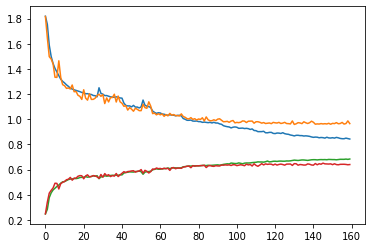

In [13]:
plt.plot(hist), best_acc, curloss

In [14]:
test_model = torch.load('/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention/residual_resnet5_6.pt')

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)
    acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
    loss = criterion(outputs, labels)

    print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    running_valloss += loss.item()
    running_valacc += acc

print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))


	 - Step 1: loss: 1.085 acc: 0.688
	 - Step 2: loss: 1.021 acc: 0.531
	 - Step 3: loss: 1.326 acc: 0.438
	 - Step 4: loss: 0.683 acc: 0.750
	 - Step 5: loss: 1.010 acc: 0.688
	 - Step 6: loss: 0.848 acc: 0.688
	 - Step 7: loss: 1.170 acc: 0.562
	 - Step 8: loss: 0.900 acc: 0.594
	 - Step 9: loss: 0.904 acc: 0.688
	 - Step 10: loss: 0.833 acc: 0.719
	 - Step 11: loss: 0.744 acc: 0.781
	 - Step 12: loss: 0.908 acc: 0.625
	 - Step 13: loss: 1.164 acc: 0.625
	 - Step 14: loss: 0.955 acc: 0.719
	 - Step 15: loss: 0.918 acc: 0.688
	 - Step 16: loss: 0.818 acc: 0.781
	 - Step 17: loss: 0.786 acc: 0.750
	 - Step 18: loss: 0.900 acc: 0.625
	 - Step 19: loss: 1.169 acc: 0.625
	 - Step 20: loss: 0.834 acc: 0.688
	 - Step 21: loss: 1.335 acc: 0.562
	 - Step 22: loss: 0.933 acc: 0.719
	 - Step 23: loss: 1.377 acc: 0.500
	 - Step 24: loss: 0.805 acc: 0.688
	 - Step 25: loss: 0.789 acc: 0.656
	 - Step 26: loss: 1.103 acc: 0.688
	 - Step 27: loss: 0.667 acc: 0.781
	 - Step 28: loss: 1.260 acc: 0.562
	

In [15]:
import pickle

pickle.dump(hist, open('/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention/residual_resnet5_6_hist.hdf5', 'wb'))

In [6]:
import pickle
import numpy as np

hist = pickle.load(open('/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention/residual_resnet5_6_hist.hdf5', 'rb'))
val_loss = [k[1] for k in hist]
np.min(val_loss)

0.9587723470367162

* val: 0.962, 0.651
* test: 0.936, 0.652

## Residula 5_7

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size=3, stride=1, padding=1):
        super(ResidualBlock, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.stride = stride
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(input_channels, output_channels//4, 1, 1, bias = False)
        self.bn2 = nn.BatchNorm2d(output_channels//4)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(output_channels//4, output_channels//4, kernel_size, stride, padding = padding, bias = False)
        self.bn3 = nn.BatchNorm2d(output_channels//4)
        self.relu = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(output_channels//4, output_channels, 1, 1, bias = False)
        self.conv4 = nn.Conv2d(input_channels, output_channels , 1, stride, bias = False)
       
    
    def forward(self, x):
        residual = x
        out = self.bn1(x)
        out1 = self.relu(out)
        out = self.conv1(out1)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)
        if (self.input_channels != self.output_channels) or (self.stride !=1 ):
            residual = self.conv4(out1)
        out += residual
        return out

In [6]:
class SVGG(nn.Module):
    def __init__(self, filters=[64, 128, 256, 512], reduce_factor=2, **kwargs):
        super(SVGG, self).__init__()
        
        self.device = kwargs['device']
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # block 1
        self.preconv_1 = nn.Sequential(nn.Conv2d(1, filters[0], 1, stride=1, padding=0, bias=False),
                                       nn.BatchNorm2d(filters[0]), nn.LeakyReLU(inplace=True))
        self.residual_1_a = ResidualBlock(filters[0], filters[0], stride=1)
        self.residual_1_b = ResidualBlock(filters[0], filters[0], stride=1)
        self.wf1 = Attention(filters[0], filters[0], filters[0] // reduce_factor, device=self.device)
        
        # block 2
        self.preconv_2 = nn.Sequential(nn.Conv2d(filters[0], filters[1], 1, stride=1, padding=0, bias=False),
                                     nn.BatchNorm2d(filters[1]), nn.LeakyReLU(inplace=True))
        self.residual_2_a = ResidualBlock(filters[1], filters[1], stride=1)
        self.residual_2_b = ResidualBlock(filters[1], filters[1], stride=1)
        self.wf2 = Attention(filters[1], filters[1], filters[1] // reduce_factor, device=self.device)
        
        # block 3
        self.preconv_3 = nn.Sequential(nn.Conv2d(filters[1] + filters[0], filters[2], 1, stride=1, padding=0, bias=False),
                                     nn.BatchNorm2d(filters[2]), nn.LeakyReLU(inplace=True))
        self.residual_3_a = ResidualBlock(filters[2], filters[2], stride=1)
        self.residual_3_b = ResidualBlock(filters[2], filters[2], stride=1)
        self.residual_3_c = ResidualBlock(filters[2], filters[2], stride=1)
        self.wf3 = Attention(filters[2], filters[2], filters[2] // reduce_factor, device=self.device)
        
        # block 4
        self.preconv_4 = nn.Sequential(nn.Conv2d(filters[2] + filters[1] + filters[0], filters[3], 1, stride=1, padding=0, bias=False),
                                     nn.BatchNorm2d(filters[3]), nn.LeakyReLU(inplace=True))
        self.residual_4_a = ResidualBlock(filters[3], filters[3], stride=1)
        self.residual_4_b = ResidualBlock(filters[3], filters[3], stride=1)
        self.residual_4_c = ResidualBlock(filters[3], filters[3], stride=1)
        self.wf4 = Attention(filters[3], filters[3], filters[3] // reduce_factor, pooling=False, device=self.device)
        
        # classifier
        self.classifier = nn.Sequential(nn.BatchNorm2d(filters[3] + filters[2] + filters[1] + filters[0]),
                                        nn.ReLU(inplace=True),
                                        nn.AdaptiveAvgPool2d(1),
                                        nn.Flatten(),
                                        nn.Dropout(0.5),
                                        nn.Linear(filters[3] + filters[2] + filters[1] + filters[0], filters[3]),
                                        nn.BatchNorm1d(filters[3]),
                                        nn.ReLU(inplace=True),
                                        nn.Linear(filters[3], 7))
        
    def forward(self, x):
        
        # 48
        x = self.preconv_1(x)
        x1_res = self.residual_1_a(x)
        x1_res = self.residual_1_b(x1_res)
        x1_res = self.pool(x1_res)
        
        x1_wf = self.wf1(x1_res)
        
        # 24
        x2 = self.preconv_2(x1_wf)
        x2_res = self.residual_2_a(x2)
        x2_res = self.residual_2_b(x2_res)
        x2_res = self.pool(x2_res)
        
        x2_wf = self.wf2(x2_res)
        
        x1_x3 = self.pool(x1_res)
        
        # 12
        x3 = torch.cat([x2_wf, x1_x3], dim=1) # 128 + 64
        x3 = self.preconv_3(x3)
        x3_res = self.residual_3_a(x3)
        x3_res = self.residual_3_b(x3_res)
        x3_res = self.residual_3_c(x3_res)
        x3_res = self.pool(x3_res)
        
        x3_wf = self.wf3(x3_res)
        
        x1_x4 = self.pool(self.pool(x1_res))
        x2_x4 = self.pool(x2_res)
        
        # 6
        x4 = torch.cat([x3_wf, x2_x4, x1_x4], dim=1) # 256 + 128 + 64
        x4 = self.preconv_4(x4)
        x4_res = self.residual_4_a(x4)
        x4_res = self.residual_4_b(x4_res)
        x4_res = self.residual_4_c(x4_res)
        x4_res = self.pool(x4_res)
        
        x4_wf = self.wf4(x4_res)
        
        # 3
        x1_xout = self.pool(self.pool(self.pool(x1_res)))
        x2_xout = self.pool(self.pool(x2_res))
        x3_xout = self.pool(x3_res)
        
        x_out = torch.cat([x4_wf, x1_xout, x2_xout, x3_xout], dim=1)
        
        x_out = self.classifier(x_out)
        
        return x_out
        

In [7]:
class Attention(nn.Module):
    
    def __init__(self, feature_depth, target_depth, emb_dim, **kwargs):
        super(Attention, self).__init__()
        
        self.emb_dim = emb_dim
        self.device = kwargs['device']
        
        self.iconv1 = nn.Conv2d(feature_depth, emb_dim, kernel_size=1)
        self.iconv2 = nn.Conv2d(target_depth, emb_dim, kernel_size=1)
        self.iconv3 = nn.Conv2d(target_depth, emb_dim, kernel_size=1)
        self.iconv_out = nn.Conv2d(emb_dim, target_depth, kernel_size=1)
        self.bn_out = nn.BatchNorm2d(target_depth)
        
        # ensure the init stage is the indentical mapping
#         nn.init.zeros_(self.iconv_out.weight)
#         nn.init.zeros_(self.iconv_out.bias)
#         nn.init.zeros_(self.bn_out.weight)
#         nn.init.zeros_(self.bn_out.bias)
        
    def forward(self, x):
        x1_emb = self.iconv1(x)
        _x1 = nn.Flatten(-2)(x1_emb)
        
        x2_emb = self.iconv2(x)
        _x2 = nn.Flatten(-2)(x2_emb)
        
        x3_emb = self.iconv3(x)
        _x3 = nn.Flatten(-2)(x3_emb)
        
        QK = _x1[:,None,:,:] * _x2[:,None, :, :].permute(0,2,1,3)
        QK = nn.Sigmoid()(QK)
        
        x_out = ((1 + QK) * _x3[:, None, :, :]).sum(2)
        x_out = x_out.view(x3_emb.size())
        
        x_out = self.iconv_out(x_out)
        x_out = self.bn_out(x_out)
        x_out = nn.LeakyReLU()(x_out)
        
        x_out = x_out + x #residual
        
        return x_out

In [8]:
from torch.optim import lr_scheduler

device = torch.device('cuda')
print(device)

model = SVGG(device=device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
# reduce_factor = 2
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

cuda


In [9]:
model = model.to(device)

model_folder = '/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention/'
model_name = 'residual_resnet5_7'
model_path = os.path.join(model_folder, model_name + '.pt')

best_acc = 0.0
curloss = 0.0
hist = []

for epoch in range(100):

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)
    
    # print gradient flow figure
#     plot_grad_flow(model.named_parameters(), epoch, avgloss, avgacc,
#                    savepath=os.path.join(model_folder, model_name + '_gf' + '_' + str(epoch) + '.png'))

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        
        print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        curloss = (running_valloss / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')
        
    scheduler.step(avgvalloss)

print('Finished Training')

Epoch:  1
- Avg.loss: 1.821  | Avg.acc: 0.267
- Avg. val_loss: 31.404  | Avg. val_acc: 0.162
* Update optimal model
Epoch:  2


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ResidualBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


- Avg.loss: 1.632  | Avg.acc: 0.358
- Avg. val_loss: 1.649  | Avg. val_acc: 0.330
* Update optimal model
Epoch:  3
- Avg.loss: 1.492  | Avg.acc: 0.419
- Avg. val_loss: 1.388  | Avg. val_acc: 0.475
* Update optimal model
Epoch:  4
- Avg.loss: 1.404  | Avg.acc: 0.457
- Avg. val_loss: 1.436  | Avg. val_acc: 0.453
Epoch:  5
- Avg.loss: 1.352  | Avg.acc: 0.482
- Avg. val_loss: 1.558  | Avg. val_acc: 0.391
Epoch:  6
- Avg.loss: 1.314  | Avg.acc: 0.497
- Avg. val_loss: 1.292  | Avg. val_acc: 0.493
* Update optimal model
Epoch:  7
- Avg.loss: 1.282  | Avg.acc: 0.508
- Avg. val_loss: 1.240  | Avg. val_acc: 0.517
* Update optimal model
Epoch:  8
- Avg.loss: 1.263  | Avg.acc: 0.517
- Avg. val_loss: 1.238  | Avg. val_acc: 0.527
* Update optimal model
Epoch:  9
- Avg.loss: 1.235  | Avg.acc: 0.527
- Avg. val_loss: 1.308  | Avg. val_acc: 0.502
Epoch:  10
- Avg.loss: 1.220  | Avg.acc: 0.535
- Avg. val_loss: 1.219  | Avg. val_acc: 0.530
* Update optimal model
Epoch:  11
- Avg.loss: 1.205  | Avg.acc: 0.

- Avg. val_loss: 0.963  | Avg. val_acc: 0.644
Epoch:  84
- Avg.loss: 0.806  | Avg.acc: 0.699
- Avg. val_loss: 0.971  | Avg. val_acc: 0.642
Epoch:  85
- Avg.loss: 0.804  | Avg.acc: 0.698
- Avg. val_loss: 0.957  | Avg. val_acc: 0.648
* Update optimal model
Epoch:  86
- Avg.loss: 0.802  | Avg.acc: 0.698
- Avg. val_loss: 0.984  | Avg. val_acc: 0.644
Epoch:  87
- Avg.loss: 0.802  | Avg.acc: 0.696
- Avg. val_loss: 0.982  | Avg. val_acc: 0.637
Epoch:  88
- Avg.loss: 0.804  | Avg.acc: 0.700
- Avg. val_loss: 0.987  | Avg. val_acc: 0.638
Epoch:  89
- Avg.loss: 0.797  | Avg.acc: 0.699
- Avg. val_loss: 0.960  | Avg. val_acc: 0.652
* Update optimal model
Epoch    89: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  90
- Avg.loss: 0.789  | Avg.acc: 0.703
- Avg. val_loss: 0.951  | Avg. val_acc: 0.651
Epoch:  91
- Avg.loss: 0.788  | Avg.acc: 0.704
- Avg. val_loss: 0.962  | Avg. val_acc: 0.652
Epoch:  92
- Avg.loss: 0.781  | Avg.acc: 0.703
- Avg. val_loss: 0.953  | Avg. val_acc: 0.652
Epoch:  9

In [11]:
model = model.to(device)

model_folder = '/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention/'
model_name = 'residual_resnet5_7'
model_path = os.path.join(model_folder, model_name + '.pt')


for epoch in range(100, 150):

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)
    
    # print gradient flow figure
#     plot_grad_flow(model.named_parameters(), epoch, avgloss, avgacc,
#                    savepath=os.path.join(model_folder, model_name + '_gf' + '_' + str(epoch) + '.png'))

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        curloss = (running_valloss / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')
        
    scheduler.step(avgvalloss)

print('Finished Training')

Epoch:  101
- Avg.loss: 0.770  | Avg.acc: 0.710
- Avg. val_loss: 0.949  | Avg. val_acc: 0.657
* Update optimal model
Epoch:  102
- Avg.loss: 0.764  | Avg.acc: 0.714
- Avg. val_loss: 0.963  | Avg. val_acc: 0.654
Epoch:  103
- Avg.loss: 0.768  | Avg.acc: 0.714
- Avg. val_loss: 0.970  | Avg. val_acc: 0.648
Epoch:  104
- Avg.loss: 0.765  | Avg.acc: 0.714
- Avg. val_loss: 0.979  | Avg. val_acc: 0.649
Epoch:  105
- Avg.loss: 0.767  | Avg.acc: 0.710
- Avg. val_loss: 0.954  | Avg. val_acc: 0.650
Epoch:  106
- Avg.loss: 0.763  | Avg.acc: 0.714
- Avg. val_loss: 0.954  | Avg. val_acc: 0.661
* Update optimal model
Epoch:  107
- Avg.loss: 0.758  | Avg.acc: 0.713
- Avg. val_loss: 0.956  | Avg. val_acc: 0.660
Epoch:  108
- Avg.loss: 0.757  | Avg.acc: 0.718
- Avg. val_loss: 0.962  | Avg. val_acc: 0.656
Epoch:  109
- Avg.loss: 0.759  | Avg.acc: 0.714
- Avg. val_loss: 0.966  | Avg. val_acc: 0.651
Epoch:  110
- Avg.loss: 0.759  | Avg.acc: 0.716
- Avg. val_loss: 0.975  | Avg. val_acc: 0.651
Epoch   111: r

([<matplotlib.lines.Line2D at 0x7f1134c9ba20>,
 0.6625548245614035,
 0.970671788642281)

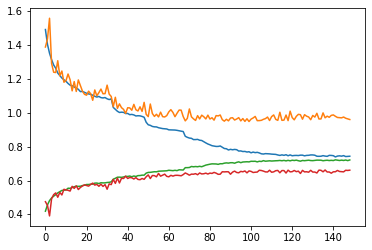

In [14]:
plt.plot(hist[2:]), best_acc, curloss

In [16]:
test_model = torch.load('/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention/residual_resnet5_7.pt')

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)
    acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
    loss = criterion(outputs, labels)

    print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    running_valloss += loss.item()
    running_valacc += acc

print('- Avg. val_loss: %.5f  | Avg. val_acc: %.5f' % (running_valloss / (i+1), running_valacc / (i+1)))


	 - Step 1: loss: 0.797 acc: 0.703
	 - Step 2: loss: 0.849 acc: 0.656
	 - Step 3: loss: 0.769 acc: 0.750
	 - Step 4: loss: 0.871 acc: 0.719
	 - Step 5: loss: 0.855 acc: 0.703
	 - Step 6: loss: 1.242 acc: 0.562
	 - Step 7: loss: 0.687 acc: 0.734
	 - Step 8: loss: 0.720 acc: 0.734
	 - Step 9: loss: 0.806 acc: 0.609
	 - Step 10: loss: 0.948 acc: 0.625
	 - Step 11: loss: 1.048 acc: 0.578
	 - Step 12: loss: 0.911 acc: 0.688
	 - Step 13: loss: 1.298 acc: 0.562
	 - Step 14: loss: 0.941 acc: 0.641
	 - Step 15: loss: 0.888 acc: 0.656
	 - Step 16: loss: 1.185 acc: 0.594
	 - Step 17: loss: 0.975 acc: 0.672
	 - Step 18: loss: 0.885 acc: 0.656
	 - Step 19: loss: 0.682 acc: 0.734
	 - Step 20: loss: 0.652 acc: 0.734
	 - Step 21: loss: 1.030 acc: 0.641
	 - Step 22: loss: 0.914 acc: 0.641
	 - Step 23: loss: 0.975 acc: 0.703
	 - Step 24: loss: 1.078 acc: 0.609
	 - Step 25: loss: 0.828 acc: 0.688
	 - Step 26: loss: 1.035 acc: 0.719
	 - Step 27: loss: 0.931 acc: 0.688
	 - Step 28: loss: 0.954 acc: 0.656
	

## Residual 5_8

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size=3, stride=1, padding=1):
        super(ResidualBlock, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.stride = stride
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(input_channels, output_channels//4, 1, 1, bias = False)
        self.bn2 = nn.BatchNorm2d(output_channels//4)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(output_channels//4, output_channels//4, kernel_size, stride, padding = padding, bias = False)
        self.bn3 = nn.BatchNorm2d(output_channels//4)
        self.relu = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(output_channels//4, output_channels, 1, 1, bias = False)
        self.conv4 = nn.Conv2d(input_channels, output_channels , 1, stride, bias = False)
       
    
    def forward(self, x):
        residual = x
        out = self.bn1(x)
        out1 = self.relu(out)
        out = self.conv1(out1)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)
        if (self.input_channels != self.output_channels) or (self.stride !=1 ):
            residual = self.conv4(out1)
        out += residual
        return out

In [5]:
class SVGG(nn.Module):
    def __init__(self, filters=[64, 128, 256, 512], reduce_factor=2, **kwargs):
        super(SVGG, self).__init__()
        
        self.device = kwargs['device']
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # block 1
        self.preconv_1 = nn.Sequential(nn.Conv2d(1, filters[0], 1, stride=1, padding=0, bias=False),
                                       nn.BatchNorm2d(filters[0]), nn.LeakyReLU(inplace=True))
        self.residual_1_a = ResidualBlock(filters[0], filters[0], stride=1)
        self.residual_1_b = ResidualBlock(filters[0], filters[0], stride=1)
        self.wf1 = Attention(filters[0], filters[0], filters[0] // reduce_factor, device=self.device)
        
        # block 2
        self.preconv_2 = nn.Sequential(nn.Conv2d(filters[0], filters[1], 1, stride=1, padding=0, bias=False),
                                     nn.BatchNorm2d(filters[1]), nn.LeakyReLU(inplace=True))
        self.residual_2_a = ResidualBlock(filters[1], filters[1], stride=1)
        self.residual_2_b = ResidualBlock(filters[1], filters[1], stride=1)
        self.wf2 = Attention(filters[1], filters[1], filters[1] // reduce_factor, device=self.device)
        
        # block 3
        self.preconv_3 = nn.Sequential(nn.Conv2d(filters[1] + filters[0], filters[2], 1, stride=1, padding=0, bias=False),
                                     nn.BatchNorm2d(filters[2]), nn.LeakyReLU(inplace=True))
        self.residual_3_a = ResidualBlock(filters[2], filters[2], stride=1)
        self.residual_3_b = ResidualBlock(filters[2], filters[2], stride=1)
        self.residual_3_c = ResidualBlock(filters[2], filters[2], stride=1)
        self.wf3 = Attention(filters[2], filters[2], filters[2] // reduce_factor, device=self.device)
        
        # block 4
        self.preconv_4 = nn.Sequential(nn.Conv2d(filters[2] + filters[1] + filters[0], filters[3], 1, stride=1, padding=0, bias=False),
                                     nn.BatchNorm2d(filters[3]), nn.LeakyReLU(inplace=True))
        self.residual_4_a = ResidualBlock(filters[3], filters[3], stride=1)
        self.residual_4_b = ResidualBlock(filters[3], filters[3], stride=1)
        self.residual_4_c = ResidualBlock(filters[3], filters[3], stride=1)
        self.wf4 = Attention(filters[3], filters[3], filters[3] // reduce_factor, pooling=False, device=self.device)
        
        # classifier
        self.classifier = nn.Sequential(nn.BatchNorm2d(filters[3] + filters[2] + filters[1] + filters[0]),
                                        nn.ReLU(inplace=True),
                                        nn.AdaptiveAvgPool2d(1),
                                        nn.Flatten(),
                                        nn.Dropout(0.5),
                                        nn.Linear(filters[3] + filters[2] + filters[1] + filters[0], filters[3]),
                                        nn.BatchNorm1d(filters[3]),
                                        nn.ReLU(inplace=True),
                                        nn.Linear(filters[3], 7))
        
        # downsize conv
        self.conv1_3 = nn.Sequential(nn.Conv2d(filters[0], filters[0], kernel_size=2, stride=2, padding=0),
                                     nn.BatchNorm2d(filters[0]), nn.ReLU(), self.pool) # 48 -> 24
        self.conv1_4 = nn.Sequential(nn.Conv2d(filters[0], filters[0], kernel_size=4, stride=4, padding=0),
                                     nn.BatchNorm2d(filters[0]), nn.ReLU(), self.pool) # 48 -> 12 
        self.conv2_4 = nn.Sequential(nn.Conv2d(filters[1], filters[1], kernel_size=2, stride=2, padding=0),
                                     nn.BatchNorm2d(filters[1]), nn.ReLU(), self.pool) # 24 -> 12
        
        self.conv1_out = nn.Sequential(nn.Conv2d(filters[0], filters[0], kernel_size=8, stride=8, padding=0),
                                     nn.BatchNorm2d(filters[0]), nn.ReLU(), self.pool) # 48 -> 6
        self.conv2_out = nn.Sequential(nn.Conv2d(filters[1], filters[1], kernel_size=4, stride=4, padding=0),
                                     nn.BatchNorm2d(filters[1]), nn.ReLU(), self.pool) # 24 -> 6
        self.conv3_out = nn.Sequential(nn.Conv2d(filters[2], filters[2], kernel_size=2, stride=2, padding=0),
                                     nn.BatchNorm2d(filters[2]), nn.ReLU(), self.pool) # 12 -> 6
        
    def forward(self, x):
        
        # 48
        x = self.preconv_1(x)
        x1_res = self.residual_1_a(x)
        x1_res = self.residual_1_b(x1_res)
#         x1_res = self.pool(x1_res)
        
        x1_wf = self.wf1(x1_res)
        
        # 24
        x2 = self.preconv_2(x1_wf)
        x2_res = self.residual_2_a(x2)
        x2_res = self.residual_2_b(x2_res)
#         x2_res = self.pool(x2_res)
        
        x2_wf = self.wf2(x2_res)
        
        x1_x3 = self.conv1_3(x1_res)
        
        # 12
        x3 = torch.cat([x2_wf, x1_x3], dim=1) # 128 + 64
        x3 = self.preconv_3(x3)
        x3_res = self.residual_3_a(x3)
        x3_res = self.residual_3_b(x3_res)
        x3_res = self.residual_3_c(x3_res)
#         x3_res = self.pool(x3_res)
        
        x3_wf = self.wf3(x3_res)
        
        x1_x4 = self.conv1_4(x1_res)
        x2_x4 = self.conv2_4(x2_res)
        
        # 6
        x4 = torch.cat([x3_wf, x2_x4, x1_x4], dim=1) # 256 + 128 + 64
        x4 = self.preconv_4(x4)
        x4_res = self.residual_4_a(x4)
        x4_res = self.residual_4_b(x4_res)
        x4_res = self.residual_4_c(x4_res)
#         x4_res = self.pool(x4_res)
        
        x4_wf = self.wf4(x4_res)
        
        # 3
        x1_xout = self.conv1_out(x1_res)
        x2_xout = self.conv2_out(x2_res)
        x3_xout = self.conv3_out(x3_res)
        
        x_out = torch.cat([x4_wf, x1_xout, x2_xout, x3_xout], dim=1)
        
        x_out = self.classifier(x_out)
        
        return x_out
        

In [6]:
class Attention(nn.Module):
    
    def __init__(self, feature_depth, target_depth, emb_dim, **kwargs):
        super(Attention, self).__init__()
        
        self.emb_dim = emb_dim
        self.device = kwargs['device']
        
        self.iconv1 = nn.Conv2d(feature_depth, emb_dim, kernel_size=1)
        self.iconv2 = nn.Conv2d(target_depth, emb_dim, kernel_size=1)
        self.iconv3 = nn.Conv2d(target_depth, emb_dim, kernel_size=1)
        self.iconv_out = nn.Conv2d(emb_dim, target_depth, kernel_size=1)
        self.bn_out = nn.BatchNorm2d(target_depth)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x1_emb = self.iconv1(x)
        x1_emb = self.pool(x1_emb)
        _x1 = nn.Flatten(-2)(x1_emb)
        
        x2_emb = self.iconv2(x)
        x2_emb = self.pool(x2_emb)
        _x2 = nn.Flatten(-2)(x2_emb)
        
        x3_emb = self.iconv3(x)
        x3_emb = self.pool(x3_emb)
        _x3 = nn.Flatten(-2)(x3_emb)
        
        QK = _x1[:,None,:,:] * _x2[:,None, :, :].permute(0,2,1,3)
        QK = nn.Sigmoid()(QK)
        
#         print('QK: ', QK)
        
        x_out = ((1 + QK) * _x3[:, None, :, :]).sum(2)
        x_out = x_out.view(x3_emb.size())
        
        x_out = self.iconv_out(x_out)
        x_out = self.bn_out(x_out)
        x_out = nn.LeakyReLU()(x_out)
        
        x_out = x_out + self.pool(x) #residual
        
        return x_out

In [7]:
from torch.optim import lr_scheduler

device = torch.device('cuda')
print(device)

model = SVGG(device=device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
# reduce_factor = 2
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

cuda


In [8]:
model = model.to(device)

model_folder = '/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention/'
model_name = 'residual_resnet5_8'
model_path = os.path.join(model_folder, model_name + '.pt')

best_acc = 0.0
curloss = 0.0
hist = []

for epoch in range(100):

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)
    
    # print gradient flow figure
#     plot_grad_flow(model.named_parameters(), epoch, avgloss, avgacc,
#                    savepath=os.path.join(model_folder, model_name + '_gf' + '_' + str(epoch) + '.png'))

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        curloss = (running_valloss / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')
        
    scheduler.step(avgvalloss)

print('Finished Training')

Epoch:  1
- Avg.loss: 1.847  | Avg.acc: 0.250
- Avg. val_loss: 1.808  | Avg. val_acc: 0.255
* Update optimal model
Epoch:  2


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ResidualBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


- Avg.loss: 1.793  | Avg.acc: 0.265
- Avg. val_loss: 1.889  | Avg. val_acc: 0.273
* Update optimal model
Epoch:  3
- Avg.loss: 1.752  | Avg.acc: 0.279
- Avg. val_loss: 1.764  | Avg. val_acc: 0.284
* Update optimal model
Epoch:  4
- Avg.loss: 1.611  | Avg.acc: 0.355
- Avg. val_loss: 1.514  | Avg. val_acc: 0.421
* Update optimal model
Epoch:  5
- Avg.loss: 1.480  | Avg.acc: 0.424
- Avg. val_loss: 1.413  | Avg. val_acc: 0.460
* Update optimal model
Epoch:  6
- Avg.loss: 1.421  | Avg.acc: 0.444
- Avg. val_loss: 1.348  | Avg. val_acc: 0.483
* Update optimal model
Epoch:  7
- Avg.loss: 1.363  | Avg.acc: 0.466
- Avg. val_loss: 1.289  | Avg. val_acc: 0.501
* Update optimal model
Epoch:  8
- Avg.loss: 1.332  | Avg.acc: 0.479
- Avg. val_loss: 1.292  | Avg. val_acc: 0.492
Epoch:  9
- Avg.loss: 1.305  | Avg.acc: 0.496
- Avg. val_loss: 1.260  | Avg. val_acc: 0.517
* Update optimal model
Epoch:  10
- Avg.loss: 1.281  | Avg.acc: 0.503
- Avg. val_loss: 1.247  | Avg. val_acc: 0.521
* Update optimal mod

- Avg.loss: 0.946  | Avg.acc: 0.642
- Avg. val_loss: 0.996  | Avg. val_acc: 0.626
* Update optimal model
Epoch:  85
- Avg.loss: 0.939  | Avg.acc: 0.647
- Avg. val_loss: 1.000  | Avg. val_acc: 0.629
* Update optimal model
Epoch:  86
- Avg.loss: 0.938  | Avg.acc: 0.644
- Avg. val_loss: 1.007  | Avg. val_acc: 0.625
Epoch:  87
- Avg.loss: 0.934  | Avg.acc: 0.648
- Avg. val_loss: 0.988  | Avg. val_acc: 0.630
* Update optimal model
Epoch:  88
- Avg.loss: 0.935  | Avg.acc: 0.647
- Avg. val_loss: 1.019  | Avg. val_acc: 0.626
Epoch:  89
- Avg.loss: 0.933  | Avg.acc: 0.649
- Avg. val_loss: 0.997  | Avg. val_acc: 0.622
Epoch:  90
- Avg.loss: 0.926  | Avg.acc: 0.651
- Avg. val_loss: 0.992  | Avg. val_acc: 0.621
Epoch:  91
- Avg.loss: 0.922  | Avg.acc: 0.652
- Avg. val_loss: 1.022  | Avg. val_acc: 0.621
Epoch:  92
- Avg.loss: 0.926  | Avg.acc: 0.650
- Avg. val_loss: 1.005  | Avg. val_acc: 0.623
Epoch:  93
- Avg.loss: 0.929  | Avg.acc: 0.650
- Avg. val_loss: 0.994  | Avg. val_acc: 0.622
Epoch:  94
-

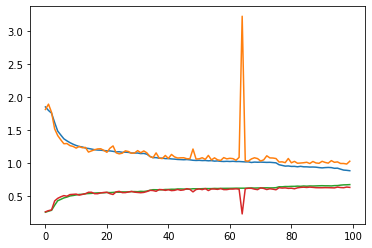

In [9]:
plt.plot(hist)

In [10]:
model = model.to(device)

model_folder = '/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention/'
model_name = 'residual_resnet5_8'
model_path = os.path.join(model_folder, model_name + '.pt')

# best_acc = 0.0
# curloss = 0.0
# hist = []

for epoch in range(100, 150):

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)
    
    # print gradient flow figure
#     plot_grad_flow(model.named_parameters(), epoch, avgloss, avgacc,
#                    savepath=os.path.join(model_folder, model_name + '_gf' + '_' + str(epoch) + '.png'))

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        curloss = (running_valloss / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')
        
    scheduler.step(avgvalloss)

print('Finished Training')

Epoch:  101
- Avg.loss: 0.878  | Avg.acc: 0.668
- Avg. val_loss: 0.997  | Avg. val_acc: 0.621
Epoch:  102
- Avg.loss: 0.880  | Avg.acc: 0.669
- Avg. val_loss: 0.980  | Avg. val_acc: 0.641
* Update optimal model
Epoch:  103
- Avg.loss: 0.874  | Avg.acc: 0.669
- Avg. val_loss: 1.008  | Avg. val_acc: 0.630
Epoch:  104
- Avg.loss: 0.873  | Avg.acc: 0.673
- Avg. val_loss: 0.990  | Avg. val_acc: 0.621
Epoch:  105
- Avg.loss: 0.874  | Avg.acc: 0.670
- Avg. val_loss: 0.969  | Avg. val_acc: 0.646
* Update optimal model
Epoch:  106
- Avg.loss: 0.870  | Avg.acc: 0.671
- Avg. val_loss: 1.005  | Avg. val_acc: 0.623
Epoch:  107
- Avg.loss: 0.870  | Avg.acc: 0.672
- Avg. val_loss: 0.984  | Avg. val_acc: 0.633
Epoch:  108
- Avg.loss: 0.861  | Avg.acc: 0.677
- Avg. val_loss: 0.983  | Avg. val_acc: 0.630
Epoch:  109
- Avg.loss: 0.871  | Avg.acc: 0.672
- Avg. val_loss: 0.973  | Avg. val_acc: 0.637
Epoch:  110
- Avg.loss: 0.861  | Avg.acc: 0.679
- Avg. val_loss: 1.014  | Avg. val_acc: 0.623
Epoch:  111
- 

([<matplotlib.lines.Line2D at 0x7f7894b44f98>,
 0.6524122807017544,
 0.962773277048479)

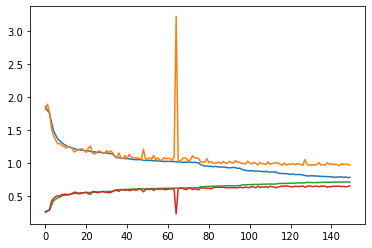

In [12]:
plt.plot(hist), best_acc, curloss